In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6981999026974431
Log Loss: 0.606584797161576


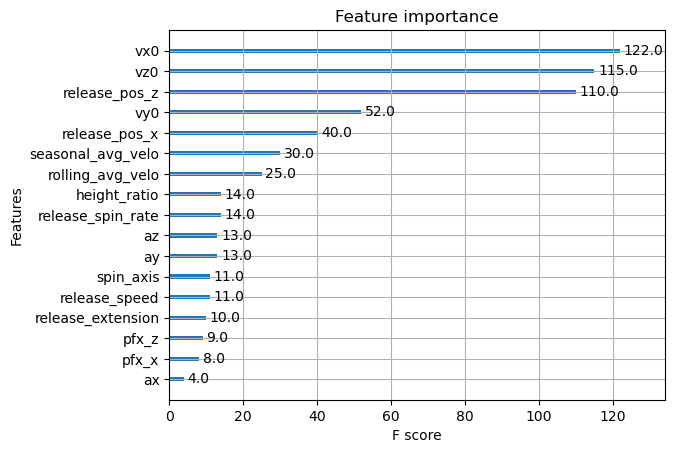

In [12]:
xgb.plot_importance(model)
plt.show()

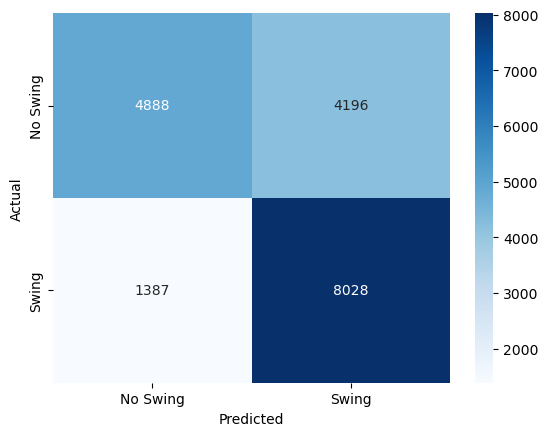

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 18:22:37,885] A new study created in memory with name: no-name-da147576-d252-40de-9812-1b6f02ab7b97


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66448
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64670
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64434
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.63562
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.63027
[13]	eval-logloss:0.62768
[14]	eval-logloss:0.62317
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61387
[18]	eval-logloss:0.61093
[19]	eval-logloss:0.60809
[20]	eval-logloss:0.60510
[21]	eval-logloss:0.60336
[22]	eval-logloss:0.60071
[23]	eval-logloss:0.59863
[24]	eval-logloss:0.59683
[25]	eval-logloss:0.59481
[26]	eval-logloss:0.59301
[27]	eval-logloss:0.59108
[28]	eval-logloss:0.58912
[29]	eval-logloss:0.58763
[30]	eval-logloss:0.58583
[31]	eval-logloss:0.58450
[32]	eval-logloss:0.58290
[33]	eval-logloss:0.58178
[34]	eval-logloss:0.58040
[35]	eval-logloss:0.57918
[36]	eval-logloss:0.57834
[37]	eval-logloss:0.57754
[38]	eval-logloss:0.57

[71]	eval-logloss:0.55013
[72]	eval-logloss:0.54962
[73]	eval-logloss:0.54875
[74]	eval-logloss:0.54864
[75]	eval-logloss:0.54798
[76]	eval-logloss:0.54778
[77]	eval-logloss:0.54713
[78]	eval-logloss:0.54668
[79]	eval-logloss:0.54630
[80]	eval-logloss:0.54545
[81]	eval-logloss:0.54496
[82]	eval-logloss:0.54451
[83]	eval-logloss:0.54384
[84]	eval-logloss:0.54331
[85]	eval-logloss:0.54237
[86]	eval-logloss:0.54229
[87]	eval-logloss:0.54162
[88]	eval-logloss:0.54122
[89]	eval-logloss:0.54083
[90]	eval-logloss:0.54045
[91]	eval-logloss:0.54016
[92]	eval-logloss:0.53955
[93]	eval-logloss:0.53884
[94]	eval-logloss:0.53856
[95]	eval-logloss:0.53839
[96]	eval-logloss:0.53824
[97]	eval-logloss:0.53804
[98]	eval-logloss:0.53782
[99]	eval-logloss:0.53742


[I 2023-11-15 18:22:38,877] Trial 0 finished with value: 0.5374209246968974 and parameters: {'max_depth': 5, 'eta': 0.06317043290576982, 'subsample': 0.8143975179376047, 'colsample_bytree': 0.8110728472522042}. Best is trial 0 with value: 0.5374209246968974.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66004
[3]	eval-logloss:0.64956
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61343
[9]	eval-logloss:0.60808
[10]	eval-logloss:0.60385
[11]	eval-logloss:0.60022
[12]	eval-logloss:0.59642
[13]	eval-logloss:0.59297
[14]	eval-logloss:0.58972
[15]	eval-logloss:0.58625
[16]	eval-logloss:0.58335
[17]	eval-logloss:0.58017
[18]	eval-logloss:0.57873
[19]	eval-logloss:0.57637
[20]	eval-logloss:0.57440
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56810
[24]	eval-logloss:0.56482
[25]	eval-logloss:0.56315
[26]	eval-logloss:0.56066
[27]	eval-logloss:0.55853
[28]	eval-logloss:0.55591
[29]	eval-logloss:0.55431
[30]	eval-logloss:0.55258
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.55036
[33]	eval-logloss:0.54916
[34]	eval-logloss:0.54767
[35]	eval-logloss:0.54675
[36]	eval-logloss:0.54589
[37]	eval-logloss:0.54542
[38]	eval-logloss:0.54

[I 2023-11-15 18:22:39,809] Trial 1 finished with value: 0.5108527362131835 and parameters: {'max_depth': 6, 'eta': 0.09082667220714884, 'subsample': 0.6444807665504982, 'colsample_bytree': 0.9626903751392623}. Best is trial 1 with value: 0.5108527362131835.


[0]	eval-logloss:0.65669
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.61419
[4]	eval-logloss:0.59759
[5]	eval-logloss:0.58490
[6]	eval-logloss:0.57619
[7]	eval-logloss:0.57601
[8]	eval-logloss:0.57207
[9]	eval-logloss:0.56488
[10]	eval-logloss:0.55972
[11]	eval-logloss:0.55599
[12]	eval-logloss:0.55112
[13]	eval-logloss:0.54918
[14]	eval-logloss:0.54351
[15]	eval-logloss:0.53902
[16]	eval-logloss:0.53777
[17]	eval-logloss:0.53594
[18]	eval-logloss:0.53312
[19]	eval-logloss:0.53212
[20]	eval-logloss:0.53040
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.53005
[23]	eval-logloss:0.52961
[24]	eval-logloss:0.52477
[25]	eval-logloss:0.52400
[26]	eval-logloss:0.52343
[27]	eval-logloss:0.52177
[28]	eval-logloss:0.51729
[29]	eval-logloss:0.51549
[30]	eval-logloss:0.51473
[31]	eval-logloss:0.51449
[32]	eval-logloss:0.51360
[33]	eval-logloss:0.51295
[34]	eval-logloss:0.51190
[35]	eval-logloss:0.51183
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.51024
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:40,832] Trial 2 finished with value: 0.5044873365832077 and parameters: {'max_depth': 7, 'eta': 0.24920435577488195, 'subsample': 0.7452778267318765, 'colsample_bytree': 0.7203059967546037}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.66044
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.62386
[4]	eval-logloss:0.60916
[5]	eval-logloss:0.59784
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.59033
[8]	eval-logloss:0.58621
[9]	eval-logloss:0.57913
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57538
[12]	eval-logloss:0.56950
[13]	eval-logloss:0.56605
[14]	eval-logloss:0.56185
[15]	eval-logloss:0.55816
[16]	eval-logloss:0.55711
[17]	eval-logloss:0.55358
[18]	eval-logloss:0.55032
[19]	eval-logloss:0.54897
[20]	eval-logloss:0.54709
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54540
[23]	eval-logloss:0.54438
[24]	eval-logloss:0.54394
[25]	eval-logloss:0.54380
[26]	eval-logloss:0.54241
[27]	eval-logloss:0.54187
[28]	eval-logloss:0.53925
[29]	eval-logloss:0.53661
[30]	eval-logloss:0.53639
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.53236
[33]	eval-logloss:0.53203
[34]	eval-logloss:0.53182
[35]	eval-logloss:0.53151
[36]	eval-logloss:0.53085
[37]	eval-logloss:0.52989
[38]	eval-logloss:0.52

[I 2023-11-15 18:22:41,585] Trial 3 finished with value: 0.5055285356415099 and parameters: {'max_depth': 5, 'eta': 0.2604948100598075, 'subsample': 0.7915659616292003, 'colsample_bytree': 0.6297999067460189}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.65693
[1]	eval-logloss:0.62784
[2]	eval-logloss:0.62775
[3]	eval-logloss:0.62786
[4]	eval-logloss:0.59995
[5]	eval-logloss:0.58173
[6]	eval-logloss:0.57409
[7]	eval-logloss:0.57424
[8]	eval-logloss:0.56893
[9]	eval-logloss:0.55964
[10]	eval-logloss:0.55962
[11]	eval-logloss:0.55968
[12]	eval-logloss:0.55082
[13]	eval-logloss:0.54595
[14]	eval-logloss:0.54121
[15]	eval-logloss:0.53672
[16]	eval-logloss:0.53576
[17]	eval-logloss:0.53616
[18]	eval-logloss:0.53237
[19]	eval-logloss:0.53264
[20]	eval-logloss:0.53025
[21]	eval-logloss:0.53054
[22]	eval-logloss:0.52989
[23]	eval-logloss:0.52935
[24]	eval-logloss:0.52980
[25]	eval-logloss:0.53029
[26]	eval-logloss:0.52973
[27]	eval-logloss:0.52946
[28]	eval-logloss:0.52278
[29]	eval-logloss:0.52175
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.52140
[32]	eval-logloss:0.52043
[33]	eval-logloss:0.52109
[34]	eval-logloss:0.52098
[35]	eval-logloss:0.52114
[36]	eval-logloss:0.52126
[37]	eval-logloss:0.52168
[38]	eval-logloss:0.52

[I 2023-11-15 18:22:43,019] Trial 4 finished with value: 0.5170426757198449 and parameters: {'max_depth': 9, 'eta': 0.2582381386646394, 'subsample': 0.7437277456841449, 'colsample_bytree': 0.5112467981022754}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.66849
[15]	eval-logloss:0.66633
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66473
[18]	eval-logloss:0.66271
[19]	eval-logloss:0.66074
[20]	eval-logloss:0.65871
[21]	eval-logloss:0.65866
[22]	eval-logloss:0.65682
[23]	eval-logloss:0.65506
[24]	eval-logloss:0.65501
[25]	eval-logloss:0.65497
[26]	eval-logloss:0.65338
[27]	eval-logloss:0.65180
[28]	eval-logloss:0.65035
[29]	eval-logloss:0.64897
[30]	eval-logloss:0.64769
[31]	eval-logloss:0.64644
[32]	eval-logloss:0.64510
[33]	eval-logloss:0.64505
[34]	eval-logloss:0.64391
[35]	eval-logloss:0.64288
[36]	eval-logloss:0.64180
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.63

[I 2023-11-15 18:22:43,591] Trial 5 finished with value: 0.6083132994640873 and parameters: {'max_depth': 3, 'eta': 0.0313994190173482, 'subsample': 0.8777839738215453, 'colsample_bytree': 0.6189427575864488}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67236
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64010
[6]	eval-logloss:0.63262
[7]	eval-logloss:0.63240
[8]	eval-logloss:0.62931
[9]	eval-logloss:0.62266
[10]	eval-logloss:0.62251
[11]	eval-logloss:0.62001
[12]	eval-logloss:0.61650
[13]	eval-logloss:0.61313
[14]	eval-logloss:0.60796
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60200
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59084
[20]	eval-logloss:0.58760
[21]	eval-logloss:0.58743
[22]	eval-logloss:0.58447
[23]	eval-logloss:0.58203
[24]	eval-logloss:0.58178
[25]	eval-logloss:0.58163
[26]	eval-logloss:0.57950
[27]	eval-logloss:0.57809
[28]	eval-logloss:0.57456
[29]	eval-logloss:0.57287
[30]	eval-logloss:0.57189
[31]	eval-logloss:0.56971
[32]	eval-logloss:0.56836
[33]	eval-logloss:0.56816
[34]	eval-logloss:0.56698
[35]	eval-logloss:0.56600
[36]	eval-logloss:0.56397
[37]	eval-logloss:0.56326
[38]	eval-logloss:0.56

[I 2023-11-15 18:22:44,323] Trial 6 finished with value: 0.5267077281521129 and parameters: {'max_depth': 5, 'eta': 0.1051596712352986, 'subsample': 0.7167723994089215, 'colsample_bytree': 0.6089297117045007}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.67560
[1]	eval-logloss:0.66678
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.63997
[4]	eval-logloss:0.62978
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61488
[7]	eval-logloss:0.61445
[8]	eval-logloss:0.60724
[9]	eval-logloss:0.60218
[10]	eval-logloss:0.59759
[11]	eval-logloss:0.59371
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58629
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.57983
[16]	eval-logloss:0.57703
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57382
[19]	eval-logloss:0.57189
[20]	eval-logloss:0.56927
[21]	eval-logloss:0.56747
[22]	eval-logloss:0.56348
[23]	eval-logloss:0.55969
[24]	eval-logloss:0.55756
[25]	eval-logloss:0.55566
[26]	eval-logloss:0.55455
[27]	eval-logloss:0.55283
[28]	eval-logloss:0.55146
[29]	eval-logloss:0.55014
[30]	eval-logloss:0.54913
[31]	eval-logloss:0.54869
[32]	eval-logloss:0.54767
[33]	eval-logloss:0.54704
[34]	eval-logloss:0.54560
[35]	eval-logloss:0.54509
[36]	eval-logloss:0.54370
[37]	eval-logloss:0.54296
[38]	eval-logloss:0.54

[I 2023-11-15 18:22:45,070] Trial 7 finished with value: 0.5084820947672845 and parameters: {'max_depth': 5, 'eta': 0.13622602976102097, 'subsample': 0.6561216551080853, 'colsample_bytree': 0.900499086420624}. Best is trial 2 with value: 0.5044873365832077.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64014
[3]	eval-logloss:0.62383
[4]	eval-logloss:0.61105
[5]	eval-logloss:0.60013
[6]	eval-logloss:0.59124
[7]	eval-logloss:0.59080
[8]	eval-logloss:0.58710
[9]	eval-logloss:0.57917
[10]	eval-logloss:0.57306
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.55925
[14]	eval-logloss:0.55437
[15]	eval-logloss:0.55010
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54491
[18]	eval-logloss:0.54162
[19]	eval-logloss:0.53884
[20]	eval-logloss:0.53613
[21]	eval-logloss:0.53350
[22]	eval-logloss:0.53184
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.52763
[25]	eval-logloss:0.52635
[26]	eval-logloss:0.52528
[27]	eval-logloss:0.52434
[28]	eval-logloss:0.52335
[29]	eval-logloss:0.52147
[30]	eval-logloss:0.51990
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51812
[33]	eval-logloss:0.51762
[34]	eval-logloss:0.51603
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:46,628] Trial 8 finished with value: 0.5008938353058182 and parameters: {'max_depth': 9, 'eta': 0.1208443259861827, 'subsample': 0.6763323564387959, 'colsample_bytree': 0.7532199375604192}. Best is trial 8 with value: 0.5008938353058182.


[0]	eval-logloss:0.65837
[1]	eval-logloss:0.64400
[2]	eval-logloss:0.62286
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.58735
[6]	eval-logloss:0.58197
[7]	eval-logloss:0.58147
[8]	eval-logloss:0.57512
[9]	eval-logloss:0.56997
[10]	eval-logloss:0.56545
[11]	eval-logloss:0.56389
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55632
[14]	eval-logloss:0.55283
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54989
[17]	eval-logloss:0.54931
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54658
[20]	eval-logloss:0.54576
[21]	eval-logloss:0.54090
[22]	eval-logloss:0.53819
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53361
[25]	eval-logloss:0.53193
[26]	eval-logloss:0.53140
[27]	eval-logloss:0.53094
[28]	eval-logloss:0.52944
[29]	eval-logloss:0.52872
[30]	eval-logloss:0.52780
[31]	eval-logloss:0.52678
[32]	eval-logloss:0.52664
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52449
[36]	eval-logloss:0.52369
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52

[I 2023-11-15 18:22:47,384] Trial 9 finished with value: 0.5035917893268943 and parameters: {'max_depth': 5, 'eta': 0.275115593528963, 'subsample': 0.6118307049869917, 'colsample_bytree': 0.877509788009787}. Best is trial 8 with value: 0.5008938353058182.


[0]	eval-logloss:0.65975
[1]	eval-logloss:0.64042
[2]	eval-logloss:0.61875
[3]	eval-logloss:0.59967
[4]	eval-logloss:0.58500
[5]	eval-logloss:0.57371
[6]	eval-logloss:0.56519
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.56166
[9]	eval-logloss:0.55516
[10]	eval-logloss:0.55036
[11]	eval-logloss:0.54428
[12]	eval-logloss:0.53941
[13]	eval-logloss:0.53598
[14]	eval-logloss:0.53237
[15]	eval-logloss:0.52893
[16]	eval-logloss:0.52852
[17]	eval-logloss:0.52591
[18]	eval-logloss:0.52407
[19]	eval-logloss:0.52248
[20]	eval-logloss:0.52100
[21]	eval-logloss:0.51911
[22]	eval-logloss:0.51808
[23]	eval-logloss:0.51790
[24]	eval-logloss:0.51684
[25]	eval-logloss:0.51670
[26]	eval-logloss:0.51627
[27]	eval-logloss:0.51580
[28]	eval-logloss:0.51307
[29]	eval-logloss:0.51167
[30]	eval-logloss:0.51166
[31]	eval-logloss:0.51146
[32]	eval-logloss:0.51144
[33]	eval-logloss:0.51104
[34]	eval-logloss:0.51013
[35]	eval-logloss:0.50999
[36]	eval-logloss:0.50927
[37]	eval-logloss:0.50903
[38]	eval-logloss:0.50

[I 2023-11-15 18:22:48,950] Trial 10 finished with value: 0.5042353654107994 and parameters: {'max_depth': 9, 'eta': 0.18345532468631603, 'subsample': 0.6919349293852054, 'colsample_bytree': 0.756663786976753}. Best is trial 8 with value: 0.5008938353058182.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62826
[3]	eval-logloss:0.61164
[4]	eval-logloss:0.59851
[5]	eval-logloss:0.58835
[6]	eval-logloss:0.58137
[7]	eval-logloss:0.58094
[8]	eval-logloss:0.57390
[9]	eval-logloss:0.56856
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.55840
[12]	eval-logloss:0.55336
[13]	eval-logloss:0.54940
[14]	eval-logloss:0.54598
[15]	eval-logloss:0.54255
[16]	eval-logloss:0.53982
[17]	eval-logloss:0.53792
[18]	eval-logloss:0.53576
[19]	eval-logloss:0.53436
[20]	eval-logloss:0.53266
[21]	eval-logloss:0.53203
[22]	eval-logloss:0.53036
[23]	eval-logloss:0.52717
[24]	eval-logloss:0.52488
[25]	eval-logloss:0.52400
[26]	eval-logloss:0.52311
[27]	eval-logloss:0.52187
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51959
[30]	eval-logloss:0.51716
[31]	eval-logloss:0.51647
[32]	eval-logloss:0.51621
[33]	eval-logloss:0.51581
[34]	eval-logloss:0.51517
[35]	eval-logloss:0.51471
[36]	eval-logloss:0.51416
[37]	eval-logloss:0.51388
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:49,956] Trial 11 finished with value: 0.5001382122305102 and parameters: {'max_depth': 7, 'eta': 0.17829453334507409, 'subsample': 0.6143181457230321, 'colsample_bytree': 0.8560214524205251}. Best is trial 11 with value: 0.5001382122305102.


[0]	eval-logloss:0.66326
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61140
[4]	eval-logloss:0.59886
[5]	eval-logloss:0.58751
[6]	eval-logloss:0.57838
[7]	eval-logloss:0.57815
[8]	eval-logloss:0.57006
[9]	eval-logloss:0.56400
[10]	eval-logloss:0.55889
[11]	eval-logloss:0.55242
[12]	eval-logloss:0.54684
[13]	eval-logloss:0.54383
[14]	eval-logloss:0.54076
[15]	eval-logloss:0.53757
[16]	eval-logloss:0.53469
[17]	eval-logloss:0.53266
[18]	eval-logloss:0.53105
[19]	eval-logloss:0.52962
[20]	eval-logloss:0.52791
[21]	eval-logloss:0.52634
[22]	eval-logloss:0.52490
[23]	eval-logloss:0.52273
[24]	eval-logloss:0.52080
[25]	eval-logloss:0.51979
[26]	eval-logloss:0.51925
[27]	eval-logloss:0.51803
[28]	eval-logloss:0.51630
[29]	eval-logloss:0.51492
[30]	eval-logloss:0.51382
[31]	eval-logloss:0.51334
[32]	eval-logloss:0.51287
[33]	eval-logloss:0.51240
[34]	eval-logloss:0.51127
[35]	eval-logloss:0.51127
[36]	eval-logloss:0.51128
[37]	eval-logloss:0.51138
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:51,167] Trial 12 finished with value: 0.5004939959236208 and parameters: {'max_depth': 8, 'eta': 0.1620212826155466, 'subsample': 0.6337267593751547, 'colsample_bytree': 0.8448091825839146}. Best is trial 11 with value: 0.5001382122305102.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.64497
[2]	eval-logloss:0.62466
[3]	eval-logloss:0.60797
[4]	eval-logloss:0.59596
[5]	eval-logloss:0.58648
[6]	eval-logloss:0.57996
[7]	eval-logloss:0.57401
[8]	eval-logloss:0.56716
[9]	eval-logloss:0.56200
[10]	eval-logloss:0.55774
[11]	eval-logloss:0.55542
[12]	eval-logloss:0.54819
[13]	eval-logloss:0.54601
[14]	eval-logloss:0.54354
[15]	eval-logloss:0.54093
[16]	eval-logloss:0.53918
[17]	eval-logloss:0.53830
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.53400
[20]	eval-logloss:0.53262
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52782
[23]	eval-logloss:0.52565
[24]	eval-logloss:0.52428
[25]	eval-logloss:0.52280
[26]	eval-logloss:0.52147
[27]	eval-logloss:0.52000
[28]	eval-logloss:0.51850
[29]	eval-logloss:0.51819
[30]	eval-logloss:0.51600
[31]	eval-logloss:0.51547
[32]	eval-logloss:0.51464
[33]	eval-logloss:0.51359
[34]	eval-logloss:0.51282
[35]	eval-logloss:0.51266
[36]	eval-logloss:0.51201
[37]	eval-logloss:0.51200
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:52,187] Trial 13 finished with value: 0.5008671325225919 and parameters: {'max_depth': 7, 'eta': 0.18998413860754013, 'subsample': 0.6039078482226419, 'colsample_bytree': 0.9976110116029069}. Best is trial 11 with value: 0.5001382122305102.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.64660
[2]	eval-logloss:0.62547
[3]	eval-logloss:0.60804
[4]	eval-logloss:0.59467
[5]	eval-logloss:0.58394
[6]	eval-logloss:0.57644
[7]	eval-logloss:0.57632
[8]	eval-logloss:0.56874
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.55756
[11]	eval-logloss:0.55077
[12]	eval-logloss:0.54531
[13]	eval-logloss:0.54100
[14]	eval-logloss:0.53759
[15]	eval-logloss:0.53498
[16]	eval-logloss:0.53283
[17]	eval-logloss:0.53027
[18]	eval-logloss:0.52842
[19]	eval-logloss:0.52698
[20]	eval-logloss:0.52505
[21]	eval-logloss:0.52311
[22]	eval-logloss:0.52165
[23]	eval-logloss:0.51926
[24]	eval-logloss:0.51841
[25]	eval-logloss:0.51773
[26]	eval-logloss:0.51718
[27]	eval-logloss:0.51599
[28]	eval-logloss:0.51544
[29]	eval-logloss:0.51501
[30]	eval-logloss:0.51336
[31]	eval-logloss:0.51242
[32]	eval-logloss:0.51191
[33]	eval-logloss:0.51195
[34]	eval-logloss:0.51127
[35]	eval-logloss:0.51113
[36]	eval-logloss:0.51068
[37]	eval-logloss:0.51074
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:53,403] Trial 14 finished with value: 0.5002014726302364 and parameters: {'max_depth': 8, 'eta': 0.17282570442120454, 'subsample': 0.6343319432400262, 'colsample_bytree': 0.8560144490056474}. Best is trial 11 with value: 0.5001382122305102.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.64425
[2]	eval-logloss:0.62207
[3]	eval-logloss:0.60461
[4]	eval-logloss:0.59212
[5]	eval-logloss:0.58286
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.57640
[8]	eval-logloss:0.56880
[9]	eval-logloss:0.56408
[10]	eval-logloss:0.55931
[11]	eval-logloss:0.55703
[12]	eval-logloss:0.54884
[13]	eval-logloss:0.54515
[14]	eval-logloss:0.54259
[15]	eval-logloss:0.53919
[16]	eval-logloss:0.53641
[17]	eval-logloss:0.53452
[18]	eval-logloss:0.53296
[19]	eval-logloss:0.53158
[20]	eval-logloss:0.52975
[21]	eval-logloss:0.52746
[22]	eval-logloss:0.52559
[23]	eval-logloss:0.52362
[24]	eval-logloss:0.52257
[25]	eval-logloss:0.52155
[26]	eval-logloss:0.52060
[27]	eval-logloss:0.52004
[28]	eval-logloss:0.51883
[29]	eval-logloss:0.51828
[30]	eval-logloss:0.51672
[31]	eval-logloss:0.51635
[32]	eval-logloss:0.51593
[33]	eval-logloss:0.51434
[34]	eval-logloss:0.51379
[35]	eval-logloss:0.51383
[36]	eval-logloss:0.51382
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:54,424] Trial 15 finished with value: 0.502668064093245 and parameters: {'max_depth': 7, 'eta': 0.20967920630324546, 'subsample': 0.6006835556472956, 'colsample_bytree': 0.9064608020591283}. Best is trial 11 with value: 0.5001382122305102.


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.64944
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.59982
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.57955
[7]	eval-logloss:0.57916
[8]	eval-logloss:0.57534
[9]	eval-logloss:0.56944
[10]	eval-logloss:0.56348
[11]	eval-logloss:0.55739
[12]	eval-logloss:0.55224
[13]	eval-logloss:0.54901
[14]	eval-logloss:0.54460
[15]	eval-logloss:0.54056
[16]	eval-logloss:0.53845
[17]	eval-logloss:0.53544
[18]	eval-logloss:0.53343
[19]	eval-logloss:0.53138
[20]	eval-logloss:0.52981
[21]	eval-logloss:0.52694
[22]	eval-logloss:0.52537
[23]	eval-logloss:0.52469
[24]	eval-logloss:0.52240
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.52103
[27]	eval-logloss:0.51938
[28]	eval-logloss:0.51668
[29]	eval-logloss:0.51581
[30]	eval-logloss:0.51535
[31]	eval-logloss:0.51480
[32]	eval-logloss:0.51386
[33]	eval-logloss:0.51376
[34]	eval-logloss:0.51201
[35]	eval-logloss:0.51164
[36]	eval-logloss:0.51096
[37]	eval-logloss:0.51086
[38]	eval-logloss:0.51

[I 2023-11-15 18:22:55,643] Trial 16 finished with value: 0.49768870482631317 and parameters: {'max_depth': 8, 'eta': 0.15989945452455706, 'subsample': 0.6763088319356969, 'colsample_bytree': 0.8167963914559869}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.65475
[1]	eval-logloss:0.63633
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.59501
[4]	eval-logloss:0.58139
[5]	eval-logloss:0.57198
[6]	eval-logloss:0.56453
[7]	eval-logloss:0.56433
[8]	eval-logloss:0.56119
[9]	eval-logloss:0.55573
[10]	eval-logloss:0.55029
[11]	eval-logloss:0.54483
[12]	eval-logloss:0.54011
[13]	eval-logloss:0.53708
[14]	eval-logloss:0.53394
[15]	eval-logloss:0.53044
[16]	eval-logloss:0.52787
[17]	eval-logloss:0.52530
[18]	eval-logloss:0.52313
[19]	eval-logloss:0.52187
[20]	eval-logloss:0.52061
[21]	eval-logloss:0.51802
[22]	eval-logloss:0.51701
[23]	eval-logloss:0.51649
[24]	eval-logloss:0.51551
[25]	eval-logloss:0.51505
[26]	eval-logloss:0.51465
[27]	eval-logloss:0.51344
[28]	eval-logloss:0.51212
[29]	eval-logloss:0.51155
[30]	eval-logloss:0.51096
[31]	eval-logloss:0.51049
[32]	eval-logloss:0.51064
[33]	eval-logloss:0.51064
[34]	eval-logloss:0.50973
[35]	eval-logloss:0.50959
[36]	eval-logloss:0.50901
[37]	eval-logloss:0.50887
[38]	eval-logloss:0.50

[I 2023-11-15 18:22:56,887] Trial 17 finished with value: 0.5040955658585071 and parameters: {'max_depth': 8, 'eta': 0.2185936086990935, 'subsample': 0.6825063690600705, 'colsample_bytree': 0.7980722283706759}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.61997
[5]	eval-logloss:0.61028
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59737
[8]	eval-logloss:0.59160
[9]	eval-logloss:0.58677
[10]	eval-logloss:0.58227
[11]	eval-logloss:0.57854
[12]	eval-logloss:0.57423
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.56852
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56082
[17]	eval-logloss:0.55899
[18]	eval-logloss:0.55669
[19]	eval-logloss:0.55538
[20]	eval-logloss:0.55246
[21]	eval-logloss:0.54905
[22]	eval-logloss:0.54708
[23]	eval-logloss:0.54475
[24]	eval-logloss:0.54343
[25]	eval-logloss:0.54217
[26]	eval-logloss:0.54144
[27]	eval-logloss:0.54091
[28]	eval-logloss:0.53858
[29]	eval-logloss:0.53667
[30]	eval-logloss:0.53423
[31]	eval-logloss:0.53315
[32]	eval-logloss:0.53199
[33]	eval-logloss:0.53145
[34]	eval-logloss:0.52983
[35]	eval-logloss:0.52911
[36]	eval-logloss:0.52851
[37]	eval-logloss:0.52831
[38]	eval-logloss:0.52

[I 2023-11-15 18:22:57,768] Trial 18 finished with value: 0.5039347637866745 and parameters: {'max_depth': 6, 'eta': 0.14640600205933946, 'subsample': 0.7048382414415164, 'colsample_bytree': 0.9432495190969631}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.63024
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.60911
[6]	eval-logloss:0.60268
[7]	eval-logloss:0.60233
[8]	eval-logloss:0.59853
[9]	eval-logloss:0.59140
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58129
[12]	eval-logloss:0.57655
[13]	eval-logloss:0.57329
[14]	eval-logloss:0.56828
[15]	eval-logloss:0.56380
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.55727
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55267
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54828
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54521
[24]	eval-logloss:0.54224
[25]	eval-logloss:0.54072
[26]	eval-logloss:0.53937
[27]	eval-logloss:0.53800
[28]	eval-logloss:0.53562
[29]	eval-logloss:0.53432
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53248
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53126
[34]	eval-logloss:0.52909
[35]	eval-logloss:0.52834
[36]	eval-logloss:0.52753
[37]	eval-logloss:0.52723
[38]	eval-logloss:0.52

[I 2023-11-15 18:22:58,647] Trial 19 finished with value: 0.5027724118971403 and parameters: {'max_depth': 6, 'eta': 0.15120752932206516, 'subsample': 0.6655772711180921, 'colsample_bytree': 0.8182691260054369}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.64660
[1]	eval-logloss:0.62607
[2]	eval-logloss:0.59841
[3]	eval-logloss:0.57849
[4]	eval-logloss:0.56536
[5]	eval-logloss:0.55694
[6]	eval-logloss:0.55025
[7]	eval-logloss:0.55046
[8]	eval-logloss:0.54551
[9]	eval-logloss:0.54175
[10]	eval-logloss:0.53905
[11]	eval-logloss:0.53515
[12]	eval-logloss:0.53061
[13]	eval-logloss:0.52678
[14]	eval-logloss:0.52443
[15]	eval-logloss:0.52166
[16]	eval-logloss:0.52039
[17]	eval-logloss:0.51983
[18]	eval-logloss:0.51885
[19]	eval-logloss:0.51875
[20]	eval-logloss:0.51607
[21]	eval-logloss:0.51601
[22]	eval-logloss:0.51529
[23]	eval-logloss:0.51515
[24]	eval-logloss:0.51395
[25]	eval-logloss:0.51394
[26]	eval-logloss:0.51346
[27]	eval-logloss:0.51228
[28]	eval-logloss:0.51170
[29]	eval-logloss:0.51102
[30]	eval-logloss:0.51014
[31]	eval-logloss:0.50953
[32]	eval-logloss:0.50974
[33]	eval-logloss:0.50898
[34]	eval-logloss:0.50880
[35]	eval-logloss:0.50939
[36]	eval-logloss:0.50935
[37]	eval-logloss:0.50959
[38]	eval-logloss:0.50

[I 2023-11-15 18:22:59,797] Trial 20 finished with value: 0.5077711679500809 and parameters: {'max_depth': 8, 'eta': 0.289893232428621, 'subsample': 0.6469734679512079, 'colsample_bytree': 0.9103845819620722}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.64533
[2]	eval-logloss:0.62463
[3]	eval-logloss:0.60652
[4]	eval-logloss:0.59314
[5]	eval-logloss:0.58122
[6]	eval-logloss:0.57331
[7]	eval-logloss:0.57289
[8]	eval-logloss:0.56546
[9]	eval-logloss:0.55995
[10]	eval-logloss:0.55535
[11]	eval-logloss:0.55117
[12]	eval-logloss:0.54742
[13]	eval-logloss:0.54424
[14]	eval-logloss:0.54099
[15]	eval-logloss:0.53792
[16]	eval-logloss:0.53496
[17]	eval-logloss:0.53311
[18]	eval-logloss:0.53108
[19]	eval-logloss:0.52943
[20]	eval-logloss:0.52808
[21]	eval-logloss:0.52534
[22]	eval-logloss:0.52381
[23]	eval-logloss:0.52193
[24]	eval-logloss:0.52119
[25]	eval-logloss:0.52030
[26]	eval-logloss:0.51981
[27]	eval-logloss:0.51880
[28]	eval-logloss:0.51605
[29]	eval-logloss:0.51517
[30]	eval-logloss:0.51449
[31]	eval-logloss:0.51361
[32]	eval-logloss:0.51331
[33]	eval-logloss:0.51288
[34]	eval-logloss:0.51171
[35]	eval-logloss:0.51171
[36]	eval-logloss:0.51160
[37]	eval-logloss:0.51150
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:01,032] Trial 21 finished with value: 0.5019261089544618 and parameters: {'max_depth': 8, 'eta': 0.17480337062701704, 'subsample': 0.6286199382813701, 'colsample_bytree': 0.8535937488481778}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.65806
[1]	eval-logloss:0.64231
[2]	eval-logloss:0.62049
[3]	eval-logloss:0.60239
[4]	eval-logloss:0.59018
[5]	eval-logloss:0.57942
[6]	eval-logloss:0.57260
[7]	eval-logloss:0.57251
[8]	eval-logloss:0.56596
[9]	eval-logloss:0.56069
[10]	eval-logloss:0.55679
[11]	eval-logloss:0.55132
[12]	eval-logloss:0.54463
[13]	eval-logloss:0.54175
[14]	eval-logloss:0.53925
[15]	eval-logloss:0.53626
[16]	eval-logloss:0.53383
[17]	eval-logloss:0.53246
[18]	eval-logloss:0.53008
[19]	eval-logloss:0.52910
[20]	eval-logloss:0.52810
[21]	eval-logloss:0.52560
[22]	eval-logloss:0.52335
[23]	eval-logloss:0.52113
[24]	eval-logloss:0.51979
[25]	eval-logloss:0.51894
[26]	eval-logloss:0.51807
[27]	eval-logloss:0.51757
[28]	eval-logloss:0.51728
[29]	eval-logloss:0.51612
[30]	eval-logloss:0.51546
[31]	eval-logloss:0.51418
[32]	eval-logloss:0.51385
[33]	eval-logloss:0.51379
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51270
[37]	eval-logloss:0.51271
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:02,072] Trial 22 finished with value: 0.5019136230747765 and parameters: {'max_depth': 7, 'eta': 0.20915781440568784, 'subsample': 0.6286386070877776, 'colsample_bytree': 0.8560652509597706}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61129
[4]	eval-logloss:0.59829
[5]	eval-logloss:0.58773
[6]	eval-logloss:0.57907
[7]	eval-logloss:0.57910
[8]	eval-logloss:0.57537
[9]	eval-logloss:0.56861
[10]	eval-logloss:0.56314
[11]	eval-logloss:0.55794
[12]	eval-logloss:0.55225
[13]	eval-logloss:0.54862
[14]	eval-logloss:0.54473
[15]	eval-logloss:0.54113
[16]	eval-logloss:0.53883
[17]	eval-logloss:0.53607
[18]	eval-logloss:0.53392
[19]	eval-logloss:0.53211
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52919
[22]	eval-logloss:0.52784
[23]	eval-logloss:0.52721
[24]	eval-logloss:0.52446
[25]	eval-logloss:0.52378
[26]	eval-logloss:0.52354
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.51951
[29]	eval-logloss:0.51804
[30]	eval-logloss:0.51511
[31]	eval-logloss:0.51406
[32]	eval-logloss:0.51376
[33]	eval-logloss:0.51332
[34]	eval-logloss:0.51211
[35]	eval-logloss:0.51195
[36]	eval-logloss:0.51164
[37]	eval-logloss:0.51149
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:03,307] Trial 23 finished with value: 0.5004569579410989 and parameters: {'max_depth': 8, 'eta': 0.16596650823076958, 'subsample': 0.6630729646174125, 'colsample_bytree': 0.7949667035687213}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67094
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.63048
[4]	eval-logloss:0.61906
[5]	eval-logloss:0.60892
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59999
[8]	eval-logloss:0.59252
[9]	eval-logloss:0.58691
[10]	eval-logloss:0.58139
[11]	eval-logloss:0.57730
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56417
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55732
[17]	eval-logloss:0.55472
[18]	eval-logloss:0.55300
[19]	eval-logloss:0.55123
[20]	eval-logloss:0.54777
[21]	eval-logloss:0.54361
[22]	eval-logloss:0.54120
[23]	eval-logloss:0.53929
[24]	eval-logloss:0.53806
[25]	eval-logloss:0.53645
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53407
[28]	eval-logloss:0.53177
[29]	eval-logloss:0.53083
[30]	eval-logloss:0.52959
[31]	eval-logloss:0.52871
[32]	eval-logloss:0.52802
[33]	eval-logloss:0.52760
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52495
[36]	eval-logloss:0.52371
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:04,347] Trial 24 finished with value: 0.5005735625284643 and parameters: {'max_depth': 7, 'eta': 0.12696027944760524, 'subsample': 0.6347578900858465, 'colsample_bytree': 0.8784772372779399}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.65379
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.61351
[3]	eval-logloss:0.59536
[4]	eval-logloss:0.58206
[5]	eval-logloss:0.57047
[6]	eval-logloss:0.56244
[7]	eval-logloss:0.55628
[8]	eval-logloss:0.55108
[9]	eval-logloss:0.54640
[10]	eval-logloss:0.54234
[11]	eval-logloss:0.53987
[12]	eval-logloss:0.53585
[13]	eval-logloss:0.53305
[14]	eval-logloss:0.53110
[15]	eval-logloss:0.52821
[16]	eval-logloss:0.52645
[17]	eval-logloss:0.52555
[18]	eval-logloss:0.52449
[19]	eval-logloss:0.52343
[20]	eval-logloss:0.52196
[21]	eval-logloss:0.51936
[22]	eval-logloss:0.51857
[23]	eval-logloss:0.51613
[24]	eval-logloss:0.51556
[25]	eval-logloss:0.51510
[26]	eval-logloss:0.51476
[27]	eval-logloss:0.51321
[28]	eval-logloss:0.51207
[29]	eval-logloss:0.51191
[30]	eval-logloss:0.51114
[31]	eval-logloss:0.51122
[32]	eval-logloss:0.51108
[33]	eval-logloss:0.51048
[34]	eval-logloss:0.50969
[35]	eval-logloss:0.50959
[36]	eval-logloss:0.50915
[37]	eval-logloss:0.50939
[38]	eval-logloss:0.50

[I 2023-11-15 18:23:05,920] Trial 25 finished with value: 0.5062928696985582 and parameters: {'max_depth': 9, 'eta': 0.1942748066072601, 'subsample': 0.6005871352607859, 'colsample_bytree': 0.9301855395032267}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.62996
[3]	eval-logloss:0.61282
[4]	eval-logloss:0.60050
[5]	eval-logloss:0.58999
[6]	eval-logloss:0.58218
[7]	eval-logloss:0.58183
[8]	eval-logloss:0.57499
[9]	eval-logloss:0.56898
[10]	eval-logloss:0.56413
[11]	eval-logloss:0.55670
[12]	eval-logloss:0.55158
[13]	eval-logloss:0.54817
[14]	eval-logloss:0.54426
[15]	eval-logloss:0.54012
[16]	eval-logloss:0.53726
[17]	eval-logloss:0.53489
[18]	eval-logloss:0.53334
[19]	eval-logloss:0.53179
[20]	eval-logloss:0.53012
[21]	eval-logloss:0.52795
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52339
[24]	eval-logloss:0.52253
[25]	eval-logloss:0.52158
[26]	eval-logloss:0.52062
[27]	eval-logloss:0.51961
[28]	eval-logloss:0.51718
[29]	eval-logloss:0.51557
[30]	eval-logloss:0.51490
[31]	eval-logloss:0.51393
[32]	eval-logloss:0.51332
[33]	eval-logloss:0.51297
[34]	eval-logloss:0.51157
[35]	eval-logloss:0.51148
[36]	eval-logloss:0.51028
[37]	eval-logloss:0.51024
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:07,174] Trial 26 finished with value: 0.4985013162446256 and parameters: {'max_depth': 8, 'eta': 0.1607594150021517, 'subsample': 0.6680253532128372, 'colsample_bytree': 0.8343178027456843}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66276
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.63651
[7]	eval-logloss:0.63625
[8]	eval-logloss:0.63376
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62601
[11]	eval-logloss:0.62375
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.62097
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61321
[16]	eval-logloss:0.61127
[17]	eval-logloss:0.60924
[18]	eval-logloss:0.60780
[19]	eval-logloss:0.60650
[20]	eval-logloss:0.60377
[21]	eval-logloss:0.60088
[22]	eval-logloss:0.59955
[23]	eval-logloss:0.59847
[24]	eval-logloss:0.59561
[25]	eval-logloss:0.59386
[26]	eval-logloss:0.59303
[27]	eval-logloss:0.59163
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58855
[30]	eval-logloss:0.58761
[31]	eval-logloss:0.58689
[32]	eval-logloss:0.58507
[33]	eval-logloss:0.58436
[34]	eval-logloss:0.58223
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.57981
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-15 18:23:07,799] Trial 27 finished with value: 0.5443115155311987 and parameters: {'max_depth': 3, 'eta': 0.14561541598041847, 'subsample': 0.708309175018843, 'colsample_bytree': 0.7781688719253993}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.65266
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62028
[7]	eval-logloss:0.62009
[8]	eval-logloss:0.61656
[9]	eval-logloss:0.61021
[10]	eval-logloss:0.60555
[11]	eval-logloss:0.60130
[12]	eval-logloss:0.59764
[13]	eval-logloss:0.59468
[14]	eval-logloss:0.58825
[15]	eval-logloss:0.58253
[16]	eval-logloss:0.58134
[17]	eval-logloss:0.57695
[18]	eval-logloss:0.57312
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56611
[21]	eval-logloss:0.56592
[22]	eval-logloss:0.56331
[23]	eval-logloss:0.56123
[24]	eval-logloss:0.55786
[25]	eval-logloss:0.55593
[26]	eval-logloss:0.55448
[27]	eval-logloss:0.55276
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54494
[31]	eval-logloss:0.54396
[32]	eval-logloss:0.54261
[33]	eval-logloss:0.54178
[34]	eval-logloss:0.53981
[35]	eval-logloss:0.53899
[36]	eval-logloss:0.53793
[37]	eval-logloss:0.53710
[38]	eval-logloss:0.53

[I 2023-11-15 18:23:08,678] Trial 28 finished with value: 0.5053350612905141 and parameters: {'max_depth': 6, 'eta': 0.11855724141911547, 'subsample': 0.6777394533894784, 'colsample_bytree': 0.7189965735050485}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67026
[3]	eval-logloss:0.66207
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.64952
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.64474
[8]	eval-logloss:0.63975
[9]	eval-logloss:0.63574
[10]	eval-logloss:0.63231
[11]	eval-logloss:0.62974
[12]	eval-logloss:0.62694
[13]	eval-logloss:0.62517
[14]	eval-logloss:0.62175
[15]	eval-logloss:0.61784
[16]	eval-logloss:0.61527
[17]	eval-logloss:0.61325
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.60932
[20]	eval-logloss:0.60666
[21]	eval-logloss:0.60433
[22]	eval-logloss:0.60217
[23]	eval-logloss:0.59996
[24]	eval-logloss:0.59776
[25]	eval-logloss:0.59575
[26]	eval-logloss:0.59447
[27]	eval-logloss:0.59340
[28]	eval-logloss:0.59135
[29]	eval-logloss:0.59056
[30]	eval-logloss:0.58874
[31]	eval-logloss:0.58751
[32]	eval-logloss:0.58609
[33]	eval-logloss:0.58544
[34]	eval-logloss:0.58440
[35]	eval-logloss:0.58282
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58122
[38]	eval-logloss:0.58

[I 2023-11-15 18:23:09,389] Trial 29 finished with value: 0.5415493189642628 and parameters: {'max_depth': 4, 'eta': 0.08401273018898592, 'subsample': 0.6619479576317286, 'colsample_bytree': 0.82158492461916}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65519
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.61920
[4]	eval-logloss:0.60728
[5]	eval-logloss:0.59745
[6]	eval-logloss:0.58935
[7]	eval-logloss:0.58918
[8]	eval-logloss:0.58289
[9]	eval-logloss:0.57735
[10]	eval-logloss:0.57276
[11]	eval-logloss:0.56592
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.55844
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54812
[17]	eval-logloss:0.54555
[18]	eval-logloss:0.54406
[19]	eval-logloss:0.54287
[20]	eval-logloss:0.54108
[21]	eval-logloss:0.53895
[22]	eval-logloss:0.53538
[23]	eval-logloss:0.53326
[24]	eval-logloss:0.53055
[25]	eval-logloss:0.52907
[26]	eval-logloss:0.52843
[27]	eval-logloss:0.52728
[28]	eval-logloss:0.52574
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52325
[31]	eval-logloss:0.52270
[32]	eval-logloss:0.52175
[33]	eval-logloss:0.52149
[34]	eval-logloss:0.51988
[35]	eval-logloss:0.51932
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:10,495] Trial 30 finished with value: 0.4993269472571944 and parameters: {'max_depth': 7, 'eta': 0.15586926881110225, 'subsample': 0.6884202717156623, 'colsample_bytree': 0.8314678709147152}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65577
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62119
[4]	eval-logloss:0.60895
[5]	eval-logloss:0.59873
[6]	eval-logloss:0.59164
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.56643
[12]	eval-logloss:0.56100
[13]	eval-logloss:0.55763
[14]	eval-logloss:0.55418
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54581
[18]	eval-logloss:0.54403
[19]	eval-logloss:0.54285
[20]	eval-logloss:0.54133
[21]	eval-logloss:0.53928
[22]	eval-logloss:0.53628
[23]	eval-logloss:0.53428
[24]	eval-logloss:0.53337
[25]	eval-logloss:0.53198
[26]	eval-logloss:0.53116
[27]	eval-logloss:0.53006
[28]	eval-logloss:0.52799
[29]	eval-logloss:0.52621
[30]	eval-logloss:0.52320
[31]	eval-logloss:0.52219
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.52073
[34]	eval-logloss:0.51947
[35]	eval-logloss:0.51903
[36]	eval-logloss:0.51834
[37]	eval-logloss:0.51820
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:11,557] Trial 31 finished with value: 0.49969506742478903 and parameters: {'max_depth': 7, 'eta': 0.15499054468650847, 'subsample': 0.7230884161771358, 'colsample_bytree': 0.8231012354270234}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63046
[3]	eval-logloss:0.61372
[4]	eval-logloss:0.60060
[5]	eval-logloss:0.58943
[6]	eval-logloss:0.58157
[7]	eval-logloss:0.58122
[8]	eval-logloss:0.57751
[9]	eval-logloss:0.57047
[10]	eval-logloss:0.56495
[11]	eval-logloss:0.55835
[12]	eval-logloss:0.55298
[13]	eval-logloss:0.54976
[14]	eval-logloss:0.54569
[15]	eval-logloss:0.54218
[16]	eval-logloss:0.53838
[17]	eval-logloss:0.53559
[18]	eval-logloss:0.53314
[19]	eval-logloss:0.53105
[20]	eval-logloss:0.52958
[21]	eval-logloss:0.52793
[22]	eval-logloss:0.52701
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52368
[25]	eval-logloss:0.52241
[26]	eval-logloss:0.52145
[27]	eval-logloss:0.52019
[28]	eval-logloss:0.51791
[29]	eval-logloss:0.51707
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51489
[32]	eval-logloss:0.51444
[33]	eval-logloss:0.51427
[34]	eval-logloss:0.51307
[35]	eval-logloss:0.51283
[36]	eval-logloss:0.51219
[37]	eval-logloss:0.51198
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:12,898] Trial 32 finished with value: 0.5012463277484824 and parameters: {'max_depth': 8, 'eta': 0.15611171364357376, 'subsample': 0.7282404605350743, 'colsample_bytree': 0.8079816586581988}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64130
[3]	eval-logloss:0.62661
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60537
[6]	eval-logloss:0.59634
[7]	eval-logloss:0.59611
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58204
[10]	eval-logloss:0.57636
[11]	eval-logloss:0.57010
[12]	eval-logloss:0.56579
[13]	eval-logloss:0.56236
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55419
[16]	eval-logloss:0.55112
[17]	eval-logloss:0.54836
[18]	eval-logloss:0.54626
[19]	eval-logloss:0.54423
[20]	eval-logloss:0.54253
[21]	eval-logloss:0.54018
[22]	eval-logloss:0.53795
[23]	eval-logloss:0.53412
[24]	eval-logloss:0.53269
[25]	eval-logloss:0.53126
[26]	eval-logloss:0.53014
[27]	eval-logloss:0.52940
[28]	eval-logloss:0.52762
[29]	eval-logloss:0.52616
[30]	eval-logloss:0.52557
[31]	eval-logloss:0.52399
[32]	eval-logloss:0.52315
[33]	eval-logloss:0.52275
[34]	eval-logloss:0.52109
[35]	eval-logloss:0.52050
[36]	eval-logloss:0.51978
[37]	eval-logloss:0.51930
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:13,938] Trial 33 finished with value: 0.5000161684263376 and parameters: {'max_depth': 7, 'eta': 0.13733742325040948, 'subsample': 0.6895635859214443, 'colsample_bytree': 0.825079827847879}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.62041
[7]	eval-logloss:0.62015
[8]	eval-logloss:0.61709
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60573
[11]	eval-logloss:0.60121
[12]	eval-logloss:0.59795
[13]	eval-logloss:0.59483
[14]	eval-logloss:0.58956
[15]	eval-logloss:0.58545
[16]	eval-logloss:0.58273
[17]	eval-logloss:0.57949
[18]	eval-logloss:0.57599
[19]	eval-logloss:0.57312
[20]	eval-logloss:0.57049
[21]	eval-logloss:0.56746
[22]	eval-logloss:0.56530
[23]	eval-logloss:0.56323
[24]	eval-logloss:0.56120
[25]	eval-logloss:0.55936
[26]	eval-logloss:0.55803
[27]	eval-logloss:0.55705
[28]	eval-logloss:0.55418
[29]	eval-logloss:0.55277
[30]	eval-logloss:0.54992
[31]	eval-logloss:0.54881
[32]	eval-logloss:0.54775
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54426
[36]	eval-logloss:0.54328
[37]	eval-logloss:0.54228
[38]	eval-logloss:0.54

[I 2023-11-15 18:23:14,873] Trial 34 finished with value: 0.5085746376938258 and parameters: {'max_depth': 6, 'eta': 0.10083667529250506, 'subsample': 0.7294135329891077, 'colsample_bytree': 0.7860632684287429}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63449
[3]	eval-logloss:0.61869
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59645
[6]	eval-logloss:0.58757
[7]	eval-logloss:0.58736
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57425
[10]	eval-logloss:0.56834
[11]	eval-logloss:0.56417
[12]	eval-logloss:0.55932
[13]	eval-logloss:0.55675
[14]	eval-logloss:0.55309
[15]	eval-logloss:0.54936
[16]	eval-logloss:0.54625
[17]	eval-logloss:0.54402
[18]	eval-logloss:0.54284
[19]	eval-logloss:0.54137
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53668
[22]	eval-logloss:0.53348
[23]	eval-logloss:0.53184
[24]	eval-logloss:0.53019
[25]	eval-logloss:0.52870
[26]	eval-logloss:0.52772
[27]	eval-logloss:0.52690
[28]	eval-logloss:0.52498
[29]	eval-logloss:0.52406
[30]	eval-logloss:0.52335
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52109
[33]	eval-logloss:0.52082
[34]	eval-logloss:0.51920
[35]	eval-logloss:0.51875
[36]	eval-logloss:0.51842
[37]	eval-logloss:0.51810
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:15,971] Trial 35 finished with value: 0.5001594921309058 and parameters: {'max_depth': 7, 'eta': 0.16172591996071753, 'subsample': 0.6975552698557209, 'colsample_bytree': 0.8313278872425335}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.64948
[1]	eval-logloss:0.62835
[2]	eval-logloss:0.62768
[3]	eval-logloss:0.60055
[4]	eval-logloss:0.58353
[5]	eval-logloss:0.56995
[6]	eval-logloss:0.55984
[7]	eval-logloss:0.55964
[8]	eval-logloss:0.55624
[9]	eval-logloss:0.54920
[10]	eval-logloss:0.54334
[11]	eval-logloss:0.53883
[12]	eval-logloss:0.53451
[13]	eval-logloss:0.53244
[14]	eval-logloss:0.52756
[15]	eval-logloss:0.52418
[16]	eval-logloss:0.52380
[17]	eval-logloss:0.52184
[18]	eval-logloss:0.51975
[19]	eval-logloss:0.51836
[20]	eval-logloss:0.51719
[21]	eval-logloss:0.51767
[22]	eval-logloss:0.51730
[23]	eval-logloss:0.51662
[24]	eval-logloss:0.51470
[25]	eval-logloss:0.51459
[26]	eval-logloss:0.51471
[27]	eval-logloss:0.51438
[28]	eval-logloss:0.51193
[29]	eval-logloss:0.51107
[30]	eval-logloss:0.51015
[31]	eval-logloss:0.50858
[32]	eval-logloss:0.50860
[33]	eval-logloss:0.50857
[34]	eval-logloss:0.50773
[35]	eval-logloss:0.50794
[36]	eval-logloss:0.50777
[37]	eval-logloss:0.50776
[38]	eval-logloss:0.50

[I 2023-11-15 18:23:17,559] Trial 36 finished with value: 0.5070273365555713 and parameters: {'max_depth': 9, 'eta': 0.2268811947230207, 'subsample': 0.7576015968815399, 'colsample_bytree': 0.7194048185199257}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.65965
[1]	eval-logloss:0.64187
[2]	eval-logloss:0.61978
[3]	eval-logloss:0.60109
[4]	eval-logloss:0.58837
[5]	eval-logloss:0.57758
[6]	eval-logloss:0.56760
[7]	eval-logloss:0.56727
[8]	eval-logloss:0.56383
[9]	eval-logloss:0.55703
[10]	eval-logloss:0.55229
[11]	eval-logloss:0.54787
[12]	eval-logloss:0.54351
[13]	eval-logloss:0.54074
[14]	eval-logloss:0.53664
[15]	eval-logloss:0.53329
[16]	eval-logloss:0.53244
[17]	eval-logloss:0.52993
[18]	eval-logloss:0.52833
[19]	eval-logloss:0.52740
[20]	eval-logloss:0.52614
[21]	eval-logloss:0.52577
[22]	eval-logloss:0.52516
[23]	eval-logloss:0.52473
[24]	eval-logloss:0.52206
[25]	eval-logloss:0.52127
[26]	eval-logloss:0.52040
[27]	eval-logloss:0.51796
[28]	eval-logloss:0.51515
[29]	eval-logloss:0.51442
[30]	eval-logloss:0.51334
[31]	eval-logloss:0.51236
[32]	eval-logloss:0.51188
[33]	eval-logloss:0.51179
[34]	eval-logloss:0.51102
[35]	eval-logloss:0.51096
[36]	eval-logloss:0.51001
[37]	eval-logloss:0.50982
[38]	eval-logloss:0.50

[I 2023-11-15 18:23:18,832] Trial 37 finished with value: 0.5028816754227651 and parameters: {'max_depth': 8, 'eta': 0.19346533539700908, 'subsample': 0.7143749030808295, 'colsample_bytree': 0.7581563910497685}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64168
[3]	eval-logloss:0.62755
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.60627
[6]	eval-logloss:0.59882
[7]	eval-logloss:0.59859
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58576
[10]	eval-logloss:0.58062
[11]	eval-logloss:0.57591
[12]	eval-logloss:0.56976
[13]	eval-logloss:0.56673
[14]	eval-logloss:0.56245
[15]	eval-logloss:0.55869
[16]	eval-logloss:0.55537
[17]	eval-logloss:0.55341
[18]	eval-logloss:0.55111
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54663
[21]	eval-logloss:0.54204
[22]	eval-logloss:0.53816
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53387
[25]	eval-logloss:0.53251
[26]	eval-logloss:0.53138
[27]	eval-logloss:0.53050
[28]	eval-logloss:0.52823
[29]	eval-logloss:0.52647
[30]	eval-logloss:0.52570
[31]	eval-logloss:0.52513
[32]	eval-logloss:0.52447
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52246
[35]	eval-logloss:0.52186
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.52017
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:19,857] Trial 38 finished with value: 0.49876012478257686 and parameters: {'max_depth': 7, 'eta': 0.13373111507331875, 'subsample': 0.764157264883834, 'colsample_bytree': 0.8774956298702427}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.66383
[2]	eval-logloss:0.64769
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62400
[5]	eval-logloss:0.61449
[6]	eval-logloss:0.60710
[7]	eval-logloss:0.60662
[8]	eval-logloss:0.59953
[9]	eval-logloss:0.59452
[10]	eval-logloss:0.58928
[11]	eval-logloss:0.58463
[12]	eval-logloss:0.57974
[13]	eval-logloss:0.57553
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.56847
[16]	eval-logloss:0.56592
[17]	eval-logloss:0.56369
[18]	eval-logloss:0.56103
[19]	eval-logloss:0.55946
[20]	eval-logloss:0.55612
[21]	eval-logloss:0.55399
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54689
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54389
[27]	eval-logloss:0.54290
[28]	eval-logloss:0.54063
[29]	eval-logloss:0.53913
[30]	eval-logloss:0.53665
[31]	eval-logloss:0.53520
[32]	eval-logloss:0.53390
[33]	eval-logloss:0.53334
[34]	eval-logloss:0.53306
[35]	eval-logloss:0.53260
[36]	eval-logloss:0.53171
[37]	eval-logloss:0.53073
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:20,773] Trial 39 finished with value: 0.5050308274772016 and parameters: {'max_depth': 6, 'eta': 0.1326134254383581, 'subsample': 0.7867737187827873, 'colsample_bytree': 0.8812004841903615}. Best is trial 16 with value: 0.49768870482631317.


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64140
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60473
[6]	eval-logloss:0.59593
[7]	eval-logloss:0.58912
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57681
[10]	eval-logloss:0.57190
[11]	eval-logloss:0.56716
[12]	eval-logloss:0.56224
[13]	eval-logloss:0.55878
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55309
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.54806
[18]	eval-logloss:0.54601
[19]	eval-logloss:0.54456
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.53807
[22]	eval-logloss:0.53453
[23]	eval-logloss:0.53123
[24]	eval-logloss:0.52892
[25]	eval-logloss:0.52782
[26]	eval-logloss:0.52546
[27]	eval-logloss:0.52398
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.52055
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51866
[33]	eval-logloss:0.51748
[34]	eval-logloss:0.51608
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51461
[37]	eval-logloss:0.51451
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:22,403] Trial 40 finished with value: 0.4972995254651146 and parameters: {'max_depth': 9, 'eta': 0.10736655578100804, 'subsample': 0.7561063966689723, 'colsample_bytree': 0.9557448705285558}. Best is trial 40 with value: 0.4972995254651146.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62382
[4]	eval-logloss:0.61162
[5]	eval-logloss:0.60076
[6]	eval-logloss:0.59174
[7]	eval-logloss:0.58475
[8]	eval-logloss:0.57827
[9]	eval-logloss:0.57213
[10]	eval-logloss:0.56750
[11]	eval-logloss:0.56278
[12]	eval-logloss:0.55689
[13]	eval-logloss:0.55340
[14]	eval-logloss:0.55065
[15]	eval-logloss:0.54711
[16]	eval-logloss:0.54472
[17]	eval-logloss:0.54278
[18]	eval-logloss:0.54107
[19]	eval-logloss:0.53952
[20]	eval-logloss:0.53723
[21]	eval-logloss:0.53402
[22]	eval-logloss:0.53046
[23]	eval-logloss:0.52835
[24]	eval-logloss:0.52614
[25]	eval-logloss:0.52509
[26]	eval-logloss:0.52424
[27]	eval-logloss:0.52243
[28]	eval-logloss:0.52004
[29]	eval-logloss:0.51897
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51692
[32]	eval-logloss:0.51627
[33]	eval-logloss:0.51562
[34]	eval-logloss:0.51444
[35]	eval-logloss:0.51403
[36]	eval-logloss:0.51353
[37]	eval-logloss:0.51322
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:24,094] Trial 41 finished with value: 0.500606134432965 and parameters: {'max_depth': 9, 'eta': 0.11439750526779457, 'subsample': 0.7532255949128805, 'colsample_bytree': 0.9580680982492226}. Best is trial 40 with value: 0.4972995254651146.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62012
[5]	eval-logloss:0.61037
[6]	eval-logloss:0.60193
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59398
[9]	eval-logloss:0.58733
[10]	eval-logloss:0.58161
[11]	eval-logloss:0.57631
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55819
[16]	eval-logloss:0.55458
[17]	eval-logloss:0.55169
[18]	eval-logloss:0.54879
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54319
[21]	eval-logloss:0.53985
[22]	eval-logloss:0.53795
[23]	eval-logloss:0.53617
[24]	eval-logloss:0.53313
[25]	eval-logloss:0.53159
[26]	eval-logloss:0.53026
[27]	eval-logloss:0.52933
[28]	eval-logloss:0.52754
[29]	eval-logloss:0.52639
[30]	eval-logloss:0.52371
[31]	eval-logloss:0.52286
[32]	eval-logloss:0.52213
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51890
[36]	eval-logloss:0.51796
[37]	eval-logloss:0.51739
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:25,742] Trial 42 finished with value: 0.49959770939614023 and parameters: {'max_depth': 9, 'eta': 0.09735588822497217, 'subsample': 0.7498445716980019, 'colsample_bytree': 0.9268957784841145}. Best is trial 40 with value: 0.4972995254651146.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63497
[5]	eval-logloss:0.62588
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61781
[8]	eval-logloss:0.61049
[9]	eval-logloss:0.60400
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59362
[12]	eval-logloss:0.58852
[13]	eval-logloss:0.58449
[14]	eval-logloss:0.57999
[15]	eval-logloss:0.57601
[16]	eval-logloss:0.57262
[17]	eval-logloss:0.56935
[18]	eval-logloss:0.56675
[19]	eval-logloss:0.56433
[20]	eval-logloss:0.56157
[21]	eval-logloss:0.55852
[22]	eval-logloss:0.55591
[23]	eval-logloss:0.55385
[24]	eval-logloss:0.55131
[25]	eval-logloss:0.54951
[26]	eval-logloss:0.54792
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54417
[29]	eval-logloss:0.54255
[30]	eval-logloss:0.54130
[31]	eval-logloss:0.54008
[32]	eval-logloss:0.53890
[33]	eval-logloss:0.53815
[34]	eval-logloss:0.53712
[35]	eval-logloss:0.53626
[36]	eval-logloss:0.53489
[37]	eval-logloss:0.53424
[38]	eval-logloss:0.53

[I 2023-11-15 18:23:27,061] Trial 43 finished with value: 0.5038610743950631 and parameters: {'max_depth': 8, 'eta': 0.08004185005247164, 'subsample': 0.7797181007707225, 'colsample_bytree': 0.8847979611107313}. Best is trial 40 with value: 0.4972995254651146.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61266
[5]	eval-logloss:0.60231
[6]	eval-logloss:0.59383
[7]	eval-logloss:0.58669
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.57442
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56484
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55664
[14]	eval-logloss:0.55292
[15]	eval-logloss:0.54889
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54081
[19]	eval-logloss:0.53956
[20]	eval-logloss:0.53633
[21]	eval-logloss:0.53347
[22]	eval-logloss:0.53224
[23]	eval-logloss:0.52980
[24]	eval-logloss:0.52739
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52456
[27]	eval-logloss:0.52312
[28]	eval-logloss:0.52152
[29]	eval-logloss:0.52057
[30]	eval-logloss:0.51948
[31]	eval-logloss:0.51855
[32]	eval-logloss:0.51754
[33]	eval-logloss:0.51637
[34]	eval-logloss:0.51490
[35]	eval-logloss:0.51466
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:28,743] Trial 44 finished with value: 0.4997699911469005 and parameters: {'max_depth': 9, 'eta': 0.11088203225819393, 'subsample': 0.7695403776228307, 'colsample_bytree': 0.9644717598443151}. Best is trial 40 with value: 0.4972995254651146.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.62313
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59315
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58539
[9]	eval-logloss:0.57933
[10]	eval-logloss:0.57350
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56164
[13]	eval-logloss:0.55725
[14]	eval-logloss:0.55330
[15]	eval-logloss:0.54992
[16]	eval-logloss:0.54626
[17]	eval-logloss:0.54415
[18]	eval-logloss:0.54210
[19]	eval-logloss:0.54023
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53562
[22]	eval-logloss:0.53381
[23]	eval-logloss:0.53201
[24]	eval-logloss:0.52914
[25]	eval-logloss:0.52772
[26]	eval-logloss:0.52641
[27]	eval-logloss:0.52501
[28]	eval-logloss:0.52262
[29]	eval-logloss:0.52157
[30]	eval-logloss:0.52107
[31]	eval-logloss:0.52042
[32]	eval-logloss:0.51983
[33]	eval-logloss:0.51942
[34]	eval-logloss:0.51837
[35]	eval-logloss:0.51808
[36]	eval-logloss:0.51700
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:30,099] Trial 45 finished with value: 0.4970370356549363 and parameters: {'max_depth': 8, 'eta': 0.12909432339537347, 'subsample': 0.8105987329590124, 'colsample_bytree': 0.8893062302451705}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66917
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62463
[4]	eval-logloss:0.61254
[5]	eval-logloss:0.60198
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.59362
[8]	eval-logloss:0.58635
[9]	eval-logloss:0.58024
[10]	eval-logloss:0.57418
[11]	eval-logloss:0.56903
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.55831
[14]	eval-logloss:0.55447
[15]	eval-logloss:0.55090
[16]	eval-logloss:0.54791
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54269
[19]	eval-logloss:0.54140
[20]	eval-logloss:0.53938
[21]	eval-logloss:0.53545
[22]	eval-logloss:0.53401
[23]	eval-logloss:0.53242
[24]	eval-logloss:0.53029
[25]	eval-logloss:0.52906
[26]	eval-logloss:0.52815
[27]	eval-logloss:0.52711
[28]	eval-logloss:0.52435
[29]	eval-logloss:0.52379
[30]	eval-logloss:0.52152
[31]	eval-logloss:0.52035
[32]	eval-logloss:0.51971
[33]	eval-logloss:0.51865
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51739
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51597
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:31,437] Trial 46 finished with value: 0.5005671772578034 and parameters: {'max_depth': 8, 'eta': 0.124752074272063, 'subsample': 0.8051125185123592, 'colsample_bytree': 0.9210858838905345}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.67120
[2]	eval-logloss:0.65968
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.63983
[5]	eval-logloss:0.63115
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.62323
[8]	eval-logloss:0.61612
[9]	eval-logloss:0.60926
[10]	eval-logloss:0.60320
[11]	eval-logloss:0.59782
[12]	eval-logloss:0.59321
[13]	eval-logloss:0.58972
[14]	eval-logloss:0.58520
[15]	eval-logloss:0.58102
[16]	eval-logloss:0.57711
[17]	eval-logloss:0.57341
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.56775
[20]	eval-logloss:0.56445
[21]	eval-logloss:0.56128
[22]	eval-logloss:0.55834
[23]	eval-logloss:0.55562
[24]	eval-logloss:0.55324
[25]	eval-logloss:0.55125
[26]	eval-logloss:0.54945
[27]	eval-logloss:0.54762
[28]	eval-logloss:0.54532
[29]	eval-logloss:0.54346
[30]	eval-logloss:0.54211
[31]	eval-logloss:0.54058
[32]	eval-logloss:0.53930
[33]	eval-logloss:0.53766
[34]	eval-logloss:0.53649
[35]	eval-logloss:0.53561
[36]	eval-logloss:0.53419
[37]	eval-logloss:0.53327
[38]	eval-logloss:0.53

[I 2023-11-15 18:23:33,217] Trial 47 finished with value: 0.501851068017501 and parameters: {'max_depth': 9, 'eta': 0.06529139507643195, 'subsample': 0.837403374824634, 'colsample_bytree': 0.8942584160831278}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.63529
[3]	eval-logloss:0.61888
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.59593
[6]	eval-logloss:0.58773
[7]	eval-logloss:0.58724
[8]	eval-logloss:0.57984
[9]	eval-logloss:0.57391
[10]	eval-logloss:0.56878
[11]	eval-logloss:0.56210
[12]	eval-logloss:0.55639
[13]	eval-logloss:0.55282
[14]	eval-logloss:0.54966
[15]	eval-logloss:0.54664
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.54208
[18]	eval-logloss:0.53976
[19]	eval-logloss:0.53836
[20]	eval-logloss:0.53660
[21]	eval-logloss:0.53430
[22]	eval-logloss:0.53132
[23]	eval-logloss:0.52887
[24]	eval-logloss:0.52745
[25]	eval-logloss:0.52621
[26]	eval-logloss:0.52571
[27]	eval-logloss:0.52456
[28]	eval-logloss:0.52199
[29]	eval-logloss:0.52139
[30]	eval-logloss:0.52045
[31]	eval-logloss:0.51962
[32]	eval-logloss:0.51910
[33]	eval-logloss:0.51864
[34]	eval-logloss:0.51762
[35]	eval-logloss:0.51733
[36]	eval-logloss:0.51666
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:34,527] Trial 48 finished with value: 0.5012490206481376 and parameters: {'max_depth': 8, 'eta': 0.14225004422515558, 'subsample': 0.7347517648923121, 'colsample_bytree': 0.8636142499876808}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.63316
[4]	eval-logloss:0.62200
[5]	eval-logloss:0.61178
[6]	eval-logloss:0.60366
[7]	eval-logloss:0.60320
[8]	eval-logloss:0.59555
[9]	eval-logloss:0.58887
[10]	eval-logloss:0.58340
[11]	eval-logloss:0.57840
[12]	eval-logloss:0.57333
[13]	eval-logloss:0.56925
[14]	eval-logloss:0.56535
[15]	eval-logloss:0.56160
[16]	eval-logloss:0.55843
[17]	eval-logloss:0.55566
[18]	eval-logloss:0.55263
[19]	eval-logloss:0.55054
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54396
[22]	eval-logloss:0.54128
[23]	eval-logloss:0.53940
[24]	eval-logloss:0.53668
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.53361
[27]	eval-logloss:0.53263
[28]	eval-logloss:0.52956
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52524
[32]	eval-logloss:0.52448
[33]	eval-logloss:0.52363
[34]	eval-logloss:0.52254
[35]	eval-logloss:0.52187
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.52063
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:35,864] Trial 49 finished with value: 0.4983537482220789 and parameters: {'max_depth': 8, 'eta': 0.10622461385431602, 'subsample': 0.7420129823700173, 'colsample_bytree': 0.8939837607588591}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61449
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.57979
[10]	eval-logloss:0.57436
[11]	eval-logloss:0.56956
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.55968
[14]	eval-logloss:0.55569
[15]	eval-logloss:0.55235
[16]	eval-logloss:0.54890
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54377
[19]	eval-logloss:0.54198
[20]	eval-logloss:0.53883
[21]	eval-logloss:0.53558
[22]	eval-logloss:0.53354
[23]	eval-logloss:0.53199
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52817
[26]	eval-logloss:0.52708
[27]	eval-logloss:0.52582
[28]	eval-logloss:0.52427
[29]	eval-logloss:0.52299
[30]	eval-logloss:0.52122
[31]	eval-logloss:0.52041
[32]	eval-logloss:0.51972
[33]	eval-logloss:0.51807
[34]	eval-logloss:0.51683
[35]	eval-logloss:0.51622
[36]	eval-logloss:0.51506
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:37,513] Trial 50 finished with value: 0.4984772122794487 and parameters: {'max_depth': 9, 'eta': 0.11045705592617802, 'subsample': 0.7402116525241541, 'colsample_bytree': 0.9013475297748796}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63031
[4]	eval-logloss:0.61880
[5]	eval-logloss:0.60805
[6]	eval-logloss:0.59953
[7]	eval-logloss:0.59918
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58457
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57413
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56377
[14]	eval-logloss:0.55947
[15]	eval-logloss:0.55547
[16]	eval-logloss:0.55250
[17]	eval-logloss:0.54953
[18]	eval-logloss:0.54665
[19]	eval-logloss:0.54475
[20]	eval-logloss:0.54150
[21]	eval-logloss:0.53786
[22]	eval-logloss:0.53582
[23]	eval-logloss:0.53425
[24]	eval-logloss:0.53157
[25]	eval-logloss:0.52990
[26]	eval-logloss:0.52875
[27]	eval-logloss:0.52670
[28]	eval-logloss:0.52500
[29]	eval-logloss:0.52416
[30]	eval-logloss:0.52191
[31]	eval-logloss:0.52068
[32]	eval-logloss:0.51990
[33]	eval-logloss:0.51921
[34]	eval-logloss:0.51833
[35]	eval-logloss:0.51788
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:39,196] Trial 51 finished with value: 0.49981511890740943 and parameters: {'max_depth': 9, 'eta': 0.10227428446322175, 'subsample': 0.7432204115730806, 'colsample_bytree': 0.8964912442172928}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64044
[3]	eval-logloss:0.62534
[4]	eval-logloss:0.61326
[5]	eval-logloss:0.60238
[6]	eval-logloss:0.59346
[7]	eval-logloss:0.59310
[8]	eval-logloss:0.58563
[9]	eval-logloss:0.57924
[10]	eval-logloss:0.57376
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56276
[13]	eval-logloss:0.55800
[14]	eval-logloss:0.55416
[15]	eval-logloss:0.55058
[16]	eval-logloss:0.54767
[17]	eval-logloss:0.54501
[18]	eval-logloss:0.54249
[19]	eval-logloss:0.54060
[20]	eval-logloss:0.53749
[21]	eval-logloss:0.53423
[22]	eval-logloss:0.53199
[23]	eval-logloss:0.53041
[24]	eval-logloss:0.52814
[25]	eval-logloss:0.52679
[26]	eval-logloss:0.52571
[27]	eval-logloss:0.52415
[28]	eval-logloss:0.52204
[29]	eval-logloss:0.52113
[30]	eval-logloss:0.51985
[31]	eval-logloss:0.51897
[32]	eval-logloss:0.51847
[33]	eval-logloss:0.51703
[34]	eval-logloss:0.51653
[35]	eval-logloss:0.51621
[36]	eval-logloss:0.51558
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:40,790] Trial 52 finished with value: 0.49972885927343935 and parameters: {'max_depth': 9, 'eta': 0.11321433605097982, 'subsample': 0.7421113284321035, 'colsample_bytree': 0.9065247579643718}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.63864
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.61785
[6]	eval-logloss:0.60992
[7]	eval-logloss:0.60312
[8]	eval-logloss:0.59674
[9]	eval-logloss:0.59126
[10]	eval-logloss:0.58619
[11]	eval-logloss:0.58156
[12]	eval-logloss:0.57722
[13]	eval-logloss:0.57387
[14]	eval-logloss:0.57049
[15]	eval-logloss:0.56742
[16]	eval-logloss:0.56384
[17]	eval-logloss:0.56138
[18]	eval-logloss:0.55942
[19]	eval-logloss:0.55757
[20]	eval-logloss:0.55532
[21]	eval-logloss:0.55212
[22]	eval-logloss:0.55023
[23]	eval-logloss:0.54766
[24]	eval-logloss:0.54542
[25]	eval-logloss:0.54389
[26]	eval-logloss:0.54174
[27]	eval-logloss:0.54083
[28]	eval-logloss:0.53795
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53540
[31]	eval-logloss:0.53434
[32]	eval-logloss:0.53307
[33]	eval-logloss:0.53100
[34]	eval-logloss:0.52939
[35]	eval-logloss:0.52851
[36]	eval-logloss:0.52794
[37]	eval-logloss:0.52741
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:42,122] Trial 53 finished with value: 0.5024237600861093 and parameters: {'max_depth': 8, 'eta': 0.09456953576400767, 'subsample': 0.7077004453872331, 'colsample_bytree': 0.9519280951569639}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.63407
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60583
[5]	eval-logloss:0.59491
[6]	eval-logloss:0.58582
[7]	eval-logloss:0.57888
[8]	eval-logloss:0.57296
[9]	eval-logloss:0.56714
[10]	eval-logloss:0.56158
[11]	eval-logloss:0.55787
[12]	eval-logloss:0.55355
[13]	eval-logloss:0.55026
[14]	eval-logloss:0.54735
[15]	eval-logloss:0.54367
[16]	eval-logloss:0.54135
[17]	eval-logloss:0.53885
[18]	eval-logloss:0.53689
[19]	eval-logloss:0.53565
[20]	eval-logloss:0.53402
[21]	eval-logloss:0.53275
[22]	eval-logloss:0.53070
[23]	eval-logloss:0.52844
[24]	eval-logloss:0.52562
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52280
[27]	eval-logloss:0.52181
[28]	eval-logloss:0.51939
[29]	eval-logloss:0.51847
[30]	eval-logloss:0.51795
[31]	eval-logloss:0.51693
[32]	eval-logloss:0.51602
[33]	eval-logloss:0.51469
[34]	eval-logloss:0.51419
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51333
[37]	eval-logloss:0.51303
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:43,824] Trial 54 finished with value: 0.5016361808485109 and parameters: {'max_depth': 9, 'eta': 0.12613316657268628, 'subsample': 0.772815400934439, 'colsample_bytree': 0.9879425991508767}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62067
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59576
[8]	eval-logloss:0.58924
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57823
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.56930
[13]	eval-logloss:0.56576
[14]	eval-logloss:0.56245
[15]	eval-logloss:0.55894
[16]	eval-logloss:0.55627
[17]	eval-logloss:0.55409
[18]	eval-logloss:0.55235
[19]	eval-logloss:0.55045
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54517
[22]	eval-logloss:0.54199
[23]	eval-logloss:0.53902
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53538
[26]	eval-logloss:0.53447
[27]	eval-logloss:0.53249
[28]	eval-logloss:0.53038
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52652
[31]	eval-logloss:0.52475
[32]	eval-logloss:0.52399
[33]	eval-logloss:0.52368
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52221
[36]	eval-logloss:0.52121
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:45,121] Trial 55 finished with value: 0.49919988669813203 and parameters: {'max_depth': 8, 'eta': 0.10905221255064604, 'subsample': 0.7384222707245428, 'colsample_bytree': 0.9404968700290048}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.62912
[3]	eval-logloss:0.61226
[4]	eval-logloss:0.59973
[5]	eval-logloss:0.58806
[6]	eval-logloss:0.57902
[7]	eval-logloss:0.57870
[8]	eval-logloss:0.57154
[9]	eval-logloss:0.56503
[10]	eval-logloss:0.56021
[11]	eval-logloss:0.55611
[12]	eval-logloss:0.54972
[13]	eval-logloss:0.54492
[14]	eval-logloss:0.54185
[15]	eval-logloss:0.53889
[16]	eval-logloss:0.53624
[17]	eval-logloss:0.53462
[18]	eval-logloss:0.53319
[19]	eval-logloss:0.53180
[20]	eval-logloss:0.52963
[21]	eval-logloss:0.52693
[22]	eval-logloss:0.52510
[23]	eval-logloss:0.52172
[24]	eval-logloss:0.51962
[25]	eval-logloss:0.51890
[26]	eval-logloss:0.51801
[27]	eval-logloss:0.51727
[28]	eval-logloss:0.51556
[29]	eval-logloss:0.51457
[30]	eval-logloss:0.51418
[31]	eval-logloss:0.51373
[32]	eval-logloss:0.51333
[33]	eval-logloss:0.51296
[34]	eval-logloss:0.51232
[35]	eval-logloss:0.51209
[36]	eval-logloss:0.51175
[37]	eval-logloss:0.51203
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:46,762] Trial 56 finished with value: 0.5029903215786409 and parameters: {'max_depth': 9, 'eta': 0.1458053314342349, 'subsample': 0.7163178707449165, 'colsample_bytree': 0.9158229671923902}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60388
[6]	eval-logloss:0.59611
[7]	eval-logloss:0.59574
[8]	eval-logloss:0.58844
[9]	eval-logloss:0.58216
[10]	eval-logloss:0.57664
[11]	eval-logloss:0.57201
[12]	eval-logloss:0.56614
[13]	eval-logloss:0.56136
[14]	eval-logloss:0.55684
[15]	eval-logloss:0.55310
[16]	eval-logloss:0.54999
[17]	eval-logloss:0.54681
[18]	eval-logloss:0.54429
[19]	eval-logloss:0.54228
[20]	eval-logloss:0.53953
[21]	eval-logloss:0.53709
[22]	eval-logloss:0.53514
[23]	eval-logloss:0.53354
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.52921
[26]	eval-logloss:0.52840
[27]	eval-logloss:0.52697
[28]	eval-logloss:0.52432
[29]	eval-logloss:0.52294
[30]	eval-logloss:0.52171
[31]	eval-logloss:0.52095
[32]	eval-logloss:0.51992
[33]	eval-logloss:0.51957
[34]	eval-logloss:0.51857
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51774
[37]	eval-logloss:0.51754
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:47,975] Trial 57 finished with value: 0.4989773725601285 and parameters: {'max_depth': 8, 'eta': 0.12114762494760352, 'subsample': 0.8246928989299658, 'colsample_bytree': 0.8649860080001806}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.63786
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60752
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.59928
[9]	eval-logloss:0.59297
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58219
[12]	eval-logloss:0.57692
[13]	eval-logloss:0.57338
[14]	eval-logloss:0.56890
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56057
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55435
[19]	eval-logloss:0.55202
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54551
[22]	eval-logloss:0.54293
[23]	eval-logloss:0.54010
[24]	eval-logloss:0.53678
[25]	eval-logloss:0.53520
[26]	eval-logloss:0.53368
[27]	eval-logloss:0.53217
[28]	eval-logloss:0.53048
[29]	eval-logloss:0.52902
[30]	eval-logloss:0.52750
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52530
[33]	eval-logloss:0.52363
[34]	eval-logloss:0.52298
[35]	eval-logloss:0.52241
[36]	eval-logloss:0.52156
[37]	eval-logloss:0.52113
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:49,620] Trial 58 finished with value: 0.500888617470133 and parameters: {'max_depth': 9, 'eta': 0.08935310706004537, 'subsample': 0.6737921626203076, 'colsample_bytree': 0.9037710205021655}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.64715
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.62850
[6]	eval-logloss:0.62112
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61434
[9]	eval-logloss:0.60789
[10]	eval-logloss:0.60225
[11]	eval-logloss:0.59755
[12]	eval-logloss:0.59326
[13]	eval-logloss:0.58953
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58006
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57308
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56714
[20]	eval-logloss:0.56462
[21]	eval-logloss:0.56131
[22]	eval-logloss:0.55880
[23]	eval-logloss:0.55638
[24]	eval-logloss:0.55383
[25]	eval-logloss:0.55195
[26]	eval-logloss:0.55015
[27]	eval-logloss:0.54852
[28]	eval-logloss:0.54651
[29]	eval-logloss:0.54497
[30]	eval-logloss:0.54335
[31]	eval-logloss:0.54191
[32]	eval-logloss:0.54050
[33]	eval-logloss:0.53974
[34]	eval-logloss:0.53858
[35]	eval-logloss:0.53775
[36]	eval-logloss:0.53652
[37]	eval-logloss:0.53594
[38]	eval-logloss:0.53

[I 2023-11-15 18:23:50,894] Trial 59 finished with value: 0.5040212304091369 and parameters: {'max_depth': 8, 'eta': 0.07481308665431011, 'subsample': 0.7923484182527367, 'colsample_bytree': 0.8407440189218336}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63260
[5]	eval-logloss:0.62552
[6]	eval-logloss:0.62094
[7]	eval-logloss:0.61616
[8]	eval-logloss:0.61001
[9]	eval-logloss:0.60559
[10]	eval-logloss:0.60248
[11]	eval-logloss:0.59830
[12]	eval-logloss:0.59652
[13]	eval-logloss:0.59324
[14]	eval-logloss:0.59205
[15]	eval-logloss:0.58762
[16]	eval-logloss:0.58441
[17]	eval-logloss:0.58262
[18]	eval-logloss:0.57906
[19]	eval-logloss:0.57709
[20]	eval-logloss:0.57577
[21]	eval-logloss:0.57376
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.56993
[24]	eval-logloss:0.56817
[25]	eval-logloss:0.56749
[26]	eval-logloss:0.56626
[27]	eval-logloss:0.56564
[28]	eval-logloss:0.56492
[29]	eval-logloss:0.56307
[30]	eval-logloss:0.55934
[31]	eval-logloss:0.55797
[32]	eval-logloss:0.55662
[33]	eval-logloss:0.55433
[34]	eval-logloss:0.55315
[35]	eval-logloss:0.55271
[36]	eval-logloss:0.55223
[37]	eval-logloss:0.55160
[38]	eval-logloss:0.54

[I 2023-11-15 18:23:51,532] Trial 60 finished with value: 0.5177085145174196 and parameters: {'max_depth': 4, 'eta': 0.16870292683846402, 'subsample': 0.6979668586914509, 'colsample_bytree': 0.9314670364239824}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64220
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.61639
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59813
[8]	eval-logloss:0.59004
[9]	eval-logloss:0.58436
[10]	eval-logloss:0.57928
[11]	eval-logloss:0.57463
[12]	eval-logloss:0.56871
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56174
[15]	eval-logloss:0.55832
[16]	eval-logloss:0.55483
[17]	eval-logloss:0.55291
[18]	eval-logloss:0.55090
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54573
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54221
[23]	eval-logloss:0.53934
[24]	eval-logloss:0.53813
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53518
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53224
[29]	eval-logloss:0.53050
[30]	eval-logloss:0.52998
[31]	eval-logloss:0.52922
[32]	eval-logloss:0.52795
[33]	eval-logloss:0.52734
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52631
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:52,499] Trial 61 finished with value: 0.4998913062112773 and parameters: {'max_depth': 7, 'eta': 0.13237565424511233, 'subsample': 0.7660378774812225, 'colsample_bytree': 0.8715507441721697}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.66260
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.63375
[4]	eval-logloss:0.62217
[5]	eval-logloss:0.61256
[6]	eval-logloss:0.60460
[7]	eval-logloss:0.60423
[8]	eval-logloss:0.59700
[9]	eval-logloss:0.59089
[10]	eval-logloss:0.58493
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.57334
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56493
[15]	eval-logloss:0.56105
[16]	eval-logloss:0.55794
[17]	eval-logloss:0.55480
[18]	eval-logloss:0.55204
[19]	eval-logloss:0.55009
[20]	eval-logloss:0.54806
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54261
[23]	eval-logloss:0.54056
[24]	eval-logloss:0.53821
[25]	eval-logloss:0.53669
[26]	eval-logloss:0.53533
[27]	eval-logloss:0.53378
[28]	eval-logloss:0.53211
[29]	eval-logloss:0.53065
[30]	eval-logloss:0.52778
[31]	eval-logloss:0.52668
[32]	eval-logloss:0.52573
[33]	eval-logloss:0.52513
[34]	eval-logloss:0.52366
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52196
[37]	eval-logloss:0.52154
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:53,620] Trial 62 finished with value: 0.4991294261097472 and parameters: {'max_depth': 8, 'eta': 0.10263211988622152, 'subsample': 0.7632307255476527, 'colsample_bytree': 0.8444772924681444}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.63511
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.60733
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58861
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57550
[10]	eval-logloss:0.56949
[11]	eval-logloss:0.56490
[12]	eval-logloss:0.55837
[13]	eval-logloss:0.55341
[14]	eval-logloss:0.54968
[15]	eval-logloss:0.54603
[16]	eval-logloss:0.54262
[17]	eval-logloss:0.54067
[18]	eval-logloss:0.53828
[19]	eval-logloss:0.53639
[20]	eval-logloss:0.53460
[21]	eval-logloss:0.53098
[22]	eval-logloss:0.52739
[23]	eval-logloss:0.52495
[24]	eval-logloss:0.52325
[25]	eval-logloss:0.52199
[26]	eval-logloss:0.52094
[27]	eval-logloss:0.51988
[28]	eval-logloss:0.51777
[29]	eval-logloss:0.51682
[30]	eval-logloss:0.51644
[31]	eval-logloss:0.51570
[32]	eval-logloss:0.51492
[33]	eval-logloss:0.51444
[34]	eval-logloss:0.51267
[35]	eval-logloss:0.51253
[36]	eval-logloss:0.51235
[37]	eval-logloss:0.51193
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:54,708] Trial 63 finished with value: 0.4980877858538681 and parameters: {'max_depth': 8, 'eta': 0.13675927273959465, 'subsample': 0.7587476321412909, 'colsample_bytree': 0.8837619887235519}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66471
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61319
[4]	eval-logloss:0.59981
[5]	eval-logloss:0.58922
[6]	eval-logloss:0.58005
[7]	eval-logloss:0.57964
[8]	eval-logloss:0.57242
[9]	eval-logloss:0.56600
[10]	eval-logloss:0.56045
[11]	eval-logloss:0.55685
[12]	eval-logloss:0.55080
[13]	eval-logloss:0.54626
[14]	eval-logloss:0.54279
[15]	eval-logloss:0.53949
[16]	eval-logloss:0.53684
[17]	eval-logloss:0.53398
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.53009
[20]	eval-logloss:0.52807
[21]	eval-logloss:0.52521
[22]	eval-logloss:0.52394
[23]	eval-logloss:0.52220
[24]	eval-logloss:0.52059
[25]	eval-logloss:0.51961
[26]	eval-logloss:0.51871
[27]	eval-logloss:0.51737
[28]	eval-logloss:0.51604
[29]	eval-logloss:0.51476
[30]	eval-logloss:0.51450
[31]	eval-logloss:0.51392
[32]	eval-logloss:0.51343
[33]	eval-logloss:0.51259
[34]	eval-logloss:0.51158
[35]	eval-logloss:0.51146
[36]	eval-logloss:0.51073
[37]	eval-logloss:0.51068
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:56,192] Trial 64 finished with value: 0.5014116246073214 and parameters: {'max_depth': 9, 'eta': 0.1417742799772623, 'subsample': 0.7539074854803608, 'colsample_bytree': 0.8933614554450167}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.60526
[6]	eval-logloss:0.59709
[7]	eval-logloss:0.59679
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58221
[10]	eval-logloss:0.57661
[11]	eval-logloss:0.57226
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55840
[15]	eval-logloss:0.55471
[16]	eval-logloss:0.55121
[17]	eval-logloss:0.54816
[18]	eval-logloss:0.54620
[19]	eval-logloss:0.54441
[20]	eval-logloss:0.54221
[21]	eval-logloss:0.53805
[22]	eval-logloss:0.53565
[23]	eval-logloss:0.53370
[24]	eval-logloss:0.53217
[25]	eval-logloss:0.53090
[26]	eval-logloss:0.52975
[27]	eval-logloss:0.52835
[28]	eval-logloss:0.52601
[29]	eval-logloss:0.52484
[30]	eval-logloss:0.52433
[31]	eval-logloss:0.52318
[32]	eval-logloss:0.52225
[33]	eval-logloss:0.52118
[34]	eval-logloss:0.52004
[35]	eval-logloss:0.51961
[36]	eval-logloss:0.51896
[37]	eval-logloss:0.51856
[38]	eval-logloss:0.51

[I 2023-11-15 18:23:57,413] Trial 65 finished with value: 0.49971381931405684 and parameters: {'max_depth': 8, 'eta': 0.11945873894347171, 'subsample': 0.6509735137565784, 'colsample_bytree': 0.9168062533313756}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64037
[4]	eval-logloss:0.62955
[5]	eval-logloss:0.62024
[6]	eval-logloss:0.61240
[7]	eval-logloss:0.61229
[8]	eval-logloss:0.60513
[9]	eval-logloss:0.59852
[10]	eval-logloss:0.59258
[11]	eval-logloss:0.58725
[12]	eval-logloss:0.58237
[13]	eval-logloss:0.57825
[14]	eval-logloss:0.57348
[15]	eval-logloss:0.56936
[16]	eval-logloss:0.56554
[17]	eval-logloss:0.56227
[18]	eval-logloss:0.55944
[19]	eval-logloss:0.55693
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55106
[22]	eval-logloss:0.54874
[23]	eval-logloss:0.54632
[24]	eval-logloss:0.54408
[25]	eval-logloss:0.54208
[26]	eval-logloss:0.54058
[27]	eval-logloss:0.53881
[28]	eval-logloss:0.53688
[29]	eval-logloss:0.53542
[30]	eval-logloss:0.53426
[31]	eval-logloss:0.53297
[32]	eval-logloss:0.53182
[33]	eval-logloss:0.53103
[34]	eval-logloss:0.53024
[35]	eval-logloss:0.52990
[36]	eval-logloss:0.52888
[37]	eval-logloss:0.52829
[38]	eval-logloss:0.52

[I 2023-11-15 18:23:58,705] Trial 66 finished with value: 0.5016296988343444 and parameters: {'max_depth': 8, 'eta': 0.08896345731554872, 'subsample': 0.7230970196971815, 'colsample_bytree': 0.8502670795636627}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.62533
[3]	eval-logloss:0.60812
[4]	eval-logloss:0.59559
[5]	eval-logloss:0.58444
[6]	eval-logloss:0.57523
[7]	eval-logloss:0.57525
[8]	eval-logloss:0.56770
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.55728
[11]	eval-logloss:0.55251
[12]	eval-logloss:0.54624
[13]	eval-logloss:0.54214
[14]	eval-logloss:0.53902
[15]	eval-logloss:0.53611
[16]	eval-logloss:0.53322
[17]	eval-logloss:0.53013
[18]	eval-logloss:0.52847
[19]	eval-logloss:0.52715
[20]	eval-logloss:0.52374
[21]	eval-logloss:0.52267
[22]	eval-logloss:0.52119
[23]	eval-logloss:0.51992
[24]	eval-logloss:0.51840
[25]	eval-logloss:0.51768
[26]	eval-logloss:0.51715
[27]	eval-logloss:0.51587
[28]	eval-logloss:0.51416
[29]	eval-logloss:0.51348
[30]	eval-logloss:0.51305
[31]	eval-logloss:0.51237
[32]	eval-logloss:0.51198
[33]	eval-logloss:0.51193
[34]	eval-logloss:0.51119
[35]	eval-logloss:0.51119
[36]	eval-logloss:0.51070
[37]	eval-logloss:0.51062
[38]	eval-logloss:0.50

[I 2023-11-15 18:24:00,185] Trial 67 finished with value: 0.5020460378267346 and parameters: {'max_depth': 9, 'eta': 0.15153483996621223, 'subsample': 0.7369335966699034, 'colsample_bytree': 0.8657566708505502}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64728
[2]	eval-logloss:0.62543
[3]	eval-logloss:0.60845
[4]	eval-logloss:0.59540
[5]	eval-logloss:0.58549
[6]	eval-logloss:0.57658
[7]	eval-logloss:0.57621
[8]	eval-logloss:0.56963
[9]	eval-logloss:0.56433
[10]	eval-logloss:0.55844
[11]	eval-logloss:0.55378
[12]	eval-logloss:0.54688
[13]	eval-logloss:0.54393
[14]	eval-logloss:0.54089
[15]	eval-logloss:0.53789
[16]	eval-logloss:0.53413
[17]	eval-logloss:0.53226
[18]	eval-logloss:0.53085
[19]	eval-logloss:0.52972
[20]	eval-logloss:0.52704
[21]	eval-logloss:0.52489
[22]	eval-logloss:0.52393
[23]	eval-logloss:0.52232
[24]	eval-logloss:0.52080
[25]	eval-logloss:0.51992
[26]	eval-logloss:0.51908
[27]	eval-logloss:0.51818
[28]	eval-logloss:0.51713
[29]	eval-logloss:0.51613
[30]	eval-logloss:0.51582
[31]	eval-logloss:0.51453
[32]	eval-logloss:0.51369
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51212
[35]	eval-logloss:0.51179
[36]	eval-logloss:0.51160
[37]	eval-logloss:0.51172
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:01,422] Trial 68 finished with value: 0.5017210187236547 and parameters: {'max_depth': 8, 'eta': 0.1740476313084241, 'subsample': 0.6837619901463421, 'colsample_bytree': 0.8882820087110584}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.62709
[3]	eval-logloss:0.61055
[4]	eval-logloss:0.59814
[5]	eval-logloss:0.58664
[6]	eval-logloss:0.57899
[7]	eval-logloss:0.57281
[8]	eval-logloss:0.56708
[9]	eval-logloss:0.56153
[10]	eval-logloss:0.55749
[11]	eval-logloss:0.55164
[12]	eval-logloss:0.54864
[13]	eval-logloss:0.54620
[14]	eval-logloss:0.54327
[15]	eval-logloss:0.54091
[16]	eval-logloss:0.53804
[17]	eval-logloss:0.53631
[18]	eval-logloss:0.53353
[19]	eval-logloss:0.53271
[20]	eval-logloss:0.52978
[21]	eval-logloss:0.52932
[22]	eval-logloss:0.52683
[23]	eval-logloss:0.52633
[24]	eval-logloss:0.52450
[25]	eval-logloss:0.52242
[26]	eval-logloss:0.52117
[27]	eval-logloss:0.51960
[28]	eval-logloss:0.51846
[29]	eval-logloss:0.51806
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51544
[32]	eval-logloss:0.51491
[33]	eval-logloss:0.51403
[34]	eval-logloss:0.51342
[35]	eval-logloss:0.51351
[36]	eval-logloss:0.51338
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:02,708] Trial 69 finished with value: 0.5012316604746572 and parameters: {'max_depth': 8, 'eta': 0.16301026294651377, 'subsample': 0.7483624618248264, 'colsample_bytree': 0.9729706262443242}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60382
[5]	eval-logloss:0.59328
[6]	eval-logloss:0.58300
[7]	eval-logloss:0.57612
[8]	eval-logloss:0.56949
[9]	eval-logloss:0.56388
[10]	eval-logloss:0.55934
[11]	eval-logloss:0.55454
[12]	eval-logloss:0.54920
[13]	eval-logloss:0.54621
[14]	eval-logloss:0.54385
[15]	eval-logloss:0.54105
[16]	eval-logloss:0.53823
[17]	eval-logloss:0.53619
[18]	eval-logloss:0.53448
[19]	eval-logloss:0.53332
[20]	eval-logloss:0.52953
[21]	eval-logloss:0.52706
[22]	eval-logloss:0.52598
[23]	eval-logloss:0.52393
[24]	eval-logloss:0.52315
[25]	eval-logloss:0.52237
[26]	eval-logloss:0.52120
[27]	eval-logloss:0.51979
[28]	eval-logloss:0.51813
[29]	eval-logloss:0.51723
[30]	eval-logloss:0.51549
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51459
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51289
[35]	eval-logloss:0.51273
[36]	eval-logloss:0.51153
[37]	eval-logloss:0.51130
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:04,479] Trial 70 finished with value: 0.5020161449150716 and parameters: {'max_depth': 9, 'eta': 0.1357397696219625, 'subsample': 0.6744696095893642, 'colsample_bytree': 0.9421601384827408}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.64223
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.61664
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.59879
[7]	eval-logloss:0.59837
[8]	eval-logloss:0.59210
[9]	eval-logloss:0.58581
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57101
[13]	eval-logloss:0.56783
[14]	eval-logloss:0.56373
[15]	eval-logloss:0.55991
[16]	eval-logloss:0.55607
[17]	eval-logloss:0.55383
[18]	eval-logloss:0.55148
[19]	eval-logloss:0.55004
[20]	eval-logloss:0.54785
[21]	eval-logloss:0.54373
[22]	eval-logloss:0.54192
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53905
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53629
[27]	eval-logloss:0.53543
[28]	eval-logloss:0.53303
[29]	eval-logloss:0.53109
[30]	eval-logloss:0.53049
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52787
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52470
[35]	eval-logloss:0.52435
[36]	eval-logloss:0.52302
[37]	eval-logloss:0.52233
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:05,476] Trial 71 finished with value: 0.5000806215392058 and parameters: {'max_depth': 7, 'eta': 0.13212452916384698, 'subsample': 0.7618623647323516, 'colsample_bytree': 0.9090549331101394}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.66092
[2]	eval-logloss:0.64400
[3]	eval-logloss:0.62995
[4]	eval-logloss:0.61906
[5]	eval-logloss:0.60931
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.60143
[8]	eval-logloss:0.59423
[9]	eval-logloss:0.58770
[10]	eval-logloss:0.58187
[11]	eval-logloss:0.57837
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56215
[16]	eval-logloss:0.55860
[17]	eval-logloss:0.55642
[18]	eval-logloss:0.55436
[19]	eval-logloss:0.55232
[20]	eval-logloss:0.54973
[21]	eval-logloss:0.54701
[22]	eval-logloss:0.54325
[23]	eval-logloss:0.54011
[24]	eval-logloss:0.53893
[25]	eval-logloss:0.53730
[26]	eval-logloss:0.53610
[27]	eval-logloss:0.53536
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.53097
[30]	eval-logloss:0.53014
[31]	eval-logloss:0.52935
[32]	eval-logloss:0.52819
[33]	eval-logloss:0.52756
[34]	eval-logloss:0.52602
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52343
[37]	eval-logloss:0.52320
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:06,478] Trial 72 finished with value: 0.5026296952507968 and parameters: {'max_depth': 7, 'eta': 0.12610762925025562, 'subsample': 0.7572521696584313, 'colsample_bytree': 0.8774702745987208}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65115
[3]	eval-logloss:0.63818
[4]	eval-logloss:0.62762
[5]	eval-logloss:0.61843
[6]	eval-logloss:0.60994
[7]	eval-logloss:0.60970
[8]	eval-logloss:0.60650
[9]	eval-logloss:0.60035
[10]	eval-logloss:0.59385
[11]	eval-logloss:0.58916
[12]	eval-logloss:0.58455
[13]	eval-logloss:0.58159
[14]	eval-logloss:0.57721
[15]	eval-logloss:0.57222
[16]	eval-logloss:0.56886
[17]	eval-logloss:0.56534
[18]	eval-logloss:0.56203
[19]	eval-logloss:0.55914
[20]	eval-logloss:0.55622
[21]	eval-logloss:0.55319
[22]	eval-logloss:0.55108
[23]	eval-logloss:0.54955
[24]	eval-logloss:0.54689
[25]	eval-logloss:0.54520
[26]	eval-logloss:0.54351
[27]	eval-logloss:0.54124
[28]	eval-logloss:0.53899
[29]	eval-logloss:0.53776
[30]	eval-logloss:0.53623
[31]	eval-logloss:0.53537
[32]	eval-logloss:0.53421
[33]	eval-logloss:0.53343
[34]	eval-logloss:0.53155
[35]	eval-logloss:0.53076
[36]	eval-logloss:0.52947
[37]	eval-logloss:0.52911
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:07,500] Trial 73 finished with value: 0.5010808213494068 and parameters: {'max_depth': 7, 'eta': 0.1064164848123694, 'subsample': 0.7461300958921924, 'colsample_bytree': 0.8108680272556481}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64133
[3]	eval-logloss:0.62638
[4]	eval-logloss:0.61487
[5]	eval-logloss:0.60429
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.59573
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58270
[10]	eval-logloss:0.57618
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56568
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.55808
[15]	eval-logloss:0.55393
[16]	eval-logloss:0.55061
[17]	eval-logloss:0.54784
[18]	eval-logloss:0.54517
[19]	eval-logloss:0.54326
[20]	eval-logloss:0.54135
[21]	eval-logloss:0.53763
[22]	eval-logloss:0.53589
[23]	eval-logloss:0.53440
[24]	eval-logloss:0.53260
[25]	eval-logloss:0.53096
[26]	eval-logloss:0.52953
[27]	eval-logloss:0.52842
[28]	eval-logloss:0.52665
[29]	eval-logloss:0.52523
[30]	eval-logloss:0.52258
[31]	eval-logloss:0.52181
[32]	eval-logloss:0.52120
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.51890
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51743
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:08,703] Trial 74 finished with value: 0.5001969197710221 and parameters: {'max_depth': 8, 'eta': 0.11790856135242476, 'subsample': 0.7761745141905573, 'colsample_bytree': 0.8390151221438606}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60312
[5]	eval-logloss:0.59256
[6]	eval-logloss:0.58458
[7]	eval-logloss:0.58424
[8]	eval-logloss:0.57716
[9]	eval-logloss:0.57077
[10]	eval-logloss:0.56572
[11]	eval-logloss:0.56061
[12]	eval-logloss:0.55417
[13]	eval-logloss:0.55038
[14]	eval-logloss:0.54696
[15]	eval-logloss:0.54269
[16]	eval-logloss:0.54006
[17]	eval-logloss:0.53830
[18]	eval-logloss:0.53612
[19]	eval-logloss:0.53440
[20]	eval-logloss:0.53247
[21]	eval-logloss:0.53015
[22]	eval-logloss:0.52901
[23]	eval-logloss:0.52519
[24]	eval-logloss:0.52240
[25]	eval-logloss:0.52139
[26]	eval-logloss:0.52037
[27]	eval-logloss:0.51940
[28]	eval-logloss:0.51765
[29]	eval-logloss:0.51627
[30]	eval-logloss:0.51517
[31]	eval-logloss:0.51431
[32]	eval-logloss:0.51379
[33]	eval-logloss:0.51365
[34]	eval-logloss:0.51255
[35]	eval-logloss:0.51219
[36]	eval-logloss:0.51192
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:09,864] Trial 75 finished with value: 0.49891471752980543 and parameters: {'max_depth': 8, 'eta': 0.14710878412542008, 'subsample': 0.7304448692640848, 'colsample_bytree': 0.8755190010023991}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.62890
[3]	eval-logloss:0.61313
[4]	eval-logloss:0.60042
[5]	eval-logloss:0.59013
[6]	eval-logloss:0.58262
[7]	eval-logloss:0.58224
[8]	eval-logloss:0.57529
[9]	eval-logloss:0.56964
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.56149
[12]	eval-logloss:0.55449
[13]	eval-logloss:0.55052
[14]	eval-logloss:0.54824
[15]	eval-logloss:0.54533
[16]	eval-logloss:0.54151
[17]	eval-logloss:0.54031
[18]	eval-logloss:0.53843
[19]	eval-logloss:0.53724
[20]	eval-logloss:0.53342
[21]	eval-logloss:0.53236
[22]	eval-logloss:0.52983
[23]	eval-logloss:0.52851
[24]	eval-logloss:0.52619
[25]	eval-logloss:0.52509
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52368
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52041
[30]	eval-logloss:0.51929
[31]	eval-logloss:0.51817
[32]	eval-logloss:0.51706
[33]	eval-logloss:0.51675
[34]	eval-logloss:0.51529
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51380
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:11,099] Trial 76 finished with value: 0.5001842622416791 and parameters: {'max_depth': 7, 'eta': 0.1831551213517727, 'subsample': 0.7197995067077392, 'colsample_bytree': 0.8619084576831939}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.65210
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60519
[5]	eval-logloss:0.59478
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.57942
[8]	eval-logloss:0.57315
[9]	eval-logloss:0.56778
[10]	eval-logloss:0.56178
[11]	eval-logloss:0.55745
[12]	eval-logloss:0.55410
[13]	eval-logloss:0.55003
[14]	eval-logloss:0.54759
[15]	eval-logloss:0.54465
[16]	eval-logloss:0.54068
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53753
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53412
[21]	eval-logloss:0.53179
[22]	eval-logloss:0.53037
[23]	eval-logloss:0.52893
[24]	eval-logloss:0.52599
[25]	eval-logloss:0.52496
[26]	eval-logloss:0.52395
[27]	eval-logloss:0.52318
[28]	eval-logloss:0.52168
[29]	eval-logloss:0.52043
[30]	eval-logloss:0.51882
[31]	eval-logloss:0.51750
[32]	eval-logloss:0.51664
[33]	eval-logloss:0.51602
[34]	eval-logloss:0.51436
[35]	eval-logloss:0.51408
[36]	eval-logloss:0.51361
[37]	eval-logloss:0.51314
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:13,196] Trial 77 finished with value: 0.4973847674798164 and parameters: {'max_depth': 8, 'eta': 0.13802683637263274, 'subsample': 0.7842558259111371, 'colsample_bytree': 0.930514763385928}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.64747
[2]	eval-logloss:0.62706
[3]	eval-logloss:0.61071
[4]	eval-logloss:0.59822
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57946
[7]	eval-logloss:0.57329
[8]	eval-logloss:0.56762
[9]	eval-logloss:0.56240
[10]	eval-logloss:0.55713
[11]	eval-logloss:0.55362
[12]	eval-logloss:0.55010
[13]	eval-logloss:0.54666
[14]	eval-logloss:0.54422
[15]	eval-logloss:0.54220
[16]	eval-logloss:0.53915
[17]	eval-logloss:0.53674
[18]	eval-logloss:0.53469
[19]	eval-logloss:0.53436
[20]	eval-logloss:0.53113
[21]	eval-logloss:0.52935
[22]	eval-logloss:0.52812
[23]	eval-logloss:0.52431
[24]	eval-logloss:0.52291
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52073
[27]	eval-logloss:0.51974
[28]	eval-logloss:0.51888
[29]	eval-logloss:0.51788
[30]	eval-logloss:0.51524
[31]	eval-logloss:0.51486
[32]	eval-logloss:0.51411
[33]	eval-logloss:0.51352
[34]	eval-logloss:0.51297
[35]	eval-logloss:0.51269
[36]	eval-logloss:0.51220
[37]	eval-logloss:0.51212
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:15,176] Trial 78 finished with value: 0.5004591229479907 and parameters: {'max_depth': 8, 'eta': 0.15625450173607924, 'subsample': 0.7857284646879429, 'colsample_bytree': 0.9306747024029491}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60347
[6]	eval-logloss:0.59487
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58710
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57430
[11]	eval-logloss:0.56933
[12]	eval-logloss:0.56368
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55517
[15]	eval-logloss:0.55153
[16]	eval-logloss:0.54847
[17]	eval-logloss:0.54546
[18]	eval-logloss:0.54344
[19]	eval-logloss:0.54214
[20]	eval-logloss:0.53912
[21]	eval-logloss:0.53560
[22]	eval-logloss:0.53387
[23]	eval-logloss:0.53214
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52798
[26]	eval-logloss:0.52706
[27]	eval-logloss:0.52529
[28]	eval-logloss:0.52302
[29]	eval-logloss:0.52204
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.51985
[32]	eval-logloss:0.51921
[33]	eval-logloss:0.51800
[34]	eval-logloss:0.51709
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51621
[37]	eval-logloss:0.51587
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:17,614] Trial 79 finished with value: 0.5001701184865255 and parameters: {'max_depth': 9, 'eta': 0.10972773526191668, 'subsample': 0.7961295913711023, 'colsample_bytree': 0.8956671911541568}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66589
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.59557
[6]	eval-logloss:0.58693
[7]	eval-logloss:0.58036
[8]	eval-logloss:0.57450
[9]	eval-logloss:0.56911
[10]	eval-logloss:0.56337
[11]	eval-logloss:0.55922
[12]	eval-logloss:0.55577
[13]	eval-logloss:0.55169
[14]	eval-logloss:0.54887
[15]	eval-logloss:0.54637
[16]	eval-logloss:0.54262
[17]	eval-logloss:0.54130
[18]	eval-logloss:0.53926
[19]	eval-logloss:0.53802
[20]	eval-logloss:0.53432
[21]	eval-logloss:0.53203
[22]	eval-logloss:0.53063
[23]	eval-logloss:0.52876
[24]	eval-logloss:0.52602
[25]	eval-logloss:0.52513
[26]	eval-logloss:0.52409
[27]	eval-logloss:0.52310
[28]	eval-logloss:0.52195
[29]	eval-logloss:0.52079
[30]	eval-logloss:0.51912
[31]	eval-logloss:0.51802
[32]	eval-logloss:0.51720
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51630
[35]	eval-logloss:0.51619
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:19,520] Trial 80 finished with value: 0.49858063013378773 and parameters: {'max_depth': 8, 'eta': 0.13962932785096113, 'subsample': 0.7789360867112032, 'colsample_bytree': 0.9457829894627657}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66610
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.60611
[5]	eval-logloss:0.59606
[6]	eval-logloss:0.58754
[7]	eval-logloss:0.58103
[8]	eval-logloss:0.57520
[9]	eval-logloss:0.57040
[10]	eval-logloss:0.56531
[11]	eval-logloss:0.56143
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55438
[14]	eval-logloss:0.55171
[15]	eval-logloss:0.54803
[16]	eval-logloss:0.54434
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54046
[19]	eval-logloss:0.53973
[20]	eval-logloss:0.53738
[21]	eval-logloss:0.53518
[22]	eval-logloss:0.53370
[23]	eval-logloss:0.53224
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.52932
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52712
[28]	eval-logloss:0.52508
[29]	eval-logloss:0.52373
[30]	eval-logloss:0.52125
[31]	eval-logloss:0.52038
[32]	eval-logloss:0.51935
[33]	eval-logloss:0.51884
[34]	eval-logloss:0.51840
[35]	eval-logloss:0.51806
[36]	eval-logloss:0.51709
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:21,446] Trial 81 finished with value: 0.5006800873373736 and parameters: {'max_depth': 8, 'eta': 0.13842227764186826, 'subsample': 0.7793461093500711, 'colsample_bytree': 0.9523311265811608}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.61390
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.59094
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57541
[9]	eval-logloss:0.56924
[10]	eval-logloss:0.56368
[11]	eval-logloss:0.55785
[12]	eval-logloss:0.55206
[13]	eval-logloss:0.54785
[14]	eval-logloss:0.54491
[15]	eval-logloss:0.54157
[16]	eval-logloss:0.53930
[17]	eval-logloss:0.53761
[18]	eval-logloss:0.53624
[19]	eval-logloss:0.53499
[20]	eval-logloss:0.53315
[21]	eval-logloss:0.52949
[22]	eval-logloss:0.52726
[23]	eval-logloss:0.52467
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52182
[26]	eval-logloss:0.52095
[27]	eval-logloss:0.52025
[28]	eval-logloss:0.51828
[29]	eval-logloss:0.51688
[30]	eval-logloss:0.51645
[31]	eval-logloss:0.51483
[32]	eval-logloss:0.51445
[33]	eval-logloss:0.51300
[34]	eval-logloss:0.51211
[35]	eval-logloss:0.51123
[36]	eval-logloss:0.51077
[37]	eval-logloss:0.51041
[38]	eval-logloss:0.50

[I 2023-11-15 18:24:23,395] Trial 82 finished with value: 0.4999514434450202 and parameters: {'max_depth': 8, 'eta': 0.15190971084241048, 'subsample': 0.7717366686297314, 'colsample_bytree': 0.9221288078466587}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.61008
[5]	eval-logloss:0.59994
[6]	eval-logloss:0.59121
[7]	eval-logloss:0.58461
[8]	eval-logloss:0.57858
[9]	eval-logloss:0.57264
[10]	eval-logloss:0.56786
[11]	eval-logloss:0.56233
[12]	eval-logloss:0.55876
[13]	eval-logloss:0.55558
[14]	eval-logloss:0.55254
[15]	eval-logloss:0.54986
[16]	eval-logloss:0.54569
[17]	eval-logloss:0.54403
[18]	eval-logloss:0.54238
[19]	eval-logloss:0.54094
[20]	eval-logloss:0.53883
[21]	eval-logloss:0.53633
[22]	eval-logloss:0.53380
[23]	eval-logloss:0.53245
[24]	eval-logloss:0.52990
[25]	eval-logloss:0.52825
[26]	eval-logloss:0.52655
[27]	eval-logloss:0.52495
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52144
[31]	eval-logloss:0.52050
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51891
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51711
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51612
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:25,283] Trial 83 finished with value: 0.49787977888480534 and parameters: {'max_depth': 8, 'eta': 0.128589076154499, 'subsample': 0.7594576762335528, 'colsample_bytree': 0.9688975479526536}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59517
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.57985
[8]	eval-logloss:0.57330
[9]	eval-logloss:0.56748
[10]	eval-logloss:0.56292
[11]	eval-logloss:0.55691
[12]	eval-logloss:0.55229
[13]	eval-logloss:0.54943
[14]	eval-logloss:0.54639
[15]	eval-logloss:0.54214
[16]	eval-logloss:0.53907
[17]	eval-logloss:0.53635
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53292
[20]	eval-logloss:0.52987
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52665
[23]	eval-logloss:0.52427
[24]	eval-logloss:0.52248
[25]	eval-logloss:0.52126
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51907
[28]	eval-logloss:0.51780
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51591
[31]	eval-logloss:0.51531
[32]	eval-logloss:0.51429
[33]	eval-logloss:0.51291
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51231
[36]	eval-logloss:0.51183
[37]	eval-logloss:0.51145
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:27,902] Trial 84 finished with value: 0.5009434791013807 and parameters: {'max_depth': 9, 'eta': 0.12715413387961244, 'subsample': 0.7544781886079108, 'colsample_bytree': 0.9647969205226118}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.63036
[4]	eval-logloss:0.61866
[5]	eval-logloss:0.60846
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59316
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58050
[10]	eval-logloss:0.57536
[11]	eval-logloss:0.56948
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.56259
[14]	eval-logloss:0.55929
[15]	eval-logloss:0.55532
[16]	eval-logloss:0.55232
[17]	eval-logloss:0.54995
[18]	eval-logloss:0.54715
[19]	eval-logloss:0.54547
[20]	eval-logloss:0.54327
[21]	eval-logloss:0.54156
[22]	eval-logloss:0.53897
[23]	eval-logloss:0.53743
[24]	eval-logloss:0.53405
[25]	eval-logloss:0.53238
[26]	eval-logloss:0.53158
[27]	eval-logloss:0.53027
[28]	eval-logloss:0.52925
[29]	eval-logloss:0.52743
[30]	eval-logloss:0.52671
[31]	eval-logloss:0.52614
[32]	eval-logloss:0.52499
[33]	eval-logloss:0.52281
[34]	eval-logloss:0.52152
[35]	eval-logloss:0.52070
[36]	eval-logloss:0.51979
[37]	eval-logloss:0.51935
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:29,747] Trial 85 finished with value: 0.4984131898986907 and parameters: {'max_depth': 8, 'eta': 0.11205950039590949, 'subsample': 0.741874808044835, 'colsample_bytree': 0.9851225127160254}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.62509
[5]	eval-logloss:0.61597
[6]	eval-logloss:0.60689
[7]	eval-logloss:0.60018
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.58766
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57777
[12]	eval-logloss:0.57333
[13]	eval-logloss:0.56988
[14]	eval-logloss:0.56596
[15]	eval-logloss:0.56036
[16]	eval-logloss:0.55762
[17]	eval-logloss:0.55496
[18]	eval-logloss:0.55212
[19]	eval-logloss:0.55043
[20]	eval-logloss:0.54754
[21]	eval-logloss:0.54580
[22]	eval-logloss:0.54425
[23]	eval-logloss:0.54258
[24]	eval-logloss:0.53939
[25]	eval-logloss:0.53763
[26]	eval-logloss:0.53657
[27]	eval-logloss:0.53511
[28]	eval-logloss:0.53256
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.52943
[31]	eval-logloss:0.52775
[32]	eval-logloss:0.52681
[33]	eval-logloss:0.52539
[34]	eval-logloss:0.52435
[35]	eval-logloss:0.52389
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52247
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:31,747] Trial 86 finished with value: 0.5000238833079159 and parameters: {'max_depth': 8, 'eta': 0.0991944058756444, 'subsample': 0.743302722468005, 'colsample_bytree': 0.9744548715055347}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65635
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61226
[5]	eval-logloss:0.60154
[6]	eval-logloss:0.59264
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.57898
[9]	eval-logloss:0.57233
[10]	eval-logloss:0.56767
[11]	eval-logloss:0.56195
[12]	eval-logloss:0.55632
[13]	eval-logloss:0.55290
[14]	eval-logloss:0.54961
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54460
[17]	eval-logloss:0.54249
[18]	eval-logloss:0.54060
[19]	eval-logloss:0.53916
[20]	eval-logloss:0.53681
[21]	eval-logloss:0.53358
[22]	eval-logloss:0.53190
[23]	eval-logloss:0.52912
[24]	eval-logloss:0.52686
[25]	eval-logloss:0.52558
[26]	eval-logloss:0.52486
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52115
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51736
[32]	eval-logloss:0.51613
[33]	eval-logloss:0.51536
[34]	eval-logloss:0.51446
[35]	eval-logloss:0.51392
[36]	eval-logloss:0.51319
[37]	eval-logloss:0.51250
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:34,178] Trial 87 finished with value: 0.5007117338577117 and parameters: {'max_depth': 9, 'eta': 0.11589694589678531, 'subsample': 0.7344840063624951, 'colsample_bytree': 0.992488226230089}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61133
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59612
[8]	eval-logloss:0.58981
[9]	eval-logloss:0.58367
[10]	eval-logloss:0.57892
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.56950
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56325
[15]	eval-logloss:0.56011
[16]	eval-logloss:0.55742
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55307
[19]	eval-logloss:0.55125
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54473
[22]	eval-logloss:0.54101
[23]	eval-logloss:0.53878
[24]	eval-logloss:0.53608
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53323
[27]	eval-logloss:0.53237
[28]	eval-logloss:0.52984
[29]	eval-logloss:0.52886
[30]	eval-logloss:0.52720
[31]	eval-logloss:0.52608
[32]	eval-logloss:0.52517
[33]	eval-logloss:0.52354
[34]	eval-logloss:0.52225
[35]	eval-logloss:0.52144
[36]	eval-logloss:0.52064
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:36,028] Trial 88 finished with value: 0.4975415433150844 and parameters: {'max_depth': 8, 'eta': 0.10489077856270071, 'subsample': 0.7622290562851765, 'colsample_bytree': 0.9348476104984902}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.63958
[3]	eval-logloss:0.62521
[4]	eval-logloss:0.61328
[5]	eval-logloss:0.60305
[6]	eval-logloss:0.59467
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.58164
[9]	eval-logloss:0.57554
[10]	eval-logloss:0.57088
[11]	eval-logloss:0.56553
[12]	eval-logloss:0.56183
[13]	eval-logloss:0.55869
[14]	eval-logloss:0.55521
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54945
[17]	eval-logloss:0.54745
[18]	eval-logloss:0.54498
[19]	eval-logloss:0.54405
[20]	eval-logloss:0.54148
[21]	eval-logloss:0.53974
[22]	eval-logloss:0.53613
[23]	eval-logloss:0.53383
[24]	eval-logloss:0.53160
[25]	eval-logloss:0.52951
[26]	eval-logloss:0.52760
[27]	eval-logloss:0.52586
[28]	eval-logloss:0.52337
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52129
[31]	eval-logloss:0.52061
[32]	eval-logloss:0.51988
[33]	eval-logloss:0.51872
[34]	eval-logloss:0.51701
[35]	eval-logloss:0.51634
[36]	eval-logloss:0.51567
[37]	eval-logloss:0.51531
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:38,023] Trial 89 finished with value: 0.4979301526043697 and parameters: {'max_depth': 8, 'eta': 0.12195486747190255, 'subsample': 0.7597709926890064, 'colsample_bytree': 0.9852875073848447}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.64970
[3]	eval-logloss:0.63668
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.61627
[6]	eval-logloss:0.60842
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59477
[9]	eval-logloss:0.58933
[10]	eval-logloss:0.58312
[11]	eval-logloss:0.57860
[12]	eval-logloss:0.57431
[13]	eval-logloss:0.57044
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56363
[16]	eval-logloss:0.56101
[17]	eval-logloss:0.55814
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55107
[21]	eval-logloss:0.54861
[22]	eval-logloss:0.54678
[23]	eval-logloss:0.54503
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53862
[27]	eval-logloss:0.53772
[28]	eval-logloss:0.53597
[29]	eval-logloss:0.53465
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.53009
[33]	eval-logloss:0.52846
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52633
[36]	eval-logloss:0.52539
[37]	eval-logloss:0.52424
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:39,840] Trial 90 finished with value: 0.5001905901988821 and parameters: {'max_depth': 8, 'eta': 0.09509295848263277, 'subsample': 0.7685134040435952, 'colsample_bytree': 0.9964803330384002}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64034
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61419
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.58910
[8]	eval-logloss:0.58266
[9]	eval-logloss:0.57688
[10]	eval-logloss:0.57210
[11]	eval-logloss:0.56698
[12]	eval-logloss:0.56283
[13]	eval-logloss:0.55964
[14]	eval-logloss:0.55630
[15]	eval-logloss:0.55288
[16]	eval-logloss:0.55060
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54539
[19]	eval-logloss:0.54392
[20]	eval-logloss:0.54038
[21]	eval-logloss:0.53876
[22]	eval-logloss:0.53591
[23]	eval-logloss:0.53433
[24]	eval-logloss:0.53204
[25]	eval-logloss:0.53046
[26]	eval-logloss:0.52924
[27]	eval-logloss:0.52773
[28]	eval-logloss:0.52522
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52205
[32]	eval-logloss:0.52074
[33]	eval-logloss:0.51991
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51818
[36]	eval-logloss:0.51713
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:41,730] Trial 91 finished with value: 0.4992721753354766 and parameters: {'max_depth': 8, 'eta': 0.12015736227419756, 'subsample': 0.7562213121013434, 'colsample_bytree': 0.9813405364564015}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62078
[5]	eval-logloss:0.61045
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58305
[10]	eval-logloss:0.57829
[11]	eval-logloss:0.57384
[12]	eval-logloss:0.56970
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56346
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55514
[18]	eval-logloss:0.55270
[19]	eval-logloss:0.55079
[20]	eval-logloss:0.54856
[21]	eval-logloss:0.54534
[22]	eval-logloss:0.54316
[23]	eval-logloss:0.53989
[24]	eval-logloss:0.53708
[25]	eval-logloss:0.53591
[26]	eval-logloss:0.53488
[27]	eval-logloss:0.53361
[28]	eval-logloss:0.53092
[29]	eval-logloss:0.52948
[30]	eval-logloss:0.52790
[31]	eval-logloss:0.52699
[32]	eval-logloss:0.52612
[33]	eval-logloss:0.52476
[34]	eval-logloss:0.52353
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52224
[37]	eval-logloss:0.52195
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:43,661] Trial 92 finished with value: 0.5007297760096653 and parameters: {'max_depth': 8, 'eta': 0.10611150267617792, 'subsample': 0.7498194732444101, 'colsample_bytree': 0.961258648600531}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.62828
[4]	eval-logloss:0.61686
[5]	eval-logloss:0.60696
[6]	eval-logloss:0.59859
[7]	eval-logloss:0.59142
[8]	eval-logloss:0.58492
[9]	eval-logloss:0.57866
[10]	eval-logloss:0.57396
[11]	eval-logloss:0.56930
[12]	eval-logloss:0.56526
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55399
[16]	eval-logloss:0.55141
[17]	eval-logloss:0.54904
[18]	eval-logloss:0.54719
[19]	eval-logloss:0.54536
[20]	eval-logloss:0.54324
[21]	eval-logloss:0.54136
[22]	eval-logloss:0.53760
[23]	eval-logloss:0.53570
[24]	eval-logloss:0.53336
[25]	eval-logloss:0.53128
[26]	eval-logloss:0.53026
[27]	eval-logloss:0.52858
[28]	eval-logloss:0.52648
[29]	eval-logloss:0.52544
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52228
[32]	eval-logloss:0.52110
[33]	eval-logloss:0.51999
[34]	eval-logloss:0.51883
[35]	eval-logloss:0.51843
[36]	eval-logloss:0.51759
[37]	eval-logloss:0.51713
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:45,758] Trial 93 finished with value: 0.4983425771221476 and parameters: {'max_depth': 8, 'eta': 0.11473315056679738, 'subsample': 0.7603714464813526, 'colsample_bytree': 0.9756594531664762}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66815
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.63806
[3]	eval-logloss:0.62324
[4]	eval-logloss:0.61106
[5]	eval-logloss:0.60179
[6]	eval-logloss:0.59351
[7]	eval-logloss:0.58684
[8]	eval-logloss:0.58087
[9]	eval-logloss:0.57472
[10]	eval-logloss:0.57022
[11]	eval-logloss:0.56485
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55785
[14]	eval-logloss:0.55523
[15]	eval-logloss:0.55255
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.54826
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54473
[20]	eval-logloss:0.54235
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53574
[23]	eval-logloss:0.53423
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.53017
[26]	eval-logloss:0.52935
[27]	eval-logloss:0.52767
[28]	eval-logloss:0.52497
[29]	eval-logloss:0.52399
[30]	eval-logloss:0.52289
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.52017
[34]	eval-logloss:0.51910
[35]	eval-logloss:0.51852
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:47,742] Trial 94 finished with value: 0.5001876975585464 and parameters: {'max_depth': 8, 'eta': 0.12824266362838568, 'subsample': 0.7624661611001282, 'colsample_bytree': 0.9381776038378961}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64352
[3]	eval-logloss:0.62966
[4]	eval-logloss:0.61850
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60214
[7]	eval-logloss:0.59571
[8]	eval-logloss:0.58964
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.57936
[11]	eval-logloss:0.57370
[12]	eval-logloss:0.57020
[13]	eval-logloss:0.56589
[14]	eval-logloss:0.56301
[15]	eval-logloss:0.56030
[16]	eval-logloss:0.55698
[17]	eval-logloss:0.55518
[18]	eval-logloss:0.55336
[19]	eval-logloss:0.55108
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54710
[22]	eval-logloss:0.54564
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.53946
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53539
[27]	eval-logloss:0.53405
[28]	eval-logloss:0.53128
[29]	eval-logloss:0.52965
[30]	eval-logloss:0.52857
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52570
[33]	eval-logloss:0.52510
[34]	eval-logloss:0.52411
[35]	eval-logloss:0.52360
[36]	eval-logloss:0.52266
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:49,396] Trial 95 finished with value: 0.5004304246046647 and parameters: {'max_depth': 7, 'eta': 0.12169417408305253, 'subsample': 0.7718448570140208, 'colsample_bytree': 0.970470946796952}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.60045
[6]	eval-logloss:0.59211
[7]	eval-logloss:0.58460
[8]	eval-logloss:0.57862
[9]	eval-logloss:0.57258
[10]	eval-logloss:0.56693
[11]	eval-logloss:0.56222
[12]	eval-logloss:0.55888
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55291
[15]	eval-logloss:0.55007
[16]	eval-logloss:0.54634
[17]	eval-logloss:0.54478
[18]	eval-logloss:0.54266
[19]	eval-logloss:0.54118
[20]	eval-logloss:0.53796
[21]	eval-logloss:0.53626
[22]	eval-logloss:0.53429
[23]	eval-logloss:0.53226
[24]	eval-logloss:0.53016
[25]	eval-logloss:0.52861
[26]	eval-logloss:0.52749
[27]	eval-logloss:0.52519
[28]	eval-logloss:0.52325
[29]	eval-logloss:0.52190
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.51952
[32]	eval-logloss:0.51843
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51640
[35]	eval-logloss:0.51601
[36]	eval-logloss:0.51528
[37]	eval-logloss:0.51504
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:51,437] Trial 96 finished with value: 0.49766187481164587 and parameters: {'max_depth': 8, 'eta': 0.13105155604078295, 'subsample': 0.7632320296458697, 'colsample_bytree': 0.9540298521791257}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.63625
[4]	eval-logloss:0.62681
[5]	eval-logloss:0.61837
[6]	eval-logloss:0.61155
[7]	eval-logloss:0.60462
[8]	eval-logloss:0.60000
[9]	eval-logloss:0.59510
[10]	eval-logloss:0.59112
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58547
[13]	eval-logloss:0.58195
[14]	eval-logloss:0.57679
[15]	eval-logloss:0.57461
[16]	eval-logloss:0.57177
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56803
[19]	eval-logloss:0.56699
[20]	eval-logloss:0.56295
[21]	eval-logloss:0.56153
[22]	eval-logloss:0.55920
[23]	eval-logloss:0.55816
[24]	eval-logloss:0.55509
[25]	eval-logloss:0.55245
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.54960
[28]	eval-logloss:0.54769
[29]	eval-logloss:0.54607
[30]	eval-logloss:0.54536
[31]	eval-logloss:0.54360
[32]	eval-logloss:0.54166
[33]	eval-logloss:0.54073
[34]	eval-logloss:0.54040
[35]	eval-logloss:0.53944
[36]	eval-logloss:0.53840
[37]	eval-logloss:0.53802
[38]	eval-logloss:0.53

[I 2023-11-15 18:24:52,644] Trial 97 finished with value: 0.5078612863161377 and parameters: {'max_depth': 5, 'eta': 0.14572974859837032, 'subsample': 0.7856352196434744, 'colsample_bytree': 0.9998038657975687}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.62828
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.60766
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59325
[8]	eval-logloss:0.58701
[9]	eval-logloss:0.58148
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57248
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56235
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55566
[17]	eval-logloss:0.55254
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.55030
[20]	eval-logloss:0.54825
[21]	eval-logloss:0.54613
[22]	eval-logloss:0.54404
[23]	eval-logloss:0.54251
[24]	eval-logloss:0.54070
[25]	eval-logloss:0.53956
[26]	eval-logloss:0.53875
[27]	eval-logloss:0.53678
[28]	eval-logloss:0.53589
[29]	eval-logloss:0.53402
[30]	eval-logloss:0.53329
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53146
[33]	eval-logloss:0.53020
[34]	eval-logloss:0.52896
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52775
[37]	eval-logloss:0.52748
[38]	eval-logloss:0.52

[I 2023-11-15 18:24:54,322] Trial 98 finished with value: 0.5000778704216656 and parameters: {'max_depth': 7, 'eta': 0.1262443120557516, 'subsample': 0.7614330342015225, 'colsample_bytree': 0.9550122944861373}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63444
[3]	eval-logloss:0.61920
[4]	eval-logloss:0.60698
[5]	eval-logloss:0.59566
[6]	eval-logloss:0.58785
[7]	eval-logloss:0.58129
[8]	eval-logloss:0.57515
[9]	eval-logloss:0.57016
[10]	eval-logloss:0.56487
[11]	eval-logloss:0.56088
[12]	eval-logloss:0.55758
[13]	eval-logloss:0.55367
[14]	eval-logloss:0.55067
[15]	eval-logloss:0.54827
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.54258
[18]	eval-logloss:0.54109
[19]	eval-logloss:0.53986
[20]	eval-logloss:0.53779
[21]	eval-logloss:0.53528
[22]	eval-logloss:0.53239
[23]	eval-logloss:0.53153
[24]	eval-logloss:0.52941
[25]	eval-logloss:0.52763
[26]	eval-logloss:0.52596
[27]	eval-logloss:0.52471
[28]	eval-logloss:0.52242
[29]	eval-logloss:0.52139
[30]	eval-logloss:0.52013
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51824
[33]	eval-logloss:0.51750
[34]	eval-logloss:0.51678
[35]	eval-logloss:0.51660
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51471
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:56,355] Trial 99 finished with value: 0.49914979048927793 and parameters: {'max_depth': 8, 'eta': 0.1359632044735273, 'subsample': 0.798087954574077, 'colsample_bytree': 0.9788131403805754}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.63625
[3]	eval-logloss:0.62104
[4]	eval-logloss:0.60883
[5]	eval-logloss:0.59874
[6]	eval-logloss:0.59021
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57765
[9]	eval-logloss:0.57120
[10]	eval-logloss:0.56676
[11]	eval-logloss:0.56201
[12]	eval-logloss:0.55860
[13]	eval-logloss:0.55480
[14]	eval-logloss:0.55179
[15]	eval-logloss:0.54915
[16]	eval-logloss:0.54584
[17]	eval-logloss:0.54360
[18]	eval-logloss:0.54249
[19]	eval-logloss:0.54101
[20]	eval-logloss:0.53873
[21]	eval-logloss:0.53632
[22]	eval-logloss:0.53520
[23]	eval-logloss:0.53251
[24]	eval-logloss:0.52987
[25]	eval-logloss:0.52884
[26]	eval-logloss:0.52831
[27]	eval-logloss:0.52709
[28]	eval-logloss:0.52454
[29]	eval-logloss:0.52321
[30]	eval-logloss:0.52254
[31]	eval-logloss:0.52171
[32]	eval-logloss:0.52090
[33]	eval-logloss:0.51983
[34]	eval-logloss:0.51916
[35]	eval-logloss:0.51877
[36]	eval-logloss:0.51709
[37]	eval-logloss:0.51682
[38]	eval-logloss:0.51

[I 2023-11-15 18:24:58,318] Trial 100 finished with value: 0.49843916319450954 and parameters: {'max_depth': 8, 'eta': 0.13098770482339642, 'subsample': 0.768515056233215, 'colsample_bytree': 0.9496008295352583}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67047
[1]	eval-logloss:0.65880
[2]	eval-logloss:0.64240
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60561
[6]	eval-logloss:0.59728
[7]	eval-logloss:0.59055
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57783
[10]	eval-logloss:0.57316
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56521
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55902
[15]	eval-logloss:0.55567
[16]	eval-logloss:0.55310
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54856
[19]	eval-logloss:0.54715
[20]	eval-logloss:0.54473
[21]	eval-logloss:0.54028
[22]	eval-logloss:0.53703
[23]	eval-logloss:0.53424
[24]	eval-logloss:0.53195
[25]	eval-logloss:0.53107
[26]	eval-logloss:0.53000
[27]	eval-logloss:0.52887
[28]	eval-logloss:0.52671
[29]	eval-logloss:0.52520
[30]	eval-logloss:0.52424
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52274
[33]	eval-logloss:0.52173
[34]	eval-logloss:0.52069
[35]	eval-logloss:0.52000
[36]	eval-logloss:0.51912
[37]	eval-logloss:0.51871
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:00,421] Trial 101 finished with value: 0.5001639183734676 and parameters: {'max_depth': 8, 'eta': 0.11502317007755714, 'subsample': 0.7508205649432647, 'colsample_bytree': 0.9352956200971829}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62284
[5]	eval-logloss:0.61278
[6]	eval-logloss:0.60448
[7]	eval-logloss:0.60403
[8]	eval-logloss:0.59656
[9]	eval-logloss:0.58962
[10]	eval-logloss:0.58386
[11]	eval-logloss:0.57937
[12]	eval-logloss:0.57411
[13]	eval-logloss:0.56962
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56184
[16]	eval-logloss:0.55859
[17]	eval-logloss:0.55597
[18]	eval-logloss:0.55350
[19]	eval-logloss:0.55132
[20]	eval-logloss:0.54859
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54244
[23]	eval-logloss:0.54053
[24]	eval-logloss:0.53779
[25]	eval-logloss:0.53628
[26]	eval-logloss:0.53504
[27]	eval-logloss:0.53345
[28]	eval-logloss:0.53039
[29]	eval-logloss:0.52902
[30]	eval-logloss:0.52839
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52377
[34]	eval-logloss:0.52247
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52104
[37]	eval-logloss:0.52042
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:02,535] Trial 102 finished with value: 0.49986270885402 and parameters: {'max_depth': 8, 'eta': 0.10333781640321393, 'subsample': 0.7605820389371137, 'colsample_bytree': 0.9178566757373157}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.63348
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.60544
[5]	eval-logloss:0.59539
[6]	eval-logloss:0.58690
[7]	eval-logloss:0.58075
[8]	eval-logloss:0.57403
[9]	eval-logloss:0.56816
[10]	eval-logloss:0.56423
[11]	eval-logloss:0.55871
[12]	eval-logloss:0.55366
[13]	eval-logloss:0.55006
[14]	eval-logloss:0.54686
[15]	eval-logloss:0.54437
[16]	eval-logloss:0.54121
[17]	eval-logloss:0.53876
[18]	eval-logloss:0.53642
[19]	eval-logloss:0.53505
[20]	eval-logloss:0.53244
[21]	eval-logloss:0.53089
[22]	eval-logloss:0.52989
[23]	eval-logloss:0.52845
[24]	eval-logloss:0.52735
[25]	eval-logloss:0.52490
[26]	eval-logloss:0.52403
[27]	eval-logloss:0.52313
[28]	eval-logloss:0.52232
[29]	eval-logloss:0.52120
[30]	eval-logloss:0.52050
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51878
[33]	eval-logloss:0.51618
[34]	eval-logloss:0.51544
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51437
[37]	eval-logloss:0.51390
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:04,501] Trial 103 finished with value: 0.49830820358951805 and parameters: {'max_depth': 8, 'eta': 0.14118052378667703, 'subsample': 0.7752343190773716, 'colsample_bytree': 0.9673678530905532}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63284
[3]	eval-logloss:0.61723
[4]	eval-logloss:0.60479
[5]	eval-logloss:0.59467
[6]	eval-logloss:0.58604
[7]	eval-logloss:0.57940
[8]	eval-logloss:0.57350
[9]	eval-logloss:0.56808
[10]	eval-logloss:0.56222
[11]	eval-logloss:0.55879
[12]	eval-logloss:0.55560
[13]	eval-logloss:0.55155
[14]	eval-logloss:0.54836
[15]	eval-logloss:0.54541
[16]	eval-logloss:0.54140
[17]	eval-logloss:0.53940
[18]	eval-logloss:0.53703
[19]	eval-logloss:0.53570
[20]	eval-logloss:0.53299
[21]	eval-logloss:0.53212
[22]	eval-logloss:0.52949
[23]	eval-logloss:0.52827
[24]	eval-logloss:0.52575
[25]	eval-logloss:0.52416
[26]	eval-logloss:0.52220
[27]	eval-logloss:0.52063
[28]	eval-logloss:0.51889
[29]	eval-logloss:0.51769
[30]	eval-logloss:0.51695
[31]	eval-logloss:0.51626
[32]	eval-logloss:0.51542
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51407
[35]	eval-logloss:0.51378
[36]	eval-logloss:0.51341
[37]	eval-logloss:0.51292
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:06,597] Trial 104 finished with value: 0.4995879040617774 and parameters: {'max_depth': 8, 'eta': 0.13941851391843232, 'subsample': 0.7834240360421469, 'colsample_bytree': 0.9660984997812626}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.61471
[4]	eval-logloss:0.60235
[5]	eval-logloss:0.59169
[6]	eval-logloss:0.58368
[7]	eval-logloss:0.57736
[8]	eval-logloss:0.57145
[9]	eval-logloss:0.56555
[10]	eval-logloss:0.56073
[11]	eval-logloss:0.55687
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55095
[14]	eval-logloss:0.54848
[15]	eval-logloss:0.54350
[16]	eval-logloss:0.54075
[17]	eval-logloss:0.53886
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53449
[20]	eval-logloss:0.53209
[21]	eval-logloss:0.53131
[22]	eval-logloss:0.53061
[23]	eval-logloss:0.52829
[24]	eval-logloss:0.52595
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52247
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.52058
[29]	eval-logloss:0.51915
[30]	eval-logloss:0.51691
[31]	eval-logloss:0.51632
[32]	eval-logloss:0.51536
[33]	eval-logloss:0.51419
[34]	eval-logloss:0.51314
[35]	eval-logloss:0.51297
[36]	eval-logloss:0.51253
[37]	eval-logloss:0.51235
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:08,613] Trial 105 finished with value: 0.4999174425249792 and parameters: {'max_depth': 8, 'eta': 0.14845392719778294, 'subsample': 0.7749050811964894, 'colsample_bytree': 0.9841814552619591}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66284
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.62796
[3]	eval-logloss:0.61143
[4]	eval-logloss:0.59875
[5]	eval-logloss:0.58753
[6]	eval-logloss:0.57972
[7]	eval-logloss:0.57296
[8]	eval-logloss:0.56697
[9]	eval-logloss:0.56125
[10]	eval-logloss:0.55616
[11]	eval-logloss:0.55341
[12]	eval-logloss:0.54946
[13]	eval-logloss:0.54699
[14]	eval-logloss:0.54431
[15]	eval-logloss:0.54157
[16]	eval-logloss:0.54061
[17]	eval-logloss:0.53885
[18]	eval-logloss:0.53667
[19]	eval-logloss:0.53613
[20]	eval-logloss:0.53264
[21]	eval-logloss:0.52976
[22]	eval-logloss:0.52921
[23]	eval-logloss:0.52704
[24]	eval-logloss:0.52380
[25]	eval-logloss:0.52279
[26]	eval-logloss:0.52110
[27]	eval-logloss:0.52043
[28]	eval-logloss:0.51774
[29]	eval-logloss:0.51705
[30]	eval-logloss:0.51414
[31]	eval-logloss:0.51249
[32]	eval-logloss:0.51154
[33]	eval-logloss:0.51084
[34]	eval-logloss:0.51013
[35]	eval-logloss:0.50979
[36]	eval-logloss:0.50940
[37]	eval-logloss:0.50904
[38]	eval-logloss:0.50

[I 2023-11-15 18:25:10,437] Trial 106 finished with value: 0.4985399086123068 and parameters: {'max_depth': 8, 'eta': 0.15800233108678258, 'subsample': 0.7678870788941388, 'colsample_bytree': 0.960022142498708}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62505
[4]	eval-logloss:0.61352
[5]	eval-logloss:0.60346
[6]	eval-logloss:0.59528
[7]	eval-logloss:0.58805
[8]	eval-logloss:0.58170
[9]	eval-logloss:0.57558
[10]	eval-logloss:0.56962
[11]	eval-logloss:0.56497
[12]	eval-logloss:0.56129
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55544
[15]	eval-logloss:0.55216
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54801
[18]	eval-logloss:0.54598
[19]	eval-logloss:0.54453
[20]	eval-logloss:0.53982
[21]	eval-logloss:0.53770
[22]	eval-logloss:0.53502
[23]	eval-logloss:0.53243
[24]	eval-logloss:0.53027
[25]	eval-logloss:0.52945
[26]	eval-logloss:0.52870
[27]	eval-logloss:0.52715
[28]	eval-logloss:0.52413
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52212
[31]	eval-logloss:0.52056
[32]	eval-logloss:0.51974
[33]	eval-logloss:0.51879
[34]	eval-logloss:0.51788
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51624
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:12,457] Trial 107 finished with value: 0.4996833713893576 and parameters: {'max_depth': 8, 'eta': 0.12171648638777262, 'subsample': 0.7567010106303954, 'colsample_bytree': 0.9449818562561498}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63514
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62344
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61550
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60671
[12]	eval-logloss:0.60479
[13]	eval-logloss:0.60077
[14]	eval-logloss:0.59871
[15]	eval-logloss:0.59557
[16]	eval-logloss:0.59280
[17]	eval-logloss:0.59169
[18]	eval-logloss:0.58773
[19]	eval-logloss:0.58685
[20]	eval-logloss:0.58457
[21]	eval-logloss:0.58321
[22]	eval-logloss:0.58046
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57684
[25]	eval-logloss:0.57533
[26]	eval-logloss:0.57482
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57328
[29]	eval-logloss:0.57098
[30]	eval-logloss:0.56967
[31]	eval-logloss:0.56866
[32]	eval-logloss:0.56682
[33]	eval-logloss:0.56552
[34]	eval-logloss:0.56470
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56329
[37]	eval-logloss:0.56278
[38]	eval-logloss:0.56

[I 2023-11-15 18:25:13,494] Trial 108 finished with value: 0.5238181838048444 and parameters: {'max_depth': 4, 'eta': 0.13187220390700732, 'subsample': 0.7898403186037348, 'colsample_bytree': 0.9737256653068248}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62423
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59540
[7]	eval-logloss:0.58880
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57679
[10]	eval-logloss:0.57172
[11]	eval-logloss:0.56750
[12]	eval-logloss:0.56377
[13]	eval-logloss:0.55984
[14]	eval-logloss:0.55679
[15]	eval-logloss:0.55479
[16]	eval-logloss:0.55114
[17]	eval-logloss:0.55001
[18]	eval-logloss:0.54748
[19]	eval-logloss:0.54612
[20]	eval-logloss:0.54159
[21]	eval-logloss:0.53960
[22]	eval-logloss:0.53810
[23]	eval-logloss:0.53650
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.53322
[26]	eval-logloss:0.53146
[27]	eval-logloss:0.53018
[28]	eval-logloss:0.52786
[29]	eval-logloss:0.52614
[30]	eval-logloss:0.52464
[31]	eval-logloss:0.52344
[32]	eval-logloss:0.52235
[33]	eval-logloss:0.52118
[34]	eval-logloss:0.52065
[35]	eval-logloss:0.52008
[36]	eval-logloss:0.51957
[37]	eval-logloss:0.51909
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:15,044] Trial 109 finished with value: 0.49935515278338966 and parameters: {'max_depth': 7, 'eta': 0.14102599926665121, 'subsample': 0.7790242734931008, 'colsample_bytree': 0.9286887157878442}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66085
[1]	eval-logloss:0.64522
[2]	eval-logloss:0.62420
[3]	eval-logloss:0.60786
[4]	eval-logloss:0.59492
[5]	eval-logloss:0.58410
[6]	eval-logloss:0.57629
[7]	eval-logloss:0.57035
[8]	eval-logloss:0.56478
[9]	eval-logloss:0.55770
[10]	eval-logloss:0.55279
[11]	eval-logloss:0.54955
[12]	eval-logloss:0.54633
[13]	eval-logloss:0.54405
[14]	eval-logloss:0.54182
[15]	eval-logloss:0.53888
[16]	eval-logloss:0.53603
[17]	eval-logloss:0.53424
[18]	eval-logloss:0.53295
[19]	eval-logloss:0.53215
[20]	eval-logloss:0.52885
[21]	eval-logloss:0.52619
[22]	eval-logloss:0.52510
[23]	eval-logloss:0.52367
[24]	eval-logloss:0.52213
[25]	eval-logloss:0.52165
[26]	eval-logloss:0.52084
[27]	eval-logloss:0.51971
[28]	eval-logloss:0.51776
[29]	eval-logloss:0.51554
[30]	eval-logloss:0.51359
[31]	eval-logloss:0.51266
[32]	eval-logloss:0.51204
[33]	eval-logloss:0.51036
[34]	eval-logloss:0.50985
[35]	eval-logloss:0.50974
[36]	eval-logloss:0.50941
[37]	eval-logloss:0.50938
[38]	eval-logloss:0.50

[I 2023-11-15 18:25:16,884] Trial 110 finished with value: 0.5005685727695063 and parameters: {'max_depth': 8, 'eta': 0.1688313112135653, 'subsample': 0.7491932117487686, 'colsample_bytree': 0.9537929991021487}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64007
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61403
[5]	eval-logloss:0.60356
[6]	eval-logloss:0.59516
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.58693
[9]	eval-logloss:0.58048
[10]	eval-logloss:0.57521
[11]	eval-logloss:0.57069
[12]	eval-logloss:0.56499
[13]	eval-logloss:0.56011
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54891
[17]	eval-logloss:0.54652
[18]	eval-logloss:0.54447
[19]	eval-logloss:0.54312
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53676
[22]	eval-logloss:0.53500
[23]	eval-logloss:0.53252
[24]	eval-logloss:0.53003
[25]	eval-logloss:0.52866
[26]	eval-logloss:0.52738
[27]	eval-logloss:0.52600
[28]	eval-logloss:0.52517
[29]	eval-logloss:0.52407
[30]	eval-logloss:0.52210
[31]	eval-logloss:0.52065
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51826
[34]	eval-logloss:0.51706
[35]	eval-logloss:0.51651
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51575
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:18,789] Trial 111 finished with value: 0.49922805418546967 and parameters: {'max_depth': 8, 'eta': 0.12263969457359858, 'subsample': 0.7656571081017617, 'colsample_bytree': 0.9133010777116739}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64263
[3]	eval-logloss:0.62824
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59799
[7]	eval-logloss:0.59111
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57967
[10]	eval-logloss:0.57365
[11]	eval-logloss:0.56967
[12]	eval-logloss:0.56589
[13]	eval-logloss:0.56134
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55269
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.54872
[19]	eval-logloss:0.54731
[20]	eval-logloss:0.54378
[21]	eval-logloss:0.54101
[22]	eval-logloss:0.53867
[23]	eval-logloss:0.53625
[24]	eval-logloss:0.53429
[25]	eval-logloss:0.53325
[26]	eval-logloss:0.53043
[27]	eval-logloss:0.52936
[28]	eval-logloss:0.52654
[29]	eval-logloss:0.52543
[30]	eval-logloss:0.52314
[31]	eval-logloss:0.52231
[32]	eval-logloss:0.52138
[33]	eval-logloss:0.51928
[34]	eval-logloss:0.51805
[35]	eval-logloss:0.51739
[36]	eval-logloss:0.51676
[37]	eval-logloss:0.51659
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:20,856] Trial 112 finished with value: 0.497626321172751 and parameters: {'max_depth': 8, 'eta': 0.11486925143727811, 'subsample': 0.7765910432834353, 'colsample_bytree': 0.9377690551746553}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67040
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.64184
[3]	eval-logloss:0.62731
[4]	eval-logloss:0.61550
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.58983
[8]	eval-logloss:0.58369
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.56814
[12]	eval-logloss:0.56398
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55692
[15]	eval-logloss:0.55374
[16]	eval-logloss:0.55131
[17]	eval-logloss:0.54916
[18]	eval-logloss:0.54666
[19]	eval-logloss:0.54502
[20]	eval-logloss:0.54298
[21]	eval-logloss:0.54063
[22]	eval-logloss:0.53969
[23]	eval-logloss:0.53689
[24]	eval-logloss:0.53396
[25]	eval-logloss:0.53305
[26]	eval-logloss:0.53235
[27]	eval-logloss:0.53064
[28]	eval-logloss:0.52795
[29]	eval-logloss:0.52652
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52401
[32]	eval-logloss:0.52294
[33]	eval-logloss:0.52132
[34]	eval-logloss:0.52016
[35]	eval-logloss:0.51928
[36]	eval-logloss:0.51785
[37]	eval-logloss:0.51742
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:22,991] Trial 113 finished with value: 0.4984827225671001 and parameters: {'max_depth': 8, 'eta': 0.11548345367365499, 'subsample': 0.7732027722290096, 'colsample_bytree': 0.9366844033597025}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63149
[3]	eval-logloss:0.61631
[4]	eval-logloss:0.60352
[5]	eval-logloss:0.59313
[6]	eval-logloss:0.58498
[7]	eval-logloss:0.57847
[8]	eval-logloss:0.57262
[9]	eval-logloss:0.56558
[10]	eval-logloss:0.56031
[11]	eval-logloss:0.55690
[12]	eval-logloss:0.55374
[13]	eval-logloss:0.54976
[14]	eval-logloss:0.54701
[15]	eval-logloss:0.54416
[16]	eval-logloss:0.54096
[17]	eval-logloss:0.53834
[18]	eval-logloss:0.53632
[19]	eval-logloss:0.53568
[20]	eval-logloss:0.53244
[21]	eval-logloss:0.53112
[22]	eval-logloss:0.53027
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52703
[25]	eval-logloss:0.52548
[26]	eval-logloss:0.52476
[27]	eval-logloss:0.52401
[28]	eval-logloss:0.52105
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51758
[31]	eval-logloss:0.51695
[32]	eval-logloss:0.51574
[33]	eval-logloss:0.51497
[34]	eval-logloss:0.51426
[35]	eval-logloss:0.51387
[36]	eval-logloss:0.51313
[37]	eval-logloss:0.51231
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:25,136] Trial 114 finished with value: 0.49878155857884976 and parameters: {'max_depth': 8, 'eta': 0.1432258066328184, 'subsample': 0.8019487734269086, 'colsample_bytree': 0.9655863682742427}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.65501
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.62274
[4]	eval-logloss:0.61108
[5]	eval-logloss:0.60098
[6]	eval-logloss:0.59251
[7]	eval-logloss:0.58599
[8]	eval-logloss:0.57895
[9]	eval-logloss:0.57376
[10]	eval-logloss:0.56848
[11]	eval-logloss:0.56321
[12]	eval-logloss:0.55956
[13]	eval-logloss:0.55584
[14]	eval-logloss:0.55255
[15]	eval-logloss:0.54984
[16]	eval-logloss:0.54752
[17]	eval-logloss:0.54590
[18]	eval-logloss:0.54340
[19]	eval-logloss:0.54197
[20]	eval-logloss:0.53954
[21]	eval-logloss:0.53662
[22]	eval-logloss:0.53502
[23]	eval-logloss:0.53345
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.52933
[26]	eval-logloss:0.52832
[27]	eval-logloss:0.52704
[28]	eval-logloss:0.52624
[29]	eval-logloss:0.52445
[30]	eval-logloss:0.52287
[31]	eval-logloss:0.52224
[32]	eval-logloss:0.52108
[33]	eval-logloss:0.51878
[34]	eval-logloss:0.51771
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51675
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:27,142] Trial 115 finished with value: 0.498349592931684 and parameters: {'max_depth': 8, 'eta': 0.1277728035256758, 'subsample': 0.7831844850506935, 'colsample_bytree': 0.9905922637923082}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.64545
[2]	eval-logloss:0.62466
[3]	eval-logloss:0.60837
[4]	eval-logloss:0.59508
[5]	eval-logloss:0.58446
[6]	eval-logloss:0.57589
[7]	eval-logloss:0.56887
[8]	eval-logloss:0.56323
[9]	eval-logloss:0.55803
[10]	eval-logloss:0.55370
[11]	eval-logloss:0.55084
[12]	eval-logloss:0.54678
[13]	eval-logloss:0.54407
[14]	eval-logloss:0.54177
[15]	eval-logloss:0.53868
[16]	eval-logloss:0.53471
[17]	eval-logloss:0.53364
[18]	eval-logloss:0.53223
[19]	eval-logloss:0.53116
[20]	eval-logloss:0.52728
[21]	eval-logloss:0.52561
[22]	eval-logloss:0.52297
[23]	eval-logloss:0.52223
[24]	eval-logloss:0.51980
[25]	eval-logloss:0.51949
[26]	eval-logloss:0.51782
[27]	eval-logloss:0.51657
[28]	eval-logloss:0.51563
[29]	eval-logloss:0.51448
[30]	eval-logloss:0.51381
[31]	eval-logloss:0.51305
[32]	eval-logloss:0.51256
[33]	eval-logloss:0.51205
[34]	eval-logloss:0.51130
[35]	eval-logloss:0.51143
[36]	eval-logloss:0.51118
[37]	eval-logloss:0.51114
[38]	eval-logloss:0.50

[I 2023-11-15 18:25:29,564] Trial 116 finished with value: 0.5039334294273334 and parameters: {'max_depth': 9, 'eta': 0.15196054860980251, 'subsample': 0.7576336865070141, 'colsample_bytree': 0.9452331088413792}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61960
[4]	eval-logloss:0.60757
[5]	eval-logloss:0.59740
[6]	eval-logloss:0.58919
[7]	eval-logloss:0.58258
[8]	eval-logloss:0.57665
[9]	eval-logloss:0.57045
[10]	eval-logloss:0.56644
[11]	eval-logloss:0.56203
[12]	eval-logloss:0.55836
[13]	eval-logloss:0.55517
[14]	eval-logloss:0.55249
[15]	eval-logloss:0.54927
[16]	eval-logloss:0.54478
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.54038
[19]	eval-logloss:0.53910
[20]	eval-logloss:0.53618
[21]	eval-logloss:0.53519
[22]	eval-logloss:0.53316
[23]	eval-logloss:0.53135
[24]	eval-logloss:0.52830
[25]	eval-logloss:0.52695
[26]	eval-logloss:0.52536
[27]	eval-logloss:0.52439
[28]	eval-logloss:0.52311
[29]	eval-logloss:0.52138
[30]	eval-logloss:0.52009
[31]	eval-logloss:0.51882
[32]	eval-logloss:0.51798
[33]	eval-logloss:0.51594
[34]	eval-logloss:0.51537
[35]	eval-logloss:0.51506
[36]	eval-logloss:0.51463
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:31,509] Trial 117 finished with value: 0.49900588790898903 and parameters: {'max_depth': 8, 'eta': 0.1346846999014822, 'subsample': 0.7913178955492136, 'colsample_bytree': 0.9759830806958432}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.64938
[3]	eval-logloss:0.63630
[4]	eval-logloss:0.62507
[5]	eval-logloss:0.61585
[6]	eval-logloss:0.60837
[7]	eval-logloss:0.60806
[8]	eval-logloss:0.60041
[9]	eval-logloss:0.59431
[10]	eval-logloss:0.58934
[11]	eval-logloss:0.58505
[12]	eval-logloss:0.57935
[13]	eval-logloss:0.57608
[14]	eval-logloss:0.57213
[15]	eval-logloss:0.56806
[16]	eval-logloss:0.56541
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.56019
[19]	eval-logloss:0.55852
[20]	eval-logloss:0.55621
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.54886
[23]	eval-logloss:0.54607
[24]	eval-logloss:0.54355
[25]	eval-logloss:0.54212
[26]	eval-logloss:0.54074
[27]	eval-logloss:0.53990
[28]	eval-logloss:0.53702
[29]	eval-logloss:0.53542
[30]	eval-logloss:0.53264
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.53106
[33]	eval-logloss:0.52923
[34]	eval-logloss:0.52782
[35]	eval-logloss:0.52668
[36]	eval-logloss:0.52584
[37]	eval-logloss:0.52553
[38]	eval-logloss:0.52

[I 2023-11-15 18:25:33,087] Trial 118 finished with value: 0.5017400232051448 and parameters: {'max_depth': 7, 'eta': 0.11005128950755101, 'subsample': 0.7762737105911924, 'colsample_bytree': 0.9265133224119697}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.64737
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62301
[5]	eval-logloss:0.61329
[6]	eval-logloss:0.60528
[7]	eval-logloss:0.59883
[8]	eval-logloss:0.59248
[9]	eval-logloss:0.58702
[10]	eval-logloss:0.58119
[11]	eval-logloss:0.57536
[12]	eval-logloss:0.57126
[13]	eval-logloss:0.56784
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56116
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55451
[19]	eval-logloss:0.55292
[20]	eval-logloss:0.55085
[21]	eval-logloss:0.54802
[22]	eval-logloss:0.54635
[23]	eval-logloss:0.54442
[24]	eval-logloss:0.54128
[25]	eval-logloss:0.54000
[26]	eval-logloss:0.53735
[27]	eval-logloss:0.53645
[28]	eval-logloss:0.53501
[29]	eval-logloss:0.53350
[30]	eval-logloss:0.53072
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52892
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52660
[35]	eval-logloss:0.52615
[36]	eval-logloss:0.52543
[37]	eval-logloss:0.52466
[38]	eval-logloss:0.52

[I 2023-11-15 18:25:35,109] Trial 119 finished with value: 0.4997270475954483 and parameters: {'max_depth': 8, 'eta': 0.0998495959172324, 'subsample': 0.8099651007386433, 'colsample_bytree': 0.9544841306939957}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.59978
[6]	eval-logloss:0.59025
[7]	eval-logloss:0.58972
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57566
[10]	eval-logloss:0.57025
[11]	eval-logloss:0.56587
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55625
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.54876
[16]	eval-logloss:0.54492
[17]	eval-logloss:0.54206
[18]	eval-logloss:0.53969
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53567
[21]	eval-logloss:0.53189
[22]	eval-logloss:0.52990
[23]	eval-logloss:0.52834
[24]	eval-logloss:0.52567
[25]	eval-logloss:0.52467
[26]	eval-logloss:0.52371
[27]	eval-logloss:0.52234
[28]	eval-logloss:0.52124
[29]	eval-logloss:0.52015
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51760
[32]	eval-logloss:0.51695
[33]	eval-logloss:0.51517
[34]	eval-logloss:0.51391
[35]	eval-logloss:0.51361
[36]	eval-logloss:0.51324
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:37,594] Trial 120 finished with value: 0.4979520413815868 and parameters: {'max_depth': 9, 'eta': 0.11692900863269327, 'subsample': 0.7653100777722713, 'colsample_bytree': 0.9229146565773538}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62326
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.59982
[6]	eval-logloss:0.59024
[7]	eval-logloss:0.58986
[8]	eval-logloss:0.58256
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57009
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.55970
[13]	eval-logloss:0.55507
[14]	eval-logloss:0.55092
[15]	eval-logloss:0.54724
[16]	eval-logloss:0.54406
[17]	eval-logloss:0.54123
[18]	eval-logloss:0.53869
[19]	eval-logloss:0.53729
[20]	eval-logloss:0.53446
[21]	eval-logloss:0.53121
[22]	eval-logloss:0.52993
[23]	eval-logloss:0.52812
[24]	eval-logloss:0.52609
[25]	eval-logloss:0.52503
[26]	eval-logloss:0.52375
[27]	eval-logloss:0.52215
[28]	eval-logloss:0.51954
[29]	eval-logloss:0.51843
[30]	eval-logloss:0.51687
[31]	eval-logloss:0.51548
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51424
[34]	eval-logloss:0.51306
[35]	eval-logloss:0.51256
[36]	eval-logloss:0.51206
[37]	eval-logloss:0.51146
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:40,104] Trial 121 finished with value: 0.4992592770877659 and parameters: {'max_depth': 9, 'eta': 0.11737916587569835, 'subsample': 0.7651585870981702, 'colsample_bytree': 0.9068640654762619}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.63664
[3]	eval-logloss:0.62127
[4]	eval-logloss:0.60850
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58877
[7]	eval-logloss:0.58846
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.56888
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.55825
[13]	eval-logloss:0.55322
[14]	eval-logloss:0.54973
[15]	eval-logloss:0.54603
[16]	eval-logloss:0.54248
[17]	eval-logloss:0.54011
[18]	eval-logloss:0.53804
[19]	eval-logloss:0.53645
[20]	eval-logloss:0.53363
[21]	eval-logloss:0.53032
[22]	eval-logloss:0.52853
[23]	eval-logloss:0.52713
[24]	eval-logloss:0.52494
[25]	eval-logloss:0.52388
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.51947
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51699
[31]	eval-logloss:0.51595
[32]	eval-logloss:0.51522
[33]	eval-logloss:0.51431
[34]	eval-logloss:0.51301
[35]	eval-logloss:0.51248
[36]	eval-logloss:0.51165
[37]	eval-logloss:0.51121
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:42,683] Trial 122 finished with value: 0.5000525957606088 and parameters: {'max_depth': 9, 'eta': 0.123540691115956, 'subsample': 0.7526450556718954, 'colsample_bytree': 0.9230418920501312}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61558
[4]	eval-logloss:0.60273
[5]	eval-logloss:0.59243
[6]	eval-logloss:0.58342
[7]	eval-logloss:0.57640
[8]	eval-logloss:0.57034
[9]	eval-logloss:0.56476
[10]	eval-logloss:0.56019
[11]	eval-logloss:0.55606
[12]	eval-logloss:0.55108
[13]	eval-logloss:0.54811
[14]	eval-logloss:0.54526
[15]	eval-logloss:0.54272
[16]	eval-logloss:0.53972
[17]	eval-logloss:0.53819
[18]	eval-logloss:0.53630
[19]	eval-logloss:0.53515
[20]	eval-logloss:0.53370
[21]	eval-logloss:0.53139
[22]	eval-logloss:0.52822
[23]	eval-logloss:0.52608
[24]	eval-logloss:0.52400
[25]	eval-logloss:0.52341
[26]	eval-logloss:0.52138
[27]	eval-logloss:0.51998
[28]	eval-logloss:0.51785
[29]	eval-logloss:0.51697
[30]	eval-logloss:0.51586
[31]	eval-logloss:0.51510
[32]	eval-logloss:0.51416
[33]	eval-logloss:0.51360
[34]	eval-logloss:0.51289
[35]	eval-logloss:0.51242
[36]	eval-logloss:0.51219
[37]	eval-logloss:0.51195
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:45,153] Trial 123 finished with value: 0.501656152850694 and parameters: {'max_depth': 9, 'eta': 0.13294547455196912, 'subsample': 0.7607059776440227, 'colsample_bytree': 0.9386287522116086}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67274
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.61952
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.60131
[7]	eval-logloss:0.59437
[8]	eval-logloss:0.58816
[9]	eval-logloss:0.58195
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.57232
[12]	eval-logloss:0.56818
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.55839
[16]	eval-logloss:0.55581
[17]	eval-logloss:0.55358
[18]	eval-logloss:0.55195
[19]	eval-logloss:0.55037
[20]	eval-logloss:0.54736
[21]	eval-logloss:0.54445
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.53768
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53365
[26]	eval-logloss:0.53206
[27]	eval-logloss:0.53042
[28]	eval-logloss:0.52771
[29]	eval-logloss:0.52625
[30]	eval-logloss:0.52551
[31]	eval-logloss:0.52393
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.52229
[34]	eval-logloss:0.52150
[35]	eval-logloss:0.52097
[36]	eval-logloss:0.52013
[37]	eval-logloss:0.51990
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:47,195] Trial 124 finished with value: 0.5000147051198139 and parameters: {'max_depth': 8, 'eta': 0.11153771869341102, 'subsample': 0.7471244545799453, 'colsample_bytree': 0.958326914192531}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.64696
[2]	eval-logloss:0.62660
[3]	eval-logloss:0.60973
[4]	eval-logloss:0.59700
[5]	eval-logloss:0.58614
[6]	eval-logloss:0.57718
[7]	eval-logloss:0.57033
[8]	eval-logloss:0.56377
[9]	eval-logloss:0.55866
[10]	eval-logloss:0.55336
[11]	eval-logloss:0.54913
[12]	eval-logloss:0.54506
[13]	eval-logloss:0.54168
[14]	eval-logloss:0.53866
[15]	eval-logloss:0.53652
[16]	eval-logloss:0.53428
[17]	eval-logloss:0.53240
[18]	eval-logloss:0.53081
[19]	eval-logloss:0.52995
[20]	eval-logloss:0.52735
[21]	eval-logloss:0.52645
[22]	eval-logloss:0.52528
[23]	eval-logloss:0.52371
[24]	eval-logloss:0.52227
[25]	eval-logloss:0.52045
[26]	eval-logloss:0.51832
[27]	eval-logloss:0.51743
[28]	eval-logloss:0.51682
[29]	eval-logloss:0.51617
[30]	eval-logloss:0.51524
[31]	eval-logloss:0.51427
[32]	eval-logloss:0.51392
[33]	eval-logloss:0.51318
[34]	eval-logloss:0.51255
[35]	eval-logloss:0.51274
[36]	eval-logloss:0.51244
[37]	eval-logloss:0.51214
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:49,728] Trial 125 finished with value: 0.5030412624632844 and parameters: {'max_depth': 9, 'eta': 0.14447980948164596, 'subsample': 0.7729495678785894, 'colsample_bytree': 0.9855396547535386}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.65861
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.63944
[5]	eval-logloss:0.63138
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.61823
[8]	eval-logloss:0.61211
[9]	eval-logloss:0.60712
[10]	eval-logloss:0.60278
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59499
[13]	eval-logloss:0.59101
[14]	eval-logloss:0.58727
[15]	eval-logloss:0.58413
[16]	eval-logloss:0.58179
[17]	eval-logloss:0.57960
[18]	eval-logloss:0.57720
[19]	eval-logloss:0.57518
[20]	eval-logloss:0.57278
[21]	eval-logloss:0.57100
[22]	eval-logloss:0.56831
[23]	eval-logloss:0.56645
[24]	eval-logloss:0.56437
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.55951
[27]	eval-logloss:0.55835
[28]	eval-logloss:0.55546
[29]	eval-logloss:0.55404
[30]	eval-logloss:0.55271
[31]	eval-logloss:0.55188
[32]	eval-logloss:0.55057
[33]	eval-logloss:0.54886
[34]	eval-logloss:0.54734
[35]	eval-logloss:0.54596
[36]	eval-logloss:0.54374
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-15 18:25:51,128] Trial 126 finished with value: 0.509579023374719 and parameters: {'max_depth': 6, 'eta': 0.09111034534742608, 'subsample': 0.7795164851022874, 'colsample_bytree': 0.9684511764675152}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.63388
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61237
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.60422
[8]	eval-logloss:0.59684
[9]	eval-logloss:0.59024
[10]	eval-logloss:0.58500
[11]	eval-logloss:0.58051
[12]	eval-logloss:0.57481
[13]	eval-logloss:0.57048
[14]	eval-logloss:0.56567
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55598
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.55128
[20]	eval-logloss:0.54833
[21]	eval-logloss:0.54524
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53866
[25]	eval-logloss:0.53714
[26]	eval-logloss:0.53577
[27]	eval-logloss:0.53411
[28]	eval-logloss:0.53290
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52939
[31]	eval-logloss:0.52843
[32]	eval-logloss:0.52737
[33]	eval-logloss:0.52532
[34]	eval-logloss:0.52361
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52214
[37]	eval-logloss:0.52139
[38]	eval-logloss:0.52

[I 2023-11-15 18:25:53,013] Trial 127 finished with value: 0.4996502817365342 and parameters: {'max_depth': 8, 'eta': 0.10418301694363426, 'subsample': 0.7882538634352341, 'colsample_bytree': 0.9035200413929662}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62226
[4]	eval-logloss:0.61046
[5]	eval-logloss:0.60024
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.58537
[8]	eval-logloss:0.57957
[9]	eval-logloss:0.57376
[10]	eval-logloss:0.56845
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.55958
[13]	eval-logloss:0.55651
[14]	eval-logloss:0.55399
[15]	eval-logloss:0.55074
[16]	eval-logloss:0.54802
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54424
[19]	eval-logloss:0.54298
[20]	eval-logloss:0.54026
[21]	eval-logloss:0.53739
[22]	eval-logloss:0.53436
[23]	eval-logloss:0.53221
[24]	eval-logloss:0.52948
[25]	eval-logloss:0.52856
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52699
[28]	eval-logloss:0.52441
[29]	eval-logloss:0.52281
[30]	eval-logloss:0.52176
[31]	eval-logloss:0.52074
[32]	eval-logloss:0.51979
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51719
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51629
[37]	eval-logloss:0.51602
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:54,859] Trial 128 finished with value: 0.4988022662225821 and parameters: {'max_depth': 8, 'eta': 0.12867144089177562, 'subsample': 0.7675693929181728, 'colsample_bytree': 0.9322422303801622}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61929
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58908
[7]	eval-logloss:0.58231
[8]	eval-logloss:0.57589
[9]	eval-logloss:0.56942
[10]	eval-logloss:0.56524
[11]	eval-logloss:0.56153
[12]	eval-logloss:0.55762
[13]	eval-logloss:0.55473
[14]	eval-logloss:0.55143
[15]	eval-logloss:0.54912
[16]	eval-logloss:0.54464
[17]	eval-logloss:0.54296
[18]	eval-logloss:0.54128
[19]	eval-logloss:0.53983
[20]	eval-logloss:0.53700
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53203
[23]	eval-logloss:0.52982
[24]	eval-logloss:0.52853
[25]	eval-logloss:0.52776
[26]	eval-logloss:0.52730
[27]	eval-logloss:0.52537
[28]	eval-logloss:0.52361
[29]	eval-logloss:0.52268
[30]	eval-logloss:0.52022
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51839
[33]	eval-logloss:0.51778
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51651
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-15 18:25:56,838] Trial 129 finished with value: 0.5013528564627084 and parameters: {'max_depth': 8, 'eta': 0.1373890011890643, 'subsample': 0.736212416509608, 'colsample_bytree': 0.947740861444617}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66072
[1]	eval-logloss:0.64426
[2]	eval-logloss:0.62221
[3]	eval-logloss:0.60481
[4]	eval-logloss:0.59203
[5]	eval-logloss:0.58068
[6]	eval-logloss:0.57184
[7]	eval-logloss:0.57164
[8]	eval-logloss:0.56483
[9]	eval-logloss:0.55921
[10]	eval-logloss:0.55396
[11]	eval-logloss:0.55041
[12]	eval-logloss:0.54423
[13]	eval-logloss:0.54075
[14]	eval-logloss:0.53780
[15]	eval-logloss:0.53510
[16]	eval-logloss:0.53274
[17]	eval-logloss:0.52968
[18]	eval-logloss:0.52792
[19]	eval-logloss:0.52732
[20]	eval-logloss:0.52426
[21]	eval-logloss:0.52188
[22]	eval-logloss:0.52047
[23]	eval-logloss:0.51934
[24]	eval-logloss:0.51759
[25]	eval-logloss:0.51659
[26]	eval-logloss:0.51576
[27]	eval-logloss:0.51491
[28]	eval-logloss:0.51346
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.51044
[31]	eval-logloss:0.51017
[32]	eval-logloss:0.50967
[33]	eval-logloss:0.50985
[34]	eval-logloss:0.50916
[35]	eval-logloss:0.50897
[36]	eval-logloss:0.50820
[37]	eval-logloss:0.50814
[38]	eval-logloss:0.50

[I 2023-11-15 18:25:59,447] Trial 130 finished with value: 0.5020630718490438 and parameters: {'max_depth': 9, 'eta': 0.16210477965954612, 'subsample': 0.7965493098225972, 'colsample_bytree': 0.8865188960779121}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60026
[6]	eval-logloss:0.59243
[7]	eval-logloss:0.58596
[8]	eval-logloss:0.57915
[9]	eval-logloss:0.57360
[10]	eval-logloss:0.56829
[11]	eval-logloss:0.56419
[12]	eval-logloss:0.56063
[13]	eval-logloss:0.55623
[14]	eval-logloss:0.55326
[15]	eval-logloss:0.55019
[16]	eval-logloss:0.54559
[17]	eval-logloss:0.54366
[18]	eval-logloss:0.54080
[19]	eval-logloss:0.53941
[20]	eval-logloss:0.53689
[21]	eval-logloss:0.53427
[22]	eval-logloss:0.53264
[23]	eval-logloss:0.53123
[24]	eval-logloss:0.53004
[25]	eval-logloss:0.52862
[26]	eval-logloss:0.52760
[27]	eval-logloss:0.52619
[28]	eval-logloss:0.52459
[29]	eval-logloss:0.52280
[30]	eval-logloss:0.52160
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.51950
[33]	eval-logloss:0.51922
[34]	eval-logloss:0.51803
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51631
[37]	eval-logloss:0.51595
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:01,547] Trial 131 finished with value: 0.4983827032726647 and parameters: {'max_depth': 8, 'eta': 0.12712086950694562, 'subsample': 0.7838069057521361, 'colsample_bytree': 0.9909841497048341}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61493
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58330
[9]	eval-logloss:0.57709
[10]	eval-logloss:0.57278
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.56017
[14]	eval-logloss:0.55726
[15]	eval-logloss:0.55357
[16]	eval-logloss:0.55126
[17]	eval-logloss:0.54883
[18]	eval-logloss:0.54699
[19]	eval-logloss:0.54599
[20]	eval-logloss:0.54331
[21]	eval-logloss:0.53952
[22]	eval-logloss:0.53766
[23]	eval-logloss:0.53520
[24]	eval-logloss:0.53301
[25]	eval-logloss:0.53120
[26]	eval-logloss:0.52967
[27]	eval-logloss:0.52858
[28]	eval-logloss:0.52638
[29]	eval-logloss:0.52472
[30]	eval-logloss:0.52400
[31]	eval-logloss:0.52300
[32]	eval-logloss:0.52178
[33]	eval-logloss:0.52082
[34]	eval-logloss:0.51958
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51794
[37]	eval-logloss:0.51716
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:03,588] Trial 132 finished with value: 0.49815057664039425 and parameters: {'max_depth': 8, 'eta': 0.11793147386999361, 'subsample': 0.7813537042564463, 'colsample_bytree': 0.9785097249325094}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.62717
[4]	eval-logloss:0.61584
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59743
[7]	eval-logloss:0.59021
[8]	eval-logloss:0.58424
[9]	eval-logloss:0.57759
[10]	eval-logloss:0.57276
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56411
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55525
[16]	eval-logloss:0.55267
[17]	eval-logloss:0.55019
[18]	eval-logloss:0.54768
[19]	eval-logloss:0.54625
[20]	eval-logloss:0.54353
[21]	eval-logloss:0.54183
[22]	eval-logloss:0.54005
[23]	eval-logloss:0.53844
[24]	eval-logloss:0.53561
[25]	eval-logloss:0.53380
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53187
[28]	eval-logloss:0.52937
[29]	eval-logloss:0.52738
[30]	eval-logloss:0.52683
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52470
[33]	eval-logloss:0.52271
[34]	eval-logloss:0.52103
[35]	eval-logloss:0.52023
[36]	eval-logloss:0.51935
[37]	eval-logloss:0.51859
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:05,626] Trial 133 finished with value: 0.49857782833384795 and parameters: {'max_depth': 8, 'eta': 0.11614729433961987, 'subsample': 0.7578001402765115, 'colsample_bytree': 0.9780796520708597}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.61970
[5]	eval-logloss:0.60920
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59451
[8]	eval-logloss:0.58849
[9]	eval-logloss:0.58215
[10]	eval-logloss:0.57776
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.56882
[13]	eval-logloss:0.56444
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55870
[16]	eval-logloss:0.55608
[17]	eval-logloss:0.55346
[18]	eval-logloss:0.55110
[19]	eval-logloss:0.54928
[20]	eval-logloss:0.54743
[21]	eval-logloss:0.54524
[22]	eval-logloss:0.54126
[23]	eval-logloss:0.53843
[24]	eval-logloss:0.53573
[25]	eval-logloss:0.53470
[26]	eval-logloss:0.53187
[27]	eval-logloss:0.53053
[28]	eval-logloss:0.52799
[29]	eval-logloss:0.52650
[30]	eval-logloss:0.52566
[31]	eval-logloss:0.52440
[32]	eval-logloss:0.52361
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.52111
[36]	eval-logloss:0.52010
[37]	eval-logloss:0.51970
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:07,692] Trial 134 finished with value: 0.49951763685708417 and parameters: {'max_depth': 8, 'eta': 0.10729512096545743, 'subsample': 0.7706727354760524, 'colsample_bytree': 0.9603500522630235}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.63703
[4]	eval-logloss:0.62611
[5]	eval-logloss:0.61633
[6]	eval-logloss:0.60815
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.59992
[9]	eval-logloss:0.59297
[10]	eval-logloss:0.58744
[11]	eval-logloss:0.58281
[12]	eval-logloss:0.57714
[13]	eval-logloss:0.57290
[14]	eval-logloss:0.56869
[15]	eval-logloss:0.56489
[16]	eval-logloss:0.56139
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55588
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.54733
[22]	eval-logloss:0.54477
[23]	eval-logloss:0.54274
[24]	eval-logloss:0.54028
[25]	eval-logloss:0.53880
[26]	eval-logloss:0.53744
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53372
[29]	eval-logloss:0.53277
[30]	eval-logloss:0.53034
[31]	eval-logloss:0.52846
[32]	eval-logloss:0.52754
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52467
[35]	eval-logloss:0.52434
[36]	eval-logloss:0.52332
[37]	eval-logloss:0.52288
[38]	eval-logloss:0.52

[I 2023-11-15 18:26:09,758] Trial 135 finished with value: 0.5012440924887571 and parameters: {'max_depth': 8, 'eta': 0.09681372501084887, 'subsample': 0.7636802951251193, 'colsample_bytree': 0.9180718196396733}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65189
[5]	eval-logloss:0.64611
[6]	eval-logloss:0.64182
[7]	eval-logloss:0.63726
[8]	eval-logloss:0.63233
[9]	eval-logloss:0.62958
[10]	eval-logloss:0.62616
[11]	eval-logloss:0.62287
[12]	eval-logloss:0.62102
[13]	eval-logloss:0.61874
[14]	eval-logloss:0.61535
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61174
[17]	eval-logloss:0.60947
[18]	eval-logloss:0.60675
[19]	eval-logloss:0.60572
[20]	eval-logloss:0.60375
[21]	eval-logloss:0.60235
[22]	eval-logloss:0.60075
[23]	eval-logloss:0.59994
[24]	eval-logloss:0.59754
[25]	eval-logloss:0.59701
[26]	eval-logloss:0.59578
[27]	eval-logloss:0.59464
[28]	eval-logloss:0.59297
[29]	eval-logloss:0.59145
[30]	eval-logloss:0.58970
[31]	eval-logloss:0.58887
[32]	eval-logloss:0.58809
[33]	eval-logloss:0.58632
[34]	eval-logloss:0.58459
[35]	eval-logloss:0.58411
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58336
[38]	eval-logloss:0.58

[I 2023-11-15 18:26:10,692] Trial 136 finished with value: 0.5472761451506337 and parameters: {'max_depth': 3, 'eta': 0.12190769404622738, 'subsample': 0.7537417008284714, 'colsample_bytree': 0.9692766160088074}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.63121
[3]	eval-logloss:0.61462
[4]	eval-logloss:0.60224
[5]	eval-logloss:0.59137
[6]	eval-logloss:0.58345
[7]	eval-logloss:0.57650
[8]	eval-logloss:0.57033
[9]	eval-logloss:0.56496
[10]	eval-logloss:0.56068
[11]	eval-logloss:0.55685
[12]	eval-logloss:0.55359
[13]	eval-logloss:0.55097
[14]	eval-logloss:0.54767
[15]	eval-logloss:0.54523
[16]	eval-logloss:0.54230
[17]	eval-logloss:0.54046
[18]	eval-logloss:0.53811
[19]	eval-logloss:0.53742
[20]	eval-logloss:0.53450
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.53099
[23]	eval-logloss:0.52813
[24]	eval-logloss:0.52541
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52196
[27]	eval-logloss:0.52064
[28]	eval-logloss:0.51897
[29]	eval-logloss:0.51772
[30]	eval-logloss:0.51650
[31]	eval-logloss:0.51594
[32]	eval-logloss:0.51504
[33]	eval-logloss:0.51413
[34]	eval-logloss:0.51299
[35]	eval-logloss:0.51278
[36]	eval-logloss:0.51224
[37]	eval-logloss:0.51197
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:12,600] Trial 137 finished with value: 0.5009915497060283 and parameters: {'max_depth': 8, 'eta': 0.14975267062728567, 'subsample': 0.744836935853277, 'colsample_bytree': 0.9982556921461592}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64206
[3]	eval-logloss:0.62818
[4]	eval-logloss:0.61619
[5]	eval-logloss:0.60584
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.57891
[10]	eval-logloss:0.57427
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56204
[14]	eval-logloss:0.55942
[15]	eval-logloss:0.55518
[16]	eval-logloss:0.55223
[17]	eval-logloss:0.55044
[18]	eval-logloss:0.54854
[19]	eval-logloss:0.54707
[20]	eval-logloss:0.54445
[21]	eval-logloss:0.54218
[22]	eval-logloss:0.53891
[23]	eval-logloss:0.53691
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53325
[26]	eval-logloss:0.53270
[27]	eval-logloss:0.53186
[28]	eval-logloss:0.52917
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52667
[31]	eval-logloss:0.52579
[32]	eval-logloss:0.52473
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52180
[35]	eval-logloss:0.52130
[36]	eval-logloss:0.52041
[37]	eval-logloss:0.52016
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:14,699] Trial 138 finished with value: 0.49956670820461757 and parameters: {'max_depth': 8, 'eta': 0.11679743751230787, 'subsample': 0.7772167359898975, 'colsample_bytree': 0.9443948968198018}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.63918
[3]	eval-logloss:0.62495
[4]	eval-logloss:0.61391
[5]	eval-logloss:0.60414
[6]	eval-logloss:0.59661
[7]	eval-logloss:0.58989
[8]	eval-logloss:0.58350
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57347
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.56130
[14]	eval-logloss:0.55510
[15]	eval-logloss:0.55223
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54805
[18]	eval-logloss:0.54554
[19]	eval-logloss:0.54468
[20]	eval-logloss:0.54254
[21]	eval-logloss:0.53971
[22]	eval-logloss:0.53745
[23]	eval-logloss:0.53580
[24]	eval-logloss:0.53427
[25]	eval-logloss:0.53340
[26]	eval-logloss:0.53124
[27]	eval-logloss:0.52960
[28]	eval-logloss:0.52634
[29]	eval-logloss:0.52490
[30]	eval-logloss:0.52317
[31]	eval-logloss:0.52227
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.52082
[34]	eval-logloss:0.52028
[35]	eval-logloss:0.51996
[36]	eval-logloss:0.51871
[37]	eval-logloss:0.51796
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:16,464] Trial 139 finished with value: 0.4993766707491203 and parameters: {'max_depth': 7, 'eta': 0.1347810404063419, 'subsample': 0.7912238783116746, 'colsample_bytree': 0.9808827260025422}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63069
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.60822
[6]	eval-logloss:0.59997
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59250
[9]	eval-logloss:0.58636
[10]	eval-logloss:0.57987
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56527
[14]	eval-logloss:0.56097
[15]	eval-logloss:0.55710
[16]	eval-logloss:0.55370
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54465
[21]	eval-logloss:0.54139
[22]	eval-logloss:0.53958
[23]	eval-logloss:0.53782
[24]	eval-logloss:0.53477
[25]	eval-logloss:0.53356
[26]	eval-logloss:0.53239
[27]	eval-logloss:0.53101
[28]	eval-logloss:0.52887
[29]	eval-logloss:0.52764
[30]	eval-logloss:0.52582
[31]	eval-logloss:0.52443
[32]	eval-logloss:0.52362
[33]	eval-logloss:0.52206
[34]	eval-logloss:0.52129
[35]	eval-logloss:0.52091
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51948
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:18,406] Trial 140 finished with value: 0.4986287056803319 and parameters: {'max_depth': 8, 'eta': 0.11148892287739783, 'subsample': 0.7693072944393646, 'colsample_bytree': 0.9272468525717602}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62236
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.59974
[6]	eval-logloss:0.59158
[7]	eval-logloss:0.58509
[8]	eval-logloss:0.57807
[9]	eval-logloss:0.57203
[10]	eval-logloss:0.56680
[11]	eval-logloss:0.56281
[12]	eval-logloss:0.55944
[13]	eval-logloss:0.55583
[14]	eval-logloss:0.55230
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54665
[17]	eval-logloss:0.54513
[18]	eval-logloss:0.54172
[19]	eval-logloss:0.54102
[20]	eval-logloss:0.53764
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53332
[23]	eval-logloss:0.53236
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.52893
[26]	eval-logloss:0.52801
[27]	eval-logloss:0.52703
[28]	eval-logloss:0.52604
[29]	eval-logloss:0.52449
[30]	eval-logloss:0.52222
[31]	eval-logloss:0.52158
[32]	eval-logloss:0.51971
[33]	eval-logloss:0.51930
[34]	eval-logloss:0.51827
[35]	eval-logloss:0.51785
[36]	eval-logloss:0.51724
[37]	eval-logloss:0.51658
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:20,497] Trial 141 finished with value: 0.4984797712324648 and parameters: {'max_depth': 8, 'eta': 0.12814412116208324, 'subsample': 0.7825301010446233, 'colsample_bytree': 0.9894934661972132}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65631
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60257
[6]	eval-logloss:0.59466
[7]	eval-logloss:0.58779
[8]	eval-logloss:0.58123
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.56979
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56108
[13]	eval-logloss:0.55806
[14]	eval-logloss:0.55507
[15]	eval-logloss:0.55162
[16]	eval-logloss:0.54934
[17]	eval-logloss:0.54769
[18]	eval-logloss:0.54610
[19]	eval-logloss:0.54480
[20]	eval-logloss:0.54236
[21]	eval-logloss:0.54032
[22]	eval-logloss:0.53952
[23]	eval-logloss:0.53720
[24]	eval-logloss:0.53415
[25]	eval-logloss:0.53318
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.52988
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52573
[30]	eval-logloss:0.52512
[31]	eval-logloss:0.52345
[32]	eval-logloss:0.52209
[33]	eval-logloss:0.52141
[34]	eval-logloss:0.52024
[35]	eval-logloss:0.51974
[36]	eval-logloss:0.51923
[37]	eval-logloss:0.51895
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:22,611] Trial 142 finished with value: 0.4982192991144224 and parameters: {'max_depth': 8, 'eta': 0.12195267811782003, 'subsample': 0.784438829242146, 'colsample_bytree': 0.9603854897378246}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.62503
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60239
[6]	eval-logloss:0.59454
[7]	eval-logloss:0.58793
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57590
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56418
[12]	eval-logloss:0.56017
[13]	eval-logloss:0.55719
[14]	eval-logloss:0.55376
[15]	eval-logloss:0.55095
[16]	eval-logloss:0.54745
[17]	eval-logloss:0.54585
[18]	eval-logloss:0.54418
[19]	eval-logloss:0.54308
[20]	eval-logloss:0.53932
[21]	eval-logloss:0.53579
[22]	eval-logloss:0.53292
[23]	eval-logloss:0.53150
[24]	eval-logloss:0.52896
[25]	eval-logloss:0.52759
[26]	eval-logloss:0.52630
[27]	eval-logloss:0.52495
[28]	eval-logloss:0.52322
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.52118
[31]	eval-logloss:0.51971
[32]	eval-logloss:0.51915
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51698
[35]	eval-logloss:0.51663
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51564
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:24,796] Trial 143 finished with value: 0.49961847020234074 and parameters: {'max_depth': 8, 'eta': 0.12185548717443503, 'subsample': 0.8057274446202245, 'colsample_bytree': 0.9550939567003125}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61725
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59495
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.58039
[8]	eval-logloss:0.57368
[9]	eval-logloss:0.56772
[10]	eval-logloss:0.56336
[11]	eval-logloss:0.55801
[12]	eval-logloss:0.55352
[13]	eval-logloss:0.54979
[14]	eval-logloss:0.54697
[15]	eval-logloss:0.54474
[16]	eval-logloss:0.54115
[17]	eval-logloss:0.54007
[18]	eval-logloss:0.53703
[19]	eval-logloss:0.53586
[20]	eval-logloss:0.53340
[21]	eval-logloss:0.53129
[22]	eval-logloss:0.53017
[23]	eval-logloss:0.52818
[24]	eval-logloss:0.52706
[25]	eval-logloss:0.52514
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.52080
[29]	eval-logloss:0.51941
[30]	eval-logloss:0.51815
[31]	eval-logloss:0.51762
[32]	eval-logloss:0.51676
[33]	eval-logloss:0.51525
[34]	eval-logloss:0.51457
[35]	eval-logloss:0.51421
[36]	eval-logloss:0.51403
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:26,881] Trial 144 finished with value: 0.49789798731134677 and parameters: {'max_depth': 8, 'eta': 0.1418911041196758, 'subsample': 0.7753772637706732, 'colsample_bytree': 0.9723376579222878}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63161
[3]	eval-logloss:0.61622
[4]	eval-logloss:0.60439
[5]	eval-logloss:0.59432
[6]	eval-logloss:0.58641
[7]	eval-logloss:0.57902
[8]	eval-logloss:0.57319
[9]	eval-logloss:0.56755
[10]	eval-logloss:0.56231
[11]	eval-logloss:0.55772
[12]	eval-logloss:0.55445
[13]	eval-logloss:0.55014
[14]	eval-logloss:0.54732
[15]	eval-logloss:0.54512
[16]	eval-logloss:0.54129
[17]	eval-logloss:0.53914
[18]	eval-logloss:0.53779
[19]	eval-logloss:0.53688
[20]	eval-logloss:0.53438
[21]	eval-logloss:0.53117
[22]	eval-logloss:0.52982
[23]	eval-logloss:0.52790
[24]	eval-logloss:0.52563
[25]	eval-logloss:0.52495
[26]	eval-logloss:0.52407
[27]	eval-logloss:0.52348
[28]	eval-logloss:0.52109
[29]	eval-logloss:0.52018
[30]	eval-logloss:0.51843
[31]	eval-logloss:0.51713
[32]	eval-logloss:0.51599
[33]	eval-logloss:0.51533
[34]	eval-logloss:0.51500
[35]	eval-logloss:0.51473
[36]	eval-logloss:0.51425
[37]	eval-logloss:0.51397
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:28,942] Trial 145 finished with value: 0.5003758058298564 and parameters: {'max_depth': 8, 'eta': 0.14437045708856353, 'subsample': 0.7955704014540277, 'colsample_bytree': 0.9388844940158171}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61691
[4]	eval-logloss:0.60511
[5]	eval-logloss:0.59294
[6]	eval-logloss:0.58444
[7]	eval-logloss:0.57775
[8]	eval-logloss:0.57203
[9]	eval-logloss:0.56602
[10]	eval-logloss:0.56023
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55327
[13]	eval-logloss:0.54932
[14]	eval-logloss:0.54669
[15]	eval-logloss:0.54405
[16]	eval-logloss:0.53939
[17]	eval-logloss:0.53679
[18]	eval-logloss:0.53538
[19]	eval-logloss:0.53467
[20]	eval-logloss:0.53222
[21]	eval-logloss:0.52987
[22]	eval-logloss:0.52819
[23]	eval-logloss:0.52723
[24]	eval-logloss:0.52459
[25]	eval-logloss:0.52379
[26]	eval-logloss:0.52297
[27]	eval-logloss:0.52141
[28]	eval-logloss:0.52043
[29]	eval-logloss:0.51939
[30]	eval-logloss:0.51797
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51669
[33]	eval-logloss:0.51570
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51473
[36]	eval-logloss:0.51400
[37]	eval-logloss:0.51375
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:30,959] Trial 146 finished with value: 0.499350219661355 and parameters: {'max_depth': 8, 'eta': 0.14057652747244187, 'subsample': 0.7855145835278613, 'colsample_bytree': 0.9638222224883419}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.62453
[3]	eval-logloss:0.60677
[4]	eval-logloss:0.59361
[5]	eval-logloss:0.58311
[6]	eval-logloss:0.57437
[7]	eval-logloss:0.57430
[8]	eval-logloss:0.56745
[9]	eval-logloss:0.56163
[10]	eval-logloss:0.55541
[11]	eval-logloss:0.55166
[12]	eval-logloss:0.54543
[13]	eval-logloss:0.54058
[14]	eval-logloss:0.53697
[15]	eval-logloss:0.53365
[16]	eval-logloss:0.53119
[17]	eval-logloss:0.52962
[18]	eval-logloss:0.52763
[19]	eval-logloss:0.52634
[20]	eval-logloss:0.52333
[21]	eval-logloss:0.51974
[22]	eval-logloss:0.51865
[23]	eval-logloss:0.51683
[24]	eval-logloss:0.51549
[25]	eval-logloss:0.51465
[26]	eval-logloss:0.51405
[27]	eval-logloss:0.51308
[28]	eval-logloss:0.51143
[29]	eval-logloss:0.51036
[30]	eval-logloss:0.50970
[31]	eval-logloss:0.50930
[32]	eval-logloss:0.50869
[33]	eval-logloss:0.50847
[34]	eval-logloss:0.50794
[35]	eval-logloss:0.50794
[36]	eval-logloss:0.50759
[37]	eval-logloss:0.50722
[38]	eval-logloss:0.50

[I 2023-11-15 18:26:33,480] Trial 147 finished with value: 0.5008586598533773 and parameters: {'max_depth': 9, 'eta': 0.15322584613903645, 'subsample': 0.7741317655446275, 'colsample_bytree': 0.9117117738567383}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.63363
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60625
[5]	eval-logloss:0.59530
[6]	eval-logloss:0.58691
[7]	eval-logloss:0.58058
[8]	eval-logloss:0.57422
[9]	eval-logloss:0.56843
[10]	eval-logloss:0.56259
[11]	eval-logloss:0.55806
[12]	eval-logloss:0.55316
[13]	eval-logloss:0.54985
[14]	eval-logloss:0.54708
[15]	eval-logloss:0.54505
[16]	eval-logloss:0.54199
[17]	eval-logloss:0.53997
[18]	eval-logloss:0.53796
[19]	eval-logloss:0.53703
[20]	eval-logloss:0.53410
[21]	eval-logloss:0.53035
[22]	eval-logloss:0.52756
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52459
[25]	eval-logloss:0.52369
[26]	eval-logloss:0.52168
[27]	eval-logloss:0.52055
[28]	eval-logloss:0.51893
[29]	eval-logloss:0.51741
[30]	eval-logloss:0.51635
[31]	eval-logloss:0.51559
[32]	eval-logloss:0.51504
[33]	eval-logloss:0.51354
[34]	eval-logloss:0.51302
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51212
[37]	eval-logloss:0.51179
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:35,427] Trial 148 finished with value: 0.4974504596695679 and parameters: {'max_depth': 8, 'eta': 0.1394859710496503, 'subsample': 0.7802600880582116, 'colsample_bytree': 0.9497205771361916}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.63598
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59767
[6]	eval-logloss:0.58971
[7]	eval-logloss:0.58241
[8]	eval-logloss:0.57631
[9]	eval-logloss:0.57012
[10]	eval-logloss:0.56469
[11]	eval-logloss:0.56096
[12]	eval-logloss:0.55667
[13]	eval-logloss:0.55291
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54805
[16]	eval-logloss:0.54360
[17]	eval-logloss:0.54215
[18]	eval-logloss:0.54063
[19]	eval-logloss:0.53962
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53336
[22]	eval-logloss:0.53028
[23]	eval-logloss:0.52806
[24]	eval-logloss:0.52521
[25]	eval-logloss:0.52408
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52256
[28]	eval-logloss:0.52033
[29]	eval-logloss:0.51936
[30]	eval-logloss:0.51838
[31]	eval-logloss:0.51779
[32]	eval-logloss:0.51667
[33]	eval-logloss:0.51648
[34]	eval-logloss:0.51555
[35]	eval-logloss:0.51533
[36]	eval-logloss:0.51528
[37]	eval-logloss:0.51469
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:37,390] Trial 149 finished with value: 0.5003426412020703 and parameters: {'max_depth': 8, 'eta': 0.13562901847220504, 'subsample': 0.820889758893079, 'colsample_bytree': 0.947342082637497}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65624
[2]	eval-logloss:0.63781
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.60978
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59152
[7]	eval-logloss:0.59128
[8]	eval-logloss:0.58447
[9]	eval-logloss:0.57774
[10]	eval-logloss:0.57168
[11]	eval-logloss:0.56737
[12]	eval-logloss:0.56120
[13]	eval-logloss:0.55602
[14]	eval-logloss:0.55231
[15]	eval-logloss:0.54873
[16]	eval-logloss:0.54595
[17]	eval-logloss:0.54381
[18]	eval-logloss:0.54178
[19]	eval-logloss:0.54020
[20]	eval-logloss:0.53802
[21]	eval-logloss:0.53425
[22]	eval-logloss:0.53260
[23]	eval-logloss:0.53116
[24]	eval-logloss:0.52891
[25]	eval-logloss:0.52779
[26]	eval-logloss:0.52666
[27]	eval-logloss:0.52500
[28]	eval-logloss:0.52229
[29]	eval-logloss:0.52097
[30]	eval-logloss:0.52012
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51766
[33]	eval-logloss:0.51685
[34]	eval-logloss:0.51623
[35]	eval-logloss:0.51588
[36]	eval-logloss:0.51533
[37]	eval-logloss:0.51508
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:39,485] Trial 150 finished with value: 0.49906601301655684 and parameters: {'max_depth': 8, 'eta': 0.1308563189913297, 'subsample': 0.8005969780967287, 'colsample_bytree': 0.9001862698593852}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66435
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61451
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59192
[6]	eval-logloss:0.58397
[7]	eval-logloss:0.57769
[8]	eval-logloss:0.57100
[9]	eval-logloss:0.56530
[10]	eval-logloss:0.56027
[11]	eval-logloss:0.55565
[12]	eval-logloss:0.55105
[13]	eval-logloss:0.54737
[14]	eval-logloss:0.54435
[15]	eval-logloss:0.54235
[16]	eval-logloss:0.53878
[17]	eval-logloss:0.53695
[18]	eval-logloss:0.53532
[19]	eval-logloss:0.53423
[20]	eval-logloss:0.53192
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52837
[23]	eval-logloss:0.52592
[24]	eval-logloss:0.52329
[25]	eval-logloss:0.52277
[26]	eval-logloss:0.52104
[27]	eval-logloss:0.51947
[28]	eval-logloss:0.51739
[29]	eval-logloss:0.51587
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51492
[32]	eval-logloss:0.51374
[33]	eval-logloss:0.51245
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51154
[36]	eval-logloss:0.51069
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50

[I 2023-11-15 18:26:41,478] Trial 151 finished with value: 0.4973112415441246 and parameters: {'max_depth': 8, 'eta': 0.147850278252836, 'subsample': 0.7806725198749274, 'colsample_bytree': 0.9677263475011846}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66418
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.62998
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60293
[5]	eval-logloss:0.59145
[6]	eval-logloss:0.58340
[7]	eval-logloss:0.57681
[8]	eval-logloss:0.57100
[9]	eval-logloss:0.56571
[10]	eval-logloss:0.55999
[11]	eval-logloss:0.55580
[12]	eval-logloss:0.55250
[13]	eval-logloss:0.54826
[14]	eval-logloss:0.54581
[15]	eval-logloss:0.54287
[16]	eval-logloss:0.53863
[17]	eval-logloss:0.53712
[18]	eval-logloss:0.53515
[19]	eval-logloss:0.53395
[20]	eval-logloss:0.53134
[21]	eval-logloss:0.52960
[22]	eval-logloss:0.52679
[23]	eval-logloss:0.52495
[24]	eval-logloss:0.52283
[25]	eval-logloss:0.52217
[26]	eval-logloss:0.52108
[27]	eval-logloss:0.52034
[28]	eval-logloss:0.51844
[29]	eval-logloss:0.51700
[30]	eval-logloss:0.51659
[31]	eval-logloss:0.51528
[32]	eval-logloss:0.51469
[33]	eval-logloss:0.51379
[34]	eval-logloss:0.51328
[35]	eval-logloss:0.51305
[36]	eval-logloss:0.51268
[37]	eval-logloss:0.51194
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:43,551] Trial 152 finished with value: 0.4998495334833961 and parameters: {'max_depth': 8, 'eta': 0.1483671219269109, 'subsample': 0.7886170420185912, 'colsample_bytree': 0.9332742340888646}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66863
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.63891
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61290
[5]	eval-logloss:0.60246
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.58786
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57564
[10]	eval-logloss:0.57005
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.55927
[14]	eval-logloss:0.55638
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.55102
[17]	eval-logloss:0.54898
[18]	eval-logloss:0.54731
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54231
[21]	eval-logloss:0.54021
[22]	eval-logloss:0.53893
[23]	eval-logloss:0.53673
[24]	eval-logloss:0.53387
[25]	eval-logloss:0.53273
[26]	eval-logloss:0.53067
[27]	eval-logloss:0.52953
[28]	eval-logloss:0.52702
[29]	eval-logloss:0.52582
[30]	eval-logloss:0.52462
[31]	eval-logloss:0.52421
[32]	eval-logloss:0.52306
[33]	eval-logloss:0.52208
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.52050
[36]	eval-logloss:0.51984
[37]	eval-logloss:0.51958
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:45,575] Trial 153 finished with value: 0.4989300772754222 and parameters: {'max_depth': 8, 'eta': 0.12444520240877133, 'subsample': 0.780148421429121, 'colsample_bytree': 0.9492101056707769}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66316
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.61144
[4]	eval-logloss:0.59872
[5]	eval-logloss:0.58770
[6]	eval-logloss:0.57971
[7]	eval-logloss:0.57942
[8]	eval-logloss:0.57252
[9]	eval-logloss:0.56569
[10]	eval-logloss:0.55939
[11]	eval-logloss:0.55615
[12]	eval-logloss:0.54969
[13]	eval-logloss:0.54611
[14]	eval-logloss:0.54298
[15]	eval-logloss:0.53946
[16]	eval-logloss:0.53627
[17]	eval-logloss:0.53445
[18]	eval-logloss:0.53295
[19]	eval-logloss:0.53153
[20]	eval-logloss:0.52973
[21]	eval-logloss:0.52719
[22]	eval-logloss:0.52573
[23]	eval-logloss:0.52405
[24]	eval-logloss:0.52229
[25]	eval-logloss:0.52151
[26]	eval-logloss:0.52116
[27]	eval-logloss:0.52005
[28]	eval-logloss:0.51892
[29]	eval-logloss:0.51750
[30]	eval-logloss:0.51630
[31]	eval-logloss:0.51541
[32]	eval-logloss:0.51471
[33]	eval-logloss:0.51338
[34]	eval-logloss:0.51265
[35]	eval-logloss:0.51247
[36]	eval-logloss:0.51192
[37]	eval-logloss:0.51155
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:47,605] Trial 154 finished with value: 0.49820011874678927 and parameters: {'max_depth': 8, 'eta': 0.15851937266363697, 'subsample': 0.7644289478218151, 'colsample_bytree': 0.9216965413237086}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.64826
[2]	eval-logloss:0.62724
[3]	eval-logloss:0.61025
[4]	eval-logloss:0.59769
[5]	eval-logloss:0.58667
[6]	eval-logloss:0.57788
[7]	eval-logloss:0.57753
[8]	eval-logloss:0.57062
[9]	eval-logloss:0.56537
[10]	eval-logloss:0.56062
[11]	eval-logloss:0.55748
[12]	eval-logloss:0.55033
[13]	eval-logloss:0.54613
[14]	eval-logloss:0.54292
[15]	eval-logloss:0.53972
[16]	eval-logloss:0.53704
[17]	eval-logloss:0.53469
[18]	eval-logloss:0.53286
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.52768
[21]	eval-logloss:0.52462
[22]	eval-logloss:0.52290
[23]	eval-logloss:0.52067
[24]	eval-logloss:0.51881
[25]	eval-logloss:0.51804
[26]	eval-logloss:0.51761
[27]	eval-logloss:0.51621
[28]	eval-logloss:0.51545
[29]	eval-logloss:0.51442
[30]	eval-logloss:0.51317
[31]	eval-logloss:0.51207
[32]	eval-logloss:0.51158
[33]	eval-logloss:0.51078
[34]	eval-logloss:0.50999
[35]	eval-logloss:0.50982
[36]	eval-logloss:0.50931
[37]	eval-logloss:0.50857
[38]	eval-logloss:0.50

[I 2023-11-15 18:26:49,650] Trial 155 finished with value: 0.49997772692530773 and parameters: {'max_depth': 8, 'eta': 0.16192945914593226, 'subsample': 0.7641376052048945, 'colsample_bytree': 0.9136018125545029}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64946
[2]	eval-logloss:0.62878
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.59967
[5]	eval-logloss:0.58850
[6]	eval-logloss:0.58041
[7]	eval-logloss:0.58004
[8]	eval-logloss:0.57264
[9]	eval-logloss:0.56637
[10]	eval-logloss:0.56144
[11]	eval-logloss:0.55797
[12]	eval-logloss:0.55132
[13]	eval-logloss:0.54681
[14]	eval-logloss:0.54356
[15]	eval-logloss:0.54056
[16]	eval-logloss:0.53764
[17]	eval-logloss:0.53504
[18]	eval-logloss:0.53290
[19]	eval-logloss:0.53184
[20]	eval-logloss:0.52976
[21]	eval-logloss:0.52649
[22]	eval-logloss:0.52491
[23]	eval-logloss:0.52279
[24]	eval-logloss:0.52166
[25]	eval-logloss:0.52088
[26]	eval-logloss:0.52012
[27]	eval-logloss:0.51931
[28]	eval-logloss:0.51801
[29]	eval-logloss:0.51668
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51414
[32]	eval-logloss:0.51343
[33]	eval-logloss:0.51256
[34]	eval-logloss:0.51183
[35]	eval-logloss:0.51172
[36]	eval-logloss:0.51126
[37]	eval-logloss:0.51097
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:51,621] Trial 156 finished with value: 0.4988383187913742 and parameters: {'max_depth': 8, 'eta': 0.15672157043666365, 'subsample': 0.7552598276866118, 'colsample_bytree': 0.9270107140052483}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.65942
[1]	eval-logloss:0.64288
[2]	eval-logloss:0.62003
[3]	eval-logloss:0.60216
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57914
[6]	eval-logloss:0.57053
[7]	eval-logloss:0.57037
[8]	eval-logloss:0.56327
[9]	eval-logloss:0.55698
[10]	eval-logloss:0.55175
[11]	eval-logloss:0.54761
[12]	eval-logloss:0.54084
[13]	eval-logloss:0.53757
[14]	eval-logloss:0.53455
[15]	eval-logloss:0.53168
[16]	eval-logloss:0.52962
[17]	eval-logloss:0.52780
[18]	eval-logloss:0.52594
[19]	eval-logloss:0.52502
[20]	eval-logloss:0.52301
[21]	eval-logloss:0.51931
[22]	eval-logloss:0.51745
[23]	eval-logloss:0.51555
[24]	eval-logloss:0.51406
[25]	eval-logloss:0.51320
[26]	eval-logloss:0.51260
[27]	eval-logloss:0.51174
[28]	eval-logloss:0.51126
[29]	eval-logloss:0.51022
[30]	eval-logloss:0.50921
[31]	eval-logloss:0.50821
[32]	eval-logloss:0.50790
[33]	eval-logloss:0.50783
[34]	eval-logloss:0.50725
[35]	eval-logloss:0.50748
[36]	eval-logloss:0.50762
[37]	eval-logloss:0.50760
[38]	eval-logloss:0.50

[I 2023-11-15 18:26:54,242] Trial 157 finished with value: 0.5022320059775703 and parameters: {'max_depth': 9, 'eta': 0.1686940955266958, 'subsample': 0.7682227052309204, 'colsample_bytree': 0.8846701722094702}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63058
[3]	eval-logloss:0.61358
[4]	eval-logloss:0.60141
[5]	eval-logloss:0.59039
[6]	eval-logloss:0.58198
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57499
[9]	eval-logloss:0.56751
[10]	eval-logloss:0.56275
[11]	eval-logloss:0.55753
[12]	eval-logloss:0.55159
[13]	eval-logloss:0.54838
[14]	eval-logloss:0.54445
[15]	eval-logloss:0.54189
[16]	eval-logloss:0.53974
[17]	eval-logloss:0.53726
[18]	eval-logloss:0.53527
[19]	eval-logloss:0.53406
[20]	eval-logloss:0.53166
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52703
[23]	eval-logloss:0.52504
[24]	eval-logloss:0.52239
[25]	eval-logloss:0.52154
[26]	eval-logloss:0.52077
[27]	eval-logloss:0.51948
[28]	eval-logloss:0.51822
[29]	eval-logloss:0.51687
[30]	eval-logloss:0.51652
[31]	eval-logloss:0.51576
[32]	eval-logloss:0.51494
[33]	eval-logloss:0.51410
[34]	eval-logloss:0.51323
[35]	eval-logloss:0.51305
[36]	eval-logloss:0.51191
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:56,195] Trial 158 finished with value: 0.5000275903388868 and parameters: {'max_depth': 8, 'eta': 0.15603015664220476, 'subsample': 0.7478133340159432, 'colsample_bytree': 0.9223433812518536}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61461
[4]	eval-logloss:0.60217
[5]	eval-logloss:0.59137
[6]	eval-logloss:0.58289
[7]	eval-logloss:0.57609
[8]	eval-logloss:0.57069
[9]	eval-logloss:0.56517
[10]	eval-logloss:0.56038
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.55222
[13]	eval-logloss:0.54939
[14]	eval-logloss:0.54689
[15]	eval-logloss:0.54392
[16]	eval-logloss:0.54032
[17]	eval-logloss:0.53883
[18]	eval-logloss:0.53681
[19]	eval-logloss:0.53546
[20]	eval-logloss:0.53107
[21]	eval-logloss:0.52901
[22]	eval-logloss:0.52743
[23]	eval-logloss:0.52674
[24]	eval-logloss:0.52477
[25]	eval-logloss:0.52394
[26]	eval-logloss:0.52262
[27]	eval-logloss:0.52084
[28]	eval-logloss:0.51879
[29]	eval-logloss:0.51717
[30]	eval-logloss:0.51643
[31]	eval-logloss:0.51597
[32]	eval-logloss:0.51513
[33]	eval-logloss:0.51443
[34]	eval-logloss:0.51343
[35]	eval-logloss:0.51335
[36]	eval-logloss:0.51291
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:58,229] Trial 159 finished with value: 0.5011407817545047 and parameters: {'max_depth': 8, 'eta': 0.14835390114372377, 'subsample': 0.7598659958879518, 'colsample_bytree': 0.938005077068359}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64012
[3]	eval-logloss:0.62531
[4]	eval-logloss:0.61356
[5]	eval-logloss:0.60338
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.59564
[8]	eval-logloss:0.58823
[9]	eval-logloss:0.58199
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57131
[12]	eval-logloss:0.56511
[13]	eval-logloss:0.56098
[14]	eval-logloss:0.55809
[15]	eval-logloss:0.55504
[16]	eval-logloss:0.55180
[17]	eval-logloss:0.54912
[18]	eval-logloss:0.54752
[19]	eval-logloss:0.54588
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.53945
[22]	eval-logloss:0.53800
[23]	eval-logloss:0.53711
[24]	eval-logloss:0.53461
[25]	eval-logloss:0.53305
[26]	eval-logloss:0.53157
[27]	eval-logloss:0.53082
[28]	eval-logloss:0.52816
[29]	eval-logloss:0.52639
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52376
[33]	eval-logloss:0.52343
[34]	eval-logloss:0.52227
[35]	eval-logloss:0.52158
[36]	eval-logloss:0.52002
[37]	eval-logloss:0.51977
[38]	eval-logloss:0.51

[I 2023-11-15 18:26:59,850] Trial 160 finished with value: 0.5005076236258067 and parameters: {'max_depth': 7, 'eta': 0.13898038219496833, 'subsample': 0.7744441055356907, 'colsample_bytree': 0.8724847026246627}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62120
[4]	eval-logloss:0.60922
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.59091
[7]	eval-logloss:0.58439
[8]	eval-logloss:0.57788
[9]	eval-logloss:0.57254
[10]	eval-logloss:0.56700
[11]	eval-logloss:0.56310
[12]	eval-logloss:0.55840
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.55164
[15]	eval-logloss:0.54839
[16]	eval-logloss:0.54469
[17]	eval-logloss:0.54244
[18]	eval-logloss:0.54097
[19]	eval-logloss:0.53960
[20]	eval-logloss:0.53592
[21]	eval-logloss:0.53421
[22]	eval-logloss:0.53262
[23]	eval-logloss:0.53073
[24]	eval-logloss:0.52942
[25]	eval-logloss:0.52837
[26]	eval-logloss:0.52734
[27]	eval-logloss:0.52667
[28]	eval-logloss:0.52560
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52214
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.51984
[33]	eval-logloss:0.51879
[34]	eval-logloss:0.51776
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51684
[37]	eval-logloss:0.51639
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:02,016] Trial 161 finished with value: 0.4980670489608018 and parameters: {'max_depth': 8, 'eta': 0.1303962924729904, 'subsample': 0.7901465488051473, 'colsample_bytree': 0.9579631439909009}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63623
[3]	eval-logloss:0.62087
[4]	eval-logloss:0.60941
[5]	eval-logloss:0.59862
[6]	eval-logloss:0.59046
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.57799
[9]	eval-logloss:0.57263
[10]	eval-logloss:0.56730
[11]	eval-logloss:0.56220
[12]	eval-logloss:0.55719
[13]	eval-logloss:0.55408
[14]	eval-logloss:0.54857
[15]	eval-logloss:0.54560
[16]	eval-logloss:0.54258
[17]	eval-logloss:0.53992
[18]	eval-logloss:0.53741
[19]	eval-logloss:0.53613
[20]	eval-logloss:0.53379
[21]	eval-logloss:0.53229
[22]	eval-logloss:0.53073
[23]	eval-logloss:0.52943
[24]	eval-logloss:0.52782
[25]	eval-logloss:0.52636
[26]	eval-logloss:0.52472
[27]	eval-logloss:0.52350
[28]	eval-logloss:0.52171
[29]	eval-logloss:0.52077
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51914
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51626
[34]	eval-logloss:0.51557
[35]	eval-logloss:0.51529
[36]	eval-logloss:0.51479
[37]	eval-logloss:0.51416
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:04,076] Trial 162 finished with value: 0.49745309611754857 and parameters: {'max_depth': 8, 'eta': 0.1319031479536699, 'subsample': 0.7798315352268987, 'colsample_bytree': 0.9795028602047745}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62107
[4]	eval-logloss:0.60913
[5]	eval-logloss:0.59855
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58423
[8]	eval-logloss:0.57641
[9]	eval-logloss:0.57050
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.56082
[12]	eval-logloss:0.55668
[13]	eval-logloss:0.55333
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54662
[16]	eval-logloss:0.54268
[17]	eval-logloss:0.54131
[18]	eval-logloss:0.53906
[19]	eval-logloss:0.53816
[20]	eval-logloss:0.53575
[21]	eval-logloss:0.53409
[22]	eval-logloss:0.53296
[23]	eval-logloss:0.53221
[24]	eval-logloss:0.53041
[25]	eval-logloss:0.52872
[26]	eval-logloss:0.52672
[27]	eval-logloss:0.52604
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52430
[30]	eval-logloss:0.52259
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52038
[33]	eval-logloss:0.51845
[34]	eval-logloss:0.51772
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51613
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:06,195] Trial 163 finished with value: 0.5001913344792351 and parameters: {'max_depth': 8, 'eta': 0.13215366137278023, 'subsample': 0.7933649875506458, 'colsample_bytree': 0.9775346452415944}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.61954
[4]	eval-logloss:0.60727
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.58845
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57575
[9]	eval-logloss:0.56952
[10]	eval-logloss:0.56378
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.55698
[13]	eval-logloss:0.55288
[14]	eval-logloss:0.54964
[15]	eval-logloss:0.54665
[16]	eval-logloss:0.54335
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.53864
[19]	eval-logloss:0.53767
[20]	eval-logloss:0.53522
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.53001
[23]	eval-logloss:0.52762
[24]	eval-logloss:0.52563
[25]	eval-logloss:0.52460
[26]	eval-logloss:0.52298
[27]	eval-logloss:0.52218
[28]	eval-logloss:0.52127
[29]	eval-logloss:0.52037
[30]	eval-logloss:0.51921
[31]	eval-logloss:0.51873
[32]	eval-logloss:0.51743
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51661
[35]	eval-logloss:0.51654
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51538
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:08,220] Trial 164 finished with value: 0.4983826789013394 and parameters: {'max_depth': 8, 'eta': 0.13499584255040745, 'subsample': 0.7816560239068934, 'colsample_bytree': 0.9713284537641926}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66504
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60409
[5]	eval-logloss:0.59295
[6]	eval-logloss:0.58465
[7]	eval-logloss:0.57821
[8]	eval-logloss:0.57251
[9]	eval-logloss:0.56703
[10]	eval-logloss:0.56210
[11]	eval-logloss:0.55721
[12]	eval-logloss:0.55380
[13]	eval-logloss:0.54997
[14]	eval-logloss:0.54763
[15]	eval-logloss:0.54586
[16]	eval-logloss:0.54199
[17]	eval-logloss:0.54000
[18]	eval-logloss:0.53867
[19]	eval-logloss:0.53713
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53161
[22]	eval-logloss:0.53078
[23]	eval-logloss:0.52960
[24]	eval-logloss:0.52816
[25]	eval-logloss:0.52753
[26]	eval-logloss:0.52648
[27]	eval-logloss:0.52499
[28]	eval-logloss:0.52385
[29]	eval-logloss:0.52183
[30]	eval-logloss:0.51947
[31]	eval-logloss:0.51892
[32]	eval-logloss:0.51797
[33]	eval-logloss:0.51781
[34]	eval-logloss:0.51676
[35]	eval-logloss:0.51650
[36]	eval-logloss:0.51568
[37]	eval-logloss:0.51527
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:10,241] Trial 165 finished with value: 0.5004606518531121 and parameters: {'max_depth': 8, 'eta': 0.14392113245525578, 'subsample': 0.7922951409756, 'colsample_bytree': 0.9554294022129048}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.63846
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61139
[5]	eval-logloss:0.60041
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58502
[8]	eval-logloss:0.57687
[9]	eval-logloss:0.57133
[10]	eval-logloss:0.56664
[11]	eval-logloss:0.56258
[12]	eval-logloss:0.55790
[13]	eval-logloss:0.55473
[14]	eval-logloss:0.54968
[15]	eval-logloss:0.54693
[16]	eval-logloss:0.54493
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.53989
[19]	eval-logloss:0.53848
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53443
[22]	eval-logloss:0.53210
[23]	eval-logloss:0.52970
[24]	eval-logloss:0.52786
[25]	eval-logloss:0.52650
[26]	eval-logloss:0.52461
[27]	eval-logloss:0.52352
[28]	eval-logloss:0.52170
[29]	eval-logloss:0.52050
[30]	eval-logloss:0.51984
[31]	eval-logloss:0.51924
[32]	eval-logloss:0.51824
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51565
[36]	eval-logloss:0.51477
[37]	eval-logloss:0.51446
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:12,189] Trial 166 finished with value: 0.4991720418550686 and parameters: {'max_depth': 8, 'eta': 0.12966378014828703, 'subsample': 0.655108944923619, 'colsample_bytree': 0.9815214803064857}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63122
[4]	eval-logloss:0.61977
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59528
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58355
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57370
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56201
[15]	eval-logloss:0.55833
[16]	eval-logloss:0.55613
[17]	eval-logloss:0.55382
[18]	eval-logloss:0.55128
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54722
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54359
[23]	eval-logloss:0.54255
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53800
[26]	eval-logloss:0.53517
[27]	eval-logloss:0.53413
[28]	eval-logloss:0.53081
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52608
[32]	eval-logloss:0.52505
[33]	eval-logloss:0.52372
[34]	eval-logloss:0.52242
[35]	eval-logloss:0.52207
[36]	eval-logloss:0.52109
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:14,214] Trial 167 finished with value: 0.49907521101733165 and parameters: {'max_depth': 8, 'eta': 0.10587950221927575, 'subsample': 0.8020955792718435, 'colsample_bytree': 0.9646910794371879}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66884
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62407
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60000
[6]	eval-logloss:0.59095
[7]	eval-logloss:0.58422
[8]	eval-logloss:0.57741
[9]	eval-logloss:0.57130
[10]	eval-logloss:0.56626
[11]	eval-logloss:0.56195
[12]	eval-logloss:0.55651
[13]	eval-logloss:0.55297
[14]	eval-logloss:0.55014
[15]	eval-logloss:0.54675
[16]	eval-logloss:0.54391
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.53981
[19]	eval-logloss:0.53812
[20]	eval-logloss:0.53630
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53308
[23]	eval-logloss:0.53082
[24]	eval-logloss:0.52765
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52515
[27]	eval-logloss:0.52415
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52208
[30]	eval-logloss:0.52123
[31]	eval-logloss:0.52036
[32]	eval-logloss:0.51994
[33]	eval-logloss:0.51879
[34]	eval-logloss:0.51719
[35]	eval-logloss:0.51682
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51571
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:16,802] Trial 168 finished with value: 0.501776532495346 and parameters: {'max_depth': 9, 'eta': 0.11680395803706065, 'subsample': 0.6159992209408496, 'colsample_bytree': 0.9491213999184568}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.65306
[2]	eval-logloss:0.63407
[3]	eval-logloss:0.61825
[4]	eval-logloss:0.60595
[5]	eval-logloss:0.59585
[6]	eval-logloss:0.58740
[7]	eval-logloss:0.58125
[8]	eval-logloss:0.57457
[9]	eval-logloss:0.56835
[10]	eval-logloss:0.56448
[11]	eval-logloss:0.55886
[12]	eval-logloss:0.55427
[13]	eval-logloss:0.55070
[14]	eval-logloss:0.54774
[15]	eval-logloss:0.54516
[16]	eval-logloss:0.54111
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53739
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53369
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52914
[23]	eval-logloss:0.52760
[24]	eval-logloss:0.52619
[25]	eval-logloss:0.52358
[26]	eval-logloss:0.52184
[27]	eval-logloss:0.51993
[28]	eval-logloss:0.51859
[29]	eval-logloss:0.51736
[30]	eval-logloss:0.51563
[31]	eval-logloss:0.51502
[32]	eval-logloss:0.51395
[33]	eval-logloss:0.51308
[34]	eval-logloss:0.51189
[35]	eval-logloss:0.51174
[36]	eval-logloss:0.51120
[37]	eval-logloss:0.51078
[38]	eval-logloss:0.50

[I 2023-11-15 18:27:18,758] Trial 169 finished with value: 0.49785777352749366 and parameters: {'max_depth': 8, 'eta': 0.13961237598633422, 'subsample': 0.776337104000069, 'colsample_bytree': 0.9875510675344971}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61810
[4]	eval-logloss:0.60659
[5]	eval-logloss:0.59575
[6]	eval-logloss:0.58760
[7]	eval-logloss:0.58117
[8]	eval-logloss:0.57520
[9]	eval-logloss:0.56987
[10]	eval-logloss:0.56364
[11]	eval-logloss:0.55919
[12]	eval-logloss:0.55508
[13]	eval-logloss:0.55096
[14]	eval-logloss:0.54812
[15]	eval-logloss:0.54551
[16]	eval-logloss:0.54141
[17]	eval-logloss:0.54031
[18]	eval-logloss:0.53891
[19]	eval-logloss:0.53747
[20]	eval-logloss:0.53567
[21]	eval-logloss:0.53224
[22]	eval-logloss:0.53092
[23]	eval-logloss:0.52884
[24]	eval-logloss:0.52626
[25]	eval-logloss:0.52470
[26]	eval-logloss:0.52360
[27]	eval-logloss:0.52162
[28]	eval-logloss:0.52083
[29]	eval-logloss:0.51954
[30]	eval-logloss:0.51890
[31]	eval-logloss:0.51813
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51631
[34]	eval-logloss:0.51470
[35]	eval-logloss:0.51403
[36]	eval-logloss:0.51313
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:20,773] Trial 170 finished with value: 0.4989228105434959 and parameters: {'max_depth': 8, 'eta': 0.13889791970380175, 'subsample': 0.7705031324536886, 'colsample_bytree': 0.9926016036160388}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61075
[5]	eval-logloss:0.60084
[6]	eval-logloss:0.59260
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.57913
[9]	eval-logloss:0.57320
[10]	eval-logloss:0.56891
[11]	eval-logloss:0.56571
[12]	eval-logloss:0.56190
[13]	eval-logloss:0.55904
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54871
[18]	eval-logloss:0.54648
[19]	eval-logloss:0.54549
[20]	eval-logloss:0.54123
[21]	eval-logloss:0.53673
[22]	eval-logloss:0.53553
[23]	eval-logloss:0.53303
[24]	eval-logloss:0.53077
[25]	eval-logloss:0.52879
[26]	eval-logloss:0.52687
[27]	eval-logloss:0.52535
[28]	eval-logloss:0.52396
[29]	eval-logloss:0.52268
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.51948
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51629
[37]	eval-logloss:0.51589
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:22,793] Trial 171 finished with value: 0.49914675213530285 and parameters: {'max_depth': 8, 'eta': 0.12759158718777494, 'subsample': 0.7776385219406489, 'colsample_bytree': 0.9846540520212691}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.60379
[5]	eval-logloss:0.59164
[6]	eval-logloss:0.58308
[7]	eval-logloss:0.57655
[8]	eval-logloss:0.57057
[9]	eval-logloss:0.56461
[10]	eval-logloss:0.56010
[11]	eval-logloss:0.55504
[12]	eval-logloss:0.55193
[13]	eval-logloss:0.54887
[14]	eval-logloss:0.54541
[15]	eval-logloss:0.54224
[16]	eval-logloss:0.53783
[17]	eval-logloss:0.53632
[18]	eval-logloss:0.53336
[19]	eval-logloss:0.53183
[20]	eval-logloss:0.52957
[21]	eval-logloss:0.52761
[22]	eval-logloss:0.52591
[23]	eval-logloss:0.52422
[24]	eval-logloss:0.52266
[25]	eval-logloss:0.52102
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51960
[28]	eval-logloss:0.51841
[29]	eval-logloss:0.51754
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51543
[32]	eval-logloss:0.51377
[33]	eval-logloss:0.51258
[34]	eval-logloss:0.51195
[35]	eval-logloss:0.51160
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.50

[I 2023-11-15 18:27:24,801] Trial 172 finished with value: 0.49939088529740505 and parameters: {'max_depth': 8, 'eta': 0.14581983272185753, 'subsample': 0.7880482579396196, 'colsample_bytree': 0.9742005584059372}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62680
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60524
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.59041
[8]	eval-logloss:0.58426
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57361
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56324
[13]	eval-logloss:0.55913
[14]	eval-logloss:0.55633
[15]	eval-logloss:0.55340
[16]	eval-logloss:0.55108
[17]	eval-logloss:0.54934
[18]	eval-logloss:0.54760
[19]	eval-logloss:0.54627
[20]	eval-logloss:0.54220
[21]	eval-logloss:0.54008
[22]	eval-logloss:0.53756
[23]	eval-logloss:0.53438
[24]	eval-logloss:0.53159
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.53004
[27]	eval-logloss:0.52843
[28]	eval-logloss:0.52718
[29]	eval-logloss:0.52576
[30]	eval-logloss:0.52527
[31]	eval-logloss:0.52361
[32]	eval-logloss:0.52273
[33]	eval-logloss:0.52072
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51832
[36]	eval-logloss:0.51739
[37]	eval-logloss:0.51681
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:26,757] Trial 173 finished with value: 0.5000850838898862 and parameters: {'max_depth': 8, 'eta': 0.11992646448911741, 'subsample': 0.7775512628528729, 'colsample_bytree': 0.9567817892639151}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66683
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.63461
[3]	eval-logloss:0.61857
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58786
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.57724
[10]	eval-logloss:0.57176
[11]	eval-logloss:0.56581
[12]	eval-logloss:0.56013
[13]	eval-logloss:0.55614
[14]	eval-logloss:0.55164
[15]	eval-logloss:0.54785
[16]	eval-logloss:0.54442
[17]	eval-logloss:0.54117
[18]	eval-logloss:0.53861
[19]	eval-logloss:0.53677
[20]	eval-logloss:0.53425
[21]	eval-logloss:0.53157
[22]	eval-logloss:0.53000
[23]	eval-logloss:0.52867
[24]	eval-logloss:0.52623
[25]	eval-logloss:0.52504
[26]	eval-logloss:0.52410
[27]	eval-logloss:0.52267
[28]	eval-logloss:0.52064
[29]	eval-logloss:0.51922
[30]	eval-logloss:0.51820
[31]	eval-logloss:0.51745
[32]	eval-logloss:0.51670
[33]	eval-logloss:0.51610
[34]	eval-logloss:0.51496
[35]	eval-logloss:0.51444
[36]	eval-logloss:0.51277
[37]	eval-logloss:0.51273
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:28,740] Trial 174 finished with value: 0.4996204933792141 and parameters: {'max_depth': 8, 'eta': 0.13809990207070358, 'subsample': 0.7682650673104949, 'colsample_bytree': 0.8008918249399278}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.63602
[3]	eval-logloss:0.62117
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.59049
[7]	eval-logloss:0.58394
[8]	eval-logloss:0.57700
[9]	eval-logloss:0.57135
[10]	eval-logloss:0.56645
[11]	eval-logloss:0.56075
[12]	eval-logloss:0.55618
[13]	eval-logloss:0.55327
[14]	eval-logloss:0.55030
[15]	eval-logloss:0.54758
[16]	eval-logloss:0.54487
[17]	eval-logloss:0.54353
[18]	eval-logloss:0.54131
[19]	eval-logloss:0.53979
[20]	eval-logloss:0.53776
[21]	eval-logloss:0.53598
[22]	eval-logloss:0.53257
[23]	eval-logloss:0.53026
[24]	eval-logloss:0.52778
[25]	eval-logloss:0.52637
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52433
[28]	eval-logloss:0.52304
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52123
[31]	eval-logloss:0.52051
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51859
[34]	eval-logloss:0.51705
[35]	eval-logloss:0.51685
[36]	eval-logloss:0.51606
[37]	eval-logloss:0.51545
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:30,702] Trial 175 finished with value: 0.49853394436343595 and parameters: {'max_depth': 8, 'eta': 0.13264417229332504, 'subsample': 0.7541697610373922, 'colsample_bytree': 0.9705285468803757}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.63867
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61233
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.59343
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58075
[9]	eval-logloss:0.57497
[10]	eval-logloss:0.56940
[11]	eval-logloss:0.56541
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55766
[14]	eval-logloss:0.55466
[15]	eval-logloss:0.55120
[16]	eval-logloss:0.54712
[17]	eval-logloss:0.54537
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54196
[20]	eval-logloss:0.53939
[21]	eval-logloss:0.53816
[22]	eval-logloss:0.53539
[23]	eval-logloss:0.53330
[24]	eval-logloss:0.53032
[25]	eval-logloss:0.52811
[26]	eval-logloss:0.52730
[27]	eval-logloss:0.52618
[28]	eval-logloss:0.52421
[29]	eval-logloss:0.52318
[30]	eval-logloss:0.52205
[31]	eval-logloss:0.52128
[32]	eval-logloss:0.52035
[33]	eval-logloss:0.51944
[34]	eval-logloss:0.51846
[35]	eval-logloss:0.51791
[36]	eval-logloss:0.51755
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:32,754] Trial 176 finished with value: 0.4977808353076575 and parameters: {'max_depth': 8, 'eta': 0.12469513513217834, 'subsample': 0.7817824346408072, 'colsample_bytree': 0.9999489413520545}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.62369
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60114
[6]	eval-logloss:0.59283
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.58000
[9]	eval-logloss:0.57305
[10]	eval-logloss:0.56835
[11]	eval-logloss:0.56499
[12]	eval-logloss:0.56067
[13]	eval-logloss:0.55713
[14]	eval-logloss:0.55409
[15]	eval-logloss:0.55072
[16]	eval-logloss:0.54869
[17]	eval-logloss:0.54645
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54290
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53836
[22]	eval-logloss:0.53711
[23]	eval-logloss:0.53510
[24]	eval-logloss:0.53188
[25]	eval-logloss:0.53021
[26]	eval-logloss:0.52870
[27]	eval-logloss:0.52794
[28]	eval-logloss:0.52669
[29]	eval-logloss:0.52589
[30]	eval-logloss:0.52501
[31]	eval-logloss:0.52393
[32]	eval-logloss:0.52297
[33]	eval-logloss:0.52179
[34]	eval-logloss:0.52005
[35]	eval-logloss:0.51980
[36]	eval-logloss:0.51844
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:34,655] Trial 177 finished with value: 0.5000357900848114 and parameters: {'max_depth': 8, 'eta': 0.12592603105347716, 'subsample': 0.7725068585994475, 'colsample_bytree': 0.9967356831006884}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66363
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.62968
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60089
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.58267
[7]	eval-logloss:0.57541
[8]	eval-logloss:0.56865
[9]	eval-logloss:0.56404
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.55507
[12]	eval-logloss:0.55096
[13]	eval-logloss:0.54834
[14]	eval-logloss:0.54228
[15]	eval-logloss:0.53946
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53419
[18]	eval-logloss:0.53277
[19]	eval-logloss:0.53207
[20]	eval-logloss:0.52966
[21]	eval-logloss:0.52755
[22]	eval-logloss:0.52571
[23]	eval-logloss:0.52517
[24]	eval-logloss:0.52326
[25]	eval-logloss:0.52151
[26]	eval-logloss:0.51948
[27]	eval-logloss:0.51882
[28]	eval-logloss:0.51772
[29]	eval-logloss:0.51695
[30]	eval-logloss:0.51600
[31]	eval-logloss:0.51549
[32]	eval-logloss:0.51409
[33]	eval-logloss:0.51359
[34]	eval-logloss:0.51295
[35]	eval-logloss:0.51270
[36]	eval-logloss:0.51165
[37]	eval-logloss:0.51134
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:36,692] Trial 178 finished with value: 0.49957777549848364 and parameters: {'max_depth': 8, 'eta': 0.1523438392254736, 'subsample': 0.8110181826677657, 'colsample_bytree': 0.9996651829835972}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60527
[5]	eval-logloss:0.59459
[6]	eval-logloss:0.58621
[7]	eval-logloss:0.58601
[8]	eval-logloss:0.57900
[9]	eval-logloss:0.57307
[10]	eval-logloss:0.56653
[11]	eval-logloss:0.56039
[12]	eval-logloss:0.55515
[13]	eval-logloss:0.55236
[14]	eval-logloss:0.54816
[15]	eval-logloss:0.54451
[16]	eval-logloss:0.54186
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53737
[19]	eval-logloss:0.53549
[20]	eval-logloss:0.53422
[21]	eval-logloss:0.53111
[22]	eval-logloss:0.52932
[23]	eval-logloss:0.52809
[24]	eval-logloss:0.52599
[25]	eval-logloss:0.52468
[26]	eval-logloss:0.52404
[27]	eval-logloss:0.52227
[28]	eval-logloss:0.52135
[29]	eval-logloss:0.52002
[30]	eval-logloss:0.51799
[31]	eval-logloss:0.51668
[32]	eval-logloss:0.51572
[33]	eval-logloss:0.51548
[34]	eval-logloss:0.51415
[35]	eval-logloss:0.51390
[36]	eval-logloss:0.51339
[37]	eval-logloss:0.51283
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:38,768] Trial 179 finished with value: 0.49843148379890195 and parameters: {'max_depth': 8, 'eta': 0.1412510423747781, 'subsample': 0.7613628373041352, 'colsample_bytree': 0.8466144890030284}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64376
[3]	eval-logloss:0.62986
[4]	eval-logloss:0.61793
[5]	eval-logloss:0.60801
[6]	eval-logloss:0.59997
[7]	eval-logloss:0.59954
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58549
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56153
[15]	eval-logloss:0.55746
[16]	eval-logloss:0.55419
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54865
[19]	eval-logloss:0.54671
[20]	eval-logloss:0.54417
[21]	eval-logloss:0.54116
[22]	eval-logloss:0.53859
[23]	eval-logloss:0.53685
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.53254
[26]	eval-logloss:0.53129
[27]	eval-logloss:0.53032
[28]	eval-logloss:0.52883
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52507
[31]	eval-logloss:0.52432
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52266
[34]	eval-logloss:0.52129
[35]	eval-logloss:0.52077
[36]	eval-logloss:0.51991
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:40,825] Trial 180 finished with value: 0.49953541435491716 and parameters: {'max_depth': 8, 'eta': 0.11180176888300475, 'subsample': 0.7936307181715981, 'colsample_bytree': 0.8220267563059083}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66957
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62638
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60421
[6]	eval-logloss:0.59639
[7]	eval-logloss:0.58985
[8]	eval-logloss:0.58280
[9]	eval-logloss:0.57671
[10]	eval-logloss:0.57208
[11]	eval-logloss:0.56673
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.55946
[14]	eval-logloss:0.55597
[15]	eval-logloss:0.55316
[16]	eval-logloss:0.55092
[17]	eval-logloss:0.54914
[18]	eval-logloss:0.54741
[19]	eval-logloss:0.54605
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.53995
[22]	eval-logloss:0.53770
[23]	eval-logloss:0.53480
[24]	eval-logloss:0.53248
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.53076
[27]	eval-logloss:0.52918
[28]	eval-logloss:0.52663
[29]	eval-logloss:0.52513
[30]	eval-logloss:0.52336
[31]	eval-logloss:0.52276
[32]	eval-logloss:0.52173
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51958
[35]	eval-logloss:0.51919
[36]	eval-logloss:0.51820
[37]	eval-logloss:0.51791
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:42,862] Trial 181 finished with value: 0.49861182000407694 and parameters: {'max_depth': 8, 'eta': 0.11856878480515982, 'subsample': 0.7816428137262089, 'colsample_bytree': 0.9862407924553378}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61267
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.59417
[7]	eval-logloss:0.58745
[8]	eval-logloss:0.58044
[9]	eval-logloss:0.57436
[10]	eval-logloss:0.56987
[11]	eval-logloss:0.56475
[12]	eval-logloss:0.56002
[13]	eval-logloss:0.55697
[14]	eval-logloss:0.55361
[15]	eval-logloss:0.55076
[16]	eval-logloss:0.54709
[17]	eval-logloss:0.54481
[18]	eval-logloss:0.54300
[19]	eval-logloss:0.54163
[20]	eval-logloss:0.53773
[21]	eval-logloss:0.53528
[22]	eval-logloss:0.53271
[23]	eval-logloss:0.53097
[24]	eval-logloss:0.52972
[25]	eval-logloss:0.52769
[26]	eval-logloss:0.52647
[27]	eval-logloss:0.52535
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52173
[30]	eval-logloss:0.52097
[31]	eval-logloss:0.52015
[32]	eval-logloss:0.51931
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51692
[35]	eval-logloss:0.51667
[36]	eval-logloss:0.51587
[37]	eval-logloss:0.51516
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:44,725] Trial 182 finished with value: 0.49811999263442674 and parameters: {'max_depth': 8, 'eta': 0.1238983671073524, 'subsample': 0.7872112408665359, 'colsample_bytree': 0.9808969608733071}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65536
[2]	eval-logloss:0.63680
[3]	eval-logloss:0.62186
[4]	eval-logloss:0.60962
[5]	eval-logloss:0.59921
[6]	eval-logloss:0.59086
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58335
[9]	eval-logloss:0.57715
[10]	eval-logloss:0.57054
[11]	eval-logloss:0.56407
[12]	eval-logloss:0.55876
[13]	eval-logloss:0.55484
[14]	eval-logloss:0.55013
[15]	eval-logloss:0.54613
[16]	eval-logloss:0.54328
[17]	eval-logloss:0.54076
[18]	eval-logloss:0.53809
[19]	eval-logloss:0.53673
[20]	eval-logloss:0.53435
[21]	eval-logloss:0.53140
[22]	eval-logloss:0.52979
[23]	eval-logloss:0.52858
[24]	eval-logloss:0.52611
[25]	eval-logloss:0.52472
[26]	eval-logloss:0.52369
[27]	eval-logloss:0.52238
[28]	eval-logloss:0.52134
[29]	eval-logloss:0.51967
[30]	eval-logloss:0.51819
[31]	eval-logloss:0.51688
[32]	eval-logloss:0.51623
[33]	eval-logloss:0.51593
[34]	eval-logloss:0.51504
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51401
[37]	eval-logloss:0.51341
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:46,691] Trial 183 finished with value: 0.49934902188022945 and parameters: {'max_depth': 8, 'eta': 0.13153878304843514, 'subsample': 0.7862631949591247, 'colsample_bytree': 0.8552555819484731}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.63804
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.61161
[5]	eval-logloss:0.60213
[6]	eval-logloss:0.59359
[7]	eval-logloss:0.58674
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.56972
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.56040
[13]	eval-logloss:0.55746
[14]	eval-logloss:0.55462
[15]	eval-logloss:0.55188
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54631
[18]	eval-logloss:0.54438
[19]	eval-logloss:0.54335
[20]	eval-logloss:0.54105
[21]	eval-logloss:0.53764
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53460
[24]	eval-logloss:0.53133
[25]	eval-logloss:0.53022
[26]	eval-logloss:0.52953
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52678
[29]	eval-logloss:0.52485
[30]	eval-logloss:0.52325
[31]	eval-logloss:0.52211
[32]	eval-logloss:0.52159
[33]	eval-logloss:0.52059
[34]	eval-logloss:0.51926
[35]	eval-logloss:0.51888
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51819
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:48,758] Trial 184 finished with value: 0.5000752049484845 and parameters: {'max_depth': 8, 'eta': 0.12551319102769287, 'subsample': 0.7963253186865387, 'colsample_bytree': 0.9629331883013251}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.63673
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.60924
[5]	eval-logloss:0.59896
[6]	eval-logloss:0.59019
[7]	eval-logloss:0.58358
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57069
[10]	eval-logloss:0.56658
[11]	eval-logloss:0.56229
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55378
[14]	eval-logloss:0.55058
[15]	eval-logloss:0.54745
[16]	eval-logloss:0.54461
[17]	eval-logloss:0.54283
[18]	eval-logloss:0.54177
[19]	eval-logloss:0.54016
[20]	eval-logloss:0.53692
[21]	eval-logloss:0.53550
[22]	eval-logloss:0.53398
[23]	eval-logloss:0.53176
[24]	eval-logloss:0.53004
[25]	eval-logloss:0.52922
[26]	eval-logloss:0.52749
[27]	eval-logloss:0.52635
[28]	eval-logloss:0.52451
[29]	eval-logloss:0.52290
[30]	eval-logloss:0.52146
[31]	eval-logloss:0.52068
[32]	eval-logloss:0.52003
[33]	eval-logloss:0.51852
[34]	eval-logloss:0.51714
[35]	eval-logloss:0.51676
[36]	eval-logloss:0.51631
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:50,889] Trial 185 finished with value: 0.4999550056737047 and parameters: {'max_depth': 8, 'eta': 0.13531466813034576, 'subsample': 0.6454123034581842, 'colsample_bytree': 0.9435175744919506}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63443
[4]	eval-logloss:0.62332
[5]	eval-logloss:0.61393
[6]	eval-logloss:0.60563
[7]	eval-logloss:0.59849
[8]	eval-logloss:0.59231
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58072
[11]	eval-logloss:0.57516
[12]	eval-logloss:0.57099
[13]	eval-logloss:0.56754
[14]	eval-logloss:0.56429
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.55817
[17]	eval-logloss:0.55611
[18]	eval-logloss:0.55298
[19]	eval-logloss:0.55099
[20]	eval-logloss:0.54870
[21]	eval-logloss:0.54585
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.53897
[25]	eval-logloss:0.53718
[26]	eval-logloss:0.53539
[27]	eval-logloss:0.53465
[28]	eval-logloss:0.53335
[29]	eval-logloss:0.53206
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.52964
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52405
[38]	eval-logloss:0.52

[I 2023-11-15 18:27:53,031] Trial 186 finished with value: 0.5011980571085032 and parameters: {'max_depth': 8, 'eta': 0.09998066681656087, 'subsample': 0.7720270722918057, 'colsample_bytree': 0.9739101273780439}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.62477
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60364
[6]	eval-logloss:0.59528
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.57586
[10]	eval-logloss:0.57103
[11]	eval-logloss:0.56655
[12]	eval-logloss:0.56288
[13]	eval-logloss:0.55978
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55221
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54476
[19]	eval-logloss:0.54289
[20]	eval-logloss:0.54076
[21]	eval-logloss:0.53889
[22]	eval-logloss:0.53551
[23]	eval-logloss:0.53350
[24]	eval-logloss:0.53101
[25]	eval-logloss:0.52929
[26]	eval-logloss:0.52748
[27]	eval-logloss:0.52579
[28]	eval-logloss:0.52422
[29]	eval-logloss:0.52310
[30]	eval-logloss:0.52226
[31]	eval-logloss:0.52167
[32]	eval-logloss:0.52029
[33]	eval-logloss:0.51855
[34]	eval-logloss:0.51720
[35]	eval-logloss:0.51664
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:55,161] Trial 187 finished with value: 0.49886274348124826 and parameters: {'max_depth': 8, 'eta': 0.12320341825606904, 'subsample': 0.7652123001346592, 'colsample_bytree': 0.9861444921589124}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61235
[4]	eval-logloss:0.59874
[5]	eval-logloss:0.58719
[6]	eval-logloss:0.57858
[7]	eval-logloss:0.57840
[8]	eval-logloss:0.57464
[9]	eval-logloss:0.56686
[10]	eval-logloss:0.56126
[11]	eval-logloss:0.55534
[12]	eval-logloss:0.55023
[13]	eval-logloss:0.54703
[14]	eval-logloss:0.54212
[15]	eval-logloss:0.53844
[16]	eval-logloss:0.53737
[17]	eval-logloss:0.53447
[18]	eval-logloss:0.53188
[19]	eval-logloss:0.53047
[20]	eval-logloss:0.52862
[21]	eval-logloss:0.52605
[22]	eval-logloss:0.52505
[23]	eval-logloss:0.52395
[24]	eval-logloss:0.52143
[25]	eval-logloss:0.52015
[26]	eval-logloss:0.51932
[27]	eval-logloss:0.51788
[28]	eval-logloss:0.51537
[29]	eval-logloss:0.51466
[30]	eval-logloss:0.51316
[31]	eval-logloss:0.51234
[32]	eval-logloss:0.51182
[33]	eval-logloss:0.51150
[34]	eval-logloss:0.51114
[35]	eval-logloss:0.51090
[36]	eval-logloss:0.51014
[37]	eval-logloss:0.50991
[38]	eval-logloss:0.50

[I 2023-11-15 18:27:57,617] Trial 188 finished with value: 0.5012045059916583 and parameters: {'max_depth': 9, 'eta': 0.1463097232537079, 'subsample': 0.787947667172871, 'colsample_bytree': 0.775763808378251}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.66173
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62046
[5]	eval-logloss:0.60995
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.60123
[8]	eval-logloss:0.59440
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58183
[11]	eval-logloss:0.57650
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56822
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.55623
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.55039
[19]	eval-logloss:0.54837
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54310
[22]	eval-logloss:0.54121
[23]	eval-logloss:0.53945
[24]	eval-logloss:0.53640
[25]	eval-logloss:0.53495
[26]	eval-logloss:0.53350
[27]	eval-logloss:0.53176
[28]	eval-logloss:0.53020
[29]	eval-logloss:0.52859
[30]	eval-logloss:0.52633
[31]	eval-logloss:0.52465
[32]	eval-logloss:0.52376
[33]	eval-logloss:0.52289
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52119
[36]	eval-logloss:0.52033
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.51

[I 2023-11-15 18:27:59,514] Trial 189 finished with value: 0.49883054757145573 and parameters: {'max_depth': 8, 'eta': 0.10646619656095745, 'subsample': 0.7766747175227781, 'colsample_bytree': 0.8351545038753198}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.63622
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.60899
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.59028
[7]	eval-logloss:0.58368
[8]	eval-logloss:0.57782
[9]	eval-logloss:0.57268
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56337
[12]	eval-logloss:0.55947
[13]	eval-logloss:0.55667
[14]	eval-logloss:0.55367
[15]	eval-logloss:0.54988
[16]	eval-logloss:0.54578
[17]	eval-logloss:0.54406
[18]	eval-logloss:0.54178
[19]	eval-logloss:0.54060
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53350
[22]	eval-logloss:0.53150
[23]	eval-logloss:0.52995
[24]	eval-logloss:0.52736
[25]	eval-logloss:0.52615
[26]	eval-logloss:0.52532
[27]	eval-logloss:0.52401
[28]	eval-logloss:0.52190
[29]	eval-logloss:0.52057
[30]	eval-logloss:0.51981
[31]	eval-logloss:0.51928
[32]	eval-logloss:0.51857
[33]	eval-logloss:0.51746
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51584
[36]	eval-logloss:0.51543
[37]	eval-logloss:0.51499
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:01,540] Trial 190 finished with value: 0.4977999930893707 and parameters: {'max_depth': 8, 'eta': 0.13092408804739067, 'subsample': 0.8053647661195104, 'colsample_bytree': 0.9362071028582482}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.63640
[3]	eval-logloss:0.62153
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.59909
[6]	eval-logloss:0.59091
[7]	eval-logloss:0.58413
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57322
[10]	eval-logloss:0.56774
[11]	eval-logloss:0.56380
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55381
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54480
[18]	eval-logloss:0.54278
[19]	eval-logloss:0.54131
[20]	eval-logloss:0.53851
[21]	eval-logloss:0.53448
[22]	eval-logloss:0.53259
[23]	eval-logloss:0.53084
[24]	eval-logloss:0.52856
[25]	eval-logloss:0.52714
[26]	eval-logloss:0.52643
[27]	eval-logloss:0.52496
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.52004
[31]	eval-logloss:0.51952
[32]	eval-logloss:0.51857
[33]	eval-logloss:0.51845
[34]	eval-logloss:0.51799
[35]	eval-logloss:0.51785
[36]	eval-logloss:0.51737
[37]	eval-logloss:0.51691
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:03,494] Trial 191 finished with value: 0.5004713360103898 and parameters: {'max_depth': 8, 'eta': 0.13037882775274495, 'subsample': 0.8042509252178615, 'colsample_bytree': 0.9361167867251524}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.63367
[3]	eval-logloss:0.61780
[4]	eval-logloss:0.60537
[5]	eval-logloss:0.59610
[6]	eval-logloss:0.58798
[7]	eval-logloss:0.58147
[8]	eval-logloss:0.57469
[9]	eval-logloss:0.56973
[10]	eval-logloss:0.56501
[11]	eval-logloss:0.56120
[12]	eval-logloss:0.55765
[13]	eval-logloss:0.55494
[14]	eval-logloss:0.55232
[15]	eval-logloss:0.55020
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.54311
[18]	eval-logloss:0.54111
[19]	eval-logloss:0.53995
[20]	eval-logloss:0.53647
[21]	eval-logloss:0.53331
[22]	eval-logloss:0.53087
[23]	eval-logloss:0.52913
[24]	eval-logloss:0.52617
[25]	eval-logloss:0.52516
[26]	eval-logloss:0.52398
[27]	eval-logloss:0.52278
[28]	eval-logloss:0.52091
[29]	eval-logloss:0.52022
[30]	eval-logloss:0.51756
[31]	eval-logloss:0.51716
[32]	eval-logloss:0.51618
[33]	eval-logloss:0.51509
[34]	eval-logloss:0.51449
[35]	eval-logloss:0.51434
[36]	eval-logloss:0.51415
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:05,479] Trial 192 finished with value: 0.4982466388882298 and parameters: {'max_depth': 8, 'eta': 0.1402993496558656, 'subsample': 0.8175471877190182, 'colsample_bytree': 0.9545455836637173}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.62846
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.60679
[6]	eval-logloss:0.59872
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58579
[9]	eval-logloss:0.58008
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.56858
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56156
[14]	eval-logloss:0.55817
[15]	eval-logloss:0.55476
[16]	eval-logloss:0.55213
[17]	eval-logloss:0.54922
[18]	eval-logloss:0.54775
[19]	eval-logloss:0.54590
[20]	eval-logloss:0.54387
[21]	eval-logloss:0.54249
[22]	eval-logloss:0.54073
[23]	eval-logloss:0.53856
[24]	eval-logloss:0.53597
[25]	eval-logloss:0.53470
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53198
[28]	eval-logloss:0.52919
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52692
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52483
[33]	eval-logloss:0.52393
[34]	eval-logloss:0.52263
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52162
[37]	eval-logloss:0.52100
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:07,533] Trial 193 finished with value: 0.5007512544163274 and parameters: {'max_depth': 8, 'eta': 0.11365287625620733, 'subsample': 0.8133771075061725, 'colsample_bytree': 0.9428609086962398}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63631
[3]	eval-logloss:0.62090
[4]	eval-logloss:0.60919
[5]	eval-logloss:0.59810
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58961
[8]	eval-logloss:0.58189
[9]	eval-logloss:0.57571
[10]	eval-logloss:0.56982
[11]	eval-logloss:0.56476
[12]	eval-logloss:0.55890
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.55192
[15]	eval-logloss:0.54859
[16]	eval-logloss:0.54576
[17]	eval-logloss:0.54352
[18]	eval-logloss:0.54132
[19]	eval-logloss:0.54042
[20]	eval-logloss:0.53807
[21]	eval-logloss:0.53492
[22]	eval-logloss:0.53298
[23]	eval-logloss:0.53011
[24]	eval-logloss:0.52766
[25]	eval-logloss:0.52652
[26]	eval-logloss:0.52547
[27]	eval-logloss:0.52433
[28]	eval-logloss:0.52155
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51870
[32]	eval-logloss:0.51779
[33]	eval-logloss:0.51734
[34]	eval-logloss:0.51711
[35]	eval-logloss:0.51713
[36]	eval-logloss:0.51633
[37]	eval-logloss:0.51633
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:09,586] Trial 194 finished with value: 0.4990460201649056 and parameters: {'max_depth': 8, 'eta': 0.13464646615898732, 'subsample': 0.8076568620202585, 'colsample_bytree': 0.8978184753433502}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.63765
[3]	eval-logloss:0.62293
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60085
[6]	eval-logloss:0.59218
[7]	eval-logloss:0.58486
[8]	eval-logloss:0.57849
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56762
[11]	eval-logloss:0.56254
[12]	eval-logloss:0.55906
[13]	eval-logloss:0.55492
[14]	eval-logloss:0.55203
[15]	eval-logloss:0.54940
[16]	eval-logloss:0.54638
[17]	eval-logloss:0.54442
[18]	eval-logloss:0.54283
[19]	eval-logloss:0.54134
[20]	eval-logloss:0.53911
[21]	eval-logloss:0.53626
[22]	eval-logloss:0.53270
[23]	eval-logloss:0.53124
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52758
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52591
[28]	eval-logloss:0.52375
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.51989
[32]	eval-logloss:0.51880
[33]	eval-logloss:0.51672
[34]	eval-logloss:0.51584
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51473
[37]	eval-logloss:0.51398
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:11,637] Trial 195 finished with value: 0.49958914045515024 and parameters: {'max_depth': 8, 'eta': 0.126100819863672, 'subsample': 0.8004025433892905, 'colsample_bytree': 0.9642858244482245}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.62691
[4]	eval-logloss:0.61544
[5]	eval-logloss:0.60487
[6]	eval-logloss:0.59618
[7]	eval-logloss:0.59582
[8]	eval-logloss:0.58834
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57137
[12]	eval-logloss:0.56530
[13]	eval-logloss:0.56081
[14]	eval-logloss:0.55708
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55015
[17]	eval-logloss:0.54768
[18]	eval-logloss:0.54566
[19]	eval-logloss:0.54337
[20]	eval-logloss:0.54123
[21]	eval-logloss:0.53879
[22]	eval-logloss:0.53569
[23]	eval-logloss:0.53202
[24]	eval-logloss:0.53028
[25]	eval-logloss:0.52911
[26]	eval-logloss:0.52784
[27]	eval-logloss:0.52638
[28]	eval-logloss:0.52403
[29]	eval-logloss:0.52282
[30]	eval-logloss:0.52183
[31]	eval-logloss:0.52104
[32]	eval-logloss:0.52014
[33]	eval-logloss:0.51952
[34]	eval-logloss:0.51907
[35]	eval-logloss:0.51881
[36]	eval-logloss:0.51785
[37]	eval-logloss:0.51772
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:13,604] Trial 196 finished with value: 0.4989512372144996 and parameters: {'max_depth': 8, 'eta': 0.12080468003530509, 'subsample': 0.7040997052101546, 'colsample_bytree': 0.9285641735758622}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.65088
[2]	eval-logloss:0.63155
[3]	eval-logloss:0.61495
[4]	eval-logloss:0.60295
[5]	eval-logloss:0.59187
[6]	eval-logloss:0.58394
[7]	eval-logloss:0.57696
[8]	eval-logloss:0.57038
[9]	eval-logloss:0.56564
[10]	eval-logloss:0.56113
[11]	eval-logloss:0.55638
[12]	eval-logloss:0.55226
[13]	eval-logloss:0.54885
[14]	eval-logloss:0.54552
[15]	eval-logloss:0.54272
[16]	eval-logloss:0.53902
[17]	eval-logloss:0.53720
[18]	eval-logloss:0.53572
[19]	eval-logloss:0.53457
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52848
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52533
[25]	eval-logloss:0.52436
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52266
[28]	eval-logloss:0.52177
[29]	eval-logloss:0.52086
[30]	eval-logloss:0.51925
[31]	eval-logloss:0.51872
[32]	eval-logloss:0.51831
[33]	eval-logloss:0.51638
[34]	eval-logloss:0.51557
[35]	eval-logloss:0.51510
[36]	eval-logloss:0.51477
[37]	eval-logloss:0.51440
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:15,643] Trial 197 finished with value: 0.5005219445595565 and parameters: {'max_depth': 8, 'eta': 0.15103516553211235, 'subsample': 0.6609400015938824, 'colsample_bytree': 0.9512348230114058}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63204
[3]	eval-logloss:0.61666
[4]	eval-logloss:0.60432
[5]	eval-logloss:0.59466
[6]	eval-logloss:0.58606
[7]	eval-logloss:0.57924
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56672
[10]	eval-logloss:0.56230
[11]	eval-logloss:0.55841
[12]	eval-logloss:0.55504
[13]	eval-logloss:0.55192
[14]	eval-logloss:0.54888
[15]	eval-logloss:0.54586
[16]	eval-logloss:0.54160
[17]	eval-logloss:0.54036
[18]	eval-logloss:0.53794
[19]	eval-logloss:0.53721
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.52988
[22]	eval-logloss:0.52635
[23]	eval-logloss:0.52435
[24]	eval-logloss:0.52201
[25]	eval-logloss:0.52081
[26]	eval-logloss:0.51934
[27]	eval-logloss:0.51899
[28]	eval-logloss:0.51714
[29]	eval-logloss:0.51588
[30]	eval-logloss:0.51517
[31]	eval-logloss:0.51462
[32]	eval-logloss:0.51366
[33]	eval-logloss:0.51276
[34]	eval-logloss:0.51155
[35]	eval-logloss:0.51136
[36]	eval-logloss:0.51079
[37]	eval-logloss:0.51066
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:17,646] Trial 198 finished with value: 0.49844816198006364 and parameters: {'max_depth': 8, 'eta': 0.14337836560371495, 'subsample': 0.759237993901966, 'colsample_bytree': 0.989564168713294}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67512
[3]	eval-logloss:0.66881
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65721
[6]	eval-logloss:0.65219
[7]	eval-logloss:0.65198
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64242
[10]	eval-logloss:0.63782
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63045
[13]	eval-logloss:0.62788
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.62010
[16]	eval-logloss:0.61674
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.61030
[19]	eval-logloss:0.60754
[20]	eval-logloss:0.60453
[21]	eval-logloss:0.60219
[22]	eval-logloss:0.59966
[23]	eval-logloss:0.59709
[24]	eval-logloss:0.59507
[25]	eval-logloss:0.59293
[26]	eval-logloss:0.59074
[27]	eval-logloss:0.58860
[28]	eval-logloss:0.58629
[29]	eval-logloss:0.58412
[30]	eval-logloss:0.58208
[31]	eval-logloss:0.58014
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57668
[34]	eval-logloss:0.57478
[35]	eval-logloss:0.57332
[36]	eval-logloss:0.57162
[37]	eval-logloss:0.57034
[38]	eval-logloss:0.56

[I 2023-11-15 18:28:19,768] Trial 199 finished with value: 0.5235943834376827 and parameters: {'max_depth': 8, 'eta': 0.03659974323470351, 'subsample': 0.7516005627926943, 'colsample_bytree': 0.907504486329414}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61669
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59203
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58004
[10]	eval-logloss:0.57487
[11]	eval-logloss:0.56971
[12]	eval-logloss:0.56604
[13]	eval-logloss:0.56244
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55662
[16]	eval-logloss:0.55339
[17]	eval-logloss:0.55170
[18]	eval-logloss:0.54990
[19]	eval-logloss:0.54858
[20]	eval-logloss:0.54469
[21]	eval-logloss:0.54043
[22]	eval-logloss:0.53805
[23]	eval-logloss:0.53682
[24]	eval-logloss:0.53419
[25]	eval-logloss:0.53321
[26]	eval-logloss:0.53099
[27]	eval-logloss:0.52949
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52746
[30]	eval-logloss:0.52571
[31]	eval-logloss:0.52474
[32]	eval-logloss:0.52344
[33]	eval-logloss:0.52329
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52211
[36]	eval-logloss:0.52092
[37]	eval-logloss:0.52053
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:21,391] Trial 200 finished with value: 0.49881454040682216 and parameters: {'max_depth': 7, 'eta': 0.13118286307966748, 'subsample': 0.781306000063149, 'colsample_bytree': 0.9999792035693865}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64124
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61558
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59730
[7]	eval-logloss:0.59050
[8]	eval-logloss:0.58362
[9]	eval-logloss:0.57754
[10]	eval-logloss:0.57287
[11]	eval-logloss:0.56812
[12]	eval-logloss:0.56438
[13]	eval-logloss:0.56107
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55430
[16]	eval-logloss:0.55217
[17]	eval-logloss:0.55007
[18]	eval-logloss:0.54758
[19]	eval-logloss:0.54631
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54174
[22]	eval-logloss:0.53794
[23]	eval-logloss:0.53578
[24]	eval-logloss:0.53287
[25]	eval-logloss:0.53145
[26]	eval-logloss:0.52947
[27]	eval-logloss:0.52815
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52578
[30]	eval-logloss:0.52501
[31]	eval-logloss:0.52423
[32]	eval-logloss:0.52305
[33]	eval-logloss:0.52123
[34]	eval-logloss:0.52005
[35]	eval-logloss:0.51947
[36]	eval-logloss:0.51851
[37]	eval-logloss:0.51786
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:23,421] Trial 201 finished with value: 0.4974678900092107 and parameters: {'max_depth': 8, 'eta': 0.11598327987752771, 'subsample': 0.7868169514372455, 'colsample_bytree': 0.9767039170394021}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64197
[3]	eval-logloss:0.62822
[4]	eval-logloss:0.61658
[5]	eval-logloss:0.60620
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.59155
[8]	eval-logloss:0.58470
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57452
[11]	eval-logloss:0.56965
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.55837
[15]	eval-logloss:0.55538
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54420
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.53931
[23]	eval-logloss:0.53632
[24]	eval-logloss:0.53374
[25]	eval-logloss:0.53237
[26]	eval-logloss:0.53064
[27]	eval-logloss:0.52965
[28]	eval-logloss:0.52753
[29]	eval-logloss:0.52623
[30]	eval-logloss:0.52492
[31]	eval-logloss:0.52424
[32]	eval-logloss:0.52295
[33]	eval-logloss:0.52197
[34]	eval-logloss:0.52131
[35]	eval-logloss:0.52071
[36]	eval-logloss:0.51976
[37]	eval-logloss:0.51882
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:25,441] Trial 202 finished with value: 0.4992014411325865 and parameters: {'max_depth': 8, 'eta': 0.1144483777391482, 'subsample': 0.7885753534506333, 'colsample_bytree': 0.9788218659529854}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.61118
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57409
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55796
[14]	eval-logloss:0.55439
[15]	eval-logloss:0.55133
[16]	eval-logloss:0.54901
[17]	eval-logloss:0.54725
[18]	eval-logloss:0.54409
[19]	eval-logloss:0.54338
[20]	eval-logloss:0.53975
[21]	eval-logloss:0.53779
[22]	eval-logloss:0.53586
[23]	eval-logloss:0.53365
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.52880
[26]	eval-logloss:0.52792
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52422
[29]	eval-logloss:0.52325
[30]	eval-logloss:0.52217
[31]	eval-logloss:0.52127
[32]	eval-logloss:0.52014
[33]	eval-logloss:0.51888
[34]	eval-logloss:0.51787
[35]	eval-logloss:0.51750
[36]	eval-logloss:0.51666
[37]	eval-logloss:0.51592
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:27,386] Trial 203 finished with value: 0.5000764239269271 and parameters: {'max_depth': 8, 'eta': 0.1261752477502541, 'subsample': 0.7978465472303438, 'colsample_bytree': 0.9669253701609968}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63127
[4]	eval-logloss:0.61974
[5]	eval-logloss:0.60976
[6]	eval-logloss:0.60173
[7]	eval-logloss:0.60121
[8]	eval-logloss:0.59422
[9]	eval-logloss:0.58774
[10]	eval-logloss:0.58269
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57229
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.55884
[16]	eval-logloss:0.55509
[17]	eval-logloss:0.55218
[18]	eval-logloss:0.54937
[19]	eval-logloss:0.54764
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54265
[22]	eval-logloss:0.54100
[23]	eval-logloss:0.53912
[24]	eval-logloss:0.53627
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53216
[28]	eval-logloss:0.52977
[29]	eval-logloss:0.52854
[30]	eval-logloss:0.52551
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52363
[33]	eval-logloss:0.52283
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.52042
[36]	eval-logloss:0.51984
[37]	eval-logloss:0.51955
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:29,306] Trial 204 finished with value: 0.4999146079139715 and parameters: {'max_depth': 8, 'eta': 0.10971828201950758, 'subsample': 0.7677370432302169, 'colsample_bytree': 0.868209527816123}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65372
[2]	eval-logloss:0.63488
[3]	eval-logloss:0.61917
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.59674
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.58195
[8]	eval-logloss:0.57565
[9]	eval-logloss:0.56980
[10]	eval-logloss:0.56453
[11]	eval-logloss:0.55943
[12]	eval-logloss:0.55581
[13]	eval-logloss:0.55284
[14]	eval-logloss:0.55058
[15]	eval-logloss:0.54836
[16]	eval-logloss:0.54435
[17]	eval-logloss:0.54263
[18]	eval-logloss:0.54041
[19]	eval-logloss:0.53970
[20]	eval-logloss:0.53648
[21]	eval-logloss:0.53340
[22]	eval-logloss:0.53131
[23]	eval-logloss:0.53039
[24]	eval-logloss:0.52913
[25]	eval-logloss:0.52825
[26]	eval-logloss:0.52764
[27]	eval-logloss:0.52691
[28]	eval-logloss:0.52549
[29]	eval-logloss:0.52337
[30]	eval-logloss:0.52093
[31]	eval-logloss:0.52047
[32]	eval-logloss:0.51998
[33]	eval-logloss:0.51969
[34]	eval-logloss:0.51857
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:31,311] Trial 205 finished with value: 0.5005004054024974 and parameters: {'max_depth': 8, 'eta': 0.13709463048179893, 'subsample': 0.7775008113182756, 'colsample_bytree': 0.9585364211726373}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.63883
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61244
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.59468
[7]	eval-logloss:0.58821
[8]	eval-logloss:0.58162
[9]	eval-logloss:0.57626
[10]	eval-logloss:0.57004
[11]	eval-logloss:0.56479
[12]	eval-logloss:0.56099
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55402
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54784
[17]	eval-logloss:0.54568
[18]	eval-logloss:0.54388
[19]	eval-logloss:0.54275
[20]	eval-logloss:0.54083
[21]	eval-logloss:0.53746
[22]	eval-logloss:0.53430
[23]	eval-logloss:0.53238
[24]	eval-logloss:0.52989
[25]	eval-logloss:0.52876
[26]	eval-logloss:0.52787
[27]	eval-logloss:0.52687
[28]	eval-logloss:0.52474
[29]	eval-logloss:0.52336
[30]	eval-logloss:0.52252
[31]	eval-logloss:0.52170
[32]	eval-logloss:0.52088
[33]	eval-logloss:0.52060
[34]	eval-logloss:0.51928
[35]	eval-logloss:0.51896
[36]	eval-logloss:0.51816
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:33,297] Trial 206 finished with value: 0.49940252186665895 and parameters: {'max_depth': 8, 'eta': 0.1224787508399468, 'subsample': 0.7918142435659601, 'colsample_bytree': 0.9394787301830911}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62115
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.58998
[7]	eval-logloss:0.58320
[8]	eval-logloss:0.57585
[9]	eval-logloss:0.57014
[10]	eval-logloss:0.56502
[11]	eval-logloss:0.56002
[12]	eval-logloss:0.55648
[13]	eval-logloss:0.55368
[14]	eval-logloss:0.55059
[15]	eval-logloss:0.54815
[16]	eval-logloss:0.54322
[17]	eval-logloss:0.54094
[18]	eval-logloss:0.53931
[19]	eval-logloss:0.53826
[20]	eval-logloss:0.53514
[21]	eval-logloss:0.53176
[22]	eval-logloss:0.52948
[23]	eval-logloss:0.52740
[24]	eval-logloss:0.52559
[25]	eval-logloss:0.52402
[26]	eval-logloss:0.52241
[27]	eval-logloss:0.52121
[28]	eval-logloss:0.52006
[29]	eval-logloss:0.51876
[30]	eval-logloss:0.51777
[31]	eval-logloss:0.51717
[32]	eval-logloss:0.51647
[33]	eval-logloss:0.51536
[34]	eval-logloss:0.51484
[35]	eval-logloss:0.51446
[36]	eval-logloss:0.51373
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:35,198] Trial 207 finished with value: 0.49913395590508836 and parameters: {'max_depth': 8, 'eta': 0.1301877077328308, 'subsample': 0.7845905212483574, 'colsample_bytree': 0.9719095585155386}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65746
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.62525
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60344
[6]	eval-logloss:0.59550
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58293
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57053
[11]	eval-logloss:0.56527
[12]	eval-logloss:0.56161
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55251
[16]	eval-logloss:0.54936
[17]	eval-logloss:0.54753
[18]	eval-logloss:0.54583
[19]	eval-logloss:0.54424
[20]	eval-logloss:0.54227
[21]	eval-logloss:0.53938
[22]	eval-logloss:0.53835
[23]	eval-logloss:0.53661
[24]	eval-logloss:0.53474
[25]	eval-logloss:0.53263
[26]	eval-logloss:0.53169
[27]	eval-logloss:0.53083
[28]	eval-logloss:0.52877
[29]	eval-logloss:0.52746
[30]	eval-logloss:0.52544
[31]	eval-logloss:0.52487
[32]	eval-logloss:0.52346
[33]	eval-logloss:0.52060
[34]	eval-logloss:0.51935
[35]	eval-logloss:0.51884
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51793
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:37,212] Trial 208 finished with value: 0.4987633361684116 and parameters: {'max_depth': 8, 'eta': 0.11899034672734056, 'subsample': 0.8268071739482435, 'colsample_bytree': 0.9837583083712013}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.65028
[2]	eval-logloss:0.63094
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60225
[5]	eval-logloss:0.59085
[6]	eval-logloss:0.58156
[7]	eval-logloss:0.57438
[8]	eval-logloss:0.56788
[9]	eval-logloss:0.56265
[10]	eval-logloss:0.55779
[11]	eval-logloss:0.55398
[12]	eval-logloss:0.55017
[13]	eval-logloss:0.54702
[14]	eval-logloss:0.54413
[15]	eval-logloss:0.54221
[16]	eval-logloss:0.53919
[17]	eval-logloss:0.53754
[18]	eval-logloss:0.53617
[19]	eval-logloss:0.53479
[20]	eval-logloss:0.53049
[21]	eval-logloss:0.52796
[22]	eval-logloss:0.52541
[23]	eval-logloss:0.52331
[24]	eval-logloss:0.52165
[25]	eval-logloss:0.52111
[26]	eval-logloss:0.52041
[27]	eval-logloss:0.51894
[28]	eval-logloss:0.51764
[29]	eval-logloss:0.51648
[30]	eval-logloss:0.51587
[31]	eval-logloss:0.51544
[32]	eval-logloss:0.51494
[33]	eval-logloss:0.51423
[34]	eval-logloss:0.51274
[35]	eval-logloss:0.51247
[36]	eval-logloss:0.51238
[37]	eval-logloss:0.51270
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:39,717] Trial 209 finished with value: 0.500329124975953 and parameters: {'max_depth': 9, 'eta': 0.1396020265025233, 'subsample': 0.682848139376593, 'colsample_bytree': 0.9473401874139847}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.66290
[2]	eval-logloss:0.64731
[3]	eval-logloss:0.63415
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61319
[6]	eval-logloss:0.60467
[7]	eval-logloss:0.60428
[8]	eval-logloss:0.59702
[9]	eval-logloss:0.59077
[10]	eval-logloss:0.58515
[11]	eval-logloss:0.57983
[12]	eval-logloss:0.57455
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56178
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55597
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55139
[20]	eval-logloss:0.54886
[21]	eval-logloss:0.54554
[22]	eval-logloss:0.54351
[23]	eval-logloss:0.54171
[24]	eval-logloss:0.53871
[25]	eval-logloss:0.53742
[26]	eval-logloss:0.53619
[27]	eval-logloss:0.53494
[28]	eval-logloss:0.53222
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53004
[31]	eval-logloss:0.52830
[32]	eval-logloss:0.52753
[33]	eval-logloss:0.52542
[34]	eval-logloss:0.52425
[35]	eval-logloss:0.52358
[36]	eval-logloss:0.52249
[37]	eval-logloss:0.52189
[38]	eval-logloss:0.52

[I 2023-11-15 18:28:41,631] Trial 210 finished with value: 0.4999211329064821 and parameters: {'max_depth': 8, 'eta': 0.10323412794237188, 'subsample': 0.7732418008850015, 'colsample_bytree': 0.9140483797146347}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61567
[5]	eval-logloss:0.60531
[6]	eval-logloss:0.59748
[7]	eval-logloss:0.59102
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57864
[10]	eval-logloss:0.57306
[11]	eval-logloss:0.56893
[12]	eval-logloss:0.56518
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.55849
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55346
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.54904
[19]	eval-logloss:0.54753
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54301
[22]	eval-logloss:0.54030
[23]	eval-logloss:0.53732
[24]	eval-logloss:0.53432
[25]	eval-logloss:0.53222
[26]	eval-logloss:0.53008
[27]	eval-logloss:0.52869
[28]	eval-logloss:0.52620
[29]	eval-logloss:0.52469
[30]	eval-logloss:0.52363
[31]	eval-logloss:0.52282
[32]	eval-logloss:0.52183
[33]	eval-logloss:0.52107
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51936
[36]	eval-logloss:0.51884
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:43,578] Trial 211 finished with value: 0.49921105035333607 and parameters: {'max_depth': 8, 'eta': 0.1179331472696919, 'subsample': 0.7799664428577869, 'colsample_bytree': 0.9792209973976345}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67161
[1]	eval-logloss:0.66011
[2]	eval-logloss:0.64456
[3]	eval-logloss:0.63039
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.60832
[6]	eval-logloss:0.59998
[7]	eval-logloss:0.59268
[8]	eval-logloss:0.58546
[9]	eval-logloss:0.58011
[10]	eval-logloss:0.57560
[11]	eval-logloss:0.57161
[12]	eval-logloss:0.56745
[13]	eval-logloss:0.56382
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55378
[16]	eval-logloss:0.55085
[17]	eval-logloss:0.54851
[18]	eval-logloss:0.54681
[19]	eval-logloss:0.54502
[20]	eval-logloss:0.54297
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.53980
[23]	eval-logloss:0.53715
[24]	eval-logloss:0.53594
[25]	eval-logloss:0.53412
[26]	eval-logloss:0.53292
[27]	eval-logloss:0.53151
[28]	eval-logloss:0.52886
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52702
[31]	eval-logloss:0.52618
[32]	eval-logloss:0.52472
[33]	eval-logloss:0.52353
[34]	eval-logloss:0.52249
[35]	eval-logloss:0.52218
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:45,598] Trial 212 finished with value: 0.5014184835220907 and parameters: {'max_depth': 8, 'eta': 0.11179430059267226, 'subsample': 0.6723507185862918, 'colsample_bytree': 0.9876549642380124}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.63874
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61229
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59361
[7]	eval-logloss:0.58692
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57498
[10]	eval-logloss:0.57024
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55669
[14]	eval-logloss:0.55393
[15]	eval-logloss:0.54965
[16]	eval-logloss:0.54666
[17]	eval-logloss:0.54439
[18]	eval-logloss:0.54265
[19]	eval-logloss:0.54107
[20]	eval-logloss:0.53866
[21]	eval-logloss:0.53504
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53043
[24]	eval-logloss:0.52822
[25]	eval-logloss:0.52642
[26]	eval-logloss:0.52480
[27]	eval-logloss:0.52321
[28]	eval-logloss:0.52134
[29]	eval-logloss:0.51970
[30]	eval-logloss:0.51870
[31]	eval-logloss:0.51812
[32]	eval-logloss:0.51706
[33]	eval-logloss:0.51576
[34]	eval-logloss:0.51505
[35]	eval-logloss:0.51484
[36]	eval-logloss:0.51434
[37]	eval-logloss:0.51411
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:47,602] Trial 213 finished with value: 0.498803588882297 and parameters: {'max_depth': 8, 'eta': 0.1246467307072884, 'subsample': 0.7656448152870328, 'colsample_bytree': 0.9703746097560687}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59856
[6]	eval-logloss:0.59027
[7]	eval-logloss:0.58995
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57638
[10]	eval-logloss:0.57023
[11]	eval-logloss:0.56593
[12]	eval-logloss:0.55946
[13]	eval-logloss:0.55444
[14]	eval-logloss:0.55039
[15]	eval-logloss:0.54736
[16]	eval-logloss:0.54464
[17]	eval-logloss:0.54214
[18]	eval-logloss:0.54015
[19]	eval-logloss:0.53881
[20]	eval-logloss:0.53629
[21]	eval-logloss:0.53301
[22]	eval-logloss:0.53154
[23]	eval-logloss:0.52975
[24]	eval-logloss:0.52720
[25]	eval-logloss:0.52609
[26]	eval-logloss:0.52512
[27]	eval-logloss:0.52396
[28]	eval-logloss:0.52109
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51858
[31]	eval-logloss:0.51753
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51673
[34]	eval-logloss:0.51553
[35]	eval-logloss:0.51534
[36]	eval-logloss:0.51490
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:49,516] Trial 214 finished with value: 0.49921319207155357 and parameters: {'max_depth': 8, 'eta': 0.13386789169869756, 'subsample': 0.7835553239848934, 'colsample_bytree': 0.8870016823024215}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64171
[3]	eval-logloss:0.62785
[4]	eval-logloss:0.61600
[5]	eval-logloss:0.60569
[6]	eval-logloss:0.59746
[7]	eval-logloss:0.59047
[8]	eval-logloss:0.58416
[9]	eval-logloss:0.57787
[10]	eval-logloss:0.57298
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56321
[13]	eval-logloss:0.55977
[14]	eval-logloss:0.55681
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55118
[17]	eval-logloss:0.54897
[18]	eval-logloss:0.54726
[19]	eval-logloss:0.54585
[20]	eval-logloss:0.54328
[21]	eval-logloss:0.54164
[22]	eval-logloss:0.54072
[23]	eval-logloss:0.53712
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53324
[26]	eval-logloss:0.53197
[27]	eval-logloss:0.53082
[28]	eval-logloss:0.52846
[29]	eval-logloss:0.52671
[30]	eval-logloss:0.52495
[31]	eval-logloss:0.52404
[32]	eval-logloss:0.52315
[33]	eval-logloss:0.52192
[34]	eval-logloss:0.52082
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51897
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:51,531] Trial 215 finished with value: 0.4985535517392677 and parameters: {'max_depth': 8, 'eta': 0.11585931988475318, 'subsample': 0.773324576032091, 'colsample_bytree': 0.9596694467682495}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.64572
[3]	eval-logloss:0.63206
[4]	eval-logloss:0.62019
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60221
[7]	eval-logloss:0.60180
[8]	eval-logloss:0.59486
[9]	eval-logloss:0.58875
[10]	eval-logloss:0.58327
[11]	eval-logloss:0.57769
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56394
[15]	eval-logloss:0.56022
[16]	eval-logloss:0.55730
[17]	eval-logloss:0.55434
[18]	eval-logloss:0.55169
[19]	eval-logloss:0.54987
[20]	eval-logloss:0.54723
[21]	eval-logloss:0.54414
[22]	eval-logloss:0.54236
[23]	eval-logloss:0.54046
[24]	eval-logloss:0.53827
[25]	eval-logloss:0.53666
[26]	eval-logloss:0.53541
[27]	eval-logloss:0.53438
[28]	eval-logloss:0.53267
[29]	eval-logloss:0.53119
[30]	eval-logloss:0.52876
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52674
[33]	eval-logloss:0.52587
[34]	eval-logloss:0.52423
[35]	eval-logloss:0.52392
[36]	eval-logloss:0.52314
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-15 18:28:53,629] Trial 216 finished with value: 0.5013714013827437 and parameters: {'max_depth': 8, 'eta': 0.10807884486957335, 'subsample': 0.791859888723565, 'colsample_bytree': 0.8579176849417064}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.63738
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61117
[5]	eval-logloss:0.60064
[6]	eval-logloss:0.59248
[7]	eval-logloss:0.58579
[8]	eval-logloss:0.57989
[9]	eval-logloss:0.57357
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56498
[12]	eval-logloss:0.56007
[13]	eval-logloss:0.55709
[14]	eval-logloss:0.55467
[15]	eval-logloss:0.55152
[16]	eval-logloss:0.54707
[17]	eval-logloss:0.54562
[18]	eval-logloss:0.54401
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54013
[21]	eval-logloss:0.53749
[22]	eval-logloss:0.53463
[23]	eval-logloss:0.53274
[24]	eval-logloss:0.53136
[25]	eval-logloss:0.53068
[26]	eval-logloss:0.52967
[27]	eval-logloss:0.52859
[28]	eval-logloss:0.52701
[29]	eval-logloss:0.52541
[30]	eval-logloss:0.52270
[31]	eval-logloss:0.52151
[32]	eval-logloss:0.52074
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51911
[35]	eval-logloss:0.51869
[36]	eval-logloss:0.51701
[37]	eval-logloss:0.51644
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:55,590] Trial 217 finished with value: 0.4987393344045086 and parameters: {'max_depth': 8, 'eta': 0.12854440094146505, 'subsample': 0.7810844904165877, 'colsample_bytree': 0.9322839048201526}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.64927
[3]	eval-logloss:0.63728
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.61925
[6]	eval-logloss:0.61295
[7]	eval-logloss:0.60580
[8]	eval-logloss:0.59966
[9]	eval-logloss:0.59587
[10]	eval-logloss:0.59132
[11]	eval-logloss:0.58753
[12]	eval-logloss:0.58472
[13]	eval-logloss:0.58284
[14]	eval-logloss:0.57886
[15]	eval-logloss:0.57660
[16]	eval-logloss:0.57279
[17]	eval-logloss:0.56904
[18]	eval-logloss:0.56626
[19]	eval-logloss:0.56424
[20]	eval-logloss:0.56339
[21]	eval-logloss:0.56207
[22]	eval-logloss:0.56054
[23]	eval-logloss:0.55854
[24]	eval-logloss:0.55569
[25]	eval-logloss:0.55429
[26]	eval-logloss:0.55284
[27]	eval-logloss:0.55215
[28]	eval-logloss:0.55117
[29]	eval-logloss:0.54955
[30]	eval-logloss:0.54809
[31]	eval-logloss:0.54770
[32]	eval-logloss:0.54685
[33]	eval-logloss:0.54557
[34]	eval-logloss:0.54266
[35]	eval-logloss:0.54187
[36]	eval-logloss:0.54040
[37]	eval-logloss:0.54005
[38]	eval-logloss:0.53

[I 2023-11-15 18:28:56,849] Trial 218 finished with value: 0.5097066974412459 and parameters: {'max_depth': 5, 'eta': 0.14329956520292175, 'subsample': 0.7608045483090589, 'colsample_bytree': 0.9779896535005069}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.63966
[4]	eval-logloss:0.62550
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60361
[7]	eval-logloss:0.60327
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59153
[10]	eval-logloss:0.58544
[11]	eval-logloss:0.57997
[12]	eval-logloss:0.57482
[13]	eval-logloss:0.57140
[14]	eval-logloss:0.56500
[15]	eval-logloss:0.55948
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.54970
[19]	eval-logloss:0.54656
[20]	eval-logloss:0.54335
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54141
[23]	eval-logloss:0.53961
[24]	eval-logloss:0.53677
[25]	eval-logloss:0.53488
[26]	eval-logloss:0.53362
[27]	eval-logloss:0.53156
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52805
[30]	eval-logloss:0.52557
[31]	eval-logloss:0.52441
[32]	eval-logloss:0.52352
[33]	eval-logloss:0.52313
[34]	eval-logloss:0.52156
[35]	eval-logloss:0.52108
[36]	eval-logloss:0.51937
[37]	eval-logloss:0.51875
[38]	eval-logloss:0.51

[I 2023-11-15 18:28:58,851] Trial 219 finished with value: 0.5001806556345906 and parameters: {'max_depth': 8, 'eta': 0.12193214567251659, 'subsample': 0.7692866880453296, 'colsample_bytree': 0.7273707740239653}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.64505
[1]	eval-logloss:0.62469
[2]	eval-logloss:0.59789
[3]	eval-logloss:0.57963
[4]	eval-logloss:0.56771
[5]	eval-logloss:0.55937
[6]	eval-logloss:0.55348
[7]	eval-logloss:0.54975
[8]	eval-logloss:0.54468
[9]	eval-logloss:0.53834
[10]	eval-logloss:0.53455
[11]	eval-logloss:0.53231
[12]	eval-logloss:0.52867
[13]	eval-logloss:0.52567
[14]	eval-logloss:0.52302
[15]	eval-logloss:0.52132
[16]	eval-logloss:0.52003
[17]	eval-logloss:0.51943
[18]	eval-logloss:0.51704
[19]	eval-logloss:0.51661
[20]	eval-logloss:0.51608
[21]	eval-logloss:0.51293
[22]	eval-logloss:0.51240
[23]	eval-logloss:0.51208
[24]	eval-logloss:0.51045
[25]	eval-logloss:0.51039
[26]	eval-logloss:0.51029
[27]	eval-logloss:0.51006
[28]	eval-logloss:0.50938
[29]	eval-logloss:0.50783
[30]	eval-logloss:0.50701
[31]	eval-logloss:0.50700
[32]	eval-logloss:0.50704
[33]	eval-logloss:0.50672
[34]	eval-logloss:0.50670
[35]	eval-logloss:0.50731
[36]	eval-logloss:0.50748
[37]	eval-logloss:0.50784
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:00,574] Trial 220 finished with value: 0.5067012979364846 and parameters: {'max_depth': 8, 'eta': 0.2657472754735145, 'subsample': 0.7983222239025447, 'colsample_bytree': 0.9919507024236739}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66388
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.62940
[3]	eval-logloss:0.61273
[4]	eval-logloss:0.60002
[5]	eval-logloss:0.59000
[6]	eval-logloss:0.58101
[7]	eval-logloss:0.58079
[8]	eval-logloss:0.57339
[9]	eval-logloss:0.56705
[10]	eval-logloss:0.56174
[11]	eval-logloss:0.55695
[12]	eval-logloss:0.55032
[13]	eval-logloss:0.54606
[14]	eval-logloss:0.54287
[15]	eval-logloss:0.53993
[16]	eval-logloss:0.53806
[17]	eval-logloss:0.53585
[18]	eval-logloss:0.53421
[19]	eval-logloss:0.53275
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52597
[22]	eval-logloss:0.52389
[23]	eval-logloss:0.52188
[24]	eval-logloss:0.52101
[25]	eval-logloss:0.52004
[26]	eval-logloss:0.51922
[27]	eval-logloss:0.51811
[28]	eval-logloss:0.51739
[29]	eval-logloss:0.51656
[30]	eval-logloss:0.51452
[31]	eval-logloss:0.51377
[32]	eval-logloss:0.51343
[33]	eval-logloss:0.51259
[34]	eval-logloss:0.51208
[35]	eval-logloss:0.51202
[36]	eval-logloss:0.51157
[37]	eval-logloss:0.51158
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:02,523] Trial 221 finished with value: 0.4997976910126873 and parameters: {'max_depth': 8, 'eta': 0.16019412290967125, 'subsample': 0.640189487007264, 'colsample_bytree': 0.9209767200280115}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64749
[2]	eval-logloss:0.62630
[3]	eval-logloss:0.60873
[4]	eval-logloss:0.59620
[5]	eval-logloss:0.58549
[6]	eval-logloss:0.57767
[7]	eval-logloss:0.57743
[8]	eval-logloss:0.57018
[9]	eval-logloss:0.56351
[10]	eval-logloss:0.55883
[11]	eval-logloss:0.55540
[12]	eval-logloss:0.55066
[13]	eval-logloss:0.54738
[14]	eval-logloss:0.54446
[15]	eval-logloss:0.54147
[16]	eval-logloss:0.53870
[17]	eval-logloss:0.53673
[18]	eval-logloss:0.53520
[19]	eval-logloss:0.53381
[20]	eval-logloss:0.53189
[21]	eval-logloss:0.52924
[22]	eval-logloss:0.52610
[23]	eval-logloss:0.52389
[24]	eval-logloss:0.52243
[25]	eval-logloss:0.52157
[26]	eval-logloss:0.52120
[27]	eval-logloss:0.51958
[28]	eval-logloss:0.51800
[29]	eval-logloss:0.51702
[30]	eval-logloss:0.51552
[31]	eval-logloss:0.51404
[32]	eval-logloss:0.51354
[33]	eval-logloss:0.51216
[34]	eval-logloss:0.51138
[35]	eval-logloss:0.51121
[36]	eval-logloss:0.51038
[37]	eval-logloss:0.51006
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:04,515] Trial 222 finished with value: 0.5007283382384987 and parameters: {'max_depth': 8, 'eta': 0.16523039957800845, 'subsample': 0.7640870819380071, 'colsample_bytree': 0.9202153950475924}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64863
[2]	eval-logloss:0.62866
[3]	eval-logloss:0.61295
[4]	eval-logloss:0.60017
[5]	eval-logloss:0.59022
[6]	eval-logloss:0.58186
[7]	eval-logloss:0.57510
[8]	eval-logloss:0.56915
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.55968
[11]	eval-logloss:0.55395
[12]	eval-logloss:0.54964
[13]	eval-logloss:0.54674
[14]	eval-logloss:0.54450
[15]	eval-logloss:0.54176
[16]	eval-logloss:0.53802
[17]	eval-logloss:0.53436
[18]	eval-logloss:0.53228
[19]	eval-logloss:0.53124
[20]	eval-logloss:0.52859
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52494
[23]	eval-logloss:0.52295
[24]	eval-logloss:0.52191
[25]	eval-logloss:0.52131
[26]	eval-logloss:0.52104
[27]	eval-logloss:0.51882
[28]	eval-logloss:0.51764
[29]	eval-logloss:0.51599
[30]	eval-logloss:0.51419
[31]	eval-logloss:0.51353
[32]	eval-logloss:0.51315
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51137
[35]	eval-logloss:0.51116
[36]	eval-logloss:0.51028
[37]	eval-logloss:0.50993
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:06,420] Trial 223 finished with value: 0.4990951856946401 and parameters: {'max_depth': 8, 'eta': 0.15419247317934898, 'subsample': 0.7564083858839992, 'colsample_bytree': 0.9323835257710136}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.61939
[4]	eval-logloss:0.60702
[5]	eval-logloss:0.59689
[6]	eval-logloss:0.58892
[7]	eval-logloss:0.58866
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57550
[10]	eval-logloss:0.56959
[11]	eval-logloss:0.56318
[12]	eval-logloss:0.55778
[13]	eval-logloss:0.55412
[14]	eval-logloss:0.54956
[15]	eval-logloss:0.54564
[16]	eval-logloss:0.54316
[17]	eval-logloss:0.54070
[18]	eval-logloss:0.53848
[19]	eval-logloss:0.53658
[20]	eval-logloss:0.53435
[21]	eval-logloss:0.53225
[22]	eval-logloss:0.53052
[23]	eval-logloss:0.52898
[24]	eval-logloss:0.52626
[25]	eval-logloss:0.52504
[26]	eval-logloss:0.52400
[27]	eval-logloss:0.52303
[28]	eval-logloss:0.52073
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51764
[32]	eval-logloss:0.51696
[33]	eval-logloss:0.51655
[34]	eval-logloss:0.51549
[35]	eval-logloss:0.51510
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:08,421] Trial 224 finished with value: 0.499332880815784 and parameters: {'max_depth': 8, 'eta': 0.13449685531252023, 'subsample': 0.7759026354336506, 'colsample_bytree': 0.8294517991280128}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66017
[1]	eval-logloss:0.64415
[2]	eval-logloss:0.62297
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.59356
[5]	eval-logloss:0.58233
[6]	eval-logloss:0.57427
[7]	eval-logloss:0.56777
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.55656
[10]	eval-logloss:0.55254
[11]	eval-logloss:0.54921
[12]	eval-logloss:0.54623
[13]	eval-logloss:0.54316
[14]	eval-logloss:0.54089
[15]	eval-logloss:0.53899
[16]	eval-logloss:0.53664
[17]	eval-logloss:0.53337
[18]	eval-logloss:0.53165
[19]	eval-logloss:0.53053
[20]	eval-logloss:0.52919
[21]	eval-logloss:0.52795
[22]	eval-logloss:0.52631
[23]	eval-logloss:0.52240
[24]	eval-logloss:0.51906
[25]	eval-logloss:0.51825
[26]	eval-logloss:0.51700
[27]	eval-logloss:0.51559
[28]	eval-logloss:0.51468
[29]	eval-logloss:0.51377
[30]	eval-logloss:0.51171
[31]	eval-logloss:0.51057
[32]	eval-logloss:0.50967
[33]	eval-logloss:0.50944
[34]	eval-logloss:0.50867
[35]	eval-logloss:0.50847
[36]	eval-logloss:0.50807
[37]	eval-logloss:0.50756
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:10,469] Trial 225 finished with value: 0.5005277363425067 and parameters: {'max_depth': 8, 'eta': 0.1730308525891584, 'subsample': 0.7507793545851359, 'colsample_bytree': 0.9490389034220628}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.65190
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61649
[4]	eval-logloss:0.60406
[5]	eval-logloss:0.59429
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.58551
[8]	eval-logloss:0.57755
[9]	eval-logloss:0.57171
[10]	eval-logloss:0.56504
[11]	eval-logloss:0.56146
[12]	eval-logloss:0.55468
[13]	eval-logloss:0.54956
[14]	eval-logloss:0.54604
[15]	eval-logloss:0.54221
[16]	eval-logloss:0.53962
[17]	eval-logloss:0.53693
[18]	eval-logloss:0.53443
[19]	eval-logloss:0.53358
[20]	eval-logloss:0.53139
[21]	eval-logloss:0.52979
[22]	eval-logloss:0.52838
[23]	eval-logloss:0.52742
[24]	eval-logloss:0.52465
[25]	eval-logloss:0.52341
[26]	eval-logloss:0.52216
[27]	eval-logloss:0.52109
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51895
[30]	eval-logloss:0.51770
[31]	eval-logloss:0.51732
[32]	eval-logloss:0.51694
[33]	eval-logloss:0.51552
[34]	eval-logloss:0.51502
[35]	eval-logloss:0.51438
[36]	eval-logloss:0.51347
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:12,436] Trial 226 finished with value: 0.49704675626837336 and parameters: {'max_depth': 8, 'eta': 0.14743009106325164, 'subsample': 0.786279414180809, 'colsample_bytree': 0.8944909485109088}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.61670
[4]	eval-logloss:0.60423
[5]	eval-logloss:0.59354
[6]	eval-logloss:0.58532
[7]	eval-logloss:0.58504
[8]	eval-logloss:0.57786
[9]	eval-logloss:0.57242
[10]	eval-logloss:0.56606
[11]	eval-logloss:0.56183
[12]	eval-logloss:0.55562
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.54807
[15]	eval-logloss:0.54486
[16]	eval-logloss:0.54251
[17]	eval-logloss:0.54048
[18]	eval-logloss:0.53825
[19]	eval-logloss:0.53666
[20]	eval-logloss:0.53341
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52739
[24]	eval-logloss:0.52665
[25]	eval-logloss:0.52558
[26]	eval-logloss:0.52409
[27]	eval-logloss:0.52326
[28]	eval-logloss:0.52191
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51950
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51823
[33]	eval-logloss:0.51570
[34]	eval-logloss:0.51503
[35]	eval-logloss:0.51465
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51355
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:14,285] Trial 227 finished with value: 0.49864972009825503 and parameters: {'max_depth': 8, 'eta': 0.1472372098976661, 'subsample': 0.7877992795106143, 'colsample_bytree': 0.8992586393160732}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.63203
[4]	eval-logloss:0.62141
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60436
[7]	eval-logloss:0.59834
[8]	eval-logloss:0.59277
[9]	eval-logloss:0.58824
[10]	eval-logloss:0.58337
[11]	eval-logloss:0.57934
[12]	eval-logloss:0.57575
[13]	eval-logloss:0.57191
[14]	eval-logloss:0.56980
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56334
[17]	eval-logloss:0.56129
[18]	eval-logloss:0.55853
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55548
[21]	eval-logloss:0.55151
[22]	eval-logloss:0.54895
[23]	eval-logloss:0.54829
[24]	eval-logloss:0.54603
[25]	eval-logloss:0.54405
[26]	eval-logloss:0.54180
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.54090
[29]	eval-logloss:0.53826
[30]	eval-logloss:0.53742
[31]	eval-logloss:0.53647
[32]	eval-logloss:0.53406
[33]	eval-logloss:0.53252
[34]	eval-logloss:0.53167
[35]	eval-logloss:0.53099
[36]	eval-logloss:0.52975
[37]	eval-logloss:0.52803
[38]	eval-logloss:0.52

[I 2023-11-15 18:29:15,636] Trial 228 finished with value: 0.5039026992488524 and parameters: {'max_depth': 6, 'eta': 0.13847248673977183, 'subsample': 0.8056612738960367, 'colsample_bytree': 0.9657454003401349}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61125
[5]	eval-logloss:0.60164
[6]	eval-logloss:0.59269
[7]	eval-logloss:0.59235
[8]	eval-logloss:0.58505
[9]	eval-logloss:0.57913
[10]	eval-logloss:0.57278
[11]	eval-logloss:0.56859
[12]	eval-logloss:0.56269
[13]	eval-logloss:0.55820
[14]	eval-logloss:0.55382
[15]	eval-logloss:0.55047
[16]	eval-logloss:0.54737
[17]	eval-logloss:0.54538
[18]	eval-logloss:0.54338
[19]	eval-logloss:0.54179
[20]	eval-logloss:0.53903
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53415
[23]	eval-logloss:0.53241
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52898
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52742
[28]	eval-logloss:0.52477
[29]	eval-logloss:0.52317
[30]	eval-logloss:0.52145
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51937
[33]	eval-logloss:0.51880
[34]	eval-logloss:0.51813
[35]	eval-logloss:0.51799
[36]	eval-logloss:0.51707
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:17,633] Trial 229 finished with value: 0.49885509892636065 and parameters: {'max_depth': 8, 'eta': 0.12909938636482102, 'subsample': 0.7862393882346242, 'colsample_bytree': 0.8742155282824511}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.63791
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.61806
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60339
[8]	eval-logloss:0.59629
[9]	eval-logloss:0.59075
[10]	eval-logloss:0.58493
[11]	eval-logloss:0.57937
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56767
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.56207
[17]	eval-logloss:0.55960
[18]	eval-logloss:0.55728
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55315
[21]	eval-logloss:0.55064
[22]	eval-logloss:0.54883
[23]	eval-logloss:0.54716
[24]	eval-logloss:0.54382
[25]	eval-logloss:0.54120
[26]	eval-logloss:0.53960
[27]	eval-logloss:0.53839
[28]	eval-logloss:0.53654
[29]	eval-logloss:0.53523
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53176
[32]	eval-logloss:0.53050
[33]	eval-logloss:0.52906
[34]	eval-logloss:0.52775
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-15 18:29:19,634] Trial 230 finished with value: 0.5006829228690632 and parameters: {'max_depth': 8, 'eta': 0.09335693546378852, 'subsample': 0.7800401251697647, 'colsample_bytree': 0.9806650690118435}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.62839
[3]	eval-logloss:0.61162
[4]	eval-logloss:0.59921
[5]	eval-logloss:0.58841
[6]	eval-logloss:0.57971
[7]	eval-logloss:0.57946
[8]	eval-logloss:0.57349
[9]	eval-logloss:0.56738
[10]	eval-logloss:0.56139
[11]	eval-logloss:0.55814
[12]	eval-logloss:0.55220
[13]	eval-logloss:0.54877
[14]	eval-logloss:0.54560
[15]	eval-logloss:0.54211
[16]	eval-logloss:0.53959
[17]	eval-logloss:0.53800
[18]	eval-logloss:0.53596
[19]	eval-logloss:0.53467
[20]	eval-logloss:0.53162
[21]	eval-logloss:0.52900
[22]	eval-logloss:0.52585
[23]	eval-logloss:0.52448
[24]	eval-logloss:0.52300
[25]	eval-logloss:0.52177
[26]	eval-logloss:0.52068
[27]	eval-logloss:0.51919
[28]	eval-logloss:0.51838
[29]	eval-logloss:0.51739
[30]	eval-logloss:0.51614
[31]	eval-logloss:0.51541
[32]	eval-logloss:0.51486
[33]	eval-logloss:0.51472
[34]	eval-logloss:0.51401
[35]	eval-logloss:0.51409
[36]	eval-logloss:0.51349
[37]	eval-logloss:0.51324
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:21,585] Trial 231 finished with value: 0.4989844485050319 and parameters: {'max_depth': 8, 'eta': 0.15730806740590014, 'subsample': 0.7651169127255405, 'colsample_bytree': 0.8883854674349025}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66462
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.63091
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60219
[5]	eval-logloss:0.59269
[6]	eval-logloss:0.58430
[7]	eval-logloss:0.58388
[8]	eval-logloss:0.57696
[9]	eval-logloss:0.57055
[10]	eval-logloss:0.56398
[11]	eval-logloss:0.55925
[12]	eval-logloss:0.55410
[13]	eval-logloss:0.55084
[14]	eval-logloss:0.54733
[15]	eval-logloss:0.54429
[16]	eval-logloss:0.54138
[17]	eval-logloss:0.53937
[18]	eval-logloss:0.53691
[19]	eval-logloss:0.53605
[20]	eval-logloss:0.53309
[21]	eval-logloss:0.53076
[22]	eval-logloss:0.52929
[23]	eval-logloss:0.52709
[24]	eval-logloss:0.52548
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52309
[27]	eval-logloss:0.52219
[28]	eval-logloss:0.51919
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51508
[31]	eval-logloss:0.51440
[32]	eval-logloss:0.51383
[33]	eval-logloss:0.51340
[34]	eval-logloss:0.51277
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51211
[37]	eval-logloss:0.51177
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:23,594] Trial 232 finished with value: 0.4997348572615897 and parameters: {'max_depth': 8, 'eta': 0.15084096093441035, 'subsample': 0.7716256452006139, 'colsample_bytree': 0.8804921580107846}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66644
[1]	eval-logloss:0.65319
[2]	eval-logloss:0.63405
[3]	eval-logloss:0.61775
[4]	eval-logloss:0.60450
[5]	eval-logloss:0.59399
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.58508
[8]	eval-logloss:0.57722
[9]	eval-logloss:0.57094
[10]	eval-logloss:0.56539
[11]	eval-logloss:0.56102
[12]	eval-logloss:0.55483
[13]	eval-logloss:0.55064
[14]	eval-logloss:0.54662
[15]	eval-logloss:0.54339
[16]	eval-logloss:0.54077
[17]	eval-logloss:0.53859
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53592
[20]	eval-logloss:0.53244
[21]	eval-logloss:0.52889
[22]	eval-logloss:0.52698
[23]	eval-logloss:0.52482
[24]	eval-logloss:0.52319
[25]	eval-logloss:0.52180
[26]	eval-logloss:0.52071
[27]	eval-logloss:0.52032
[28]	eval-logloss:0.51973
[29]	eval-logloss:0.51869
[30]	eval-logloss:0.51849
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51715
[33]	eval-logloss:0.51580
[34]	eval-logloss:0.51483
[35]	eval-logloss:0.51444
[36]	eval-logloss:0.51422
[37]	eval-logloss:0.51405
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:25,690] Trial 233 finished with value: 0.5000416586046171 and parameters: {'max_depth': 8, 'eta': 0.1467982930976541, 'subsample': 0.6266877504638336, 'colsample_bytree': 0.9120102758010067}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.63441
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.60616
[5]	eval-logloss:0.59652
[6]	eval-logloss:0.58741
[7]	eval-logloss:0.58678
[8]	eval-logloss:0.57973
[9]	eval-logloss:0.57424
[10]	eval-logloss:0.56822
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55330
[14]	eval-logloss:0.54974
[15]	eval-logloss:0.54675
[16]	eval-logloss:0.54360
[17]	eval-logloss:0.54153
[18]	eval-logloss:0.53908
[19]	eval-logloss:0.53776
[20]	eval-logloss:0.53511
[21]	eval-logloss:0.53264
[22]	eval-logloss:0.53126
[23]	eval-logloss:0.52945
[24]	eval-logloss:0.52682
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52470
[27]	eval-logloss:0.52389
[28]	eval-logloss:0.52130
[29]	eval-logloss:0.52007
[30]	eval-logloss:0.51933
[31]	eval-logloss:0.51825
[32]	eval-logloss:0.51765
[33]	eval-logloss:0.51676
[34]	eval-logloss:0.51603
[35]	eval-logloss:0.51563
[36]	eval-logloss:0.51502
[37]	eval-logloss:0.51475
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:27,615] Trial 234 finished with value: 0.4991276948921543 and parameters: {'max_depth': 8, 'eta': 0.14011038150815863, 'subsample': 0.7934756943765657, 'colsample_bytree': 0.8947116660130738}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.65884
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62043
[3]	eval-logloss:0.60338
[4]	eval-logloss:0.59069
[5]	eval-logloss:0.57960
[6]	eval-logloss:0.57124
[7]	eval-logloss:0.56558
[8]	eval-logloss:0.56071
[9]	eval-logloss:0.55620
[10]	eval-logloss:0.55190
[11]	eval-logloss:0.54786
[12]	eval-logloss:0.54352
[13]	eval-logloss:0.54080
[14]	eval-logloss:0.53952
[15]	eval-logloss:0.53738
[16]	eval-logloss:0.53347
[17]	eval-logloss:0.53202
[18]	eval-logloss:0.53077
[19]	eval-logloss:0.52967
[20]	eval-logloss:0.52615
[21]	eval-logloss:0.52510
[22]	eval-logloss:0.52408
[23]	eval-logloss:0.52109
[24]	eval-logloss:0.51791
[25]	eval-logloss:0.51732
[26]	eval-logloss:0.51563
[27]	eval-logloss:0.51408
[28]	eval-logloss:0.51341
[29]	eval-logloss:0.51218
[30]	eval-logloss:0.51130
[31]	eval-logloss:0.51042
[32]	eval-logloss:0.50999
[33]	eval-logloss:0.50960
[34]	eval-logloss:0.50860
[35]	eval-logloss:0.50872
[36]	eval-logloss:0.50831
[37]	eval-logloss:0.50808
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:29,545] Trial 235 finished with value: 0.5014988351244677 and parameters: {'max_depth': 8, 'eta': 0.18003076158390574, 'subsample': 0.7581759896786835, 'colsample_bytree': 0.9400296900613158}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.61837
[5]	eval-logloss:0.60810
[6]	eval-logloss:0.59886
[7]	eval-logloss:0.59837
[8]	eval-logloss:0.59133
[9]	eval-logloss:0.58514
[10]	eval-logloss:0.57914
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.56852
[13]	eval-logloss:0.56491
[14]	eval-logloss:0.56083
[15]	eval-logloss:0.55649
[16]	eval-logloss:0.55361
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54572
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.53919
[22]	eval-logloss:0.53605
[23]	eval-logloss:0.53423
[24]	eval-logloss:0.53129
[25]	eval-logloss:0.53019
[26]	eval-logloss:0.52919
[27]	eval-logloss:0.52790
[28]	eval-logloss:0.52550
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.52341
[31]	eval-logloss:0.52259
[32]	eval-logloss:0.52188
[33]	eval-logloss:0.52023
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51773
[37]	eval-logloss:0.51734
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:31,591] Trial 236 finished with value: 0.4989029950324049 and parameters: {'max_depth': 8, 'eta': 0.11602643555362849, 'subsample': 0.6875283072338801, 'colsample_bytree': 0.9201098661278349}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.62538
[4]	eval-logloss:0.61385
[5]	eval-logloss:0.60268
[6]	eval-logloss:0.59427
[7]	eval-logloss:0.58757
[8]	eval-logloss:0.58130
[9]	eval-logloss:0.57555
[10]	eval-logloss:0.57104
[11]	eval-logloss:0.56629
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.55953
[14]	eval-logloss:0.55726
[15]	eval-logloss:0.55400
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54800
[18]	eval-logloss:0.54630
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.54214
[21]	eval-logloss:0.54037
[22]	eval-logloss:0.53711
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.53325
[25]	eval-logloss:0.53213
[26]	eval-logloss:0.53158
[27]	eval-logloss:0.53006
[28]	eval-logloss:0.52812
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52447
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52303
[33]	eval-logloss:0.52212
[34]	eval-logloss:0.52062
[35]	eval-logloss:0.52022
[36]	eval-logloss:0.51983
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:33,590] Trial 237 finished with value: 0.5006047699617873 and parameters: {'max_depth': 8, 'eta': 0.12396255687040657, 'subsample': 0.7283135658544317, 'colsample_bytree': 0.9581693449067186}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.63653
[3]	eval-logloss:0.62081
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.59004
[7]	eval-logloss:0.58970
[8]	eval-logloss:0.58241
[9]	eval-logloss:0.57628
[10]	eval-logloss:0.56971
[11]	eval-logloss:0.56548
[12]	eval-logloss:0.55936
[13]	eval-logloss:0.55580
[14]	eval-logloss:0.55216
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54603
[17]	eval-logloss:0.54386
[18]	eval-logloss:0.54130
[19]	eval-logloss:0.53958
[20]	eval-logloss:0.53625
[21]	eval-logloss:0.53395
[22]	eval-logloss:0.53234
[23]	eval-logloss:0.53098
[24]	eval-logloss:0.52775
[25]	eval-logloss:0.52669
[26]	eval-logloss:0.52571
[27]	eval-logloss:0.52444
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52204
[30]	eval-logloss:0.52082
[31]	eval-logloss:0.51982
[32]	eval-logloss:0.51939
[33]	eval-logloss:0.51780
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51621
[36]	eval-logloss:0.51588
[37]	eval-logloss:0.51534
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:35,526] Trial 238 finished with value: 0.5008506686190084 and parameters: {'max_depth': 8, 'eta': 0.13361116306749035, 'subsample': 0.7743688868252456, 'colsample_bytree': 0.9043221350672405}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.64869
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62363
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60542
[7]	eval-logloss:0.60524
[8]	eval-logloss:0.59798
[9]	eval-logloss:0.59124
[10]	eval-logloss:0.58486
[11]	eval-logloss:0.58005
[12]	eval-logloss:0.57502
[13]	eval-logloss:0.57093
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56223
[16]	eval-logloss:0.55875
[17]	eval-logloss:0.55570
[18]	eval-logloss:0.55267
[19]	eval-logloss:0.55044
[20]	eval-logloss:0.54776
[21]	eval-logloss:0.54497
[22]	eval-logloss:0.54247
[23]	eval-logloss:0.54028
[24]	eval-logloss:0.53807
[25]	eval-logloss:0.53638
[26]	eval-logloss:0.53499
[27]	eval-logloss:0.53391
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.53093
[30]	eval-logloss:0.52900
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52588
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52413
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52252
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-15 18:29:37,441] Trial 239 finished with value: 0.49974762819454815 and parameters: {'max_depth': 8, 'eta': 0.09998089492994075, 'subsample': 0.7446107233081413, 'colsample_bytree': 0.8460152907007792}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.64353
[2]	eval-logloss:0.62189
[3]	eval-logloss:0.60440
[4]	eval-logloss:0.59115
[5]	eval-logloss:0.58073
[6]	eval-logloss:0.57241
[7]	eval-logloss:0.56619
[8]	eval-logloss:0.56020
[9]	eval-logloss:0.55307
[10]	eval-logloss:0.54826
[11]	eval-logloss:0.54427
[12]	eval-logloss:0.54046
[13]	eval-logloss:0.53756
[14]	eval-logloss:0.53507
[15]	eval-logloss:0.53283
[16]	eval-logloss:0.52970
[17]	eval-logloss:0.52723
[18]	eval-logloss:0.52547
[19]	eval-logloss:0.52483
[20]	eval-logloss:0.52195
[21]	eval-logloss:0.52050
[22]	eval-logloss:0.51769
[23]	eval-logloss:0.51589
[24]	eval-logloss:0.51449
[25]	eval-logloss:0.51336
[26]	eval-logloss:0.51201
[27]	eval-logloss:0.51149
[28]	eval-logloss:0.51108
[29]	eval-logloss:0.51045
[30]	eval-logloss:0.50901
[31]	eval-logloss:0.50852
[32]	eval-logloss:0.50824
[33]	eval-logloss:0.50754
[34]	eval-logloss:0.50674
[35]	eval-logloss:0.50649
[36]	eval-logloss:0.50624
[37]	eval-logloss:0.50510
[38]	eval-logloss:0.50

[I 2023-11-15 18:29:39,943] Trial 240 finished with value: 0.5011920900246167 and parameters: {'max_depth': 9, 'eta': 0.1604032030312942, 'subsample': 0.7671442993591762, 'colsample_bytree': 0.9992319502285251}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61306
[5]	eval-logloss:0.60280
[6]	eval-logloss:0.59486
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.58161
[9]	eval-logloss:0.57603
[10]	eval-logloss:0.57045
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.55940
[14]	eval-logloss:0.55642
[15]	eval-logloss:0.55241
[16]	eval-logloss:0.54944
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54509
[19]	eval-logloss:0.54381
[20]	eval-logloss:0.53978
[21]	eval-logloss:0.53674
[22]	eval-logloss:0.53520
[23]	eval-logloss:0.53284
[24]	eval-logloss:0.53007
[25]	eval-logloss:0.52883
[26]	eval-logloss:0.52788
[27]	eval-logloss:0.52587
[28]	eval-logloss:0.52487
[29]	eval-logloss:0.52358
[30]	eval-logloss:0.52168
[31]	eval-logloss:0.52065
[32]	eval-logloss:0.51992
[33]	eval-logloss:0.51967
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51831
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51675
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:41,899] Trial 241 finished with value: 0.49896290475826865 and parameters: {'max_depth': 8, 'eta': 0.12177322496977021, 'subsample': 0.7838386344467062, 'colsample_bytree': 0.9612290490315664}. Best is trial 45 with value: 0.4970370356549363.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.62594
[4]	eval-logloss:0.61410
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58918
[8]	eval-logloss:0.58247
[9]	eval-logloss:0.57725
[10]	eval-logloss:0.57154
[11]	eval-logloss:0.56728
[12]	eval-logloss:0.56332
[13]	eval-logloss:0.56022
[14]	eval-logloss:0.55697
[15]	eval-logloss:0.55231
[16]	eval-logloss:0.54940
[17]	eval-logloss:0.54722
[18]	eval-logloss:0.54525
[19]	eval-logloss:0.54395
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53642
[22]	eval-logloss:0.53496
[23]	eval-logloss:0.53342
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.52969
[26]	eval-logloss:0.52836
[27]	eval-logloss:0.52674
[28]	eval-logloss:0.52572
[29]	eval-logloss:0.52388
[30]	eval-logloss:0.52305
[31]	eval-logloss:0.52180
[32]	eval-logloss:0.52061
[33]	eval-logloss:0.51977
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51843
[36]	eval-logloss:0.51768
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:43,865] Trial 242 finished with value: 0.4969799414854994 and parameters: {'max_depth': 8, 'eta': 0.11907953125532847, 'subsample': 0.785603660104574, 'colsample_bytree': 0.9686949792761618}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67064
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61643
[5]	eval-logloss:0.60584
[6]	eval-logloss:0.59766
[7]	eval-logloss:0.59112
[8]	eval-logloss:0.58488
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.56866
[12]	eval-logloss:0.56466
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55865
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55285
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54687
[20]	eval-logloss:0.54381
[21]	eval-logloss:0.54199
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53837
[24]	eval-logloss:0.53577
[25]	eval-logloss:0.53403
[26]	eval-logloss:0.53213
[27]	eval-logloss:0.53104
[28]	eval-logloss:0.52894
[29]	eval-logloss:0.52750
[30]	eval-logloss:0.52589
[31]	eval-logloss:0.52517
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52258
[34]	eval-logloss:0.52100
[35]	eval-logloss:0.51997
[36]	eval-logloss:0.51917
[37]	eval-logloss:0.51842
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:45,895] Trial 243 finished with value: 0.49884796713445706 and parameters: {'max_depth': 8, 'eta': 0.11453573571028042, 'subsample': 0.7782113002174257, 'colsample_bytree': 0.978157568604728}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66890
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61170
[5]	eval-logloss:0.60129
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.59256
[8]	eval-logloss:0.58907
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57557
[11]	eval-logloss:0.56948
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56030
[14]	eval-logloss:0.55583
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54822
[17]	eval-logloss:0.54497
[18]	eval-logloss:0.54226
[19]	eval-logloss:0.53998
[20]	eval-logloss:0.53779
[21]	eval-logloss:0.53520
[22]	eval-logloss:0.53376
[23]	eval-logloss:0.53221
[24]	eval-logloss:0.53033
[25]	eval-logloss:0.52903
[26]	eval-logloss:0.52801
[27]	eval-logloss:0.52705
[28]	eval-logloss:0.52447
[29]	eval-logloss:0.52346
[30]	eval-logloss:0.52163
[31]	eval-logloss:0.52065
[32]	eval-logloss:0.51964
[33]	eval-logloss:0.51888
[34]	eval-logloss:0.51796
[35]	eval-logloss:0.51752
[36]	eval-logloss:0.51632
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:47,910] Trial 244 finished with value: 0.49961668986582763 and parameters: {'max_depth': 8, 'eta': 0.12721423639569127, 'subsample': 0.789795338626414, 'colsample_bytree': 0.8172601211087808}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67137
[1]	eval-logloss:0.66011
[2]	eval-logloss:0.64410
[3]	eval-logloss:0.62985
[4]	eval-logloss:0.61855
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58737
[9]	eval-logloss:0.58175
[10]	eval-logloss:0.57704
[11]	eval-logloss:0.57238
[12]	eval-logloss:0.56842
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56114
[15]	eval-logloss:0.55747
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55224
[18]	eval-logloss:0.55010
[19]	eval-logloss:0.54838
[20]	eval-logloss:0.54601
[21]	eval-logloss:0.54315
[22]	eval-logloss:0.54185
[23]	eval-logloss:0.54005
[24]	eval-logloss:0.53733
[25]	eval-logloss:0.53613
[26]	eval-logloss:0.53451
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53063
[29]	eval-logloss:0.52901
[30]	eval-logloss:0.52746
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52575
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52279
[35]	eval-logloss:0.52211
[36]	eval-logloss:0.52059
[37]	eval-logloss:0.52007
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:49,848] Trial 245 finished with value: 0.4981356161440165 and parameters: {'max_depth': 8, 'eta': 0.10924423485120019, 'subsample': 0.7966682622701137, 'colsample_bytree': 0.9683629795894582}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.61913
[5]	eval-logloss:0.60924
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58800
[9]	eval-logloss:0.58237
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57275
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56346
[14]	eval-logloss:0.56026
[15]	eval-logloss:0.55661
[16]	eval-logloss:0.55387
[17]	eval-logloss:0.55201
[18]	eval-logloss:0.55030
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54403
[21]	eval-logloss:0.54046
[22]	eval-logloss:0.53934
[23]	eval-logloss:0.53737
[24]	eval-logloss:0.53458
[25]	eval-logloss:0.53208
[26]	eval-logloss:0.53070
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52725
[29]	eval-logloss:0.52602
[30]	eval-logloss:0.52491
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52268
[33]	eval-logloss:0.52182
[34]	eval-logloss:0.52087
[35]	eval-logloss:0.52030
[36]	eval-logloss:0.51950
[37]	eval-logloss:0.51867
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:51,826] Trial 246 finished with value: 0.4984112122845238 and parameters: {'max_depth': 8, 'eta': 0.10916109959989503, 'subsample': 0.7958905590633772, 'colsample_bytree': 0.9694081358153457}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62658
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58321
[9]	eval-logloss:0.57814
[10]	eval-logloss:0.57331
[11]	eval-logloss:0.56940
[12]	eval-logloss:0.56611
[13]	eval-logloss:0.56313
[14]	eval-logloss:0.55980
[15]	eval-logloss:0.55583
[16]	eval-logloss:0.55109
[17]	eval-logloss:0.54891
[18]	eval-logloss:0.54703
[19]	eval-logloss:0.54609
[20]	eval-logloss:0.54392
[21]	eval-logloss:0.53988
[22]	eval-logloss:0.53834
[23]	eval-logloss:0.53610
[24]	eval-logloss:0.53333
[25]	eval-logloss:0.53220
[26]	eval-logloss:0.53121
[27]	eval-logloss:0.52999
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52577
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52409
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.52211
[34]	eval-logloss:0.52094
[35]	eval-logloss:0.52057
[36]	eval-logloss:0.51993
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:53,828] Trial 247 finished with value: 0.4999354471995378 and parameters: {'max_depth': 8, 'eta': 0.1179244576330003, 'subsample': 0.8021287953762293, 'colsample_bytree': 0.9515736746952612}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63104
[4]	eval-logloss:0.61949
[5]	eval-logloss:0.60931
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59485
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58248
[10]	eval-logloss:0.57730
[11]	eval-logloss:0.57234
[12]	eval-logloss:0.56821
[13]	eval-logloss:0.56497
[14]	eval-logloss:0.56110
[15]	eval-logloss:0.55834
[16]	eval-logloss:0.55591
[17]	eval-logloss:0.55336
[18]	eval-logloss:0.55121
[19]	eval-logloss:0.54993
[20]	eval-logloss:0.54732
[21]	eval-logloss:0.54563
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54069
[24]	eval-logloss:0.53835
[25]	eval-logloss:0.53633
[26]	eval-logloss:0.53441
[27]	eval-logloss:0.53318
[28]	eval-logloss:0.53132
[29]	eval-logloss:0.52978
[30]	eval-logloss:0.52844
[31]	eval-logloss:0.52765
[32]	eval-logloss:0.52650
[33]	eval-logloss:0.52449
[34]	eval-logloss:0.52287
[35]	eval-logloss:0.52230
[36]	eval-logloss:0.52150
[37]	eval-logloss:0.52075
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:55,818] Trial 248 finished with value: 0.49821568071511674 and parameters: {'max_depth': 8, 'eta': 0.10792110009010489, 'subsample': 0.7874049073175567, 'colsample_bytree': 0.9718717839156642}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.64718
[3]	eval-logloss:0.63365
[4]	eval-logloss:0.62234
[5]	eval-logloss:0.61262
[6]	eval-logloss:0.60490
[7]	eval-logloss:0.59828
[8]	eval-logloss:0.59152
[9]	eval-logloss:0.58598
[10]	eval-logloss:0.58014
[11]	eval-logloss:0.57536
[12]	eval-logloss:0.57084
[13]	eval-logloss:0.56736
[14]	eval-logloss:0.56416
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55747
[17]	eval-logloss:0.55460
[18]	eval-logloss:0.55237
[19]	eval-logloss:0.55038
[20]	eval-logloss:0.54812
[21]	eval-logloss:0.54427
[22]	eval-logloss:0.54192
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53854
[25]	eval-logloss:0.53683
[26]	eval-logloss:0.53530
[27]	eval-logloss:0.53449
[28]	eval-logloss:0.53265
[29]	eval-logloss:0.53119
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52710
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52377
[34]	eval-logloss:0.52298
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.52178
[37]	eval-logloss:0.52132
[38]	eval-logloss:0.52

[I 2023-11-15 18:29:57,758] Trial 249 finished with value: 0.49889815003307997 and parameters: {'max_depth': 8, 'eta': 0.1017079048284077, 'subsample': 0.8101504948041149, 'colsample_bytree': 0.9884705356540723}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.63785
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.59200
[7]	eval-logloss:0.58560
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57324
[10]	eval-logloss:0.56842
[11]	eval-logloss:0.56400
[12]	eval-logloss:0.55893
[13]	eval-logloss:0.55597
[14]	eval-logloss:0.55312
[15]	eval-logloss:0.55015
[16]	eval-logloss:0.54786
[17]	eval-logloss:0.54575
[18]	eval-logloss:0.54424
[19]	eval-logloss:0.54312
[20]	eval-logloss:0.53934
[21]	eval-logloss:0.53639
[22]	eval-logloss:0.53497
[23]	eval-logloss:0.53256
[24]	eval-logloss:0.52906
[25]	eval-logloss:0.52810
[26]	eval-logloss:0.52741
[27]	eval-logloss:0.52654
[28]	eval-logloss:0.52367
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52165
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51853
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51623
[38]	eval-logloss:0.51

[I 2023-11-15 18:29:59,716] Trial 250 finished with value: 0.499193683642479 and parameters: {'max_depth': 8, 'eta': 0.1308181382386628, 'subsample': 0.6973786355504631, 'colsample_bytree': 0.9528029861422237}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64266
[3]	eval-logloss:0.62751
[4]	eval-logloss:0.61541
[5]	eval-logloss:0.60492
[6]	eval-logloss:0.59671
[7]	eval-logloss:0.59635
[8]	eval-logloss:0.58863
[9]	eval-logloss:0.58229
[10]	eval-logloss:0.57679
[11]	eval-logloss:0.57212
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56158
[14]	eval-logloss:0.55770
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.55067
[17]	eval-logloss:0.54844
[18]	eval-logloss:0.54609
[19]	eval-logloss:0.54413
[20]	eval-logloss:0.54187
[21]	eval-logloss:0.53853
[22]	eval-logloss:0.53723
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53242
[25]	eval-logloss:0.53088
[26]	eval-logloss:0.52995
[27]	eval-logloss:0.52942
[28]	eval-logloss:0.52691
[29]	eval-logloss:0.52551
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52308
[32]	eval-logloss:0.52201
[33]	eval-logloss:0.52151
[34]	eval-logloss:0.52023
[35]	eval-logloss:0.51965
[36]	eval-logloss:0.51891
[37]	eval-logloss:0.51861
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:01,760] Trial 251 finished with value: 0.49994865674620004 and parameters: {'max_depth': 8, 'eta': 0.12002195086220975, 'subsample': 0.7218825850270449, 'colsample_bytree': 0.865156879799188}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67093
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64292
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.61796
[5]	eval-logloss:0.60773
[6]	eval-logloss:0.59985
[7]	eval-logloss:0.59328
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57570
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.56054
[15]	eval-logloss:0.55731
[16]	eval-logloss:0.55394
[17]	eval-logloss:0.55162
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54802
[20]	eval-logloss:0.54554
[21]	eval-logloss:0.54313
[22]	eval-logloss:0.54033
[23]	eval-logloss:0.53823
[24]	eval-logloss:0.53560
[25]	eval-logloss:0.53388
[26]	eval-logloss:0.53266
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.52900
[29]	eval-logloss:0.52747
[30]	eval-logloss:0.52634
[31]	eval-logloss:0.52566
[32]	eval-logloss:0.52496
[33]	eval-logloss:0.52426
[34]	eval-logloss:0.52355
[35]	eval-logloss:0.52325
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52175
[38]	eval-logloss:0.52

[I 2023-11-15 18:30:03,731] Trial 252 finished with value: 0.49871417369362686 and parameters: {'max_depth': 8, 'eta': 0.11146117196006389, 'subsample': 0.7825730725618462, 'colsample_bytree': 0.9795890644547164}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.61808
[4]	eval-logloss:0.60602
[5]	eval-logloss:0.59690
[6]	eval-logloss:0.58731
[7]	eval-logloss:0.58116
[8]	eval-logloss:0.57517
[9]	eval-logloss:0.56962
[10]	eval-logloss:0.56427
[11]	eval-logloss:0.55906
[12]	eval-logloss:0.55546
[13]	eval-logloss:0.55120
[14]	eval-logloss:0.54914
[15]	eval-logloss:0.54691
[16]	eval-logloss:0.54300
[17]	eval-logloss:0.54072
[18]	eval-logloss:0.53803
[19]	eval-logloss:0.53695
[20]	eval-logloss:0.53388
[21]	eval-logloss:0.53193
[22]	eval-logloss:0.52960
[23]	eval-logloss:0.52803
[24]	eval-logloss:0.52630
[25]	eval-logloss:0.52432
[26]	eval-logloss:0.52267
[27]	eval-logloss:0.52170
[28]	eval-logloss:0.52079
[29]	eval-logloss:0.51956
[30]	eval-logloss:0.51803
[31]	eval-logloss:0.51765
[32]	eval-logloss:0.51669
[33]	eval-logloss:0.51639
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51485
[37]	eval-logloss:0.51450
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:05,709] Trial 253 finished with value: 0.4983197137748498 and parameters: {'max_depth': 8, 'eta': 0.1387871482021709, 'subsample': 0.7931316480638148, 'colsample_bytree': 0.9646869731686688}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64265
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62558
[6]	eval-logloss:0.61931
[7]	eval-logloss:0.61230
[8]	eval-logloss:0.60629
[9]	eval-logloss:0.60254
[10]	eval-logloss:0.59809
[11]	eval-logloss:0.59360
[12]	eval-logloss:0.59081
[13]	eval-logloss:0.58722
[14]	eval-logloss:0.58301
[15]	eval-logloss:0.58072
[16]	eval-logloss:0.57825
[17]	eval-logloss:0.57575
[18]	eval-logloss:0.57338
[19]	eval-logloss:0.57165
[20]	eval-logloss:0.57008
[21]	eval-logloss:0.56811
[22]	eval-logloss:0.56729
[23]	eval-logloss:0.56582
[24]	eval-logloss:0.56413
[25]	eval-logloss:0.56169
[26]	eval-logloss:0.56015
[27]	eval-logloss:0.55951
[28]	eval-logloss:0.55732
[29]	eval-logloss:0.55550
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55308
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.54972
[34]	eval-logloss:0.54933
[35]	eval-logloss:0.54846
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54709
[38]	eval-logloss:0.54

[I 2023-11-15 18:30:06,904] Trial 254 finished with value: 0.5151034047911 and parameters: {'max_depth': 5, 'eta': 0.12497246800998504, 'subsample': 0.7798049800864097, 'colsample_bytree': 0.9885983003555514}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.63586
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.60808
[5]	eval-logloss:0.59824
[6]	eval-logloss:0.58982
[7]	eval-logloss:0.58950
[8]	eval-logloss:0.58585
[9]	eval-logloss:0.57866
[10]	eval-logloss:0.57171
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.56109
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.54910
[16]	eval-logloss:0.54575
[17]	eval-logloss:0.54237
[18]	eval-logloss:0.53955
[19]	eval-logloss:0.53786
[20]	eval-logloss:0.53528
[21]	eval-logloss:0.53356
[22]	eval-logloss:0.53199
[23]	eval-logloss:0.53071
[24]	eval-logloss:0.52811
[25]	eval-logloss:0.52678
[26]	eval-logloss:0.52579
[27]	eval-logloss:0.52434
[28]	eval-logloss:0.52153
[29]	eval-logloss:0.52019
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51790
[32]	eval-logloss:0.51712
[33]	eval-logloss:0.51691
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51451
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:08,933] Trial 255 finished with value: 0.4983687305079588 and parameters: {'max_depth': 8, 'eta': 0.13432862346025826, 'subsample': 0.7976446601224589, 'colsample_bytree': 0.7975528533113612}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65010
[1]	eval-logloss:0.63129
[2]	eval-logloss:0.60635
[3]	eval-logloss:0.58867
[4]	eval-logloss:0.57685
[5]	eval-logloss:0.56567
[6]	eval-logloss:0.55631
[7]	eval-logloss:0.55604
[8]	eval-logloss:0.55298
[9]	eval-logloss:0.54694
[10]	eval-logloss:0.54261
[11]	eval-logloss:0.53626
[12]	eval-logloss:0.53137
[13]	eval-logloss:0.52883
[14]	eval-logloss:0.52526
[15]	eval-logloss:0.52231
[16]	eval-logloss:0.52189
[17]	eval-logloss:0.52067
[18]	eval-logloss:0.51941
[19]	eval-logloss:0.51859
[20]	eval-logloss:0.51765
[21]	eval-logloss:0.51510
[22]	eval-logloss:0.51421
[23]	eval-logloss:0.51387
[24]	eval-logloss:0.51284
[25]	eval-logloss:0.51251
[26]	eval-logloss:0.51291
[27]	eval-logloss:0.51225
[28]	eval-logloss:0.51134
[29]	eval-logloss:0.51045
[30]	eval-logloss:0.50864
[31]	eval-logloss:0.50733
[32]	eval-logloss:0.50711
[33]	eval-logloss:0.50730
[34]	eval-logloss:0.50710
[35]	eval-logloss:0.50719
[36]	eval-logloss:0.50659
[37]	eval-logloss:0.50650
[38]	eval-logloss:0.50

[I 2023-11-15 18:30:10,854] Trial 256 finished with value: 0.504097765390591 and parameters: {'max_depth': 8, 'eta': 0.24215058751816976, 'subsample': 0.7887786943974961, 'colsample_bytree': 0.7843311735827965}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61699
[4]	eval-logloss:0.60467
[5]	eval-logloss:0.59448
[6]	eval-logloss:0.58613
[7]	eval-logloss:0.57996
[8]	eval-logloss:0.57375
[9]	eval-logloss:0.56783
[10]	eval-logloss:0.56314
[11]	eval-logloss:0.55738
[12]	eval-logloss:0.55349
[13]	eval-logloss:0.55058
[14]	eval-logloss:0.54766
[15]	eval-logloss:0.54529
[16]	eval-logloss:0.54156
[17]	eval-logloss:0.54014
[18]	eval-logloss:0.53834
[19]	eval-logloss:0.53730
[20]	eval-logloss:0.53392
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52828
[23]	eval-logloss:0.52599
[24]	eval-logloss:0.52377
[25]	eval-logloss:0.52248
[26]	eval-logloss:0.52069
[27]	eval-logloss:0.51945
[28]	eval-logloss:0.51751
[29]	eval-logloss:0.51639
[30]	eval-logloss:0.51454
[31]	eval-logloss:0.51414
[32]	eval-logloss:0.51341
[33]	eval-logloss:0.51334
[34]	eval-logloss:0.51257
[35]	eval-logloss:0.51250
[36]	eval-logloss:0.51189
[37]	eval-logloss:0.51150
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:12,811] Trial 257 finished with value: 0.4989591405560312 and parameters: {'max_depth': 8, 'eta': 0.1429801082227174, 'subsample': 0.7767378947106546, 'colsample_bytree': 0.9419017469431771}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.63808
[1]	eval-logloss:0.61648
[2]	eval-logloss:0.58859
[3]	eval-logloss:0.57065
[4]	eval-logloss:0.55833
[5]	eval-logloss:0.54916
[6]	eval-logloss:0.54320
[7]	eval-logloss:0.53850
[8]	eval-logloss:0.53253
[9]	eval-logloss:0.52649
[10]	eval-logloss:0.52428
[11]	eval-logloss:0.52178
[12]	eval-logloss:0.52077
[13]	eval-logloss:0.51949
[14]	eval-logloss:0.51852
[15]	eval-logloss:0.51709
[16]	eval-logloss:0.51604
[17]	eval-logloss:0.51528
[18]	eval-logloss:0.51406
[19]	eval-logloss:0.51376
[20]	eval-logloss:0.51216
[21]	eval-logloss:0.51182
[22]	eval-logloss:0.51075
[23]	eval-logloss:0.50940
[24]	eval-logloss:0.50951
[25]	eval-logloss:0.50921
[26]	eval-logloss:0.50936
[27]	eval-logloss:0.50938
[28]	eval-logloss:0.50866
[29]	eval-logloss:0.50881
[30]	eval-logloss:0.50874
[31]	eval-logloss:0.50888
[32]	eval-logloss:0.50902
[33]	eval-logloss:0.50889
[34]	eval-logloss:0.50874
[35]	eval-logloss:0.50864
[36]	eval-logloss:0.50888
[37]	eval-logloss:0.50895
[38]	eval-logloss:0.50

[I 2023-11-15 18:30:14,967] Trial 258 finished with value: 0.5086362911860606 and parameters: {'max_depth': 9, 'eta': 0.28530609141827856, 'subsample': 0.7722649247936767, 'colsample_bytree': 0.9675231560345027}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.63997
[3]	eval-logloss:0.62600
[4]	eval-logloss:0.61416
[5]	eval-logloss:0.60381
[6]	eval-logloss:0.59582
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57712
[10]	eval-logloss:0.57288
[11]	eval-logloss:0.56746
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.55988
[14]	eval-logloss:0.55675
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54780
[18]	eval-logloss:0.54516
[19]	eval-logloss:0.54373
[20]	eval-logloss:0.54170
[21]	eval-logloss:0.53804
[22]	eval-logloss:0.53610
[23]	eval-logloss:0.53401
[24]	eval-logloss:0.53159
[25]	eval-logloss:0.53051
[26]	eval-logloss:0.52961
[27]	eval-logloss:0.52789
[28]	eval-logloss:0.52618
[29]	eval-logloss:0.52442
[30]	eval-logloss:0.52349
[31]	eval-logloss:0.52226
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.52022
[34]	eval-logloss:0.51914
[35]	eval-logloss:0.51871
[36]	eval-logloss:0.51794
[37]	eval-logloss:0.51755
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:16,948] Trial 259 finished with value: 0.4980777664701528 and parameters: {'max_depth': 8, 'eta': 0.11873573442489718, 'subsample': 0.7847330727257986, 'colsample_bytree': 0.9560685314033688}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.66210
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60391
[7]	eval-logloss:0.59716
[8]	eval-logloss:0.59038
[9]	eval-logloss:0.58412
[10]	eval-logloss:0.57916
[11]	eval-logloss:0.57443
[12]	eval-logloss:0.57026
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56405
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.54828
[21]	eval-logloss:0.54496
[22]	eval-logloss:0.54355
[23]	eval-logloss:0.54097
[24]	eval-logloss:0.53819
[25]	eval-logloss:0.53705
[26]	eval-logloss:0.53485
[27]	eval-logloss:0.53372
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53216
[30]	eval-logloss:0.53141
[31]	eval-logloss:0.53008
[32]	eval-logloss:0.52941
[33]	eval-logloss:0.52777
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52481
[37]	eval-logloss:0.52431
[38]	eval-logloss:0.52

[I 2023-11-15 18:30:18,929] Trial 260 finished with value: 0.49961361376485713 and parameters: {'max_depth': 8, 'eta': 0.10516982871474093, 'subsample': 0.6019343099955232, 'colsample_bytree': 0.9324301419883636}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61054
[5]	eval-logloss:0.60033
[6]	eval-logloss:0.59199
[7]	eval-logloss:0.58529
[8]	eval-logloss:0.57860
[9]	eval-logloss:0.57254
[10]	eval-logloss:0.56786
[11]	eval-logloss:0.56436
[12]	eval-logloss:0.56045
[13]	eval-logloss:0.55708
[14]	eval-logloss:0.55452
[15]	eval-logloss:0.55175
[16]	eval-logloss:0.54919
[17]	eval-logloss:0.54634
[18]	eval-logloss:0.54485
[19]	eval-logloss:0.54370
[20]	eval-logloss:0.53915
[21]	eval-logloss:0.53467
[22]	eval-logloss:0.53217
[23]	eval-logloss:0.52939
[24]	eval-logloss:0.52773
[25]	eval-logloss:0.52696
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52424
[28]	eval-logloss:0.52311
[29]	eval-logloss:0.52175
[30]	eval-logloss:0.52016
[31]	eval-logloss:0.51977
[32]	eval-logloss:0.51898
[33]	eval-logloss:0.51805
[34]	eval-logloss:0.51751
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51654
[37]	eval-logloss:0.51606
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:20,872] Trial 261 finished with value: 0.5005531818058857 and parameters: {'max_depth': 8, 'eta': 0.12836462397681975, 'subsample': 0.7528386300141486, 'colsample_bytree': 0.9544096668525359}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65435
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.61311
[3]	eval-logloss:0.59518
[4]	eval-logloss:0.58258
[5]	eval-logloss:0.57280
[6]	eval-logloss:0.56502
[7]	eval-logloss:0.55941
[8]	eval-logloss:0.55519
[9]	eval-logloss:0.54871
[10]	eval-logloss:0.54454
[11]	eval-logloss:0.54222
[12]	eval-logloss:0.53967
[13]	eval-logloss:0.53626
[14]	eval-logloss:0.53473
[15]	eval-logloss:0.53222
[16]	eval-logloss:0.52808
[17]	eval-logloss:0.52618
[18]	eval-logloss:0.52479
[19]	eval-logloss:0.52456
[20]	eval-logloss:0.52155
[21]	eval-logloss:0.51852
[22]	eval-logloss:0.51761
[23]	eval-logloss:0.51745
[24]	eval-logloss:0.51628
[25]	eval-logloss:0.51564
[26]	eval-logloss:0.51513
[27]	eval-logloss:0.51374
[28]	eval-logloss:0.51182
[29]	eval-logloss:0.51140
[30]	eval-logloss:0.51053
[31]	eval-logloss:0.50950
[32]	eval-logloss:0.50917
[33]	eval-logloss:0.50859
[34]	eval-logloss:0.50791
[35]	eval-logloss:0.50785
[36]	eval-logloss:0.50753
[37]	eval-logloss:0.50745
[38]	eval-logloss:0.50

[I 2023-11-15 18:30:22,834] Trial 262 finished with value: 0.5021866122515952 and parameters: {'max_depth': 8, 'eta': 0.2062961146537356, 'subsample': 0.8050238940107243, 'colsample_bytree': 0.9435094515923454}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64144
[4]	eval-logloss:0.62675
[5]	eval-logloss:0.61431
[6]	eval-logloss:0.60570
[7]	eval-logloss:0.60560
[8]	eval-logloss:0.60169
[9]	eval-logloss:0.59321
[10]	eval-logloss:0.59299
[11]	eval-logloss:0.59005
[12]	eval-logloss:0.58376
[13]	eval-logloss:0.57835
[14]	eval-logloss:0.57225
[15]	eval-logloss:0.56623
[16]	eval-logloss:0.56489
[17]	eval-logloss:0.56070
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55314
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54993
[22]	eval-logloss:0.54722
[23]	eval-logloss:0.54520
[24]	eval-logloss:0.54491
[25]	eval-logloss:0.54484
[26]	eval-logloss:0.54264
[27]	eval-logloss:0.54179
[28]	eval-logloss:0.53828
[29]	eval-logloss:0.53645
[30]	eval-logloss:0.53569
[31]	eval-logloss:0.53334
[32]	eval-logloss:0.53172
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.53063
[35]	eval-logloss:0.53019
[36]	eval-logloss:0.52867
[37]	eval-logloss:0.52825
[38]	eval-logloss:0.52

[I 2023-11-15 18:30:24,858] Trial 263 finished with value: 0.5047547989146707 and parameters: {'max_depth': 8, 'eta': 0.12085653039184441, 'subsample': 0.6085391907256555, 'colsample_bytree': 0.6099518054856574}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62305
[5]	eval-logloss:0.61386
[6]	eval-logloss:0.60559
[7]	eval-logloss:0.59924
[8]	eval-logloss:0.59346
[9]	eval-logloss:0.58724
[10]	eval-logloss:0.58291
[11]	eval-logloss:0.57867
[12]	eval-logloss:0.57455
[13]	eval-logloss:0.57070
[14]	eval-logloss:0.56738
[15]	eval-logloss:0.56389
[16]	eval-logloss:0.56061
[17]	eval-logloss:0.55825
[18]	eval-logloss:0.55631
[19]	eval-logloss:0.55470
[20]	eval-logloss:0.55113
[21]	eval-logloss:0.54673
[22]	eval-logloss:0.54392
[23]	eval-logloss:0.54243
[24]	eval-logloss:0.53998
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53734
[27]	eval-logloss:0.53583
[28]	eval-logloss:0.53332
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52728
[34]	eval-logloss:0.52592
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52394
[37]	eval-logloss:0.52371
[38]	eval-logloss:0.52

[I 2023-11-15 18:30:26,499] Trial 264 finished with value: 0.5017987002670653 and parameters: {'max_depth': 7, 'eta': 0.11233507862340146, 'subsample': 0.7908458652839175, 'colsample_bytree': 0.9574665611599693}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.65031
[4]	eval-logloss:0.63757
[5]	eval-logloss:0.62647
[6]	eval-logloss:0.61750
[7]	eval-logloss:0.61721
[8]	eval-logloss:0.61392
[9]	eval-logloss:0.60529
[10]	eval-logloss:0.60494
[11]	eval-logloss:0.59940
[12]	eval-logloss:0.59512
[13]	eval-logloss:0.59045
[14]	eval-logloss:0.58322
[15]	eval-logloss:0.57764
[16]	eval-logloss:0.57626
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.56722
[19]	eval-logloss:0.56358
[20]	eval-logloss:0.56032
[21]	eval-logloss:0.56016
[22]	eval-logloss:0.55739
[23]	eval-logloss:0.55485
[24]	eval-logloss:0.55476
[25]	eval-logloss:0.55451
[26]	eval-logloss:0.55226
[27]	eval-logloss:0.55033
[28]	eval-logloss:0.54703
[29]	eval-logloss:0.54429
[30]	eval-logloss:0.54184
[31]	eval-logloss:0.53974
[32]	eval-logloss:0.53829
[33]	eval-logloss:0.53723
[34]	eval-logloss:0.53449
[35]	eval-logloss:0.53379
[36]	eval-logloss:0.53188
[37]	eval-logloss:0.53110
[38]	eval-logloss:0.53

[I 2023-11-15 18:30:28,444] Trial 265 finished with value: 0.5029147870398701 and parameters: {'max_depth': 8, 'eta': 0.09649301474156188, 'subsample': 0.8846709829548893, 'colsample_bytree': 0.6894106320495819}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63059
[3]	eval-logloss:0.61453
[4]	eval-logloss:0.60145
[5]	eval-logloss:0.59044
[6]	eval-logloss:0.58147
[7]	eval-logloss:0.57468
[8]	eval-logloss:0.56873
[9]	eval-logloss:0.56269
[10]	eval-logloss:0.55815
[11]	eval-logloss:0.55443
[12]	eval-logloss:0.54914
[13]	eval-logloss:0.54564
[14]	eval-logloss:0.54278
[15]	eval-logloss:0.53985
[16]	eval-logloss:0.53678
[17]	eval-logloss:0.53520
[18]	eval-logloss:0.53382
[19]	eval-logloss:0.53223
[20]	eval-logloss:0.53016
[21]	eval-logloss:0.52870
[22]	eval-logloss:0.52638
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.52231
[25]	eval-logloss:0.52087
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51942
[28]	eval-logloss:0.51804
[29]	eval-logloss:0.51762
[30]	eval-logloss:0.51719
[31]	eval-logloss:0.51635
[32]	eval-logloss:0.51560
[33]	eval-logloss:0.51464
[34]	eval-logloss:0.51398
[35]	eval-logloss:0.51384
[36]	eval-logloss:0.51365
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:30,910] Trial 266 finished with value: 0.501805532093408 and parameters: {'max_depth': 9, 'eta': 0.137638718569953, 'subsample': 0.7177263391888662, 'colsample_bytree': 0.972246878297629}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65574
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.61996
[6]	eval-logloss:0.61177
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60661
[9]	eval-logloss:0.59660
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.58918
[13]	eval-logloss:0.58242
[14]	eval-logloss:0.57595
[15]	eval-logloss:0.56947
[16]	eval-logloss:0.56782
[17]	eval-logloss:0.56789
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.56239
[20]	eval-logloss:0.55791
[21]	eval-logloss:0.55785
[22]	eval-logloss:0.55519
[23]	eval-logloss:0.55320
[24]	eval-logloss:0.55313
[25]	eval-logloss:0.55286
[26]	eval-logloss:0.55003
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54404
[29]	eval-logloss:0.54227
[30]	eval-logloss:0.54150
[31]	eval-logloss:0.54054
[32]	eval-logloss:0.53890
[33]	eval-logloss:0.53873
[34]	eval-logloss:0.53742
[35]	eval-logloss:0.53707
[36]	eval-logloss:0.53650
[37]	eval-logloss:0.53612
[38]	eval-logloss:0.53

[I 2023-11-15 18:30:32,806] Trial 267 finished with value: 0.5063096764061519 and parameters: {'max_depth': 8, 'eta': 0.14518533604605152, 'subsample': 0.7131253050214881, 'colsample_bytree': 0.5313463968897933}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61047
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.59200
[7]	eval-logloss:0.58533
[8]	eval-logloss:0.57947
[9]	eval-logloss:0.57352
[10]	eval-logloss:0.56930
[11]	eval-logloss:0.56358
[12]	eval-logloss:0.56000
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55416
[15]	eval-logloss:0.55083
[16]	eval-logloss:0.54830
[17]	eval-logloss:0.54633
[18]	eval-logloss:0.54376
[19]	eval-logloss:0.54234
[20]	eval-logloss:0.53959
[21]	eval-logloss:0.53684
[22]	eval-logloss:0.53597
[23]	eval-logloss:0.53442
[24]	eval-logloss:0.53159
[25]	eval-logloss:0.53080
[26]	eval-logloss:0.52913
[27]	eval-logloss:0.52796
[28]	eval-logloss:0.52514
[29]	eval-logloss:0.52367
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52177
[32]	eval-logloss:0.52080
[33]	eval-logloss:0.52009
[34]	eval-logloss:0.51845
[35]	eval-logloss:0.51789
[36]	eval-logloss:0.51696
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:34,771] Trial 268 finished with value: 0.49905997715731654 and parameters: {'max_depth': 8, 'eta': 0.12804738744412178, 'subsample': 0.75897097728036, 'colsample_bytree': 0.9318146695483192}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62092
[4]	eval-logloss:0.60867
[5]	eval-logloss:0.59833
[6]	eval-logloss:0.59001
[7]	eval-logloss:0.58976
[8]	eval-logloss:0.58632
[9]	eval-logloss:0.57980
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.56179
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55375
[15]	eval-logloss:0.54966
[16]	eval-logloss:0.54598
[17]	eval-logloss:0.54237
[18]	eval-logloss:0.53930
[19]	eval-logloss:0.53715
[20]	eval-logloss:0.53470
[21]	eval-logloss:0.53278
[22]	eval-logloss:0.53141
[23]	eval-logloss:0.53016
[24]	eval-logloss:0.52780
[25]	eval-logloss:0.52648
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52406
[28]	eval-logloss:0.52178
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.51996
[31]	eval-logloss:0.51866
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51778
[34]	eval-logloss:0.51700
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51575
[37]	eval-logloss:0.51520
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:36,681] Trial 269 finished with value: 0.5000302810750139 and parameters: {'max_depth': 8, 'eta': 0.1322611143432306, 'subsample': 0.783638043187742, 'colsample_bytree': 0.8075496780635179}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.59880
[7]	eval-logloss:0.59182
[8]	eval-logloss:0.58527
[9]	eval-logloss:0.57919
[10]	eval-logloss:0.57468
[11]	eval-logloss:0.57048
[12]	eval-logloss:0.56573
[13]	eval-logloss:0.56236
[14]	eval-logloss:0.55910
[15]	eval-logloss:0.55600
[16]	eval-logloss:0.55288
[17]	eval-logloss:0.55021
[18]	eval-logloss:0.54827
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54404
[21]	eval-logloss:0.54160
[22]	eval-logloss:0.53997
[23]	eval-logloss:0.53674
[24]	eval-logloss:0.53442
[25]	eval-logloss:0.53314
[26]	eval-logloss:0.53184
[27]	eval-logloss:0.53043
[28]	eval-logloss:0.52824
[29]	eval-logloss:0.52650
[30]	eval-logloss:0.52541
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52370
[33]	eval-logloss:0.52307
[34]	eval-logloss:0.52125
[35]	eval-logloss:0.52091
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.52033
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:38,754] Trial 270 finished with value: 0.4991994430479799 and parameters: {'max_depth': 8, 'eta': 0.11714387716925909, 'subsample': 0.6740435761485645, 'colsample_bytree': 0.9463087852830518}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61461
[7]	eval-logloss:0.60788
[8]	eval-logloss:0.60193
[9]	eval-logloss:0.59651
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58600
[12]	eval-logloss:0.58172
[13]	eval-logloss:0.57824
[14]	eval-logloss:0.57501
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56895
[17]	eval-logloss:0.56645
[18]	eval-logloss:0.56438
[19]	eval-logloss:0.56266
[20]	eval-logloss:0.55998
[21]	eval-logloss:0.55748
[22]	eval-logloss:0.55500
[23]	eval-logloss:0.55277
[24]	eval-logloss:0.54955
[25]	eval-logloss:0.54799
[26]	eval-logloss:0.54609
[27]	eval-logloss:0.54435
[28]	eval-logloss:0.54217
[29]	eval-logloss:0.54055
[30]	eval-logloss:0.53926
[31]	eval-logloss:0.53735
[32]	eval-logloss:0.53626
[33]	eval-logloss:0.53456
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.53257
[36]	eval-logloss:0.53159
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.53

[I 2023-11-15 18:30:40,830] Trial 271 finished with value: 0.5022352819572746 and parameters: {'max_depth': 8, 'eta': 0.0848256289959066, 'subsample': 0.8164669050825796, 'colsample_bytree': 0.962457019310173}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61559
[4]	eval-logloss:0.60326
[5]	eval-logloss:0.59194
[6]	eval-logloss:0.58358
[7]	eval-logloss:0.58295
[8]	eval-logloss:0.57513
[9]	eval-logloss:0.56790
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.55883
[12]	eval-logloss:0.55268
[13]	eval-logloss:0.54875
[14]	eval-logloss:0.54532
[15]	eval-logloss:0.54206
[16]	eval-logloss:0.53914
[17]	eval-logloss:0.53638
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53346
[20]	eval-logloss:0.53003
[21]	eval-logloss:0.52780
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52569
[24]	eval-logloss:0.52354
[25]	eval-logloss:0.52268
[26]	eval-logloss:0.52178
[27]	eval-logloss:0.52077
[28]	eval-logloss:0.51820
[29]	eval-logloss:0.51717
[30]	eval-logloss:0.51518
[31]	eval-logloss:0.51472
[32]	eval-logloss:0.51425
[33]	eval-logloss:0.51365
[34]	eval-logloss:0.51233
[35]	eval-logloss:0.51195
[36]	eval-logloss:0.51167
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:42,807] Trial 272 finished with value: 0.5003737763025078 and parameters: {'max_depth': 8, 'eta': 0.15008483052680616, 'subsample': 0.6521799545231853, 'colsample_bytree': 0.8867450843509476}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.63554
[3]	eval-logloss:0.62004
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.59803
[6]	eval-logloss:0.58919
[7]	eval-logloss:0.58883
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57535
[10]	eval-logloss:0.56847
[11]	eval-logloss:0.56438
[12]	eval-logloss:0.55841
[13]	eval-logloss:0.55328
[14]	eval-logloss:0.54969
[15]	eval-logloss:0.54631
[16]	eval-logloss:0.54359
[17]	eval-logloss:0.54139
[18]	eval-logloss:0.53933
[19]	eval-logloss:0.53828
[20]	eval-logloss:0.53462
[21]	eval-logloss:0.53176
[22]	eval-logloss:0.52909
[23]	eval-logloss:0.52778
[24]	eval-logloss:0.52518
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52274
[27]	eval-logloss:0.52148
[28]	eval-logloss:0.51955
[29]	eval-logloss:0.51837
[30]	eval-logloss:0.51698
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51520
[33]	eval-logloss:0.51504
[34]	eval-logloss:0.51452
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51363
[37]	eval-logloss:0.51336
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:44,813] Trial 273 finished with value: 0.49960837279885423 and parameters: {'max_depth': 8, 'eta': 0.13729977085500217, 'subsample': 0.7971335108680764, 'colsample_bytree': 0.8753661801895676}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.63556
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.60779
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58857
[7]	eval-logloss:0.58838
[8]	eval-logloss:0.58094
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56848
[11]	eval-logloss:0.56238
[12]	eval-logloss:0.55734
[13]	eval-logloss:0.55329
[14]	eval-logloss:0.54909
[15]	eval-logloss:0.54548
[16]	eval-logloss:0.54225
[17]	eval-logloss:0.53969
[18]	eval-logloss:0.53768
[19]	eval-logloss:0.53590
[20]	eval-logloss:0.53369
[21]	eval-logloss:0.53052
[22]	eval-logloss:0.52918
[23]	eval-logloss:0.52767
[24]	eval-logloss:0.52542
[25]	eval-logloss:0.52424
[26]	eval-logloss:0.52338
[27]	eval-logloss:0.52217
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51930
[30]	eval-logloss:0.51767
[31]	eval-logloss:0.51667
[32]	eval-logloss:0.51600
[33]	eval-logloss:0.51563
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51442
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51370
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:47,357] Trial 274 finished with value: 0.49910426503517685 and parameters: {'max_depth': 9, 'eta': 0.12312459023542353, 'subsample': 0.7689998967285276, 'colsample_bytree': 0.8524318891399347}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64495
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62011
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60188
[7]	eval-logloss:0.59543
[8]	eval-logloss:0.58859
[9]	eval-logloss:0.58314
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57358
[12]	eval-logloss:0.56942
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56266
[15]	eval-logloss:0.55915
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55342
[18]	eval-logloss:0.55142
[19]	eval-logloss:0.54962
[20]	eval-logloss:0.54683
[21]	eval-logloss:0.54499
[22]	eval-logloss:0.54324
[23]	eval-logloss:0.54078
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53496
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53221
[29]	eval-logloss:0.53098
[30]	eval-logloss:0.52959
[31]	eval-logloss:0.52816
[32]	eval-logloss:0.52727
[33]	eval-logloss:0.52594
[34]	eval-logloss:0.52424
[35]	eval-logloss:0.52369
[36]	eval-logloss:0.52324
[37]	eval-logloss:0.52205
[38]	eval-logloss:0.52

[I 2023-11-15 18:30:49,345] Trial 275 finished with value: 0.5004231610382535 and parameters: {'max_depth': 8, 'eta': 0.10537691955457486, 'subsample': 0.7849440206499414, 'colsample_bytree': 0.9884935967104547}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.62986
[4]	eval-logloss:0.61806
[5]	eval-logloss:0.60764
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58645
[9]	eval-logloss:0.58060
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.57008
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.55948
[15]	eval-logloss:0.55631
[16]	eval-logloss:0.55389
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54746
[20]	eval-logloss:0.54428
[21]	eval-logloss:0.54215
[22]	eval-logloss:0.54083
[23]	eval-logloss:0.53786
[24]	eval-logloss:0.53521
[25]	eval-logloss:0.53337
[26]	eval-logloss:0.53232
[27]	eval-logloss:0.53142
[28]	eval-logloss:0.52976
[29]	eval-logloss:0.52866
[30]	eval-logloss:0.52672
[31]	eval-logloss:0.52579
[32]	eval-logloss:0.52477
[33]	eval-logloss:0.52366
[34]	eval-logloss:0.52215
[35]	eval-logloss:0.52170
[36]	eval-logloss:0.52068
[37]	eval-logloss:0.52035
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:51,341] Trial 276 finished with value: 0.5001574062993557 and parameters: {'max_depth': 8, 'eta': 0.1125952203639772, 'subsample': 0.7765573324976524, 'colsample_bytree': 0.9745383910698979}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.63697
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60061
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58491
[8]	eval-logloss:0.57886
[9]	eval-logloss:0.57299
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56477
[12]	eval-logloss:0.56113
[13]	eval-logloss:0.55666
[14]	eval-logloss:0.55397
[15]	eval-logloss:0.55110
[16]	eval-logloss:0.54720
[17]	eval-logloss:0.54528
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54255
[20]	eval-logloss:0.54033
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53388
[23]	eval-logloss:0.53266
[24]	eval-logloss:0.53034
[25]	eval-logloss:0.52941
[26]	eval-logloss:0.52842
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52441
[29]	eval-logloss:0.52285
[30]	eval-logloss:0.52170
[31]	eval-logloss:0.52083
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51862
[35]	eval-logloss:0.51823
[36]	eval-logloss:0.51737
[37]	eval-logloss:0.51704
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:53,326] Trial 277 finished with value: 0.4995437080971267 and parameters: {'max_depth': 8, 'eta': 0.13127875172976153, 'subsample': 0.7628054216470623, 'colsample_bytree': 0.9513832553261857}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67139
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.62466
[4]	eval-logloss:0.61249
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.59363
[8]	eval-logloss:0.58618
[9]	eval-logloss:0.57953
[10]	eval-logloss:0.57417
[11]	eval-logloss:0.56762
[12]	eval-logloss:0.56227
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55523
[15]	eval-logloss:0.55145
[16]	eval-logloss:0.54773
[17]	eval-logloss:0.54509
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.54109
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53433
[23]	eval-logloss:0.53230
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52822
[26]	eval-logloss:0.52766
[27]	eval-logloss:0.52621
[28]	eval-logloss:0.52381
[29]	eval-logloss:0.52260
[30]	eval-logloss:0.52131
[31]	eval-logloss:0.52010
[32]	eval-logloss:0.51953
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51785
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51565
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:55,410] Trial 278 finished with value: 0.501866581900695 and parameters: {'max_depth': 8, 'eta': 0.12468667458542207, 'subsample': 0.7393499580831636, 'colsample_bytree': 0.8382227705604883}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64691
[4]	eval-logloss:0.63876
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.61966
[9]	eval-logloss:0.61551
[10]	eval-logloss:0.61091
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60116
[14]	eval-logloss:0.59820
[15]	eval-logloss:0.59576
[16]	eval-logloss:0.59289
[17]	eval-logloss:0.59139
[18]	eval-logloss:0.58834
[19]	eval-logloss:0.58670
[20]	eval-logloss:0.58430
[21]	eval-logloss:0.58254
[22]	eval-logloss:0.58060
[23]	eval-logloss:0.57920
[24]	eval-logloss:0.57694
[25]	eval-logloss:0.57463
[26]	eval-logloss:0.57353
[27]	eval-logloss:0.57294
[28]	eval-logloss:0.57100
[29]	eval-logloss:0.56919
[30]	eval-logloss:0.56718
[31]	eval-logloss:0.56524
[32]	eval-logloss:0.56399
[33]	eval-logloss:0.56352
[34]	eval-logloss:0.56233
[35]	eval-logloss:0.56180
[36]	eval-logloss:0.56089
[37]	eval-logloss:0.56025
[38]	eval-logloss:0.55

[I 2023-11-15 18:30:56,438] Trial 279 finished with value: 0.5227241812921812 and parameters: {'max_depth': 4, 'eta': 0.14231775360603044, 'subsample': 0.7486106025816, 'colsample_bytree': 0.9072592675182155}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63100
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.60878
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59216
[9]	eval-logloss:0.58583
[10]	eval-logloss:0.58026
[11]	eval-logloss:0.57545
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56492
[14]	eval-logloss:0.56082
[15]	eval-logloss:0.55648
[16]	eval-logloss:0.55300
[17]	eval-logloss:0.54997
[18]	eval-logloss:0.54783
[19]	eval-logloss:0.54566
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54138
[22]	eval-logloss:0.53937
[23]	eval-logloss:0.53799
[24]	eval-logloss:0.53433
[25]	eval-logloss:0.53283
[26]	eval-logloss:0.53172
[27]	eval-logloss:0.53035
[28]	eval-logloss:0.52751
[29]	eval-logloss:0.52640
[30]	eval-logloss:0.52518
[31]	eval-logloss:0.52398
[32]	eval-logloss:0.52307
[33]	eval-logloss:0.52174
[34]	eval-logloss:0.52081
[35]	eval-logloss:0.52013
[36]	eval-logloss:0.51952
[37]	eval-logloss:0.51913
[38]	eval-logloss:0.51

[I 2023-11-15 18:30:58,541] Trial 280 finished with value: 0.49848030150573647 and parameters: {'max_depth': 8, 'eta': 0.11497599939158236, 'subsample': 0.6701657144051386, 'colsample_bytree': 0.925827385570913}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64443
[1]	eval-logloss:0.62261
[2]	eval-logloss:0.59583
[3]	eval-logloss:0.57896
[4]	eval-logloss:0.56771
[5]	eval-logloss:0.55889
[6]	eval-logloss:0.55324
[7]	eval-logloss:0.54828
[8]	eval-logloss:0.54060
[9]	eval-logloss:0.53782
[10]	eval-logloss:0.53369
[11]	eval-logloss:0.53126
[12]	eval-logloss:0.52684
[13]	eval-logloss:0.52553
[14]	eval-logloss:0.52492
[15]	eval-logloss:0.52160
[16]	eval-logloss:0.52007
[17]	eval-logloss:0.51818
[18]	eval-logloss:0.51670
[19]	eval-logloss:0.51594
[20]	eval-logloss:0.51609
[21]	eval-logloss:0.51524
[22]	eval-logloss:0.51464
[23]	eval-logloss:0.51345
[24]	eval-logloss:0.51240
[25]	eval-logloss:0.51157
[26]	eval-logloss:0.51053
[27]	eval-logloss:0.50967
[28]	eval-logloss:0.50952
[29]	eval-logloss:0.50910
[30]	eval-logloss:0.50849
[31]	eval-logloss:0.50845
[32]	eval-logloss:0.50831
[33]	eval-logloss:0.50887
[34]	eval-logloss:0.50887
[35]	eval-logloss:0.50938
[36]	eval-logloss:0.50897
[37]	eval-logloss:0.50911
[38]	eval-logloss:0.50

[I 2023-11-15 18:31:00,215] Trial 281 finished with value: 0.5083100602245214 and parameters: {'max_depth': 8, 'eta': 0.29898849552729523, 'subsample': 0.7321136941909683, 'colsample_bytree': 0.999307011520107}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.64970
[2]	eval-logloss:0.62973
[3]	eval-logloss:0.61413
[4]	eval-logloss:0.60143
[5]	eval-logloss:0.59122
[6]	eval-logloss:0.58257
[7]	eval-logloss:0.57657
[8]	eval-logloss:0.57068
[9]	eval-logloss:0.56555
[10]	eval-logloss:0.56093
[11]	eval-logloss:0.55741
[12]	eval-logloss:0.55417
[13]	eval-logloss:0.55144
[14]	eval-logloss:0.54886
[15]	eval-logloss:0.54649
[16]	eval-logloss:0.54311
[17]	eval-logloss:0.53970
[18]	eval-logloss:0.53739
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53301
[21]	eval-logloss:0.53125
[22]	eval-logloss:0.53002
[23]	eval-logloss:0.52750
[24]	eval-logloss:0.52454
[25]	eval-logloss:0.52409
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52261
[28]	eval-logloss:0.52094
[29]	eval-logloss:0.51946
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51741
[32]	eval-logloss:0.51670
[33]	eval-logloss:0.51581
[34]	eval-logloss:0.51474
[35]	eval-logloss:0.51463
[36]	eval-logloss:0.51393
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:02,168] Trial 282 finished with value: 0.4990176812866817 and parameters: {'max_depth': 8, 'eta': 0.15060469247999766, 'subsample': 0.8004296935950524, 'colsample_bytree': 0.959929114820849}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.63653
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.60858
[5]	eval-logloss:0.59874
[6]	eval-logloss:0.59012
[7]	eval-logloss:0.58349
[8]	eval-logloss:0.57610
[9]	eval-logloss:0.57095
[10]	eval-logloss:0.56626
[11]	eval-logloss:0.56134
[12]	eval-logloss:0.55678
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.54853
[15]	eval-logloss:0.54557
[16]	eval-logloss:0.54205
[17]	eval-logloss:0.53938
[18]	eval-logloss:0.53772
[19]	eval-logloss:0.53625
[20]	eval-logloss:0.53416
[21]	eval-logloss:0.53268
[22]	eval-logloss:0.53051
[23]	eval-logloss:0.52857
[24]	eval-logloss:0.52677
[25]	eval-logloss:0.52513
[26]	eval-logloss:0.52396
[27]	eval-logloss:0.52325
[28]	eval-logloss:0.52138
[29]	eval-logloss:0.52032
[30]	eval-logloss:0.51913
[31]	eval-logloss:0.51855
[32]	eval-logloss:0.51769
[33]	eval-logloss:0.51692
[34]	eval-logloss:0.51543
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51447
[37]	eval-logloss:0.51386
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:04,095] Trial 283 finished with value: 0.49960341712083384 and parameters: {'max_depth': 8, 'eta': 0.13537555351709654, 'subsample': 0.6928985500998458, 'colsample_bytree': 0.9835903888622106}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66938
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63986
[3]	eval-logloss:0.62527
[4]	eval-logloss:0.61343
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59564
[7]	eval-logloss:0.58838
[8]	eval-logloss:0.58233
[9]	eval-logloss:0.57658
[10]	eval-logloss:0.57040
[11]	eval-logloss:0.56654
[12]	eval-logloss:0.56288
[13]	eval-logloss:0.55974
[14]	eval-logloss:0.55612
[15]	eval-logloss:0.55267
[16]	eval-logloss:0.55015
[17]	eval-logloss:0.54741
[18]	eval-logloss:0.54524
[19]	eval-logloss:0.54407
[20]	eval-logloss:0.54166
[21]	eval-logloss:0.53992
[22]	eval-logloss:0.53624
[23]	eval-logloss:0.53380
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.52844
[26]	eval-logloss:0.52719
[27]	eval-logloss:0.52624
[28]	eval-logloss:0.52402
[29]	eval-logloss:0.52279
[30]	eval-logloss:0.52213
[31]	eval-logloss:0.52112
[32]	eval-logloss:0.51996
[33]	eval-logloss:0.51896
[34]	eval-logloss:0.51852
[35]	eval-logloss:0.51793
[36]	eval-logloss:0.51733
[37]	eval-logloss:0.51649
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:06,097] Trial 284 finished with value: 0.4985672600266762 and parameters: {'max_depth': 8, 'eta': 0.1204238382396839, 'subsample': 0.789115054194835, 'colsample_bytree': 0.9699650681311495}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63713
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61033
[5]	eval-logloss:0.59972
[6]	eval-logloss:0.59151
[7]	eval-logloss:0.58415
[8]	eval-logloss:0.57850
[9]	eval-logloss:0.57249
[10]	eval-logloss:0.56765
[11]	eval-logloss:0.56327
[12]	eval-logloss:0.55937
[13]	eval-logloss:0.55514
[14]	eval-logloss:0.55238
[15]	eval-logloss:0.54973
[16]	eval-logloss:0.54716
[17]	eval-logloss:0.54475
[18]	eval-logloss:0.54315
[19]	eval-logloss:0.54187
[20]	eval-logloss:0.53901
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53507
[23]	eval-logloss:0.53267
[24]	eval-logloss:0.53049
[25]	eval-logloss:0.52943
[26]	eval-logloss:0.52885
[27]	eval-logloss:0.52786
[28]	eval-logloss:0.52562
[29]	eval-logloss:0.52413
[30]	eval-logloss:0.52342
[31]	eval-logloss:0.52261
[32]	eval-logloss:0.52166
[33]	eval-logloss:0.52053
[34]	eval-logloss:0.51930
[35]	eval-logloss:0.51893
[36]	eval-logloss:0.51789
[37]	eval-logloss:0.51730
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:08,060] Trial 285 finished with value: 0.49970757250775144 and parameters: {'max_depth': 8, 'eta': 0.12774748473285963, 'subsample': 0.7690783488228479, 'colsample_bytree': 0.9495312938477762}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64795
[2]	eval-logloss:0.62790
[3]	eval-logloss:0.61173
[4]	eval-logloss:0.59879
[5]	eval-logloss:0.58828
[6]	eval-logloss:0.57952
[7]	eval-logloss:0.57275
[8]	eval-logloss:0.56650
[9]	eval-logloss:0.56069
[10]	eval-logloss:0.55621
[11]	eval-logloss:0.55150
[12]	eval-logloss:0.54628
[13]	eval-logloss:0.54224
[14]	eval-logloss:0.53979
[15]	eval-logloss:0.53673
[16]	eval-logloss:0.53369
[17]	eval-logloss:0.53240
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52927
[20]	eval-logloss:0.52572
[21]	eval-logloss:0.52271
[22]	eval-logloss:0.52104
[23]	eval-logloss:0.51978
[24]	eval-logloss:0.51787
[25]	eval-logloss:0.51728
[26]	eval-logloss:0.51664
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51452
[29]	eval-logloss:0.51359
[30]	eval-logloss:0.51204
[31]	eval-logloss:0.51106
[32]	eval-logloss:0.51056
[33]	eval-logloss:0.51048
[34]	eval-logloss:0.50954
[35]	eval-logloss:0.50925
[36]	eval-logloss:0.50900
[37]	eval-logloss:0.50865
[38]	eval-logloss:0.50

[I 2023-11-15 18:31:10,623] Trial 286 finished with value: 0.5022322841224692 and parameters: {'max_depth': 9, 'eta': 0.1435799736924774, 'subsample': 0.7551530573632683, 'colsample_bytree': 0.93434363005925}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.64818
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62487
[5]	eval-logloss:0.61513
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.59986
[8]	eval-logloss:0.59336
[9]	eval-logloss:0.58758
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57739
[12]	eval-logloss:0.57334
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56561
[15]	eval-logloss:0.56283
[16]	eval-logloss:0.56047
[17]	eval-logloss:0.55783
[18]	eval-logloss:0.55600
[19]	eval-logloss:0.55410
[20]	eval-logloss:0.55171
[21]	eval-logloss:0.54798
[22]	eval-logloss:0.54589
[23]	eval-logloss:0.54419
[24]	eval-logloss:0.54154
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53717
[27]	eval-logloss:0.53617
[28]	eval-logloss:0.53446
[29]	eval-logloss:0.53314
[30]	eval-logloss:0.53142
[31]	eval-logloss:0.53046
[32]	eval-logloss:0.52963
[33]	eval-logloss:0.52832
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52597
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-15 18:31:12,590] Trial 287 finished with value: 0.5004867324742998 and parameters: {'max_depth': 8, 'eta': 0.10230687089354748, 'subsample': 0.8714924929264735, 'colsample_bytree': 0.9397529255588111}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61540
[5]	eval-logloss:0.60555
[6]	eval-logloss:0.59817
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58439
[9]	eval-logloss:0.57864
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.56870
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.56130
[14]	eval-logloss:0.55826
[15]	eval-logloss:0.55516
[16]	eval-logloss:0.55273
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.54916
[19]	eval-logloss:0.54728
[20]	eval-logloss:0.54560
[21]	eval-logloss:0.54247
[22]	eval-logloss:0.54011
[23]	eval-logloss:0.53858
[24]	eval-logloss:0.53608
[25]	eval-logloss:0.53454
[26]	eval-logloss:0.53245
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.52916
[29]	eval-logloss:0.52753
[30]	eval-logloss:0.52608
[31]	eval-logloss:0.52459
[32]	eval-logloss:0.52327
[33]	eval-logloss:0.52227
[34]	eval-logloss:0.52165
[35]	eval-logloss:0.52082
[36]	eval-logloss:0.51996
[37]	eval-logloss:0.51940
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:14,203] Trial 288 finished with value: 0.4990909171429992 and parameters: {'max_depth': 7, 'eta': 0.13401016283122857, 'subsample': 0.7768056684038288, 'colsample_bytree': 0.9828768273644864}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63203
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.60164
[7]	eval-logloss:0.60121
[8]	eval-logloss:0.59417
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58165
[11]	eval-logloss:0.57690
[12]	eval-logloss:0.57158
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56339
[15]	eval-logloss:0.55967
[16]	eval-logloss:0.55668
[17]	eval-logloss:0.55390
[18]	eval-logloss:0.55147
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54732
[21]	eval-logloss:0.54394
[22]	eval-logloss:0.54196
[23]	eval-logloss:0.54011
[24]	eval-logloss:0.53710
[25]	eval-logloss:0.53575
[26]	eval-logloss:0.53456
[27]	eval-logloss:0.53311
[28]	eval-logloss:0.53054
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52692
[31]	eval-logloss:0.52613
[32]	eval-logloss:0.52512
[33]	eval-logloss:0.52383
[34]	eval-logloss:0.52255
[35]	eval-logloss:0.52182
[36]	eval-logloss:0.52113
[37]	eval-logloss:0.52075
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:16,173] Trial 289 finished with value: 0.5001829773069439 and parameters: {'max_depth': 8, 'eta': 0.10838142747881538, 'subsample': 0.78412251396748, 'colsample_bytree': 0.895617039096147}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.62378
[3]	eval-logloss:0.60714
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58491
[6]	eval-logloss:0.57699
[7]	eval-logloss:0.57019
[8]	eval-logloss:0.56454
[9]	eval-logloss:0.55944
[10]	eval-logloss:0.55564
[11]	eval-logloss:0.55130
[12]	eval-logloss:0.54739
[13]	eval-logloss:0.54495
[14]	eval-logloss:0.54245
[15]	eval-logloss:0.54006
[16]	eval-logloss:0.53890
[17]	eval-logloss:0.53706
[18]	eval-logloss:0.53613
[19]	eval-logloss:0.53497
[20]	eval-logloss:0.53168
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52458
[24]	eval-logloss:0.52159
[25]	eval-logloss:0.52067
[26]	eval-logloss:0.51935
[27]	eval-logloss:0.51859
[28]	eval-logloss:0.51619
[29]	eval-logloss:0.51491
[30]	eval-logloss:0.51368
[31]	eval-logloss:0.51302
[32]	eval-logloss:0.51217
[33]	eval-logloss:0.51190
[34]	eval-logloss:0.51106
[35]	eval-logloss:0.51088
[36]	eval-logloss:0.51052
[37]	eval-logloss:0.51049
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:18,173] Trial 290 finished with value: 0.5013312723823207 and parameters: {'max_depth': 8, 'eta': 0.16782956163253265, 'subsample': 0.7941373107456537, 'colsample_bytree': 0.962964195914265}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59747
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.58266
[10]	eval-logloss:0.57718
[11]	eval-logloss:0.57251
[12]	eval-logloss:0.56687
[13]	eval-logloss:0.56192
[14]	eval-logloss:0.55764
[15]	eval-logloss:0.55415
[16]	eval-logloss:0.55108
[17]	eval-logloss:0.54879
[18]	eval-logloss:0.54635
[19]	eval-logloss:0.54460
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.53825
[22]	eval-logloss:0.53625
[23]	eval-logloss:0.53463
[24]	eval-logloss:0.53193
[25]	eval-logloss:0.53055
[26]	eval-logloss:0.52937
[27]	eval-logloss:0.52822
[28]	eval-logloss:0.52579
[29]	eval-logloss:0.52482
[30]	eval-logloss:0.52380
[31]	eval-logloss:0.52247
[32]	eval-logloss:0.52173
[33]	eval-logloss:0.52153
[34]	eval-logloss:0.52047
[35]	eval-logloss:0.51995
[36]	eval-logloss:0.51873
[37]	eval-logloss:0.51834
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:20,089] Trial 291 finished with value: 0.4989038260561759 and parameters: {'max_depth': 8, 'eta': 0.11787731581155723, 'subsample': 0.7627815385001084, 'colsample_bytree': 0.8613062702234151}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61384
[4]	eval-logloss:0.60084
[5]	eval-logloss:0.58988
[6]	eval-logloss:0.58166
[7]	eval-logloss:0.58143
[8]	eval-logloss:0.57803
[9]	eval-logloss:0.57098
[10]	eval-logloss:0.56523
[11]	eval-logloss:0.55828
[12]	eval-logloss:0.55491
[13]	eval-logloss:0.55210
[14]	eval-logloss:0.54757
[15]	eval-logloss:0.54331
[16]	eval-logloss:0.54220
[17]	eval-logloss:0.53914
[18]	eval-logloss:0.53651
[19]	eval-logloss:0.53492
[20]	eval-logloss:0.53312
[21]	eval-logloss:0.53008
[22]	eval-logloss:0.52852
[23]	eval-logloss:0.52776
[24]	eval-logloss:0.52508
[25]	eval-logloss:0.52395
[26]	eval-logloss:0.52346
[27]	eval-logloss:0.52208
[28]	eval-logloss:0.51976
[29]	eval-logloss:0.51860
[30]	eval-logloss:0.51620
[31]	eval-logloss:0.51467
[32]	eval-logloss:0.51410
[33]	eval-logloss:0.51352
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51217
[36]	eval-logloss:0.51147
[37]	eval-logloss:0.51133
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:22,024] Trial 292 finished with value: 0.49978821950702534 and parameters: {'max_depth': 8, 'eta': 0.1547289402567164, 'subsample': 0.7728422333679323, 'colsample_bytree': 0.769097661331035}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.65974
[3]	eval-logloss:0.64916
[4]	eval-logloss:0.63975
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62417
[7]	eval-logloss:0.62385
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60532
[11]	eval-logloss:0.59997
[12]	eval-logloss:0.59543
[13]	eval-logloss:0.59150
[14]	eval-logloss:0.58674
[15]	eval-logloss:0.58284
[16]	eval-logloss:0.57855
[17]	eval-logloss:0.57529
[18]	eval-logloss:0.57245
[19]	eval-logloss:0.56991
[20]	eval-logloss:0.56691
[21]	eval-logloss:0.56374
[22]	eval-logloss:0.56135
[23]	eval-logloss:0.55904
[24]	eval-logloss:0.55630
[25]	eval-logloss:0.55445
[26]	eval-logloss:0.55268
[27]	eval-logloss:0.55074
[28]	eval-logloss:0.54881
[29]	eval-logloss:0.54710
[30]	eval-logloss:0.54553
[31]	eval-logloss:0.54408
[32]	eval-logloss:0.54266
[33]	eval-logloss:0.54136
[34]	eval-logloss:0.53972
[35]	eval-logloss:0.53869
[36]	eval-logloss:0.53756
[37]	eval-logloss:0.53679
[38]	eval-logloss:0.53

[I 2023-11-15 18:31:24,209] Trial 293 finished with value: 0.5036008782249133 and parameters: {'max_depth': 8, 'eta': 0.07156315902292663, 'subsample': 0.8114823520968729, 'colsample_bytree': 0.9146917156370373}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62543
[4]	eval-logloss:0.61275
[5]	eval-logloss:0.60165
[6]	eval-logloss:0.59341
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.58000
[9]	eval-logloss:0.57459
[10]	eval-logloss:0.56974
[11]	eval-logloss:0.56531
[12]	eval-logloss:0.56147
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55519
[15]	eval-logloss:0.55296
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54900
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54541
[20]	eval-logloss:0.54087
[21]	eval-logloss:0.53863
[22]	eval-logloss:0.53545
[23]	eval-logloss:0.53307
[24]	eval-logloss:0.53153
[25]	eval-logloss:0.52933
[26]	eval-logloss:0.52803
[27]	eval-logloss:0.52676
[28]	eval-logloss:0.52503
[29]	eval-logloss:0.52377
[30]	eval-logloss:0.52331
[31]	eval-logloss:0.52191
[32]	eval-logloss:0.52071
[33]	eval-logloss:0.51967
[34]	eval-logloss:0.51877
[35]	eval-logloss:0.51826
[36]	eval-logloss:0.51737
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:26,207] Trial 294 finished with value: 0.5001876733131048 and parameters: {'max_depth': 8, 'eta': 0.12502572731006176, 'subsample': 0.7022318395703928, 'colsample_bytree': 0.9736982829004162}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.65275
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61725
[4]	eval-logloss:0.60484
[5]	eval-logloss:0.59534
[6]	eval-logloss:0.58723
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58323
[9]	eval-logloss:0.57632
[10]	eval-logloss:0.57057
[11]	eval-logloss:0.56373
[12]	eval-logloss:0.55802
[13]	eval-logloss:0.55387
[14]	eval-logloss:0.54925
[15]	eval-logloss:0.54489
[16]	eval-logloss:0.54159
[17]	eval-logloss:0.53841
[18]	eval-logloss:0.53551
[19]	eval-logloss:0.53329
[20]	eval-logloss:0.53123
[21]	eval-logloss:0.52880
[22]	eval-logloss:0.52750
[23]	eval-logloss:0.52635
[24]	eval-logloss:0.52423
[25]	eval-logloss:0.52313
[26]	eval-logloss:0.52216
[27]	eval-logloss:0.52074
[28]	eval-logloss:0.51858
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51694
[31]	eval-logloss:0.51541
[32]	eval-logloss:0.51460
[33]	eval-logloss:0.51393
[34]	eval-logloss:0.51288
[35]	eval-logloss:0.51259
[36]	eval-logloss:0.51087
[37]	eval-logloss:0.51050
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:28,128] Trial 295 finished with value: 0.49879249920540036 and parameters: {'max_depth': 8, 'eta': 0.1402908556752573, 'subsample': 0.7801561833298807, 'colsample_bytree': 0.8160847012074747}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67699
[6]	eval-logloss:0.67441
[7]	eval-logloss:0.67227
[8]	eval-logloss:0.66981
[9]	eval-logloss:0.66743
[10]	eval-logloss:0.66491
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66018
[13]	eval-logloss:0.65790
[14]	eval-logloss:0.65576
[15]	eval-logloss:0.65360
[16]	eval-logloss:0.65154
[17]	eval-logloss:0.64960
[18]	eval-logloss:0.64756
[19]	eval-logloss:0.64588
[20]	eval-logloss:0.64383
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.63989
[23]	eval-logloss:0.63808
[24]	eval-logloss:0.63675
[25]	eval-logloss:0.63500
[26]	eval-logloss:0.63331
[27]	eval-logloss:0.63168
[28]	eval-logloss:0.62998
[29]	eval-logloss:0.62843
[30]	eval-logloss:0.62679
[31]	eval-logloss:0.62527
[32]	eval-logloss:0.62372
[33]	eval-logloss:0.62220
[34]	eval-logloss:0.62066
[35]	eval-logloss:0.61938
[36]	eval-logloss:0.61801
[37]	eval-logloss:0.61652
[38]	eval-logloss:0.61

[I 2023-11-15 18:31:31,186] Trial 296 finished with value: 0.5623225498226536 and parameters: {'max_depth': 9, 'eta': 0.01381559644258551, 'subsample': 0.790966465172189, 'colsample_bytree': 0.9897245143874864}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.63497
[4]	eval-logloss:0.62435
[5]	eval-logloss:0.61497
[6]	eval-logloss:0.60712
[7]	eval-logloss:0.60052
[8]	eval-logloss:0.59399
[9]	eval-logloss:0.58790
[10]	eval-logloss:0.58318
[11]	eval-logloss:0.57721
[12]	eval-logloss:0.57297
[13]	eval-logloss:0.56900
[14]	eval-logloss:0.56581
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55757
[18]	eval-logloss:0.55539
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55180
[21]	eval-logloss:0.54977
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54571
[24]	eval-logloss:0.54270
[25]	eval-logloss:0.54124
[26]	eval-logloss:0.54000
[27]	eval-logloss:0.53892
[28]	eval-logloss:0.53727
[29]	eval-logloss:0.53605
[30]	eval-logloss:0.53332
[31]	eval-logloss:0.53211
[32]	eval-logloss:0.53110
[33]	eval-logloss:0.52892
[34]	eval-logloss:0.52773
[35]	eval-logloss:0.52745
[36]	eval-logloss:0.52664
[37]	eval-logloss:0.52578
[38]	eval-logloss:0.52

[I 2023-11-15 18:31:33,197] Trial 297 finished with value: 0.5016214125455174 and parameters: {'max_depth': 8, 'eta': 0.09765570784751379, 'subsample': 0.8028235773778892, 'colsample_bytree': 0.9425312858000551}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61136
[5]	eval-logloss:0.60073
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58537
[8]	eval-logloss:0.57851
[9]	eval-logloss:0.57256
[10]	eval-logloss:0.56786
[11]	eval-logloss:0.56259
[12]	eval-logloss:0.55896
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55311
[15]	eval-logloss:0.55027
[16]	eval-logloss:0.54718
[17]	eval-logloss:0.54506
[18]	eval-logloss:0.54309
[19]	eval-logloss:0.54167
[20]	eval-logloss:0.53839
[21]	eval-logloss:0.53557
[22]	eval-logloss:0.53439
[23]	eval-logloss:0.53199
[24]	eval-logloss:0.52936
[25]	eval-logloss:0.52812
[26]	eval-logloss:0.52615
[27]	eval-logloss:0.52565
[28]	eval-logloss:0.52436
[29]	eval-logloss:0.52307
[30]	eval-logloss:0.52233
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52077
[33]	eval-logloss:0.51898
[34]	eval-logloss:0.51772
[35]	eval-logloss:0.51736
[36]	eval-logloss:0.51638
[37]	eval-logloss:0.51625
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:35,106] Trial 298 finished with value: 0.49928330947882876 and parameters: {'max_depth': 8, 'eta': 0.12908993513218064, 'subsample': 0.6207727827745175, 'colsample_bytree': 0.9558927804271542}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66683
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.62899
[5]	eval-logloss:0.61917
[6]	eval-logloss:0.61076
[7]	eval-logloss:0.61037
[8]	eval-logloss:0.60294
[9]	eval-logloss:0.59622
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58585
[12]	eval-logloss:0.58052
[13]	eval-logloss:0.57594
[14]	eval-logloss:0.57132
[15]	eval-logloss:0.56752
[16]	eval-logloss:0.56416
[17]	eval-logloss:0.56097
[18]	eval-logloss:0.55833
[19]	eval-logloss:0.55606
[20]	eval-logloss:0.55284
[21]	eval-logloss:0.54943
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54544
[24]	eval-logloss:0.54195
[25]	eval-logloss:0.54018
[26]	eval-logloss:0.53899
[27]	eval-logloss:0.53741
[28]	eval-logloss:0.53541
[29]	eval-logloss:0.53403
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53124
[32]	eval-logloss:0.53018
[33]	eval-logloss:0.52970
[34]	eval-logloss:0.52802
[35]	eval-logloss:0.52760
[36]	eval-logloss:0.52648
[37]	eval-logloss:0.52588
[38]	eval-logloss:0.52

[I 2023-11-15 18:31:37,103] Trial 299 finished with value: 0.5016408491579061 and parameters: {'max_depth': 8, 'eta': 0.09189610214177904, 'subsample': 0.7430976110680653, 'colsample_bytree': 0.8801624778763107}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66522
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61508
[4]	eval-logloss:0.60234
[5]	eval-logloss:0.59295
[6]	eval-logloss:0.58512
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.57825
[9]	eval-logloss:0.57166
[10]	eval-logloss:0.56580
[11]	eval-logloss:0.55926
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55055
[14]	eval-logloss:0.54628
[15]	eval-logloss:0.54285
[16]	eval-logloss:0.54016
[17]	eval-logloss:0.53809
[18]	eval-logloss:0.53566
[19]	eval-logloss:0.53397
[20]	eval-logloss:0.53186
[21]	eval-logloss:0.52961
[22]	eval-logloss:0.52787
[23]	eval-logloss:0.52640
[24]	eval-logloss:0.52359
[25]	eval-logloss:0.52250
[26]	eval-logloss:0.52172
[27]	eval-logloss:0.52121
[28]	eval-logloss:0.51854
[29]	eval-logloss:0.51720
[30]	eval-logloss:0.51646
[31]	eval-logloss:0.51593
[32]	eval-logloss:0.51519
[33]	eval-logloss:0.51467
[34]	eval-logloss:0.51409
[35]	eval-logloss:0.51365
[36]	eval-logloss:0.51288
[37]	eval-logloss:0.51266
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:39,117] Trial 300 finished with value: 0.4977091338750899 and parameters: {'max_depth': 8, 'eta': 0.14725676883225836, 'subsample': 0.7694274134158473, 'colsample_bytree': 0.8274186406945313}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63344
[3]	eval-logloss:0.61679
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59369
[6]	eval-logloss:0.58563
[7]	eval-logloss:0.58534
[8]	eval-logloss:0.58181
[9]	eval-logloss:0.57500
[10]	eval-logloss:0.56920
[11]	eval-logloss:0.56260
[12]	eval-logloss:0.55719
[13]	eval-logloss:0.55373
[14]	eval-logloss:0.54927
[15]	eval-logloss:0.54523
[16]	eval-logloss:0.54107
[17]	eval-logloss:0.53814
[18]	eval-logloss:0.53526
[19]	eval-logloss:0.53296
[20]	eval-logloss:0.53095
[21]	eval-logloss:0.53019
[22]	eval-logloss:0.52888
[23]	eval-logloss:0.52805
[24]	eval-logloss:0.52511
[25]	eval-logloss:0.52396
[26]	eval-logloss:0.52303
[27]	eval-logloss:0.52198
[28]	eval-logloss:0.51942
[29]	eval-logloss:0.51812
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51625
[32]	eval-logloss:0.51561
[33]	eval-logloss:0.51503
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51317
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51149
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:41,146] Trial 301 finished with value: 0.4984391312808221 and parameters: {'max_depth': 8, 'eta': 0.14843143634204833, 'subsample': 0.6780799948562518, 'colsample_bytree': 0.8097577057118274}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.63366
[3]	eval-logloss:0.61708
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59435
[6]	eval-logloss:0.58589
[7]	eval-logloss:0.58553
[8]	eval-logloss:0.58201
[9]	eval-logloss:0.57389
[10]	eval-logloss:0.56805
[11]	eval-logloss:0.56267
[12]	eval-logloss:0.55831
[13]	eval-logloss:0.55424
[14]	eval-logloss:0.54958
[15]	eval-logloss:0.54535
[16]	eval-logloss:0.54214
[17]	eval-logloss:0.53874
[18]	eval-logloss:0.53686
[19]	eval-logloss:0.53439
[20]	eval-logloss:0.53232
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52798
[23]	eval-logloss:0.52730
[24]	eval-logloss:0.52507
[25]	eval-logloss:0.52367
[26]	eval-logloss:0.52243
[27]	eval-logloss:0.52105
[28]	eval-logloss:0.51835
[29]	eval-logloss:0.51710
[30]	eval-logloss:0.51591
[31]	eval-logloss:0.51480
[32]	eval-logloss:0.51408
[33]	eval-logloss:0.51370
[34]	eval-logloss:0.51304
[35]	eval-logloss:0.51278
[36]	eval-logloss:0.51202
[37]	eval-logloss:0.51121
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:42,922] Trial 302 finished with value: 0.500014136279233 and parameters: {'max_depth': 8, 'eta': 0.14530589524847592, 'subsample': 0.6414158256749233, 'colsample_bytree': 0.7864454395374664}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.63512
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.59625
[6]	eval-logloss:0.58795
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58064
[9]	eval-logloss:0.57339
[10]	eval-logloss:0.56755
[11]	eval-logloss:0.56342
[12]	eval-logloss:0.55709
[13]	eval-logloss:0.55408
[14]	eval-logloss:0.55050
[15]	eval-logloss:0.54657
[16]	eval-logloss:0.54383
[17]	eval-logloss:0.54134
[18]	eval-logloss:0.53961
[19]	eval-logloss:0.53746
[20]	eval-logloss:0.53553
[21]	eval-logloss:0.53307
[22]	eval-logloss:0.53187
[23]	eval-logloss:0.52876
[24]	eval-logloss:0.52663
[25]	eval-logloss:0.52519
[26]	eval-logloss:0.52441
[27]	eval-logloss:0.52308
[28]	eval-logloss:0.52112
[29]	eval-logloss:0.52023
[30]	eval-logloss:0.51878
[31]	eval-logloss:0.51796
[32]	eval-logloss:0.51714
[33]	eval-logloss:0.51694
[34]	eval-logloss:0.51552
[35]	eval-logloss:0.51538
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:44,958] Trial 303 finished with value: 0.4993153947960857 and parameters: {'max_depth': 8, 'eta': 0.13819610374551378, 'subsample': 0.7689455292311881, 'colsample_bytree': 0.8643820666253499}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64902
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.61170
[4]	eval-logloss:0.59972
[5]	eval-logloss:0.58844
[6]	eval-logloss:0.58022
[7]	eval-logloss:0.58009
[8]	eval-logloss:0.57392
[9]	eval-logloss:0.56789
[10]	eval-logloss:0.56323
[11]	eval-logloss:0.55610
[12]	eval-logloss:0.55207
[13]	eval-logloss:0.54741
[14]	eval-logloss:0.54391
[15]	eval-logloss:0.54081
[16]	eval-logloss:0.53765
[17]	eval-logloss:0.53588
[18]	eval-logloss:0.53366
[19]	eval-logloss:0.53221
[20]	eval-logloss:0.53079
[21]	eval-logloss:0.52772
[22]	eval-logloss:0.52553
[23]	eval-logloss:0.52436
[24]	eval-logloss:0.52317
[25]	eval-logloss:0.52193
[26]	eval-logloss:0.52147
[27]	eval-logloss:0.52052
[28]	eval-logloss:0.51920
[29]	eval-logloss:0.51862
[30]	eval-logloss:0.51694
[31]	eval-logloss:0.51617
[32]	eval-logloss:0.51562
[33]	eval-logloss:0.51523
[34]	eval-logloss:0.51408
[35]	eval-logloss:0.51384
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:46,935] Trial 304 finished with value: 0.5014854187587906 and parameters: {'max_depth': 8, 'eta': 0.15517608262179494, 'subsample': 0.7593634384424811, 'colsample_bytree': 0.8375624222966235}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.61578
[4]	eval-logloss:0.60284
[5]	eval-logloss:0.59176
[6]	eval-logloss:0.58313
[7]	eval-logloss:0.58267
[8]	eval-logloss:0.57539
[9]	eval-logloss:0.56937
[10]	eval-logloss:0.56267
[11]	eval-logloss:0.55857
[12]	eval-logloss:0.55274
[13]	eval-logloss:0.54927
[14]	eval-logloss:0.54568
[15]	eval-logloss:0.54248
[16]	eval-logloss:0.53977
[17]	eval-logloss:0.53750
[18]	eval-logloss:0.53523
[19]	eval-logloss:0.53366
[20]	eval-logloss:0.53178
[21]	eval-logloss:0.52884
[22]	eval-logloss:0.52712
[23]	eval-logloss:0.52581
[24]	eval-logloss:0.52352
[25]	eval-logloss:0.52271
[26]	eval-logloss:0.52174
[27]	eval-logloss:0.52026
[28]	eval-logloss:0.51797
[29]	eval-logloss:0.51703
[30]	eval-logloss:0.51547
[31]	eval-logloss:0.51415
[32]	eval-logloss:0.51378
[33]	eval-logloss:0.51273
[34]	eval-logloss:0.51203
[35]	eval-logloss:0.51176
[36]	eval-logloss:0.51148
[37]	eval-logloss:0.51127
[38]	eval-logloss:0.50

[I 2023-11-15 18:31:49,444] Trial 305 finished with value: 0.5014601400296564 and parameters: {'max_depth': 9, 'eta': 0.13324445261656892, 'subsample': 0.7732020642156283, 'colsample_bytree': 0.904979407032648}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64173
[3]	eval-logloss:0.62670
[4]	eval-logloss:0.61510
[5]	eval-logloss:0.60489
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.59355
[9]	eval-logloss:0.58758
[10]	eval-logloss:0.58254
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57373
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56201
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55463
[18]	eval-logloss:0.55267
[19]	eval-logloss:0.55018
[20]	eval-logloss:0.54820
[21]	eval-logloss:0.54643
[22]	eval-logloss:0.54502
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54308
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.54004
[27]	eval-logloss:0.53953
[28]	eval-logloss:0.53703
[29]	eval-logloss:0.53482
[30]	eval-logloss:0.53274
[31]	eval-logloss:0.53205
[32]	eval-logloss:0.53110
[33]	eval-logloss:0.53047
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52796
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52577
[38]	eval-logloss:0.52

[I 2023-11-15 18:31:50,734] Trial 306 finished with value: 0.5034145223982618 and parameters: {'max_depth': 6, 'eta': 0.16307046437865944, 'subsample': 0.6664851047157232, 'colsample_bytree': 0.792080549747664}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63179
[3]	eval-logloss:0.61529
[4]	eval-logloss:0.60317
[5]	eval-logloss:0.59275
[6]	eval-logloss:0.58453
[7]	eval-logloss:0.58407
[8]	eval-logloss:0.57693
[9]	eval-logloss:0.57028
[10]	eval-logloss:0.56475
[11]	eval-logloss:0.56070
[12]	eval-logloss:0.55445
[13]	eval-logloss:0.55112
[14]	eval-logloss:0.54702
[15]	eval-logloss:0.54324
[16]	eval-logloss:0.54053
[17]	eval-logloss:0.53845
[18]	eval-logloss:0.53617
[19]	eval-logloss:0.53498
[20]	eval-logloss:0.53197
[21]	eval-logloss:0.52980
[22]	eval-logloss:0.52629
[23]	eval-logloss:0.52431
[24]	eval-logloss:0.52283
[25]	eval-logloss:0.52178
[26]	eval-logloss:0.52051
[27]	eval-logloss:0.51950
[28]	eval-logloss:0.51733
[29]	eval-logloss:0.51639
[30]	eval-logloss:0.51562
[31]	eval-logloss:0.51493
[32]	eval-logloss:0.51429
[33]	eval-logloss:0.51374
[34]	eval-logloss:0.51309
[35]	eval-logloss:0.51305
[36]	eval-logloss:0.51233
[37]	eval-logloss:0.51185
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:52,743] Trial 307 finished with value: 0.49912567221718834 and parameters: {'max_depth': 8, 'eta': 0.14693119233870847, 'subsample': 0.7649960981412532, 'colsample_bytree': 0.923299844680409}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.62591
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60340
[6]	eval-logloss:0.59472
[7]	eval-logloss:0.59429
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58041
[10]	eval-logloss:0.57385
[11]	eval-logloss:0.56967
[12]	eval-logloss:0.56393
[13]	eval-logloss:0.55871
[14]	eval-logloss:0.55472
[15]	eval-logloss:0.55140
[16]	eval-logloss:0.54829
[17]	eval-logloss:0.54612
[18]	eval-logloss:0.54356
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.53939
[21]	eval-logloss:0.53617
[22]	eval-logloss:0.53387
[23]	eval-logloss:0.53240
[24]	eval-logloss:0.53009
[25]	eval-logloss:0.52887
[26]	eval-logloss:0.52765
[27]	eval-logloss:0.52660
[28]	eval-logloss:0.52466
[29]	eval-logloss:0.52317
[30]	eval-logloss:0.52128
[31]	eval-logloss:0.52042
[32]	eval-logloss:0.51987
[33]	eval-logloss:0.51940
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51820
[36]	eval-logloss:0.51717
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:54,802] Trial 308 finished with value: 0.49841726268184966 and parameters: {'max_depth': 8, 'eta': 0.12260783406370088, 'subsample': 0.7776255680667759, 'colsample_bytree': 0.8911032281411417}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66686
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60603
[5]	eval-logloss:0.59515
[6]	eval-logloss:0.58532
[7]	eval-logloss:0.58482
[8]	eval-logloss:0.57658
[9]	eval-logloss:0.57062
[10]	eval-logloss:0.56545
[11]	eval-logloss:0.56029
[12]	eval-logloss:0.55578
[13]	eval-logloss:0.55228
[14]	eval-logloss:0.54809
[15]	eval-logloss:0.54487
[16]	eval-logloss:0.54158
[17]	eval-logloss:0.53902
[18]	eval-logloss:0.53720
[19]	eval-logloss:0.53539
[20]	eval-logloss:0.53383
[21]	eval-logloss:0.53198
[22]	eval-logloss:0.53022
[23]	eval-logloss:0.52775
[24]	eval-logloss:0.52489
[25]	eval-logloss:0.52369
[26]	eval-logloss:0.52260
[27]	eval-logloss:0.52172
[28]	eval-logloss:0.52015
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51808
[31]	eval-logloss:0.51723
[32]	eval-logloss:0.51667
[33]	eval-logloss:0.51625
[34]	eval-logloss:0.51452
[35]	eval-logloss:0.51405
[36]	eval-logloss:0.51353
[37]	eval-logloss:0.51298
[38]	eval-logloss:0.51

[I 2023-11-15 18:31:56,781] Trial 309 finished with value: 0.4994439555769359 and parameters: {'max_depth': 8, 'eta': 0.140676051985007, 'subsample': 0.6331609367215847, 'colsample_bytree': 0.8469201326862733}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.62341
[3]	eval-logloss:0.60600
[4]	eval-logloss:0.59286
[5]	eval-logloss:0.58185
[6]	eval-logloss:0.57391
[7]	eval-logloss:0.57350
[8]	eval-logloss:0.56973
[9]	eval-logloss:0.56250
[10]	eval-logloss:0.55659
[11]	eval-logloss:0.55075
[12]	eval-logloss:0.54508
[13]	eval-logloss:0.54217
[14]	eval-logloss:0.53824
[15]	eval-logloss:0.53508
[16]	eval-logloss:0.53401
[17]	eval-logloss:0.53138
[18]	eval-logloss:0.52843
[19]	eval-logloss:0.52737
[20]	eval-logloss:0.52565
[21]	eval-logloss:0.52368
[22]	eval-logloss:0.52234
[23]	eval-logloss:0.52198
[24]	eval-logloss:0.52015
[25]	eval-logloss:0.51860
[26]	eval-logloss:0.51834
[27]	eval-logloss:0.51746
[28]	eval-logloss:0.51509
[29]	eval-logloss:0.51347
[30]	eval-logloss:0.51336
[31]	eval-logloss:0.51213
[32]	eval-logloss:0.51172
[33]	eval-logloss:0.51176
[34]	eval-logloss:0.51092
[35]	eval-logloss:0.51057
[36]	eval-logloss:0.50953
[37]	eval-logloss:0.50921
[38]	eval-logloss:0.50

[I 2023-11-15 18:31:58,677] Trial 310 finished with value: 0.5011948677719644 and parameters: {'max_depth': 8, 'eta': 0.177418254442743, 'subsample': 0.75461411621898, 'colsample_bytree': 0.7639095810751758}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62133
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59130
[7]	eval-logloss:0.59105
[8]	eval-logloss:0.58420
[9]	eval-logloss:0.57721
[10]	eval-logloss:0.57150
[11]	eval-logloss:0.56514
[12]	eval-logloss:0.55959
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55273
[15]	eval-logloss:0.54856
[16]	eval-logloss:0.54553
[17]	eval-logloss:0.54287
[18]	eval-logloss:0.54041
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53676
[21]	eval-logloss:0.53312
[22]	eval-logloss:0.53121
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52632
[25]	eval-logloss:0.52485
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52240
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51881
[30]	eval-logloss:0.51718
[31]	eval-logloss:0.51640
[32]	eval-logloss:0.51569
[33]	eval-logloss:0.51504
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51360
[36]	eval-logloss:0.51252
[37]	eval-logloss:0.51207
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:00,715] Trial 311 finished with value: 0.4989029976591588 and parameters: {'max_depth': 8, 'eta': 0.130869772968208, 'subsample': 0.7705728717070626, 'colsample_bytree': 0.8295278279297091}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65478
[2]	eval-logloss:0.63714
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.60914
[5]	eval-logloss:0.59822
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58263
[8]	eval-logloss:0.57583
[9]	eval-logloss:0.57063
[10]	eval-logloss:0.56603
[11]	eval-logloss:0.56050
[12]	eval-logloss:0.55609
[13]	eval-logloss:0.55271
[14]	eval-logloss:0.54947
[15]	eval-logloss:0.54657
[16]	eval-logloss:0.54397
[17]	eval-logloss:0.54219
[18]	eval-logloss:0.54078
[19]	eval-logloss:0.53951
[20]	eval-logloss:0.53573
[21]	eval-logloss:0.53476
[22]	eval-logloss:0.53247
[23]	eval-logloss:0.52986
[24]	eval-logloss:0.52727
[25]	eval-logloss:0.52639
[26]	eval-logloss:0.52460
[27]	eval-logloss:0.52346
[28]	eval-logloss:0.52121
[29]	eval-logloss:0.51959
[30]	eval-logloss:0.51882
[31]	eval-logloss:0.51817
[32]	eval-logloss:0.51751
[33]	eval-logloss:0.51686
[34]	eval-logloss:0.51526
[35]	eval-logloss:0.51496
[36]	eval-logloss:0.51396
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:02,715] Trial 312 finished with value: 0.49751060176507833 and parameters: {'max_depth': 8, 'eta': 0.1371651036086761, 'subsample': 0.6640548316133086, 'colsample_bytree': 0.9324520388785559}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.63842
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.60960
[5]	eval-logloss:0.59978
[6]	eval-logloss:0.59125
[7]	eval-logloss:0.59082
[8]	eval-logloss:0.58292
[9]	eval-logloss:0.57654
[10]	eval-logloss:0.57155
[11]	eval-logloss:0.56714
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55692
[14]	eval-logloss:0.55325
[15]	eval-logloss:0.54909
[16]	eval-logloss:0.54594
[17]	eval-logloss:0.54322
[18]	eval-logloss:0.54144
[19]	eval-logloss:0.53977
[20]	eval-logloss:0.53767
[21]	eval-logloss:0.53624
[22]	eval-logloss:0.53302
[23]	eval-logloss:0.52981
[24]	eval-logloss:0.52724
[25]	eval-logloss:0.52613
[26]	eval-logloss:0.52535
[27]	eval-logloss:0.52379
[28]	eval-logloss:0.52162
[29]	eval-logloss:0.52040
[30]	eval-logloss:0.51953
[31]	eval-logloss:0.51874
[32]	eval-logloss:0.51786
[33]	eval-logloss:0.51701
[34]	eval-logloss:0.51592
[35]	eval-logloss:0.51576
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:04,655] Trial 313 finished with value: 0.5006707677986468 and parameters: {'max_depth': 8, 'eta': 0.13681225736062935, 'subsample': 0.6816452719916299, 'colsample_bytree': 0.9284782466396921}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.60972
[5]	eval-logloss:0.59601
[6]	eval-logloss:0.58486
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57282
[10]	eval-logloss:0.56538
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.55620
[13]	eval-logloss:0.55289
[14]	eval-logloss:0.54634
[15]	eval-logloss:0.54092
[16]	eval-logloss:0.54014
[17]	eval-logloss:0.53569
[18]	eval-logloss:0.53286
[19]	eval-logloss:0.53002
[20]	eval-logloss:0.52783
[21]	eval-logloss:0.52754
[22]	eval-logloss:0.52587
[23]	eval-logloss:0.52461
[24]	eval-logloss:0.52190
[25]	eval-logloss:0.52077
[26]	eval-logloss:0.51989
[27]	eval-logloss:0.51833
[28]	eval-logloss:0.51563
[29]	eval-logloss:0.51462
[30]	eval-logloss:0.51382
[31]	eval-logloss:0.51302
[32]	eval-logloss:0.51227
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51066
[35]	eval-logloss:0.51078
[36]	eval-logloss:0.50980
[37]	eval-logloss:0.50942
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:07,027] Trial 314 finished with value: 0.5020455329688619 and parameters: {'max_depth': 9, 'eta': 0.15065121485484198, 'subsample': 0.6700976019585925, 'colsample_bytree': 0.7429332545406265}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62270
[4]	eval-logloss:0.61134
[5]	eval-logloss:0.60142
[6]	eval-logloss:0.59354
[7]	eval-logloss:0.58699
[8]	eval-logloss:0.58154
[9]	eval-logloss:0.57608
[10]	eval-logloss:0.57141
[11]	eval-logloss:0.56673
[12]	eval-logloss:0.56300
[13]	eval-logloss:0.56028
[14]	eval-logloss:0.55766
[15]	eval-logloss:0.55482
[16]	eval-logloss:0.55174
[17]	eval-logloss:0.54941
[18]	eval-logloss:0.54720
[19]	eval-logloss:0.54599
[20]	eval-logloss:0.54402
[21]	eval-logloss:0.54166
[22]	eval-logloss:0.54016
[23]	eval-logloss:0.53830
[24]	eval-logloss:0.53478
[25]	eval-logloss:0.53351
[26]	eval-logloss:0.53244
[27]	eval-logloss:0.53072
[28]	eval-logloss:0.52916
[29]	eval-logloss:0.52725
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52396
[32]	eval-logloss:0.52324
[33]	eval-logloss:0.52295
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52130
[36]	eval-logloss:0.52058
[37]	eval-logloss:0.52017
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:08,634] Trial 315 finished with value: 0.5005610654952768 and parameters: {'max_depth': 7, 'eta': 0.14335542392182804, 'subsample': 0.756607680376945, 'colsample_bytree': 0.9357496735291477}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.60578
[5]	eval-logloss:0.59451
[6]	eval-logloss:0.58670
[7]	eval-logloss:0.58633
[8]	eval-logloss:0.57917
[9]	eval-logloss:0.57307
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56091
[12]	eval-logloss:0.55542
[13]	eval-logloss:0.55231
[14]	eval-logloss:0.54833
[15]	eval-logloss:0.54437
[16]	eval-logloss:0.54120
[17]	eval-logloss:0.53832
[18]	eval-logloss:0.53614
[19]	eval-logloss:0.53445
[20]	eval-logloss:0.53331
[21]	eval-logloss:0.53124
[22]	eval-logloss:0.52938
[23]	eval-logloss:0.52825
[24]	eval-logloss:0.52618
[25]	eval-logloss:0.52449
[26]	eval-logloss:0.52341
[27]	eval-logloss:0.52200
[28]	eval-logloss:0.52019
[29]	eval-logloss:0.51933
[30]	eval-logloss:0.51796
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51561
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51402
[35]	eval-logloss:0.51364
[36]	eval-logloss:0.51312
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:10,606] Trial 316 finished with value: 0.49969518313047295 and parameters: {'max_depth': 8, 'eta': 0.1383058631303399, 'subsample': 0.7494606464409577, 'colsample_bytree': 0.8279852423600149}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.62872
[3]	eval-logloss:0.61187
[4]	eval-logloss:0.59933
[5]	eval-logloss:0.58850
[6]	eval-logloss:0.58067
[7]	eval-logloss:0.58029
[8]	eval-logloss:0.57392
[9]	eval-logloss:0.56714
[10]	eval-logloss:0.56216
[11]	eval-logloss:0.55840
[12]	eval-logloss:0.55135
[13]	eval-logloss:0.54812
[14]	eval-logloss:0.54505
[15]	eval-logloss:0.54152
[16]	eval-logloss:0.53854
[17]	eval-logloss:0.53647
[18]	eval-logloss:0.53427
[19]	eval-logloss:0.53308
[20]	eval-logloss:0.52969
[21]	eval-logloss:0.52756
[22]	eval-logloss:0.52568
[23]	eval-logloss:0.52369
[24]	eval-logloss:0.52187
[25]	eval-logloss:0.52110
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.51833
[28]	eval-logloss:0.51752
[29]	eval-logloss:0.51605
[30]	eval-logloss:0.51516
[31]	eval-logloss:0.51461
[32]	eval-logloss:0.51383
[33]	eval-logloss:0.51257
[34]	eval-logloss:0.51181
[35]	eval-logloss:0.51169
[36]	eval-logloss:0.51134
[37]	eval-logloss:0.51114
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:12,532] Trial 317 finished with value: 0.49912508239827325 and parameters: {'max_depth': 8, 'eta': 0.15711056099710863, 'subsample': 0.7628323039723953, 'colsample_bytree': 0.9173289881536393}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61001
[5]	eval-logloss:0.59941
[6]	eval-logloss:0.59124
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58429
[9]	eval-logloss:0.57823
[10]	eval-logloss:0.57179
[11]	eval-logloss:0.56686
[12]	eval-logloss:0.56080
[13]	eval-logloss:0.55630
[14]	eval-logloss:0.55264
[15]	eval-logloss:0.54909
[16]	eval-logloss:0.54591
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.54092
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53399
[22]	eval-logloss:0.53237
[23]	eval-logloss:0.52979
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52480
[27]	eval-logloss:0.52352
[28]	eval-logloss:0.52152
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51864
[31]	eval-logloss:0.51763
[32]	eval-logloss:0.51693
[33]	eval-logloss:0.51630
[34]	eval-logloss:0.51519
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51428
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:14,452] Trial 318 finished with value: 0.4987841661248685 and parameters: {'max_depth': 8, 'eta': 0.1307689107979339, 'subsample': 0.7796533446500795, 'colsample_bytree': 0.8709968965541832}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67393
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65286
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.63615
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62811
[9]	eval-logloss:0.62320
[10]	eval-logloss:0.61814
[11]	eval-logloss:0.61556
[12]	eval-logloss:0.61354
[13]	eval-logloss:0.61175
[14]	eval-logloss:0.60819
[15]	eval-logloss:0.60673
[16]	eval-logloss:0.60568
[17]	eval-logloss:0.60437
[18]	eval-logloss:0.60145
[19]	eval-logloss:0.60004
[20]	eval-logloss:0.59868
[21]	eval-logloss:0.59806
[22]	eval-logloss:0.59613
[23]	eval-logloss:0.59535
[24]	eval-logloss:0.59345
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.59065
[27]	eval-logloss:0.59010
[28]	eval-logloss:0.58810
[29]	eval-logloss:0.58583
[30]	eval-logloss:0.58510
[31]	eval-logloss:0.58285
[32]	eval-logloss:0.58195
[33]	eval-logloss:0.58116
[34]	eval-logloss:0.57985
[35]	eval-logloss:0.57932
[36]	eval-logloss:0.57899
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-15 18:32:15,397] Trial 319 finished with value: 0.5407028580694503 and parameters: {'max_depth': 3, 'eta': 0.14727945242428817, 'subsample': 0.766960378291471, 'colsample_bytree': 0.9463434800246043}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66210
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.62419
[3]	eval-logloss:0.60632
[4]	eval-logloss:0.59353
[5]	eval-logloss:0.58314
[6]	eval-logloss:0.57439
[7]	eval-logloss:0.57423
[8]	eval-logloss:0.57058
[9]	eval-logloss:0.56406
[10]	eval-logloss:0.55856
[11]	eval-logloss:0.55322
[12]	eval-logloss:0.54690
[13]	eval-logloss:0.54426
[14]	eval-logloss:0.54028
[15]	eval-logloss:0.53625
[16]	eval-logloss:0.53375
[17]	eval-logloss:0.53104
[18]	eval-logloss:0.52928
[19]	eval-logloss:0.52768
[20]	eval-logloss:0.52589
[21]	eval-logloss:0.52525
[22]	eval-logloss:0.52422
[23]	eval-logloss:0.52383
[24]	eval-logloss:0.52177
[25]	eval-logloss:0.52121
[26]	eval-logloss:0.52069
[27]	eval-logloss:0.51990
[28]	eval-logloss:0.51856
[29]	eval-logloss:0.51724
[30]	eval-logloss:0.51489
[31]	eval-logloss:0.51488
[32]	eval-logloss:0.51462
[33]	eval-logloss:0.51436
[34]	eval-logloss:0.51322
[35]	eval-logloss:0.51321
[36]	eval-logloss:0.51286
[37]	eval-logloss:0.51273
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:17,416] Trial 320 finished with value: 0.5053744327592479 and parameters: {'max_depth': 8, 'eta': 0.183279891126923, 'subsample': 0.6645219978232317, 'colsample_bytree': 0.8074955044399649}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.62816
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.60631
[6]	eval-logloss:0.59827
[7]	eval-logloss:0.59798
[8]	eval-logloss:0.59098
[9]	eval-logloss:0.58456
[10]	eval-logloss:0.57936
[11]	eval-logloss:0.57319
[12]	eval-logloss:0.56783
[13]	eval-logloss:0.56330
[14]	eval-logloss:0.55930
[15]	eval-logloss:0.55590
[16]	eval-logloss:0.55271
[17]	eval-logloss:0.54968
[18]	eval-logloss:0.54745
[19]	eval-logloss:0.54549
[20]	eval-logloss:0.54295
[21]	eval-logloss:0.54038
[22]	eval-logloss:0.53867
[23]	eval-logloss:0.53667
[24]	eval-logloss:0.53400
[25]	eval-logloss:0.53270
[26]	eval-logloss:0.53168
[27]	eval-logloss:0.53050
[28]	eval-logloss:0.52881
[29]	eval-logloss:0.52773
[30]	eval-logloss:0.52503
[31]	eval-logloss:0.52427
[32]	eval-logloss:0.52349
[33]	eval-logloss:0.52276
[34]	eval-logloss:0.52161
[35]	eval-logloss:0.52155
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.52022
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:19,473] Trial 321 finished with value: 0.49905709026515266 and parameters: {'max_depth': 8, 'eta': 0.1161167075067696, 'subsample': 0.8201837100283071, 'colsample_bytree': 0.9255336547216968}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.61955
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.58890
[7]	eval-logloss:0.58847
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57485
[10]	eval-logloss:0.56833
[11]	eval-logloss:0.56193
[12]	eval-logloss:0.55669
[13]	eval-logloss:0.55369
[14]	eval-logloss:0.54949
[15]	eval-logloss:0.54553
[16]	eval-logloss:0.54273
[17]	eval-logloss:0.54042
[18]	eval-logloss:0.53846
[19]	eval-logloss:0.53675
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53260
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.52945
[24]	eval-logloss:0.52619
[25]	eval-logloss:0.52489
[26]	eval-logloss:0.52412
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52037
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51743
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51580
[33]	eval-logloss:0.51550
[34]	eval-logloss:0.51429
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51312
[37]	eval-logloss:0.51280
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:21,394] Trial 322 finished with value: 0.4984868519779535 and parameters: {'max_depth': 8, 'eta': 0.13535409836985593, 'subsample': 0.7749010152812171, 'colsample_bytree': 0.8562984596732222}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62298
[4]	eval-logloss:0.61099
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59249
[7]	eval-logloss:0.59217
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58223
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.56917
[12]	eval-logloss:0.56394
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.54851
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54163
[19]	eval-logloss:0.53942
[20]	eval-logloss:0.53697
[21]	eval-logloss:0.53424
[22]	eval-logloss:0.53278
[23]	eval-logloss:0.53140
[24]	eval-logloss:0.52931
[25]	eval-logloss:0.52791
[26]	eval-logloss:0.52675
[27]	eval-logloss:0.52538
[28]	eval-logloss:0.52301
[29]	eval-logloss:0.52197
[30]	eval-logloss:0.51969
[31]	eval-logloss:0.51796
[32]	eval-logloss:0.51718
[33]	eval-logloss:0.51690
[34]	eval-logloss:0.51593
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:23,497] Trial 323 finished with value: 0.49896230227837934 and parameters: {'max_depth': 8, 'eta': 0.1262518734320238, 'subsample': 0.7828301197166271, 'colsample_bytree': 0.819873672479569}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.63036
[3]	eval-logloss:0.61358
[4]	eval-logloss:0.60059
[5]	eval-logloss:0.59065
[6]	eval-logloss:0.58267
[7]	eval-logloss:0.58237
[8]	eval-logloss:0.57530
[9]	eval-logloss:0.56859
[10]	eval-logloss:0.56244
[11]	eval-logloss:0.55896
[12]	eval-logloss:0.55240
[13]	eval-logloss:0.54810
[14]	eval-logloss:0.54433
[15]	eval-logloss:0.54142
[16]	eval-logloss:0.53851
[17]	eval-logloss:0.53655
[18]	eval-logloss:0.53405
[19]	eval-logloss:0.53297
[20]	eval-logloss:0.53047
[21]	eval-logloss:0.52776
[22]	eval-logloss:0.52599
[23]	eval-logloss:0.52465
[24]	eval-logloss:0.52269
[25]	eval-logloss:0.52157
[26]	eval-logloss:0.52051
[27]	eval-logloss:0.51961
[28]	eval-logloss:0.51780
[29]	eval-logloss:0.51643
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51428
[32]	eval-logloss:0.51362
[33]	eval-logloss:0.51298
[34]	eval-logloss:0.51225
[35]	eval-logloss:0.51197
[36]	eval-logloss:0.51117
[37]	eval-logloss:0.51054
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:25,471] Trial 324 finished with value: 0.4988023016764475 and parameters: {'max_depth': 8, 'eta': 0.15314686478872777, 'subsample': 0.7861920706099691, 'colsample_bytree': 0.9031417306169787}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60563
[5]	eval-logloss:0.59461
[6]	eval-logloss:0.58624
[7]	eval-logloss:0.57970
[8]	eval-logloss:0.57336
[9]	eval-logloss:0.56817
[10]	eval-logloss:0.56417
[11]	eval-logloss:0.55979
[12]	eval-logloss:0.55559
[13]	eval-logloss:0.55245
[14]	eval-logloss:0.54932
[15]	eval-logloss:0.54644
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.54199
[18]	eval-logloss:0.54051
[19]	eval-logloss:0.53918
[20]	eval-logloss:0.53535
[21]	eval-logloss:0.53461
[22]	eval-logloss:0.53286
[23]	eval-logloss:0.53081
[24]	eval-logloss:0.52976
[25]	eval-logloss:0.52891
[26]	eval-logloss:0.52723
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52422
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.51989
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51885
[33]	eval-logloss:0.51702
[34]	eval-logloss:0.51524
[35]	eval-logloss:0.51500
[36]	eval-logloss:0.51467
[37]	eval-logloss:0.51434
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:27,399] Trial 325 finished with value: 0.5013836370403155 and parameters: {'max_depth': 8, 'eta': 0.1430418160186629, 'subsample': 0.6577945067671749, 'colsample_bytree': 0.9404347461253881}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.63792
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.60998
[5]	eval-logloss:0.59929
[6]	eval-logloss:0.59060
[7]	eval-logloss:0.59030
[8]	eval-logloss:0.58299
[9]	eval-logloss:0.57674
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56710
[12]	eval-logloss:0.56095
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.55197
[15]	eval-logloss:0.54842
[16]	eval-logloss:0.54461
[17]	eval-logloss:0.54192
[18]	eval-logloss:0.53965
[19]	eval-logloss:0.53798
[20]	eval-logloss:0.53605
[21]	eval-logloss:0.53214
[22]	eval-logloss:0.52914
[23]	eval-logloss:0.52736
[24]	eval-logloss:0.52567
[25]	eval-logloss:0.52468
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51873
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51630
[32]	eval-logloss:0.51584
[33]	eval-logloss:0.51452
[34]	eval-logloss:0.51367
[35]	eval-logloss:0.51340
[36]	eval-logloss:0.51282
[37]	eval-logloss:0.51222
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:29,802] Trial 326 finished with value: 0.5003811759048287 and parameters: {'max_depth': 9, 'eta': 0.11903746906023628, 'subsample': 0.7601997063504443, 'colsample_bytree': 0.9117649373098952}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65994
[1]	eval-logloss:0.64374
[2]	eval-logloss:0.62142
[3]	eval-logloss:0.60356
[4]	eval-logloss:0.59012
[5]	eval-logloss:0.57992
[6]	eval-logloss:0.57299
[7]	eval-logloss:0.56687
[8]	eval-logloss:0.56118
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.55262
[11]	eval-logloss:0.54869
[12]	eval-logloss:0.54356
[13]	eval-logloss:0.54121
[14]	eval-logloss:0.53898
[15]	eval-logloss:0.53632
[16]	eval-logloss:0.53409
[17]	eval-logloss:0.53022
[18]	eval-logloss:0.52880
[19]	eval-logloss:0.52769
[20]	eval-logloss:0.52553
[21]	eval-logloss:0.52440
[22]	eval-logloss:0.52384
[23]	eval-logloss:0.52079
[24]	eval-logloss:0.51987
[25]	eval-logloss:0.51919
[26]	eval-logloss:0.51842
[27]	eval-logloss:0.51722
[28]	eval-logloss:0.51640
[29]	eval-logloss:0.51491
[30]	eval-logloss:0.51443
[31]	eval-logloss:0.51384
[32]	eval-logloss:0.51397
[33]	eval-logloss:0.51271
[34]	eval-logloss:0.51038
[35]	eval-logloss:0.51004
[36]	eval-logloss:0.50922
[37]	eval-logloss:0.50918
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:31,810] Trial 327 finished with value: 0.5042360758543423 and parameters: {'max_depth': 8, 'eta': 0.18841232046408843, 'subsample': 0.6873005126388897, 'colsample_bytree': 0.9527089462654957}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63864
[2]	eval-logloss:0.61396
[3]	eval-logloss:0.59608
[4]	eval-logloss:0.58391
[5]	eval-logloss:0.57416
[6]	eval-logloss:0.56579
[7]	eval-logloss:0.56533
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55430
[10]	eval-logloss:0.54970
[11]	eval-logloss:0.54594
[12]	eval-logloss:0.54027
[13]	eval-logloss:0.53577
[14]	eval-logloss:0.53363
[15]	eval-logloss:0.53077
[16]	eval-logloss:0.52762
[17]	eval-logloss:0.52642
[18]	eval-logloss:0.52517
[19]	eval-logloss:0.52414
[20]	eval-logloss:0.52125
[21]	eval-logloss:0.51978
[22]	eval-logloss:0.51899
[23]	eval-logloss:0.51801
[24]	eval-logloss:0.51696
[25]	eval-logloss:0.51672
[26]	eval-logloss:0.51654
[27]	eval-logloss:0.51622
[28]	eval-logloss:0.51522
[29]	eval-logloss:0.51449
[30]	eval-logloss:0.51346
[31]	eval-logloss:0.51153
[32]	eval-logloss:0.51134
[33]	eval-logloss:0.51114
[34]	eval-logloss:0.51118
[35]	eval-logloss:0.51117
[36]	eval-logloss:0.51036
[37]	eval-logloss:0.51018
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:33,767] Trial 328 finished with value: 0.5050802917897921 and parameters: {'max_depth': 8, 'eta': 0.2135042438310385, 'subsample': 0.7233209413063681, 'colsample_bytree': 0.8811478648902955}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66909
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63840
[3]	eval-logloss:0.62287
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60006
[6]	eval-logloss:0.59164
[7]	eval-logloss:0.59135
[8]	eval-logloss:0.58332
[9]	eval-logloss:0.57673
[10]	eval-logloss:0.57121
[11]	eval-logloss:0.56534
[12]	eval-logloss:0.56005
[13]	eval-logloss:0.55647
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54889
[16]	eval-logloss:0.54551
[17]	eval-logloss:0.54248
[18]	eval-logloss:0.54046
[19]	eval-logloss:0.53843
[20]	eval-logloss:0.53661
[21]	eval-logloss:0.53329
[22]	eval-logloss:0.53130
[23]	eval-logloss:0.52946
[24]	eval-logloss:0.52761
[25]	eval-logloss:0.52646
[26]	eval-logloss:0.52555
[27]	eval-logloss:0.52440
[28]	eval-logloss:0.52155
[29]	eval-logloss:0.52073
[30]	eval-logloss:0.52042
[31]	eval-logloss:0.51988
[32]	eval-logloss:0.51887
[33]	eval-logloss:0.51828
[34]	eval-logloss:0.51705
[35]	eval-logloss:0.51673
[36]	eval-logloss:0.51588
[37]	eval-logloss:0.51565
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:35,670] Trial 329 finished with value: 0.4990668660573433 and parameters: {'max_depth': 8, 'eta': 0.13157605012384843, 'subsample': 0.6492250571881918, 'colsample_bytree': 0.8491853661601458}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64989
[1]	eval-logloss:0.63130
[2]	eval-logloss:0.60626
[3]	eval-logloss:0.58756
[4]	eval-logloss:0.57565
[5]	eval-logloss:0.56541
[6]	eval-logloss:0.55771
[7]	eval-logloss:0.55780
[8]	eval-logloss:0.55444
[9]	eval-logloss:0.54816
[10]	eval-logloss:0.54362
[11]	eval-logloss:0.54091
[12]	eval-logloss:0.53869
[13]	eval-logloss:0.53615
[14]	eval-logloss:0.53329
[15]	eval-logloss:0.52980
[16]	eval-logloss:0.52924
[17]	eval-logloss:0.52474
[18]	eval-logloss:0.52336
[19]	eval-logloss:0.52225
[20]	eval-logloss:0.52112
[21]	eval-logloss:0.51750
[22]	eval-logloss:0.51647
[23]	eval-logloss:0.51608
[24]	eval-logloss:0.51506
[25]	eval-logloss:0.51472
[26]	eval-logloss:0.51506
[27]	eval-logloss:0.51409
[28]	eval-logloss:0.51342
[29]	eval-logloss:0.51271
[30]	eval-logloss:0.51271
[31]	eval-logloss:0.51271
[32]	eval-logloss:0.51240
[33]	eval-logloss:0.51245
[34]	eval-logloss:0.51160
[35]	eval-logloss:0.51176
[36]	eval-logloss:0.51157
[37]	eval-logloss:0.51133
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:37,583] Trial 330 finished with value: 0.5076842939694339 and parameters: {'max_depth': 8, 'eta': 0.24353021242848932, 'subsample': 0.7715056531292878, 'colsample_bytree': 0.7738942713532323}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.61928
[4]	eval-logloss:0.60720
[5]	eval-logloss:0.59595
[6]	eval-logloss:0.58777
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.57958
[9]	eval-logloss:0.57245
[10]	eval-logloss:0.56729
[11]	eval-logloss:0.56331
[12]	eval-logloss:0.55709
[13]	eval-logloss:0.55286
[14]	eval-logloss:0.54927
[15]	eval-logloss:0.54574
[16]	eval-logloss:0.54273
[17]	eval-logloss:0.54013
[18]	eval-logloss:0.53860
[19]	eval-logloss:0.53687
[20]	eval-logloss:0.53339
[21]	eval-logloss:0.53163
[22]	eval-logloss:0.52840
[23]	eval-logloss:0.52597
[24]	eval-logloss:0.52485
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52267
[27]	eval-logloss:0.52158
[28]	eval-logloss:0.52011
[29]	eval-logloss:0.51874
[30]	eval-logloss:0.51822
[31]	eval-logloss:0.51755
[32]	eval-logloss:0.51650
[33]	eval-logloss:0.51551
[34]	eval-logloss:0.51493
[35]	eval-logloss:0.51479
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:39,578] Trial 331 finished with value: 0.49930101922449976 and parameters: {'max_depth': 8, 'eta': 0.13990718418858572, 'subsample': 0.6602869577844452, 'colsample_bytree': 0.8969012025053422}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64366
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.61821
[5]	eval-logloss:0.60808
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.59455
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58372
[10]	eval-logloss:0.57933
[11]	eval-logloss:0.57499
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56058
[16]	eval-logloss:0.55726
[17]	eval-logloss:0.55526
[18]	eval-logloss:0.55303
[19]	eval-logloss:0.55151
[20]	eval-logloss:0.54930
[21]	eval-logloss:0.54736
[22]	eval-logloss:0.54511
[23]	eval-logloss:0.54344
[24]	eval-logloss:0.54044
[25]	eval-logloss:0.53931
[26]	eval-logloss:0.53682
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53401
[29]	eval-logloss:0.53263
[30]	eval-logloss:0.53070
[31]	eval-logloss:0.52999
[32]	eval-logloss:0.52874
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52633
[35]	eval-logloss:0.52567
[36]	eval-logloss:0.52505
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52

[I 2023-11-15 18:32:41,212] Trial 332 finished with value: 0.5013270463427308 and parameters: {'max_depth': 7, 'eta': 0.12623891489701378, 'subsample': 0.7405517384132334, 'colsample_bytree': 0.9316155651377864}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.61941
[5]	eval-logloss:0.60890
[6]	eval-logloss:0.60069
[7]	eval-logloss:0.59348
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57621
[11]	eval-logloss:0.57155
[12]	eval-logloss:0.56770
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.55684
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55123
[18]	eval-logloss:0.54986
[19]	eval-logloss:0.54815
[20]	eval-logloss:0.54439
[21]	eval-logloss:0.54199
[22]	eval-logloss:0.53976
[23]	eval-logloss:0.53751
[24]	eval-logloss:0.53478
[25]	eval-logloss:0.53356
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.53065
[28]	eval-logloss:0.52932
[29]	eval-logloss:0.52768
[30]	eval-logloss:0.52617
[31]	eval-logloss:0.52535
[32]	eval-logloss:0.52462
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52214
[35]	eval-logloss:0.52146
[36]	eval-logloss:0.52087
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:43,201] Trial 333 finished with value: 0.500626644427405 and parameters: {'max_depth': 8, 'eta': 0.11145350008741413, 'subsample': 0.6496700402860599, 'colsample_bytree': 0.960264917468722}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66280
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.62634
[3]	eval-logloss:0.60915
[4]	eval-logloss:0.59625
[5]	eval-logloss:0.58566
[6]	eval-logloss:0.57729
[7]	eval-logloss:0.57099
[8]	eval-logloss:0.56496
[9]	eval-logloss:0.55896
[10]	eval-logloss:0.55478
[11]	eval-logloss:0.55249
[12]	eval-logloss:0.54851
[13]	eval-logloss:0.54534
[14]	eval-logloss:0.54309
[15]	eval-logloss:0.54074
[16]	eval-logloss:0.53861
[17]	eval-logloss:0.53687
[18]	eval-logloss:0.53519
[19]	eval-logloss:0.53410
[20]	eval-logloss:0.53038
[21]	eval-logloss:0.52698
[22]	eval-logloss:0.52645
[23]	eval-logloss:0.52489
[24]	eval-logloss:0.52359
[25]	eval-logloss:0.52294
[26]	eval-logloss:0.52107
[27]	eval-logloss:0.51943
[28]	eval-logloss:0.51888
[29]	eval-logloss:0.51722
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51647
[32]	eval-logloss:0.51582
[33]	eval-logloss:0.51366
[34]	eval-logloss:0.51251
[35]	eval-logloss:0.51229
[36]	eval-logloss:0.51195
[37]	eval-logloss:0.51181
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:45,147] Trial 334 finished with value: 0.5025621247696214 and parameters: {'max_depth': 8, 'eta': 0.1720857201612833, 'subsample': 0.663023090134904, 'colsample_bytree': 0.9454727376675439}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64843
[2]	eval-logloss:0.62795
[3]	eval-logloss:0.61105
[4]	eval-logloss:0.59794
[5]	eval-logloss:0.58523
[6]	eval-logloss:0.57598
[7]	eval-logloss:0.57582
[8]	eval-logloss:0.56892
[9]	eval-logloss:0.56319
[10]	eval-logloss:0.55870
[11]	eval-logloss:0.55299
[12]	eval-logloss:0.54682
[13]	eval-logloss:0.54302
[14]	eval-logloss:0.54017
[15]	eval-logloss:0.53712
[16]	eval-logloss:0.53436
[17]	eval-logloss:0.53252
[18]	eval-logloss:0.53050
[19]	eval-logloss:0.52949
[20]	eval-logloss:0.52617
[21]	eval-logloss:0.52446
[22]	eval-logloss:0.52232
[23]	eval-logloss:0.52089
[24]	eval-logloss:0.52007
[25]	eval-logloss:0.51896
[26]	eval-logloss:0.51839
[27]	eval-logloss:0.51726
[28]	eval-logloss:0.51529
[29]	eval-logloss:0.51443
[30]	eval-logloss:0.51399
[31]	eval-logloss:0.51367
[32]	eval-logloss:0.51308
[33]	eval-logloss:0.51249
[34]	eval-logloss:0.51137
[35]	eval-logloss:0.51122
[36]	eval-logloss:0.51119
[37]	eval-logloss:0.51101
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:47,634] Trial 335 finished with value: 0.5026316962512929 and parameters: {'max_depth': 9, 'eta': 0.14902200722382958, 'subsample': 0.7142525518909203, 'colsample_bytree': 0.8724442695475499}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.62833
[3]	eval-logloss:0.61137
[4]	eval-logloss:0.59862
[5]	eval-logloss:0.58637
[6]	eval-logloss:0.57858
[7]	eval-logloss:0.57232
[8]	eval-logloss:0.56690
[9]	eval-logloss:0.56215
[10]	eval-logloss:0.55806
[11]	eval-logloss:0.55194
[12]	eval-logloss:0.54735
[13]	eval-logloss:0.54505
[14]	eval-logloss:0.54035
[15]	eval-logloss:0.53737
[16]	eval-logloss:0.53419
[17]	eval-logloss:0.53307
[18]	eval-logloss:0.53103
[19]	eval-logloss:0.53062
[20]	eval-logloss:0.52875
[21]	eval-logloss:0.52608
[22]	eval-logloss:0.52513
[23]	eval-logloss:0.52295
[24]	eval-logloss:0.52167
[25]	eval-logloss:0.52032
[26]	eval-logloss:0.51926
[27]	eval-logloss:0.51868
[28]	eval-logloss:0.51650
[29]	eval-logloss:0.51546
[30]	eval-logloss:0.51432
[31]	eval-logloss:0.51419
[32]	eval-logloss:0.51323
[33]	eval-logloss:0.51277
[34]	eval-logloss:0.51130
[35]	eval-logloss:0.51106
[36]	eval-logloss:0.51076
[37]	eval-logloss:0.51016
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:49,545] Trial 336 finished with value: 0.5014110316541153 and parameters: {'max_depth': 8, 'eta': 0.16387642496744664, 'subsample': 0.709879200293355, 'colsample_bytree': 0.9914079459672092}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.63580
[3]	eval-logloss:0.62074
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.58978
[7]	eval-logloss:0.58936
[8]	eval-logloss:0.58261
[9]	eval-logloss:0.57607
[10]	eval-logloss:0.56998
[11]	eval-logloss:0.56609
[12]	eval-logloss:0.55945
[13]	eval-logloss:0.55453
[14]	eval-logloss:0.55157
[15]	eval-logloss:0.54817
[16]	eval-logloss:0.54497
[17]	eval-logloss:0.54255
[18]	eval-logloss:0.54055
[19]	eval-logloss:0.53887
[20]	eval-logloss:0.53641
[21]	eval-logloss:0.53404
[22]	eval-logloss:0.53248
[23]	eval-logloss:0.53122
[24]	eval-logloss:0.52876
[25]	eval-logloss:0.52782
[26]	eval-logloss:0.52672
[27]	eval-logloss:0.52538
[28]	eval-logloss:0.52249
[29]	eval-logloss:0.52124
[30]	eval-logloss:0.52082
[31]	eval-logloss:0.51920
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51724
[34]	eval-logloss:0.51659
[35]	eval-logloss:0.51648
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51532
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:51,523] Trial 337 finished with value: 0.49896538722880523 and parameters: {'max_depth': 8, 'eta': 0.13507470546427858, 'subsample': 0.7782653873148049, 'colsample_bytree': 0.9201342224269933}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67094
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64137
[3]	eval-logloss:0.62618
[4]	eval-logloss:0.61509
[5]	eval-logloss:0.60465
[6]	eval-logloss:0.59637
[7]	eval-logloss:0.59598
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.58520
[10]	eval-logloss:0.57926
[11]	eval-logloss:0.57383
[12]	eval-logloss:0.56864
[13]	eval-logloss:0.56501
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55589
[16]	eval-logloss:0.55285
[17]	eval-logloss:0.54938
[18]	eval-logloss:0.54618
[19]	eval-logloss:0.54400
[20]	eval-logloss:0.54199
[21]	eval-logloss:0.53939
[22]	eval-logloss:0.53731
[23]	eval-logloss:0.53568
[24]	eval-logloss:0.53255
[25]	eval-logloss:0.53097
[26]	eval-logloss:0.53009
[27]	eval-logloss:0.52895
[28]	eval-logloss:0.52696
[29]	eval-logloss:0.52517
[30]	eval-logloss:0.52254
[31]	eval-logloss:0.52129
[32]	eval-logloss:0.52050
[33]	eval-logloss:0.52011
[34]	eval-logloss:0.51835
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51760
[37]	eval-logloss:0.51691
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:53,507] Trial 338 finished with value: 0.4984869453267433 and parameters: {'max_depth': 8, 'eta': 0.12011279457472192, 'subsample': 0.8301053790946107, 'colsample_bytree': 0.7936498869493005}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.63822
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.61132
[5]	eval-logloss:0.60047
[6]	eval-logloss:0.59237
[7]	eval-logloss:0.59178
[8]	eval-logloss:0.58493
[9]	eval-logloss:0.57820
[10]	eval-logloss:0.57274
[11]	eval-logloss:0.56834
[12]	eval-logloss:0.56161
[13]	eval-logloss:0.55790
[14]	eval-logloss:0.55353
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54599
[17]	eval-logloss:0.54336
[18]	eval-logloss:0.54060
[19]	eval-logloss:0.53887
[20]	eval-logloss:0.53725
[21]	eval-logloss:0.53495
[22]	eval-logloss:0.53180
[23]	eval-logloss:0.53017
[24]	eval-logloss:0.52823
[25]	eval-logloss:0.52686
[26]	eval-logloss:0.52587
[27]	eval-logloss:0.52391
[28]	eval-logloss:0.52158
[29]	eval-logloss:0.52036
[30]	eval-logloss:0.51918
[31]	eval-logloss:0.51806
[32]	eval-logloss:0.51725
[33]	eval-logloss:0.51694
[34]	eval-logloss:0.51602
[35]	eval-logloss:0.51547
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:55,429] Trial 339 finished with value: 0.4988299103857846 and parameters: {'max_depth': 8, 'eta': 0.12773140083617965, 'subsample': 0.7651176702728646, 'colsample_bytree': 0.8871032848792562}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65177
[1]	eval-logloss:0.63416
[2]	eval-logloss:0.61150
[3]	eval-logloss:0.59352
[4]	eval-logloss:0.58029
[5]	eval-logloss:0.56876
[6]	eval-logloss:0.56117
[7]	eval-logloss:0.55589
[8]	eval-logloss:0.55004
[9]	eval-logloss:0.54584
[10]	eval-logloss:0.54271
[11]	eval-logloss:0.54051
[12]	eval-logloss:0.53768
[13]	eval-logloss:0.53485
[14]	eval-logloss:0.53147
[15]	eval-logloss:0.52961
[16]	eval-logloss:0.52813
[17]	eval-logloss:0.52555
[18]	eval-logloss:0.52375
[19]	eval-logloss:0.52218
[20]	eval-logloss:0.52000
[21]	eval-logloss:0.51915
[22]	eval-logloss:0.51800
[23]	eval-logloss:0.51664
[24]	eval-logloss:0.51591
[25]	eval-logloss:0.51509
[26]	eval-logloss:0.51377
[27]	eval-logloss:0.51284
[28]	eval-logloss:0.51233
[29]	eval-logloss:0.51215
[30]	eval-logloss:0.51211
[31]	eval-logloss:0.51196
[32]	eval-logloss:0.51227
[33]	eval-logloss:0.51151
[34]	eval-logloss:0.51091
[35]	eval-logloss:0.51137
[36]	eval-logloss:0.51125
[37]	eval-logloss:0.51104
[38]	eval-logloss:0.51

[I 2023-11-15 18:32:57,380] Trial 340 finished with value: 0.5067737063532343 and parameters: {'max_depth': 8, 'eta': 0.22163448200762537, 'subsample': 0.6055189961760004, 'colsample_bytree': 0.9758039419918181}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64581
[1]	eval-logloss:0.62560
[2]	eval-logloss:0.59975
[3]	eval-logloss:0.58106
[4]	eval-logloss:0.57004
[5]	eval-logloss:0.56238
[6]	eval-logloss:0.55384
[7]	eval-logloss:0.54839
[8]	eval-logloss:0.54088
[9]	eval-logloss:0.53693
[10]	eval-logloss:0.53387
[11]	eval-logloss:0.53228
[12]	eval-logloss:0.52728
[13]	eval-logloss:0.52631
[14]	eval-logloss:0.52340
[15]	eval-logloss:0.52176
[16]	eval-logloss:0.51946
[17]	eval-logloss:0.51755
[18]	eval-logloss:0.51597
[19]	eval-logloss:0.51540
[20]	eval-logloss:0.51373
[21]	eval-logloss:0.51210
[22]	eval-logloss:0.51121
[23]	eval-logloss:0.51036
[24]	eval-logloss:0.51011
[25]	eval-logloss:0.50904
[26]	eval-logloss:0.50889
[27]	eval-logloss:0.50854
[28]	eval-logloss:0.50835
[29]	eval-logloss:0.50843
[30]	eval-logloss:0.50816
[31]	eval-logloss:0.50807
[32]	eval-logloss:0.50764
[33]	eval-logloss:0.50705
[34]	eval-logloss:0.50678
[35]	eval-logloss:0.50693
[36]	eval-logloss:0.50703
[37]	eval-logloss:0.50677
[38]	eval-logloss:0.50

[I 2023-11-15 18:32:59,236] Trial 341 finished with value: 0.5042530844350863 and parameters: {'max_depth': 8, 'eta': 0.2609961368973199, 'subsample': 0.8133412893790148, 'colsample_bytree': 0.9652945378053588}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.65761
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.63569
[7]	eval-logloss:0.63015
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61370
[11]	eval-logloss:0.60916
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59782
[15]	eval-logloss:0.59421
[16]	eval-logloss:0.59096
[17]	eval-logloss:0.58762
[18]	eval-logloss:0.58492
[19]	eval-logloss:0.58263
[20]	eval-logloss:0.57949
[21]	eval-logloss:0.57675
[22]	eval-logloss:0.57433
[23]	eval-logloss:0.57197
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56720
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56340
[28]	eval-logloss:0.56148
[29]	eval-logloss:0.55970
[30]	eval-logloss:0.55761
[31]	eval-logloss:0.55578
[32]	eval-logloss:0.55427
[33]	eval-logloss:0.55260
[34]	eval-logloss:0.55160
[35]	eval-logloss:0.55040
[36]	eval-logloss:0.54917
[37]	eval-logloss:0.54835
[38]	eval-logloss:0.54

[I 2023-11-15 18:33:01,367] Trial 342 finished with value: 0.5093184389800325 and parameters: {'max_depth': 8, 'eta': 0.05624725965631264, 'subsample': 0.6784221186094492, 'colsample_bytree': 0.935391072518499}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67110
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61703
[5]	eval-logloss:0.60650
[6]	eval-logloss:0.59830
[7]	eval-logloss:0.59126
[8]	eval-logloss:0.58459
[9]	eval-logloss:0.57872
[10]	eval-logloss:0.57415
[11]	eval-logloss:0.56899
[12]	eval-logloss:0.56439
[13]	eval-logloss:0.56074
[14]	eval-logloss:0.55784
[15]	eval-logloss:0.55467
[16]	eval-logloss:0.55186
[17]	eval-logloss:0.54942
[18]	eval-logloss:0.54762
[19]	eval-logloss:0.54589
[20]	eval-logloss:0.54221
[21]	eval-logloss:0.54017
[22]	eval-logloss:0.53773
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.53175
[25]	eval-logloss:0.53079
[26]	eval-logloss:0.52907
[27]	eval-logloss:0.52739
[28]	eval-logloss:0.52521
[29]	eval-logloss:0.52443
[30]	eval-logloss:0.52371
[31]	eval-logloss:0.52301
[32]	eval-logloss:0.52238
[33]	eval-logloss:0.52026
[34]	eval-logloss:0.51926
[35]	eval-logloss:0.51862
[36]	eval-logloss:0.51757
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:03,326] Trial 343 finished with value: 0.49800438192086216 and parameters: {'max_depth': 8, 'eta': 0.11488559211306709, 'subsample': 0.6573611014956023, 'colsample_bytree': 0.9546381357718259}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.63252
[4]	eval-logloss:0.62114
[5]	eval-logloss:0.61118
[6]	eval-logloss:0.60319
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57429
[12]	eval-logloss:0.57005
[13]	eval-logloss:0.56681
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56080
[16]	eval-logloss:0.55860
[17]	eval-logloss:0.55607
[18]	eval-logloss:0.55430
[19]	eval-logloss:0.55277
[20]	eval-logloss:0.55015
[21]	eval-logloss:0.54806
[22]	eval-logloss:0.54657
[23]	eval-logloss:0.54387
[24]	eval-logloss:0.54162
[25]	eval-logloss:0.54024
[26]	eval-logloss:0.53888
[27]	eval-logloss:0.53792
[28]	eval-logloss:0.53479
[29]	eval-logloss:0.53339
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.52929
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52692
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52507
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:05,331] Trial 344 finished with value: 0.5015591063368717 and parameters: {'max_depth': 8, 'eta': 0.10448141099399849, 'subsample': 0.7872994119784467, 'colsample_bytree': 0.9521069443641572}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64115
[3]	eval-logloss:0.62611
[4]	eval-logloss:0.61375
[5]	eval-logloss:0.60307
[6]	eval-logloss:0.59432
[7]	eval-logloss:0.58728
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57420
[10]	eval-logloss:0.56913
[11]	eval-logloss:0.56351
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55533
[14]	eval-logloss:0.55226
[15]	eval-logloss:0.54931
[16]	eval-logloss:0.54621
[17]	eval-logloss:0.54385
[18]	eval-logloss:0.54236
[19]	eval-logloss:0.54100
[20]	eval-logloss:0.53880
[21]	eval-logloss:0.53651
[22]	eval-logloss:0.53388
[23]	eval-logloss:0.53138
[24]	eval-logloss:0.52872
[25]	eval-logloss:0.52740
[26]	eval-logloss:0.52620
[27]	eval-logloss:0.52505
[28]	eval-logloss:0.52284
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52145
[31]	eval-logloss:0.52079
[32]	eval-logloss:0.52015
[33]	eval-logloss:0.51899
[34]	eval-logloss:0.51788
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51640
[37]	eval-logloss:0.51570
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:07,793] Trial 345 finished with value: 0.4992495586176646 and parameters: {'max_depth': 9, 'eta': 0.11227626170697805, 'subsample': 0.6514005550612392, 'colsample_bytree': 0.9583088656936737}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.66138
[2]	eval-logloss:0.64599
[3]	eval-logloss:0.63090
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59931
[8]	eval-logloss:0.59602
[9]	eval-logloss:0.58894
[10]	eval-logloss:0.58224
[11]	eval-logloss:0.57655
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.55854
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55358
[18]	eval-logloss:0.55062
[19]	eval-logloss:0.54806
[20]	eval-logloss:0.54537
[21]	eval-logloss:0.54203
[22]	eval-logloss:0.53998
[23]	eval-logloss:0.53838
[24]	eval-logloss:0.53558
[25]	eval-logloss:0.53410
[26]	eval-logloss:0.53286
[27]	eval-logloss:0.53080
[28]	eval-logloss:0.52818
[29]	eval-logloss:0.52642
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52364
[32]	eval-logloss:0.52279
[33]	eval-logloss:0.52238
[34]	eval-logloss:0.52128
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.51978
[37]	eval-logloss:0.51952
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:09,738] Trial 346 finished with value: 0.49895374172469475 and parameters: {'max_depth': 8, 'eta': 0.11498267988440572, 'subsample': 0.6702280607809259, 'colsample_bytree': 0.7809298109232689}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.64124
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61406
[5]	eval-logloss:0.60375
[6]	eval-logloss:0.59514
[7]	eval-logloss:0.58860
[8]	eval-logloss:0.58072
[9]	eval-logloss:0.57442
[10]	eval-logloss:0.57009
[11]	eval-logloss:0.56534
[12]	eval-logloss:0.56142
[13]	eval-logloss:0.55811
[14]	eval-logloss:0.55501
[15]	eval-logloss:0.55170
[16]	eval-logloss:0.54961
[17]	eval-logloss:0.54717
[18]	eval-logloss:0.54475
[19]	eval-logloss:0.54328
[20]	eval-logloss:0.54018
[21]	eval-logloss:0.53755
[22]	eval-logloss:0.53626
[23]	eval-logloss:0.53361
[24]	eval-logloss:0.53105
[25]	eval-logloss:0.52946
[26]	eval-logloss:0.52760
[27]	eval-logloss:0.52587
[28]	eval-logloss:0.52524
[29]	eval-logloss:0.52462
[30]	eval-logloss:0.52227
[31]	eval-logloss:0.52132
[32]	eval-logloss:0.52022
[33]	eval-logloss:0.51939
[34]	eval-logloss:0.51812
[35]	eval-logloss:0.51763
[36]	eval-logloss:0.51607
[37]	eval-logloss:0.51543
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:11,692] Trial 347 finished with value: 0.49966101054678097 and parameters: {'max_depth': 8, 'eta': 0.12091621125239722, 'subsample': 0.6151675036563805, 'colsample_bytree': 0.9997284925163386}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.63180
[4]	eval-logloss:0.62032
[5]	eval-logloss:0.60977
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59456
[8]	eval-logloss:0.58742
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57667
[11]	eval-logloss:0.57140
[12]	eval-logloss:0.56717
[13]	eval-logloss:0.56372
[14]	eval-logloss:0.56078
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55396
[17]	eval-logloss:0.55160
[18]	eval-logloss:0.54968
[19]	eval-logloss:0.54791
[20]	eval-logloss:0.54351
[21]	eval-logloss:0.54140
[22]	eval-logloss:0.53995
[23]	eval-logloss:0.53841
[24]	eval-logloss:0.53612
[25]	eval-logloss:0.53484
[26]	eval-logloss:0.53317
[27]	eval-logloss:0.53185
[28]	eval-logloss:0.52914
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52747
[31]	eval-logloss:0.52546
[32]	eval-logloss:0.52458
[33]	eval-logloss:0.52357
[34]	eval-logloss:0.52163
[35]	eval-logloss:0.52122
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.52007
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:13,664] Trial 348 finished with value: 0.49950334428665766 and parameters: {'max_depth': 8, 'eta': 0.10826083261974494, 'subsample': 0.6556150746012017, 'colsample_bytree': 0.9448974487103444}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.66327
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.63503
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60531
[7]	eval-logloss:0.59858
[8]	eval-logloss:0.59039
[9]	eval-logloss:0.58469
[10]	eval-logloss:0.57979
[11]	eval-logloss:0.57522
[12]	eval-logloss:0.57131
[13]	eval-logloss:0.56804
[14]	eval-logloss:0.56444
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.55823
[17]	eval-logloss:0.55626
[18]	eval-logloss:0.55337
[19]	eval-logloss:0.55107
[20]	eval-logloss:0.54718
[21]	eval-logloss:0.54508
[22]	eval-logloss:0.54305
[23]	eval-logloss:0.54037
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53536
[26]	eval-logloss:0.53376
[27]	eval-logloss:0.53273
[28]	eval-logloss:0.53030
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52707
[32]	eval-logloss:0.52622
[33]	eval-logloss:0.52546
[34]	eval-logloss:0.52402
[35]	eval-logloss:0.52359
[36]	eval-logloss:0.52271
[37]	eval-logloss:0.52117
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:15,627] Trial 349 finished with value: 0.4995846147639745 and parameters: {'max_depth': 8, 'eta': 0.10219007710629098, 'subsample': 0.6270771312321602, 'colsample_bytree': 0.97258991990356}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.62607
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60400
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.58866
[8]	eval-logloss:0.58200
[9]	eval-logloss:0.57587
[10]	eval-logloss:0.57129
[11]	eval-logloss:0.56686
[12]	eval-logloss:0.56236
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55645
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.55078
[17]	eval-logloss:0.54838
[18]	eval-logloss:0.54686
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.53971
[22]	eval-logloss:0.53827
[23]	eval-logloss:0.53549
[24]	eval-logloss:0.53268
[25]	eval-logloss:0.53155
[26]	eval-logloss:0.52997
[27]	eval-logloss:0.52801
[28]	eval-logloss:0.52555
[29]	eval-logloss:0.52485
[30]	eval-logloss:0.52240
[31]	eval-logloss:0.52188
[32]	eval-logloss:0.52089
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51908
[35]	eval-logloss:0.51844
[36]	eval-logloss:0.51738
[37]	eval-logloss:0.51689
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:17,565] Trial 350 finished with value: 0.4986185166208913 and parameters: {'max_depth': 8, 'eta': 0.12221157752874451, 'subsample': 0.6599224739834048, 'colsample_bytree': 0.9361172292491404}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67126
[1]	eval-logloss:0.65975
[2]	eval-logloss:0.64288
[3]	eval-logloss:0.62896
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59881
[7]	eval-logloss:0.59857
[8]	eval-logloss:0.59142
[9]	eval-logloss:0.58553
[10]	eval-logloss:0.57872
[11]	eval-logloss:0.57308
[12]	eval-logloss:0.56835
[13]	eval-logloss:0.56346
[14]	eval-logloss:0.55873
[15]	eval-logloss:0.55467
[16]	eval-logloss:0.55173
[17]	eval-logloss:0.54847
[18]	eval-logloss:0.54582
[19]	eval-logloss:0.54386
[20]	eval-logloss:0.54194
[21]	eval-logloss:0.53971
[22]	eval-logloss:0.53800
[23]	eval-logloss:0.53572
[24]	eval-logloss:0.53290
[25]	eval-logloss:0.53119
[26]	eval-logloss:0.53005
[27]	eval-logloss:0.52851
[28]	eval-logloss:0.52679
[29]	eval-logloss:0.52565
[30]	eval-logloss:0.52327
[31]	eval-logloss:0.52253
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52134
[34]	eval-logloss:0.52055
[35]	eval-logloss:0.52003
[36]	eval-logloss:0.51907
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:19,496] Trial 351 finished with value: 0.5002528452941314 and parameters: {'max_depth': 8, 'eta': 0.11389970565211768, 'subsample': 0.7821381805188111, 'colsample_bytree': 0.8365609890601792}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.62674
[5]	eval-logloss:0.61673
[6]	eval-logloss:0.60882
[7]	eval-logloss:0.60202
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.58956
[10]	eval-logloss:0.58443
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57535
[13]	eval-logloss:0.57202
[14]	eval-logloss:0.56894
[15]	eval-logloss:0.56494
[16]	eval-logloss:0.56143
[17]	eval-logloss:0.55902
[18]	eval-logloss:0.55733
[19]	eval-logloss:0.55540
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.54993
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54385
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.53983
[26]	eval-logloss:0.53828
[27]	eval-logloss:0.53701
[28]	eval-logloss:0.53420
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.52990
[32]	eval-logloss:0.52880
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52586
[35]	eval-logloss:0.52538
[36]	eval-logloss:0.52434
[37]	eval-logloss:0.52362
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:21,515] Trial 352 finished with value: 0.5002416799034077 and parameters: {'max_depth': 8, 'eta': 0.09531865582761974, 'subsample': 0.6568341569858708, 'colsample_bytree': 0.9638906358888539}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.59927
[6]	eval-logloss:0.59078
[7]	eval-logloss:0.58346
[8]	eval-logloss:0.57777
[9]	eval-logloss:0.57229
[10]	eval-logloss:0.56821
[11]	eval-logloss:0.56217
[12]	eval-logloss:0.55804
[13]	eval-logloss:0.55371
[14]	eval-logloss:0.55083
[15]	eval-logloss:0.54840
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54341
[18]	eval-logloss:0.54184
[19]	eval-logloss:0.54049
[20]	eval-logloss:0.53676
[21]	eval-logloss:0.53543
[22]	eval-logloss:0.53263
[23]	eval-logloss:0.53115
[24]	eval-logloss:0.52878
[25]	eval-logloss:0.52760
[26]	eval-logloss:0.52654
[27]	eval-logloss:0.52488
[28]	eval-logloss:0.52413
[29]	eval-logloss:0.52265
[30]	eval-logloss:0.52172
[31]	eval-logloss:0.52024
[32]	eval-logloss:0.51962
[33]	eval-logloss:0.51798
[34]	eval-logloss:0.51694
[35]	eval-logloss:0.51663
[36]	eval-logloss:0.51606
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:23,567] Trial 353 finished with value: 0.49936387165856383 and parameters: {'max_depth': 8, 'eta': 0.13103071810968486, 'subsample': 0.7943092344762056, 'colsample_bytree': 0.9510069606628768}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66296
[1]	eval-logloss:0.64652
[2]	eval-logloss:0.62604
[3]	eval-logloss:0.60851
[4]	eval-logloss:0.59548
[5]	eval-logloss:0.58485
[6]	eval-logloss:0.57639
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.56146
[9]	eval-logloss:0.55623
[10]	eval-logloss:0.55188
[11]	eval-logloss:0.54831
[12]	eval-logloss:0.54521
[13]	eval-logloss:0.54216
[14]	eval-logloss:0.53739
[15]	eval-logloss:0.53494
[16]	eval-logloss:0.53200
[17]	eval-logloss:0.52850
[18]	eval-logloss:0.52764
[19]	eval-logloss:0.52619
[20]	eval-logloss:0.52344
[21]	eval-logloss:0.52189
[22]	eval-logloss:0.52067
[23]	eval-logloss:0.51945
[24]	eval-logloss:0.51799
[25]	eval-logloss:0.51677
[26]	eval-logloss:0.51573
[27]	eval-logloss:0.51520
[28]	eval-logloss:0.51360
[29]	eval-logloss:0.51326
[30]	eval-logloss:0.51204
[31]	eval-logloss:0.51149
[32]	eval-logloss:0.51074
[33]	eval-logloss:0.51017
[34]	eval-logloss:0.50938
[35]	eval-logloss:0.50915
[36]	eval-logloss:0.50903
[37]	eval-logloss:0.50871
[38]	eval-logloss:0.50

[I 2023-11-15 18:33:26,011] Trial 354 finished with value: 0.5039099158645818 and parameters: {'max_depth': 9, 'eta': 0.15582325189147056, 'subsample': 0.6469996427771364, 'colsample_bytree': 0.9823365417306485}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.64375
[3]	eval-logloss:0.63095
[4]	eval-logloss:0.62035
[5]	eval-logloss:0.61119
[6]	eval-logloss:0.60439
[7]	eval-logloss:0.59812
[8]	eval-logloss:0.59225
[9]	eval-logloss:0.58687
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57769
[12]	eval-logloss:0.57401
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56456
[16]	eval-logloss:0.56139
[17]	eval-logloss:0.55968
[18]	eval-logloss:0.55829
[19]	eval-logloss:0.55715
[20]	eval-logloss:0.55253
[21]	eval-logloss:0.54919
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54523
[24]	eval-logloss:0.54227
[25]	eval-logloss:0.54116
[26]	eval-logloss:0.53960
[27]	eval-logloss:0.53869
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53722
[30]	eval-logloss:0.53569
[31]	eval-logloss:0.53517
[32]	eval-logloss:0.53400
[33]	eval-logloss:0.53305
[34]	eval-logloss:0.53175
[35]	eval-logloss:0.53098
[36]	eval-logloss:0.53084
[37]	eval-logloss:0.53033
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:27,378] Trial 355 finished with value: 0.5049426790110195 and parameters: {'max_depth': 6, 'eta': 0.14314257241653616, 'subsample': 0.8087551846986922, 'colsample_bytree': 0.9395793093084078}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.62687
[5]	eval-logloss:0.61447
[6]	eval-logloss:0.60428
[7]	eval-logloss:0.60410
[8]	eval-logloss:0.60057
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58710
[11]	eval-logloss:0.58116
[12]	eval-logloss:0.57588
[13]	eval-logloss:0.57244
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56035
[16]	eval-logloss:0.55921
[17]	eval-logloss:0.55483
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.54770
[20]	eval-logloss:0.54464
[21]	eval-logloss:0.54464
[22]	eval-logloss:0.54205
[23]	eval-logloss:0.54023
[24]	eval-logloss:0.53691
[25]	eval-logloss:0.53495
[26]	eval-logloss:0.53362
[27]	eval-logloss:0.53169
[28]	eval-logloss:0.52881
[29]	eval-logloss:0.52745
[30]	eval-logloss:0.52588
[31]	eval-logloss:0.52409
[32]	eval-logloss:0.52325
[33]	eval-logloss:0.52289
[34]	eval-logloss:0.52172
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.52015
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:29,139] Trial 356 finished with value: 0.5005573319795739 and parameters: {'max_depth': 8, 'eta': 0.11815654217192946, 'subsample': 0.7731872783651957, 'colsample_bytree': 0.7479468235354002}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67359
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.64503
[3]	eval-logloss:0.63085
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61030
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.60173
[8]	eval-logloss:0.59392
[9]	eval-logloss:0.58763
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57784
[12]	eval-logloss:0.57236
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56424
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55693
[17]	eval-logloss:0.55403
[18]	eval-logloss:0.55227
[19]	eval-logloss:0.55033
[20]	eval-logloss:0.54711
[21]	eval-logloss:0.54313
[22]	eval-logloss:0.54098
[23]	eval-logloss:0.53895
[24]	eval-logloss:0.53787
[25]	eval-logloss:0.53632
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53403
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.52947
[30]	eval-logloss:0.52812
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52660
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52464
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52339
[37]	eval-logloss:0.52271
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:30,871] Trial 357 finished with value: 0.49968472868708 and parameters: {'max_depth': 7, 'eta': 0.1256578662760665, 'subsample': 0.6668133333946572, 'colsample_bytree': 0.9210765236057421}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.60879
[5]	eval-logloss:0.59858
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.58623
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57353
[11]	eval-logloss:0.56908
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.55918
[14]	eval-logloss:0.55379
[15]	eval-logloss:0.54919
[16]	eval-logloss:0.54803
[17]	eval-logloss:0.54471
[18]	eval-logloss:0.54235
[19]	eval-logloss:0.54048
[20]	eval-logloss:0.53873
[21]	eval-logloss:0.53516
[22]	eval-logloss:0.53350
[23]	eval-logloss:0.53212
[24]	eval-logloss:0.52942
[25]	eval-logloss:0.52796
[26]	eval-logloss:0.52674
[27]	eval-logloss:0.52519
[28]	eval-logloss:0.52273
[29]	eval-logloss:0.52103
[30]	eval-logloss:0.51898
[31]	eval-logloss:0.51816
[32]	eval-logloss:0.51743
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51601
[35]	eval-logloss:0.51566
[36]	eval-logloss:0.51492
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:32,832] Trial 358 finished with value: 0.49865311523060646 and parameters: {'max_depth': 8, 'eta': 0.13453493314320672, 'subsample': 0.7779113123021071, 'colsample_bytree': 0.7620622293749094}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.63188
[4]	eval-logloss:0.62048
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59455
[8]	eval-logloss:0.58741
[9]	eval-logloss:0.58129
[10]	eval-logloss:0.57636
[11]	eval-logloss:0.57199
[12]	eval-logloss:0.56769
[13]	eval-logloss:0.56404
[14]	eval-logloss:0.56140
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55542
[17]	eval-logloss:0.55300
[18]	eval-logloss:0.55144
[19]	eval-logloss:0.54938
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54441
[22]	eval-logloss:0.54273
[23]	eval-logloss:0.53916
[24]	eval-logloss:0.53603
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53363
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.52988
[29]	eval-logloss:0.52871
[30]	eval-logloss:0.52753
[31]	eval-logloss:0.52668
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52485
[34]	eval-logloss:0.52364
[35]	eval-logloss:0.52318
[36]	eval-logloss:0.52227
[37]	eval-logloss:0.52195
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:34,767] Trial 359 finished with value: 0.500361962047862 and parameters: {'max_depth': 8, 'eta': 0.10836940977857716, 'subsample': 0.6362081470955766, 'colsample_bytree': 0.9580115725696381}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63255
[3]	eval-logloss:0.61578
[4]	eval-logloss:0.60325
[5]	eval-logloss:0.59286
[6]	eval-logloss:0.58493
[7]	eval-logloss:0.58457
[8]	eval-logloss:0.57761
[9]	eval-logloss:0.57117
[10]	eval-logloss:0.56612
[11]	eval-logloss:0.55975
[12]	eval-logloss:0.55354
[13]	eval-logloss:0.55035
[14]	eval-logloss:0.54642
[15]	eval-logloss:0.54275
[16]	eval-logloss:0.54032
[17]	eval-logloss:0.53838
[18]	eval-logloss:0.53685
[19]	eval-logloss:0.53513
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53191
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52746
[24]	eval-logloss:0.52439
[25]	eval-logloss:0.52311
[26]	eval-logloss:0.52224
[27]	eval-logloss:0.52063
[28]	eval-logloss:0.51848
[29]	eval-logloss:0.51699
[30]	eval-logloss:0.51632
[31]	eval-logloss:0.51594
[32]	eval-logloss:0.51550
[33]	eval-logloss:0.51539
[34]	eval-logloss:0.51431
[35]	eval-logloss:0.51390
[36]	eval-logloss:0.51268
[37]	eval-logloss:0.51229
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:36,708] Trial 360 finished with value: 0.4998683847738229 and parameters: {'max_depth': 8, 'eta': 0.14970110335743564, 'subsample': 0.6928176580151644, 'colsample_bytree': 0.8251386324959464}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66323
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62740
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.59834
[5]	eval-logloss:0.58777
[6]	eval-logloss:0.57928
[7]	eval-logloss:0.57891
[8]	eval-logloss:0.57536
[9]	eval-logloss:0.56942
[10]	eval-logloss:0.56319
[11]	eval-logloss:0.55859
[12]	eval-logloss:0.55257
[13]	eval-logloss:0.54920
[14]	eval-logloss:0.54474
[15]	eval-logloss:0.54092
[16]	eval-logloss:0.53738
[17]	eval-logloss:0.53484
[18]	eval-logloss:0.53283
[19]	eval-logloss:0.53143
[20]	eval-logloss:0.52922
[21]	eval-logloss:0.52667
[22]	eval-logloss:0.52564
[23]	eval-logloss:0.52445
[24]	eval-logloss:0.52201
[25]	eval-logloss:0.52092
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51870
[28]	eval-logloss:0.51736
[29]	eval-logloss:0.51618
[30]	eval-logloss:0.51554
[31]	eval-logloss:0.51386
[32]	eval-logloss:0.51312
[33]	eval-logloss:0.51286
[34]	eval-logloss:0.51238
[35]	eval-logloss:0.51188
[36]	eval-logloss:0.51044
[37]	eval-logloss:0.51029
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:38,507] Trial 361 finished with value: 0.4999378033427403 and parameters: {'max_depth': 8, 'eta': 0.16010138040072253, 'subsample': 0.790629982067353, 'colsample_bytree': 0.8036225590286645}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65735
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61349
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59488
[7]	eval-logloss:0.58805
[8]	eval-logloss:0.57989
[9]	eval-logloss:0.57374
[10]	eval-logloss:0.56910
[11]	eval-logloss:0.56457
[12]	eval-logloss:0.55986
[13]	eval-logloss:0.55655
[14]	eval-logloss:0.55234
[15]	eval-logloss:0.54935
[16]	eval-logloss:0.54692
[17]	eval-logloss:0.54448
[18]	eval-logloss:0.54292
[19]	eval-logloss:0.54159
[20]	eval-logloss:0.53791
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53439
[23]	eval-logloss:0.53206
[24]	eval-logloss:0.53014
[25]	eval-logloss:0.52831
[26]	eval-logloss:0.52642
[27]	eval-logloss:0.52507
[28]	eval-logloss:0.52327
[29]	eval-logloss:0.52236
[30]	eval-logloss:0.51977
[31]	eval-logloss:0.51907
[32]	eval-logloss:0.51805
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51586
[35]	eval-logloss:0.51531
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:40,530] Trial 362 finished with value: 0.4998487227093387 and parameters: {'max_depth': 8, 'eta': 0.12439808723990275, 'subsample': 0.6412107256852075, 'colsample_bytree': 0.9696830324211195}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.63975
[1]	eval-logloss:0.61601
[2]	eval-logloss:0.58813
[3]	eval-logloss:0.56923
[4]	eval-logloss:0.55935
[5]	eval-logloss:0.54856
[6]	eval-logloss:0.54246
[7]	eval-logloss:0.53954
[8]	eval-logloss:0.53484
[9]	eval-logloss:0.53054
[10]	eval-logloss:0.52782
[11]	eval-logloss:0.52536
[12]	eval-logloss:0.52357
[13]	eval-logloss:0.52202
[14]	eval-logloss:0.52137
[15]	eval-logloss:0.52034
[16]	eval-logloss:0.51803
[17]	eval-logloss:0.51729
[18]	eval-logloss:0.51686
[19]	eval-logloss:0.51639
[20]	eval-logloss:0.51528
[21]	eval-logloss:0.51351
[22]	eval-logloss:0.51414
[23]	eval-logloss:0.51281
[24]	eval-logloss:0.51282
[25]	eval-logloss:0.51321
[26]	eval-logloss:0.51229
[27]	eval-logloss:0.51220
[28]	eval-logloss:0.51228
[29]	eval-logloss:0.51227
[30]	eval-logloss:0.51109
[31]	eval-logloss:0.51157
[32]	eval-logloss:0.51196
[33]	eval-logloss:0.51250
[34]	eval-logloss:0.51231
[35]	eval-logloss:0.51255
[36]	eval-logloss:0.51236
[37]	eval-logloss:0.51245
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:42,542] Trial 363 finished with value: 0.5110855432836584 and parameters: {'max_depth': 9, 'eta': 0.2812748925006513, 'subsample': 0.8023684972734622, 'colsample_bytree': 0.9308457071288602}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.63747
[4]	eval-logloss:0.62820
[5]	eval-logloss:0.61967
[6]	eval-logloss:0.61348
[7]	eval-logloss:0.60720
[8]	eval-logloss:0.60183
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.58833
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58327
[14]	eval-logloss:0.57915
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57592
[17]	eval-logloss:0.57428
[18]	eval-logloss:0.57122
[19]	eval-logloss:0.56905
[20]	eval-logloss:0.56657
[21]	eval-logloss:0.56338
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.55752
[24]	eval-logloss:0.55620
[25]	eval-logloss:0.55480
[26]	eval-logloss:0.55285
[27]	eval-logloss:0.55213
[28]	eval-logloss:0.55013
[29]	eval-logloss:0.54846
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54657
[32]	eval-logloss:0.54517
[33]	eval-logloss:0.54406
[34]	eval-logloss:0.54380
[35]	eval-logloss:0.54334
[36]	eval-logloss:0.54243
[37]	eval-logloss:0.54194
[38]	eval-logloss:0.54

[I 2023-11-15 18:33:43,722] Trial 364 finished with value: 0.5113924153396145 and parameters: {'max_depth': 5, 'eta': 0.14156176031155446, 'subsample': 0.7688496237454687, 'colsample_bytree': 0.9804922931002286}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66820
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.63156
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.61390
[8]	eval-logloss:0.60669
[9]	eval-logloss:0.59994
[10]	eval-logloss:0.59420
[11]	eval-logloss:0.58926
[12]	eval-logloss:0.58460
[13]	eval-logloss:0.57986
[14]	eval-logloss:0.57557
[15]	eval-logloss:0.57154
[16]	eval-logloss:0.56778
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56181
[19]	eval-logloss:0.55966
[20]	eval-logloss:0.55637
[21]	eval-logloss:0.55303
[22]	eval-logloss:0.55099
[23]	eval-logloss:0.54865
[24]	eval-logloss:0.54568
[25]	eval-logloss:0.54404
[26]	eval-logloss:0.54250
[27]	eval-logloss:0.54140
[28]	eval-logloss:0.53957
[29]	eval-logloss:0.53817
[30]	eval-logloss:0.53714
[31]	eval-logloss:0.53529
[32]	eval-logloss:0.53414
[33]	eval-logloss:0.53321
[34]	eval-logloss:0.53245
[35]	eval-logloss:0.53156
[36]	eval-logloss:0.53026
[37]	eval-logloss:0.52971
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:45,749] Trial 365 finished with value: 0.5019654215116408 and parameters: {'max_depth': 8, 'eta': 0.08720618044503167, 'subsample': 0.7482700883025402, 'colsample_bytree': 0.9108314478054463}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.62785
[4]	eval-logloss:0.61627
[5]	eval-logloss:0.60566
[6]	eval-logloss:0.59720
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59350
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.58052
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.56986
[13]	eval-logloss:0.56553
[14]	eval-logloss:0.56069
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55276
[17]	eval-logloss:0.54926
[18]	eval-logloss:0.54584
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.54127
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53696
[23]	eval-logloss:0.53531
[24]	eval-logloss:0.53305
[25]	eval-logloss:0.53166
[26]	eval-logloss:0.53033
[27]	eval-logloss:0.52822
[28]	eval-logloss:0.52564
[29]	eval-logloss:0.52405
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52151
[32]	eval-logloss:0.52067
[33]	eval-logloss:0.52035
[34]	eval-logloss:0.51940
[35]	eval-logloss:0.51920
[36]	eval-logloss:0.51854
[37]	eval-logloss:0.51788
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:47,674] Trial 366 finished with value: 0.4999441793629848 and parameters: {'max_depth': 8, 'eta': 0.11815332128468534, 'subsample': 0.7346759915998752, 'colsample_bytree': 0.8142355428149725}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62167
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.59899
[6]	eval-logloss:0.59113
[7]	eval-logloss:0.58464
[8]	eval-logloss:0.57844
[9]	eval-logloss:0.57294
[10]	eval-logloss:0.56708
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56028
[13]	eval-logloss:0.55666
[14]	eval-logloss:0.55243
[15]	eval-logloss:0.54847
[16]	eval-logloss:0.54435
[17]	eval-logloss:0.54280
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53876
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53384
[22]	eval-logloss:0.53237
[23]	eval-logloss:0.53118
[24]	eval-logloss:0.52911
[25]	eval-logloss:0.52711
[26]	eval-logloss:0.52569
[27]	eval-logloss:0.52427
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52146
[30]	eval-logloss:0.52058
[31]	eval-logloss:0.51999
[32]	eval-logloss:0.51867
[33]	eval-logloss:0.51686
[34]	eval-logloss:0.51660
[35]	eval-logloss:0.51581
[36]	eval-logloss:0.51523
[37]	eval-logloss:0.51500
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:49,564] Trial 367 finished with value: 0.49947843115707385 and parameters: {'max_depth': 8, 'eta': 0.13028914231107572, 'subsample': 0.7834858719887187, 'colsample_bytree': 0.9910441505525398}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62043
[4]	eval-logloss:0.60872
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.58973
[7]	eval-logloss:0.58325
[8]	eval-logloss:0.57745
[9]	eval-logloss:0.57240
[10]	eval-logloss:0.56752
[11]	eval-logloss:0.56196
[12]	eval-logloss:0.55850
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55236
[15]	eval-logloss:0.54893
[16]	eval-logloss:0.54557
[17]	eval-logloss:0.54336
[18]	eval-logloss:0.54178
[19]	eval-logloss:0.54085
[20]	eval-logloss:0.53785
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53343
[23]	eval-logloss:0.53132
[24]	eval-logloss:0.52889
[25]	eval-logloss:0.52808
[26]	eval-logloss:0.52668
[27]	eval-logloss:0.52579
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52149
[30]	eval-logloss:0.52066
[31]	eval-logloss:0.51989
[32]	eval-logloss:0.51894
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51719
[35]	eval-logloss:0.51702
[36]	eval-logloss:0.51677
[37]	eval-logloss:0.51648
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:51,524] Trial 368 finished with value: 0.5015139713662743 and parameters: {'max_depth': 8, 'eta': 0.1356437964447322, 'subsample': 0.7070437539675664, 'colsample_bytree': 0.9470355333410513}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63250
[3]	eval-logloss:0.61620
[4]	eval-logloss:0.60448
[5]	eval-logloss:0.59348
[6]	eval-logloss:0.58544
[7]	eval-logloss:0.58505
[8]	eval-logloss:0.57782
[9]	eval-logloss:0.57171
[10]	eval-logloss:0.56634
[11]	eval-logloss:0.56081
[12]	eval-logloss:0.55428
[13]	eval-logloss:0.55032
[14]	eval-logloss:0.54684
[15]	eval-logloss:0.54372
[16]	eval-logloss:0.54121
[17]	eval-logloss:0.53869
[18]	eval-logloss:0.53622
[19]	eval-logloss:0.53465
[20]	eval-logloss:0.53163
[21]	eval-logloss:0.52950
[22]	eval-logloss:0.52855
[23]	eval-logloss:0.52647
[24]	eval-logloss:0.52488
[25]	eval-logloss:0.52432
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52266
[28]	eval-logloss:0.51978
[29]	eval-logloss:0.51851
[30]	eval-logloss:0.51735
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51632
[33]	eval-logloss:0.51582
[34]	eval-logloss:0.51516
[35]	eval-logloss:0.51494
[36]	eval-logloss:0.51359
[37]	eval-logloss:0.51320
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:53,505] Trial 369 finished with value: 0.49929398396534597 and parameters: {'max_depth': 8, 'eta': 0.14524410533445312, 'subsample': 0.7753323612802144, 'colsample_bytree': 0.9258777103917634}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64386
[3]	eval-logloss:0.62939
[4]	eval-logloss:0.61740
[5]	eval-logloss:0.60757
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.59260
[8]	eval-logloss:0.58607
[9]	eval-logloss:0.58081
[10]	eval-logloss:0.57620
[11]	eval-logloss:0.57135
[12]	eval-logloss:0.56732
[13]	eval-logloss:0.56413
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55550
[16]	eval-logloss:0.55238
[17]	eval-logloss:0.55008
[18]	eval-logloss:0.54776
[19]	eval-logloss:0.54609
[20]	eval-logloss:0.54256
[21]	eval-logloss:0.54058
[22]	eval-logloss:0.53919
[23]	eval-logloss:0.53606
[24]	eval-logloss:0.53363
[25]	eval-logloss:0.53140
[26]	eval-logloss:0.52906
[27]	eval-logloss:0.52798
[28]	eval-logloss:0.52615
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52401
[31]	eval-logloss:0.52324
[32]	eval-logloss:0.52191
[33]	eval-logloss:0.52032
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51951
[36]	eval-logloss:0.51839
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:55,519] Trial 370 finished with value: 0.49877552422085736 and parameters: {'max_depth': 8, 'eta': 0.11412251264460715, 'subsample': 0.7017758413979742, 'colsample_bytree': 0.9651720527334522}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.64695
[3]	eval-logloss:0.63340
[4]	eval-logloss:0.62221
[5]	eval-logloss:0.61203
[6]	eval-logloss:0.60389
[7]	eval-logloss:0.59717
[8]	eval-logloss:0.59059
[9]	eval-logloss:0.58470
[10]	eval-logloss:0.57989
[11]	eval-logloss:0.57437
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56666
[14]	eval-logloss:0.56344
[15]	eval-logloss:0.56041
[16]	eval-logloss:0.55706
[17]	eval-logloss:0.55413
[18]	eval-logloss:0.55222
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54799
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54422
[23]	eval-logloss:0.54256
[24]	eval-logloss:0.53960
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53717
[27]	eval-logloss:0.53556
[28]	eval-logloss:0.53310
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52879
[32]	eval-logloss:0.52771
[33]	eval-logloss:0.52622
[34]	eval-logloss:0.52456
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52261
[37]	eval-logloss:0.52228
[38]	eval-logloss:0.52

[I 2023-11-15 18:33:57,473] Trial 371 finished with value: 0.5005506820562093 and parameters: {'max_depth': 8, 'eta': 0.10250224182796681, 'subsample': 0.7547158875357667, 'colsample_bytree': 0.9543500637413274}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65380
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62044
[4]	eval-logloss:0.60860
[5]	eval-logloss:0.59808
[6]	eval-logloss:0.59059
[7]	eval-logloss:0.59032
[8]	eval-logloss:0.58264
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57243
[11]	eval-logloss:0.56529
[12]	eval-logloss:0.55983
[13]	eval-logloss:0.55615
[14]	eval-logloss:0.55226
[15]	eval-logloss:0.54873
[16]	eval-logloss:0.54569
[17]	eval-logloss:0.54275
[18]	eval-logloss:0.54103
[19]	eval-logloss:0.53956
[20]	eval-logloss:0.53755
[21]	eval-logloss:0.53554
[22]	eval-logloss:0.53367
[23]	eval-logloss:0.53188
[24]	eval-logloss:0.53033
[25]	eval-logloss:0.52914
[26]	eval-logloss:0.52809
[27]	eval-logloss:0.52695
[28]	eval-logloss:0.52572
[29]	eval-logloss:0.52407
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52216
[33]	eval-logloss:0.52189
[34]	eval-logloss:0.52021
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51935
[37]	eval-logloss:0.51918
[38]	eval-logloss:0.51

[I 2023-11-15 18:33:59,090] Trial 372 finished with value: 0.499667094725996 and parameters: {'max_depth': 7, 'eta': 0.15296165137908102, 'subsample': 0.6747792135317981, 'colsample_bytree': 0.8557715504797567}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.63889
[4]	eval-logloss:0.62418
[5]	eval-logloss:0.61179
[6]	eval-logloss:0.60207
[7]	eval-logloss:0.60189
[8]	eval-logloss:0.59803
[9]	eval-logloss:0.58954
[10]	eval-logloss:0.58927
[11]	eval-logloss:0.58296
[12]	eval-logloss:0.57764
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.56660
[15]	eval-logloss:0.56093
[16]	eval-logloss:0.55944
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.54853
[20]	eval-logloss:0.54560
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54289
[23]	eval-logloss:0.54103
[24]	eval-logloss:0.54090
[25]	eval-logloss:0.54076
[26]	eval-logloss:0.53916
[27]	eval-logloss:0.53800
[28]	eval-logloss:0.53400
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52802
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52542
[33]	eval-logloss:0.52493
[34]	eval-logloss:0.52301
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52167
[37]	eval-logloss:0.52076
[38]	eval-logloss:0.52

[I 2023-11-15 18:34:01,099] Trial 373 finished with value: 0.4998301944897831 and parameters: {'max_depth': 8, 'eta': 0.12550804354661718, 'subsample': 0.7631290515316851, 'colsample_bytree': 0.6888790124886959}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.65220
[2]	eval-logloss:0.63335
[3]	eval-logloss:0.61869
[4]	eval-logloss:0.60689
[5]	eval-logloss:0.59481
[6]	eval-logloss:0.58611
[7]	eval-logloss:0.57940
[8]	eval-logloss:0.57338
[9]	eval-logloss:0.56765
[10]	eval-logloss:0.56208
[11]	eval-logloss:0.55773
[12]	eval-logloss:0.55346
[13]	eval-logloss:0.54953
[14]	eval-logloss:0.54752
[15]	eval-logloss:0.54491
[16]	eval-logloss:0.54031
[17]	eval-logloss:0.53895
[18]	eval-logloss:0.53585
[19]	eval-logloss:0.53463
[20]	eval-logloss:0.53280
[21]	eval-logloss:0.52935
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52595
[24]	eval-logloss:0.52379
[25]	eval-logloss:0.52328
[26]	eval-logloss:0.52226
[27]	eval-logloss:0.52135
[28]	eval-logloss:0.52054
[29]	eval-logloss:0.51884
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51559
[33]	eval-logloss:0.51461
[34]	eval-logloss:0.51432
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:03,199] Trial 374 finished with value: 0.49925570389367996 and parameters: {'max_depth': 8, 'eta': 0.13816365433519373, 'subsample': 0.7882964970437121, 'colsample_bytree': 0.9772587434109761}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65875
[1]	eval-logloss:0.64138
[2]	eval-logloss:0.61921
[3]	eval-logloss:0.60203
[4]	eval-logloss:0.58841
[5]	eval-logloss:0.57782
[6]	eval-logloss:0.56843
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.55729
[9]	eval-logloss:0.55219
[10]	eval-logloss:0.54768
[11]	eval-logloss:0.54518
[12]	eval-logloss:0.54096
[13]	eval-logloss:0.53791
[14]	eval-logloss:0.53587
[15]	eval-logloss:0.53358
[16]	eval-logloss:0.53062
[17]	eval-logloss:0.52797
[18]	eval-logloss:0.52648
[19]	eval-logloss:0.52582
[20]	eval-logloss:0.52308
[21]	eval-logloss:0.52069
[22]	eval-logloss:0.51980
[23]	eval-logloss:0.51807
[24]	eval-logloss:0.51717
[25]	eval-logloss:0.51678
[26]	eval-logloss:0.51605
[27]	eval-logloss:0.51487
[28]	eval-logloss:0.51420
[29]	eval-logloss:0.51309
[30]	eval-logloss:0.51152
[31]	eval-logloss:0.51122
[32]	eval-logloss:0.51113
[33]	eval-logloss:0.50996
[34]	eval-logloss:0.50887
[35]	eval-logloss:0.50873
[36]	eval-logloss:0.50849
[37]	eval-logloss:0.50866
[38]	eval-logloss:0.50

[I 2023-11-15 18:34:05,571] Trial 375 finished with value: 0.5040653953154809 and parameters: {'max_depth': 9, 'eta': 0.16791501280221072, 'subsample': 0.769502365325249, 'colsample_bytree': 0.9422804626900303}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.64365
[3]	eval-logloss:0.62995
[4]	eval-logloss:0.61855
[5]	eval-logloss:0.60844
[6]	eval-logloss:0.60056
[7]	eval-logloss:0.59396
[8]	eval-logloss:0.58719
[9]	eval-logloss:0.58112
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.57182
[12]	eval-logloss:0.56759
[13]	eval-logloss:0.56443
[14]	eval-logloss:0.56134
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55430
[17]	eval-logloss:0.55255
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54910
[20]	eval-logloss:0.54673
[21]	eval-logloss:0.54342
[22]	eval-logloss:0.54211
[23]	eval-logloss:0.54049
[24]	eval-logloss:0.53740
[25]	eval-logloss:0.53597
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53352
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.52922
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52682
[32]	eval-logloss:0.52576
[33]	eval-logloss:0.52371
[34]	eval-logloss:0.52203
[35]	eval-logloss:0.52152
[36]	eval-logloss:0.52061
[37]	eval-logloss:0.51968
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:07,581] Trial 376 finished with value: 0.49872328528295684 and parameters: {'max_depth': 8, 'eta': 0.10992143746486041, 'subsample': 0.7960948177993881, 'colsample_bytree': 0.9877813240175374}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65062
[1]	eval-logloss:0.63197
[2]	eval-logloss:0.60795
[3]	eval-logloss:0.58995
[4]	eval-logloss:0.57845
[5]	eval-logloss:0.56908
[6]	eval-logloss:0.56188
[7]	eval-logloss:0.55588
[8]	eval-logloss:0.54881
[9]	eval-logloss:0.54114
[10]	eval-logloss:0.53758
[11]	eval-logloss:0.53243
[12]	eval-logloss:0.52975
[13]	eval-logloss:0.52801
[14]	eval-logloss:0.52685
[15]	eval-logloss:0.52472
[16]	eval-logloss:0.52366
[17]	eval-logloss:0.52126
[18]	eval-logloss:0.51976
[19]	eval-logloss:0.51895
[20]	eval-logloss:0.51845
[21]	eval-logloss:0.51678
[22]	eval-logloss:0.51597
[23]	eval-logloss:0.51494
[24]	eval-logloss:0.51398
[25]	eval-logloss:0.51356
[26]	eval-logloss:0.51300
[27]	eval-logloss:0.51238
[28]	eval-logloss:0.51218
[29]	eval-logloss:0.51139
[30]	eval-logloss:0.51102
[31]	eval-logloss:0.51080
[32]	eval-logloss:0.50984
[33]	eval-logloss:0.50926
[34]	eval-logloss:0.50924
[35]	eval-logloss:0.50954
[36]	eval-logloss:0.50944
[37]	eval-logloss:0.50883
[38]	eval-logloss:0.50

[I 2023-11-15 18:34:09,556] Trial 377 finished with value: 0.5043617283340202 and parameters: {'max_depth': 8, 'eta': 0.2286918117238379, 'subsample': 0.781266673981639, 'colsample_bytree': 0.9687556969128682}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.62534
[4]	eval-logloss:0.61312
[5]	eval-logloss:0.60297
[6]	eval-logloss:0.59509
[7]	eval-logloss:0.59471
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58495
[10]	eval-logloss:0.57868
[11]	eval-logloss:0.57409
[12]	eval-logloss:0.56930
[13]	eval-logloss:0.56694
[14]	eval-logloss:0.56135
[15]	eval-logloss:0.55722
[16]	eval-logloss:0.55404
[17]	eval-logloss:0.55077
[18]	eval-logloss:0.54740
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54309
[21]	eval-logloss:0.54031
[22]	eval-logloss:0.53842
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53378
[25]	eval-logloss:0.53242
[26]	eval-logloss:0.53156
[27]	eval-logloss:0.53007
[28]	eval-logloss:0.52803
[29]	eval-logloss:0.52621
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52358
[32]	eval-logloss:0.52253
[33]	eval-logloss:0.52228
[34]	eval-logloss:0.52108
[35]	eval-logloss:0.52083
[36]	eval-logloss:0.52009
[37]	eval-logloss:0.51973
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:11,569] Trial 378 finished with value: 0.4982634556329306 and parameters: {'max_depth': 8, 'eta': 0.11987604218774121, 'subsample': 0.846428554741939, 'colsample_bytree': 0.7946236086727309}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66768
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61085
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59160
[7]	eval-logloss:0.58490
[8]	eval-logloss:0.57785
[9]	eval-logloss:0.57168
[10]	eval-logloss:0.56718
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.55990
[13]	eval-logloss:0.55665
[14]	eval-logloss:0.55360
[15]	eval-logloss:0.55039
[16]	eval-logloss:0.54778
[17]	eval-logloss:0.54565
[18]	eval-logloss:0.54418
[19]	eval-logloss:0.54242
[20]	eval-logloss:0.53877
[21]	eval-logloss:0.53633
[22]	eval-logloss:0.53462
[23]	eval-logloss:0.53095
[24]	eval-logloss:0.52952
[25]	eval-logloss:0.52832
[26]	eval-logloss:0.52643
[27]	eval-logloss:0.52472
[28]	eval-logloss:0.52231
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.51989
[31]	eval-logloss:0.51932
[32]	eval-logloss:0.51891
[33]	eval-logloss:0.51769
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51671
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51579
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:13,625] Trial 379 finished with value: 0.5003221724301122 and parameters: {'max_depth': 8, 'eta': 0.12994346157882125, 'subsample': 0.6211056331990347, 'colsample_bytree': 0.9574818086775085}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.63683
[3]	eval-logloss:0.62064
[4]	eval-logloss:0.60846
[5]	eval-logloss:0.59797
[6]	eval-logloss:0.58917
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58117
[9]	eval-logloss:0.57394
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56390
[12]	eval-logloss:0.55745
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.55029
[15]	eval-logloss:0.54682
[16]	eval-logloss:0.54398
[17]	eval-logloss:0.54128
[18]	eval-logloss:0.53958
[19]	eval-logloss:0.53771
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53132
[22]	eval-logloss:0.52921
[23]	eval-logloss:0.52600
[24]	eval-logloss:0.52435
[25]	eval-logloss:0.52318
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52095
[28]	eval-logloss:0.51967
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51805
[31]	eval-logloss:0.51707
[32]	eval-logloss:0.51662
[33]	eval-logloss:0.51578
[34]	eval-logloss:0.51448
[35]	eval-logloss:0.51421
[36]	eval-logloss:0.51310
[37]	eval-logloss:0.51292
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:15,613] Trial 380 finished with value: 0.4988559624042875 and parameters: {'max_depth': 8, 'eta': 0.14055851800283453, 'subsample': 0.66517314309065, 'colsample_bytree': 0.9140158124375294}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.63307
[4]	eval-logloss:0.62146
[5]	eval-logloss:0.61120
[6]	eval-logloss:0.60235
[7]	eval-logloss:0.60204
[8]	eval-logloss:0.59433
[9]	eval-logloss:0.58720
[10]	eval-logloss:0.58145
[11]	eval-logloss:0.57513
[12]	eval-logloss:0.57009
[13]	eval-logloss:0.56630
[14]	eval-logloss:0.56228
[15]	eval-logloss:0.55820
[16]	eval-logloss:0.55512
[17]	eval-logloss:0.55219
[18]	eval-logloss:0.54968
[19]	eval-logloss:0.54767
[20]	eval-logloss:0.54463
[21]	eval-logloss:0.54181
[22]	eval-logloss:0.53951
[23]	eval-logloss:0.53706
[24]	eval-logloss:0.53460
[25]	eval-logloss:0.53291
[26]	eval-logloss:0.53133
[27]	eval-logloss:0.52962
[28]	eval-logloss:0.52833
[29]	eval-logloss:0.52682
[30]	eval-logloss:0.52547
[31]	eval-logloss:0.52368
[32]	eval-logloss:0.52269
[33]	eval-logloss:0.52220
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.52059
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:18,193] Trial 381 finished with value: 0.5007557287357078 and parameters: {'max_depth': 9, 'eta': 0.09781457249857428, 'subsample': 0.601413369034166, 'colsample_bytree': 0.8636648294593112}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61614
[4]	eval-logloss:0.60466
[5]	eval-logloss:0.59531
[6]	eval-logloss:0.58704
[7]	eval-logloss:0.58012
[8]	eval-logloss:0.57334
[9]	eval-logloss:0.56811
[10]	eval-logloss:0.56308
[11]	eval-logloss:0.55881
[12]	eval-logloss:0.55551
[13]	eval-logloss:0.55116
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54609
[16]	eval-logloss:0.54304
[17]	eval-logloss:0.53978
[18]	eval-logloss:0.53797
[19]	eval-logloss:0.53696
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53295
[22]	eval-logloss:0.53060
[23]	eval-logloss:0.52920
[24]	eval-logloss:0.52645
[25]	eval-logloss:0.52540
[26]	eval-logloss:0.52348
[27]	eval-logloss:0.52177
[28]	eval-logloss:0.51987
[29]	eval-logloss:0.51863
[30]	eval-logloss:0.51817
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51508
[34]	eval-logloss:0.51479
[35]	eval-logloss:0.51473
[36]	eval-logloss:0.51420
[37]	eval-logloss:0.51375
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:20,260] Trial 382 finished with value: 0.4999854302709958 and parameters: {'max_depth': 8, 'eta': 0.1480211998518463, 'subsample': 0.8987418539880601, 'colsample_bytree': 0.9315182520738925}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.63773
[3]	eval-logloss:0.62216
[4]	eval-logloss:0.60988
[5]	eval-logloss:0.59945
[6]	eval-logloss:0.59081
[7]	eval-logloss:0.58470
[8]	eval-logloss:0.57788
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.56783
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.55920
[13]	eval-logloss:0.55524
[14]	eval-logloss:0.55240
[15]	eval-logloss:0.54936
[16]	eval-logloss:0.54663
[17]	eval-logloss:0.54440
[18]	eval-logloss:0.54276
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.53735
[21]	eval-logloss:0.53623
[22]	eval-logloss:0.53427
[23]	eval-logloss:0.53168
[24]	eval-logloss:0.52905
[25]	eval-logloss:0.52767
[26]	eval-logloss:0.52596
[27]	eval-logloss:0.52376
[28]	eval-logloss:0.52316
[29]	eval-logloss:0.52214
[30]	eval-logloss:0.51985
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51724
[34]	eval-logloss:0.51575
[35]	eval-logloss:0.51521
[36]	eval-logloss:0.51453
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:22,273] Trial 383 finished with value: 0.5000272664185667 and parameters: {'max_depth': 8, 'eta': 0.13318730044386104, 'subsample': 0.6443004917696551, 'colsample_bytree': 0.9499958693615161}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.62906
[4]	eval-logloss:0.61704
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59438
[9]	eval-logloss:0.58702
[10]	eval-logloss:0.58049
[11]	eval-logloss:0.57502
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56088
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.55498
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54851
[19]	eval-logloss:0.54624
[20]	eval-logloss:0.54349
[21]	eval-logloss:0.54002
[22]	eval-logloss:0.53835
[23]	eval-logloss:0.53684
[24]	eval-logloss:0.53437
[25]	eval-logloss:0.53285
[26]	eval-logloss:0.53160
[27]	eval-logloss:0.52963
[28]	eval-logloss:0.52724
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52496
[31]	eval-logloss:0.52390
[32]	eval-logloss:0.52303
[33]	eval-logloss:0.52254
[34]	eval-logloss:0.52091
[35]	eval-logloss:0.52031
[36]	eval-logloss:0.51917
[37]	eval-logloss:0.51880
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:24,336] Trial 384 finished with value: 0.4996121029515677 and parameters: {'max_depth': 8, 'eta': 0.11490063087794766, 'subsample': 0.7604124018065762, 'colsample_bytree': 0.755456263506402}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65758
[2]	eval-logloss:0.63986
[3]	eval-logloss:0.62503
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60327
[6]	eval-logloss:0.59462
[7]	eval-logloss:0.58764
[8]	eval-logloss:0.58158
[9]	eval-logloss:0.57662
[10]	eval-logloss:0.57086
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56260
[13]	eval-logloss:0.55915
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55291
[16]	eval-logloss:0.55073
[17]	eval-logloss:0.54871
[18]	eval-logloss:0.54671
[19]	eval-logloss:0.54510
[20]	eval-logloss:0.54137
[21]	eval-logloss:0.53743
[22]	eval-logloss:0.53508
[23]	eval-logloss:0.53324
[24]	eval-logloss:0.53105
[25]	eval-logloss:0.52849
[26]	eval-logloss:0.52774
[27]	eval-logloss:0.52683
[28]	eval-logloss:0.52475
[29]	eval-logloss:0.52330
[30]	eval-logloss:0.52251
[31]	eval-logloss:0.52175
[32]	eval-logloss:0.52065
[33]	eval-logloss:0.51993
[34]	eval-logloss:0.51908
[35]	eval-logloss:0.51874
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51644
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:26,088] Trial 385 finished with value: 0.4983146796306555 and parameters: {'max_depth': 8, 'eta': 0.12214035064057203, 'subsample': 0.774926993785704, 'colsample_bytree': 0.9730024958861879}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65526
[1]	eval-logloss:0.63725
[2]	eval-logloss:0.61447
[3]	eval-logloss:0.59681
[4]	eval-logloss:0.58478
[5]	eval-logloss:0.57455
[6]	eval-logloss:0.56737
[7]	eval-logloss:0.56155
[8]	eval-logloss:0.55537
[9]	eval-logloss:0.55064
[10]	eval-logloss:0.54419
[11]	eval-logloss:0.54047
[12]	eval-logloss:0.53811
[13]	eval-logloss:0.53521
[14]	eval-logloss:0.53190
[15]	eval-logloss:0.53000
[16]	eval-logloss:0.52696
[17]	eval-logloss:0.52591
[18]	eval-logloss:0.52429
[19]	eval-logloss:0.52354
[20]	eval-logloss:0.52168
[21]	eval-logloss:0.51962
[22]	eval-logloss:0.51824
[23]	eval-logloss:0.51660
[24]	eval-logloss:0.51404
[25]	eval-logloss:0.51333
[26]	eval-logloss:0.51306
[27]	eval-logloss:0.51235
[28]	eval-logloss:0.51162
[29]	eval-logloss:0.51047
[30]	eval-logloss:0.50911
[31]	eval-logloss:0.50895
[32]	eval-logloss:0.50859
[33]	eval-logloss:0.50810
[34]	eval-logloss:0.50723
[35]	eval-logloss:0.50691
[36]	eval-logloss:0.50654
[37]	eval-logloss:0.50661
[38]	eval-logloss:0.50

[I 2023-11-15 18:34:28,092] Trial 386 finished with value: 0.5027213807789723 and parameters: {'max_depth': 8, 'eta': 0.19978779816279785, 'subsample': 0.7850652522917517, 'colsample_bytree': 0.998207149255665}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62148
[5]	eval-logloss:0.61177
[6]	eval-logloss:0.60337
[7]	eval-logloss:0.59682
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58404
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57491
[12]	eval-logloss:0.57085
[13]	eval-logloss:0.56710
[14]	eval-logloss:0.56399
[15]	eval-logloss:0.56107
[16]	eval-logloss:0.55847
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55356
[19]	eval-logloss:0.55190
[20]	eval-logloss:0.54923
[21]	eval-logloss:0.54723
[22]	eval-logloss:0.54517
[23]	eval-logloss:0.54320
[24]	eval-logloss:0.53993
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53754
[27]	eval-logloss:0.53620
[28]	eval-logloss:0.53428
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.53002
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52675
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52459
[37]	eval-logloss:0.52415
[38]	eval-logloss:0.52

[I 2023-11-15 18:34:30,146] Trial 387 finished with value: 0.5008335199899763 and parameters: {'max_depth': 8, 'eta': 0.10523875508451, 'subsample': 0.7924264742886101, 'colsample_bytree': 0.9395235520399783}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.63435
[3]	eval-logloss:0.61852
[4]	eval-logloss:0.60649
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58801
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58152
[9]	eval-logloss:0.57652
[10]	eval-logloss:0.57127
[11]	eval-logloss:0.56611
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55610
[14]	eval-logloss:0.55296
[15]	eval-logloss:0.55015
[16]	eval-logloss:0.54802
[17]	eval-logloss:0.54645
[18]	eval-logloss:0.54404
[19]	eval-logloss:0.54314
[20]	eval-logloss:0.53949
[21]	eval-logloss:0.53458
[22]	eval-logloss:0.53205
[23]	eval-logloss:0.52989
[24]	eval-logloss:0.52882
[25]	eval-logloss:0.52753
[26]	eval-logloss:0.52601
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52328
[29]	eval-logloss:0.52146
[30]	eval-logloss:0.52083
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51835
[33]	eval-logloss:0.51714
[34]	eval-logloss:0.51686
[35]	eval-logloss:0.51584
[36]	eval-logloss:0.51552
[37]	eval-logloss:0.51551
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:31,531] Trial 388 finished with value: 0.49876301788602606 and parameters: {'max_depth': 7, 'eta': 0.1605855976838262, 'subsample': 0.8044299896656553, 'colsample_bytree': 0.899642321259669}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62273
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60083
[6]	eval-logloss:0.59248
[7]	eval-logloss:0.59233
[8]	eval-logloss:0.58521
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57269
[11]	eval-logloss:0.56624
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55752
[14]	eval-logloss:0.55361
[15]	eval-logloss:0.54966
[16]	eval-logloss:0.54709
[17]	eval-logloss:0.54456
[18]	eval-logloss:0.54204
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53802
[21]	eval-logloss:0.53497
[22]	eval-logloss:0.53323
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.52887
[25]	eval-logloss:0.52751
[26]	eval-logloss:0.52664
[27]	eval-logloss:0.52534
[28]	eval-logloss:0.52323
[29]	eval-logloss:0.52269
[30]	eval-logloss:0.52068
[31]	eval-logloss:0.51967
[32]	eval-logloss:0.51871
[33]	eval-logloss:0.51808
[34]	eval-logloss:0.51735
[35]	eval-logloss:0.51715
[36]	eval-logloss:0.51630
[37]	eval-logloss:0.51538
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:33,493] Trial 389 finished with value: 0.4987542381160333 and parameters: {'max_depth': 8, 'eta': 0.12773176626716617, 'subsample': 0.7685701485811602, 'colsample_bytree': 0.8449232235379112}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65305
[3]	eval-logloss:0.64067
[4]	eval-logloss:0.62985
[5]	eval-logloss:0.62031
[6]	eval-logloss:0.61241
[7]	eval-logloss:0.61208
[8]	eval-logloss:0.60894
[9]	eval-logloss:0.60155
[10]	eval-logloss:0.59444
[11]	eval-logloss:0.58972
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.58124
[14]	eval-logloss:0.57601
[15]	eval-logloss:0.57134
[16]	eval-logloss:0.57011
[17]	eval-logloss:0.56628
[18]	eval-logloss:0.56287
[19]	eval-logloss:0.55990
[20]	eval-logloss:0.55696
[21]	eval-logloss:0.55412
[22]	eval-logloss:0.55168
[23]	eval-logloss:0.54956
[24]	eval-logloss:0.54660
[25]	eval-logloss:0.54488
[26]	eval-logloss:0.54339
[27]	eval-logloss:0.54158
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53797
[30]	eval-logloss:0.53621
[31]	eval-logloss:0.53494
[32]	eval-logloss:0.53398
[33]	eval-logloss:0.53317
[34]	eval-logloss:0.53228
[35]	eval-logloss:0.53160
[36]	eval-logloss:0.53010
[37]	eval-logloss:0.52944
[38]	eval-logloss:0.52

[I 2023-11-15 18:34:35,513] Trial 390 finished with value: 0.5027643731449484 and parameters: {'max_depth': 8, 'eta': 0.08965057447408623, 'subsample': 0.7790410166459849, 'colsample_bytree': 0.7709827685802618}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.64574
[2]	eval-logloss:0.62415
[3]	eval-logloss:0.60697
[4]	eval-logloss:0.59400
[5]	eval-logloss:0.58448
[6]	eval-logloss:0.57681
[7]	eval-logloss:0.57035
[8]	eval-logloss:0.56503
[9]	eval-logloss:0.55976
[10]	eval-logloss:0.55617
[11]	eval-logloss:0.55240
[12]	eval-logloss:0.54744
[13]	eval-logloss:0.54497
[14]	eval-logloss:0.54191
[15]	eval-logloss:0.53867
[16]	eval-logloss:0.53712
[17]	eval-logloss:0.53421
[18]	eval-logloss:0.53280
[19]	eval-logloss:0.53166
[20]	eval-logloss:0.52927
[21]	eval-logloss:0.52679
[22]	eval-logloss:0.52449
[23]	eval-logloss:0.52271
[24]	eval-logloss:0.52145
[25]	eval-logloss:0.52081
[26]	eval-logloss:0.51821
[27]	eval-logloss:0.51724
[28]	eval-logloss:0.51633
[29]	eval-logloss:0.51558
[30]	eval-logloss:0.51333
[31]	eval-logloss:0.51280
[32]	eval-logloss:0.51279
[33]	eval-logloss:0.51131
[34]	eval-logloss:0.51095
[35]	eval-logloss:0.51042
[36]	eval-logloss:0.50978
[37]	eval-logloss:0.50965
[38]	eval-logloss:0.50

[I 2023-11-15 18:34:37,599] Trial 391 finished with value: 0.4998724805115435 and parameters: {'max_depth': 8, 'eta': 0.17516025652146167, 'subsample': 0.6567676648508706, 'colsample_bytree': 0.9628796559234664}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.62870
[3]	eval-logloss:0.61233
[4]	eval-logloss:0.59888
[5]	eval-logloss:0.58838
[6]	eval-logloss:0.57979
[7]	eval-logloss:0.57941
[8]	eval-logloss:0.57207
[9]	eval-logloss:0.56570
[10]	eval-logloss:0.56064
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.54988
[13]	eval-logloss:0.54503
[14]	eval-logloss:0.54159
[15]	eval-logloss:0.53836
[16]	eval-logloss:0.53535
[17]	eval-logloss:0.53292
[18]	eval-logloss:0.53101
[19]	eval-logloss:0.52937
[20]	eval-logloss:0.52746
[21]	eval-logloss:0.52557
[22]	eval-logloss:0.52403
[23]	eval-logloss:0.52292
[24]	eval-logloss:0.52096
[25]	eval-logloss:0.51984
[26]	eval-logloss:0.51904
[27]	eval-logloss:0.51769
[28]	eval-logloss:0.51601
[29]	eval-logloss:0.51505
[30]	eval-logloss:0.51375
[31]	eval-logloss:0.51321
[32]	eval-logloss:0.51253
[33]	eval-logloss:0.51216
[34]	eval-logloss:0.51140
[35]	eval-logloss:0.51135
[36]	eval-logloss:0.51031
[37]	eval-logloss:0.51029
[38]	eval-logloss:0.50

[I 2023-11-15 18:34:40,116] Trial 392 finished with value: 0.5005475028025937 and parameters: {'max_depth': 9, 'eta': 0.1443131255555618, 'subsample': 0.8186809490825978, 'colsample_bytree': 0.9247897402083144}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.63448
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59660
[6]	eval-logloss:0.58829
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57507
[9]	eval-logloss:0.56953
[10]	eval-logloss:0.56463
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.55680
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55077
[15]	eval-logloss:0.54794
[16]	eval-logloss:0.54372
[17]	eval-logloss:0.54112
[18]	eval-logloss:0.53900
[19]	eval-logloss:0.53784
[20]	eval-logloss:0.53351
[21]	eval-logloss:0.53167
[22]	eval-logloss:0.52959
[23]	eval-logloss:0.52876
[24]	eval-logloss:0.52737
[25]	eval-logloss:0.52578
[26]	eval-logloss:0.52376
[27]	eval-logloss:0.52244
[28]	eval-logloss:0.52096
[29]	eval-logloss:0.51948
[30]	eval-logloss:0.51695
[31]	eval-logloss:0.51615
[32]	eval-logloss:0.51517
[33]	eval-logloss:0.51461
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51327
[36]	eval-logloss:0.51273
[37]	eval-logloss:0.51236
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:42,137] Trial 393 finished with value: 0.49817411408583606 and parameters: {'max_depth': 8, 'eta': 0.13643457780591645, 'subsample': 0.751861696871586, 'colsample_bytree': 0.9821093855066355}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.62976
[4]	eval-logloss:0.61815
[5]	eval-logloss:0.60816
[6]	eval-logloss:0.59979
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57559
[11]	eval-logloss:0.57021
[12]	eval-logloss:0.56579
[13]	eval-logloss:0.56257
[14]	eval-logloss:0.55959
[15]	eval-logloss:0.55497
[16]	eval-logloss:0.55199
[17]	eval-logloss:0.54947
[18]	eval-logloss:0.54781
[19]	eval-logloss:0.54607
[20]	eval-logloss:0.54430
[21]	eval-logloss:0.54259
[22]	eval-logloss:0.53921
[23]	eval-logloss:0.53780
[24]	eval-logloss:0.53426
[25]	eval-logloss:0.53315
[26]	eval-logloss:0.53065
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52705
[29]	eval-logloss:0.52547
[30]	eval-logloss:0.52464
[31]	eval-logloss:0.52372
[32]	eval-logloss:0.52305
[33]	eval-logloss:0.52138
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51919
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51843
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:44,076] Trial 394 finished with value: 0.49852723283558736 and parameters: {'max_depth': 8, 'eta': 0.11285686658480805, 'subsample': 0.6855082623832742, 'colsample_bytree': 0.9492600012986352}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66125
[3]	eval-logloss:0.65175
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.63731
[6]	eval-logloss:0.63224
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.62107
[9]	eval-logloss:0.61786
[10]	eval-logloss:0.61374
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60742
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60321
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59735
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58921
[20]	eval-logloss:0.58723
[21]	eval-logloss:0.58550
[22]	eval-logloss:0.58263
[23]	eval-logloss:0.58181
[24]	eval-logloss:0.57940
[25]	eval-logloss:0.57816
[26]	eval-logloss:0.57720
[27]	eval-logloss:0.57658
[28]	eval-logloss:0.57462
[29]	eval-logloss:0.57263
[30]	eval-logloss:0.56923
[31]	eval-logloss:0.56876
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56575
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56343
[37]	eval-logloss:0.56217
[38]	eval-logloss:0.56

[I 2023-11-15 18:34:45,191] Trial 395 finished with value: 0.5272917919300426 and parameters: {'max_depth': 4, 'eta': 0.12150931563567427, 'subsample': 0.7644346942529325, 'colsample_bytree': 0.9610553585288356}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.63868
[3]	eval-logloss:0.62298
[4]	eval-logloss:0.61056
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.59142
[7]	eval-logloss:0.59119
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58059
[10]	eval-logloss:0.57480
[11]	eval-logloss:0.56886
[12]	eval-logloss:0.56331
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54696
[17]	eval-logloss:0.54315
[18]	eval-logloss:0.53993
[19]	eval-logloss:0.53777
[20]	eval-logloss:0.53521
[21]	eval-logloss:0.53326
[22]	eval-logloss:0.53126
[23]	eval-logloss:0.52989
[24]	eval-logloss:0.52775
[25]	eval-logloss:0.52623
[26]	eval-logloss:0.52508
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52169
[29]	eval-logloss:0.52006
[30]	eval-logloss:0.51903
[31]	eval-logloss:0.51829
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51672
[34]	eval-logloss:0.51530
[35]	eval-logloss:0.51483
[36]	eval-logloss:0.51456
[37]	eval-logloss:0.51475
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:47,161] Trial 396 finished with value: 0.5007425417278276 and parameters: {'max_depth': 8, 'eta': 0.12920311424188932, 'subsample': 0.697870997938651, 'colsample_bytree': 0.8010416684762217}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64534
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62996
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.61670
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60626
[12]	eval-logloss:0.60181
[13]	eval-logloss:0.59831
[14]	eval-logloss:0.59394
[15]	eval-logloss:0.58993
[16]	eval-logloss:0.58637
[17]	eval-logloss:0.58269
[18]	eval-logloss:0.57935
[19]	eval-logloss:0.57663
[20]	eval-logloss:0.57316
[21]	eval-logloss:0.57052
[22]	eval-logloss:0.56801
[23]	eval-logloss:0.56559
[24]	eval-logloss:0.56273
[25]	eval-logloss:0.56072
[26]	eval-logloss:0.55892
[27]	eval-logloss:0.55675
[28]	eval-logloss:0.55443
[29]	eval-logloss:0.55252
[30]	eval-logloss:0.55078
[31]	eval-logloss:0.54937
[32]	eval-logloss:0.54808
[33]	eval-logloss:0.54676
[34]	eval-logloss:0.54546
[35]	eval-logloss:0.54450
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54263
[38]	eval-logloss:0.54

[I 2023-11-15 18:34:49,212] Trial 397 finished with value: 0.5064269338048647 and parameters: {'max_depth': 8, 'eta': 0.06338747813760667, 'subsample': 0.723866245196259, 'colsample_bytree': 0.9090508829134784}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65416
[5]	eval-logloss:0.64732
[6]	eval-logloss:0.64137
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63514
[9]	eval-logloss:0.62958
[10]	eval-logloss:0.62454
[11]	eval-logloss:0.61960
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61285
[14]	eval-logloss:0.60868
[15]	eval-logloss:0.60460
[16]	eval-logloss:0.60091
[17]	eval-logloss:0.59768
[18]	eval-logloss:0.59484
[19]	eval-logloss:0.59195
[20]	eval-logloss:0.58854
[21]	eval-logloss:0.58572
[22]	eval-logloss:0.58300
[23]	eval-logloss:0.58034
[24]	eval-logloss:0.57791
[25]	eval-logloss:0.57573
[26]	eval-logloss:0.57357
[27]	eval-logloss:0.57156
[28]	eval-logloss:0.56941
[29]	eval-logloss:0.56737
[30]	eval-logloss:0.56567
[31]	eval-logloss:0.56389
[32]	eval-logloss:0.56210
[33]	eval-logloss:0.56075
[34]	eval-logloss:0.55923
[35]	eval-logloss:0.55785
[36]	eval-logloss:0.55605
[37]	eval-logloss:0.55499
[38]	eval-logloss:0.55

[I 2023-11-15 18:34:51,342] Trial 398 finished with value: 0.5154182928615103 and parameters: {'max_depth': 8, 'eta': 0.048908623945504784, 'subsample': 0.7981868832246881, 'colsample_bytree': 0.8819883066165339}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63350
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60269
[5]	eval-logloss:0.59092
[6]	eval-logloss:0.58269
[7]	eval-logloss:0.58226
[8]	eval-logloss:0.57888
[9]	eval-logloss:0.57206
[10]	eval-logloss:0.56636
[11]	eval-logloss:0.56023
[12]	eval-logloss:0.55432
[13]	eval-logloss:0.55011
[14]	eval-logloss:0.54604
[15]	eval-logloss:0.54274
[16]	eval-logloss:0.54162
[17]	eval-logloss:0.53871
[18]	eval-logloss:0.53614
[19]	eval-logloss:0.53378
[20]	eval-logloss:0.53197
[21]	eval-logloss:0.52965
[22]	eval-logloss:0.52818
[23]	eval-logloss:0.52743
[24]	eval-logloss:0.52506
[25]	eval-logloss:0.52367
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52207
[28]	eval-logloss:0.51950
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51564
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51362
[33]	eval-logloss:0.51362
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51295
[36]	eval-logloss:0.51140
[37]	eval-logloss:0.51116
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:53,396] Trial 399 finished with value: 0.5009345540244896 and parameters: {'max_depth': 8, 'eta': 0.15146936517142603, 'subsample': 0.7441032222959324, 'colsample_bytree': 0.7840451026703649}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60597
[5]	eval-logloss:0.59549
[6]	eval-logloss:0.58708
[7]	eval-logloss:0.58686
[8]	eval-logloss:0.57998
[9]	eval-logloss:0.57379
[10]	eval-logloss:0.56767
[11]	eval-logloss:0.56174
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55402
[14]	eval-logloss:0.55019
[15]	eval-logloss:0.54625
[16]	eval-logloss:0.54355
[17]	eval-logloss:0.54132
[18]	eval-logloss:0.53873
[19]	eval-logloss:0.53708
[20]	eval-logloss:0.53540
[21]	eval-logloss:0.53217
[22]	eval-logloss:0.53011
[23]	eval-logloss:0.52816
[24]	eval-logloss:0.52602
[25]	eval-logloss:0.52492
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52302
[28]	eval-logloss:0.52065
[29]	eval-logloss:0.51946
[30]	eval-logloss:0.51889
[31]	eval-logloss:0.51715
[32]	eval-logloss:0.51662
[33]	eval-logloss:0.51600
[34]	eval-logloss:0.51456
[35]	eval-logloss:0.51450
[36]	eval-logloss:0.51423
[37]	eval-logloss:0.51365
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:55,264] Trial 400 finished with value: 0.49953992475527303 and parameters: {'max_depth': 8, 'eta': 0.13926076150062677, 'subsample': 0.7730000722994131, 'colsample_bytree': 0.829481934368962}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66967
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.62627
[4]	eval-logloss:0.61443
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59610
[7]	eval-logloss:0.58960
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57670
[10]	eval-logloss:0.57172
[11]	eval-logloss:0.56784
[12]	eval-logloss:0.56427
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55431
[16]	eval-logloss:0.55191
[17]	eval-logloss:0.54989
[18]	eval-logloss:0.54801
[19]	eval-logloss:0.54662
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.54213
[22]	eval-logloss:0.53900
[23]	eval-logloss:0.53658
[24]	eval-logloss:0.53355
[25]	eval-logloss:0.53253
[26]	eval-logloss:0.52989
[27]	eval-logloss:0.52793
[28]	eval-logloss:0.52592
[29]	eval-logloss:0.52436
[30]	eval-logloss:0.52356
[31]	eval-logloss:0.52202
[32]	eval-logloss:0.52118
[33]	eval-logloss:0.51931
[34]	eval-logloss:0.51839
[35]	eval-logloss:0.51770
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:57,235] Trial 401 finished with value: 0.4995679150250418 and parameters: {'max_depth': 8, 'eta': 0.11807885635072804, 'subsample': 0.7863414856034223, 'colsample_bytree': 0.9361756735880146}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66307
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.62794
[3]	eval-logloss:0.61211
[4]	eval-logloss:0.59917
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.57948
[7]	eval-logloss:0.57331
[8]	eval-logloss:0.56763
[9]	eval-logloss:0.56232
[10]	eval-logloss:0.55812
[11]	eval-logloss:0.55389
[12]	eval-logloss:0.55047
[13]	eval-logloss:0.54771
[14]	eval-logloss:0.54576
[15]	eval-logloss:0.54342
[16]	eval-logloss:0.54016
[17]	eval-logloss:0.53798
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53468
[20]	eval-logloss:0.53171
[21]	eval-logloss:0.52873
[22]	eval-logloss:0.52612
[23]	eval-logloss:0.52400
[24]	eval-logloss:0.52288
[25]	eval-logloss:0.52103
[26]	eval-logloss:0.51980
[27]	eval-logloss:0.51786
[28]	eval-logloss:0.51639
[29]	eval-logloss:0.51561
[30]	eval-logloss:0.51511
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51344
[33]	eval-logloss:0.51345
[34]	eval-logloss:0.51236
[35]	eval-logloss:0.51211
[36]	eval-logloss:0.51133
[37]	eval-logloss:0.51115
[38]	eval-logloss:0.51

[I 2023-11-15 18:34:59,160] Trial 402 finished with value: 0.5002575146111922 and parameters: {'max_depth': 8, 'eta': 0.1555372652510825, 'subsample': 0.7578652363235444, 'colsample_bytree': 0.9780249305717336}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62126
[4]	eval-logloss:0.60897
[5]	eval-logloss:0.59818
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58353
[8]	eval-logloss:0.57739
[9]	eval-logloss:0.57122
[10]	eval-logloss:0.56727
[11]	eval-logloss:0.56225
[12]	eval-logloss:0.55869
[13]	eval-logloss:0.55543
[14]	eval-logloss:0.55238
[15]	eval-logloss:0.54983
[16]	eval-logloss:0.54568
[17]	eval-logloss:0.54380
[18]	eval-logloss:0.54187
[19]	eval-logloss:0.54026
[20]	eval-logloss:0.53779
[21]	eval-logloss:0.53547
[22]	eval-logloss:0.53332
[23]	eval-logloss:0.53186
[24]	eval-logloss:0.52909
[25]	eval-logloss:0.52702
[26]	eval-logloss:0.52504
[27]	eval-logloss:0.52345
[28]	eval-logloss:0.52280
[29]	eval-logloss:0.52141
[30]	eval-logloss:0.51943
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51748
[33]	eval-logloss:0.51705
[34]	eval-logloss:0.51671
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:01,237] Trial 403 finished with value: 0.49910773667850733 and parameters: {'max_depth': 8, 'eta': 0.13312994517742435, 'subsample': 0.780534831507207, 'colsample_bytree': 0.992121605263976}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61603
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59707
[7]	eval-logloss:0.59691
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58203
[10]	eval-logloss:0.57628
[11]	eval-logloss:0.57048
[12]	eval-logloss:0.56530
[13]	eval-logloss:0.56162
[14]	eval-logloss:0.55693
[15]	eval-logloss:0.55279
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54329
[19]	eval-logloss:0.54127
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53537
[22]	eval-logloss:0.53336
[23]	eval-logloss:0.53152
[24]	eval-logloss:0.52921
[25]	eval-logloss:0.52758
[26]	eval-logloss:0.52638
[27]	eval-logloss:0.52535
[28]	eval-logloss:0.52414
[29]	eval-logloss:0.52273
[30]	eval-logloss:0.52182
[31]	eval-logloss:0.52106
[32]	eval-logloss:0.52019
[33]	eval-logloss:0.51971
[34]	eval-logloss:0.51840
[35]	eval-logloss:0.51827
[36]	eval-logloss:0.51747
[37]	eval-logloss:0.51710
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:03,724] Trial 404 finished with value: 0.4999435916635807 and parameters: {'max_depth': 9, 'eta': 0.10708513363433438, 'subsample': 0.7919106919324714, 'colsample_bytree': 0.8413824756254293}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.64023
[3]	eval-logloss:0.62470
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.59256
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.57871
[10]	eval-logloss:0.57416
[11]	eval-logloss:0.56881
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55852
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55126
[16]	eval-logloss:0.54833
[17]	eval-logloss:0.54566
[18]	eval-logloss:0.54399
[19]	eval-logloss:0.54210
[20]	eval-logloss:0.53957
[21]	eval-logloss:0.53536
[22]	eval-logloss:0.53385
[23]	eval-logloss:0.53136
[24]	eval-logloss:0.52901
[25]	eval-logloss:0.52762
[26]	eval-logloss:0.52648
[27]	eval-logloss:0.52525
[28]	eval-logloss:0.52247
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.52052
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51882
[33]	eval-logloss:0.51778
[34]	eval-logloss:0.51698
[35]	eval-logloss:0.51654
[36]	eval-logloss:0.51553
[37]	eval-logloss:0.51543
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:05,748] Trial 405 finished with value: 0.4988915933243779 and parameters: {'max_depth': 8, 'eta': 0.1259858172823725, 'subsample': 0.6342140286476479, 'colsample_bytree': 0.9229759667071462}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63218
[3]	eval-logloss:0.61628
[4]	eval-logloss:0.60436
[5]	eval-logloss:0.59440
[6]	eval-logloss:0.58628
[7]	eval-logloss:0.57961
[8]	eval-logloss:0.57282
[9]	eval-logloss:0.56718
[10]	eval-logloss:0.56145
[11]	eval-logloss:0.55660
[12]	eval-logloss:0.55261
[13]	eval-logloss:0.54881
[14]	eval-logloss:0.54658
[15]	eval-logloss:0.54419
[16]	eval-logloss:0.54058
[17]	eval-logloss:0.53903
[18]	eval-logloss:0.53705
[19]	eval-logloss:0.53579
[20]	eval-logloss:0.53274
[21]	eval-logloss:0.52942
[22]	eval-logloss:0.52813
[23]	eval-logloss:0.52636
[24]	eval-logloss:0.52420
[25]	eval-logloss:0.52328
[26]	eval-logloss:0.52149
[27]	eval-logloss:0.52070
[28]	eval-logloss:0.51850
[29]	eval-logloss:0.51742
[30]	eval-logloss:0.51694
[31]	eval-logloss:0.51597
[32]	eval-logloss:0.51518
[33]	eval-logloss:0.51451
[34]	eval-logloss:0.51333
[35]	eval-logloss:0.51299
[36]	eval-logloss:0.51300
[37]	eval-logloss:0.51277
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:07,718] Trial 406 finished with value: 0.49728467438586743 and parameters: {'max_depth': 8, 'eta': 0.14457889605354274, 'subsample': 0.8076602639234728, 'colsample_bytree': 0.9551715564678713}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59402
[6]	eval-logloss:0.58567
[7]	eval-logloss:0.57916
[8]	eval-logloss:0.57309
[9]	eval-logloss:0.56777
[10]	eval-logloss:0.56266
[11]	eval-logloss:0.55907
[12]	eval-logloss:0.55471
[13]	eval-logloss:0.55023
[14]	eval-logloss:0.54795
[15]	eval-logloss:0.54345
[16]	eval-logloss:0.53956
[17]	eval-logloss:0.53830
[18]	eval-logloss:0.53620
[19]	eval-logloss:0.53527
[20]	eval-logloss:0.53293
[21]	eval-logloss:0.53046
[22]	eval-logloss:0.52870
[23]	eval-logloss:0.52592
[24]	eval-logloss:0.52296
[25]	eval-logloss:0.52185
[26]	eval-logloss:0.52110
[27]	eval-logloss:0.52009
[28]	eval-logloss:0.51868
[29]	eval-logloss:0.51794
[30]	eval-logloss:0.51679
[31]	eval-logloss:0.51652
[32]	eval-logloss:0.51578
[33]	eval-logloss:0.51499
[34]	eval-logloss:0.51404
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51348
[37]	eval-logloss:0.51325
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:09,608] Trial 407 finished with value: 0.49898581834048383 and parameters: {'max_depth': 8, 'eta': 0.14614308590601385, 'subsample': 0.8137353276904491, 'colsample_bytree': 0.9472503983282191}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63215
[3]	eval-logloss:0.61625
[4]	eval-logloss:0.60447
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58517
[7]	eval-logloss:0.57879
[8]	eval-logloss:0.57214
[9]	eval-logloss:0.56734
[10]	eval-logloss:0.56215
[11]	eval-logloss:0.55862
[12]	eval-logloss:0.55529
[13]	eval-logloss:0.55286
[14]	eval-logloss:0.55014
[15]	eval-logloss:0.54622
[16]	eval-logloss:0.54231
[17]	eval-logloss:0.54099
[18]	eval-logloss:0.53981
[19]	eval-logloss:0.53867
[20]	eval-logloss:0.53489
[21]	eval-logloss:0.53196
[22]	eval-logloss:0.53050
[23]	eval-logloss:0.52901
[24]	eval-logloss:0.52678
[25]	eval-logloss:0.52484
[26]	eval-logloss:0.52268
[27]	eval-logloss:0.52181
[28]	eval-logloss:0.52034
[29]	eval-logloss:0.51904
[30]	eval-logloss:0.51706
[31]	eval-logloss:0.51530
[32]	eval-logloss:0.51450
[33]	eval-logloss:0.51430
[34]	eval-logloss:0.51349
[35]	eval-logloss:0.51339
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51277
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:11,694] Trial 408 finished with value: 0.4995414470694194 and parameters: {'max_depth': 8, 'eta': 0.14432581281406628, 'subsample': 0.8093745227924414, 'colsample_bytree': 0.9679458776767069}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66295
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62683
[3]	eval-logloss:0.61028
[4]	eval-logloss:0.59667
[5]	eval-logloss:0.58633
[6]	eval-logloss:0.57777
[7]	eval-logloss:0.57748
[8]	eval-logloss:0.57021
[9]	eval-logloss:0.56482
[10]	eval-logloss:0.55894
[11]	eval-logloss:0.55405
[12]	eval-logloss:0.54746
[13]	eval-logloss:0.54353
[14]	eval-logloss:0.54010
[15]	eval-logloss:0.53723
[16]	eval-logloss:0.53429
[17]	eval-logloss:0.53190
[18]	eval-logloss:0.53027
[19]	eval-logloss:0.52894
[20]	eval-logloss:0.52702
[21]	eval-logloss:0.52373
[22]	eval-logloss:0.52280
[23]	eval-logloss:0.52051
[24]	eval-logloss:0.51883
[25]	eval-logloss:0.51767
[26]	eval-logloss:0.51709
[27]	eval-logloss:0.51505
[28]	eval-logloss:0.51356
[29]	eval-logloss:0.51264
[30]	eval-logloss:0.51182
[31]	eval-logloss:0.51128
[32]	eval-logloss:0.51057
[33]	eval-logloss:0.51004
[34]	eval-logloss:0.50938
[35]	eval-logloss:0.50950
[36]	eval-logloss:0.50921
[37]	eval-logloss:0.50896
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:14,149] Trial 409 finished with value: 0.5017777156172084 and parameters: {'max_depth': 9, 'eta': 0.15035763982443434, 'subsample': 0.8181828680770309, 'colsample_bytree': 0.8945459381137105}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64783
[2]	eval-logloss:0.62663
[3]	eval-logloss:0.61014
[4]	eval-logloss:0.59807
[5]	eval-logloss:0.58669
[6]	eval-logloss:0.57879
[7]	eval-logloss:0.57831
[8]	eval-logloss:0.57169
[9]	eval-logloss:0.56611
[10]	eval-logloss:0.55995
[11]	eval-logloss:0.55588
[12]	eval-logloss:0.55003
[13]	eval-logloss:0.54603
[14]	eval-logloss:0.54231
[15]	eval-logloss:0.53975
[16]	eval-logloss:0.53750
[17]	eval-logloss:0.53545
[18]	eval-logloss:0.53387
[19]	eval-logloss:0.53242
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52704
[22]	eval-logloss:0.52453
[23]	eval-logloss:0.52251
[24]	eval-logloss:0.52021
[25]	eval-logloss:0.51928
[26]	eval-logloss:0.51861
[27]	eval-logloss:0.51796
[28]	eval-logloss:0.51585
[29]	eval-logloss:0.51495
[30]	eval-logloss:0.51452
[31]	eval-logloss:0.51413
[32]	eval-logloss:0.51342
[33]	eval-logloss:0.51303
[34]	eval-logloss:0.51232
[35]	eval-logloss:0.51216
[36]	eval-logloss:0.51163
[37]	eval-logloss:0.51137
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:16,166] Trial 410 finished with value: 0.5017116286096314 and parameters: {'max_depth': 8, 'eta': 0.16521507000530958, 'subsample': 0.8065094992561072, 'colsample_bytree': 0.8725723232155204}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65284
[1]	eval-logloss:0.63521
[2]	eval-logloss:0.60941
[3]	eval-logloss:0.59280
[4]	eval-logloss:0.58261
[5]	eval-logloss:0.57273
[6]	eval-logloss:0.56607
[7]	eval-logloss:0.56103
[8]	eval-logloss:0.55380
[9]	eval-logloss:0.54560
[10]	eval-logloss:0.54245
[11]	eval-logloss:0.53805
[12]	eval-logloss:0.53542
[13]	eval-logloss:0.53410
[14]	eval-logloss:0.52977
[15]	eval-logloss:0.52753
[16]	eval-logloss:0.52658
[17]	eval-logloss:0.52368
[18]	eval-logloss:0.52247
[19]	eval-logloss:0.52221
[20]	eval-logloss:0.52069
[21]	eval-logloss:0.51996
[22]	eval-logloss:0.51878
[23]	eval-logloss:0.51741
[24]	eval-logloss:0.51617
[25]	eval-logloss:0.51564
[26]	eval-logloss:0.51508
[27]	eval-logloss:0.51410
[28]	eval-logloss:0.51328
[29]	eval-logloss:0.51305
[30]	eval-logloss:0.51256
[31]	eval-logloss:0.51060
[32]	eval-logloss:0.51013
[33]	eval-logloss:0.50990
[34]	eval-logloss:0.50900
[35]	eval-logloss:0.50876
[36]	eval-logloss:0.50807
[37]	eval-logloss:0.50814
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:17,877] Trial 411 finished with value: 0.5036671482088837 and parameters: {'max_depth': 7, 'eta': 0.2703733647753773, 'subsample': 0.7305899327371981, 'colsample_bytree': 0.9852810064790907}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66556
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.61724
[4]	eval-logloss:0.60438
[5]	eval-logloss:0.59400
[6]	eval-logloss:0.58565
[7]	eval-logloss:0.57927
[8]	eval-logloss:0.57341
[9]	eval-logloss:0.56838
[10]	eval-logloss:0.56306
[11]	eval-logloss:0.55950
[12]	eval-logloss:0.55485
[13]	eval-logloss:0.55065
[14]	eval-logloss:0.54800
[15]	eval-logloss:0.54537
[16]	eval-logloss:0.54171
[17]	eval-logloss:0.54013
[18]	eval-logloss:0.53780
[19]	eval-logloss:0.53693
[20]	eval-logloss:0.53400
[21]	eval-logloss:0.53173
[22]	eval-logloss:0.53048
[23]	eval-logloss:0.52797
[24]	eval-logloss:0.52538
[25]	eval-logloss:0.52446
[26]	eval-logloss:0.52360
[27]	eval-logloss:0.52298
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.51906
[30]	eval-logloss:0.51800
[31]	eval-logloss:0.51725
[32]	eval-logloss:0.51625
[33]	eval-logloss:0.51578
[34]	eval-logloss:0.51456
[35]	eval-logloss:0.51444
[36]	eval-logloss:0.51423
[37]	eval-logloss:0.51372
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:19,860] Trial 412 finished with value: 0.4985675344605296 and parameters: {'max_depth': 8, 'eta': 0.14106742889362128, 'subsample': 0.8030641950584586, 'colsample_bytree': 0.9365176217909054}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63556
[3]	eval-logloss:0.61979
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.59795
[6]	eval-logloss:0.58952
[7]	eval-logloss:0.58933
[8]	eval-logloss:0.58567
[9]	eval-logloss:0.57894
[10]	eval-logloss:0.57204
[11]	eval-logloss:0.56544
[12]	eval-logloss:0.56024
[13]	eval-logloss:0.55704
[14]	eval-logloss:0.55204
[15]	eval-logloss:0.54832
[16]	eval-logloss:0.54482
[17]	eval-logloss:0.54146
[18]	eval-logloss:0.53867
[19]	eval-logloss:0.53687
[20]	eval-logloss:0.53475
[21]	eval-logloss:0.53230
[22]	eval-logloss:0.53094
[23]	eval-logloss:0.52944
[24]	eval-logloss:0.52685
[25]	eval-logloss:0.52507
[26]	eval-logloss:0.52396
[27]	eval-logloss:0.52290
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.51968
[30]	eval-logloss:0.51743
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51563
[33]	eval-logloss:0.51494
[34]	eval-logloss:0.51446
[35]	eval-logloss:0.51437
[36]	eval-logloss:0.51385
[37]	eval-logloss:0.51374
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:21,765] Trial 413 finished with value: 0.4984188306277226 and parameters: {'max_depth': 8, 'eta': 0.13598359715369313, 'subsample': 0.8267260178080744, 'colsample_bytree': 0.8190206704795552}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65654
[1]	eval-logloss:0.63996
[2]	eval-logloss:0.61717
[3]	eval-logloss:0.59979
[4]	eval-logloss:0.58738
[5]	eval-logloss:0.57633
[6]	eval-logloss:0.56867
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.55474
[9]	eval-logloss:0.55051
[10]	eval-logloss:0.54660
[11]	eval-logloss:0.54374
[12]	eval-logloss:0.53981
[13]	eval-logloss:0.53771
[14]	eval-logloss:0.53509
[15]	eval-logloss:0.53225
[16]	eval-logloss:0.52775
[17]	eval-logloss:0.52604
[18]	eval-logloss:0.52422
[19]	eval-logloss:0.52389
[20]	eval-logloss:0.52085
[21]	eval-logloss:0.51873
[22]	eval-logloss:0.51650
[23]	eval-logloss:0.51490
[24]	eval-logloss:0.51384
[25]	eval-logloss:0.51297
[26]	eval-logloss:0.51282
[27]	eval-logloss:0.51175
[28]	eval-logloss:0.51129
[29]	eval-logloss:0.51075
[30]	eval-logloss:0.50907
[31]	eval-logloss:0.50781
[32]	eval-logloss:0.50722
[33]	eval-logloss:0.50683
[34]	eval-logloss:0.50656
[35]	eval-logloss:0.50667
[36]	eval-logloss:0.50608
[37]	eval-logloss:0.50575
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:23,720] Trial 414 finished with value: 0.4989397116123933 and parameters: {'max_depth': 8, 'eta': 0.19468198007905463, 'subsample': 0.7665590287414068, 'colsample_bytree': 0.976929879232414}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.62866
[3]	eval-logloss:0.61294
[4]	eval-logloss:0.59991
[5]	eval-logloss:0.58907
[6]	eval-logloss:0.57977
[7]	eval-logloss:0.57362
[8]	eval-logloss:0.56796
[9]	eval-logloss:0.56281
[10]	eval-logloss:0.55857
[11]	eval-logloss:0.55454
[12]	eval-logloss:0.55142
[13]	eval-logloss:0.54892
[14]	eval-logloss:0.54676
[15]	eval-logloss:0.54439
[16]	eval-logloss:0.53923
[17]	eval-logloss:0.53783
[18]	eval-logloss:0.53600
[19]	eval-logloss:0.53464
[20]	eval-logloss:0.53208
[21]	eval-logloss:0.53003
[22]	eval-logloss:0.52901
[23]	eval-logloss:0.52717
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.52433
[26]	eval-logloss:0.52356
[27]	eval-logloss:0.52174
[28]	eval-logloss:0.51979
[29]	eval-logloss:0.51816
[30]	eval-logloss:0.51621
[31]	eval-logloss:0.51477
[32]	eval-logloss:0.51424
[33]	eval-logloss:0.51362
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51220
[36]	eval-logloss:0.51176
[37]	eval-logloss:0.51148
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:25,652] Trial 415 finished with value: 0.49914584228126424 and parameters: {'max_depth': 8, 'eta': 0.15369589633368033, 'subsample': 0.7533009367500724, 'colsample_bytree': 0.9565144731892959}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64957
[2]	eval-logloss:0.62999
[3]	eval-logloss:0.61281
[4]	eval-logloss:0.60046
[5]	eval-logloss:0.58997
[6]	eval-logloss:0.58178
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57389
[9]	eval-logloss:0.56787
[10]	eval-logloss:0.56275
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.55047
[13]	eval-logloss:0.54685
[14]	eval-logloss:0.54309
[15]	eval-logloss:0.53962
[16]	eval-logloss:0.53640
[17]	eval-logloss:0.53419
[18]	eval-logloss:0.53233
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52586
[22]	eval-logloss:0.52327
[23]	eval-logloss:0.52122
[24]	eval-logloss:0.52018
[25]	eval-logloss:0.51902
[26]	eval-logloss:0.51806
[27]	eval-logloss:0.51667
[28]	eval-logloss:0.51530
[29]	eval-logloss:0.51476
[30]	eval-logloss:0.51441
[31]	eval-logloss:0.51372
[32]	eval-logloss:0.51316
[33]	eval-logloss:0.51304
[34]	eval-logloss:0.51256
[35]	eval-logloss:0.51250
[36]	eval-logloss:0.51194
[37]	eval-logloss:0.51183
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:27,527] Trial 416 finished with value: 0.4978330993482894 and parameters: {'max_depth': 8, 'eta': 0.15904098236627356, 'subsample': 0.6771477927497013, 'colsample_bytree': 0.8505897783238147}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66448
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61364
[4]	eval-logloss:0.60091
[5]	eval-logloss:0.59023
[6]	eval-logloss:0.58220
[7]	eval-logloss:0.58182
[8]	eval-logloss:0.57362
[9]	eval-logloss:0.56813
[10]	eval-logloss:0.56313
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.55317
[13]	eval-logloss:0.54929
[14]	eval-logloss:0.54556
[15]	eval-logloss:0.54243
[16]	eval-logloss:0.53970
[17]	eval-logloss:0.53704
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.53381
[20]	eval-logloss:0.53047
[21]	eval-logloss:0.52939
[22]	eval-logloss:0.52726
[23]	eval-logloss:0.52543
[24]	eval-logloss:0.52291
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52085
[27]	eval-logloss:0.51999
[28]	eval-logloss:0.51755
[29]	eval-logloss:0.51584
[30]	eval-logloss:0.51540
[31]	eval-logloss:0.51490
[32]	eval-logloss:0.51431
[33]	eval-logloss:0.51374
[34]	eval-logloss:0.51199
[35]	eval-logloss:0.51194
[36]	eval-logloss:0.51159
[37]	eval-logloss:0.51139
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:29,479] Trial 417 finished with value: 0.4986401205531763 and parameters: {'max_depth': 8, 'eta': 0.1575494478604486, 'subsample': 0.6794487176049688, 'colsample_bytree': 0.8607844945569821}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.62641
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.58510
[6]	eval-logloss:0.57737
[7]	eval-logloss:0.57723
[8]	eval-logloss:0.56941
[9]	eval-logloss:0.56412
[10]	eval-logloss:0.55939
[11]	eval-logloss:0.55363
[12]	eval-logloss:0.54779
[13]	eval-logloss:0.54473
[14]	eval-logloss:0.54111
[15]	eval-logloss:0.53790
[16]	eval-logloss:0.53461
[17]	eval-logloss:0.53263
[18]	eval-logloss:0.53143
[19]	eval-logloss:0.52979
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52443
[23]	eval-logloss:0.52220
[24]	eval-logloss:0.52062
[25]	eval-logloss:0.51975
[26]	eval-logloss:0.51891
[27]	eval-logloss:0.51762
[28]	eval-logloss:0.51651
[29]	eval-logloss:0.51623
[30]	eval-logloss:0.51598
[31]	eval-logloss:0.51544
[32]	eval-logloss:0.51492
[33]	eval-logloss:0.51485
[34]	eval-logloss:0.51436
[35]	eval-logloss:0.51419
[36]	eval-logloss:0.51370
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:31,471] Trial 418 finished with value: 0.5010498186420158 and parameters: {'max_depth': 8, 'eta': 0.1690946445332333, 'subsample': 0.6744614162277134, 'colsample_bytree': 0.8416567452560022}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66404
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.62955
[3]	eval-logloss:0.61254
[4]	eval-logloss:0.59945
[5]	eval-logloss:0.58875
[6]	eval-logloss:0.58103
[7]	eval-logloss:0.58061
[8]	eval-logloss:0.57378
[9]	eval-logloss:0.56808
[10]	eval-logloss:0.56301
[11]	eval-logloss:0.55879
[12]	eval-logloss:0.55128
[13]	eval-logloss:0.54819
[14]	eval-logloss:0.54505
[15]	eval-logloss:0.54199
[16]	eval-logloss:0.53880
[17]	eval-logloss:0.53684
[18]	eval-logloss:0.53510
[19]	eval-logloss:0.53373
[20]	eval-logloss:0.53004
[21]	eval-logloss:0.52662
[22]	eval-logloss:0.52482
[23]	eval-logloss:0.52284
[24]	eval-logloss:0.52157
[25]	eval-logloss:0.52066
[26]	eval-logloss:0.51991
[27]	eval-logloss:0.51838
[28]	eval-logloss:0.51699
[29]	eval-logloss:0.51569
[30]	eval-logloss:0.51515
[31]	eval-logloss:0.51482
[32]	eval-logloss:0.51421
[33]	eval-logloss:0.51330
[34]	eval-logloss:0.51261
[35]	eval-logloss:0.51230
[36]	eval-logloss:0.51177
[37]	eval-logloss:0.51149
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:33,503] Trial 419 finished with value: 0.49770492610208816 and parameters: {'max_depth': 8, 'eta': 0.1601379839832566, 'subsample': 0.6823253551074157, 'colsample_bytree': 0.9147527547275278}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.62833
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.59869
[5]	eval-logloss:0.58939
[6]	eval-logloss:0.58149
[7]	eval-logloss:0.58115
[8]	eval-logloss:0.57333
[9]	eval-logloss:0.56732
[10]	eval-logloss:0.56230
[11]	eval-logloss:0.55772
[12]	eval-logloss:0.55153
[13]	eval-logloss:0.54854
[14]	eval-logloss:0.54438
[15]	eval-logloss:0.54130
[16]	eval-logloss:0.53856
[17]	eval-logloss:0.53545
[18]	eval-logloss:0.53393
[19]	eval-logloss:0.53227
[20]	eval-logloss:0.52974
[21]	eval-logloss:0.52677
[22]	eval-logloss:0.52484
[23]	eval-logloss:0.52314
[24]	eval-logloss:0.52247
[25]	eval-logloss:0.52128
[26]	eval-logloss:0.52030
[27]	eval-logloss:0.51914
[28]	eval-logloss:0.51622
[29]	eval-logloss:0.51527
[30]	eval-logloss:0.51499
[31]	eval-logloss:0.51453
[32]	eval-logloss:0.51412
[33]	eval-logloss:0.51224
[34]	eval-logloss:0.51114
[35]	eval-logloss:0.51082
[36]	eval-logloss:0.51028
[37]	eval-logloss:0.51017
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:35,568] Trial 420 finished with value: 0.500986709302976 and parameters: {'max_depth': 8, 'eta': 0.16426938135979172, 'subsample': 0.6708635917477014, 'colsample_bytree': 0.9053523552719275}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62514
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61693
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60344
[10]	eval-logloss:0.59786
[11]	eval-logloss:0.59267
[12]	eval-logloss:0.58746
[13]	eval-logloss:0.58294
[14]	eval-logloss:0.57879
[15]	eval-logloss:0.57457
[16]	eval-logloss:0.57108
[17]	eval-logloss:0.56782
[18]	eval-logloss:0.56496
[19]	eval-logloss:0.56248
[20]	eval-logloss:0.55912
[21]	eval-logloss:0.55547
[22]	eval-logloss:0.55324
[23]	eval-logloss:0.55047
[24]	eval-logloss:0.54786
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54484
[27]	eval-logloss:0.54298
[28]	eval-logloss:0.54118
[29]	eval-logloss:0.53975
[30]	eval-logloss:0.53861
[31]	eval-logloss:0.53692
[32]	eval-logloss:0.53600
[33]	eval-logloss:0.53443
[34]	eval-logloss:0.53323
[35]	eval-logloss:0.53253
[36]	eval-logloss:0.53165
[37]	eval-logloss:0.53097
[38]	eval-logloss:0.52

[I 2023-11-15 18:35:37,662] Trial 421 finished with value: 0.5025931813957281 and parameters: {'max_depth': 8, 'eta': 0.08262768120813403, 'subsample': 0.689334189095353, 'colsample_bytree': 0.9165668348614852}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61352
[4]	eval-logloss:0.60085
[5]	eval-logloss:0.58936
[6]	eval-logloss:0.57972
[7]	eval-logloss:0.57945
[8]	eval-logloss:0.57305
[9]	eval-logloss:0.56768
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.55652
[12]	eval-logloss:0.55216
[13]	eval-logloss:0.54820
[14]	eval-logloss:0.54471
[15]	eval-logloss:0.54081
[16]	eval-logloss:0.53819
[17]	eval-logloss:0.53546
[18]	eval-logloss:0.53406
[19]	eval-logloss:0.53261
[20]	eval-logloss:0.53074
[21]	eval-logloss:0.52899
[22]	eval-logloss:0.52718
[23]	eval-logloss:0.52362
[24]	eval-logloss:0.52209
[25]	eval-logloss:0.52093
[26]	eval-logloss:0.52024
[27]	eval-logloss:0.51927
[28]	eval-logloss:0.51695
[29]	eval-logloss:0.51582
[30]	eval-logloss:0.51515
[31]	eval-logloss:0.51451
[32]	eval-logloss:0.51392
[33]	eval-logloss:0.51345
[34]	eval-logloss:0.51227
[35]	eval-logloss:0.51197
[36]	eval-logloss:0.51136
[37]	eval-logloss:0.51116
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:39,714] Trial 422 finished with value: 0.4990706387438659 and parameters: {'max_depth': 8, 'eta': 0.15757642883711193, 'subsample': 0.6910988893553244, 'colsample_bytree': 0.8490873276949908}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.64908
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.59849
[7]	eval-logloss:0.59835
[8]	eval-logloss:0.59343
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.58373
[11]	eval-logloss:0.58381
[12]	eval-logloss:0.57622
[13]	eval-logloss:0.56954
[14]	eval-logloss:0.56328
[15]	eval-logloss:0.55780
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55578
[18]	eval-logloss:0.55091
[19]	eval-logloss:0.54737
[20]	eval-logloss:0.54448
[21]	eval-logloss:0.54471
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.54071
[25]	eval-logloss:0.54091
[26]	eval-logloss:0.53904
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.52889
[30]	eval-logloss:0.52867
[31]	eval-logloss:0.52549
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52445
[34]	eval-logloss:0.52380
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52083
[37]	eval-logloss:0.52052
[38]	eval-logloss:0.52

[I 2023-11-15 18:35:42,118] Trial 423 finished with value: 0.5088094601757567 and parameters: {'max_depth': 9, 'eta': 0.15882405317805656, 'subsample': 0.6821236898612435, 'colsample_bytree': 0.5462780948193486}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66504
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.62801
[3]	eval-logloss:0.61141
[4]	eval-logloss:0.59812
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.57980
[7]	eval-logloss:0.57958
[8]	eval-logloss:0.57309
[9]	eval-logloss:0.56786
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.55884
[12]	eval-logloss:0.55463
[13]	eval-logloss:0.55038
[14]	eval-logloss:0.54582
[15]	eval-logloss:0.54258
[16]	eval-logloss:0.54019
[17]	eval-logloss:0.53776
[18]	eval-logloss:0.53605
[19]	eval-logloss:0.53442
[20]	eval-logloss:0.53235
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52634
[24]	eval-logloss:0.52421
[25]	eval-logloss:0.52319
[26]	eval-logloss:0.52220
[27]	eval-logloss:0.52079
[28]	eval-logloss:0.51855
[29]	eval-logloss:0.51663
[30]	eval-logloss:0.51617
[31]	eval-logloss:0.51559
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51484
[34]	eval-logloss:0.51344
[35]	eval-logloss:0.51342
[36]	eval-logloss:0.51263
[37]	eval-logloss:0.51252
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:44,032] Trial 424 finished with value: 0.5000846265573629 and parameters: {'max_depth': 8, 'eta': 0.16292532052969738, 'subsample': 0.6846318193418376, 'colsample_bytree': 0.8303680179644868}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60332
[5]	eval-logloss:0.59310
[6]	eval-logloss:0.58432
[7]	eval-logloss:0.58400
[8]	eval-logloss:0.57673
[9]	eval-logloss:0.57098
[10]	eval-logloss:0.56604
[11]	eval-logloss:0.56138
[12]	eval-logloss:0.55425
[13]	eval-logloss:0.55003
[14]	eval-logloss:0.54668
[15]	eval-logloss:0.54335
[16]	eval-logloss:0.54072
[17]	eval-logloss:0.53880
[18]	eval-logloss:0.53731
[19]	eval-logloss:0.53578
[20]	eval-logloss:0.53363
[21]	eval-logloss:0.53183
[22]	eval-logloss:0.53041
[23]	eval-logloss:0.52734
[24]	eval-logloss:0.52565
[25]	eval-logloss:0.52434
[26]	eval-logloss:0.52301
[27]	eval-logloss:0.52218
[28]	eval-logloss:0.52014
[29]	eval-logloss:0.51910
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51786
[32]	eval-logloss:0.51718
[33]	eval-logloss:0.51654
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51495
[36]	eval-logloss:0.51446
[37]	eval-logloss:0.51402
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:45,900] Trial 425 finished with value: 0.5022466247729589 and parameters: {'max_depth': 8, 'eta': 0.1544139145019742, 'subsample': 0.6676164379680869, 'colsample_bytree': 0.8921244109976472}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.64602
[2]	eval-logloss:0.62512
[3]	eval-logloss:0.60782
[4]	eval-logloss:0.59490
[5]	eval-logloss:0.58389
[6]	eval-logloss:0.57592
[7]	eval-logloss:0.57549
[8]	eval-logloss:0.57151
[9]	eval-logloss:0.56497
[10]	eval-logloss:0.56023
[11]	eval-logloss:0.55594
[12]	eval-logloss:0.55014
[13]	eval-logloss:0.54595
[14]	eval-logloss:0.54146
[15]	eval-logloss:0.53709
[16]	eval-logloss:0.53446
[17]	eval-logloss:0.53176
[18]	eval-logloss:0.52988
[19]	eval-logloss:0.52750
[20]	eval-logloss:0.52587
[21]	eval-logloss:0.52408
[22]	eval-logloss:0.52307
[23]	eval-logloss:0.52276
[24]	eval-logloss:0.52064
[25]	eval-logloss:0.51954
[26]	eval-logloss:0.51864
[27]	eval-logloss:0.51794
[28]	eval-logloss:0.51509
[29]	eval-logloss:0.51406
[30]	eval-logloss:0.51410
[31]	eval-logloss:0.51376
[32]	eval-logloss:0.51343
[33]	eval-logloss:0.51287
[34]	eval-logloss:0.51157
[35]	eval-logloss:0.51149
[36]	eval-logloss:0.51083
[37]	eval-logloss:0.51065
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:47,865] Trial 426 finished with value: 0.5011580863573115 and parameters: {'max_depth': 8, 'eta': 0.17467823967986706, 'subsample': 0.6737602282037981, 'colsample_bytree': 0.8148417282425144}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63158
[3]	eval-logloss:0.61517
[4]	eval-logloss:0.60308
[5]	eval-logloss:0.59209
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.58282
[8]	eval-logloss:0.57574
[9]	eval-logloss:0.56959
[10]	eval-logloss:0.56483
[11]	eval-logloss:0.56113
[12]	eval-logloss:0.55468
[13]	eval-logloss:0.55098
[14]	eval-logloss:0.54746
[15]	eval-logloss:0.54401
[16]	eval-logloss:0.54156
[17]	eval-logloss:0.53901
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53481
[20]	eval-logloss:0.53159
[21]	eval-logloss:0.52882
[22]	eval-logloss:0.52704
[23]	eval-logloss:0.52493
[24]	eval-logloss:0.52295
[25]	eval-logloss:0.52202
[26]	eval-logloss:0.52089
[27]	eval-logloss:0.51969
[28]	eval-logloss:0.51852
[29]	eval-logloss:0.51734
[30]	eval-logloss:0.51663
[31]	eval-logloss:0.51593
[32]	eval-logloss:0.51536
[33]	eval-logloss:0.51443
[34]	eval-logloss:0.51303
[35]	eval-logloss:0.51308
[36]	eval-logloss:0.51225
[37]	eval-logloss:0.51206
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:49,840] Trial 427 finished with value: 0.49874445979088006 and parameters: {'max_depth': 8, 'eta': 0.1475780857192425, 'subsample': 0.7577052090683777, 'colsample_bytree': 0.9156552511882426}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66310
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.62658
[3]	eval-logloss:0.60923
[4]	eval-logloss:0.59663
[5]	eval-logloss:0.58608
[6]	eval-logloss:0.57771
[7]	eval-logloss:0.57065
[8]	eval-logloss:0.56415
[9]	eval-logloss:0.55950
[10]	eval-logloss:0.55501
[11]	eval-logloss:0.55113
[12]	eval-logloss:0.54807
[13]	eval-logloss:0.54513
[14]	eval-logloss:0.54012
[15]	eval-logloss:0.53692
[16]	eval-logloss:0.53515
[17]	eval-logloss:0.53356
[18]	eval-logloss:0.53114
[19]	eval-logloss:0.52969
[20]	eval-logloss:0.52678
[21]	eval-logloss:0.52611
[22]	eval-logloss:0.52515
[23]	eval-logloss:0.52317
[24]	eval-logloss:0.52085
[25]	eval-logloss:0.51980
[26]	eval-logloss:0.51888
[27]	eval-logloss:0.51846
[28]	eval-logloss:0.51761
[29]	eval-logloss:0.51677
[30]	eval-logloss:0.51411
[31]	eval-logloss:0.51374
[32]	eval-logloss:0.51264
[33]	eval-logloss:0.51115
[34]	eval-logloss:0.51010
[35]	eval-logloss:0.50976
[36]	eval-logloss:0.50853
[37]	eval-logloss:0.50836
[38]	eval-logloss:0.50

[I 2023-11-15 18:35:51,807] Trial 428 finished with value: 0.4998062590592045 and parameters: {'max_depth': 8, 'eta': 0.16869293985391076, 'subsample': 0.6787242561544439, 'colsample_bytree': 0.9930531767886253}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.60253
[5]	eval-logloss:0.59136
[6]	eval-logloss:0.58353
[7]	eval-logloss:0.58318
[8]	eval-logloss:0.57612
[9]	eval-logloss:0.56919
[10]	eval-logloss:0.56383
[11]	eval-logloss:0.55737
[12]	eval-logloss:0.55171
[13]	eval-logloss:0.54842
[14]	eval-logloss:0.54477
[15]	eval-logloss:0.54096
[16]	eval-logloss:0.53832
[17]	eval-logloss:0.53620
[18]	eval-logloss:0.53373
[19]	eval-logloss:0.53202
[20]	eval-logloss:0.52981
[21]	eval-logloss:0.52712
[22]	eval-logloss:0.52550
[23]	eval-logloss:0.52370
[24]	eval-logloss:0.52150
[25]	eval-logloss:0.52056
[26]	eval-logloss:0.51980
[27]	eval-logloss:0.51885
[28]	eval-logloss:0.51695
[29]	eval-logloss:0.51585
[30]	eval-logloss:0.51480
[31]	eval-logloss:0.51396
[32]	eval-logloss:0.51341
[33]	eval-logloss:0.51296
[34]	eval-logloss:0.51259
[35]	eval-logloss:0.51229
[36]	eval-logloss:0.51135
[37]	eval-logloss:0.51103
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:53,821] Trial 429 finished with value: 0.4984670699078123 and parameters: {'max_depth': 8, 'eta': 0.14871298629150645, 'subsample': 0.7726219389517408, 'colsample_bytree': 0.8245771866122606}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.65709
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.62683
[6]	eval-logloss:0.61874
[7]	eval-logloss:0.61830
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60463
[10]	eval-logloss:0.59902
[11]	eval-logloss:0.59365
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58434
[14]	eval-logloss:0.57975
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57197
[17]	eval-logloss:0.56871
[18]	eval-logloss:0.56559
[19]	eval-logloss:0.56315
[20]	eval-logloss:0.55957
[21]	eval-logloss:0.55652
[22]	eval-logloss:0.55332
[23]	eval-logloss:0.55096
[24]	eval-logloss:0.54826
[25]	eval-logloss:0.54640
[26]	eval-logloss:0.54463
[27]	eval-logloss:0.54294
[28]	eval-logloss:0.54123
[29]	eval-logloss:0.53931
[30]	eval-logloss:0.53768
[31]	eval-logloss:0.53617
[32]	eval-logloss:0.53508
[33]	eval-logloss:0.53357
[34]	eval-logloss:0.53197
[35]	eval-logloss:0.53117
[36]	eval-logloss:0.52982
[37]	eval-logloss:0.52907
[38]	eval-logloss:0.52

[I 2023-11-15 18:35:56,372] Trial 430 finished with value: 0.5020533141939674 and parameters: {'max_depth': 9, 'eta': 0.07081697697401455, 'subsample': 0.7674724095308938, 'colsample_bytree': 0.9243288484888894}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61782
[4]	eval-logloss:0.60562
[5]	eval-logloss:0.59540
[6]	eval-logloss:0.58684
[7]	eval-logloss:0.58647
[8]	eval-logloss:0.57907
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56692
[11]	eval-logloss:0.56317
[12]	eval-logloss:0.55607
[13]	eval-logloss:0.55122
[14]	eval-logloss:0.54787
[15]	eval-logloss:0.54474
[16]	eval-logloss:0.54200
[17]	eval-logloss:0.54014
[18]	eval-logloss:0.53833
[19]	eval-logloss:0.53667
[20]	eval-logloss:0.53543
[21]	eval-logloss:0.53216
[22]	eval-logloss:0.53112
[23]	eval-logloss:0.52889
[24]	eval-logloss:0.52756
[25]	eval-logloss:0.52654
[26]	eval-logloss:0.52565
[27]	eval-logloss:0.52448
[28]	eval-logloss:0.52192
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.51971
[31]	eval-logloss:0.51937
[32]	eval-logloss:0.51869
[33]	eval-logloss:0.51797
[34]	eval-logloss:0.51689
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51638
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-15 18:35:58,368] Trial 431 finished with value: 0.5016879360049751 and parameters: {'max_depth': 8, 'eta': 0.14573022861867146, 'subsample': 0.7174833548495279, 'colsample_bytree': 0.9030076595430035}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64965
[2]	eval-logloss:0.62948
[3]	eval-logloss:0.61310
[4]	eval-logloss:0.60036
[5]	eval-logloss:0.59007
[6]	eval-logloss:0.58201
[7]	eval-logloss:0.57595
[8]	eval-logloss:0.57066
[9]	eval-logloss:0.56484
[10]	eval-logloss:0.56056
[11]	eval-logloss:0.55571
[12]	eval-logloss:0.55113
[13]	eval-logloss:0.54734
[14]	eval-logloss:0.54504
[15]	eval-logloss:0.54179
[16]	eval-logloss:0.53822
[17]	eval-logloss:0.53590
[18]	eval-logloss:0.53373
[19]	eval-logloss:0.53203
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52765
[22]	eval-logloss:0.52616
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52201
[25]	eval-logloss:0.52093
[26]	eval-logloss:0.52064
[27]	eval-logloss:0.51920
[28]	eval-logloss:0.51742
[29]	eval-logloss:0.51682
[30]	eval-logloss:0.51583
[31]	eval-logloss:0.51509
[32]	eval-logloss:0.51423
[33]	eval-logloss:0.51369
[34]	eval-logloss:0.51297
[35]	eval-logloss:0.51282
[36]	eval-logloss:0.51231
[37]	eval-logloss:0.51226
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:00,304] Trial 432 finished with value: 0.500905636196202 and parameters: {'max_depth': 8, 'eta': 0.15381679552905625, 'subsample': 0.761369516931246, 'colsample_bytree': 0.9286020852988942}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65959
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.62690
[4]	eval-logloss:0.61452
[5]	eval-logloss:0.60485
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58324
[10]	eval-logloss:0.57762
[11]	eval-logloss:0.57246
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56451
[14]	eval-logloss:0.56102
[15]	eval-logloss:0.55690
[16]	eval-logloss:0.55311
[17]	eval-logloss:0.55043
[18]	eval-logloss:0.54866
[19]	eval-logloss:0.54709
[20]	eval-logloss:0.54489
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.53945
[23]	eval-logloss:0.53771
[24]	eval-logloss:0.53467
[25]	eval-logloss:0.53353
[26]	eval-logloss:0.53275
[27]	eval-logloss:0.53185
[28]	eval-logloss:0.52885
[29]	eval-logloss:0.52752
[30]	eval-logloss:0.52713
[31]	eval-logloss:0.52662
[32]	eval-logloss:0.52575
[33]	eval-logloss:0.52542
[34]	eval-logloss:0.52398
[35]	eval-logloss:0.52293
[36]	eval-logloss:0.52094
[37]	eval-logloss:0.52082
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:01,948] Trial 433 finished with value: 0.49999495796404386 and parameters: {'max_depth': 7, 'eta': 0.1411329515391996, 'subsample': 0.6967408220263978, 'colsample_bytree': 0.8782898131101846}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.64782
[2]	eval-logloss:0.62644
[3]	eval-logloss:0.60966
[4]	eval-logloss:0.59695
[5]	eval-logloss:0.58562
[6]	eval-logloss:0.57766
[7]	eval-logloss:0.57726
[8]	eval-logloss:0.57095
[9]	eval-logloss:0.56518
[10]	eval-logloss:0.55928
[11]	eval-logloss:0.55239
[12]	eval-logloss:0.54789
[13]	eval-logloss:0.54517
[14]	eval-logloss:0.54131
[15]	eval-logloss:0.53807
[16]	eval-logloss:0.53520
[17]	eval-logloss:0.53371
[18]	eval-logloss:0.53130
[19]	eval-logloss:0.52986
[20]	eval-logloss:0.52831
[21]	eval-logloss:0.52585
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.52306
[24]	eval-logloss:0.52067
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51877
[27]	eval-logloss:0.51806
[28]	eval-logloss:0.51592
[29]	eval-logloss:0.51484
[30]	eval-logloss:0.51278
[31]	eval-logloss:0.51216
[32]	eval-logloss:0.51147
[33]	eval-logloss:0.51119
[34]	eval-logloss:0.51090
[35]	eval-logloss:0.51091
[36]	eval-logloss:0.51081
[37]	eval-logloss:0.51063
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:03,866] Trial 434 finished with value: 0.49983340055116116 and parameters: {'max_depth': 8, 'eta': 0.1639332113433407, 'subsample': 0.7369743276455516, 'colsample_bytree': 0.8567152138700179}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64652
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59375
[6]	eval-logloss:0.58407
[7]	eval-logloss:0.58407
[8]	eval-logloss:0.57954
[9]	eval-logloss:0.57053
[10]	eval-logloss:0.57024
[11]	eval-logloss:0.56746
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55517
[14]	eval-logloss:0.55009
[15]	eval-logloss:0.54525
[16]	eval-logloss:0.54417
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53593
[19]	eval-logloss:0.53330
[20]	eval-logloss:0.53078
[21]	eval-logloss:0.53054
[22]	eval-logloss:0.52889
[23]	eval-logloss:0.52781
[24]	eval-logloss:0.52793
[25]	eval-logloss:0.52787
[26]	eval-logloss:0.52677
[27]	eval-logloss:0.52608
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52051
[30]	eval-logloss:0.52001
[31]	eval-logloss:0.51724
[32]	eval-logloss:0.51662
[33]	eval-logloss:0.51664
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51612
[36]	eval-logloss:0.51449
[37]	eval-logloss:0.51427
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:05,694] Trial 435 finished with value: 0.5029829067529444 and parameters: {'max_depth': 8, 'eta': 0.17707214667455967, 'subsample': 0.744320646014065, 'colsample_bytree': 0.6312767504112835}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.63895
[4]	eval-logloss:0.62834
[5]	eval-logloss:0.61854
[6]	eval-logloss:0.61058
[7]	eval-logloss:0.61017
[8]	eval-logloss:0.60701
[9]	eval-logloss:0.59958
[10]	eval-logloss:0.59340
[11]	eval-logloss:0.58821
[12]	eval-logloss:0.58341
[13]	eval-logloss:0.57983
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.56989
[16]	eval-logloss:0.56708
[17]	eval-logloss:0.56347
[18]	eval-logloss:0.56013
[19]	eval-logloss:0.55751
[20]	eval-logloss:0.55434
[21]	eval-logloss:0.55171
[22]	eval-logloss:0.54924
[23]	eval-logloss:0.54731
[24]	eval-logloss:0.54461
[25]	eval-logloss:0.54280
[26]	eval-logloss:0.54123
[27]	eval-logloss:0.53957
[28]	eval-logloss:0.53784
[29]	eval-logloss:0.53625
[30]	eval-logloss:0.53487
[31]	eval-logloss:0.53343
[32]	eval-logloss:0.53228
[33]	eval-logloss:0.53151
[34]	eval-logloss:0.53041
[35]	eval-logloss:0.52985
[36]	eval-logloss:0.52902
[37]	eval-logloss:0.52828
[38]	eval-logloss:0.52

[I 2023-11-15 18:36:07,717] Trial 436 finished with value: 0.5025862711144796 and parameters: {'max_depth': 8, 'eta': 0.09134249625234975, 'subsample': 0.8132019722548165, 'colsample_bytree': 0.8022632406886884}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66668
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63507
[3]	eval-logloss:0.61918
[4]	eval-logloss:0.60690
[5]	eval-logloss:0.59631
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.58797
[8]	eval-logloss:0.58095
[9]	eval-logloss:0.57464
[10]	eval-logloss:0.56816
[11]	eval-logloss:0.56375
[12]	eval-logloss:0.55777
[13]	eval-logloss:0.55330
[14]	eval-logloss:0.54937
[15]	eval-logloss:0.54644
[16]	eval-logloss:0.54343
[17]	eval-logloss:0.54123
[18]	eval-logloss:0.53858
[19]	eval-logloss:0.53753
[20]	eval-logloss:0.53471
[21]	eval-logloss:0.53247
[22]	eval-logloss:0.53103
[23]	eval-logloss:0.52966
[24]	eval-logloss:0.52724
[25]	eval-logloss:0.52626
[26]	eval-logloss:0.52532
[27]	eval-logloss:0.52428
[28]	eval-logloss:0.52169
[29]	eval-logloss:0.52099
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51704
[32]	eval-logloss:0.51633
[33]	eval-logloss:0.51551
[34]	eval-logloss:0.51494
[35]	eval-logloss:0.51468
[36]	eval-logloss:0.51435
[37]	eval-logloss:0.51418
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:09,751] Trial 437 finished with value: 0.4986692652391594 and parameters: {'max_depth': 8, 'eta': 0.13802768963806045, 'subsample': 0.7751700029551741, 'colsample_bytree': 0.9140535163076825}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.64807
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.60987
[4]	eval-logloss:0.59631
[5]	eval-logloss:0.58543
[6]	eval-logloss:0.57597
[7]	eval-logloss:0.56876
[8]	eval-logloss:0.56061
[9]	eval-logloss:0.55540
[10]	eval-logloss:0.55123
[11]	eval-logloss:0.54793
[12]	eval-logloss:0.54331
[13]	eval-logloss:0.54042
[14]	eval-logloss:0.53569
[15]	eval-logloss:0.53326
[16]	eval-logloss:0.53077
[17]	eval-logloss:0.52918
[18]	eval-logloss:0.52767
[19]	eval-logloss:0.52635
[20]	eval-logloss:0.52318
[21]	eval-logloss:0.52115
[22]	eval-logloss:0.51986
[23]	eval-logloss:0.51785
[24]	eval-logloss:0.51583
[25]	eval-logloss:0.51502
[26]	eval-logloss:0.51391
[27]	eval-logloss:0.51366
[28]	eval-logloss:0.51255
[29]	eval-logloss:0.51177
[30]	eval-logloss:0.51144
[31]	eval-logloss:0.51103
[32]	eval-logloss:0.51082
[33]	eval-logloss:0.51067
[34]	eval-logloss:0.51020
[35]	eval-logloss:0.50998
[36]	eval-logloss:0.50938
[37]	eval-logloss:0.50900
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:12,258] Trial 438 finished with value: 0.5034685177564837 and parameters: {'max_depth': 9, 'eta': 0.15091188669568958, 'subsample': 0.6806793513880374, 'colsample_bytree': 0.9842500856839543}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.63483
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.60681
[6]	eval-logloss:0.59694
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.59277
[9]	eval-logloss:0.58477
[10]	eval-logloss:0.57756
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.56753
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.55824
[15]	eval-logloss:0.55292
[16]	eval-logloss:0.55184
[17]	eval-logloss:0.54727
[18]	eval-logloss:0.54391
[19]	eval-logloss:0.54102
[20]	eval-logloss:0.53839
[21]	eval-logloss:0.53850
[22]	eval-logloss:0.53659
[23]	eval-logloss:0.53512
[24]	eval-logloss:0.53113
[25]	eval-logloss:0.52995
[26]	eval-logloss:0.52873
[27]	eval-logloss:0.52750
[28]	eval-logloss:0.52407
[29]	eval-logloss:0.52262
[30]	eval-logloss:0.52169
[31]	eval-logloss:0.52071
[32]	eval-logloss:0.51996
[33]	eval-logloss:0.51900
[34]	eval-logloss:0.51778
[35]	eval-logloss:0.51758
[36]	eval-logloss:0.51636
[37]	eval-logloss:0.51600
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:14,234] Trial 439 finished with value: 0.5026320705912212 and parameters: {'max_depth': 8, 'eta': 0.1418935053419812, 'subsample': 0.6641586977705151, 'colsample_bytree': 0.7362969898346217}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64738
[1]	eval-logloss:0.62865
[2]	eval-logloss:0.60190
[3]	eval-logloss:0.58219
[4]	eval-logloss:0.57030
[5]	eval-logloss:0.56099
[6]	eval-logloss:0.55488
[7]	eval-logloss:0.55445
[8]	eval-logloss:0.54919
[9]	eval-logloss:0.54337
[10]	eval-logloss:0.53959
[11]	eval-logloss:0.53588
[12]	eval-logloss:0.53042
[13]	eval-logloss:0.52735
[14]	eval-logloss:0.52553
[15]	eval-logloss:0.52374
[16]	eval-logloss:0.52167
[17]	eval-logloss:0.52034
[18]	eval-logloss:0.51880
[19]	eval-logloss:0.51879
[20]	eval-logloss:0.51725
[21]	eval-logloss:0.51587
[22]	eval-logloss:0.51415
[23]	eval-logloss:0.51354
[24]	eval-logloss:0.51091
[25]	eval-logloss:0.51054
[26]	eval-logloss:0.51051
[27]	eval-logloss:0.51003
[28]	eval-logloss:0.50930
[29]	eval-logloss:0.50930
[30]	eval-logloss:0.50708
[31]	eval-logloss:0.50653
[32]	eval-logloss:0.50665
[33]	eval-logloss:0.50633
[34]	eval-logloss:0.50611
[35]	eval-logloss:0.50625
[36]	eval-logloss:0.50589
[37]	eval-logloss:0.50617
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:16,237] Trial 440 finished with value: 0.5038740588787786 and parameters: {'max_depth': 8, 'eta': 0.25788424624721173, 'subsample': 0.7975773229925157, 'colsample_bytree': 0.8930042119192612}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.62719
[3]	eval-logloss:0.61109
[4]	eval-logloss:0.59787
[5]	eval-logloss:0.58714
[6]	eval-logloss:0.57877
[7]	eval-logloss:0.57266
[8]	eval-logloss:0.56697
[9]	eval-logloss:0.56165
[10]	eval-logloss:0.55552
[11]	eval-logloss:0.55142
[12]	eval-logloss:0.54706
[13]	eval-logloss:0.54468
[14]	eval-logloss:0.53943
[15]	eval-logloss:0.53649
[16]	eval-logloss:0.53463
[17]	eval-logloss:0.53351
[18]	eval-logloss:0.53142
[19]	eval-logloss:0.53000
[20]	eval-logloss:0.52806
[21]	eval-logloss:0.52629
[22]	eval-logloss:0.52579
[23]	eval-logloss:0.52415
[24]	eval-logloss:0.52239
[25]	eval-logloss:0.52098
[26]	eval-logloss:0.52037
[27]	eval-logloss:0.51829
[28]	eval-logloss:0.51769
[29]	eval-logloss:0.51689
[30]	eval-logloss:0.51533
[31]	eval-logloss:0.51433
[32]	eval-logloss:0.51315
[33]	eval-logloss:0.51234
[34]	eval-logloss:0.51145
[35]	eval-logloss:0.51144
[36]	eval-logloss:0.51071
[37]	eval-logloss:0.51044
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:18,236] Trial 441 finished with value: 0.4988028746245919 and parameters: {'max_depth': 8, 'eta': 0.15868123594523945, 'subsample': 0.7502223691532, 'colsample_bytree': 0.9982648605730426}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65687
[2]	eval-logloss:0.63769
[3]	eval-logloss:0.62201
[4]	eval-logloss:0.60936
[5]	eval-logloss:0.59955
[6]	eval-logloss:0.59145
[7]	eval-logloss:0.59089
[8]	eval-logloss:0.58291
[9]	eval-logloss:0.57741
[10]	eval-logloss:0.57237
[11]	eval-logloss:0.56709
[12]	eval-logloss:0.56041
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55322
[15]	eval-logloss:0.55006
[16]	eval-logloss:0.54678
[17]	eval-logloss:0.54434
[18]	eval-logloss:0.54240
[19]	eval-logloss:0.54086
[20]	eval-logloss:0.53722
[21]	eval-logloss:0.53316
[22]	eval-logloss:0.53117
[23]	eval-logloss:0.52971
[24]	eval-logloss:0.52743
[25]	eval-logloss:0.52615
[26]	eval-logloss:0.52513
[27]	eval-logloss:0.52410
[28]	eval-logloss:0.52269
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.52129
[31]	eval-logloss:0.52050
[32]	eval-logloss:0.51968
[33]	eval-logloss:0.51953
[34]	eval-logloss:0.51861
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51754
[37]	eval-logloss:0.51730
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:20,270] Trial 442 finished with value: 0.500592151685034 and parameters: {'max_depth': 8, 'eta': 0.1324777738484234, 'subsample': 0.7115163668740182, 'colsample_bytree': 0.8660231827834219}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.65753
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.62962
[6]	eval-logloss:0.62211
[7]	eval-logloss:0.61565
[8]	eval-logloss:0.61038
[9]	eval-logloss:0.60563
[10]	eval-logloss:0.60027
[11]	eval-logloss:0.59627
[12]	eval-logloss:0.59280
[13]	eval-logloss:0.58856
[14]	eval-logloss:0.58581
[15]	eval-logloss:0.58307
[16]	eval-logloss:0.58051
[17]	eval-logloss:0.57847
[18]	eval-logloss:0.57561
[19]	eval-logloss:0.57332
[20]	eval-logloss:0.57102
[21]	eval-logloss:0.56930
[22]	eval-logloss:0.56734
[23]	eval-logloss:0.56591
[24]	eval-logloss:0.56227
[25]	eval-logloss:0.56071
[26]	eval-logloss:0.55847
[27]	eval-logloss:0.55746
[28]	eval-logloss:0.55501
[29]	eval-logloss:0.55354
[30]	eval-logloss:0.55004
[31]	eval-logloss:0.54859
[32]	eval-logloss:0.54723
[33]	eval-logloss:0.54594
[34]	eval-logloss:0.54518
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54366
[37]	eval-logloss:0.54299
[38]	eval-logloss:0.54

[I 2023-11-15 18:36:21,625] Trial 443 finished with value: 0.5104857219454804 and parameters: {'max_depth': 6, 'eta': 0.09736447141170766, 'subsample': 0.7784605926617063, 'colsample_bytree': 0.9394009583570027}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65151
[1]	eval-logloss:0.63240
[2]	eval-logloss:0.60644
[3]	eval-logloss:0.58694
[4]	eval-logloss:0.57479
[5]	eval-logloss:0.56364
[6]	eval-logloss:0.55602
[7]	eval-logloss:0.55600
[8]	eval-logloss:0.55087
[9]	eval-logloss:0.54693
[10]	eval-logloss:0.54280
[11]	eval-logloss:0.53608
[12]	eval-logloss:0.53166
[13]	eval-logloss:0.52878
[14]	eval-logloss:0.52660
[15]	eval-logloss:0.52485
[16]	eval-logloss:0.52333
[17]	eval-logloss:0.52187
[18]	eval-logloss:0.52069
[19]	eval-logloss:0.51951
[20]	eval-logloss:0.51906
[21]	eval-logloss:0.51722
[22]	eval-logloss:0.51550
[23]	eval-logloss:0.51348
[24]	eval-logloss:0.51260
[25]	eval-logloss:0.51198
[26]	eval-logloss:0.51172
[27]	eval-logloss:0.51085
[28]	eval-logloss:0.51058
[29]	eval-logloss:0.50977
[30]	eval-logloss:0.50835
[31]	eval-logloss:0.50744
[32]	eval-logloss:0.50696
[33]	eval-logloss:0.50715
[34]	eval-logloss:0.50669
[35]	eval-logloss:0.50655
[36]	eval-logloss:0.50627
[37]	eval-logloss:0.50611
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:23,584] Trial 444 finished with value: 0.503742512600888 and parameters: {'max_depth': 8, 'eta': 0.23090029877990936, 'subsample': 0.7653003532336929, 'colsample_bytree': 0.8357090425812601}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.63312
[3]	eval-logloss:0.61753
[4]	eval-logloss:0.60431
[5]	eval-logloss:0.59346
[6]	eval-logloss:0.58507
[7]	eval-logloss:0.57871
[8]	eval-logloss:0.57093
[9]	eval-logloss:0.56505
[10]	eval-logloss:0.56087
[11]	eval-logloss:0.55818
[12]	eval-logloss:0.55458
[13]	eval-logloss:0.55151
[14]	eval-logloss:0.54551
[15]	eval-logloss:0.54221
[16]	eval-logloss:0.54028
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53621
[19]	eval-logloss:0.53420
[20]	eval-logloss:0.53148
[21]	eval-logloss:0.52850
[22]	eval-logloss:0.52775
[23]	eval-logloss:0.52543
[24]	eval-logloss:0.52450
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52102
[27]	eval-logloss:0.51930
[28]	eval-logloss:0.51805
[29]	eval-logloss:0.51747
[30]	eval-logloss:0.51696
[31]	eval-logloss:0.51647
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51500
[34]	eval-logloss:0.51379
[35]	eval-logloss:0.51332
[36]	eval-logloss:0.51292
[37]	eval-logloss:0.51246
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:25,511] Trial 445 finished with value: 0.500091066549718 and parameters: {'max_depth': 8, 'eta': 0.14628410820313884, 'subsample': 0.6114329617164262, 'colsample_bytree': 0.9729094694101451}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65897
[1]	eval-logloss:0.64312
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.62009
[4]	eval-logloss:0.60339
[5]	eval-logloss:0.59075
[6]	eval-logloss:0.58079
[7]	eval-logloss:0.58086
[8]	eval-logloss:0.57670
[9]	eval-logloss:0.56821
[10]	eval-logloss:0.56795
[11]	eval-logloss:0.56008
[12]	eval-logloss:0.55433
[13]	eval-logloss:0.55137
[14]	eval-logloss:0.54510
[15]	eval-logloss:0.54019
[16]	eval-logloss:0.53943
[17]	eval-logloss:0.53542
[18]	eval-logloss:0.53282
[19]	eval-logloss:0.53036
[20]	eval-logloss:0.52868
[21]	eval-logloss:0.52847
[22]	eval-logloss:0.52725
[23]	eval-logloss:0.52647
[24]	eval-logloss:0.52627
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52556
[27]	eval-logloss:0.52508
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.51998
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51587
[32]	eval-logloss:0.51492
[33]	eval-logloss:0.51441
[34]	eval-logloss:0.51389
[35]	eval-logloss:0.51372
[36]	eval-logloss:0.51257
[37]	eval-logloss:0.51234
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:27,473] Trial 446 finished with value: 0.5017950232080212 and parameters: {'max_depth': 8, 'eta': 0.18397793353966718, 'subsample': 0.8225184846713656, 'colsample_bytree': 0.7113607607055097}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.67867
[3]	eval-logloss:0.67354
[4]	eval-logloss:0.66876
[5]	eval-logloss:0.66429
[6]	eval-logloss:0.66001
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65817
[9]	eval-logloss:0.65399
[10]	eval-logloss:0.64988
[11]	eval-logloss:0.64736
[12]	eval-logloss:0.64482
[13]	eval-logloss:0.64263
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63527
[16]	eval-logloss:0.63317
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62706
[19]	eval-logloss:0.62419
[20]	eval-logloss:0.62125
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61661
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61227
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60541
[28]	eval-logloss:0.60309
[29]	eval-logloss:0.60091
[30]	eval-logloss:0.59879
[31]	eval-logloss:0.59689
[32]	eval-logloss:0.59506
[33]	eval-logloss:0.59341
[34]	eval-logloss:0.59141
[35]	eval-logloss:0.58974
[36]	eval-logloss:0.58805
[37]	eval-logloss:0.58655
[38]	eval-logloss:0.58

[I 2023-11-15 18:36:29,559] Trial 447 finished with value: 0.5340145271415824 and parameters: {'max_depth': 8, 'eta': 0.028673140412392384, 'subsample': 0.7726949503070403, 'colsample_bytree': 0.8105643177536646}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.61959
[4]	eval-logloss:0.60757
[5]	eval-logloss:0.59688
[6]	eval-logloss:0.58821
[7]	eval-logloss:0.58765
[8]	eval-logloss:0.57972
[9]	eval-logloss:0.57377
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.55837
[13]	eval-logloss:0.55495
[14]	eval-logloss:0.55095
[15]	eval-logloss:0.54782
[16]	eval-logloss:0.54515
[17]	eval-logloss:0.54243
[18]	eval-logloss:0.54023
[19]	eval-logloss:0.53841
[20]	eval-logloss:0.53664
[21]	eval-logloss:0.53407
[22]	eval-logloss:0.53249
[23]	eval-logloss:0.53077
[24]	eval-logloss:0.52917
[25]	eval-logloss:0.52842
[26]	eval-logloss:0.52776
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52375
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.52077
[32]	eval-logloss:0.51960
[33]	eval-logloss:0.51757
[34]	eval-logloss:0.51628
[35]	eval-logloss:0.51582
[36]	eval-logloss:0.51535
[37]	eval-logloss:0.51476
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:31,564] Trial 448 finished with value: 0.49971934700922105 and parameters: {'max_depth': 8, 'eta': 0.13535544118429998, 'subsample': 0.7594558346436098, 'colsample_bytree': 0.9068538097981261}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62218
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.57852
[9]	eval-logloss:0.57303
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56360
[12]	eval-logloss:0.55978
[13]	eval-logloss:0.55660
[14]	eval-logloss:0.55395
[15]	eval-logloss:0.55117
[16]	eval-logloss:0.54893
[17]	eval-logloss:0.54698
[18]	eval-logloss:0.54469
[19]	eval-logloss:0.54378
[20]	eval-logloss:0.54124
[21]	eval-logloss:0.53900
[22]	eval-logloss:0.53772
[23]	eval-logloss:0.53708
[24]	eval-logloss:0.53365
[25]	eval-logloss:0.53262
[26]	eval-logloss:0.53047
[27]	eval-logloss:0.52914
[28]	eval-logloss:0.52606
[29]	eval-logloss:0.52485
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52103
[32]	eval-logloss:0.52036
[33]	eval-logloss:0.51788
[34]	eval-logloss:0.51757
[35]	eval-logloss:0.51735
[36]	eval-logloss:0.51670
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:33,549] Trial 449 finished with value: 0.4991231278918716 and parameters: {'max_depth': 8, 'eta': 0.12901575575806032, 'subsample': 0.8093125297543049, 'colsample_bytree': 0.9319397629093065}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.64666
[2]	eval-logloss:0.62497
[3]	eval-logloss:0.60774
[4]	eval-logloss:0.59560
[5]	eval-logloss:0.58429
[6]	eval-logloss:0.57630
[7]	eval-logloss:0.57571
[8]	eval-logloss:0.56886
[9]	eval-logloss:0.56316
[10]	eval-logloss:0.55818
[11]	eval-logloss:0.55365
[12]	eval-logloss:0.54694
[13]	eval-logloss:0.54130
[14]	eval-logloss:0.53841
[15]	eval-logloss:0.53555
[16]	eval-logloss:0.53197
[17]	eval-logloss:0.53048
[18]	eval-logloss:0.52894
[19]	eval-logloss:0.52739
[20]	eval-logloss:0.52595
[21]	eval-logloss:0.52360
[22]	eval-logloss:0.52169
[23]	eval-logloss:0.52048
[24]	eval-logloss:0.51867
[25]	eval-logloss:0.51762
[26]	eval-logloss:0.51711
[27]	eval-logloss:0.51514
[28]	eval-logloss:0.51452
[29]	eval-logloss:0.51321
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51167
[32]	eval-logloss:0.51092
[33]	eval-logloss:0.51064
[34]	eval-logloss:0.50963
[35]	eval-logloss:0.50961
[36]	eval-logloss:0.50933
[37]	eval-logloss:0.50900
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:35,517] Trial 450 finished with value: 0.4990474264269259 and parameters: {'max_depth': 8, 'eta': 0.16957715867924053, 'subsample': 0.7823841839920471, 'colsample_bytree': 0.8850499493284825}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.64360
[2]	eval-logloss:0.62128
[3]	eval-logloss:0.60350
[4]	eval-logloss:0.58985
[5]	eval-logloss:0.58020
[6]	eval-logloss:0.57189
[7]	eval-logloss:0.56549
[8]	eval-logloss:0.55949
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.54795
[11]	eval-logloss:0.54520
[12]	eval-logloss:0.54116
[13]	eval-logloss:0.53872
[14]	eval-logloss:0.53663
[15]	eval-logloss:0.53370
[16]	eval-logloss:0.52988
[17]	eval-logloss:0.52780
[18]	eval-logloss:0.52571
[19]	eval-logloss:0.52527
[20]	eval-logloss:0.52274
[21]	eval-logloss:0.52084
[22]	eval-logloss:0.51922
[23]	eval-logloss:0.51706
[24]	eval-logloss:0.51469
[25]	eval-logloss:0.51351
[26]	eval-logloss:0.51248
[27]	eval-logloss:0.51130
[28]	eval-logloss:0.50995
[29]	eval-logloss:0.50904
[30]	eval-logloss:0.50781
[31]	eval-logloss:0.50717
[32]	eval-logloss:0.50647
[33]	eval-logloss:0.50586
[34]	eval-logloss:0.50519
[35]	eval-logloss:0.50510
[36]	eval-logloss:0.50452
[37]	eval-logloss:0.50411
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:38,037] Trial 451 finished with value: 0.5013655743872308 and parameters: {'max_depth': 9, 'eta': 0.16150962580060008, 'subsample': 0.8317560318086444, 'colsample_bytree': 0.9686977095634348}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.63152
[3]	eval-logloss:0.61521
[4]	eval-logloss:0.60217
[5]	eval-logloss:0.59240
[6]	eval-logloss:0.58435
[7]	eval-logloss:0.58399
[8]	eval-logloss:0.57702
[9]	eval-logloss:0.57133
[10]	eval-logloss:0.56599
[11]	eval-logloss:0.56089
[12]	eval-logloss:0.55396
[13]	eval-logloss:0.55051
[14]	eval-logloss:0.54694
[15]	eval-logloss:0.54411
[16]	eval-logloss:0.54170
[17]	eval-logloss:0.53952
[18]	eval-logloss:0.53759
[19]	eval-logloss:0.53601
[20]	eval-logloss:0.53274
[21]	eval-logloss:0.53096
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52493
[24]	eval-logloss:0.52231
[25]	eval-logloss:0.52125
[26]	eval-logloss:0.52028
[27]	eval-logloss:0.51917
[28]	eval-logloss:0.51707
[29]	eval-logloss:0.51534
[30]	eval-logloss:0.51503
[31]	eval-logloss:0.51389
[32]	eval-logloss:0.51342
[33]	eval-logloss:0.51238
[34]	eval-logloss:0.51122
[35]	eval-logloss:0.51078
[36]	eval-logloss:0.51050
[37]	eval-logloss:0.51029
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:40,054] Trial 452 finished with value: 0.5004139856984837 and parameters: {'max_depth': 8, 'eta': 0.15212905482950212, 'subsample': 0.7074860884210233, 'colsample_bytree': 0.9217018256225408}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.63474
[3]	eval-logloss:0.61851
[4]	eval-logloss:0.60609
[5]	eval-logloss:0.59571
[6]	eval-logloss:0.58724
[7]	eval-logloss:0.58107
[8]	eval-logloss:0.57509
[9]	eval-logloss:0.57013
[10]	eval-logloss:0.56517
[11]	eval-logloss:0.56110
[12]	eval-logloss:0.55753
[13]	eval-logloss:0.55382
[14]	eval-logloss:0.55086
[15]	eval-logloss:0.54797
[16]	eval-logloss:0.54415
[17]	eval-logloss:0.54212
[18]	eval-logloss:0.54033
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53717
[21]	eval-logloss:0.53614
[22]	eval-logloss:0.53346
[23]	eval-logloss:0.53185
[24]	eval-logloss:0.52871
[25]	eval-logloss:0.52767
[26]	eval-logloss:0.52571
[27]	eval-logloss:0.52496
[28]	eval-logloss:0.52310
[29]	eval-logloss:0.52122
[30]	eval-logloss:0.52108
[31]	eval-logloss:0.52052
[32]	eval-logloss:0.51986
[33]	eval-logloss:0.51880
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51640
[36]	eval-logloss:0.51534
[37]	eval-logloss:0.51512
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:42,122] Trial 453 finished with value: 0.4995669520516913 and parameters: {'max_depth': 8, 'eta': 0.14166992992410338, 'subsample': 0.6887896247663043, 'colsample_bytree': 0.9456155635309311}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65086
[1]	eval-logloss:0.63432
[2]	eval-logloss:0.60984
[3]	eval-logloss:0.59289
[4]	eval-logloss:0.58226
[5]	eval-logloss:0.57225
[6]	eval-logloss:0.56626
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55353
[9]	eval-logloss:0.54937
[10]	eval-logloss:0.54297
[11]	eval-logloss:0.54029
[12]	eval-logloss:0.53791
[13]	eval-logloss:0.53658
[14]	eval-logloss:0.53381
[15]	eval-logloss:0.53021
[16]	eval-logloss:0.52895
[17]	eval-logloss:0.52766
[18]	eval-logloss:0.52400
[19]	eval-logloss:0.52204
[20]	eval-logloss:0.52106
[21]	eval-logloss:0.52033
[22]	eval-logloss:0.51907
[23]	eval-logloss:0.51801
[24]	eval-logloss:0.51665
[25]	eval-logloss:0.51460
[26]	eval-logloss:0.51375
[27]	eval-logloss:0.51271
[28]	eval-logloss:0.51179
[29]	eval-logloss:0.51090
[30]	eval-logloss:0.50923
[31]	eval-logloss:0.50864
[32]	eval-logloss:0.50778
[33]	eval-logloss:0.50782
[34]	eval-logloss:0.50732
[35]	eval-logloss:0.50742
[36]	eval-logloss:0.50665
[37]	eval-logloss:0.50662
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:43,576] Trial 454 finished with value: 0.5014777458045969 and parameters: {'max_depth': 7, 'eta': 0.25215902444483584, 'subsample': 0.7682878150036414, 'colsample_bytree': 0.9866574652275233}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.62074
[4]	eval-logloss:0.60875
[5]	eval-logloss:0.59802
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58339
[8]	eval-logloss:0.57660
[9]	eval-logloss:0.57020
[10]	eval-logloss:0.56536
[11]	eval-logloss:0.56200
[12]	eval-logloss:0.55845
[13]	eval-logloss:0.55538
[14]	eval-logloss:0.55251
[15]	eval-logloss:0.54934
[16]	eval-logloss:0.54625
[17]	eval-logloss:0.54501
[18]	eval-logloss:0.54289
[19]	eval-logloss:0.54143
[20]	eval-logloss:0.53887
[21]	eval-logloss:0.53742
[22]	eval-logloss:0.53367
[23]	eval-logloss:0.53182
[24]	eval-logloss:0.52866
[25]	eval-logloss:0.52692
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52371
[28]	eval-logloss:0.52252
[29]	eval-logloss:0.52075
[30]	eval-logloss:0.51866
[31]	eval-logloss:0.51779
[32]	eval-logloss:0.51679
[33]	eval-logloss:0.51583
[34]	eval-logloss:0.51502
[35]	eval-logloss:0.51473
[36]	eval-logloss:0.51408
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:45,646] Trial 455 finished with value: 0.49823847397290766 and parameters: {'max_depth': 8, 'eta': 0.13661712818850077, 'subsample': 0.7267381699811704, 'colsample_bytree': 0.9990015469504747}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64404
[1]	eval-logloss:0.62355
[2]	eval-logloss:0.59997
[3]	eval-logloss:0.58112
[4]	eval-logloss:0.56958
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.55299
[7]	eval-logloss:0.54910
[8]	eval-logloss:0.54136
[9]	eval-logloss:0.53851
[10]	eval-logloss:0.53265
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.52913
[13]	eval-logloss:0.52791
[14]	eval-logloss:0.52570
[15]	eval-logloss:0.52157
[16]	eval-logloss:0.51924
[17]	eval-logloss:0.51849
[18]	eval-logloss:0.51659
[19]	eval-logloss:0.51576
[20]	eval-logloss:0.51517
[21]	eval-logloss:0.51359
[22]	eval-logloss:0.51317
[23]	eval-logloss:0.51296
[24]	eval-logloss:0.51260
[25]	eval-logloss:0.51185
[26]	eval-logloss:0.51211
[27]	eval-logloss:0.51098
[28]	eval-logloss:0.51033
[29]	eval-logloss:0.50991
[30]	eval-logloss:0.50911
[31]	eval-logloss:0.50902
[32]	eval-logloss:0.50916
[33]	eval-logloss:0.50878
[34]	eval-logloss:0.50749
[35]	eval-logloss:0.50805
[36]	eval-logloss:0.50765
[37]	eval-logloss:0.50766
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:47,325] Trial 456 finished with value: 0.5074921446293847 and parameters: {'max_depth': 8, 'eta': 0.2826736617498885, 'subsample': 0.6744516096760014, 'colsample_bytree': 0.9740571757955625}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61361
[5]	eval-logloss:0.60332
[6]	eval-logloss:0.59476
[7]	eval-logloss:0.59442
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58358
[10]	eval-logloss:0.57656
[11]	eval-logloss:0.57172
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.55740
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.55225
[17]	eval-logloss:0.54878
[18]	eval-logloss:0.54572
[19]	eval-logloss:0.54348
[20]	eval-logloss:0.54153
[21]	eval-logloss:0.53884
[22]	eval-logloss:0.53754
[23]	eval-logloss:0.53621
[24]	eval-logloss:0.53336
[25]	eval-logloss:0.53214
[26]	eval-logloss:0.53092
[27]	eval-logloss:0.52950
[28]	eval-logloss:0.52668
[29]	eval-logloss:0.52561
[30]	eval-logloss:0.52458
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52219
[33]	eval-logloss:0.52163
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51953
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51763
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:49,265] Trial 457 finished with value: 0.5000434969443451 and parameters: {'max_depth': 8, 'eta': 0.12443707632768673, 'subsample': 0.7998815824089723, 'colsample_bytree': 0.7617758456098419}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67075
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65756
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64820
[7]	eval-logloss:0.64373
[8]	eval-logloss:0.64051
[9]	eval-logloss:0.63671
[10]	eval-logloss:0.63309
[11]	eval-logloss:0.63028
[12]	eval-logloss:0.62826
[13]	eval-logloss:0.62580
[14]	eval-logloss:0.62307
[15]	eval-logloss:0.62137
[16]	eval-logloss:0.61897
[17]	eval-logloss:0.61761
[18]	eval-logloss:0.61513
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.61133
[21]	eval-logloss:0.60976
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60563
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60385
[28]	eval-logloss:0.60298
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.59974
[31]	eval-logloss:0.59876
[32]	eval-logloss:0.59728
[33]	eval-logloss:0.59662
[34]	eval-logloss:0.59555
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59463
[37]	eval-logloss:0.59392
[38]	eval-logloss:0.59

[I 2023-11-15 18:36:50,177] Trial 458 finished with value: 0.5572740945756269 and parameters: {'max_depth': 3, 'eta': 0.09956679238812176, 'subsample': 0.8379625054905476, 'colsample_bytree': 0.9348818754753588}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64235
[1]	eval-logloss:0.62198
[2]	eval-logloss:0.59373
[3]	eval-logloss:0.57449
[4]	eval-logloss:0.56320
[5]	eval-logloss:0.55385
[6]	eval-logloss:0.54875
[7]	eval-logloss:0.54883
[8]	eval-logloss:0.54446
[9]	eval-logloss:0.53809
[10]	eval-logloss:0.53501
[11]	eval-logloss:0.53204
[12]	eval-logloss:0.52658
[13]	eval-logloss:0.52453
[14]	eval-logloss:0.52198
[15]	eval-logloss:0.51947
[16]	eval-logloss:0.51872
[17]	eval-logloss:0.51754
[18]	eval-logloss:0.51722
[19]	eval-logloss:0.51708
[20]	eval-logloss:0.51687
[21]	eval-logloss:0.51484
[22]	eval-logloss:0.51341
[23]	eval-logloss:0.51368
[24]	eval-logloss:0.51344
[25]	eval-logloss:0.51290
[26]	eval-logloss:0.51325
[27]	eval-logloss:0.51247
[28]	eval-logloss:0.51108
[29]	eval-logloss:0.51075
[30]	eval-logloss:0.51069
[31]	eval-logloss:0.51062
[32]	eval-logloss:0.51083
[33]	eval-logloss:0.51098
[34]	eval-logloss:0.51111
[35]	eval-logloss:0.51161
[36]	eval-logloss:0.51156
[37]	eval-logloss:0.51148
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:51,869] Trial 459 finished with value: 0.5106198079826729 and parameters: {'max_depth': 8, 'eta': 0.2926366607421096, 'subsample': 0.7759179317317787, 'colsample_bytree': 0.8483585681283622}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65759
[1]	eval-logloss:0.64175
[2]	eval-logloss:0.61848
[3]	eval-logloss:0.60041
[4]	eval-logloss:0.58719
[5]	eval-logloss:0.57697
[6]	eval-logloss:0.56908
[7]	eval-logloss:0.56880
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.55660
[10]	eval-logloss:0.55147
[11]	eval-logloss:0.54730
[12]	eval-logloss:0.54257
[13]	eval-logloss:0.53965
[14]	eval-logloss:0.53707
[15]	eval-logloss:0.53480
[16]	eval-logloss:0.53131
[17]	eval-logloss:0.52972
[18]	eval-logloss:0.52776
[19]	eval-logloss:0.52724
[20]	eval-logloss:0.52333
[21]	eval-logloss:0.52049
[22]	eval-logloss:0.51882
[23]	eval-logloss:0.51785
[24]	eval-logloss:0.51636
[25]	eval-logloss:0.51578
[26]	eval-logloss:0.51513
[27]	eval-logloss:0.51387
[28]	eval-logloss:0.51235
[29]	eval-logloss:0.51182
[30]	eval-logloss:0.51050
[31]	eval-logloss:0.51030
[32]	eval-logloss:0.51000
[33]	eval-logloss:0.50982
[34]	eval-logloss:0.50951
[35]	eval-logloss:0.50939
[36]	eval-logloss:0.50924
[37]	eval-logloss:0.50920
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:53,782] Trial 460 finished with value: 0.5021416917210842 and parameters: {'max_depth': 8, 'eta': 0.19495147077970074, 'subsample': 0.7872273039343961, 'colsample_bytree': 0.8999591711054563}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.63680
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.61006
[5]	eval-logloss:0.60022
[6]	eval-logloss:0.59179
[7]	eval-logloss:0.58509
[8]	eval-logloss:0.57847
[9]	eval-logloss:0.57272
[10]	eval-logloss:0.56791
[11]	eval-logloss:0.56237
[12]	eval-logloss:0.55882
[13]	eval-logloss:0.55566
[14]	eval-logloss:0.55308
[15]	eval-logloss:0.54971
[16]	eval-logloss:0.54658
[17]	eval-logloss:0.54369
[18]	eval-logloss:0.54174
[19]	eval-logloss:0.54035
[20]	eval-logloss:0.53827
[21]	eval-logloss:0.53670
[22]	eval-logloss:0.53492
[23]	eval-logloss:0.53328
[24]	eval-logloss:0.53211
[25]	eval-logloss:0.53132
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52904
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52504
[30]	eval-logloss:0.52309
[31]	eval-logloss:0.52199
[32]	eval-logloss:0.52148
[33]	eval-logloss:0.52073
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51961
[36]	eval-logloss:0.51896
[37]	eval-logloss:0.51853
[38]	eval-logloss:0.51

[I 2023-11-15 18:36:55,778] Trial 461 finished with value: 0.49971747169671854 and parameters: {'max_depth': 8, 'eta': 0.13034136427791138, 'subsample': 0.7536054902859929, 'colsample_bytree': 0.9630838275767324}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66255
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61171
[4]	eval-logloss:0.59771
[5]	eval-logloss:0.58632
[6]	eval-logloss:0.57690
[7]	eval-logloss:0.57683
[8]	eval-logloss:0.57320
[9]	eval-logloss:0.56642
[10]	eval-logloss:0.55903
[11]	eval-logloss:0.55370
[12]	eval-logloss:0.54850
[13]	eval-logloss:0.54482
[14]	eval-logloss:0.54047
[15]	eval-logloss:0.53655
[16]	eval-logloss:0.53580
[17]	eval-logloss:0.53253
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52790
[20]	eval-logloss:0.52597
[21]	eval-logloss:0.52421
[22]	eval-logloss:0.52295
[23]	eval-logloss:0.52198
[24]	eval-logloss:0.51975
[25]	eval-logloss:0.51839
[26]	eval-logloss:0.51802
[27]	eval-logloss:0.51689
[28]	eval-logloss:0.51466
[29]	eval-logloss:0.51366
[30]	eval-logloss:0.51176
[31]	eval-logloss:0.51045
[32]	eval-logloss:0.50981
[33]	eval-logloss:0.50940
[34]	eval-logloss:0.50882
[35]	eval-logloss:0.50876
[36]	eval-logloss:0.50852
[37]	eval-logloss:0.50821
[38]	eval-logloss:0.50

[I 2023-11-15 18:36:58,186] Trial 462 finished with value: 0.49977235379223206 and parameters: {'max_depth': 9, 'eta': 0.14804508770525035, 'subsample': 0.7611924884400576, 'colsample_bytree': 0.781653411924772}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65458
[1]	eval-logloss:0.63718
[2]	eval-logloss:0.61234
[3]	eval-logloss:0.59499
[4]	eval-logloss:0.58250
[5]	eval-logloss:0.57182
[6]	eval-logloss:0.56405
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.55747
[9]	eval-logloss:0.55306
[10]	eval-logloss:0.54836
[11]	eval-logloss:0.54394
[12]	eval-logloss:0.53996
[13]	eval-logloss:0.53717
[14]	eval-logloss:0.53397
[15]	eval-logloss:0.53074
[16]	eval-logloss:0.52823
[17]	eval-logloss:0.52607
[18]	eval-logloss:0.52472
[19]	eval-logloss:0.52392
[20]	eval-logloss:0.52333
[21]	eval-logloss:0.52035
[22]	eval-logloss:0.51815
[23]	eval-logloss:0.51597
[24]	eval-logloss:0.51356
[25]	eval-logloss:0.51271
[26]	eval-logloss:0.51231
[27]	eval-logloss:0.51195
[28]	eval-logloss:0.51128
[29]	eval-logloss:0.51017
[30]	eval-logloss:0.50870
[31]	eval-logloss:0.50789
[32]	eval-logloss:0.50727
[33]	eval-logloss:0.50713
[34]	eval-logloss:0.50674
[35]	eval-logloss:0.50662
[36]	eval-logloss:0.50645
[37]	eval-logloss:0.50615
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:00,117] Trial 463 finished with value: 0.5014325241214739 and parameters: {'max_depth': 8, 'eta': 0.21075808135973798, 'subsample': 0.7936405198559184, 'colsample_bytree': 0.8229019638467242}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66545
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.62999
[3]	eval-logloss:0.61286
[4]	eval-logloss:0.60069
[5]	eval-logloss:0.58957
[6]	eval-logloss:0.58111
[7]	eval-logloss:0.58078
[8]	eval-logloss:0.57412
[9]	eval-logloss:0.56665
[10]	eval-logloss:0.56192
[11]	eval-logloss:0.55612
[12]	eval-logloss:0.54963
[13]	eval-logloss:0.54634
[14]	eval-logloss:0.54352
[15]	eval-logloss:0.54039
[16]	eval-logloss:0.53766
[17]	eval-logloss:0.53575
[18]	eval-logloss:0.53345
[19]	eval-logloss:0.53259
[20]	eval-logloss:0.53103
[21]	eval-logloss:0.52870
[22]	eval-logloss:0.52736
[23]	eval-logloss:0.52552
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52158
[26]	eval-logloss:0.52082
[27]	eval-logloss:0.51979
[28]	eval-logloss:0.51788
[29]	eval-logloss:0.51681
[30]	eval-logloss:0.51569
[31]	eval-logloss:0.51502
[32]	eval-logloss:0.51429
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51323
[35]	eval-logloss:0.51292
[36]	eval-logloss:0.51260
[37]	eval-logloss:0.51242
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:02,112] Trial 464 finished with value: 0.5004439442066161 and parameters: {'max_depth': 8, 'eta': 0.15821792965070045, 'subsample': 0.7480302904536762, 'colsample_bytree': 0.8758100469912896}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65656
[1]	eval-logloss:0.63995
[2]	eval-logloss:0.61706
[3]	eval-logloss:0.59766
[4]	eval-logloss:0.58477
[5]	eval-logloss:0.57380
[6]	eval-logloss:0.56540
[7]	eval-logloss:0.56531
[8]	eval-logloss:0.55898
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.54870
[11]	eval-logloss:0.54628
[12]	eval-logloss:0.54192
[13]	eval-logloss:0.53934
[14]	eval-logloss:0.53708
[15]	eval-logloss:0.53430
[16]	eval-logloss:0.53175
[17]	eval-logloss:0.53068
[18]	eval-logloss:0.52998
[19]	eval-logloss:0.52899
[20]	eval-logloss:0.52794
[21]	eval-logloss:0.52387
[22]	eval-logloss:0.52319
[23]	eval-logloss:0.51992
[24]	eval-logloss:0.51903
[25]	eval-logloss:0.51841
[26]	eval-logloss:0.51786
[27]	eval-logloss:0.51639
[28]	eval-logloss:0.51561
[29]	eval-logloss:0.51460
[30]	eval-logloss:0.51364
[31]	eval-logloss:0.51311
[32]	eval-logloss:0.51290
[33]	eval-logloss:0.51204
[34]	eval-logloss:0.51125
[35]	eval-logloss:0.51149
[36]	eval-logloss:0.51101
[37]	eval-logloss:0.51132
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:04,098] Trial 465 finished with value: 0.5048275390694493 and parameters: {'max_depth': 8, 'eta': 0.2069087483312781, 'subsample': 0.6250817606812568, 'colsample_bytree': 0.9261169708618249}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63103
[4]	eval-logloss:0.61943
[5]	eval-logloss:0.60949
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.60130
[8]	eval-logloss:0.59803
[9]	eval-logloss:0.59071
[10]	eval-logloss:0.58462
[11]	eval-logloss:0.57891
[12]	eval-logloss:0.57357
[13]	eval-logloss:0.56922
[14]	eval-logloss:0.56397
[15]	eval-logloss:0.55945
[16]	eval-logloss:0.55609
[17]	eval-logloss:0.55246
[18]	eval-logloss:0.54914
[19]	eval-logloss:0.54710
[20]	eval-logloss:0.54411
[21]	eval-logloss:0.54136
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.53556
[25]	eval-logloss:0.53391
[26]	eval-logloss:0.53248
[27]	eval-logloss:0.53088
[28]	eval-logloss:0.52923
[29]	eval-logloss:0.52820
[30]	eval-logloss:0.52556
[31]	eval-logloss:0.52445
[32]	eval-logloss:0.52333
[33]	eval-logloss:0.52254
[34]	eval-logloss:0.52171
[35]	eval-logloss:0.52117
[36]	eval-logloss:0.52032
[37]	eval-logloss:0.51989
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:06,103] Trial 466 finished with value: 0.49980334818622363 and parameters: {'max_depth': 8, 'eta': 0.10931370061759196, 'subsample': 0.7802646775383044, 'colsample_bytree': 0.7924385922180276}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.63410
[3]	eval-logloss:0.61880
[4]	eval-logloss:0.60614
[5]	eval-logloss:0.59501
[6]	eval-logloss:0.58654
[7]	eval-logloss:0.57962
[8]	eval-logloss:0.57337
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56220
[11]	eval-logloss:0.55838
[12]	eval-logloss:0.55289
[13]	eval-logloss:0.54896
[14]	eval-logloss:0.54631
[15]	eval-logloss:0.54317
[16]	eval-logloss:0.54069
[17]	eval-logloss:0.53824
[18]	eval-logloss:0.53662
[19]	eval-logloss:0.53553
[20]	eval-logloss:0.53377
[21]	eval-logloss:0.53020
[22]	eval-logloss:0.52824
[23]	eval-logloss:0.52658
[24]	eval-logloss:0.52461
[25]	eval-logloss:0.52344
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.51983
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51656
[32]	eval-logloss:0.51572
[33]	eval-logloss:0.51500
[34]	eval-logloss:0.51417
[35]	eval-logloss:0.51376
[36]	eval-logloss:0.51307
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:08,393] Trial 467 finished with value: 0.49988038824008224 and parameters: {'max_depth': 9, 'eta': 0.1250329708462686, 'subsample': 0.7711112892275094, 'colsample_bytree': 0.9453233095035888}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60569
[5]	eval-logloss:0.59662
[6]	eval-logloss:0.58826
[7]	eval-logloss:0.58100
[8]	eval-logloss:0.57511
[9]	eval-logloss:0.56917
[10]	eval-logloss:0.56353
[11]	eval-logloss:0.55979
[12]	eval-logloss:0.55609
[13]	eval-logloss:0.55172
[14]	eval-logloss:0.54940
[15]	eval-logloss:0.54685
[16]	eval-logloss:0.54266
[17]	eval-logloss:0.54068
[18]	eval-logloss:0.53905
[19]	eval-logloss:0.53756
[20]	eval-logloss:0.53534
[21]	eval-logloss:0.53451
[22]	eval-logloss:0.53327
[23]	eval-logloss:0.52965
[24]	eval-logloss:0.52688
[25]	eval-logloss:0.52635
[26]	eval-logloss:0.52484
[27]	eval-logloss:0.52394
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.52012
[31]	eval-logloss:0.51952
[32]	eval-logloss:0.51797
[33]	eval-logloss:0.51674
[34]	eval-logloss:0.51555
[35]	eval-logloss:0.51508
[36]	eval-logloss:0.51448
[37]	eval-logloss:0.51375
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:10,473] Trial 468 finished with value: 0.4991854035276103 and parameters: {'max_depth': 8, 'eta': 0.1415660229273333, 'subsample': 0.8189546984339411, 'colsample_bytree': 0.9887302118116723}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65676
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62546
[4]	eval-logloss:0.61419
[5]	eval-logloss:0.60398
[6]	eval-logloss:0.59660
[7]	eval-logloss:0.59007
[8]	eval-logloss:0.58378
[9]	eval-logloss:0.57833
[10]	eval-logloss:0.57444
[11]	eval-logloss:0.56961
[12]	eval-logloss:0.56566
[13]	eval-logloss:0.56267
[14]	eval-logloss:0.55772
[15]	eval-logloss:0.55477
[16]	eval-logloss:0.55195
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54573
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53930
[24]	eval-logloss:0.53746
[25]	eval-logloss:0.53624
[26]	eval-logloss:0.53487
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53119
[29]	eval-logloss:0.52965
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52724
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52504
[34]	eval-logloss:0.52450
[35]	eval-logloss:0.52385
[36]	eval-logloss:0.52342
[37]	eval-logloss:0.52254
[38]	eval-logloss:0.52

[I 2023-11-15 18:37:12,190] Trial 469 finished with value: 0.5007516525279226 and parameters: {'max_depth': 7, 'eta': 0.13336916413781363, 'subsample': 0.7865333016020164, 'colsample_bytree': 0.9799412844221567}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.66105
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.64364
[5]	eval-logloss:0.62890
[6]	eval-logloss:0.62087
[7]	eval-logloss:0.62053
[8]	eval-logloss:0.61601
[9]	eval-logloss:0.60668
[10]	eval-logloss:0.60638
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.59907
[13]	eval-logloss:0.59205
[14]	eval-logloss:0.58502
[15]	eval-logloss:0.57873
[16]	eval-logloss:0.57710
[17]	eval-logloss:0.57703
[18]	eval-logloss:0.57151
[19]	eval-logloss:0.57149
[20]	eval-logloss:0.56669
[21]	eval-logloss:0.56667
[22]	eval-logloss:0.56311
[23]	eval-logloss:0.56010
[24]	eval-logloss:0.56007
[25]	eval-logloss:0.56002
[26]	eval-logloss:0.55716
[27]	eval-logloss:0.55554
[28]	eval-logloss:0.55173
[29]	eval-logloss:0.54944
[30]	eval-logloss:0.54854
[31]	eval-logloss:0.54754
[32]	eval-logloss:0.54565
[33]	eval-logloss:0.54555
[34]	eval-logloss:0.54420
[35]	eval-logloss:0.54371
[36]	eval-logloss:0.54327
[37]	eval-logloss:0.54283
[38]	eval-logloss:0.54

[I 2023-11-15 18:37:14,101] Trial 470 finished with value: 0.5066944394387654 and parameters: {'max_depth': 8, 'eta': 0.12067872779044511, 'subsample': 0.6633015566976193, 'colsample_bytree': 0.5102919577378521}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.63310
[4]	eval-logloss:0.62182
[5]	eval-logloss:0.61210
[6]	eval-logloss:0.60389
[7]	eval-logloss:0.60368
[8]	eval-logloss:0.59568
[9]	eval-logloss:0.58905
[10]	eval-logloss:0.58343
[11]	eval-logloss:0.57882
[12]	eval-logloss:0.57284
[13]	eval-logloss:0.56847
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56044
[16]	eval-logloss:0.55729
[17]	eval-logloss:0.55468
[18]	eval-logloss:0.55184
[19]	eval-logloss:0.54999
[20]	eval-logloss:0.54761
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54274
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53567
[26]	eval-logloss:0.53446
[27]	eval-logloss:0.53292
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.52927
[30]	eval-logloss:0.52767
[31]	eval-logloss:0.52696
[32]	eval-logloss:0.52603
[33]	eval-logloss:0.52398
[34]	eval-logloss:0.52291
[35]	eval-logloss:0.52248
[36]	eval-logloss:0.52146
[37]	eval-logloss:0.52109
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:16,114] Trial 471 finished with value: 0.4999885094435258 and parameters: {'max_depth': 8, 'eta': 0.10533962339587408, 'subsample': 0.7644186650474029, 'colsample_bytree': 0.9102210866509913}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61566
[4]	eval-logloss:0.60346
[5]	eval-logloss:0.59256
[6]	eval-logloss:0.58449
[7]	eval-logloss:0.57782
[8]	eval-logloss:0.57100
[9]	eval-logloss:0.56617
[10]	eval-logloss:0.56137
[11]	eval-logloss:0.55672
[12]	eval-logloss:0.55247
[13]	eval-logloss:0.54932
[14]	eval-logloss:0.54708
[15]	eval-logloss:0.54413
[16]	eval-logloss:0.54223
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53877
[19]	eval-logloss:0.53759
[20]	eval-logloss:0.53401
[21]	eval-logloss:0.53187
[22]	eval-logloss:0.52982
[23]	eval-logloss:0.52814
[24]	eval-logloss:0.52680
[25]	eval-logloss:0.52602
[26]	eval-logloss:0.52437
[27]	eval-logloss:0.52390
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.51967
[30]	eval-logloss:0.51922
[31]	eval-logloss:0.51854
[32]	eval-logloss:0.51809
[33]	eval-logloss:0.51618
[34]	eval-logloss:0.51524
[35]	eval-logloss:0.51504
[36]	eval-logloss:0.51452
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:18,164] Trial 472 finished with value: 0.5000472483076506 and parameters: {'max_depth': 8, 'eta': 0.15062282236232322, 'subsample': 0.6796655080094486, 'colsample_bytree': 0.9642475033237363}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66135
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.62599
[3]	eval-logloss:0.60884
[4]	eval-logloss:0.59628
[5]	eval-logloss:0.58591
[6]	eval-logloss:0.57786
[7]	eval-logloss:0.57041
[8]	eval-logloss:0.56461
[9]	eval-logloss:0.55937
[10]	eval-logloss:0.55497
[11]	eval-logloss:0.55038
[12]	eval-logloss:0.54614
[13]	eval-logloss:0.54326
[14]	eval-logloss:0.54068
[15]	eval-logloss:0.53803
[16]	eval-logloss:0.53645
[17]	eval-logloss:0.53349
[18]	eval-logloss:0.53185
[19]	eval-logloss:0.52969
[20]	eval-logloss:0.52701
[21]	eval-logloss:0.52620
[22]	eval-logloss:0.52390
[23]	eval-logloss:0.52168
[24]	eval-logloss:0.51949
[25]	eval-logloss:0.51857
[26]	eval-logloss:0.51746
[27]	eval-logloss:0.51618
[28]	eval-logloss:0.51381
[29]	eval-logloss:0.51316
[30]	eval-logloss:0.51263
[31]	eval-logloss:0.51182
[32]	eval-logloss:0.51107
[33]	eval-logloss:0.50936
[34]	eval-logloss:0.50811
[35]	eval-logloss:0.50814
[36]	eval-logloss:0.50788
[37]	eval-logloss:0.50772
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:20,183] Trial 473 finished with value: 0.5009873532621865 and parameters: {'max_depth': 8, 'eta': 0.17157257121786124, 'subsample': 0.6523777506027738, 'colsample_bytree': 0.9453388800391963}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65826
[1]	eval-logloss:0.64261
[2]	eval-logloss:0.62003
[3]	eval-logloss:0.60295
[4]	eval-logloss:0.59067
[5]	eval-logloss:0.57975
[6]	eval-logloss:0.57190
[7]	eval-logloss:0.57186
[8]	eval-logloss:0.56521
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.55401
[11]	eval-logloss:0.54974
[12]	eval-logloss:0.54398
[13]	eval-logloss:0.54118
[14]	eval-logloss:0.53789
[15]	eval-logloss:0.53524
[16]	eval-logloss:0.53252
[17]	eval-logloss:0.53097
[18]	eval-logloss:0.52874
[19]	eval-logloss:0.52857
[20]	eval-logloss:0.52629
[21]	eval-logloss:0.52274
[22]	eval-logloss:0.52091
[23]	eval-logloss:0.52002
[24]	eval-logloss:0.51748
[25]	eval-logloss:0.51651
[26]	eval-logloss:0.51594
[27]	eval-logloss:0.51546
[28]	eval-logloss:0.51345
[29]	eval-logloss:0.51228
[30]	eval-logloss:0.51131
[31]	eval-logloss:0.51050
[32]	eval-logloss:0.50987
[33]	eval-logloss:0.50952
[34]	eval-logloss:0.50919
[35]	eval-logloss:0.50919
[36]	eval-logloss:0.50882
[37]	eval-logloss:0.50855
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:22,183] Trial 474 finished with value: 0.5005159509172562 and parameters: {'max_depth': 8, 'eta': 0.18798351875307576, 'subsample': 0.8059892742259519, 'colsample_bytree': 0.9164096842656749}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65795
[1]	eval-logloss:0.64052
[2]	eval-logloss:0.61751
[3]	eval-logloss:0.60032
[4]	eval-logloss:0.58745
[5]	eval-logloss:0.57625
[6]	eval-logloss:0.56895
[7]	eval-logloss:0.56216
[8]	eval-logloss:0.55588
[9]	eval-logloss:0.55044
[10]	eval-logloss:0.54696
[11]	eval-logloss:0.54405
[12]	eval-logloss:0.53799
[13]	eval-logloss:0.53535
[14]	eval-logloss:0.53327
[15]	eval-logloss:0.53135
[16]	eval-logloss:0.53029
[17]	eval-logloss:0.52805
[18]	eval-logloss:0.52749
[19]	eval-logloss:0.52601
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52331
[22]	eval-logloss:0.52278
[23]	eval-logloss:0.52145
[24]	eval-logloss:0.52003
[25]	eval-logloss:0.51942
[26]	eval-logloss:0.51849
[27]	eval-logloss:0.51748
[28]	eval-logloss:0.51534
[29]	eval-logloss:0.51446
[30]	eval-logloss:0.51418
[31]	eval-logloss:0.51395
[32]	eval-logloss:0.51375
[33]	eval-logloss:0.51260
[34]	eval-logloss:0.51109
[35]	eval-logloss:0.51082
[36]	eval-logloss:0.51104
[37]	eval-logloss:0.51081
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:24,099] Trial 475 finished with value: 0.5050831835207832 and parameters: {'max_depth': 8, 'eta': 0.20269222620580185, 'subsample': 0.6703390984388318, 'colsample_bytree': 0.9548677905179234}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.63795
[3]	eval-logloss:0.62138
[4]	eval-logloss:0.60902
[5]	eval-logloss:0.59745
[6]	eval-logloss:0.58931
[7]	eval-logloss:0.58887
[8]	eval-logloss:0.58509
[9]	eval-logloss:0.57777
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56605
[12]	eval-logloss:0.56037
[13]	eval-logloss:0.55705
[14]	eval-logloss:0.55151
[15]	eval-logloss:0.54788
[16]	eval-logloss:0.54664
[17]	eval-logloss:0.54334
[18]	eval-logloss:0.54043
[19]	eval-logloss:0.53836
[20]	eval-logloss:0.53609
[21]	eval-logloss:0.53370
[22]	eval-logloss:0.53272
[23]	eval-logloss:0.53154
[24]	eval-logloss:0.52887
[25]	eval-logloss:0.52768
[26]	eval-logloss:0.52703
[27]	eval-logloss:0.52493
[28]	eval-logloss:0.52259
[29]	eval-logloss:0.52104
[30]	eval-logloss:0.51952
[31]	eval-logloss:0.51909
[32]	eval-logloss:0.51845
[33]	eval-logloss:0.51834
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51650
[36]	eval-logloss:0.51512
[37]	eval-logloss:0.51477
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:25,992] Trial 476 finished with value: 0.4986507136440837 and parameters: {'max_depth': 8, 'eta': 0.1375502700760742, 'subsample': 0.7400716706326859, 'colsample_bytree': 0.7525077710604745}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65697
[1]	eval-logloss:0.63916
[2]	eval-logloss:0.61405
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58325
[5]	eval-logloss:0.57216
[6]	eval-logloss:0.56480
[7]	eval-logloss:0.56451
[8]	eval-logloss:0.55818
[9]	eval-logloss:0.55245
[10]	eval-logloss:0.54834
[11]	eval-logloss:0.54488
[12]	eval-logloss:0.53814
[13]	eval-logloss:0.53191
[14]	eval-logloss:0.52921
[15]	eval-logloss:0.52679
[16]	eval-logloss:0.52498
[17]	eval-logloss:0.52357
[18]	eval-logloss:0.52291
[19]	eval-logloss:0.52166
[20]	eval-logloss:0.51996
[21]	eval-logloss:0.51860
[22]	eval-logloss:0.51716
[23]	eval-logloss:0.51526
[24]	eval-logloss:0.51423
[25]	eval-logloss:0.51380
[26]	eval-logloss:0.51292
[27]	eval-logloss:0.51201
[28]	eval-logloss:0.51180
[29]	eval-logloss:0.51130
[30]	eval-logloss:0.51046
[31]	eval-logloss:0.51017
[32]	eval-logloss:0.51003
[33]	eval-logloss:0.50984
[34]	eval-logloss:0.50849
[35]	eval-logloss:0.50863
[36]	eval-logloss:0.50852
[37]	eval-logloss:0.50861
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:27,975] Trial 477 finished with value: 0.503510685472399 and parameters: {'max_depth': 8, 'eta': 0.2136010537124482, 'subsample': 0.7023548570370439, 'colsample_bytree': 0.8676384568888033}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65917
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62139
[3]	eval-logloss:0.60378
[4]	eval-logloss:0.59164
[5]	eval-logloss:0.58032
[6]	eval-logloss:0.57184
[7]	eval-logloss:0.57133
[8]	eval-logloss:0.56502
[9]	eval-logloss:0.55943
[10]	eval-logloss:0.55430
[11]	eval-logloss:0.54913
[12]	eval-logloss:0.54485
[13]	eval-logloss:0.54057
[14]	eval-logloss:0.53825
[15]	eval-logloss:0.53594
[16]	eval-logloss:0.53338
[17]	eval-logloss:0.53116
[18]	eval-logloss:0.52939
[19]	eval-logloss:0.52886
[20]	eval-logloss:0.52632
[21]	eval-logloss:0.52313
[22]	eval-logloss:0.52173
[23]	eval-logloss:0.52086
[24]	eval-logloss:0.51902
[25]	eval-logloss:0.51814
[26]	eval-logloss:0.51747
[27]	eval-logloss:0.51690
[28]	eval-logloss:0.51615
[29]	eval-logloss:0.51520
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51343
[33]	eval-logloss:0.51334
[34]	eval-logloss:0.51271
[35]	eval-logloss:0.51245
[36]	eval-logloss:0.51135
[37]	eval-logloss:0.51109
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:29,902] Trial 478 finished with value: 0.5009764881229403 and parameters: {'max_depth': 8, 'eta': 0.18063426115936682, 'subsample': 0.7788383058910153, 'colsample_bytree': 0.8884800639476148}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64984
[1]	eval-logloss:0.63086
[2]	eval-logloss:0.60564
[3]	eval-logloss:0.58857
[4]	eval-logloss:0.57721
[5]	eval-logloss:0.56726
[6]	eval-logloss:0.56070
[7]	eval-logloss:0.55552
[8]	eval-logloss:0.55034
[9]	eval-logloss:0.54707
[10]	eval-logloss:0.54461
[11]	eval-logloss:0.54096
[12]	eval-logloss:0.53640
[13]	eval-logloss:0.53509
[14]	eval-logloss:0.53271
[15]	eval-logloss:0.52977
[16]	eval-logloss:0.52823
[17]	eval-logloss:0.52584
[18]	eval-logloss:0.52440
[19]	eval-logloss:0.52416
[20]	eval-logloss:0.52241
[21]	eval-logloss:0.51996
[22]	eval-logloss:0.51831
[23]	eval-logloss:0.51512
[24]	eval-logloss:0.51375
[25]	eval-logloss:0.51344
[26]	eval-logloss:0.51299
[27]	eval-logloss:0.51244
[28]	eval-logloss:0.51102
[29]	eval-logloss:0.51117
[30]	eval-logloss:0.50995
[31]	eval-logloss:0.50982
[32]	eval-logloss:0.50976
[33]	eval-logloss:0.50964
[34]	eval-logloss:0.50928
[35]	eval-logloss:0.50960
[36]	eval-logloss:0.50962
[37]	eval-logloss:0.50961
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:31,864] Trial 479 finished with value: 0.5056985971202254 and parameters: {'max_depth': 8, 'eta': 0.2348158227636705, 'subsample': 0.8141592243868486, 'colsample_bytree': 0.930847690643319}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62421
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60188
[6]	eval-logloss:0.59278
[7]	eval-logloss:0.59266
[8]	eval-logloss:0.58934
[9]	eval-logloss:0.58214
[10]	eval-logloss:0.57590
[11]	eval-logloss:0.56984
[12]	eval-logloss:0.56423
[13]	eval-logloss:0.56002
[14]	eval-logloss:0.55509
[15]	eval-logloss:0.55072
[16]	eval-logloss:0.54758
[17]	eval-logloss:0.54409
[18]	eval-logloss:0.54105
[19]	eval-logloss:0.53889
[20]	eval-logloss:0.53661
[21]	eval-logloss:0.53382
[22]	eval-logloss:0.53182
[23]	eval-logloss:0.53019
[24]	eval-logloss:0.52797
[25]	eval-logloss:0.52660
[26]	eval-logloss:0.52540
[27]	eval-logloss:0.52327
[28]	eval-logloss:0.52159
[29]	eval-logloss:0.52072
[30]	eval-logloss:0.51917
[31]	eval-logloss:0.51803
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51622
[34]	eval-logloss:0.51494
[35]	eval-logloss:0.51455
[36]	eval-logloss:0.51397
[37]	eval-logloss:0.51381
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:34,356] Trial 480 finished with value: 0.498970710300951 and parameters: {'max_depth': 9, 'eta': 0.11438446149438397, 'subsample': 0.7553555282993205, 'colsample_bytree': 0.8090312032977508}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.61072
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58578
[6]	eval-logloss:0.57738
[7]	eval-logloss:0.57698
[8]	eval-logloss:0.57026
[9]	eval-logloss:0.56439
[10]	eval-logloss:0.55905
[11]	eval-logloss:0.55430
[12]	eval-logloss:0.54857
[13]	eval-logloss:0.54508
[14]	eval-logloss:0.54107
[15]	eval-logloss:0.53755
[16]	eval-logloss:0.53465
[17]	eval-logloss:0.53287
[18]	eval-logloss:0.53128
[19]	eval-logloss:0.52963
[20]	eval-logloss:0.52776
[21]	eval-logloss:0.52510
[22]	eval-logloss:0.52301
[23]	eval-logloss:0.52089
[24]	eval-logloss:0.51843
[25]	eval-logloss:0.51764
[26]	eval-logloss:0.51697
[27]	eval-logloss:0.51505
[28]	eval-logloss:0.51386
[29]	eval-logloss:0.51321
[30]	eval-logloss:0.51239
[31]	eval-logloss:0.51193
[32]	eval-logloss:0.51140
[33]	eval-logloss:0.51081
[34]	eval-logloss:0.50997
[35]	eval-logloss:0.50971
[36]	eval-logloss:0.50890
[37]	eval-logloss:0.50872
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:36,113] Trial 481 finished with value: 0.4978296561218953 and parameters: {'max_depth': 8, 'eta': 0.1643296465918849, 'subsample': 0.6945968676637956, 'colsample_bytree': 0.8556106628867957}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66288
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61024
[4]	eval-logloss:0.59750
[5]	eval-logloss:0.58725
[6]	eval-logloss:0.57851
[7]	eval-logloss:0.57811
[8]	eval-logloss:0.57143
[9]	eval-logloss:0.56630
[10]	eval-logloss:0.56072
[11]	eval-logloss:0.55594
[12]	eval-logloss:0.54997
[13]	eval-logloss:0.54582
[14]	eval-logloss:0.54182
[15]	eval-logloss:0.53867
[16]	eval-logloss:0.53597
[17]	eval-logloss:0.53375
[18]	eval-logloss:0.53221
[19]	eval-logloss:0.53072
[20]	eval-logloss:0.52872
[21]	eval-logloss:0.52692
[22]	eval-logloss:0.52548
[23]	eval-logloss:0.52463
[24]	eval-logloss:0.52190
[25]	eval-logloss:0.52068
[26]	eval-logloss:0.51975
[27]	eval-logloss:0.51907
[28]	eval-logloss:0.51652
[29]	eval-logloss:0.51491
[30]	eval-logloss:0.51266
[31]	eval-logloss:0.51157
[32]	eval-logloss:0.51125
[33]	eval-logloss:0.51073
[34]	eval-logloss:0.51047
[35]	eval-logloss:0.51032
[36]	eval-logloss:0.50961
[37]	eval-logloss:0.50895
[38]	eval-logloss:0.50

[I 2023-11-15 18:37:38,106] Trial 482 finished with value: 0.5000995604506738 and parameters: {'max_depth': 8, 'eta': 0.1620341281435084, 'subsample': 0.7913637909247478, 'colsample_bytree': 0.8379161447913076}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.61073
[4]	eval-logloss:0.59775
[5]	eval-logloss:0.58642
[6]	eval-logloss:0.57756
[7]	eval-logloss:0.57710
[8]	eval-logloss:0.56960
[9]	eval-logloss:0.56404
[10]	eval-logloss:0.55922
[11]	eval-logloss:0.55279
[12]	eval-logloss:0.54783
[13]	eval-logloss:0.54416
[14]	eval-logloss:0.54049
[15]	eval-logloss:0.53761
[16]	eval-logloss:0.53472
[17]	eval-logloss:0.53291
[18]	eval-logloss:0.53130
[19]	eval-logloss:0.52948
[20]	eval-logloss:0.52746
[21]	eval-logloss:0.52638
[22]	eval-logloss:0.52453
[23]	eval-logloss:0.52324
[24]	eval-logloss:0.52146
[25]	eval-logloss:0.52096
[26]	eval-logloss:0.51994
[27]	eval-logloss:0.51815
[28]	eval-logloss:0.51725
[29]	eval-logloss:0.51586
[30]	eval-logloss:0.51575
[31]	eval-logloss:0.51433
[32]	eval-logloss:0.51389
[33]	eval-logloss:0.51369
[34]	eval-logloss:0.51261
[35]	eval-logloss:0.51248
[36]	eval-logloss:0.51220
[37]	eval-logloss:0.51214
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:40,082] Trial 483 finished with value: 0.5007868872627924 and parameters: {'max_depth': 8, 'eta': 0.1639975340462143, 'subsample': 0.6872914925478361, 'colsample_bytree': 0.8531144925660741}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64866
[2]	eval-logloss:0.62750
[3]	eval-logloss:0.60998
[4]	eval-logloss:0.59693
[5]	eval-logloss:0.58557
[6]	eval-logloss:0.57750
[7]	eval-logloss:0.57718
[8]	eval-logloss:0.57073
[9]	eval-logloss:0.56498
[10]	eval-logloss:0.55966
[11]	eval-logloss:0.55318
[12]	eval-logloss:0.54860
[13]	eval-logloss:0.54523
[14]	eval-logloss:0.54130
[15]	eval-logloss:0.53815
[16]	eval-logloss:0.53508
[17]	eval-logloss:0.53285
[18]	eval-logloss:0.53153
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52779
[21]	eval-logloss:0.52551
[22]	eval-logloss:0.52408
[23]	eval-logloss:0.52196
[24]	eval-logloss:0.52038
[25]	eval-logloss:0.51956
[26]	eval-logloss:0.51882
[27]	eval-logloss:0.51726
[28]	eval-logloss:0.51516
[29]	eval-logloss:0.51412
[30]	eval-logloss:0.51388
[31]	eval-logloss:0.51378
[32]	eval-logloss:0.51344
[33]	eval-logloss:0.51345
[34]	eval-logloss:0.51164
[35]	eval-logloss:0.51125
[36]	eval-logloss:0.51051
[37]	eval-logloss:0.51041
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:42,065] Trial 484 finished with value: 0.49988565233827764 and parameters: {'max_depth': 8, 'eta': 0.16594195241165538, 'subsample': 0.6832646232666137, 'colsample_bytree': 0.8345256395952535}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.62585
[3]	eval-logloss:0.60804
[4]	eval-logloss:0.59481
[5]	eval-logloss:0.58455
[6]	eval-logloss:0.57571
[7]	eval-logloss:0.57567
[8]	eval-logloss:0.56833
[9]	eval-logloss:0.56245
[10]	eval-logloss:0.55850
[11]	eval-logloss:0.55170
[12]	eval-logloss:0.54558
[13]	eval-logloss:0.54203
[14]	eval-logloss:0.53892
[15]	eval-logloss:0.53585
[16]	eval-logloss:0.53328
[17]	eval-logloss:0.53125
[18]	eval-logloss:0.52982
[19]	eval-logloss:0.52828
[20]	eval-logloss:0.52707
[21]	eval-logloss:0.52520
[22]	eval-logloss:0.52343
[23]	eval-logloss:0.52217
[24]	eval-logloss:0.52099
[25]	eval-logloss:0.51992
[26]	eval-logloss:0.51948
[27]	eval-logloss:0.51849
[28]	eval-logloss:0.51588
[29]	eval-logloss:0.51454
[30]	eval-logloss:0.51395
[31]	eval-logloss:0.51307
[32]	eval-logloss:0.51286
[33]	eval-logloss:0.51259
[34]	eval-logloss:0.51163
[35]	eval-logloss:0.51147
[36]	eval-logloss:0.51124
[37]	eval-logloss:0.51111
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:43,968] Trial 485 finished with value: 0.5018570576850293 and parameters: {'max_depth': 8, 'eta': 0.17214264355539657, 'subsample': 0.6789597858014567, 'colsample_bytree': 0.8536525631174172}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61485
[4]	eval-logloss:0.60256
[5]	eval-logloss:0.59179
[6]	eval-logloss:0.58291
[7]	eval-logloss:0.58246
[8]	eval-logloss:0.57560
[9]	eval-logloss:0.57019
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.56032
[12]	eval-logloss:0.55412
[13]	eval-logloss:0.55128
[14]	eval-logloss:0.54697
[15]	eval-logloss:0.54331
[16]	eval-logloss:0.54004
[17]	eval-logloss:0.53753
[18]	eval-logloss:0.53592
[19]	eval-logloss:0.53400
[20]	eval-logloss:0.53248
[21]	eval-logloss:0.52961
[22]	eval-logloss:0.52790
[23]	eval-logloss:0.52581
[24]	eval-logloss:0.52416
[25]	eval-logloss:0.52289
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52165
[28]	eval-logloss:0.51895
[29]	eval-logloss:0.51763
[30]	eval-logloss:0.51490
[31]	eval-logloss:0.51427
[32]	eval-logloss:0.51369
[33]	eval-logloss:0.51342
[34]	eval-logloss:0.51293
[35]	eval-logloss:0.51266
[36]	eval-logloss:0.51217
[37]	eval-logloss:0.51176
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:45,902] Trial 486 finished with value: 0.4993291005105036 and parameters: {'max_depth': 8, 'eta': 0.1529955765629127, 'subsample': 0.6756246778834996, 'colsample_bytree': 0.8439493617002553}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61340
[4]	eval-logloss:0.60107
[5]	eval-logloss:0.59011
[6]	eval-logloss:0.58155
[7]	eval-logloss:0.58125
[8]	eval-logloss:0.57318
[9]	eval-logloss:0.56709
[10]	eval-logloss:0.56193
[11]	eval-logloss:0.55744
[12]	eval-logloss:0.55185
[13]	eval-logloss:0.54867
[14]	eval-logloss:0.54512
[15]	eval-logloss:0.54165
[16]	eval-logloss:0.53873
[17]	eval-logloss:0.53620
[18]	eval-logloss:0.53448
[19]	eval-logloss:0.53262
[20]	eval-logloss:0.53127
[21]	eval-logloss:0.52956
[22]	eval-logloss:0.52725
[23]	eval-logloss:0.52508
[24]	eval-logloss:0.52316
[25]	eval-logloss:0.52218
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.51981
[28]	eval-logloss:0.51886
[29]	eval-logloss:0.51727
[30]	eval-logloss:0.51675
[31]	eval-logloss:0.51584
[32]	eval-logloss:0.51527
[33]	eval-logloss:0.51489
[34]	eval-logloss:0.51376
[35]	eval-logloss:0.51365
[36]	eval-logloss:0.51324
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:47,834] Trial 487 finished with value: 0.5006554557980716 and parameters: {'max_depth': 8, 'eta': 0.15828139413929096, 'subsample': 0.6697764332756839, 'colsample_bytree': 0.8216068328426237}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66576
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61709
[4]	eval-logloss:0.60452
[5]	eval-logloss:0.59512
[6]	eval-logloss:0.58573
[7]	eval-logloss:0.58564
[8]	eval-logloss:0.57903
[9]	eval-logloss:0.57219
[10]	eval-logloss:0.56587
[11]	eval-logloss:0.56157
[12]	eval-logloss:0.55531
[13]	eval-logloss:0.55152
[14]	eval-logloss:0.54790
[15]	eval-logloss:0.54475
[16]	eval-logloss:0.54178
[17]	eval-logloss:0.53961
[18]	eval-logloss:0.53799
[19]	eval-logloss:0.53628
[20]	eval-logloss:0.53274
[21]	eval-logloss:0.53079
[22]	eval-logloss:0.52947
[23]	eval-logloss:0.52795
[24]	eval-logloss:0.52543
[25]	eval-logloss:0.52359
[26]	eval-logloss:0.52239
[27]	eval-logloss:0.52152
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51874
[30]	eval-logloss:0.51636
[31]	eval-logloss:0.51564
[32]	eval-logloss:0.51519
[33]	eval-logloss:0.51456
[34]	eval-logloss:0.51364
[35]	eval-logloss:0.51317
[36]	eval-logloss:0.51284
[37]	eval-logloss:0.51269
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:49,817] Trial 488 finished with value: 0.5005475641216909 and parameters: {'max_depth': 8, 'eta': 0.14537818171899655, 'subsample': 0.7987993012670166, 'colsample_bytree': 0.8641207422337659}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63459
[3]	eval-logloss:0.61809
[4]	eval-logloss:0.60479
[5]	eval-logloss:0.59483
[6]	eval-logloss:0.58630
[7]	eval-logloss:0.58562
[8]	eval-logloss:0.57869
[9]	eval-logloss:0.57187
[10]	eval-logloss:0.56649
[11]	eval-logloss:0.56082
[12]	eval-logloss:0.55430
[13]	eval-logloss:0.55114
[14]	eval-logloss:0.54740
[15]	eval-logloss:0.54381
[16]	eval-logloss:0.54095
[17]	eval-logloss:0.53852
[18]	eval-logloss:0.53664
[19]	eval-logloss:0.53528
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53026
[22]	eval-logloss:0.52791
[23]	eval-logloss:0.52533
[24]	eval-logloss:0.52316
[25]	eval-logloss:0.52217
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.52019
[28]	eval-logloss:0.51840
[29]	eval-logloss:0.51689
[30]	eval-logloss:0.51610
[31]	eval-logloss:0.51485
[32]	eval-logloss:0.51411
[33]	eval-logloss:0.51386
[34]	eval-logloss:0.51282
[35]	eval-logloss:0.51286
[36]	eval-logloss:0.51177
[37]	eval-logloss:0.51171
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:51,818] Trial 489 finished with value: 0.49927436042303525 and parameters: {'max_depth': 8, 'eta': 0.144543902248961, 'subsample': 0.716889514352255, 'colsample_bytree': 0.8782659670283074}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66479
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63057
[3]	eval-logloss:0.61399
[4]	eval-logloss:0.60112
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.58325
[7]	eval-logloss:0.57572
[8]	eval-logloss:0.57019
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.56024
[11]	eval-logloss:0.55556
[12]	eval-logloss:0.55139
[13]	eval-logloss:0.54858
[14]	eval-logloss:0.54384
[15]	eval-logloss:0.54114
[16]	eval-logloss:0.53890
[17]	eval-logloss:0.53668
[18]	eval-logloss:0.53502
[19]	eval-logloss:0.53369
[20]	eval-logloss:0.53064
[21]	eval-logloss:0.52844
[22]	eval-logloss:0.52727
[23]	eval-logloss:0.52618
[24]	eval-logloss:0.52446
[25]	eval-logloss:0.52311
[26]	eval-logloss:0.52196
[27]	eval-logloss:0.52053
[28]	eval-logloss:0.51889
[29]	eval-logloss:0.51768
[30]	eval-logloss:0.51681
[31]	eval-logloss:0.51637
[32]	eval-logloss:0.51534
[33]	eval-logloss:0.51509
[34]	eval-logloss:0.51428
[35]	eval-logloss:0.51408
[36]	eval-logloss:0.51305
[37]	eval-logloss:0.51279
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:53,806] Trial 490 finished with value: 0.4995760879390585 and parameters: {'max_depth': 8, 'eta': 0.15315830985800888, 'subsample': 0.697463369302474, 'colsample_bytree': 0.977393876234498}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.62154
[4]	eval-logloss:0.60881
[5]	eval-logloss:0.59868
[6]	eval-logloss:0.59025
[7]	eval-logloss:0.58305
[8]	eval-logloss:0.57604
[9]	eval-logloss:0.57071
[10]	eval-logloss:0.56566
[11]	eval-logloss:0.56080
[12]	eval-logloss:0.55697
[13]	eval-logloss:0.55382
[14]	eval-logloss:0.54851
[15]	eval-logloss:0.54495
[16]	eval-logloss:0.54236
[17]	eval-logloss:0.54032
[18]	eval-logloss:0.53840
[19]	eval-logloss:0.53739
[20]	eval-logloss:0.53423
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.53164
[23]	eval-logloss:0.53043
[24]	eval-logloss:0.52828
[25]	eval-logloss:0.52633
[26]	eval-logloss:0.52580
[27]	eval-logloss:0.52496
[28]	eval-logloss:0.52320
[29]	eval-logloss:0.52239
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52073
[32]	eval-logloss:0.51961
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51717
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51548
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:55,838] Trial 491 finished with value: 0.499995319545983 and parameters: {'max_depth': 8, 'eta': 0.13659913580638908, 'subsample': 0.6936605683709032, 'colsample_bytree': 0.9912500361494079}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64228
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.60845
[6]	eval-logloss:0.60063
[7]	eval-logloss:0.59385
[8]	eval-logloss:0.58725
[9]	eval-logloss:0.58157
[10]	eval-logloss:0.57629
[11]	eval-logloss:0.57103
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.55881
[16]	eval-logloss:0.55546
[17]	eval-logloss:0.55316
[18]	eval-logloss:0.55026
[19]	eval-logloss:0.54865
[20]	eval-logloss:0.54639
[21]	eval-logloss:0.54443
[22]	eval-logloss:0.54151
[23]	eval-logloss:0.54037
[24]	eval-logloss:0.53752
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53342
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53191
[29]	eval-logloss:0.52980
[30]	eval-logloss:0.52893
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52649
[33]	eval-logloss:0.52556
[34]	eval-logloss:0.52502
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52354
[37]	eval-logloss:0.52261
[38]	eval-logloss:0.52

[I 2023-11-15 18:37:57,508] Trial 492 finished with value: 0.4983634208389711 and parameters: {'max_depth': 7, 'eta': 0.13005069281660464, 'subsample': 0.7820026184332929, 'colsample_bytree': 0.9682594633909004}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66197
[1]	eval-logloss:0.64728
[2]	eval-logloss:0.64664
[3]	eval-logloss:0.62602
[4]	eval-logloss:0.60949
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.58619
[7]	eval-logloss:0.58612
[8]	eval-logloss:0.58216
[9]	eval-logloss:0.57421
[10]	eval-logloss:0.57409
[11]	eval-logloss:0.56622
[12]	eval-logloss:0.56007
[13]	eval-logloss:0.55605
[14]	eval-logloss:0.54992
[15]	eval-logloss:0.54502
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.54042
[18]	eval-logloss:0.53699
[19]	eval-logloss:0.53478
[20]	eval-logloss:0.53207
[21]	eval-logloss:0.53216
[22]	eval-logloss:0.53091
[23]	eval-logloss:0.52989
[24]	eval-logloss:0.52954
[25]	eval-logloss:0.52930
[26]	eval-logloss:0.52781
[27]	eval-logloss:0.52677
[28]	eval-logloss:0.52442
[29]	eval-logloss:0.52117
[30]	eval-logloss:0.51993
[31]	eval-logloss:0.51812
[32]	eval-logloss:0.51732
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51673
[35]	eval-logloss:0.51665
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51477
[38]	eval-logloss:0.51

[I 2023-11-15 18:37:59,457] Trial 493 finished with value: 0.500646256569421 and parameters: {'max_depth': 8, 'eta': 0.16802557213840805, 'subsample': 0.8530739203742828, 'colsample_bytree': 0.6523205166067084}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65597
[1]	eval-logloss:0.63780
[2]	eval-logloss:0.61388
[3]	eval-logloss:0.59516
[4]	eval-logloss:0.58099
[5]	eval-logloss:0.57061
[6]	eval-logloss:0.56284
[7]	eval-logloss:0.56258
[8]	eval-logloss:0.55670
[9]	eval-logloss:0.55092
[10]	eval-logloss:0.54518
[11]	eval-logloss:0.54199
[12]	eval-logloss:0.53886
[13]	eval-logloss:0.53659
[14]	eval-logloss:0.53536
[15]	eval-logloss:0.53284
[16]	eval-logloss:0.52714
[17]	eval-logloss:0.52548
[18]	eval-logloss:0.52448
[19]	eval-logloss:0.52315
[20]	eval-logloss:0.52121
[21]	eval-logloss:0.52063
[22]	eval-logloss:0.51917
[23]	eval-logloss:0.51779
[24]	eval-logloss:0.51647
[25]	eval-logloss:0.51585
[26]	eval-logloss:0.51562
[27]	eval-logloss:0.51452
[28]	eval-logloss:0.51289
[29]	eval-logloss:0.51167
[30]	eval-logloss:0.51174
[31]	eval-logloss:0.51061
[32]	eval-logloss:0.51080
[33]	eval-logloss:0.51084
[34]	eval-logloss:0.51017
[35]	eval-logloss:0.51019
[36]	eval-logloss:0.51012
[37]	eval-logloss:0.51011
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:01,501] Trial 494 finished with value: 0.5064437693907609 and parameters: {'max_depth': 8, 'eta': 0.22504217553362035, 'subsample': 0.6866578710652664, 'colsample_bytree': 0.8574210948495851}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65075
[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63326
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61308
[9]	eval-logloss:0.60741
[10]	eval-logloss:0.60249
[11]	eval-logloss:0.59772
[12]	eval-logloss:0.59337
[13]	eval-logloss:0.58913
[14]	eval-logloss:0.58522
[15]	eval-logloss:0.58180
[16]	eval-logloss:0.57892
[17]	eval-logloss:0.57619
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57060
[20]	eval-logloss:0.56783
[21]	eval-logloss:0.56541
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.56078
[24]	eval-logloss:0.55762
[25]	eval-logloss:0.55537
[26]	eval-logloss:0.55360
[27]	eval-logloss:0.55196
[28]	eval-logloss:0.54992
[29]	eval-logloss:0.54812
[30]	eval-logloss:0.54625
[31]	eval-logloss:0.54452
[32]	eval-logloss:0.54279
[33]	eval-logloss:0.54066
[34]	eval-logloss:0.53988
[35]	eval-logloss:0.53884
[36]	eval-logloss:0.53789
[37]	eval-logloss:0.53660
[38]	eval-logloss:0.53

[I 2023-11-15 18:38:03,573] Trial 495 finished with value: 0.5051899455618178 and parameters: {'max_depth': 8, 'eta': 0.06818663056196565, 'subsample': 0.7745762404928399, 'colsample_bytree': 0.9827027453189979}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63270
[5]	eval-logloss:0.62356
[6]	eval-logloss:0.61572
[7]	eval-logloss:0.60911
[8]	eval-logloss:0.60262
[9]	eval-logloss:0.59672
[10]	eval-logloss:0.59179
[11]	eval-logloss:0.58728
[12]	eval-logloss:0.58305
[13]	eval-logloss:0.57942
[14]	eval-logloss:0.57593
[15]	eval-logloss:0.57277
[16]	eval-logloss:0.57003
[17]	eval-logloss:0.56732
[18]	eval-logloss:0.56465
[19]	eval-logloss:0.56254
[20]	eval-logloss:0.55987
[21]	eval-logloss:0.55783
[22]	eval-logloss:0.55589
[23]	eval-logloss:0.55297
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54831
[26]	eval-logloss:0.54709
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54436
[29]	eval-logloss:0.54259
[30]	eval-logloss:0.54079
[31]	eval-logloss:0.53964
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53688
[34]	eval-logloss:0.53538
[35]	eval-logloss:0.53458
[36]	eval-logloss:0.53352
[37]	eval-logloss:0.53308
[38]	eval-logloss:0.53

[I 2023-11-15 18:38:05,619] Trial 496 finished with value: 0.5034171002490021 and parameters: {'max_depth': 8, 'eta': 0.08364609466847694, 'subsample': 0.734311841764793, 'colsample_bytree': 0.9561467927374891}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.66610
[4]	eval-logloss:0.65742
[5]	eval-logloss:0.64947
[6]	eval-logloss:0.64248
[7]	eval-logloss:0.64214
[8]	eval-logloss:0.63953
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.62889
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.61819
[14]	eval-logloss:0.61253
[15]	eval-logloss:0.60728
[16]	eval-logloss:0.60597
[17]	eval-logloss:0.60153
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.58902
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58568
[23]	eval-logloss:0.58276
[24]	eval-logloss:0.57987
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57471
[27]	eval-logloss:0.57221
[28]	eval-logloss:0.56957
[29]	eval-logloss:0.56708
[30]	eval-logloss:0.56484
[31]	eval-logloss:0.56296
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.55967
[34]	eval-logloss:0.55784
[35]	eval-logloss:0.55647
[36]	eval-logloss:0.55427
[37]	eval-logloss:0.55307
[38]	eval-logloss:0.55

[I 2023-11-15 18:38:07,649] Trial 497 finished with value: 0.5113063257233597 and parameters: {'max_depth': 8, 'eta': 0.05568679246913062, 'subsample': 0.8073278562188699, 'colsample_bytree': 0.7329156769577877}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.62985
[3]	eval-logloss:0.61391
[4]	eval-logloss:0.60094
[5]	eval-logloss:0.59065
[6]	eval-logloss:0.58232
[7]	eval-logloss:0.57558
[8]	eval-logloss:0.56980
[9]	eval-logloss:0.56416
[10]	eval-logloss:0.55947
[11]	eval-logloss:0.55421
[12]	eval-logloss:0.54968
[13]	eval-logloss:0.54677
[14]	eval-logloss:0.54135
[15]	eval-logloss:0.53833
[16]	eval-logloss:0.53517
[17]	eval-logloss:0.53348
[18]	eval-logloss:0.53189
[19]	eval-logloss:0.53062
[20]	eval-logloss:0.52781
[21]	eval-logloss:0.52623
[22]	eval-logloss:0.52525
[23]	eval-logloss:0.52300
[24]	eval-logloss:0.52071
[25]	eval-logloss:0.51873
[26]	eval-logloss:0.51762
[27]	eval-logloss:0.51692
[28]	eval-logloss:0.51609
[29]	eval-logloss:0.51531
[30]	eval-logloss:0.51466
[31]	eval-logloss:0.51376
[32]	eval-logloss:0.51327
[33]	eval-logloss:0.51255
[34]	eval-logloss:0.50984
[35]	eval-logloss:0.51014
[36]	eval-logloss:0.50963
[37]	eval-logloss:0.50923
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:09,594] Trial 498 finished with value: 0.4993924816666627 and parameters: {'max_depth': 8, 'eta': 0.15529483564854968, 'subsample': 0.6926955944192968, 'colsample_bytree': 0.9717186151134722}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64202
[1]	eval-logloss:0.62192
[2]	eval-logloss:0.59369
[3]	eval-logloss:0.57431
[4]	eval-logloss:0.56292
[5]	eval-logloss:0.55574
[6]	eval-logloss:0.55000
[7]	eval-logloss:0.54982
[8]	eval-logloss:0.54525
[9]	eval-logloss:0.54135
[10]	eval-logloss:0.53717
[11]	eval-logloss:0.53533
[12]	eval-logloss:0.53033
[13]	eval-logloss:0.52795
[14]	eval-logloss:0.52659
[15]	eval-logloss:0.52571
[16]	eval-logloss:0.52201
[17]	eval-logloss:0.52076
[18]	eval-logloss:0.52024
[19]	eval-logloss:0.52022
[20]	eval-logloss:0.51796
[21]	eval-logloss:0.51601
[22]	eval-logloss:0.51477
[23]	eval-logloss:0.51417
[24]	eval-logloss:0.51354
[25]	eval-logloss:0.51372
[26]	eval-logloss:0.51392
[27]	eval-logloss:0.51411
[28]	eval-logloss:0.51278
[29]	eval-logloss:0.51292
[30]	eval-logloss:0.51091
[31]	eval-logloss:0.51040
[32]	eval-logloss:0.51091
[33]	eval-logloss:0.51165
[34]	eval-logloss:0.51132
[35]	eval-logloss:0.51161
[36]	eval-logloss:0.51147
[37]	eval-logloss:0.51121
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:11,573] Trial 499 finished with value: 0.5073585453336705 and parameters: {'max_depth': 8, 'eta': 0.2939292993756939, 'subsample': 0.822501290575778, 'colsample_bytree': 0.8714018942288436}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64851
[1]	eval-logloss:0.62991
[2]	eval-logloss:0.60306
[3]	eval-logloss:0.58319
[4]	eval-logloss:0.57123
[5]	eval-logloss:0.56237
[6]	eval-logloss:0.55620
[7]	eval-logloss:0.55590
[8]	eval-logloss:0.54938
[9]	eval-logloss:0.54571
[10]	eval-logloss:0.54166
[11]	eval-logloss:0.53960
[12]	eval-logloss:0.53492
[13]	eval-logloss:0.52947
[14]	eval-logloss:0.52688
[15]	eval-logloss:0.52406
[16]	eval-logloss:0.52038
[17]	eval-logloss:0.51912
[18]	eval-logloss:0.51805
[19]	eval-logloss:0.51777
[20]	eval-logloss:0.51497
[21]	eval-logloss:0.51426
[22]	eval-logloss:0.51311
[23]	eval-logloss:0.51126
[24]	eval-logloss:0.51044
[25]	eval-logloss:0.51023
[26]	eval-logloss:0.51054
[27]	eval-logloss:0.50994
[28]	eval-logloss:0.51010
[29]	eval-logloss:0.50967
[30]	eval-logloss:0.50886
[31]	eval-logloss:0.50779
[32]	eval-logloss:0.50776
[33]	eval-logloss:0.50747
[34]	eval-logloss:0.50749
[35]	eval-logloss:0.50801
[36]	eval-logloss:0.50764
[37]	eval-logloss:0.50766
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:13,483] Trial 500 finished with value: 0.5043365425381462 and parameters: {'max_depth': 8, 'eta': 0.25306944095216943, 'subsample': 0.7860335150734861, 'colsample_bytree': 0.8974185115283262}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60640
[5]	eval-logloss:0.59608
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.58132
[8]	eval-logloss:0.57506
[9]	eval-logloss:0.56986
[10]	eval-logloss:0.56543
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.55620
[13]	eval-logloss:0.55366
[14]	eval-logloss:0.55063
[15]	eval-logloss:0.54824
[16]	eval-logloss:0.54362
[17]	eval-logloss:0.54155
[18]	eval-logloss:0.54011
[19]	eval-logloss:0.53931
[20]	eval-logloss:0.53608
[21]	eval-logloss:0.53260
[22]	eval-logloss:0.53162
[23]	eval-logloss:0.52989
[24]	eval-logloss:0.52701
[25]	eval-logloss:0.52596
[26]	eval-logloss:0.52488
[27]	eval-logloss:0.52405
[28]	eval-logloss:0.52188
[29]	eval-logloss:0.51989
[30]	eval-logloss:0.51923
[31]	eval-logloss:0.51750
[32]	eval-logloss:0.51672
[33]	eval-logloss:0.51571
[34]	eval-logloss:0.51451
[35]	eval-logloss:0.51430
[36]	eval-logloss:0.51403
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:15,425] Trial 501 finished with value: 0.4988798900319237 and parameters: {'max_depth': 8, 'eta': 0.13933534197177475, 'subsample': 0.7941015230940551, 'colsample_bytree': 0.9395228397490905}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64529
[1]	eval-logloss:0.62510
[2]	eval-logloss:0.59716
[3]	eval-logloss:0.57719
[4]	eval-logloss:0.56445
[5]	eval-logloss:0.55584
[6]	eval-logloss:0.55015
[7]	eval-logloss:0.55009
[8]	eval-logloss:0.54467
[9]	eval-logloss:0.53891
[10]	eval-logloss:0.53450
[11]	eval-logloss:0.53346
[12]	eval-logloss:0.52990
[13]	eval-logloss:0.52920
[14]	eval-logloss:0.52753
[15]	eval-logloss:0.52520
[16]	eval-logloss:0.52266
[17]	eval-logloss:0.52086
[18]	eval-logloss:0.51984
[19]	eval-logloss:0.51896
[20]	eval-logloss:0.51745
[21]	eval-logloss:0.51359
[22]	eval-logloss:0.51317
[23]	eval-logloss:0.51167
[24]	eval-logloss:0.51127
[25]	eval-logloss:0.51114
[26]	eval-logloss:0.51142
[27]	eval-logloss:0.51001
[28]	eval-logloss:0.50914
[29]	eval-logloss:0.50866
[30]	eval-logloss:0.50722
[31]	eval-logloss:0.50678
[32]	eval-logloss:0.50711
[33]	eval-logloss:0.50704
[34]	eval-logloss:0.50666
[35]	eval-logloss:0.50660
[36]	eval-logloss:0.50637
[37]	eval-logloss:0.50661
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:17,380] Trial 502 finished with value: 0.5038051007029141 and parameters: {'max_depth': 8, 'eta': 0.272612145971335, 'subsample': 0.767867233530596, 'colsample_bytree': 0.8301222571835324}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67309
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67132
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66737
[15]	eval-logloss:0.66510
[16]	eval-logloss:0.66428
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66182
[19]	eval-logloss:0.65972
[20]	eval-logloss:0.65762
[21]	eval-logloss:0.65755
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65376
[24]	eval-logloss:0.65366
[25]	eval-logloss:0.65351
[26]	eval-logloss:0.65168
[27]	eval-logloss:0.65003
[28]	eval-logloss:0.64782
[29]	eval-logloss:0.64575
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64225
[32]	eval-logloss:0.64042
[33]	eval-logloss:0.64034
[34]	eval-logloss:0.63876
[35]	eval-logloss:0.63758
[36]	eval-logloss:0.63573
[37]	eval-logloss:0.63457
[38]	eval-logloss:0.63

[I 2023-11-15 18:38:19,570] Trial 503 finished with value: 0.5817493901574385 and parameters: {'max_depth': 8, 'eta': 0.01564981291967546, 'subsample': 0.7758184165082573, 'colsample_bytree': 0.5807565116434676}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.63043
[3]	eval-logloss:0.61516
[4]	eval-logloss:0.60286
[5]	eval-logloss:0.59319
[6]	eval-logloss:0.58499
[7]	eval-logloss:0.57853
[8]	eval-logloss:0.57222
[9]	eval-logloss:0.56715
[10]	eval-logloss:0.56150
[11]	eval-logloss:0.55657
[12]	eval-logloss:0.55345
[13]	eval-logloss:0.55087
[14]	eval-logloss:0.54873
[15]	eval-logloss:0.54623
[16]	eval-logloss:0.54196
[17]	eval-logloss:0.54091
[18]	eval-logloss:0.53845
[19]	eval-logloss:0.53775
[20]	eval-logloss:0.53419
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.52907
[23]	eval-logloss:0.52778
[24]	eval-logloss:0.52624
[25]	eval-logloss:0.52548
[26]	eval-logloss:0.52452
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52229
[29]	eval-logloss:0.52105
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51761
[32]	eval-logloss:0.51690
[33]	eval-logloss:0.51637
[34]	eval-logloss:0.51554
[35]	eval-logloss:0.51546
[36]	eval-logloss:0.51491
[37]	eval-logloss:0.51453
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:21,611] Trial 504 finished with value: 0.5001458130707604 and parameters: {'max_depth': 8, 'eta': 0.14656421560361385, 'subsample': 0.7897999213565021, 'colsample_bytree': 0.9508060495959549}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64675
[2]	eval-logloss:0.64636
[3]	eval-logloss:0.62543
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59393
[6]	eval-logloss:0.58469
[7]	eval-logloss:0.58444
[8]	eval-logloss:0.58014
[9]	eval-logloss:0.57206
[10]	eval-logloss:0.57179
[11]	eval-logloss:0.57160
[12]	eval-logloss:0.56494
[13]	eval-logloss:0.56005
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.54965
[16]	eval-logloss:0.54818
[17]	eval-logloss:0.54812
[18]	eval-logloss:0.54433
[19]	eval-logloss:0.54122
[20]	eval-logloss:0.53855
[21]	eval-logloss:0.53852
[22]	eval-logloss:0.53679
[23]	eval-logloss:0.53607
[24]	eval-logloss:0.53596
[25]	eval-logloss:0.53607
[26]	eval-logloss:0.53488
[27]	eval-logloss:0.53410
[28]	eval-logloss:0.52997
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52656
[31]	eval-logloss:0.52462
[32]	eval-logloss:0.52326
[33]	eval-logloss:0.52317
[34]	eval-logloss:0.52275
[35]	eval-logloss:0.52269
[36]	eval-logloss:0.52131
[37]	eval-logloss:0.52113
[38]	eval-logloss:0.52

[I 2023-11-15 18:38:23,552] Trial 505 finished with value: 0.5066282463599836 and parameters: {'max_depth': 8, 'eta': 0.17599901106761717, 'subsample': 0.6654456351188288, 'colsample_bytree': 0.5928803430534868}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64692
[6]	eval-logloss:0.64222
[7]	eval-logloss:0.63636
[8]	eval-logloss:0.63147
[9]	eval-logloss:0.62783
[10]	eval-logloss:0.62347
[11]	eval-logloss:0.62055
[12]	eval-logloss:0.61825
[13]	eval-logloss:0.61492
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.60967
[16]	eval-logloss:0.60780
[17]	eval-logloss:0.60488
[18]	eval-logloss:0.60262
[19]	eval-logloss:0.60130
[20]	eval-logloss:0.59940
[21]	eval-logloss:0.59829
[22]	eval-logloss:0.59596
[23]	eval-logloss:0.59499
[24]	eval-logloss:0.59281
[25]	eval-logloss:0.59083
[26]	eval-logloss:0.58934
[27]	eval-logloss:0.58864
[28]	eval-logloss:0.58666
[29]	eval-logloss:0.58464
[30]	eval-logloss:0.58193
[31]	eval-logloss:0.58082
[32]	eval-logloss:0.58036
[33]	eval-logloss:0.57953
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57797
[36]	eval-logloss:0.57635
[37]	eval-logloss:0.57585
[38]	eval-logloss:0.57

[I 2023-11-15 18:38:24,543] Trial 506 finished with value: 0.5379891229051708 and parameters: {'max_depth': 4, 'eta': 0.09398574641289592, 'subsample': 0.8018561638403784, 'colsample_bytree': 0.9984752246346621}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64829
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.59968
[3]	eval-logloss:0.58206
[4]	eval-logloss:0.57064
[5]	eval-logloss:0.56151
[6]	eval-logloss:0.55392
[7]	eval-logloss:0.55347
[8]	eval-logloss:0.54791
[9]	eval-logloss:0.54113
[10]	eval-logloss:0.53873
[11]	eval-logloss:0.53520
[12]	eval-logloss:0.53085
[13]	eval-logloss:0.52683
[14]	eval-logloss:0.52503
[15]	eval-logloss:0.52153
[16]	eval-logloss:0.51920
[17]	eval-logloss:0.51751
[18]	eval-logloss:0.51684
[19]	eval-logloss:0.51653
[20]	eval-logloss:0.51616
[21]	eval-logloss:0.51599
[22]	eval-logloss:0.51543
[23]	eval-logloss:0.51309
[24]	eval-logloss:0.51217
[25]	eval-logloss:0.51234
[26]	eval-logloss:0.51315
[27]	eval-logloss:0.51237
[28]	eval-logloss:0.51078
[29]	eval-logloss:0.51023
[30]	eval-logloss:0.51013
[31]	eval-logloss:0.50872
[32]	eval-logloss:0.50879
[33]	eval-logloss:0.50893
[34]	eval-logloss:0.50878
[35]	eval-logloss:0.50895
[36]	eval-logloss:0.50880
[37]	eval-logloss:0.50865
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:26,273] Trial 507 finished with value: 0.5075429351665071 and parameters: {'max_depth': 8, 'eta': 0.2761391891202405, 'subsample': 0.7037850753856182, 'colsample_bytree': 0.8447577629141904}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63588
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60968
[7]	eval-logloss:0.60355
[8]	eval-logloss:0.59751
[9]	eval-logloss:0.59315
[10]	eval-logloss:0.58799
[11]	eval-logloss:0.58307
[12]	eval-logloss:0.57897
[13]	eval-logloss:0.57493
[14]	eval-logloss:0.57163
[15]	eval-logloss:0.56838
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56098
[19]	eval-logloss:0.56013
[20]	eval-logloss:0.55744
[21]	eval-logloss:0.55486
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.54999
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54727
[27]	eval-logloss:0.54663
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.54290
[30]	eval-logloss:0.54002
[31]	eval-logloss:0.53924
[32]	eval-logloss:0.53816
[33]	eval-logloss:0.53724
[34]	eval-logloss:0.53688
[35]	eval-logloss:0.53619
[36]	eval-logloss:0.53572
[37]	eval-logloss:0.53523
[38]	eval-logloss:0.53

[I 2023-11-15 18:38:27,671] Trial 508 finished with value: 0.5057474259366481 and parameters: {'max_depth': 6, 'eta': 0.12830364000237615, 'subsample': 0.8147736891484036, 'colsample_bytree': 0.9618160014223345}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62739
[3]	eval-logloss:0.61042
[4]	eval-logloss:0.59850
[5]	eval-logloss:0.58750
[6]	eval-logloss:0.57987
[7]	eval-logloss:0.57951
[8]	eval-logloss:0.57596
[9]	eval-logloss:0.56927
[10]	eval-logloss:0.56338
[11]	eval-logloss:0.55681
[12]	eval-logloss:0.55091
[13]	eval-logloss:0.54743
[14]	eval-logloss:0.54271
[15]	eval-logloss:0.53908
[16]	eval-logloss:0.53585
[17]	eval-logloss:0.53344
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.52962
[20]	eval-logloss:0.52800
[21]	eval-logloss:0.52505
[22]	eval-logloss:0.52381
[23]	eval-logloss:0.52314
[24]	eval-logloss:0.52094
[25]	eval-logloss:0.52016
[26]	eval-logloss:0.51944
[27]	eval-logloss:0.51825
[28]	eval-logloss:0.51583
[29]	eval-logloss:0.51501
[30]	eval-logloss:0.51402
[31]	eval-logloss:0.51334
[32]	eval-logloss:0.51252
[33]	eval-logloss:0.51219
[34]	eval-logloss:0.51153
[35]	eval-logloss:0.51144
[36]	eval-logloss:0.51037
[37]	eval-logloss:0.50990
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:29,608] Trial 509 finished with value: 0.5014688013410693 and parameters: {'max_depth': 8, 'eta': 0.15917072477289732, 'subsample': 0.7817207810064435, 'colsample_bytree': 0.8020693598536468}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68392
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.67256
[4]	eval-logloss:0.66743
[5]	eval-logloss:0.66262
[6]	eval-logloss:0.65845
[7]	eval-logloss:0.65830
[8]	eval-logloss:0.65441
[9]	eval-logloss:0.65059
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64359
[12]	eval-logloss:0.64136
[13]	eval-logloss:0.63925
[14]	eval-logloss:0.63610
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.63022
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62546
[19]	eval-logloss:0.62309
[20]	eval-logloss:0.62039
[21]	eval-logloss:0.61857
[22]	eval-logloss:0.61635
[23]	eval-logloss:0.61460
[24]	eval-logloss:0.61300
[25]	eval-logloss:0.61101
[26]	eval-logloss:0.60916
[27]	eval-logloss:0.60742
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60276
[31]	eval-logloss:0.60152
[32]	eval-logloss:0.59988
[33]	eval-logloss:0.59838
[34]	eval-logloss:0.59720
[35]	eval-logloss:0.59581
[36]	eval-logloss:0.59429
[37]	eval-logloss:0.59309
[38]	eval-logloss:0.59

[I 2023-11-15 18:38:30,786] Trial 510 finished with value: 0.5504143497301549 and parameters: {'max_depth': 5, 'eta': 0.043822762543778315, 'subsample': 0.7603192046195111, 'colsample_bytree': 0.8861909477485492}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.60837
[5]	eval-logloss:0.59790
[6]	eval-logloss:0.58933
[7]	eval-logloss:0.58275
[8]	eval-logloss:0.57670
[9]	eval-logloss:0.57068
[10]	eval-logloss:0.56570
[11]	eval-logloss:0.55999
[12]	eval-logloss:0.55607
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.54977
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54243
[17]	eval-logloss:0.54094
[18]	eval-logloss:0.53916
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53517
[21]	eval-logloss:0.53293
[22]	eval-logloss:0.53207
[23]	eval-logloss:0.52992
[24]	eval-logloss:0.52711
[25]	eval-logloss:0.52539
[26]	eval-logloss:0.52370
[27]	eval-logloss:0.52184
[28]	eval-logloss:0.52097
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51968
[31]	eval-logloss:0.51805
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51608
[34]	eval-logloss:0.51520
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51435
[37]	eval-logloss:0.51405
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:32,826] Trial 511 finished with value: 0.49815623399072 and parameters: {'max_depth': 8, 'eta': 0.13380210563469352, 'subsample': 0.7707232230351888, 'colsample_bytree': 0.9788007538857713}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67018
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64064
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60216
[6]	eval-logloss:0.59387
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.59019
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57182
[12]	eval-logloss:0.56647
[13]	eval-logloss:0.56195
[14]	eval-logloss:0.55776
[15]	eval-logloss:0.55336
[16]	eval-logloss:0.55040
[17]	eval-logloss:0.54675
[18]	eval-logloss:0.54351
[19]	eval-logloss:0.54099
[20]	eval-logloss:0.53855
[21]	eval-logloss:0.53608
[22]	eval-logloss:0.53414
[23]	eval-logloss:0.53265
[24]	eval-logloss:0.53039
[25]	eval-logloss:0.52888
[26]	eval-logloss:0.52748
[27]	eval-logloss:0.52610
[28]	eval-logloss:0.52494
[29]	eval-logloss:0.52381
[30]	eval-logloss:0.52241
[31]	eval-logloss:0.52159
[32]	eval-logloss:0.52086
[33]	eval-logloss:0.52047
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51820
[36]	eval-logloss:0.51726
[37]	eval-logloss:0.51659
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:34,793] Trial 512 finished with value: 0.4990658065666831 and parameters: {'max_depth': 8, 'eta': 0.12416041853640426, 'subsample': 0.6607022030147002, 'colsample_bytree': 0.8131277624533483}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67020
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.64069
[3]	eval-logloss:0.62558
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60408
[6]	eval-logloss:0.59531
[7]	eval-logloss:0.58902
[8]	eval-logloss:0.58371
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.57000
[12]	eval-logloss:0.56634
[13]	eval-logloss:0.56378
[14]	eval-logloss:0.56106
[15]	eval-logloss:0.55759
[16]	eval-logloss:0.55309
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.54905
[19]	eval-logloss:0.54761
[20]	eval-logloss:0.54397
[21]	eval-logloss:0.54139
[22]	eval-logloss:0.53899
[23]	eval-logloss:0.53664
[24]	eval-logloss:0.53430
[25]	eval-logloss:0.53217
[26]	eval-logloss:0.53091
[27]	eval-logloss:0.52921
[28]	eval-logloss:0.52743
[29]	eval-logloss:0.52649
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52458
[32]	eval-logloss:0.52323
[33]	eval-logloss:0.52252
[34]	eval-logloss:0.52144
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52038
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:36,367] Trial 513 finished with value: 0.500583382578323 and parameters: {'max_depth': 7, 'eta': 0.14154308525964457, 'subsample': 0.7214931654053942, 'colsample_bytree': 0.9645743584008396}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.65167
[2]	eval-logloss:0.63259
[3]	eval-logloss:0.61635
[4]	eval-logloss:0.60422
[5]	eval-logloss:0.59363
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57837
[8]	eval-logloss:0.57139
[9]	eval-logloss:0.56627
[10]	eval-logloss:0.56201
[11]	eval-logloss:0.55784
[12]	eval-logloss:0.55427
[13]	eval-logloss:0.55139
[14]	eval-logloss:0.54736
[15]	eval-logloss:0.54378
[16]	eval-logloss:0.53946
[17]	eval-logloss:0.53770
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53432
[20]	eval-logloss:0.53107
[21]	eval-logloss:0.52828
[22]	eval-logloss:0.52731
[23]	eval-logloss:0.52513
[24]	eval-logloss:0.52366
[25]	eval-logloss:0.52244
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52053
[28]	eval-logloss:0.51806
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51647
[31]	eval-logloss:0.51562
[32]	eval-logloss:0.51497
[33]	eval-logloss:0.51308
[34]	eval-logloss:0.51174
[35]	eval-logloss:0.51154
[36]	eval-logloss:0.51085
[37]	eval-logloss:0.51037
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:38,472] Trial 514 finished with value: 0.5002278532614399 and parameters: {'max_depth': 8, 'eta': 0.14730521877737368, 'subsample': 0.6744965248631571, 'colsample_bytree': 0.9849778447064959}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66393
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.64785
[4]	eval-logloss:0.63480
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.61367
[7]	eval-logloss:0.61337
[8]	eval-logloss:0.60992
[9]	eval-logloss:0.60193
[10]	eval-logloss:0.60162
[11]	eval-logloss:0.59626
[12]	eval-logloss:0.59101
[13]	eval-logloss:0.58640
[14]	eval-logloss:0.58004
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57295
[17]	eval-logloss:0.56802
[18]	eval-logloss:0.56368
[19]	eval-logloss:0.56022
[20]	eval-logloss:0.55707
[21]	eval-logloss:0.55700
[22]	eval-logloss:0.55425
[23]	eval-logloss:0.55220
[24]	eval-logloss:0.55202
[25]	eval-logloss:0.55171
[26]	eval-logloss:0.54964
[27]	eval-logloss:0.54813
[28]	eval-logloss:0.54418
[29]	eval-logloss:0.54109
[30]	eval-logloss:0.53891
[31]	eval-logloss:0.53615
[32]	eval-logloss:0.53484
[33]	eval-logloss:0.53402
[34]	eval-logloss:0.53177
[35]	eval-logloss:0.53119
[36]	eval-logloss:0.52982
[37]	eval-logloss:0.52906
[38]	eval-logloss:0.52

[I 2023-11-15 18:38:40,557] Trial 515 finished with value: 0.5024525463745867 and parameters: {'max_depth': 8, 'eta': 0.10232195085296453, 'subsample': 0.748150144946846, 'colsample_bytree': 0.7133820845480933}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.63505
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.60817
[5]	eval-logloss:0.59835
[6]	eval-logloss:0.59017
[7]	eval-logloss:0.58308
[8]	eval-logloss:0.57709
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56573
[11]	eval-logloss:0.56053
[12]	eval-logloss:0.55684
[13]	eval-logloss:0.55346
[14]	eval-logloss:0.55068
[15]	eval-logloss:0.54785
[16]	eval-logloss:0.54496
[17]	eval-logloss:0.54306
[18]	eval-logloss:0.54153
[19]	eval-logloss:0.54017
[20]	eval-logloss:0.53810
[21]	eval-logloss:0.53656
[22]	eval-logloss:0.53337
[23]	eval-logloss:0.53221
[24]	eval-logloss:0.52914
[25]	eval-logloss:0.52836
[26]	eval-logloss:0.52691
[27]	eval-logloss:0.52504
[28]	eval-logloss:0.52205
[29]	eval-logloss:0.52064
[30]	eval-logloss:0.51963
[31]	eval-logloss:0.51800
[32]	eval-logloss:0.51704
[33]	eval-logloss:0.51658
[34]	eval-logloss:0.51550
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:42,529] Trial 516 finished with value: 0.4974268390113275 and parameters: {'max_depth': 8, 'eta': 0.1324018795609767, 'subsample': 0.7860361470179897, 'colsample_bytree': 0.945248938296819}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62089
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.59729
[6]	eval-logloss:0.58933
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57131
[11]	eval-logloss:0.56568
[12]	eval-logloss:0.56037
[13]	eval-logloss:0.55717
[14]	eval-logloss:0.55253
[15]	eval-logloss:0.54813
[16]	eval-logloss:0.54686
[17]	eval-logloss:0.54312
[18]	eval-logloss:0.54022
[19]	eval-logloss:0.53799
[20]	eval-logloss:0.53569
[21]	eval-logloss:0.53370
[22]	eval-logloss:0.53228
[23]	eval-logloss:0.53126
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52683
[26]	eval-logloss:0.52587
[27]	eval-logloss:0.52487
[28]	eval-logloss:0.52262
[29]	eval-logloss:0.52121
[30]	eval-logloss:0.52001
[31]	eval-logloss:0.51906
[32]	eval-logloss:0.51837
[33]	eval-logloss:0.51760
[34]	eval-logloss:0.51652
[35]	eval-logloss:0.51618
[36]	eval-logloss:0.51556
[37]	eval-logloss:0.51525
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:44,411] Trial 517 finished with value: 0.499646079469927 and parameters: {'max_depth': 8, 'eta': 0.13682860788043008, 'subsample': 0.7871403119206639, 'colsample_bytree': 0.7745327544158339}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64892
[2]	eval-logloss:0.62899
[3]	eval-logloss:0.61353
[4]	eval-logloss:0.60083
[5]	eval-logloss:0.59094
[6]	eval-logloss:0.58277
[7]	eval-logloss:0.57571
[8]	eval-logloss:0.56936
[9]	eval-logloss:0.56464
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55454
[12]	eval-logloss:0.55065
[13]	eval-logloss:0.54831
[14]	eval-logloss:0.54562
[15]	eval-logloss:0.54315
[16]	eval-logloss:0.53999
[17]	eval-logloss:0.53868
[18]	eval-logloss:0.53679
[19]	eval-logloss:0.53586
[20]	eval-logloss:0.53304
[21]	eval-logloss:0.53073
[22]	eval-logloss:0.52928
[23]	eval-logloss:0.52811
[24]	eval-logloss:0.52644
[25]	eval-logloss:0.52547
[26]	eval-logloss:0.52385
[27]	eval-logloss:0.52315
[28]	eval-logloss:0.52045
[29]	eval-logloss:0.51923
[30]	eval-logloss:0.51775
[31]	eval-logloss:0.51724
[32]	eval-logloss:0.51595
[33]	eval-logloss:0.51530
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51371
[36]	eval-logloss:0.51289
[37]	eval-logloss:0.51269
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:46,320] Trial 518 finished with value: 0.5003666232665072 and parameters: {'max_depth': 8, 'eta': 0.151242079636082, 'subsample': 0.7951004564631675, 'colsample_bytree': 0.9355947126086156}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61762
[4]	eval-logloss:0.60528
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58572
[7]	eval-logloss:0.57927
[8]	eval-logloss:0.57367
[9]	eval-logloss:0.56725
[10]	eval-logloss:0.56175
[11]	eval-logloss:0.55727
[12]	eval-logloss:0.55364
[13]	eval-logloss:0.54968
[14]	eval-logloss:0.54775
[15]	eval-logloss:0.54527
[16]	eval-logloss:0.54179
[17]	eval-logloss:0.54003
[18]	eval-logloss:0.53789
[19]	eval-logloss:0.53665
[20]	eval-logloss:0.53417
[21]	eval-logloss:0.53163
[22]	eval-logloss:0.53064
[23]	eval-logloss:0.52908
[24]	eval-logloss:0.52705
[25]	eval-logloss:0.52647
[26]	eval-logloss:0.52566
[27]	eval-logloss:0.52480
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.51989
[30]	eval-logloss:0.51905
[31]	eval-logloss:0.51736
[32]	eval-logloss:0.51649
[33]	eval-logloss:0.51597
[34]	eval-logloss:0.51543
[35]	eval-logloss:0.51494
[36]	eval-logloss:0.51399
[37]	eval-logloss:0.51370
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:48,325] Trial 519 finished with value: 0.4994104113616028 and parameters: {'max_depth': 8, 'eta': 0.14183122405463935, 'subsample': 0.783094442956501, 'colsample_bytree': 0.9486504071188693}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62098
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59868
[6]	eval-logloss:0.58981
[7]	eval-logloss:0.58359
[8]	eval-logloss:0.57729
[9]	eval-logloss:0.57174
[10]	eval-logloss:0.56568
[11]	eval-logloss:0.56047
[12]	eval-logloss:0.55599
[13]	eval-logloss:0.55210
[14]	eval-logloss:0.54949
[15]	eval-logloss:0.54719
[16]	eval-logloss:0.54331
[17]	eval-logloss:0.54197
[18]	eval-logloss:0.54050
[19]	eval-logloss:0.53911
[20]	eval-logloss:0.53672
[21]	eval-logloss:0.53347
[22]	eval-logloss:0.53252
[23]	eval-logloss:0.53023
[24]	eval-logloss:0.52732
[25]	eval-logloss:0.52613
[26]	eval-logloss:0.52520
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51932
[31]	eval-logloss:0.51875
[32]	eval-logloss:0.51778
[33]	eval-logloss:0.51751
[34]	eval-logloss:0.51645
[35]	eval-logloss:0.51635
[36]	eval-logloss:0.51592
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:50,302] Trial 520 finished with value: 0.49868064624686925 and parameters: {'max_depth': 8, 'eta': 0.1324760507081994, 'subsample': 0.7778081839400968, 'colsample_bytree': 0.9407519672539936}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61343
[4]	eval-logloss:0.60051
[5]	eval-logloss:0.59014
[6]	eval-logloss:0.58115
[7]	eval-logloss:0.58080
[8]	eval-logloss:0.57359
[9]	eval-logloss:0.56725
[10]	eval-logloss:0.56151
[11]	eval-logloss:0.55676
[12]	eval-logloss:0.55117
[13]	eval-logloss:0.54658
[14]	eval-logloss:0.54305
[15]	eval-logloss:0.53986
[16]	eval-logloss:0.53782
[17]	eval-logloss:0.53552
[18]	eval-logloss:0.53390
[19]	eval-logloss:0.53243
[20]	eval-logloss:0.52952
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.52181
[24]	eval-logloss:0.52084
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51898
[27]	eval-logloss:0.51801
[28]	eval-logloss:0.51692
[29]	eval-logloss:0.51605
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51416
[32]	eval-logloss:0.51341
[33]	eval-logloss:0.51206
[34]	eval-logloss:0.51115
[35]	eval-logloss:0.51077
[36]	eval-logloss:0.51029
[37]	eval-logloss:0.51041
[38]	eval-logloss:0.51

[I 2023-11-15 18:38:52,310] Trial 521 finished with value: 0.4999971157448646 and parameters: {'max_depth': 8, 'eta': 0.15789052595708128, 'subsample': 0.6406283718711673, 'colsample_bytree': 0.926857947792651}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66824
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.62781
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60315
[7]	eval-logloss:0.60272
[8]	eval-logloss:0.59769
[9]	eval-logloss:0.58728
[10]	eval-logloss:0.58703
[11]	eval-logloss:0.58716
[12]	eval-logloss:0.58041
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.56656
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55876
[18]	eval-logloss:0.55345
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.54930
[21]	eval-logloss:0.54934
[22]	eval-logloss:0.54717
[23]	eval-logloss:0.54531
[24]	eval-logloss:0.54543
[25]	eval-logloss:0.54521
[26]	eval-logloss:0.54346
[27]	eval-logloss:0.54207
[28]	eval-logloss:0.53582
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53339
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53155
[33]	eval-logloss:0.53160
[34]	eval-logloss:0.53100
[35]	eval-logloss:0.53061
[36]	eval-logloss:0.53014
[37]	eval-logloss:0.52987
[38]	eval-logloss:0.52

[I 2023-11-15 18:38:54,207] Trial 522 finished with value: 0.5025618015585275 and parameters: {'max_depth': 8, 'eta': 0.1661513601140058, 'subsample': 0.8011864910922355, 'colsample_bytree': 0.5266174833315467}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64103
[4]	eval-logloss:0.63053
[5]	eval-logloss:0.62147
[6]	eval-logloss:0.61388
[7]	eval-logloss:0.60748
[8]	eval-logloss:0.60088
[9]	eval-logloss:0.59482
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58472
[12]	eval-logloss:0.58042
[13]	eval-logloss:0.57675
[14]	eval-logloss:0.57348
[15]	eval-logloss:0.56965
[16]	eval-logloss:0.56693
[17]	eval-logloss:0.56453
[18]	eval-logloss:0.56218
[19]	eval-logloss:0.56036
[20]	eval-logloss:0.55809
[21]	eval-logloss:0.55526
[22]	eval-logloss:0.55322
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.54814
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54558
[27]	eval-logloss:0.54450
[28]	eval-logloss:0.54185
[29]	eval-logloss:0.54049
[30]	eval-logloss:0.53923
[31]	eval-logloss:0.53819
[32]	eval-logloss:0.53701
[33]	eval-logloss:0.53513
[34]	eval-logloss:0.53388
[35]	eval-logloss:0.53306
[36]	eval-logloss:0.53202
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-15 18:38:56,235] Trial 523 finished with value: 0.5024573424268586 and parameters: {'max_depth': 8, 'eta': 0.08643377756023066, 'subsample': 0.7887990057884097, 'colsample_bytree': 0.95164376365961}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64255
[1]	eval-logloss:0.62249
[2]	eval-logloss:0.59426
[3]	eval-logloss:0.57497
[4]	eval-logloss:0.56415
[5]	eval-logloss:0.55288
[6]	eval-logloss:0.54701
[7]	eval-logloss:0.54669
[8]	eval-logloss:0.54161
[9]	eval-logloss:0.53865
[10]	eval-logloss:0.53587
[11]	eval-logloss:0.53473
[12]	eval-logloss:0.52720
[13]	eval-logloss:0.52443
[14]	eval-logloss:0.52349
[15]	eval-logloss:0.52197
[16]	eval-logloss:0.51988
[17]	eval-logloss:0.51802
[18]	eval-logloss:0.51724
[19]	eval-logloss:0.51662
[20]	eval-logloss:0.51643
[21]	eval-logloss:0.51329
[22]	eval-logloss:0.51221
[23]	eval-logloss:0.51211
[24]	eval-logloss:0.51157
[25]	eval-logloss:0.51168
[26]	eval-logloss:0.51165
[27]	eval-logloss:0.51132
[28]	eval-logloss:0.51005
[29]	eval-logloss:0.50957
[30]	eval-logloss:0.50933
[31]	eval-logloss:0.50942
[32]	eval-logloss:0.50963
[33]	eval-logloss:0.50860
[34]	eval-logloss:0.50885
[35]	eval-logloss:0.50912
[36]	eval-logloss:0.50907
[37]	eval-logloss:0.50910
[38]	eval-logloss:0.50

[I 2023-11-15 18:38:58,021] Trial 524 finished with value: 0.5076503528728581 and parameters: {'max_depth': 8, 'eta': 0.2900094238205555, 'subsample': 0.8086914486432593, 'colsample_bytree': 0.9081937389234734}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.63530
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.61800
[8]	eval-logloss:0.61108
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.59894
[11]	eval-logloss:0.59438
[12]	eval-logloss:0.58922
[13]	eval-logloss:0.58520
[14]	eval-logloss:0.58101
[15]	eval-logloss:0.57702
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57035
[18]	eval-logloss:0.56719
[19]	eval-logloss:0.56462
[20]	eval-logloss:0.56115
[21]	eval-logloss:0.55776
[22]	eval-logloss:0.55577
[23]	eval-logloss:0.55338
[24]	eval-logloss:0.55029
[25]	eval-logloss:0.54817
[26]	eval-logloss:0.54672
[27]	eval-logloss:0.54483
[28]	eval-logloss:0.54280
[29]	eval-logloss:0.54130
[30]	eval-logloss:0.53967
[31]	eval-logloss:0.53812
[32]	eval-logloss:0.53701
[33]	eval-logloss:0.53618
[34]	eval-logloss:0.53410
[35]	eval-logloss:0.53340
[36]	eval-logloss:0.53242
[37]	eval-logloss:0.53186
[38]	eval-logloss:0.53

[I 2023-11-15 18:39:00,126] Trial 525 finished with value: 0.5030628746060342 and parameters: {'max_depth': 8, 'eta': 0.08067799387383683, 'subsample': 0.680958689315915, 'colsample_bytree': 0.8704161454877344}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.62352
[5]	eval-logloss:0.61074
[6]	eval-logloss:0.60126
[7]	eval-logloss:0.60096
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.58887
[10]	eval-logloss:0.58865
[11]	eval-logloss:0.58252
[12]	eval-logloss:0.57660
[13]	eval-logloss:0.57234
[14]	eval-logloss:0.56610
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.55922
[17]	eval-logloss:0.55445
[18]	eval-logloss:0.55062
[19]	eval-logloss:0.54719
[20]	eval-logloss:0.54420
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.54174
[23]	eval-logloss:0.53986
[24]	eval-logloss:0.53975
[25]	eval-logloss:0.53969
[26]	eval-logloss:0.53824
[27]	eval-logloss:0.53690
[28]	eval-logloss:0.53337
[29]	eval-logloss:0.53095
[30]	eval-logloss:0.52790
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52544
[33]	eval-logloss:0.52481
[34]	eval-logloss:0.52430
[35]	eval-logloss:0.52400
[36]	eval-logloss:0.52239
[37]	eval-logloss:0.52179
[38]	eval-logloss:0.52

[I 2023-11-15 18:39:02,088] Trial 526 finished with value: 0.5020937784925735 and parameters: {'max_depth': 8, 'eta': 0.12808841441806904, 'subsample': 0.7939197159542338, 'colsample_bytree': 0.6759808446903219}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64691
[1]	eval-logloss:0.62806
[2]	eval-logloss:0.60095
[3]	eval-logloss:0.58120
[4]	eval-logloss:0.56992
[5]	eval-logloss:0.56026
[6]	eval-logloss:0.55345
[7]	eval-logloss:0.55332
[8]	eval-logloss:0.54804
[9]	eval-logloss:0.54148
[10]	eval-logloss:0.53858
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.53081
[13]	eval-logloss:0.52911
[14]	eval-logloss:0.52739
[15]	eval-logloss:0.52613
[16]	eval-logloss:0.52193
[17]	eval-logloss:0.51994
[18]	eval-logloss:0.51884
[19]	eval-logloss:0.51864
[20]	eval-logloss:0.51741
[21]	eval-logloss:0.51747
[22]	eval-logloss:0.51655
[23]	eval-logloss:0.51433
[24]	eval-logloss:0.51350
[25]	eval-logloss:0.51265
[26]	eval-logloss:0.51282
[27]	eval-logloss:0.51233
[28]	eval-logloss:0.51189
[29]	eval-logloss:0.51086
[30]	eval-logloss:0.50962
[31]	eval-logloss:0.50948
[32]	eval-logloss:0.50938
[33]	eval-logloss:0.50857
[34]	eval-logloss:0.50846
[35]	eval-logloss:0.50839
[36]	eval-logloss:0.50795
[37]	eval-logloss:0.50781
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:03,836] Trial 527 finished with value: 0.5059525602282602 and parameters: {'max_depth': 8, 'eta': 0.2618366874047968, 'subsample': 0.7827803931569572, 'colsample_bytree': 0.918109238074266}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67766
[3]	eval-logloss:0.67218
[4]	eval-logloss:0.66713
[5]	eval-logloss:0.66243
[6]	eval-logloss:0.65794
[7]	eval-logloss:0.65772
[8]	eval-logloss:0.65350
[9]	eval-logloss:0.64930
[10]	eval-logloss:0.64512
[11]	eval-logloss:0.64148
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63633
[14]	eval-logloss:0.63284
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62617
[17]	eval-logloss:0.62336
[18]	eval-logloss:0.62051
[19]	eval-logloss:0.61783
[20]	eval-logloss:0.61484
[21]	eval-logloss:0.61276
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60594
[25]	eval-logloss:0.60368
[26]	eval-logloss:0.60157
[27]	eval-logloss:0.59940
[28]	eval-logloss:0.59724
[29]	eval-logloss:0.59511
[30]	eval-logloss:0.59310
[31]	eval-logloss:0.59122
[32]	eval-logloss:0.58957
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58648
[35]	eval-logloss:0.58495
[36]	eval-logloss:0.58303
[37]	eval-logloss:0.58166
[38]	eval-logloss:0.58

[I 2023-11-15 18:39:05,967] Trial 528 finished with value: 0.5320421318428918 and parameters: {'max_depth': 8, 'eta': 0.030717466494608825, 'subsample': 0.7782094029585522, 'colsample_bytree': 0.857948243445103}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.65433
[3]	eval-logloss:0.63462
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.60629
[6]	eval-logloss:0.59628
[7]	eval-logloss:0.59616
[8]	eval-logloss:0.59226
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.57707
[11]	eval-logloss:0.57356
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56561
[14]	eval-logloss:0.55923
[15]	eval-logloss:0.55330
[16]	eval-logloss:0.55229
[17]	eval-logloss:0.54778
[18]	eval-logloss:0.54381
[19]	eval-logloss:0.54040
[20]	eval-logloss:0.53763
[21]	eval-logloss:0.53757
[22]	eval-logloss:0.53561
[23]	eval-logloss:0.53401
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.52888
[26]	eval-logloss:0.52747
[27]	eval-logloss:0.52569
[28]	eval-logloss:0.52271
[29]	eval-logloss:0.52082
[30]	eval-logloss:0.51927
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51786
[33]	eval-logloss:0.51746
[34]	eval-logloss:0.51624
[35]	eval-logloss:0.51572
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51440
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:07,932] Trial 529 finished with value: 0.4986131999429126 and parameters: {'max_depth': 8, 'eta': 0.1387794533753679, 'subsample': 0.6499179381191754, 'colsample_bytree': 0.7269433715274537}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66564
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.61575
[4]	eval-logloss:0.60366
[5]	eval-logloss:0.59306
[6]	eval-logloss:0.58526
[7]	eval-logloss:0.58508
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57458
[10]	eval-logloss:0.56887
[11]	eval-logloss:0.56246
[12]	eval-logloss:0.55709
[13]	eval-logloss:0.55306
[14]	eval-logloss:0.54838
[15]	eval-logloss:0.54443
[16]	eval-logloss:0.54085
[17]	eval-logloss:0.53762
[18]	eval-logloss:0.53476
[19]	eval-logloss:0.53334
[20]	eval-logloss:0.53150
[21]	eval-logloss:0.52968
[22]	eval-logloss:0.52801
[23]	eval-logloss:0.52694
[24]	eval-logloss:0.52457
[25]	eval-logloss:0.52338
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52132
[28]	eval-logloss:0.51877
[29]	eval-logloss:0.51798
[30]	eval-logloss:0.51604
[31]	eval-logloss:0.51529
[32]	eval-logloss:0.51474
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51380
[35]	eval-logloss:0.51335
[36]	eval-logloss:0.51211
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:09,996] Trial 530 finished with value: 0.49985792009348023 and parameters: {'max_depth': 8, 'eta': 0.14520949682864379, 'subsample': 0.7741674789065889, 'colsample_bytree': 0.7901618980823217}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60879
[5]	eval-logloss:0.59880
[6]	eval-logloss:0.59061
[7]	eval-logloss:0.58410
[8]	eval-logloss:0.57827
[9]	eval-logloss:0.57294
[10]	eval-logloss:0.56727
[11]	eval-logloss:0.56375
[12]	eval-logloss:0.55950
[13]	eval-logloss:0.55658
[14]	eval-logloss:0.55321
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54636
[17]	eval-logloss:0.54448
[18]	eval-logloss:0.54286
[19]	eval-logloss:0.54154
[20]	eval-logloss:0.53971
[21]	eval-logloss:0.53698
[22]	eval-logloss:0.53526
[23]	eval-logloss:0.53278
[24]	eval-logloss:0.52933
[25]	eval-logloss:0.52807
[26]	eval-logloss:0.52616
[27]	eval-logloss:0.52468
[28]	eval-logloss:0.52282
[29]	eval-logloss:0.52118
[30]	eval-logloss:0.51994
[31]	eval-logloss:0.51907
[32]	eval-logloss:0.51838
[33]	eval-logloss:0.51663
[34]	eval-logloss:0.51630
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51452
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:12,094] Trial 531 finished with value: 0.49847788146519434 and parameters: {'max_depth': 8, 'eta': 0.13301490206010583, 'subsample': 0.8255968676836195, 'colsample_bytree': 0.9410221794347765}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.61720
[4]	eval-logloss:0.60340
[5]	eval-logloss:0.59217
[6]	eval-logloss:0.58306
[7]	eval-logloss:0.58296
[8]	eval-logloss:0.57484
[9]	eval-logloss:0.56912
[10]	eval-logloss:0.56393
[11]	eval-logloss:0.56051
[12]	eval-logloss:0.55577
[13]	eval-logloss:0.55247
[14]	eval-logloss:0.54861
[15]	eval-logloss:0.54471
[16]	eval-logloss:0.54161
[17]	eval-logloss:0.53905
[18]	eval-logloss:0.53694
[19]	eval-logloss:0.53552
[20]	eval-logloss:0.53408
[21]	eval-logloss:0.52994
[22]	eval-logloss:0.52765
[23]	eval-logloss:0.52522
[24]	eval-logloss:0.52387
[25]	eval-logloss:0.52310
[26]	eval-logloss:0.52224
[27]	eval-logloss:0.52067
[28]	eval-logloss:0.51887
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51782
[31]	eval-logloss:0.51740
[32]	eval-logloss:0.51704
[33]	eval-logloss:0.51696
[34]	eval-logloss:0.51607
[35]	eval-logloss:0.51585
[36]	eval-logloss:0.51555
[37]	eval-logloss:0.51546
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:14,002] Trial 532 finished with value: 0.5015987537067941 and parameters: {'max_depth': 8, 'eta': 0.14978199672365322, 'subsample': 0.6150127274096199, 'colsample_bytree': 0.830891527568327}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64136
[3]	eval-logloss:0.62577
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60397
[6]	eval-logloss:0.59549
[7]	eval-logloss:0.58817
[8]	eval-logloss:0.58111
[9]	eval-logloss:0.57577
[10]	eval-logloss:0.57105
[11]	eval-logloss:0.56695
[12]	eval-logloss:0.56189
[13]	eval-logloss:0.55862
[14]	eval-logloss:0.55532
[15]	eval-logloss:0.55203
[16]	eval-logloss:0.54878
[17]	eval-logloss:0.54676
[18]	eval-logloss:0.54564
[19]	eval-logloss:0.54423
[20]	eval-logloss:0.54017
[21]	eval-logloss:0.53873
[22]	eval-logloss:0.53705
[23]	eval-logloss:0.53390
[24]	eval-logloss:0.53063
[25]	eval-logloss:0.52954
[26]	eval-logloss:0.52852
[27]	eval-logloss:0.52731
[28]	eval-logloss:0.52472
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52235
[31]	eval-logloss:0.52172
[32]	eval-logloss:0.52083
[33]	eval-logloss:0.52025
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51833
[36]	eval-logloss:0.51776
[37]	eval-logloss:0.51749
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:16,117] Trial 533 finished with value: 0.49869665541609326 and parameters: {'max_depth': 8, 'eta': 0.1244790882337995, 'subsample': 0.6701594624892843, 'colsample_bytree': 0.9597761974198395}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65923
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60478
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.59007
[8]	eval-logloss:0.58403
[9]	eval-logloss:0.57753
[10]	eval-logloss:0.57336
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.55930
[15]	eval-logloss:0.55674
[16]	eval-logloss:0.55392
[17]	eval-logloss:0.55216
[18]	eval-logloss:0.55018
[19]	eval-logloss:0.54876
[20]	eval-logloss:0.54622
[21]	eval-logloss:0.54527
[22]	eval-logloss:0.54320
[23]	eval-logloss:0.54032
[24]	eval-logloss:0.53815
[25]	eval-logloss:0.53703
[26]	eval-logloss:0.53511
[27]	eval-logloss:0.53337
[28]	eval-logloss:0.53069
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52845
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52397
[36]	eval-logloss:0.52225
[37]	eval-logloss:0.52177
[38]	eval-logloss:0.52

[I 2023-11-15 18:39:17,804] Trial 534 finished with value: 0.5010132228318775 and parameters: {'max_depth': 7, 'eta': 0.14014569741980626, 'subsample': 0.709360601466589, 'colsample_bytree': 0.9287581937679149}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65028
[1]	eval-logloss:0.63041
[2]	eval-logloss:0.60358
[3]	eval-logloss:0.58540
[4]	eval-logloss:0.57299
[5]	eval-logloss:0.56454
[6]	eval-logloss:0.55462
[7]	eval-logloss:0.55438
[8]	eval-logloss:0.54924
[9]	eval-logloss:0.54451
[10]	eval-logloss:0.53997
[11]	eval-logloss:0.53733
[12]	eval-logloss:0.53201
[13]	eval-logloss:0.52736
[14]	eval-logloss:0.52530
[15]	eval-logloss:0.52159
[16]	eval-logloss:0.52079
[17]	eval-logloss:0.51776
[18]	eval-logloss:0.51669
[19]	eval-logloss:0.51537
[20]	eval-logloss:0.51442
[21]	eval-logloss:0.51415
[22]	eval-logloss:0.51333
[23]	eval-logloss:0.51266
[24]	eval-logloss:0.51201
[25]	eval-logloss:0.51168
[26]	eval-logloss:0.51126
[27]	eval-logloss:0.51108
[28]	eval-logloss:0.51119
[29]	eval-logloss:0.50999
[30]	eval-logloss:0.50981
[31]	eval-logloss:0.50963
[32]	eval-logloss:0.50988
[33]	eval-logloss:0.50880
[34]	eval-logloss:0.50792
[35]	eval-logloss:0.50779
[36]	eval-logloss:0.50792
[37]	eval-logloss:0.50817
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:19,709] Trial 535 finished with value: 0.5077632644918867 and parameters: {'max_depth': 8, 'eta': 0.2662147291036935, 'subsample': 0.6888651711054044, 'colsample_bytree': 0.8997590143602537}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64270
[1]	eval-logloss:0.62173
[2]	eval-logloss:0.59503
[3]	eval-logloss:0.57570
[4]	eval-logloss:0.56506
[5]	eval-logloss:0.55643
[6]	eval-logloss:0.55073
[7]	eval-logloss:0.54633
[8]	eval-logloss:0.54262
[9]	eval-logloss:0.53831
[10]	eval-logloss:0.53551
[11]	eval-logloss:0.53396
[12]	eval-logloss:0.53277
[13]	eval-logloss:0.53127
[14]	eval-logloss:0.53078
[15]	eval-logloss:0.52965
[16]	eval-logloss:0.52474
[17]	eval-logloss:0.52201
[18]	eval-logloss:0.52140
[19]	eval-logloss:0.52133
[20]	eval-logloss:0.51953
[21]	eval-logloss:0.51569
[22]	eval-logloss:0.51497
[23]	eval-logloss:0.51340
[24]	eval-logloss:0.51236
[25]	eval-logloss:0.51224
[26]	eval-logloss:0.51201
[27]	eval-logloss:0.51167
[28]	eval-logloss:0.51169
[29]	eval-logloss:0.51135
[30]	eval-logloss:0.51078
[31]	eval-logloss:0.51050
[32]	eval-logloss:0.51053
[33]	eval-logloss:0.51008
[34]	eval-logloss:0.50927
[35]	eval-logloss:0.50965
[36]	eval-logloss:0.50967
[37]	eval-logloss:0.50954
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:21,512] Trial 536 finished with value: 0.50726501095637 and parameters: {'max_depth': 8, 'eta': 0.27923730660350926, 'subsample': 0.7905163586904609, 'colsample_bytree': 0.9491205567078699}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63032
[3]	eval-logloss:0.61236
[4]	eval-logloss:0.59925
[5]	eval-logloss:0.58752
[6]	eval-logloss:0.57947
[7]	eval-logloss:0.57926
[8]	eval-logloss:0.57572
[9]	eval-logloss:0.56887
[10]	eval-logloss:0.56352
[11]	eval-logloss:0.55690
[12]	eval-logloss:0.55153
[13]	eval-logloss:0.54702
[14]	eval-logloss:0.54275
[15]	eval-logloss:0.53934
[16]	eval-logloss:0.53816
[17]	eval-logloss:0.53526
[18]	eval-logloss:0.53295
[19]	eval-logloss:0.53164
[20]	eval-logloss:0.52978
[21]	eval-logloss:0.52744
[22]	eval-logloss:0.52638
[23]	eval-logloss:0.52582
[24]	eval-logloss:0.52328
[25]	eval-logloss:0.52230
[26]	eval-logloss:0.52161
[27]	eval-logloss:0.52014
[28]	eval-logloss:0.51793
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51529
[31]	eval-logloss:0.51424
[32]	eval-logloss:0.51373
[33]	eval-logloss:0.51358
[34]	eval-logloss:0.51287
[35]	eval-logloss:0.51267
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51140
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:23,506] Trial 537 finished with value: 0.5012670494362292 and parameters: {'max_depth': 8, 'eta': 0.16244623411684775, 'subsample': 0.7303724321085164, 'colsample_bytree': 0.7505360873379343}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65960
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.64273
[3]	eval-logloss:0.62010
[4]	eval-logloss:0.60320
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.57964
[7]	eval-logloss:0.57938
[8]	eval-logloss:0.57569
[9]	eval-logloss:0.56764
[10]	eval-logloss:0.56072
[11]	eval-logloss:0.55593
[12]	eval-logloss:0.55183
[13]	eval-logloss:0.54856
[14]	eval-logloss:0.54355
[15]	eval-logloss:0.53884
[16]	eval-logloss:0.53797
[17]	eval-logloss:0.53448
[18]	eval-logloss:0.53177
[19]	eval-logloss:0.52950
[20]	eval-logloss:0.52779
[21]	eval-logloss:0.52755
[22]	eval-logloss:0.52598
[23]	eval-logloss:0.52505
[24]	eval-logloss:0.52343
[25]	eval-logloss:0.52218
[26]	eval-logloss:0.52119
[27]	eval-logloss:0.52069
[28]	eval-logloss:0.51827
[29]	eval-logloss:0.51700
[30]	eval-logloss:0.51526
[31]	eval-logloss:0.51473
[32]	eval-logloss:0.51425
[33]	eval-logloss:0.51414
[34]	eval-logloss:0.51250
[35]	eval-logloss:0.51227
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51161
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:25,493] Trial 538 finished with value: 0.5028884019272313 and parameters: {'max_depth': 8, 'eta': 0.18541753442926992, 'subsample': 0.6298477564720278, 'colsample_bytree': 0.7229118610163425}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64903
[1]	eval-logloss:0.63007
[2]	eval-logloss:0.60338
[3]	eval-logloss:0.58325
[4]	eval-logloss:0.57177
[5]	eval-logloss:0.56223
[6]	eval-logloss:0.55294
[7]	eval-logloss:0.55286
[8]	eval-logloss:0.54741
[9]	eval-logloss:0.54352
[10]	eval-logloss:0.54055
[11]	eval-logloss:0.53429
[12]	eval-logloss:0.53002
[13]	eval-logloss:0.52707
[14]	eval-logloss:0.52532
[15]	eval-logloss:0.52314
[16]	eval-logloss:0.51982
[17]	eval-logloss:0.51859
[18]	eval-logloss:0.51800
[19]	eval-logloss:0.51766
[20]	eval-logloss:0.51712
[21]	eval-logloss:0.51443
[22]	eval-logloss:0.51339
[23]	eval-logloss:0.51170
[24]	eval-logloss:0.51111
[25]	eval-logloss:0.51055
[26]	eval-logloss:0.51004
[27]	eval-logloss:0.50890
[28]	eval-logloss:0.50694
[29]	eval-logloss:0.50645
[30]	eval-logloss:0.50618
[31]	eval-logloss:0.50559
[32]	eval-logloss:0.50576
[33]	eval-logloss:0.50567
[34]	eval-logloss:0.50525
[35]	eval-logloss:0.50517
[36]	eval-logloss:0.50492
[37]	eval-logloss:0.50539
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:27,422] Trial 539 finished with value: 0.5035348482996276 and parameters: {'max_depth': 8, 'eta': 0.2468574946173381, 'subsample': 0.7694350857054388, 'colsample_bytree': 0.842034510027586}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60445
[6]	eval-logloss:0.59597
[7]	eval-logloss:0.58938
[8]	eval-logloss:0.58281
[9]	eval-logloss:0.57770
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56794
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.55941
[14]	eval-logloss:0.55606
[15]	eval-logloss:0.55335
[16]	eval-logloss:0.54962
[17]	eval-logloss:0.54726
[18]	eval-logloss:0.54489
[19]	eval-logloss:0.54358
[20]	eval-logloss:0.54106
[21]	eval-logloss:0.53916
[22]	eval-logloss:0.53782
[23]	eval-logloss:0.53625
[24]	eval-logloss:0.53333
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52961
[27]	eval-logloss:0.52857
[28]	eval-logloss:0.52711
[29]	eval-logloss:0.52585
[30]	eval-logloss:0.52397
[31]	eval-logloss:0.52336
[32]	eval-logloss:0.52224
[33]	eval-logloss:0.52066
[34]	eval-logloss:0.52007
[35]	eval-logloss:0.51957
[36]	eval-logloss:0.51857
[37]	eval-logloss:0.51776
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:29,382] Trial 540 finished with value: 0.4995899203342968 and parameters: {'max_depth': 8, 'eta': 0.11913951997812668, 'subsample': 0.8008623231418965, 'colsample_bytree': 0.9709326750998672}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.63139
[3]	eval-logloss:0.61434
[4]	eval-logloss:0.60160
[5]	eval-logloss:0.59082
[6]	eval-logloss:0.58299
[7]	eval-logloss:0.58271
[8]	eval-logloss:0.57532
[9]	eval-logloss:0.56828
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.56003
[12]	eval-logloss:0.55402
[13]	eval-logloss:0.54987
[14]	eval-logloss:0.54642
[15]	eval-logloss:0.54282
[16]	eval-logloss:0.53961
[17]	eval-logloss:0.53765
[18]	eval-logloss:0.53558
[19]	eval-logloss:0.53445
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52748
[22]	eval-logloss:0.52624
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52241
[25]	eval-logloss:0.52102
[26]	eval-logloss:0.52019
[27]	eval-logloss:0.51913
[28]	eval-logloss:0.51816
[29]	eval-logloss:0.51755
[30]	eval-logloss:0.51664
[31]	eval-logloss:0.51592
[32]	eval-logloss:0.51550
[33]	eval-logloss:0.51532
[34]	eval-logloss:0.51435
[35]	eval-logloss:0.51430
[36]	eval-logloss:0.51401
[37]	eval-logloss:0.51382
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:31,339] Trial 541 finished with value: 0.5004847640957871 and parameters: {'max_depth': 8, 'eta': 0.15280878114430488, 'subsample': 0.6057412725010385, 'colsample_bytree': 0.8868823083506265}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.64328
[2]	eval-logloss:0.62174
[3]	eval-logloss:0.60459
[4]	eval-logloss:0.59216
[5]	eval-logloss:0.58231
[6]	eval-logloss:0.57449
[7]	eval-logloss:0.56757
[8]	eval-logloss:0.56193
[9]	eval-logloss:0.55737
[10]	eval-logloss:0.55336
[11]	eval-logloss:0.54777
[12]	eval-logloss:0.54438
[13]	eval-logloss:0.54034
[14]	eval-logloss:0.53748
[15]	eval-logloss:0.53386
[16]	eval-logloss:0.53101
[17]	eval-logloss:0.52996
[18]	eval-logloss:0.52820
[19]	eval-logloss:0.52761
[20]	eval-logloss:0.52482
[21]	eval-logloss:0.52157
[22]	eval-logloss:0.52035
[23]	eval-logloss:0.51972
[24]	eval-logloss:0.51842
[25]	eval-logloss:0.51771
[26]	eval-logloss:0.51680
[27]	eval-logloss:0.51602
[28]	eval-logloss:0.51447
[29]	eval-logloss:0.51371
[30]	eval-logloss:0.51213
[31]	eval-logloss:0.51135
[32]	eval-logloss:0.51084
[33]	eval-logloss:0.51023
[34]	eval-logloss:0.51012
[35]	eval-logloss:0.51000
[36]	eval-logloss:0.50945
[37]	eval-logloss:0.50882
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:33,371] Trial 542 finished with value: 0.4979000202105089 and parameters: {'max_depth': 8, 'eta': 0.17386223358825997, 'subsample': 0.7847633172226232, 'colsample_bytree': 0.9576877091182845}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.60914
[5]	eval-logloss:0.59874
[6]	eval-logloss:0.59057
[7]	eval-logloss:0.58379
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57202
[10]	eval-logloss:0.56744
[11]	eval-logloss:0.56286
[12]	eval-logloss:0.55869
[13]	eval-logloss:0.55574
[14]	eval-logloss:0.55269
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54680
[17]	eval-logloss:0.54458
[18]	eval-logloss:0.54288
[19]	eval-logloss:0.54186
[20]	eval-logloss:0.53848
[21]	eval-logloss:0.53771
[22]	eval-logloss:0.53580
[23]	eval-logloss:0.53198
[24]	eval-logloss:0.52869
[25]	eval-logloss:0.52755
[26]	eval-logloss:0.52634
[27]	eval-logloss:0.52483
[28]	eval-logloss:0.52330
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52120
[31]	eval-logloss:0.52029
[32]	eval-logloss:0.51939
[33]	eval-logloss:0.51910
[34]	eval-logloss:0.51897
[35]	eval-logloss:0.51855
[36]	eval-logloss:0.51718
[37]	eval-logloss:0.51717
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:35,290] Trial 543 finished with value: 0.5018114527933967 and parameters: {'max_depth': 8, 'eta': 0.13195298854827453, 'subsample': 0.6997402106814009, 'colsample_bytree': 0.9383888611835665}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.63570
[3]	eval-logloss:0.61914
[4]	eval-logloss:0.60693
[5]	eval-logloss:0.59650
[6]	eval-logloss:0.58767
[7]	eval-logloss:0.58717
[8]	eval-logloss:0.58001
[9]	eval-logloss:0.57398
[10]	eval-logloss:0.56834
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.55670
[13]	eval-logloss:0.55305
[14]	eval-logloss:0.54918
[15]	eval-logloss:0.54568
[16]	eval-logloss:0.54290
[17]	eval-logloss:0.54062
[18]	eval-logloss:0.53889
[19]	eval-logloss:0.53725
[20]	eval-logloss:0.53364
[21]	eval-logloss:0.53071
[22]	eval-logloss:0.52827
[23]	eval-logloss:0.52768
[24]	eval-logloss:0.52456
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.51968
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51727
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51370
[36]	eval-logloss:0.51305
[37]	eval-logloss:0.51291
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:37,253] Trial 544 finished with value: 0.49932311087548037 and parameters: {'max_depth': 8, 'eta': 0.14389746190015015, 'subsample': 0.6833993923023363, 'colsample_bytree': 0.9210799573646019}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65416
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.61301
[3]	eval-logloss:0.59482
[4]	eval-logloss:0.58221
[5]	eval-logloss:0.57278
[6]	eval-logloss:0.56343
[7]	eval-logloss:0.56309
[8]	eval-logloss:0.55718
[9]	eval-logloss:0.55132
[10]	eval-logloss:0.54591
[11]	eval-logloss:0.54258
[12]	eval-logloss:0.53872
[13]	eval-logloss:0.53565
[14]	eval-logloss:0.53327
[15]	eval-logloss:0.53089
[16]	eval-logloss:0.52855
[17]	eval-logloss:0.52645
[18]	eval-logloss:0.52469
[19]	eval-logloss:0.52427
[20]	eval-logloss:0.52317
[21]	eval-logloss:0.51971
[22]	eval-logloss:0.51819
[23]	eval-logloss:0.51583
[24]	eval-logloss:0.51488
[25]	eval-logloss:0.51424
[26]	eval-logloss:0.51419
[27]	eval-logloss:0.51388
[28]	eval-logloss:0.51350
[29]	eval-logloss:0.51238
[30]	eval-logloss:0.50960
[31]	eval-logloss:0.50878
[32]	eval-logloss:0.50891
[33]	eval-logloss:0.50865
[34]	eval-logloss:0.50828
[35]	eval-logloss:0.50826
[36]	eval-logloss:0.50801
[37]	eval-logloss:0.50818
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:39,241] Trial 545 finished with value: 0.5044919218884261 and parameters: {'max_depth': 8, 'eta': 0.2139826121459168, 'subsample': 0.8169520832284122, 'colsample_bytree': 0.8623785426215166}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.65978
[3]	eval-logloss:0.64347
[4]	eval-logloss:0.62964
[5]	eval-logloss:0.61805
[6]	eval-logloss:0.60862
[7]	eval-logloss:0.60822
[8]	eval-logloss:0.60478
[9]	eval-logloss:0.59621
[10]	eval-logloss:0.59085
[11]	eval-logloss:0.58512
[12]	eval-logloss:0.58024
[13]	eval-logloss:0.57578
[14]	eval-logloss:0.56912
[15]	eval-logloss:0.56352
[16]	eval-logloss:0.56239
[17]	eval-logloss:0.55783
[18]	eval-logloss:0.55374
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.54761
[21]	eval-logloss:0.54739
[22]	eval-logloss:0.54462
[23]	eval-logloss:0.54287
[24]	eval-logloss:0.54009
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53675
[27]	eval-logloss:0.53533
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53132
[30]	eval-logloss:0.52833
[31]	eval-logloss:0.52669
[32]	eval-logloss:0.52565
[33]	eval-logloss:0.52491
[34]	eval-logloss:0.52356
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.52140
[38]	eval-logloss:0.52

[I 2023-11-15 18:39:41,262] Trial 546 finished with value: 0.5000584823892392 and parameters: {'max_depth': 8, 'eta': 0.11159315450189075, 'subsample': 0.7778804071111112, 'colsample_bytree': 0.7465100471740828}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65577
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62199
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58886
[7]	eval-logloss:0.58843
[8]	eval-logloss:0.58493
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57081
[11]	eval-logloss:0.56829
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.56033
[14]	eval-logloss:0.55548
[15]	eval-logloss:0.55062
[16]	eval-logloss:0.54963
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54234
[19]	eval-logloss:0.54007
[20]	eval-logloss:0.53763
[21]	eval-logloss:0.53418
[22]	eval-logloss:0.53245
[23]	eval-logloss:0.53100
[24]	eval-logloss:0.52876
[25]	eval-logloss:0.52787
[26]	eval-logloss:0.52662
[27]	eval-logloss:0.52562
[28]	eval-logloss:0.52278
[29]	eval-logloss:0.52122
[30]	eval-logloss:0.51991
[31]	eval-logloss:0.51944
[32]	eval-logloss:0.51872
[33]	eval-logloss:0.51841
[34]	eval-logloss:0.51691
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51555
[37]	eval-logloss:0.51560
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:43,205] Trial 547 finished with value: 0.5007996158774745 and parameters: {'max_depth': 8, 'eta': 0.13623443887983927, 'subsample': 0.6469377268668595, 'colsample_bytree': 0.7754233192028025}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66868
[1]	eval-logloss:0.65600
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62310
[4]	eval-logloss:0.61060
[5]	eval-logloss:0.60086
[6]	eval-logloss:0.59265
[7]	eval-logloss:0.58643
[8]	eval-logloss:0.58069
[9]	eval-logloss:0.57451
[10]	eval-logloss:0.56938
[11]	eval-logloss:0.56414
[12]	eval-logloss:0.56035
[13]	eval-logloss:0.55602
[14]	eval-logloss:0.55297
[15]	eval-logloss:0.55040
[16]	eval-logloss:0.54739
[17]	eval-logloss:0.54502
[18]	eval-logloss:0.54373
[19]	eval-logloss:0.54227
[20]	eval-logloss:0.53990
[21]	eval-logloss:0.53729
[22]	eval-logloss:0.53513
[23]	eval-logloss:0.53377
[24]	eval-logloss:0.53100
[25]	eval-logloss:0.52982
[26]	eval-logloss:0.52817
[27]	eval-logloss:0.52707
[28]	eval-logloss:0.52446
[29]	eval-logloss:0.52279
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.52015
[32]	eval-logloss:0.51929
[33]	eval-logloss:0.51816
[34]	eval-logloss:0.51725
[35]	eval-logloss:0.51679
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51521
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:45,197] Trial 548 finished with value: 0.5007576609532033 and parameters: {'max_depth': 8, 'eta': 0.12633429812925775, 'subsample': 0.8538233801338447, 'colsample_bytree': 0.9325311666672516}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67385
[3]	eval-logloss:0.66712
[4]	eval-logloss:0.66077
[5]	eval-logloss:0.65483
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.63924
[10]	eval-logloss:0.63449
[11]	eval-logloss:0.63136
[12]	eval-logloss:0.62813
[13]	eval-logloss:0.62535
[14]	eval-logloss:0.62114
[15]	eval-logloss:0.61715
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61026
[18]	eval-logloss:0.60709
[19]	eval-logloss:0.60416
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59898
[22]	eval-logloss:0.59613
[23]	eval-logloss:0.59335
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58651
[27]	eval-logloss:0.58429
[28]	eval-logloss:0.58203
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57773
[31]	eval-logloss:0.57601
[32]	eval-logloss:0.57423
[33]	eval-logloss:0.57278
[34]	eval-logloss:0.57102
[35]	eval-logloss:0.56953
[36]	eval-logloss:0.56792
[37]	eval-logloss:0.56668
[38]	eval-logloss:0.56

[I 2023-11-15 18:39:47,243] Trial 549 finished with value: 0.5199435897598609 and parameters: {'max_depth': 8, 'eta': 0.0397800203322055, 'subsample': 0.6555693323080568, 'colsample_bytree': 0.8222596444914071}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66355
[1]	eval-logloss:0.64895
[2]	eval-logloss:0.62966
[3]	eval-logloss:0.61327
[4]	eval-logloss:0.60044
[5]	eval-logloss:0.58951
[6]	eval-logloss:0.58126
[7]	eval-logloss:0.58097
[8]	eval-logloss:0.57753
[9]	eval-logloss:0.57030
[10]	eval-logloss:0.56306
[11]	eval-logloss:0.55696
[12]	eval-logloss:0.55173
[13]	eval-logloss:0.54847
[14]	eval-logloss:0.54397
[15]	eval-logloss:0.53944
[16]	eval-logloss:0.53834
[17]	eval-logloss:0.53573
[18]	eval-logloss:0.53286
[19]	eval-logloss:0.53114
[20]	eval-logloss:0.52954
[21]	eval-logloss:0.52734
[22]	eval-logloss:0.52659
[23]	eval-logloss:0.52537
[24]	eval-logloss:0.52301
[25]	eval-logloss:0.52197
[26]	eval-logloss:0.52154
[27]	eval-logloss:0.52008
[28]	eval-logloss:0.51764
[29]	eval-logloss:0.51662
[30]	eval-logloss:0.51526
[31]	eval-logloss:0.51476
[32]	eval-logloss:0.51438
[33]	eval-logloss:0.51367
[34]	eval-logloss:0.51300
[35]	eval-logloss:0.51241
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.51165
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:49,195] Trial 550 finished with value: 0.4990136814830023 and parameters: {'max_depth': 8, 'eta': 0.15583779743318835, 'subsample': 0.764949684436693, 'colsample_bytree': 0.76654060472845}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.64183
[2]	eval-logloss:0.61946
[3]	eval-logloss:0.60053
[4]	eval-logloss:0.58787
[5]	eval-logloss:0.57732
[6]	eval-logloss:0.56872
[7]	eval-logloss:0.56828
[8]	eval-logloss:0.56169
[9]	eval-logloss:0.55635
[10]	eval-logloss:0.55248
[11]	eval-logloss:0.54997
[12]	eval-logloss:0.54445
[13]	eval-logloss:0.54097
[14]	eval-logloss:0.53797
[15]	eval-logloss:0.53538
[16]	eval-logloss:0.53266
[17]	eval-logloss:0.53068
[18]	eval-logloss:0.52947
[19]	eval-logloss:0.52830
[20]	eval-logloss:0.52722
[21]	eval-logloss:0.52497
[22]	eval-logloss:0.52364
[23]	eval-logloss:0.52176
[24]	eval-logloss:0.52103
[25]	eval-logloss:0.52021
[26]	eval-logloss:0.51920
[27]	eval-logloss:0.51836
[28]	eval-logloss:0.51705
[29]	eval-logloss:0.51491
[30]	eval-logloss:0.51346
[31]	eval-logloss:0.51305
[32]	eval-logloss:0.51291
[33]	eval-logloss:0.51279
[34]	eval-logloss:0.51196
[35]	eval-logloss:0.51163
[36]	eval-logloss:0.51170
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:51,174] Trial 551 finished with value: 0.505183095932217 and parameters: {'max_depth': 8, 'eta': 0.19590078416787535, 'subsample': 0.6932072738593502, 'colsample_bytree': 0.877760471296691}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.63738
[4]	eval-logloss:0.62642
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60813
[8]	eval-logloss:0.60028
[9]	eval-logloss:0.59393
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58333
[12]	eval-logloss:0.57822
[13]	eval-logloss:0.57422
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.56516
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.55863
[18]	eval-logloss:0.55572
[19]	eval-logloss:0.55285
[20]	eval-logloss:0.55038
[21]	eval-logloss:0.54712
[22]	eval-logloss:0.54489
[23]	eval-logloss:0.54267
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53850
[26]	eval-logloss:0.53691
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53282
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.52950
[31]	eval-logloss:0.52835
[32]	eval-logloss:0.52746
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52550
[35]	eval-logloss:0.52491
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52377
[38]	eval-logloss:0.52

[I 2023-11-15 18:39:53,258] Trial 552 finished with value: 0.5018028480406043 and parameters: {'max_depth': 8, 'eta': 0.09810870620852927, 'subsample': 0.621409851489372, 'colsample_bytree': 0.8484433759015998}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65186
[1]	eval-logloss:0.63347
[2]	eval-logloss:0.60898
[3]	eval-logloss:0.59077
[4]	eval-logloss:0.57847
[5]	eval-logloss:0.56996
[6]	eval-logloss:0.56180
[7]	eval-logloss:0.55593
[8]	eval-logloss:0.55044
[9]	eval-logloss:0.54401
[10]	eval-logloss:0.53879
[11]	eval-logloss:0.53665
[12]	eval-logloss:0.53507
[13]	eval-logloss:0.53275
[14]	eval-logloss:0.52996
[15]	eval-logloss:0.52751
[16]	eval-logloss:0.52544
[17]	eval-logloss:0.52451
[18]	eval-logloss:0.52085
[19]	eval-logloss:0.51998
[20]	eval-logloss:0.51809
[21]	eval-logloss:0.51612
[22]	eval-logloss:0.51443
[23]	eval-logloss:0.51431
[24]	eval-logloss:0.51309
[25]	eval-logloss:0.51274
[26]	eval-logloss:0.51214
[27]	eval-logloss:0.51118
[28]	eval-logloss:0.51079
[29]	eval-logloss:0.51015
[30]	eval-logloss:0.50757
[31]	eval-logloss:0.50706
[32]	eval-logloss:0.50678
[33]	eval-logloss:0.50688
[34]	eval-logloss:0.50630
[35]	eval-logloss:0.50650
[36]	eval-logloss:0.50632
[37]	eval-logloss:0.50564
[38]	eval-logloss:0.50

[I 2023-11-15 18:39:55,379] Trial 553 finished with value: 0.5025118577752787 and parameters: {'max_depth': 8, 'eta': 0.22122518398572633, 'subsample': 0.7960551692944406, 'colsample_bytree': 0.9676643231749877}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64352
[1]	eval-logloss:0.62279
[2]	eval-logloss:0.59805
[3]	eval-logloss:0.57966
[4]	eval-logloss:0.56852
[5]	eval-logloss:0.56034
[6]	eval-logloss:0.55355
[7]	eval-logloss:0.55017
[8]	eval-logloss:0.54526
[9]	eval-logloss:0.54022
[10]	eval-logloss:0.53694
[11]	eval-logloss:0.53555
[12]	eval-logloss:0.53050
[13]	eval-logloss:0.52777
[14]	eval-logloss:0.52618
[15]	eval-logloss:0.52397
[16]	eval-logloss:0.52396
[17]	eval-logloss:0.52168
[18]	eval-logloss:0.52077
[19]	eval-logloss:0.52023
[20]	eval-logloss:0.51901
[21]	eval-logloss:0.51894
[22]	eval-logloss:0.51917
[23]	eval-logloss:0.51775
[24]	eval-logloss:0.51779
[25]	eval-logloss:0.51782
[26]	eval-logloss:0.51760
[27]	eval-logloss:0.51713
[28]	eval-logloss:0.51672
[29]	eval-logloss:0.51579
[30]	eval-logloss:0.51523
[31]	eval-logloss:0.51534
[32]	eval-logloss:0.51569
[33]	eval-logloss:0.51333
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51261
[36]	eval-logloss:0.51221
[37]	eval-logloss:0.51208
[38]	eval-logloss:0.51

[I 2023-11-15 18:39:57,281] Trial 554 finished with value: 0.510882932756749 and parameters: {'max_depth': 8, 'eta': 0.2869103950770313, 'subsample': 0.6615286523171271, 'colsample_bytree': 0.9461183887408542}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68582
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67991
[8]	eval-logloss:0.67812
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66697
[16]	eval-logloss:0.66528
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66208
[19]	eval-logloss:0.66067
[20]	eval-logloss:0.65907
[21]	eval-logloss:0.65801
[22]	eval-logloss:0.65655
[23]	eval-logloss:0.65502
[24]	eval-logloss:0.65404
[25]	eval-logloss:0.65271
[26]	eval-logloss:0.65142
[27]	eval-logloss:0.65003
[28]	eval-logloss:0.64855
[29]	eval-logloss:0.64722
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64447
[32]	eval-logloss:0.64323
[33]	eval-logloss:0.64197
[34]	eval-logloss:0.64064
[35]	eval-logloss:0.63951
[36]	eval-logloss:0.63823
[37]	eval-logloss:0.63711
[38]	eval-logloss:0.63

[I 2023-11-15 18:39:59,415] Trial 555 finished with value: 0.5858751401159727 and parameters: {'max_depth': 8, 'eta': 0.010536107944382367, 'subsample': 0.7397700464946637, 'colsample_bytree': 0.9090899578689343}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.65067
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59389
[7]	eval-logloss:0.59362
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57988
[11]	eval-logloss:0.57985
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.55546
[16]	eval-logloss:0.55389
[17]	eval-logloss:0.55378
[18]	eval-logloss:0.54952
[19]	eval-logloss:0.54620
[20]	eval-logloss:0.54352
[21]	eval-logloss:0.54332
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53990
[25]	eval-logloss:0.54004
[26]	eval-logloss:0.53867
[27]	eval-logloss:0.53714
[28]	eval-logloss:0.53275
[29]	eval-logloss:0.52962
[30]	eval-logloss:0.52914
[31]	eval-logloss:0.52668
[32]	eval-logloss:0.52558
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52502
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52314
[37]	eval-logloss:0.52271
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:01,333] Trial 556 finished with value: 0.5023242123056186 and parameters: {'max_depth': 8, 'eta': 0.1488861263788659, 'subsample': 0.7721050171904202, 'colsample_bytree': 0.5784956981596203}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.66384
[3]	eval-logloss:0.65438
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63114
[7]	eval-logloss:0.63082
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62150
[10]	eval-logloss:0.61569
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59433
[16]	eval-logloss:0.59123
[17]	eval-logloss:0.58734
[18]	eval-logloss:0.58374
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57716
[21]	eval-logloss:0.57427
[22]	eval-logloss:0.57145
[23]	eval-logloss:0.56888
[24]	eval-logloss:0.56662
[25]	eval-logloss:0.56428
[26]	eval-logloss:0.56215
[27]	eval-logloss:0.56008
[28]	eval-logloss:0.55784
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55360
[31]	eval-logloss:0.55188
[32]	eval-logloss:0.55048
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54764
[35]	eval-logloss:0.54649
[36]	eval-logloss:0.54492
[37]	eval-logloss:0.54383
[38]	eval-logloss:0.54

[I 2023-11-15 18:40:03,368] Trial 557 finished with value: 0.5077678092618135 and parameters: {'max_depth': 8, 'eta': 0.061629409057310874, 'subsample': 0.8084837137871048, 'colsample_bytree': 0.7957139977266136}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65977
[1]	eval-logloss:0.64396
[2]	eval-logloss:0.62285
[3]	eval-logloss:0.60558
[4]	eval-logloss:0.59319
[5]	eval-logloss:0.58232
[6]	eval-logloss:0.57465
[7]	eval-logloss:0.56781
[8]	eval-logloss:0.56098
[9]	eval-logloss:0.55678
[10]	eval-logloss:0.55212
[11]	eval-logloss:0.54873
[12]	eval-logloss:0.54410
[13]	eval-logloss:0.54170
[14]	eval-logloss:0.53903
[15]	eval-logloss:0.53599
[16]	eval-logloss:0.53443
[17]	eval-logloss:0.53301
[18]	eval-logloss:0.53136
[19]	eval-logloss:0.53028
[20]	eval-logloss:0.52760
[21]	eval-logloss:0.52672
[22]	eval-logloss:0.52370
[23]	eval-logloss:0.52189
[24]	eval-logloss:0.52050
[25]	eval-logloss:0.51984
[26]	eval-logloss:0.51862
[27]	eval-logloss:0.51814
[28]	eval-logloss:0.51720
[29]	eval-logloss:0.51497
[30]	eval-logloss:0.51485
[31]	eval-logloss:0.51407
[32]	eval-logloss:0.51378
[33]	eval-logloss:0.51301
[34]	eval-logloss:0.51160
[35]	eval-logloss:0.51181
[36]	eval-logloss:0.51145
[37]	eval-logloss:0.51162
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:05,299] Trial 558 finished with value: 0.5032006975964858 and parameters: {'max_depth': 8, 'eta': 0.18037130692282125, 'subsample': 0.6749222678066247, 'colsample_bytree': 0.956443573518094}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59527
[7]	eval-logloss:0.58887
[8]	eval-logloss:0.58182
[9]	eval-logloss:0.57577
[10]	eval-logloss:0.57073
[11]	eval-logloss:0.56712
[12]	eval-logloss:0.56348
[13]	eval-logloss:0.56044
[14]	eval-logloss:0.55700
[15]	eval-logloss:0.55236
[16]	eval-logloss:0.54944
[17]	eval-logloss:0.54761
[18]	eval-logloss:0.54422
[19]	eval-logloss:0.54266
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53753
[22]	eval-logloss:0.53670
[23]	eval-logloss:0.53438
[24]	eval-logloss:0.53272
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.53003
[27]	eval-logloss:0.52921
[28]	eval-logloss:0.52802
[29]	eval-logloss:0.52618
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52331
[32]	eval-logloss:0.52200
[33]	eval-logloss:0.52091
[34]	eval-logloss:0.51991
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51804
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:07,269] Trial 559 finished with value: 0.4987612443272466 and parameters: {'max_depth': 8, 'eta': 0.12011587020962536, 'subsample': 0.7866435693276251, 'colsample_bytree': 0.9718542452360075}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67234
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.64575
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62052
[5]	eval-logloss:0.61014
[6]	eval-logloss:0.60181
[7]	eval-logloss:0.60146
[8]	eval-logloss:0.59451
[9]	eval-logloss:0.58863
[10]	eval-logloss:0.58215
[11]	eval-logloss:0.57717
[12]	eval-logloss:0.57181
[13]	eval-logloss:0.56821
[14]	eval-logloss:0.56361
[15]	eval-logloss:0.55998
[16]	eval-logloss:0.55697
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.55126
[19]	eval-logloss:0.54915
[20]	eval-logloss:0.54666
[21]	eval-logloss:0.54404
[22]	eval-logloss:0.54152
[23]	eval-logloss:0.53948
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53536
[26]	eval-logloss:0.53412
[27]	eval-logloss:0.53238
[28]	eval-logloss:0.53005
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52666
[32]	eval-logloss:0.52582
[33]	eval-logloss:0.52486
[34]	eval-logloss:0.52433
[35]	eval-logloss:0.52367
[36]	eval-logloss:0.52297
[37]	eval-logloss:0.52285
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:09,279] Trial 560 finished with value: 0.5000831752605721 and parameters: {'max_depth': 8, 'eta': 0.10757763219613668, 'subsample': 0.7811090454450924, 'colsample_bytree': 0.8932503230590015}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65210
[1]	eval-logloss:0.63619
[2]	eval-logloss:0.61246
[3]	eval-logloss:0.59567
[4]	eval-logloss:0.58400
[5]	eval-logloss:0.57488
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56222
[8]	eval-logloss:0.55617
[9]	eval-logloss:0.55044
[10]	eval-logloss:0.54706
[11]	eval-logloss:0.54431
[12]	eval-logloss:0.54303
[13]	eval-logloss:0.54054
[14]	eval-logloss:0.53896
[15]	eval-logloss:0.53563
[16]	eval-logloss:0.53465
[17]	eval-logloss:0.53430
[18]	eval-logloss:0.53301
[19]	eval-logloss:0.53278
[20]	eval-logloss:0.53083
[21]	eval-logloss:0.52917
[22]	eval-logloss:0.52653
[23]	eval-logloss:0.52378
[24]	eval-logloss:0.52089
[25]	eval-logloss:0.51982
[26]	eval-logloss:0.51943
[27]	eval-logloss:0.51874
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51798
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51610
[32]	eval-logloss:0.51534
[33]	eval-logloss:0.51527
[34]	eval-logloss:0.51378
[35]	eval-logloss:0.51356
[36]	eval-logloss:0.51333
[37]	eval-logloss:0.51320
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:10,957] Trial 561 finished with value: 0.5018031221033113 and parameters: {'max_depth': 7, 'eta': 0.24400031798729951, 'subsample': 0.7558971530514007, 'colsample_bytree': 0.9441308863099993}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.62295
[5]	eval-logloss:0.61038
[6]	eval-logloss:0.60076
[7]	eval-logloss:0.60054
[8]	eval-logloss:0.59669
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58713
[11]	eval-logloss:0.58125
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57143
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.55975
[16]	eval-logloss:0.55860
[17]	eval-logloss:0.55378
[18]	eval-logloss:0.54986
[19]	eval-logloss:0.54735
[20]	eval-logloss:0.54416
[21]	eval-logloss:0.54411
[22]	eval-logloss:0.54180
[23]	eval-logloss:0.54007
[24]	eval-logloss:0.54003
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53790
[27]	eval-logloss:0.53713
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53073
[30]	eval-logloss:0.52781
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52506
[33]	eval-logloss:0.52464
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52356
[36]	eval-logloss:0.52183
[37]	eval-logloss:0.52109
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:12,877] Trial 562 finished with value: 0.5003395875398994 and parameters: {'max_depth': 8, 'eta': 0.12980877101125332, 'subsample': 0.7918279632249107, 'colsample_bytree': 0.6432735812882029}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63488
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.60688
[5]	eval-logloss:0.59670
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58113
[9]	eval-logloss:0.57456
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56254
[12]	eval-logloss:0.55658
[13]	eval-logloss:0.55275
[14]	eval-logloss:0.54825
[15]	eval-logloss:0.54470
[16]	eval-logloss:0.54198
[17]	eval-logloss:0.53961
[18]	eval-logloss:0.53720
[19]	eval-logloss:0.53555
[20]	eval-logloss:0.53355
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52919
[23]	eval-logloss:0.52738
[24]	eval-logloss:0.52518
[25]	eval-logloss:0.52399
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.51994
[30]	eval-logloss:0.51878
[31]	eval-logloss:0.51794
[32]	eval-logloss:0.51740
[33]	eval-logloss:0.51709
[34]	eval-logloss:0.51672
[35]	eval-logloss:0.51675
[36]	eval-logloss:0.51605
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:14,835] Trial 563 finished with value: 0.4971887696111309 and parameters: {'max_depth': 8, 'eta': 0.138368832947164, 'subsample': 0.8359793814044083, 'colsample_bytree': 0.8351480862493251}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60760
[5]	eval-logloss:0.59771
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58869
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57212
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56128
[13]	eval-logloss:0.55784
[14]	eval-logloss:0.55284
[15]	eval-logloss:0.54847
[16]	eval-logloss:0.54539
[17]	eval-logloss:0.54202
[18]	eval-logloss:0.53927
[19]	eval-logloss:0.53694
[20]	eval-logloss:0.53529
[21]	eval-logloss:0.53275
[22]	eval-logloss:0.53153
[23]	eval-logloss:0.53020
[24]	eval-logloss:0.52780
[25]	eval-logloss:0.52620
[26]	eval-logloss:0.52544
[27]	eval-logloss:0.52424
[28]	eval-logloss:0.52156
[29]	eval-logloss:0.51995
[30]	eval-logloss:0.51891
[31]	eval-logloss:0.51810
[32]	eval-logloss:0.51682
[33]	eval-logloss:0.51660
[34]	eval-logloss:0.51613
[35]	eval-logloss:0.51599
[36]	eval-logloss:0.51550
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:16,859] Trial 564 finished with value: 0.4990612771831359 and parameters: {'max_depth': 8, 'eta': 0.13850785063531493, 'subsample': 0.8337942461391388, 'colsample_bytree': 0.8178093402892794}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.62517
[3]	eval-logloss:0.60750
[4]	eval-logloss:0.59525
[5]	eval-logloss:0.58510
[6]	eval-logloss:0.57646
[7]	eval-logloss:0.57584
[8]	eval-logloss:0.56867
[9]	eval-logloss:0.56329
[10]	eval-logloss:0.55845
[11]	eval-logloss:0.55171
[12]	eval-logloss:0.54636
[13]	eval-logloss:0.54287
[14]	eval-logloss:0.53865
[15]	eval-logloss:0.53524
[16]	eval-logloss:0.53258
[17]	eval-logloss:0.53078
[18]	eval-logloss:0.52917
[19]	eval-logloss:0.52774
[20]	eval-logloss:0.52668
[21]	eval-logloss:0.52366
[22]	eval-logloss:0.52245
[23]	eval-logloss:0.52112
[24]	eval-logloss:0.51825
[25]	eval-logloss:0.51682
[26]	eval-logloss:0.51585
[27]	eval-logloss:0.51451
[28]	eval-logloss:0.51338
[29]	eval-logloss:0.51285
[30]	eval-logloss:0.51066
[31]	eval-logloss:0.50934
[32]	eval-logloss:0.50867
[33]	eval-logloss:0.50863
[34]	eval-logloss:0.50833
[35]	eval-logloss:0.50839
[36]	eval-logloss:0.50835
[37]	eval-logloss:0.50830
[38]	eval-logloss:0.50

[I 2023-11-15 18:40:18,797] Trial 565 finished with value: 0.5003417114812168 and parameters: {'max_depth': 8, 'eta': 0.1690866752960178, 'subsample': 0.8351629988582886, 'colsample_bytree': 0.830592702287401}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63636
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.60791
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.58964
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58229
[9]	eval-logloss:0.57539
[10]	eval-logloss:0.56987
[11]	eval-logloss:0.56376
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55485
[14]	eval-logloss:0.55067
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.54114
[18]	eval-logloss:0.53930
[19]	eval-logloss:0.53795
[20]	eval-logloss:0.53634
[21]	eval-logloss:0.53345
[22]	eval-logloss:0.53159
[23]	eval-logloss:0.52990
[24]	eval-logloss:0.52717
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52468
[27]	eval-logloss:0.52311
[28]	eval-logloss:0.52123
[29]	eval-logloss:0.51953
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51718
[32]	eval-logloss:0.51639
[33]	eval-logloss:0.51615
[34]	eval-logloss:0.51486
[35]	eval-logloss:0.51478
[36]	eval-logloss:0.51424
[37]	eval-logloss:0.51390
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:20,755] Trial 566 finished with value: 0.49948990948837924 and parameters: {'max_depth': 8, 'eta': 0.1332842400116174, 'subsample': 0.8224664603700513, 'colsample_bytree': 0.8341665942625751}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.63949
[3]	eval-logloss:0.62421
[4]	eval-logloss:0.61240
[5]	eval-logloss:0.60265
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58644
[9]	eval-logloss:0.58015
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56395
[13]	eval-logloss:0.56025
[14]	eval-logloss:0.55538
[15]	eval-logloss:0.55136
[16]	eval-logloss:0.54840
[17]	eval-logloss:0.54584
[18]	eval-logloss:0.54345
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.53951
[21]	eval-logloss:0.53680
[22]	eval-logloss:0.53458
[23]	eval-logloss:0.53286
[24]	eval-logloss:0.52960
[25]	eval-logloss:0.52806
[26]	eval-logloss:0.52694
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52394
[29]	eval-logloss:0.52304
[30]	eval-logloss:0.52259
[31]	eval-logloss:0.52118
[32]	eval-logloss:0.52007
[33]	eval-logloss:0.51984
[34]	eval-logloss:0.51923
[35]	eval-logloss:0.51892
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51791
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:22,700] Trial 567 finished with value: 0.49826868831308535 and parameters: {'max_depth': 8, 'eta': 0.12561627615477827, 'subsample': 0.8287237385708436, 'colsample_bytree': 0.8432215937982824}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.64317
[2]	eval-logloss:0.61918
[3]	eval-logloss:0.60106
[4]	eval-logloss:0.58899
[5]	eval-logloss:0.57795
[6]	eval-logloss:0.57048
[7]	eval-logloss:0.57000
[8]	eval-logloss:0.56345
[9]	eval-logloss:0.55799
[10]	eval-logloss:0.55276
[11]	eval-logloss:0.54767
[12]	eval-logloss:0.54272
[13]	eval-logloss:0.53913
[14]	eval-logloss:0.53590
[15]	eval-logloss:0.53307
[16]	eval-logloss:0.53057
[17]	eval-logloss:0.52876
[18]	eval-logloss:0.52765
[19]	eval-logloss:0.52683
[20]	eval-logloss:0.52413
[21]	eval-logloss:0.52253
[22]	eval-logloss:0.52076
[23]	eval-logloss:0.51898
[24]	eval-logloss:0.51737
[25]	eval-logloss:0.51664
[26]	eval-logloss:0.51564
[27]	eval-logloss:0.51457
[28]	eval-logloss:0.51320
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.51109
[31]	eval-logloss:0.51050
[32]	eval-logloss:0.51028
[33]	eval-logloss:0.51004
[34]	eval-logloss:0.50941
[35]	eval-logloss:0.50918
[36]	eval-logloss:0.50913
[37]	eval-logloss:0.50892
[38]	eval-logloss:0.50

[I 2023-11-15 18:40:24,622] Trial 568 finished with value: 0.500259724544612 and parameters: {'max_depth': 8, 'eta': 0.18955173888843652, 'subsample': 0.8462172304936951, 'colsample_bytree': 0.857816913742814}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.64830
[2]	eval-logloss:0.62703
[3]	eval-logloss:0.60998
[4]	eval-logloss:0.59689
[5]	eval-logloss:0.58669
[6]	eval-logloss:0.57863
[7]	eval-logloss:0.57816
[8]	eval-logloss:0.57125
[9]	eval-logloss:0.56561
[10]	eval-logloss:0.56002
[11]	eval-logloss:0.55413
[12]	eval-logloss:0.54866
[13]	eval-logloss:0.54552
[14]	eval-logloss:0.54184
[15]	eval-logloss:0.53825
[16]	eval-logloss:0.53549
[17]	eval-logloss:0.53288
[18]	eval-logloss:0.53075
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52850
[21]	eval-logloss:0.52651
[22]	eval-logloss:0.52532
[23]	eval-logloss:0.52360
[24]	eval-logloss:0.52125
[25]	eval-logloss:0.51969
[26]	eval-logloss:0.51846
[27]	eval-logloss:0.51817
[28]	eval-logloss:0.51652
[29]	eval-logloss:0.51531
[30]	eval-logloss:0.51431
[31]	eval-logloss:0.51388
[32]	eval-logloss:0.51313
[33]	eval-logloss:0.51312
[34]	eval-logloss:0.51271
[35]	eval-logloss:0.51248
[36]	eval-logloss:0.51207
[37]	eval-logloss:0.51179
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:26,590] Trial 569 finished with value: 0.4995727547195495 and parameters: {'max_depth': 8, 'eta': 0.16158573862425307, 'subsample': 0.8324632171355777, 'colsample_bytree': 0.8369556368177674}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65608
[1]	eval-logloss:0.63926
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.61438
[4]	eval-logloss:0.59686
[5]	eval-logloss:0.58338
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.57391
[8]	eval-logloss:0.56962
[9]	eval-logloss:0.56231
[10]	eval-logloss:0.55469
[11]	eval-logloss:0.54887
[12]	eval-logloss:0.54519
[13]	eval-logloss:0.54255
[14]	eval-logloss:0.53735
[15]	eval-logloss:0.53322
[16]	eval-logloss:0.53232
[17]	eval-logloss:0.52903
[18]	eval-logloss:0.52639
[19]	eval-logloss:0.52489
[20]	eval-logloss:0.52372
[21]	eval-logloss:0.52405
[22]	eval-logloss:0.52329
[23]	eval-logloss:0.52215
[24]	eval-logloss:0.51947
[25]	eval-logloss:0.51832
[26]	eval-logloss:0.51792
[27]	eval-logloss:0.51500
[28]	eval-logloss:0.51286
[29]	eval-logloss:0.51174
[30]	eval-logloss:0.51002
[31]	eval-logloss:0.50920
[32]	eval-logloss:0.50850
[33]	eval-logloss:0.50814
[34]	eval-logloss:0.50731
[35]	eval-logloss:0.50718
[36]	eval-logloss:0.50701
[37]	eval-logloss:0.50722
[38]	eval-logloss:0.50

[I 2023-11-15 18:40:28,468] Trial 570 finished with value: 0.4992240470951036 and parameters: {'max_depth': 8, 'eta': 0.20197514082506723, 'subsample': 0.822022381077794, 'colsample_bytree': 0.7419398573079492}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.65178
[5]	eval-logloss:0.63969
[6]	eval-logloss:0.63238
[7]	eval-logloss:0.63212
[8]	eval-logloss:0.62797
[9]	eval-logloss:0.61934
[10]	eval-logloss:0.61919
[11]	eval-logloss:0.61911
[12]	eval-logloss:0.61394
[13]	eval-logloss:0.60938
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59430
[18]	eval-logloss:0.58927
[19]	eval-logloss:0.58899
[20]	eval-logloss:0.58480
[21]	eval-logloss:0.58473
[22]	eval-logloss:0.58119
[23]	eval-logloss:0.57855
[24]	eval-logloss:0.57823
[25]	eval-logloss:0.57801
[26]	eval-logloss:0.57513
[27]	eval-logloss:0.57357
[28]	eval-logloss:0.56979
[29]	eval-logloss:0.56770
[30]	eval-logloss:0.56563
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56246
[33]	eval-logloss:0.56214
[34]	eval-logloss:0.56088
[35]	eval-logloss:0.56014
[36]	eval-logloss:0.55911
[37]	eval-logloss:0.55841
[38]	eval-logloss:0.55

[I 2023-11-15 18:40:29,845] Trial 571 finished with value: 0.5169519217566175 and parameters: {'max_depth': 6, 'eta': 0.11787701142788236, 'subsample': 0.813724713590718, 'colsample_bytree': 0.5040889585409305}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61729
[4]	eval-logloss:0.60434
[5]	eval-logloss:0.59383
[6]	eval-logloss:0.58549
[7]	eval-logloss:0.58531
[8]	eval-logloss:0.58166
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.56904
[11]	eval-logloss:0.56326
[12]	eval-logloss:0.55810
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.54979
[15]	eval-logloss:0.54567
[16]	eval-logloss:0.54445
[17]	eval-logloss:0.54137
[18]	eval-logloss:0.53859
[19]	eval-logloss:0.53632
[20]	eval-logloss:0.53482
[21]	eval-logloss:0.53218
[22]	eval-logloss:0.53101
[23]	eval-logloss:0.52997
[24]	eval-logloss:0.52701
[25]	eval-logloss:0.52572
[26]	eval-logloss:0.52506
[27]	eval-logloss:0.52358
[28]	eval-logloss:0.52156
[29]	eval-logloss:0.52002
[30]	eval-logloss:0.51790
[31]	eval-logloss:0.51728
[32]	eval-logloss:0.51653
[33]	eval-logloss:0.51606
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51493
[36]	eval-logloss:0.51370
[37]	eval-logloss:0.51323
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:31,723] Trial 572 finished with value: 0.4980777433627368 and parameters: {'max_depth': 8, 'eta': 0.1436534737780277, 'subsample': 0.849406778239847, 'colsample_bytree': 0.7617903784589494}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.65953
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.64126
[5]	eval-logloss:0.62638
[6]	eval-logloss:0.61630
[7]	eval-logloss:0.61604
[8]	eval-logloss:0.61138
[9]	eval-logloss:0.60257
[10]	eval-logloss:0.60234
[11]	eval-logloss:0.60214
[12]	eval-logloss:0.59605
[13]	eval-logloss:0.59038
[14]	eval-logloss:0.58399
[15]	eval-logloss:0.57827
[16]	eval-logloss:0.57655
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.56759
[20]	eval-logloss:0.56392
[21]	eval-logloss:0.56392
[22]	eval-logloss:0.56165
[23]	eval-logloss:0.55973
[24]	eval-logloss:0.55951
[25]	eval-logloss:0.55942
[26]	eval-logloss:0.55712
[27]	eval-logloss:0.55578
[28]	eval-logloss:0.55039
[29]	eval-logloss:0.54657
[30]	eval-logloss:0.54505
[31]	eval-logloss:0.54242
[32]	eval-logloss:0.54111
[33]	eval-logloss:0.54120
[34]	eval-logloss:0.53993
[35]	eval-logloss:0.53960
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53710
[38]	eval-logloss:0.53

[I 2023-11-15 18:40:33,296] Trial 573 finished with value: 0.5066911850786614 and parameters: {'max_depth': 7, 'eta': 0.1361791289809756, 'subsample': 0.8687027963242109, 'colsample_bytree': 0.5586427907040701}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62328
[4]	eval-logloss:0.61062
[5]	eval-logloss:0.60003
[6]	eval-logloss:0.59193
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.57833
[10]	eval-logloss:0.57198
[11]	eval-logloss:0.56760
[12]	eval-logloss:0.56218
[13]	eval-logloss:0.55883
[14]	eval-logloss:0.55406
[15]	eval-logloss:0.55029
[16]	eval-logloss:0.54732
[17]	eval-logloss:0.54408
[18]	eval-logloss:0.54166
[19]	eval-logloss:0.53947
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53515
[22]	eval-logloss:0.53299
[23]	eval-logloss:0.53165
[24]	eval-logloss:0.52932
[25]	eval-logloss:0.52775
[26]	eval-logloss:0.52666
[27]	eval-logloss:0.52547
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52193
[30]	eval-logloss:0.52062
[31]	eval-logloss:0.51995
[32]	eval-logloss:0.51924
[33]	eval-logloss:0.51845
[34]	eval-logloss:0.51718
[35]	eval-logloss:0.51688
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51575
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:35,198] Trial 574 finished with value: 0.4979023927714062 and parameters: {'max_depth': 8, 'eta': 0.1285876776464447, 'subsample': 0.7980816792239661, 'colsample_bytree': 0.8510892334994862}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.63400
[4]	eval-logloss:0.62245
[5]	eval-logloss:0.61254
[6]	eval-logloss:0.60448
[7]	eval-logloss:0.60402
[8]	eval-logloss:0.59672
[9]	eval-logloss:0.59092
[10]	eval-logloss:0.58434
[11]	eval-logloss:0.57923
[12]	eval-logloss:0.57410
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56152
[16]	eval-logloss:0.55804
[17]	eval-logloss:0.55509
[18]	eval-logloss:0.55249
[19]	eval-logloss:0.55049
[20]	eval-logloss:0.54745
[21]	eval-logloss:0.54434
[22]	eval-logloss:0.54257
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53807
[25]	eval-logloss:0.53677
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53443
[28]	eval-logloss:0.53170
[29]	eval-logloss:0.53042
[30]	eval-logloss:0.52948
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52752
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52461
[35]	eval-logloss:0.52427
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:37,146] Trial 575 finished with value: 0.5005598436006249 and parameters: {'max_depth': 8, 'eta': 0.1036706644179916, 'subsample': 0.8047709476016615, 'colsample_bytree': 0.9236096073248387}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64230
[3]	eval-logloss:0.62772
[4]	eval-logloss:0.61602
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59814
[7]	eval-logloss:0.59109
[8]	eval-logloss:0.58537
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57479
[11]	eval-logloss:0.56966
[12]	eval-logloss:0.56571
[13]	eval-logloss:0.56163
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55583
[16]	eval-logloss:0.55315
[17]	eval-logloss:0.55028
[18]	eval-logloss:0.54832
[19]	eval-logloss:0.54705
[20]	eval-logloss:0.54474
[21]	eval-logloss:0.54178
[22]	eval-logloss:0.53989
[23]	eval-logloss:0.53858
[24]	eval-logloss:0.53566
[25]	eval-logloss:0.53450
[26]	eval-logloss:0.53202
[27]	eval-logloss:0.52995
[28]	eval-logloss:0.52837
[29]	eval-logloss:0.52720
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52359
[33]	eval-logloss:0.52204
[34]	eval-logloss:0.52112
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.51962
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:39,266] Trial 576 finished with value: 0.49983251376322363 and parameters: {'max_depth': 8, 'eta': 0.11394281725043696, 'subsample': 0.8271613821555646, 'colsample_bytree': 0.93163932266271}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65115
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.61792
[6]	eval-logloss:0.60969
[7]	eval-logloss:0.60929
[8]	eval-logloss:0.60192
[9]	eval-logloss:0.59595
[10]	eval-logloss:0.59056
[11]	eval-logloss:0.58582
[12]	eval-logloss:0.58133
[13]	eval-logloss:0.57798
[14]	eval-logloss:0.57299
[15]	eval-logloss:0.56889
[16]	eval-logloss:0.56514
[17]	eval-logloss:0.56156
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55102
[22]	eval-logloss:0.54883
[23]	eval-logloss:0.54679
[24]	eval-logloss:0.54425
[25]	eval-logloss:0.54249
[26]	eval-logloss:0.54113
[27]	eval-logloss:0.53980
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53622
[30]	eval-logloss:0.53444
[31]	eval-logloss:0.53332
[32]	eval-logloss:0.53217
[33]	eval-logloss:0.53126
[34]	eval-logloss:0.52975
[35]	eval-logloss:0.52927
[36]	eval-logloss:0.52843
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:41,315] Trial 577 finished with value: 0.5031821157027061 and parameters: {'max_depth': 8, 'eta': 0.09220885420352311, 'subsample': 0.8767372822563526, 'colsample_bytree': 0.8224980332233214}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.65484
[3]	eval-logloss:0.65429
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.61025
[7]	eval-logloss:0.60997
[8]	eval-logloss:0.60481
[9]	eval-logloss:0.59492
[10]	eval-logloss:0.59458
[11]	eval-logloss:0.59456
[12]	eval-logloss:0.58734
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57319
[15]	eval-logloss:0.56687
[16]	eval-logloss:0.56522
[17]	eval-logloss:0.56523
[18]	eval-logloss:0.56067
[19]	eval-logloss:0.56064
[20]	eval-logloss:0.55610
[21]	eval-logloss:0.55631
[22]	eval-logloss:0.55347
[23]	eval-logloss:0.55150
[24]	eval-logloss:0.55134
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.54871
[27]	eval-logloss:0.54722
[28]	eval-logloss:0.54267
[29]	eval-logloss:0.54028
[30]	eval-logloss:0.53969
[31]	eval-logloss:0.53906
[32]	eval-logloss:0.53755
[33]	eval-logloss:0.53756
[34]	eval-logloss:0.53708
[35]	eval-logloss:0.53653
[36]	eval-logloss:0.53605
[37]	eval-logloss:0.53568
[38]	eval-logloss:0.53

[I 2023-11-15 18:40:43,236] Trial 578 finished with value: 0.5043465787995086 and parameters: {'max_depth': 8, 'eta': 0.1480529569163411, 'subsample': 0.8414185135779597, 'colsample_bytree': 0.5248680931002536}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64985
[2]	eval-logloss:0.62878
[3]	eval-logloss:0.61409
[4]	eval-logloss:0.60083
[5]	eval-logloss:0.58983
[6]	eval-logloss:0.58154
[7]	eval-logloss:0.58099
[8]	eval-logloss:0.57747
[9]	eval-logloss:0.57132
[10]	eval-logloss:0.56518
[11]	eval-logloss:0.56039
[12]	eval-logloss:0.55494
[13]	eval-logloss:0.55170
[14]	eval-logloss:0.54664
[15]	eval-logloss:0.54298
[16]	eval-logloss:0.53901
[17]	eval-logloss:0.53633
[18]	eval-logloss:0.53393
[19]	eval-logloss:0.53204
[20]	eval-logloss:0.53016
[21]	eval-logloss:0.52817
[22]	eval-logloss:0.52711
[23]	eval-logloss:0.52664
[24]	eval-logloss:0.52411
[25]	eval-logloss:0.52283
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.52081
[28]	eval-logloss:0.51893
[29]	eval-logloss:0.51768
[30]	eval-logloss:0.51735
[31]	eval-logloss:0.51613
[32]	eval-logloss:0.51491
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51386
[35]	eval-logloss:0.51339
[36]	eval-logloss:0.51236
[37]	eval-logloss:0.51187
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:45,217] Trial 579 finished with value: 0.4980711410153374 and parameters: {'max_depth': 8, 'eta': 0.15594697207344174, 'subsample': 0.8331025788375129, 'colsample_bytree': 0.8082089472218531}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67031
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64049
[3]	eval-logloss:0.62515
[4]	eval-logloss:0.61352
[5]	eval-logloss:0.60271
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.59466
[8]	eval-logloss:0.58759
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57634
[11]	eval-logloss:0.57161
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.56113
[14]	eval-logloss:0.55662
[15]	eval-logloss:0.55327
[16]	eval-logloss:0.55022
[17]	eval-logloss:0.54753
[18]	eval-logloss:0.54510
[19]	eval-logloss:0.54300
[20]	eval-logloss:0.54049
[21]	eval-logloss:0.53647
[22]	eval-logloss:0.53446
[23]	eval-logloss:0.53278
[24]	eval-logloss:0.52992
[25]	eval-logloss:0.52882
[26]	eval-logloss:0.52781
[27]	eval-logloss:0.52657
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52212
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.52031
[32]	eval-logloss:0.51943
[33]	eval-logloss:0.51877
[34]	eval-logloss:0.51808
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51653
[37]	eval-logloss:0.51589
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:47,260] Trial 580 finished with value: 0.4989501813737985 and parameters: {'max_depth': 8, 'eta': 0.12268214931107305, 'subsample': 0.8258334123783849, 'colsample_bytree': 0.9190771908211534}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.64094
[2]	eval-logloss:0.61792
[3]	eval-logloss:0.60133
[4]	eval-logloss:0.59107
[5]	eval-logloss:0.58331
[6]	eval-logloss:0.57793
[7]	eval-logloss:0.57724
[8]	eval-logloss:0.57054
[9]	eval-logloss:0.56594
[10]	eval-logloss:0.56114
[11]	eval-logloss:0.55976
[12]	eval-logloss:0.55540
[13]	eval-logloss:0.55104
[14]	eval-logloss:0.54994
[15]	eval-logloss:0.54771
[16]	eval-logloss:0.54642
[17]	eval-logloss:0.54507
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54412
[20]	eval-logloss:0.54132
[21]	eval-logloss:0.53951
[22]	eval-logloss:0.53932
[23]	eval-logloss:0.53870
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53696
[26]	eval-logloss:0.53502
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53104
[29]	eval-logloss:0.52970
[30]	eval-logloss:0.52859
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52409
[35]	eval-logloss:0.52343
[36]	eval-logloss:0.52216
[37]	eval-logloss:0.52130
[38]	eval-logloss:0.52

[I 2023-11-15 18:40:48,409] Trial 581 finished with value: 0.502212547388756 and parameters: {'max_depth': 5, 'eta': 0.2981670026616948, 'subsample': 0.8571424895475838, 'colsample_bytree': 0.8688313279158114}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64392
[1]	eval-logloss:0.62335
[2]	eval-logloss:0.59676
[3]	eval-logloss:0.57752
[4]	eval-logloss:0.56679
[5]	eval-logloss:0.55797
[6]	eval-logloss:0.55136
[7]	eval-logloss:0.54683
[8]	eval-logloss:0.54299
[9]	eval-logloss:0.53761
[10]	eval-logloss:0.53507
[11]	eval-logloss:0.53215
[12]	eval-logloss:0.53000
[13]	eval-logloss:0.52795
[14]	eval-logloss:0.52619
[15]	eval-logloss:0.52484
[16]	eval-logloss:0.52280
[17]	eval-logloss:0.51842
[18]	eval-logloss:0.51720
[19]	eval-logloss:0.51667
[20]	eval-logloss:0.51426
[21]	eval-logloss:0.51385
[22]	eval-logloss:0.51337
[23]	eval-logloss:0.51173
[24]	eval-logloss:0.51129
[25]	eval-logloss:0.51146
[26]	eval-logloss:0.51133
[27]	eval-logloss:0.51124
[28]	eval-logloss:0.51099
[29]	eval-logloss:0.51075
[30]	eval-logloss:0.51049
[31]	eval-logloss:0.50938
[32]	eval-logloss:0.50907
[33]	eval-logloss:0.50904
[34]	eval-logloss:0.50839
[35]	eval-logloss:0.50903
[36]	eval-logloss:0.50873
[37]	eval-logloss:0.50901
[38]	eval-logloss:0.50

[I 2023-11-15 18:40:50,331] Trial 582 finished with value: 0.5078334145115732 and parameters: {'max_depth': 8, 'eta': 0.2714499835416036, 'subsample': 0.7908623739956105, 'colsample_bytree': 0.9367505502216182}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.64981
[1]	eval-logloss:0.63107
[2]	eval-logloss:0.60610
[3]	eval-logloss:0.58757
[4]	eval-logloss:0.57524
[5]	eval-logloss:0.56560
[6]	eval-logloss:0.55903
[7]	eval-logloss:0.55357
[8]	eval-logloss:0.54940
[9]	eval-logloss:0.54508
[10]	eval-logloss:0.54110
[11]	eval-logloss:0.53767
[12]	eval-logloss:0.53512
[13]	eval-logloss:0.53273
[14]	eval-logloss:0.53136
[15]	eval-logloss:0.52661
[16]	eval-logloss:0.52559
[17]	eval-logloss:0.52440
[18]	eval-logloss:0.52368
[19]	eval-logloss:0.52352
[20]	eval-logloss:0.52103
[21]	eval-logloss:0.51833
[22]	eval-logloss:0.51703
[23]	eval-logloss:0.51499
[24]	eval-logloss:0.51315
[25]	eval-logloss:0.51290
[26]	eval-logloss:0.51261
[27]	eval-logloss:0.51263
[28]	eval-logloss:0.51248
[29]	eval-logloss:0.51179
[30]	eval-logloss:0.51114
[31]	eval-logloss:0.51038
[32]	eval-logloss:0.51052
[33]	eval-logloss:0.51004
[34]	eval-logloss:0.50959
[35]	eval-logloss:0.50967
[36]	eval-logloss:0.50951
[37]	eval-logloss:0.50955
[38]	eval-logloss:0.50

[I 2023-11-15 18:40:52,193] Trial 583 finished with value: 0.507873578432023 and parameters: {'max_depth': 8, 'eta': 0.23463786322401783, 'subsample': 0.805279549456944, 'colsample_bytree': 0.9524956334529371}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.60802
[5]	eval-logloss:0.59633
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.58777
[8]	eval-logloss:0.58014
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56845
[11]	eval-logloss:0.56395
[12]	eval-logloss:0.55760
[13]	eval-logloss:0.55407
[14]	eval-logloss:0.55013
[15]	eval-logloss:0.54695
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54230
[18]	eval-logloss:0.54026
[19]	eval-logloss:0.53927
[20]	eval-logloss:0.53668
[21]	eval-logloss:0.53262
[22]	eval-logloss:0.53126
[23]	eval-logloss:0.52991
[24]	eval-logloss:0.52719
[25]	eval-logloss:0.52591
[26]	eval-logloss:0.52492
[27]	eval-logloss:0.52458
[28]	eval-logloss:0.52206
[29]	eval-logloss:0.52059
[30]	eval-logloss:0.51976
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51808
[33]	eval-logloss:0.51732
[34]	eval-logloss:0.51693
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51574
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:54,093] Trial 584 finished with value: 0.49900021785833293 and parameters: {'max_depth': 8, 'eta': 0.13865806289995222, 'subsample': 0.8104365716675885, 'colsample_bytree': 0.9024665723454982}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65101
[1]	eval-logloss:0.63323
[2]	eval-logloss:0.60898
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.57726
[5]	eval-logloss:0.56689
[6]	eval-logloss:0.55924
[7]	eval-logloss:0.55918
[8]	eval-logloss:0.55343
[9]	eval-logloss:0.55006
[10]	eval-logloss:0.54482
[11]	eval-logloss:0.54212
[12]	eval-logloss:0.53738
[13]	eval-logloss:0.53516
[14]	eval-logloss:0.53229
[15]	eval-logloss:0.52909
[16]	eval-logloss:0.52663
[17]	eval-logloss:0.52527
[18]	eval-logloss:0.52420
[19]	eval-logloss:0.52278
[20]	eval-logloss:0.52138
[21]	eval-logloss:0.52008
[22]	eval-logloss:0.51965
[23]	eval-logloss:0.51918
[24]	eval-logloss:0.51731
[25]	eval-logloss:0.51692
[26]	eval-logloss:0.51604
[27]	eval-logloss:0.51522
[28]	eval-logloss:0.51482
[29]	eval-logloss:0.51447
[30]	eval-logloss:0.51431
[31]	eval-logloss:0.51411
[32]	eval-logloss:0.51406
[33]	eval-logloss:0.51406
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51257
[36]	eval-logloss:0.51208
[37]	eval-logloss:0.51208
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:56,136] Trial 585 finished with value: 0.5059554906460084 and parameters: {'max_depth': 8, 'eta': 0.24157408183401344, 'subsample': 0.6356257344127679, 'colsample_bytree': 0.8831098887623519}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.62805
[3]	eval-logloss:0.61122
[4]	eval-logloss:0.59840
[5]	eval-logloss:0.58806
[6]	eval-logloss:0.57984
[7]	eval-logloss:0.57941
[8]	eval-logloss:0.57214
[9]	eval-logloss:0.56581
[10]	eval-logloss:0.56059
[11]	eval-logloss:0.55595
[12]	eval-logloss:0.54922
[13]	eval-logloss:0.54598
[14]	eval-logloss:0.54201
[15]	eval-logloss:0.53897
[16]	eval-logloss:0.53686
[17]	eval-logloss:0.53402
[18]	eval-logloss:0.53209
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52928
[21]	eval-logloss:0.52610
[22]	eval-logloss:0.52507
[23]	eval-logloss:0.52340
[24]	eval-logloss:0.52087
[25]	eval-logloss:0.51990
[26]	eval-logloss:0.51913
[27]	eval-logloss:0.51865
[28]	eval-logloss:0.51618
[29]	eval-logloss:0.51475
[30]	eval-logloss:0.51461
[31]	eval-logloss:0.51338
[32]	eval-logloss:0.51293
[33]	eval-logloss:0.51253
[34]	eval-logloss:0.51148
[35]	eval-logloss:0.51139
[36]	eval-logloss:0.51058
[37]	eval-logloss:0.51037
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:58,084] Trial 586 finished with value: 0.4974748860708679 and parameters: {'max_depth': 8, 'eta': 0.16378505261884316, 'subsample': 0.7130490213655272, 'colsample_bytree': 0.8381955236712025}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66414
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.62609
[3]	eval-logloss:0.60900
[4]	eval-logloss:0.59587
[5]	eval-logloss:0.58488
[6]	eval-logloss:0.57693
[7]	eval-logloss:0.57644
[8]	eval-logloss:0.57003
[9]	eval-logloss:0.56466
[10]	eval-logloss:0.56027
[11]	eval-logloss:0.55524
[12]	eval-logloss:0.55027
[13]	eval-logloss:0.54661
[14]	eval-logloss:0.54293
[15]	eval-logloss:0.53960
[16]	eval-logloss:0.53746
[17]	eval-logloss:0.53525
[18]	eval-logloss:0.53361
[19]	eval-logloss:0.53260
[20]	eval-logloss:0.53117
[21]	eval-logloss:0.52911
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52392
[24]	eval-logloss:0.52234
[25]	eval-logloss:0.52130
[26]	eval-logloss:0.52050
[27]	eval-logloss:0.51975
[28]	eval-logloss:0.51762
[29]	eval-logloss:0.51661
[30]	eval-logloss:0.51577
[31]	eval-logloss:0.51512
[32]	eval-logloss:0.51479
[33]	eval-logloss:0.51494
[34]	eval-logloss:0.51356
[35]	eval-logloss:0.51312
[36]	eval-logloss:0.51207
[37]	eval-logloss:0.51224
[38]	eval-logloss:0.51

[I 2023-11-15 18:40:59,959] Trial 587 finished with value: 0.5022883754308733 and parameters: {'max_depth': 8, 'eta': 0.16966363372383686, 'subsample': 0.712360789280998, 'colsample_bytree': 0.8357274656820366}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64892
[2]	eval-logloss:0.62892
[3]	eval-logloss:0.61216
[4]	eval-logloss:0.59912
[5]	eval-logloss:0.58829
[6]	eval-logloss:0.57996
[7]	eval-logloss:0.57960
[8]	eval-logloss:0.57323
[9]	eval-logloss:0.56712
[10]	eval-logloss:0.56306
[11]	eval-logloss:0.55552
[12]	eval-logloss:0.54965
[13]	eval-logloss:0.54629
[14]	eval-logloss:0.54211
[15]	eval-logloss:0.53863
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53380
[18]	eval-logloss:0.53189
[19]	eval-logloss:0.53009
[20]	eval-logloss:0.52860
[21]	eval-logloss:0.52721
[22]	eval-logloss:0.52513
[23]	eval-logloss:0.52336
[24]	eval-logloss:0.52079
[25]	eval-logloss:0.51981
[26]	eval-logloss:0.51965
[27]	eval-logloss:0.51902
[28]	eval-logloss:0.51708
[29]	eval-logloss:0.51600
[30]	eval-logloss:0.51543
[31]	eval-logloss:0.51457
[32]	eval-logloss:0.51377
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51253
[35]	eval-logloss:0.51232
[36]	eval-logloss:0.51194
[37]	eval-logloss:0.51185
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:01,897] Trial 588 finished with value: 0.500761561523002 and parameters: {'max_depth': 8, 'eta': 0.16134476523725672, 'subsample': 0.7031507894376875, 'colsample_bytree': 0.8273974329307421}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66461
[1]	eval-logloss:0.64961
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.62921
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.59818
[6]	eval-logloss:0.58775
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58327
[9]	eval-logloss:0.57526
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.56975
[12]	eval-logloss:0.56321
[13]	eval-logloss:0.55996
[14]	eval-logloss:0.55463
[15]	eval-logloss:0.54955
[16]	eval-logloss:0.54819
[17]	eval-logloss:0.54407
[18]	eval-logloss:0.54085
[19]	eval-logloss:0.53801
[20]	eval-logloss:0.53527
[21]	eval-logloss:0.53507
[22]	eval-logloss:0.53331
[23]	eval-logloss:0.53240
[24]	eval-logloss:0.53221
[25]	eval-logloss:0.53199
[26]	eval-logloss:0.53054
[27]	eval-logloss:0.53005
[28]	eval-logloss:0.52664
[29]	eval-logloss:0.52365
[30]	eval-logloss:0.52190
[31]	eval-logloss:0.52111
[32]	eval-logloss:0.52022
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.51940
[35]	eval-logloss:0.51922
[36]	eval-logloss:0.51852
[37]	eval-logloss:0.51801
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:03,804] Trial 589 finished with value: 0.5012189716327584 and parameters: {'max_depth': 8, 'eta': 0.16227313270514046, 'subsample': 0.6948374363630484, 'colsample_bytree': 0.6746385328899032}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66427
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61022
[4]	eval-logloss:0.59729
[5]	eval-logloss:0.58693
[6]	eval-logloss:0.57813
[7]	eval-logloss:0.57778
[8]	eval-logloss:0.57107
[9]	eval-logloss:0.56534
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.55403
[12]	eval-logloss:0.54999
[13]	eval-logloss:0.54611
[14]	eval-logloss:0.54194
[15]	eval-logloss:0.53828
[16]	eval-logloss:0.53620
[17]	eval-logloss:0.53413
[18]	eval-logloss:0.53260
[19]	eval-logloss:0.53187
[20]	eval-logloss:0.52969
[21]	eval-logloss:0.52733
[22]	eval-logloss:0.52526
[23]	eval-logloss:0.52357
[24]	eval-logloss:0.52179
[25]	eval-logloss:0.52061
[26]	eval-logloss:0.51986
[27]	eval-logloss:0.51870
[28]	eval-logloss:0.51750
[29]	eval-logloss:0.51575
[30]	eval-logloss:0.51564
[31]	eval-logloss:0.51424
[32]	eval-logloss:0.51365
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51196
[35]	eval-logloss:0.51171
[36]	eval-logloss:0.51119
[37]	eval-logloss:0.51112
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:05,702] Trial 590 finished with value: 0.5002159961259631 and parameters: {'max_depth': 8, 'eta': 0.16848542014820872, 'subsample': 0.6857254594623629, 'colsample_bytree': 0.8480041337127682}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.63113
[3]	eval-logloss:0.61444
[4]	eval-logloss:0.60165
[5]	eval-logloss:0.59108
[6]	eval-logloss:0.58276
[7]	eval-logloss:0.58238
[8]	eval-logloss:0.57475
[9]	eval-logloss:0.56854
[10]	eval-logloss:0.56302
[11]	eval-logloss:0.55671
[12]	eval-logloss:0.55132
[13]	eval-logloss:0.54765
[14]	eval-logloss:0.54348
[15]	eval-logloss:0.53934
[16]	eval-logloss:0.53647
[17]	eval-logloss:0.53413
[18]	eval-logloss:0.53209
[19]	eval-logloss:0.53059
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52648
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52404
[24]	eval-logloss:0.52263
[25]	eval-logloss:0.52157
[26]	eval-logloss:0.52091
[27]	eval-logloss:0.51948
[28]	eval-logloss:0.51799
[29]	eval-logloss:0.51691
[30]	eval-logloss:0.51505
[31]	eval-logloss:0.51445
[32]	eval-logloss:0.51398
[33]	eval-logloss:0.51375
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51292
[36]	eval-logloss:0.51193
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:07,591] Trial 591 finished with value: 0.4981805288762659 and parameters: {'max_depth': 8, 'eta': 0.1533702466964366, 'subsample': 0.6992695625457268, 'colsample_bytree': 0.8402465009901734}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.65694
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.62748
[7]	eval-logloss:0.62723
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.61626
[10]	eval-logloss:0.61599
[11]	eval-logloss:0.61316
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60353
[14]	eval-logloss:0.59713
[15]	eval-logloss:0.59167
[16]	eval-logloss:0.59009
[17]	eval-logloss:0.58641
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.57719
[20]	eval-logloss:0.57308
[21]	eval-logloss:0.57288
[22]	eval-logloss:0.56956
[23]	eval-logloss:0.56679
[24]	eval-logloss:0.56677
[25]	eval-logloss:0.56651
[26]	eval-logloss:0.56412
[27]	eval-logloss:0.56174
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55565
[30]	eval-logloss:0.55399
[31]	eval-logloss:0.55169
[32]	eval-logloss:0.54987
[33]	eval-logloss:0.54992
[34]	eval-logloss:0.54851
[35]	eval-logloss:0.54757
[36]	eval-logloss:0.54556
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-15 18:41:09,663] Trial 592 finished with value: 0.5065872258063201 and parameters: {'max_depth': 8, 'eta': 0.08049287428459487, 'subsample': 0.8443640194731666, 'colsample_bytree': 0.6295336038260644}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66567
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.61386
[4]	eval-logloss:0.60111
[5]	eval-logloss:0.59194
[6]	eval-logloss:0.58446
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57694
[9]	eval-logloss:0.57065
[10]	eval-logloss:0.56547
[11]	eval-logloss:0.55975
[12]	eval-logloss:0.55398
[13]	eval-logloss:0.55053
[14]	eval-logloss:0.54629
[15]	eval-logloss:0.54289
[16]	eval-logloss:0.54001
[17]	eval-logloss:0.53786
[18]	eval-logloss:0.53646
[19]	eval-logloss:0.53515
[20]	eval-logloss:0.53359
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53033
[23]	eval-logloss:0.52766
[24]	eval-logloss:0.52577
[25]	eval-logloss:0.52466
[26]	eval-logloss:0.52369
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52018
[29]	eval-logloss:0.51924
[30]	eval-logloss:0.51763
[31]	eval-logloss:0.51736
[32]	eval-logloss:0.51673
[33]	eval-logloss:0.51655
[34]	eval-logloss:0.51569
[35]	eval-logloss:0.51558
[36]	eval-logloss:0.51532
[37]	eval-logloss:0.51530
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:11,226] Trial 593 finished with value: 0.49895686123328037 and parameters: {'max_depth': 7, 'eta': 0.17838132792784403, 'subsample': 0.6813610685829817, 'colsample_bytree': 0.8241309279958652}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64739
[2]	eval-logloss:0.64657
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.60827
[5]	eval-logloss:0.59441
[6]	eval-logloss:0.58438
[7]	eval-logloss:0.58426
[8]	eval-logloss:0.58032
[9]	eval-logloss:0.57182
[10]	eval-logloss:0.57147
[11]	eval-logloss:0.56397
[12]	eval-logloss:0.55741
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.54825
[15]	eval-logloss:0.54312
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53558
[19]	eval-logloss:0.53332
[20]	eval-logloss:0.53106
[21]	eval-logloss:0.53088
[22]	eval-logloss:0.52928
[23]	eval-logloss:0.52878
[24]	eval-logloss:0.52864
[25]	eval-logloss:0.52891
[26]	eval-logloss:0.52780
[27]	eval-logloss:0.52708
[28]	eval-logloss:0.52361
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.51908
[31]	eval-logloss:0.51783
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51695
[34]	eval-logloss:0.51451
[35]	eval-logloss:0.51428
[36]	eval-logloss:0.51330
[37]	eval-logloss:0.51301
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:13,081] Trial 594 finished with value: 0.5016991908329971 and parameters: {'max_depth': 8, 'eta': 0.17480359378187427, 'subsample': 0.7120499323679915, 'colsample_bytree': 0.7035216754914523}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.65027
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.61470
[4]	eval-logloss:0.60130
[5]	eval-logloss:0.59035
[6]	eval-logloss:0.58217
[7]	eval-logloss:0.58199
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57140
[10]	eval-logloss:0.56487
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55414
[13]	eval-logloss:0.55088
[14]	eval-logloss:0.54592
[15]	eval-logloss:0.54192
[16]	eval-logloss:0.53865
[17]	eval-logloss:0.53617
[18]	eval-logloss:0.53384
[19]	eval-logloss:0.53228
[20]	eval-logloss:0.53054
[21]	eval-logloss:0.52851
[22]	eval-logloss:0.52719
[23]	eval-logloss:0.52585
[24]	eval-logloss:0.52324
[25]	eval-logloss:0.52188
[26]	eval-logloss:0.52149
[27]	eval-logloss:0.52026
[28]	eval-logloss:0.51893
[29]	eval-logloss:0.51800
[30]	eval-logloss:0.51667
[31]	eval-logloss:0.51631
[32]	eval-logloss:0.51569
[33]	eval-logloss:0.51559
[34]	eval-logloss:0.51459
[35]	eval-logloss:0.51440
[36]	eval-logloss:0.51392
[37]	eval-logloss:0.51323
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:14,986] Trial 595 finished with value: 0.49957771722168703 and parameters: {'max_depth': 8, 'eta': 0.1541798625922915, 'subsample': 0.8340223165561677, 'colsample_bytree': 0.8172972320456027}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.65970
[3]	eval-logloss:0.64937
[4]	eval-logloss:0.63992
[5]	eval-logloss:0.63161
[6]	eval-logloss:0.62444
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61760
[9]	eval-logloss:0.61179
[10]	eval-logloss:0.60625
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59777
[13]	eval-logloss:0.59403
[14]	eval-logloss:0.58898
[15]	eval-logloss:0.58428
[16]	eval-logloss:0.58030
[17]	eval-logloss:0.57700
[18]	eval-logloss:0.57391
[19]	eval-logloss:0.57111
[20]	eval-logloss:0.56788
[21]	eval-logloss:0.56508
[22]	eval-logloss:0.56222
[23]	eval-logloss:0.55959
[24]	eval-logloss:0.55693
[25]	eval-logloss:0.55502
[26]	eval-logloss:0.55328
[27]	eval-logloss:0.55150
[28]	eval-logloss:0.54949
[29]	eval-logloss:0.54795
[30]	eval-logloss:0.54634
[31]	eval-logloss:0.54470
[32]	eval-logloss:0.54324
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54102
[35]	eval-logloss:0.54041
[36]	eval-logloss:0.53913
[37]	eval-logloss:0.53820
[38]	eval-logloss:0.53

[I 2023-11-15 18:41:17,106] Trial 596 finished with value: 0.5048452182385369 and parameters: {'max_depth': 8, 'eta': 0.07050383153613216, 'subsample': 0.8158367365548599, 'colsample_bytree': 0.8536950439903611}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.62804
[3]	eval-logloss:0.61095
[4]	eval-logloss:0.59820
[5]	eval-logloss:0.58905
[6]	eval-logloss:0.58114
[7]	eval-logloss:0.58056
[8]	eval-logloss:0.57401
[9]	eval-logloss:0.56760
[10]	eval-logloss:0.56114
[11]	eval-logloss:0.55693
[12]	eval-logloss:0.55121
[13]	eval-logloss:0.54810
[14]	eval-logloss:0.54384
[15]	eval-logloss:0.54099
[16]	eval-logloss:0.53840
[17]	eval-logloss:0.53656
[18]	eval-logloss:0.53528
[19]	eval-logloss:0.53363
[20]	eval-logloss:0.53162
[21]	eval-logloss:0.52853
[22]	eval-logloss:0.52689
[23]	eval-logloss:0.52536
[24]	eval-logloss:0.52214
[25]	eval-logloss:0.52114
[26]	eval-logloss:0.52057
[27]	eval-logloss:0.51905
[28]	eval-logloss:0.51728
[29]	eval-logloss:0.51593
[30]	eval-logloss:0.51532
[31]	eval-logloss:0.51433
[32]	eval-logloss:0.51348
[33]	eval-logloss:0.51340
[34]	eval-logloss:0.51256
[35]	eval-logloss:0.51233
[36]	eval-logloss:0.51163
[37]	eval-logloss:0.51137
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:19,053] Trial 597 finished with value: 0.4981847540147352 and parameters: {'max_depth': 8, 'eta': 0.16023101804482082, 'subsample': 0.8430211015193168, 'colsample_bytree': 0.8647925212598244}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.62742
[4]	eval-logloss:0.61144
[5]	eval-logloss:0.59762
[6]	eval-logloss:0.58844
[7]	eval-logloss:0.58816
[8]	eval-logloss:0.58377
[9]	eval-logloss:0.57540
[10]	eval-logloss:0.57526
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.56593
[13]	eval-logloss:0.56260
[14]	eval-logloss:0.55685
[15]	eval-logloss:0.55158
[16]	eval-logloss:0.55035
[17]	eval-logloss:0.54587
[18]	eval-logloss:0.54196
[19]	eval-logloss:0.53923
[20]	eval-logloss:0.53685
[21]	eval-logloss:0.53671
[22]	eval-logloss:0.53490
[23]	eval-logloss:0.53315
[24]	eval-logloss:0.53321
[25]	eval-logloss:0.53331
[26]	eval-logloss:0.53177
[27]	eval-logloss:0.53112
[28]	eval-logloss:0.52777
[29]	eval-logloss:0.52494
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52270
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.52145
[34]	eval-logloss:0.52114
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.51892
[37]	eval-logloss:0.51853
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:20,811] Trial 598 finished with value: 0.5041275681540898 and parameters: {'max_depth': 8, 'eta': 0.16544327468055764, 'subsample': 0.6756914953995862, 'colsample_bytree': 0.6183000870221435}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66568
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63229
[3]	eval-logloss:0.61582
[4]	eval-logloss:0.60296
[5]	eval-logloss:0.59319
[6]	eval-logloss:0.58531
[7]	eval-logloss:0.58503
[8]	eval-logloss:0.58140
[9]	eval-logloss:0.57467
[10]	eval-logloss:0.56849
[11]	eval-logloss:0.56194
[12]	eval-logloss:0.55678
[13]	eval-logloss:0.55248
[14]	eval-logloss:0.54794
[15]	eval-logloss:0.54434
[16]	eval-logloss:0.54100
[17]	eval-logloss:0.53810
[18]	eval-logloss:0.53582
[19]	eval-logloss:0.53399
[20]	eval-logloss:0.53205
[21]	eval-logloss:0.53016
[22]	eval-logloss:0.52885
[23]	eval-logloss:0.52762
[24]	eval-logloss:0.52459
[25]	eval-logloss:0.52342
[26]	eval-logloss:0.52250
[27]	eval-logloss:0.52068
[28]	eval-logloss:0.51817
[29]	eval-logloss:0.51688
[30]	eval-logloss:0.51552
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51432
[33]	eval-logloss:0.51418
[34]	eval-logloss:0.51331
[35]	eval-logloss:0.51293
[36]	eval-logloss:0.51251
[37]	eval-logloss:0.51202
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:22,822] Trial 599 finished with value: 0.49997139149998304 and parameters: {'max_depth': 8, 'eta': 0.14671104397138213, 'subsample': 0.8559090939059462, 'colsample_bytree': 0.806139381247791}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.61928
[4]	eval-logloss:0.60713
[5]	eval-logloss:0.59646
[6]	eval-logloss:0.58756
[7]	eval-logloss:0.58728
[8]	eval-logloss:0.57974
[9]	eval-logloss:0.57417
[10]	eval-logloss:0.56896
[11]	eval-logloss:0.56370
[12]	eval-logloss:0.55717
[13]	eval-logloss:0.55323
[14]	eval-logloss:0.54934
[15]	eval-logloss:0.54625
[16]	eval-logloss:0.54306
[17]	eval-logloss:0.54075
[18]	eval-logloss:0.53918
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53589
[21]	eval-logloss:0.53375
[22]	eval-logloss:0.53071
[23]	eval-logloss:0.52844
[24]	eval-logloss:0.52683
[25]	eval-logloss:0.52556
[26]	eval-logloss:0.52463
[27]	eval-logloss:0.52362
[28]	eval-logloss:0.52096
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51915
[31]	eval-logloss:0.51874
[32]	eval-logloss:0.51821
[33]	eval-logloss:0.51784
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51561
[37]	eval-logloss:0.51568
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:24,916] Trial 600 finished with value: 0.5006848341321644 and parameters: {'max_depth': 8, 'eta': 0.14367038154138054, 'subsample': 0.6923685445676412, 'colsample_bytree': 0.9156280181644709}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66631
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61365
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59053
[6]	eval-logloss:0.58252
[7]	eval-logloss:0.58201
[8]	eval-logloss:0.57841
[9]	eval-logloss:0.57110
[10]	eval-logloss:0.56504
[11]	eval-logloss:0.55841
[12]	eval-logloss:0.55323
[13]	eval-logloss:0.54997
[14]	eval-logloss:0.54545
[15]	eval-logloss:0.54139
[16]	eval-logloss:0.53858
[17]	eval-logloss:0.53543
[18]	eval-logloss:0.53328
[19]	eval-logloss:0.53152
[20]	eval-logloss:0.52919
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52689
[23]	eval-logloss:0.52591
[24]	eval-logloss:0.52374
[25]	eval-logloss:0.52283
[26]	eval-logloss:0.52247
[27]	eval-logloss:0.52087
[28]	eval-logloss:0.51822
[29]	eval-logloss:0.51709
[30]	eval-logloss:0.51671
[31]	eval-logloss:0.51594
[32]	eval-logloss:0.51543
[33]	eval-logloss:0.51510
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51328
[36]	eval-logloss:0.51258
[37]	eval-logloss:0.51249
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:26,892] Trial 601 finished with value: 0.5019247540288165 and parameters: {'max_depth': 8, 'eta': 0.1573340478166711, 'subsample': 0.6687027810443071, 'colsample_bytree': 0.7874326789883794}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63143
[4]	eval-logloss:0.62041
[5]	eval-logloss:0.61076
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.60230
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.58902
[10]	eval-logloss:0.58410
[11]	eval-logloss:0.57854
[12]	eval-logloss:0.57325
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55665
[17]	eval-logloss:0.55388
[18]	eval-logloss:0.55148
[19]	eval-logloss:0.54931
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54379
[22]	eval-logloss:0.54143
[23]	eval-logloss:0.53929
[24]	eval-logloss:0.53630
[25]	eval-logloss:0.53488
[26]	eval-logloss:0.53395
[27]	eval-logloss:0.53252
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.52932
[30]	eval-logloss:0.52675
[31]	eval-logloss:0.52592
[32]	eval-logloss:0.52495
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52353
[36]	eval-logloss:0.52301
[37]	eval-logloss:0.52249
[38]	eval-logloss:0.52

[I 2023-11-15 18:41:28,838] Trial 602 finished with value: 0.49953075948564574 and parameters: {'max_depth': 8, 'eta': 0.10767373312991435, 'subsample': 0.8391827201987018, 'colsample_bytree': 0.8456662304263984}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.65525
[1]	eval-logloss:0.63600
[2]	eval-logloss:0.61178
[3]	eval-logloss:0.59533
[4]	eval-logloss:0.58254
[5]	eval-logloss:0.57273
[6]	eval-logloss:0.56442
[7]	eval-logloss:0.55874
[8]	eval-logloss:0.55332
[9]	eval-logloss:0.54845
[10]	eval-logloss:0.54444
[11]	eval-logloss:0.54223
[12]	eval-logloss:0.53696
[13]	eval-logloss:0.53485
[14]	eval-logloss:0.53286
[15]	eval-logloss:0.53018
[16]	eval-logloss:0.52860
[17]	eval-logloss:0.52655
[18]	eval-logloss:0.52565
[19]	eval-logloss:0.52549
[20]	eval-logloss:0.52242
[21]	eval-logloss:0.52061
[22]	eval-logloss:0.51866
[23]	eval-logloss:0.51765
[24]	eval-logloss:0.51529
[25]	eval-logloss:0.51479
[26]	eval-logloss:0.51311
[27]	eval-logloss:0.51168
[28]	eval-logloss:0.51086
[29]	eval-logloss:0.50978
[30]	eval-logloss:0.50881
[31]	eval-logloss:0.50782
[32]	eval-logloss:0.50743
[33]	eval-logloss:0.50720
[34]	eval-logloss:0.50663
[35]	eval-logloss:0.50667
[36]	eval-logloss:0.50661
[37]	eval-logloss:0.50636
[38]	eval-logloss:0.50

[I 2023-11-15 18:41:30,748] Trial 603 finished with value: 0.5032677659650818 and parameters: {'max_depth': 8, 'eta': 0.21686408949597216, 'subsample': 0.866045868844827, 'colsample_bytree': 0.9306319834533775}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67067
[4]	eval-logloss:0.66551
[5]	eval-logloss:0.66110
[6]	eval-logloss:0.65723
[7]	eval-logloss:0.65713
[8]	eval-logloss:0.65322
[9]	eval-logloss:0.65015
[10]	eval-logloss:0.64734
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64378
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.63891
[15]	eval-logloss:0.63656
[16]	eval-logloss:0.63407
[17]	eval-logloss:0.63214
[18]	eval-logloss:0.63054
[19]	eval-logloss:0.62829
[20]	eval-logloss:0.62632
[21]	eval-logloss:0.62467
[22]	eval-logloss:0.62327
[23]	eval-logloss:0.62102
[24]	eval-logloss:0.61952
[25]	eval-logloss:0.61835
[26]	eval-logloss:0.61724
[27]	eval-logloss:0.61551
[28]	eval-logloss:0.61459
[29]	eval-logloss:0.61386
[30]	eval-logloss:0.61241
[31]	eval-logloss:0.61113
[32]	eval-logloss:0.61010
[33]	eval-logloss:0.60889
[34]	eval-logloss:0.60767
[35]	eval-logloss:0.60705
[36]	eval-logloss:0.60656
[37]	eval-logloss:0.60603
[38]	eval-logloss:0.60

[I 2023-11-15 18:41:31,684] Trial 604 finished with value: 0.5740145726110607 and parameters: {'max_depth': 3, 'eta': 0.0720369103330542, 'subsample': 0.8816113873053146, 'colsample_bytree': 0.8305375192264471}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.63599
[3]	eval-logloss:0.62108
[4]	eval-logloss:0.60853
[5]	eval-logloss:0.59831
[6]	eval-logloss:0.59100
[7]	eval-logloss:0.59065
[8]	eval-logloss:0.58680
[9]	eval-logloss:0.58039
[10]	eval-logloss:0.57469
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56404
[13]	eval-logloss:0.56009
[14]	eval-logloss:0.55551
[15]	eval-logloss:0.55107
[16]	eval-logloss:0.55003
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54401
[19]	eval-logloss:0.54237
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.53816
[22]	eval-logloss:0.53719
[23]	eval-logloss:0.53619
[24]	eval-logloss:0.53338
[25]	eval-logloss:0.53185
[26]	eval-logloss:0.53090
[27]	eval-logloss:0.52923
[28]	eval-logloss:0.52643
[29]	eval-logloss:0.52411
[30]	eval-logloss:0.52270
[31]	eval-logloss:0.52144
[32]	eval-logloss:0.52061
[33]	eval-logloss:0.52016
[34]	eval-logloss:0.51965
[35]	eval-logloss:0.51917
[36]	eval-logloss:0.51874
[37]	eval-logloss:0.51824
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:33,259] Trial 605 finished with value: 0.49919585362631114 and parameters: {'max_depth': 7, 'eta': 0.15085375599797066, 'subsample': 0.7850223081051985, 'colsample_bytree': 0.7580438632086396}. Best is trial 242 with value: 0.4969799414854994.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63644
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.60815
[5]	eval-logloss:0.59866
[6]	eval-logloss:0.59071
[7]	eval-logloss:0.58438
[8]	eval-logloss:0.57703
[9]	eval-logloss:0.57094
[10]	eval-logloss:0.56599
[11]	eval-logloss:0.56107
[12]	eval-logloss:0.55713
[13]	eval-logloss:0.55381
[14]	eval-logloss:0.54916
[15]	eval-logloss:0.54579
[16]	eval-logloss:0.54344
[17]	eval-logloss:0.54153
[18]	eval-logloss:0.53881
[19]	eval-logloss:0.53670
[20]	eval-logloss:0.53483
[21]	eval-logloss:0.53277
[22]	eval-logloss:0.53036
[23]	eval-logloss:0.52812
[24]	eval-logloss:0.52621
[25]	eval-logloss:0.52454
[26]	eval-logloss:0.52335
[27]	eval-logloss:0.52212
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.52009
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51710
[32]	eval-logloss:0.51619
[33]	eval-logloss:0.51482
[34]	eval-logloss:0.51368
[35]	eval-logloss:0.51348
[36]	eval-logloss:0.51296
[37]	eval-logloss:0.51229
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:35,321] Trial 606 finished with value: 0.4967090338958363 and parameters: {'max_depth': 8, 'eta': 0.1351593024343528, 'subsample': 0.7036111453228769, 'colsample_bytree': 0.9992234850937679}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.63805
[3]	eval-logloss:0.62296
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60068
[6]	eval-logloss:0.59243
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57363
[10]	eval-logloss:0.56875
[11]	eval-logloss:0.56457
[12]	eval-logloss:0.56001
[13]	eval-logloss:0.55690
[14]	eval-logloss:0.55352
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54604
[17]	eval-logloss:0.54462
[18]	eval-logloss:0.54230
[19]	eval-logloss:0.54072
[20]	eval-logloss:0.53865
[21]	eval-logloss:0.53723
[22]	eval-logloss:0.53453
[23]	eval-logloss:0.53217
[24]	eval-logloss:0.52925
[25]	eval-logloss:0.52762
[26]	eval-logloss:0.52634
[27]	eval-logloss:0.52541
[28]	eval-logloss:0.52307
[29]	eval-logloss:0.52183
[30]	eval-logloss:0.52046
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51833
[33]	eval-logloss:0.51804
[34]	eval-logloss:0.51623
[35]	eval-logloss:0.51598
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:37,254] Trial 607 finished with value: 0.49938697465361576 and parameters: {'max_depth': 8, 'eta': 0.13173603769614237, 'subsample': 0.7222965405588344, 'colsample_bytree': 0.9990375317858333}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63053
[4]	eval-logloss:0.61839
[5]	eval-logloss:0.60808
[6]	eval-logloss:0.59987
[7]	eval-logloss:0.59943
[8]	eval-logloss:0.59205
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58047
[11]	eval-logloss:0.57598
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56606
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.55794
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.55185
[18]	eval-logloss:0.54968
[19]	eval-logloss:0.54780
[20]	eval-logloss:0.54552
[21]	eval-logloss:0.54317
[22]	eval-logloss:0.54010
[23]	eval-logloss:0.53708
[24]	eval-logloss:0.53453
[25]	eval-logloss:0.53298
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.52815
[29]	eval-logloss:0.52691
[30]	eval-logloss:0.52600
[31]	eval-logloss:0.52504
[32]	eval-logloss:0.52406
[33]	eval-logloss:0.52370
[34]	eval-logloss:0.52329
[35]	eval-logloss:0.52268
[36]	eval-logloss:0.52111
[37]	eval-logloss:0.52052
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:39,311] Trial 608 finished with value: 0.5008056231869961 and parameters: {'max_depth': 8, 'eta': 0.11219574344343752, 'subsample': 0.698832187245647, 'colsample_bytree': 0.8746861099579852}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63155
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.60944
[6]	eval-logloss:0.60099
[7]	eval-logloss:0.60072
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58610
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57539
[12]	eval-logloss:0.56966
[13]	eval-logloss:0.56526
[14]	eval-logloss:0.56145
[15]	eval-logloss:0.55707
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55044
[18]	eval-logloss:0.54814
[19]	eval-logloss:0.54574
[20]	eval-logloss:0.54291
[21]	eval-logloss:0.53988
[22]	eval-logloss:0.53739
[23]	eval-logloss:0.53547
[24]	eval-logloss:0.53282
[25]	eval-logloss:0.53112
[26]	eval-logloss:0.52963
[27]	eval-logloss:0.52795
[28]	eval-logloss:0.52636
[29]	eval-logloss:0.52508
[30]	eval-logloss:0.52401
[31]	eval-logloss:0.52311
[32]	eval-logloss:0.52205
[33]	eval-logloss:0.52042
[34]	eval-logloss:0.51976
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51823
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:41,914] Trial 609 finished with value: 0.4998702362327759 and parameters: {'max_depth': 9, 'eta': 0.10028409659163443, 'subsample': 0.7033166799338557, 'colsample_bytree': 0.8972533123398292}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66273
[1]	eval-logloss:0.64699
[2]	eval-logloss:0.62617
[3]	eval-logloss:0.60902
[4]	eval-logloss:0.59648
[5]	eval-logloss:0.58462
[6]	eval-logloss:0.57715
[7]	eval-logloss:0.57082
[8]	eval-logloss:0.56472
[9]	eval-logloss:0.55943
[10]	eval-logloss:0.55511
[11]	eval-logloss:0.55111
[12]	eval-logloss:0.54682
[13]	eval-logloss:0.54442
[14]	eval-logloss:0.54207
[15]	eval-logloss:0.53930
[16]	eval-logloss:0.53703
[17]	eval-logloss:0.53449
[18]	eval-logloss:0.53309
[19]	eval-logloss:0.53195
[20]	eval-logloss:0.52914
[21]	eval-logloss:0.52758
[22]	eval-logloss:0.52668
[23]	eval-logloss:0.52393
[24]	eval-logloss:0.52212
[25]	eval-logloss:0.52136
[26]	eval-logloss:0.52017
[27]	eval-logloss:0.51935
[28]	eval-logloss:0.51669
[29]	eval-logloss:0.51569
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51468
[32]	eval-logloss:0.51407
[33]	eval-logloss:0.51314
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51153
[36]	eval-logloss:0.51109
[37]	eval-logloss:0.51139
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:43,896] Trial 610 finished with value: 0.5035665345759838 and parameters: {'max_depth': 8, 'eta': 0.16618838349064216, 'subsample': 0.7155333863150448, 'colsample_bytree': 0.9436982950627059}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.63853
[5]	eval-logloss:0.62956
[6]	eval-logloss:0.62216
[7]	eval-logloss:0.61582
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60396
[10]	eval-logloss:0.59890
[11]	eval-logloss:0.59416
[12]	eval-logloss:0.58953
[13]	eval-logloss:0.58587
[14]	eval-logloss:0.58145
[15]	eval-logloss:0.57811
[16]	eval-logloss:0.57491
[17]	eval-logloss:0.57185
[18]	eval-logloss:0.56908
[19]	eval-logloss:0.56682
[20]	eval-logloss:0.56367
[21]	eval-logloss:0.56125
[22]	eval-logloss:0.55924
[23]	eval-logloss:0.55697
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55190
[26]	eval-logloss:0.55035
[27]	eval-logloss:0.54885
[28]	eval-logloss:0.54699
[29]	eval-logloss:0.54524
[30]	eval-logloss:0.54361
[31]	eval-logloss:0.54233
[32]	eval-logloss:0.54112
[33]	eval-logloss:0.53921
[34]	eval-logloss:0.53787
[35]	eval-logloss:0.53718
[36]	eval-logloss:0.53596
[37]	eval-logloss:0.53435
[38]	eval-logloss:0.53

[I 2023-11-15 18:41:45,896] Trial 611 finished with value: 0.5042272960323769 and parameters: {'max_depth': 8, 'eta': 0.07455015340023992, 'subsample': 0.7093553858970879, 'colsample_bytree': 0.9913811612705564}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68292
[2]	eval-logloss:0.67680
[3]	eval-logloss:0.67085
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.65971
[6]	eval-logloss:0.65476
[7]	eval-logloss:0.65450
[8]	eval-logloss:0.64995
[9]	eval-logloss:0.64533
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63711
[12]	eval-logloss:0.63420
[13]	eval-logloss:0.63168
[14]	eval-logloss:0.62800
[15]	eval-logloss:0.62420
[16]	eval-logloss:0.62094
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61478
[19]	eval-logloss:0.61207
[20]	eval-logloss:0.60901
[21]	eval-logloss:0.60687
[22]	eval-logloss:0.60418
[23]	eval-logloss:0.60169
[24]	eval-logloss:0.59945
[25]	eval-logloss:0.59722
[26]	eval-logloss:0.59503
[27]	eval-logloss:0.59281
[28]	eval-logloss:0.59072
[29]	eval-logloss:0.58858
[30]	eval-logloss:0.58650
[31]	eval-logloss:0.58478
[32]	eval-logloss:0.58315
[33]	eval-logloss:0.58146
[34]	eval-logloss:0.57959
[35]	eval-logloss:0.57811
[36]	eval-logloss:0.57607
[37]	eval-logloss:0.57479
[38]	eval-logloss:0.57

[I 2023-11-15 18:41:48,010] Trial 612 finished with value: 0.5258869477418044 and parameters: {'max_depth': 8, 'eta': 0.03408848337692934, 'subsample': 0.7057596851310967, 'colsample_bytree': 0.911211898988464}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65938
[1]	eval-logloss:0.64354
[2]	eval-logloss:0.62022
[3]	eval-logloss:0.60331
[4]	eval-logloss:0.59115
[5]	eval-logloss:0.58081
[6]	eval-logloss:0.57212
[7]	eval-logloss:0.57169
[8]	eval-logloss:0.56490
[9]	eval-logloss:0.55972
[10]	eval-logloss:0.55480
[11]	eval-logloss:0.54866
[12]	eval-logloss:0.54521
[13]	eval-logloss:0.54189
[14]	eval-logloss:0.53920
[15]	eval-logloss:0.53591
[16]	eval-logloss:0.53400
[17]	eval-logloss:0.53244
[18]	eval-logloss:0.53068
[19]	eval-logloss:0.52902
[20]	eval-logloss:0.52710
[21]	eval-logloss:0.52359
[22]	eval-logloss:0.52054
[23]	eval-logloss:0.51862
[24]	eval-logloss:0.51622
[25]	eval-logloss:0.51537
[26]	eval-logloss:0.51522
[27]	eval-logloss:0.51470
[28]	eval-logloss:0.51402
[29]	eval-logloss:0.51276
[30]	eval-logloss:0.51018
[31]	eval-logloss:0.50972
[32]	eval-logloss:0.50959
[33]	eval-logloss:0.50935
[34]	eval-logloss:0.50833
[35]	eval-logloss:0.50836
[36]	eval-logloss:0.50750
[37]	eval-logloss:0.50742
[38]	eval-logloss:0.50

[I 2023-11-15 18:41:49,995] Trial 613 finished with value: 0.4994269486391029 and parameters: {'max_depth': 8, 'eta': 0.18352918366769602, 'subsample': 0.7987418327620016, 'colsample_bytree': 0.8362555642822186}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64745
[1]	eval-logloss:0.62642
[2]	eval-logloss:0.62582
[3]	eval-logloss:0.59704
[4]	eval-logloss:0.57951
[5]	eval-logloss:0.56774
[6]	eval-logloss:0.55883
[7]	eval-logloss:0.55871
[8]	eval-logloss:0.55544
[9]	eval-logloss:0.54826
[10]	eval-logloss:0.54430
[11]	eval-logloss:0.53953
[12]	eval-logloss:0.53624
[13]	eval-logloss:0.53497
[14]	eval-logloss:0.53118
[15]	eval-logloss:0.52893
[16]	eval-logloss:0.52874
[17]	eval-logloss:0.52608
[18]	eval-logloss:0.52364
[19]	eval-logloss:0.52276
[20]	eval-logloss:0.52200
[21]	eval-logloss:0.52227
[22]	eval-logloss:0.52152
[23]	eval-logloss:0.52152
[24]	eval-logloss:0.52040
[25]	eval-logloss:0.52010
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51951
[28]	eval-logloss:0.51642
[29]	eval-logloss:0.51442
[30]	eval-logloss:0.51158
[31]	eval-logloss:0.51166
[32]	eval-logloss:0.51156
[33]	eval-logloss:0.51114
[34]	eval-logloss:0.50997
[35]	eval-logloss:0.51031
[36]	eval-logloss:0.51037
[37]	eval-logloss:0.51003
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:51,754] Trial 614 finished with value: 0.5098643668181717 and parameters: {'max_depth': 8, 'eta': 0.2839820413262128, 'subsample': 0.7291498287893694, 'colsample_bytree': 0.7290305203655612}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64632
[1]	eval-logloss:0.62507
[2]	eval-logloss:0.59997
[3]	eval-logloss:0.57958
[4]	eval-logloss:0.56846
[5]	eval-logloss:0.55716
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.55041
[8]	eval-logloss:0.54546
[9]	eval-logloss:0.54042
[10]	eval-logloss:0.53605
[11]	eval-logloss:0.53250
[12]	eval-logloss:0.52952
[13]	eval-logloss:0.52564
[14]	eval-logloss:0.52398
[15]	eval-logloss:0.52162
[16]	eval-logloss:0.52038
[17]	eval-logloss:0.51925
[18]	eval-logloss:0.51834
[19]	eval-logloss:0.51792
[20]	eval-logloss:0.51715
[21]	eval-logloss:0.51675
[22]	eval-logloss:0.51466
[23]	eval-logloss:0.51340
[24]	eval-logloss:0.51254
[25]	eval-logloss:0.51236
[26]	eval-logloss:0.51207
[27]	eval-logloss:0.51103
[28]	eval-logloss:0.51080
[29]	eval-logloss:0.50987
[30]	eval-logloss:0.50981
[31]	eval-logloss:0.50959
[32]	eval-logloss:0.50977
[33]	eval-logloss:0.50987
[34]	eval-logloss:0.50914
[35]	eval-logloss:0.50927
[36]	eval-logloss:0.50947
[37]	eval-logloss:0.50993
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:53,439] Trial 615 finished with value: 0.5091401715559088 and parameters: {'max_depth': 8, 'eta': 0.2772415026273317, 'subsample': 0.6930733056304849, 'colsample_bytree': 0.8547054942981628}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.63577
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59768
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58236
[9]	eval-logloss:0.57663
[10]	eval-logloss:0.57019
[11]	eval-logloss:0.56478
[12]	eval-logloss:0.55920
[13]	eval-logloss:0.55535
[14]	eval-logloss:0.55147
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54550
[17]	eval-logloss:0.54356
[18]	eval-logloss:0.54211
[19]	eval-logloss:0.54030
[20]	eval-logloss:0.53786
[21]	eval-logloss:0.53487
[22]	eval-logloss:0.53321
[23]	eval-logloss:0.53159
[24]	eval-logloss:0.52858
[25]	eval-logloss:0.52709
[26]	eval-logloss:0.52659
[27]	eval-logloss:0.52459
[28]	eval-logloss:0.52202
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.51946
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51717
[34]	eval-logloss:0.51676
[35]	eval-logloss:0.51644
[36]	eval-logloss:0.51570
[37]	eval-logloss:0.51556
[38]	eval-logloss:0.51

[I 2023-11-15 18:41:55,413] Trial 616 finished with value: 0.5000088237880974 and parameters: {'max_depth': 8, 'eta': 0.13535485231562838, 'subsample': 0.8421895847245886, 'colsample_bytree': 0.9265512452077044}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67079
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.64751
[4]	eval-logloss:0.63774
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62077
[7]	eval-logloss:0.62055
[8]	eval-logloss:0.61747
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60463
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59531
[13]	eval-logloss:0.59182
[14]	eval-logloss:0.58671
[15]	eval-logloss:0.58182
[16]	eval-logloss:0.57835
[17]	eval-logloss:0.57394
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56729
[20]	eval-logloss:0.56398
[21]	eval-logloss:0.56145
[22]	eval-logloss:0.55862
[23]	eval-logloss:0.55643
[24]	eval-logloss:0.55373
[25]	eval-logloss:0.55173
[26]	eval-logloss:0.54991
[27]	eval-logloss:0.54778
[28]	eval-logloss:0.54569
[29]	eval-logloss:0.54397
[30]	eval-logloss:0.54180
[31]	eval-logloss:0.54043
[32]	eval-logloss:0.53891
[33]	eval-logloss:0.53793
[34]	eval-logloss:0.53645
[35]	eval-logloss:0.53560
[36]	eval-logloss:0.53434
[37]	eval-logloss:0.53374
[38]	eval-logloss:0.53

[I 2023-11-15 18:41:57,435] Trial 617 finished with value: 0.5040547493153008 and parameters: {'max_depth': 8, 'eta': 0.07645026158647988, 'subsample': 0.6903679038871371, 'colsample_bytree': 0.8152834476415741}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65708
[1]	eval-logloss:0.64088
[2]	eval-logloss:0.61828
[3]	eval-logloss:0.60149
[4]	eval-logloss:0.58939
[5]	eval-logloss:0.57815
[6]	eval-logloss:0.57056
[7]	eval-logloss:0.56421
[8]	eval-logloss:0.55905
[9]	eval-logloss:0.55390
[10]	eval-logloss:0.54952
[11]	eval-logloss:0.54530
[12]	eval-logloss:0.54120
[13]	eval-logloss:0.53887
[14]	eval-logloss:0.53740
[15]	eval-logloss:0.53425
[16]	eval-logloss:0.53273
[17]	eval-logloss:0.53099
[18]	eval-logloss:0.52939
[19]	eval-logloss:0.52890
[20]	eval-logloss:0.52562
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.52066
[23]	eval-logloss:0.52000
[24]	eval-logloss:0.51673
[25]	eval-logloss:0.51597
[26]	eval-logloss:0.51575
[27]	eval-logloss:0.51449
[28]	eval-logloss:0.51380
[29]	eval-logloss:0.51253
[30]	eval-logloss:0.51129
[31]	eval-logloss:0.51093
[32]	eval-logloss:0.51044
[33]	eval-logloss:0.50992
[34]	eval-logloss:0.50950
[35]	eval-logloss:0.50931
[36]	eval-logloss:0.50876
[37]	eval-logloss:0.50843
[38]	eval-logloss:0.50

[I 2023-11-15 18:41:59,340] Trial 618 finished with value: 0.5014105772279681 and parameters: {'max_depth': 8, 'eta': 0.19051070460048314, 'subsample': 0.8168956112605505, 'colsample_bytree': 0.9375765127702205}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65816
[2]	eval-logloss:0.64029
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61393
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59590
[7]	eval-logloss:0.58940
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.57051
[11]	eval-logloss:0.56646
[12]	eval-logloss:0.56254
[13]	eval-logloss:0.55815
[14]	eval-logloss:0.55536
[15]	eval-logloss:0.55252
[16]	eval-logloss:0.55041
[17]	eval-logloss:0.54816
[18]	eval-logloss:0.54670
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54326
[21]	eval-logloss:0.53999
[22]	eval-logloss:0.53795
[23]	eval-logloss:0.53584
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53295
[26]	eval-logloss:0.53098
[27]	eval-logloss:0.53007
[28]	eval-logloss:0.52800
[29]	eval-logloss:0.52704
[30]	eval-logloss:0.52543
[31]	eval-logloss:0.52464
[32]	eval-logloss:0.52392
[33]	eval-logloss:0.52169
[34]	eval-logloss:0.52066
[35]	eval-logloss:0.52024
[36]	eval-logloss:0.51964
[37]	eval-logloss:0.51896
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:01,301] Trial 619 finished with value: 0.5013125588061221 and parameters: {'max_depth': 8, 'eta': 0.12281155669672943, 'subsample': 0.8927740168880506, 'colsample_bytree': 0.9496451158421635}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67425
[2]	eval-logloss:0.67391
[3]	eval-logloss:0.66445
[4]	eval-logloss:0.65480
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63907
[8]	eval-logloss:0.63606
[9]	eval-logloss:0.62917
[10]	eval-logloss:0.62894
[11]	eval-logloss:0.62652
[12]	eval-logloss:0.62194
[13]	eval-logloss:0.61763
[14]	eval-logloss:0.61220
[15]	eval-logloss:0.60699
[16]	eval-logloss:0.60541
[17]	eval-logloss:0.60207
[18]	eval-logloss:0.59735
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.58930
[21]	eval-logloss:0.58920
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58263
[24]	eval-logloss:0.58247
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.57927
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57358
[29]	eval-logloss:0.57074
[30]	eval-logloss:0.56885
[31]	eval-logloss:0.56628
[32]	eval-logloss:0.56425
[33]	eval-logloss:0.56419
[34]	eval-logloss:0.56261
[35]	eval-logloss:0.56143
[36]	eval-logloss:0.55912
[37]	eval-logloss:0.55806
[38]	eval-logloss:0.55

[I 2023-11-15 18:42:03,315] Trial 620 finished with value: 0.5120461054093439 and parameters: {'max_depth': 8, 'eta': 0.06266835927481221, 'subsample': 0.8284365626702082, 'colsample_bytree': 0.6094358413568497}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.66248
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.63033
[6]	eval-logloss:0.61992
[7]	eval-logloss:0.61966
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.60651
[10]	eval-logloss:0.60635
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.59928
[13]	eval-logloss:0.59389
[14]	eval-logloss:0.58681
[15]	eval-logloss:0.58058
[16]	eval-logloss:0.57867
[17]	eval-logloss:0.57861
[18]	eval-logloss:0.57319
[19]	eval-logloss:0.56900
[20]	eval-logloss:0.56520
[21]	eval-logloss:0.56530
[22]	eval-logloss:0.56270
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.56018
[25]	eval-logloss:0.56011
[26]	eval-logloss:0.55782
[27]	eval-logloss:0.55615
[28]	eval-logloss:0.55197
[29]	eval-logloss:0.54884
[30]	eval-logloss:0.54751
[31]	eval-logloss:0.54342
[32]	eval-logloss:0.54194
[33]	eval-logloss:0.54195
[34]	eval-logloss:0.54107
[35]	eval-logloss:0.54052
[36]	eval-logloss:0.53758
[37]	eval-logloss:0.53684
[38]	eval-logloss:0.53

[I 2023-11-15 18:42:05,226] Trial 621 finished with value: 0.5054341137602939 and parameters: {'max_depth': 8, 'eta': 0.11608708429635023, 'subsample': 0.8603433575538857, 'colsample_bytree': 0.5464163373514961}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.65555
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.62058
[6]	eval-logloss:0.61231
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60679
[9]	eval-logloss:0.59690
[10]	eval-logloss:0.59647
[11]	eval-logloss:0.59644
[12]	eval-logloss:0.58931
[13]	eval-logloss:0.58294
[14]	eval-logloss:0.57640
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.56843
[17]	eval-logloss:0.56819
[18]	eval-logloss:0.56334
[19]	eval-logloss:0.56308
[20]	eval-logloss:0.55860
[21]	eval-logloss:0.55876
[22]	eval-logloss:0.55616
[23]	eval-logloss:0.55355
[24]	eval-logloss:0.55351
[25]	eval-logloss:0.55336
[26]	eval-logloss:0.55083
[27]	eval-logloss:0.54935
[28]	eval-logloss:0.54455
[29]	eval-logloss:0.54252
[30]	eval-logloss:0.54160
[31]	eval-logloss:0.54073
[32]	eval-logloss:0.53901
[33]	eval-logloss:0.53881
[34]	eval-logloss:0.53767
[35]	eval-logloss:0.53731
[36]	eval-logloss:0.53672
[37]	eval-logloss:0.53617
[38]	eval-logloss:0.53

[I 2023-11-15 18:42:07,088] Trial 622 finished with value: 0.5046074650374526 and parameters: {'max_depth': 8, 'eta': 0.14167251836829908, 'subsample': 0.7181114918659819, 'colsample_bytree': 0.521244388334329}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66121
[1]	eval-logloss:0.64659
[2]	eval-logloss:0.62435
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.59513
[5]	eval-logloss:0.58481
[6]	eval-logloss:0.57620
[7]	eval-logloss:0.57612
[8]	eval-logloss:0.56966
[9]	eval-logloss:0.56429
[10]	eval-logloss:0.55888
[11]	eval-logloss:0.55479
[12]	eval-logloss:0.54806
[13]	eval-logloss:0.54345
[14]	eval-logloss:0.54075
[15]	eval-logloss:0.53769
[16]	eval-logloss:0.53617
[17]	eval-logloss:0.53408
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53146
[20]	eval-logloss:0.52844
[21]	eval-logloss:0.52545
[22]	eval-logloss:0.52328
[23]	eval-logloss:0.52231
[24]	eval-logloss:0.52117
[25]	eval-logloss:0.51986
[26]	eval-logloss:0.51894
[27]	eval-logloss:0.51750
[28]	eval-logloss:0.51726
[29]	eval-logloss:0.51632
[30]	eval-logloss:0.51470
[31]	eval-logloss:0.51420
[32]	eval-logloss:0.51361
[33]	eval-logloss:0.51298
[34]	eval-logloss:0.51234
[35]	eval-logloss:0.51211
[36]	eval-logloss:0.51079
[37]	eval-logloss:0.51064
[38]	eval-logloss:0.50

[I 2023-11-15 18:42:08,979] Trial 623 finished with value: 0.5004483190885306 and parameters: {'max_depth': 8, 'eta': 0.17320701716382433, 'subsample': 0.8596026601477835, 'colsample_bytree': 0.8640197373861245}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.64013
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.59788
[5]	eval-logloss:0.58612
[6]	eval-logloss:0.57767
[7]	eval-logloss:0.57722
[8]	eval-logloss:0.57245
[9]	eval-logloss:0.56426
[10]	eval-logloss:0.56425
[11]	eval-logloss:0.56450
[12]	eval-logloss:0.55695
[13]	eval-logloss:0.55133
[14]	eval-logloss:0.54694
[15]	eval-logloss:0.54276
[16]	eval-logloss:0.54125
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53840
[19]	eval-logloss:0.53642
[20]	eval-logloss:0.53495
[21]	eval-logloss:0.53490
[22]	eval-logloss:0.53376
[23]	eval-logloss:0.53328
[24]	eval-logloss:0.53337
[25]	eval-logloss:0.53336
[26]	eval-logloss:0.53215
[27]	eval-logloss:0.53179
[28]	eval-logloss:0.52678
[29]	eval-logloss:0.52217
[30]	eval-logloss:0.52240
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51914
[33]	eval-logloss:0.51957
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51916
[36]	eval-logloss:0.51742
[37]	eval-logloss:0.51731
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:10,628] Trial 624 finished with value: 0.504674778022184 and parameters: {'max_depth': 7, 'eta': 0.23554224091919074, 'subsample': 0.6858486807600289, 'colsample_bytree': 0.5983646014175372}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59420
[6]	eval-logloss:0.58545
[7]	eval-logloss:0.58498
[8]	eval-logloss:0.57748
[9]	eval-logloss:0.57186
[10]	eval-logloss:0.56578
[11]	eval-logloss:0.56090
[12]	eval-logloss:0.55499
[13]	eval-logloss:0.55032
[14]	eval-logloss:0.54622
[15]	eval-logloss:0.54312
[16]	eval-logloss:0.54027
[17]	eval-logloss:0.53692
[18]	eval-logloss:0.53495
[19]	eval-logloss:0.53314
[20]	eval-logloss:0.53133
[21]	eval-logloss:0.52824
[22]	eval-logloss:0.52651
[23]	eval-logloss:0.52511
[24]	eval-logloss:0.52251
[25]	eval-logloss:0.52120
[26]	eval-logloss:0.52043
[27]	eval-logloss:0.51950
[28]	eval-logloss:0.51803
[29]	eval-logloss:0.51663
[30]	eval-logloss:0.51529
[31]	eval-logloss:0.51478
[32]	eval-logloss:0.51387
[33]	eval-logloss:0.51355
[34]	eval-logloss:0.51273
[35]	eval-logloss:0.51229
[36]	eval-logloss:0.51193
[37]	eval-logloss:0.51182
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:13,047] Trial 625 finished with value: 0.4989818704914743 and parameters: {'max_depth': 9, 'eta': 0.12924243605248503, 'subsample': 0.8515071314422946, 'colsample_bytree': 0.8864691026320412}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65514
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.61223
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.58283
[5]	eval-logloss:0.57157
[6]	eval-logloss:0.56357
[7]	eval-logloss:0.55754
[8]	eval-logloss:0.55235
[9]	eval-logloss:0.54744
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.53876
[12]	eval-logloss:0.53252
[13]	eval-logloss:0.53008
[14]	eval-logloss:0.52896
[15]	eval-logloss:0.52602
[16]	eval-logloss:0.52520
[17]	eval-logloss:0.52366
[18]	eval-logloss:0.52302
[19]	eval-logloss:0.52212
[20]	eval-logloss:0.51942
[21]	eval-logloss:0.51755
[22]	eval-logloss:0.51602
[23]	eval-logloss:0.51548
[24]	eval-logloss:0.51318
[25]	eval-logloss:0.51268
[26]	eval-logloss:0.51028
[27]	eval-logloss:0.50969
[28]	eval-logloss:0.50957
[29]	eval-logloss:0.50873
[30]	eval-logloss:0.50837
[31]	eval-logloss:0.50766
[32]	eval-logloss:0.50738
[33]	eval-logloss:0.50731
[34]	eval-logloss:0.50722
[35]	eval-logloss:0.50725
[36]	eval-logloss:0.50651
[37]	eval-logloss:0.50648
[38]	eval-logloss:0.50

[I 2023-11-15 18:42:15,079] Trial 626 finished with value: 0.5015319857257203 and parameters: {'max_depth': 8, 'eta': 0.2080637676738873, 'subsample': 0.8616190803685293, 'colsample_bytree': 0.9621346196821734}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63170
[3]	eval-logloss:0.61716
[4]	eval-logloss:0.60406
[5]	eval-logloss:0.59207
[6]	eval-logloss:0.58296
[7]	eval-logloss:0.57603
[8]	eval-logloss:0.57045
[9]	eval-logloss:0.56505
[10]	eval-logloss:0.56070
[11]	eval-logloss:0.55548
[12]	eval-logloss:0.55087
[13]	eval-logloss:0.54762
[14]	eval-logloss:0.54472
[15]	eval-logloss:0.54222
[16]	eval-logloss:0.53946
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53418
[19]	eval-logloss:0.53251
[20]	eval-logloss:0.52963
[21]	eval-logloss:0.52722
[22]	eval-logloss:0.52540
[23]	eval-logloss:0.52461
[24]	eval-logloss:0.52226
[25]	eval-logloss:0.52071
[26]	eval-logloss:0.51955
[27]	eval-logloss:0.51873
[28]	eval-logloss:0.51645
[29]	eval-logloss:0.51576
[30]	eval-logloss:0.51431
[31]	eval-logloss:0.51385
[32]	eval-logloss:0.51225
[33]	eval-logloss:0.51137
[34]	eval-logloss:0.51035
[35]	eval-logloss:0.51041
[36]	eval-logloss:0.50970
[37]	eval-logloss:0.50874
[38]	eval-logloss:0.50

[I 2023-11-15 18:42:17,072] Trial 627 finished with value: 0.4977891280113055 and parameters: {'max_depth': 8, 'eta': 0.15047023522097253, 'subsample': 0.8772865852010051, 'colsample_bytree': 0.9999992421590616}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.63159
[3]	eval-logloss:0.61539
[4]	eval-logloss:0.60291
[5]	eval-logloss:0.59302
[6]	eval-logloss:0.58489
[7]	eval-logloss:0.57861
[8]	eval-logloss:0.57247
[9]	eval-logloss:0.56624
[10]	eval-logloss:0.56154
[11]	eval-logloss:0.55570
[12]	eval-logloss:0.55137
[13]	eval-logloss:0.54841
[14]	eval-logloss:0.54612
[15]	eval-logloss:0.54401
[16]	eval-logloss:0.53983
[17]	eval-logloss:0.53806
[18]	eval-logloss:0.53548
[19]	eval-logloss:0.53384
[20]	eval-logloss:0.53153
[21]	eval-logloss:0.52938
[22]	eval-logloss:0.52747
[23]	eval-logloss:0.52642
[24]	eval-logloss:0.52553
[25]	eval-logloss:0.52376
[26]	eval-logloss:0.52353
[27]	eval-logloss:0.52296
[28]	eval-logloss:0.52115
[29]	eval-logloss:0.52013
[30]	eval-logloss:0.51699
[31]	eval-logloss:0.51669
[32]	eval-logloss:0.51497
[33]	eval-logloss:0.51402
[34]	eval-logloss:0.51349
[35]	eval-logloss:0.51310
[36]	eval-logloss:0.51265
[37]	eval-logloss:0.51176
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:18,998] Trial 628 finished with value: 0.49931611768980033 and parameters: {'max_depth': 8, 'eta': 0.14477636837187763, 'subsample': 0.8517894198059832, 'colsample_bytree': 0.9963676612957549}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61399
[4]	eval-logloss:0.60152
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.58351
[7]	eval-logloss:0.57583
[8]	eval-logloss:0.56897
[9]	eval-logloss:0.56328
[10]	eval-logloss:0.55826
[11]	eval-logloss:0.55433
[12]	eval-logloss:0.55092
[13]	eval-logloss:0.54755
[14]	eval-logloss:0.54456
[15]	eval-logloss:0.54176
[16]	eval-logloss:0.53725
[17]	eval-logloss:0.53621
[18]	eval-logloss:0.53378
[19]	eval-logloss:0.53267
[20]	eval-logloss:0.53090
[21]	eval-logloss:0.52767
[22]	eval-logloss:0.52682
[23]	eval-logloss:0.52614
[24]	eval-logloss:0.52314
[25]	eval-logloss:0.52153
[26]	eval-logloss:0.52004
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51769
[29]	eval-logloss:0.51680
[30]	eval-logloss:0.51499
[31]	eval-logloss:0.51449
[32]	eval-logloss:0.51305
[33]	eval-logloss:0.51258
[34]	eval-logloss:0.51219
[35]	eval-logloss:0.51174
[36]	eval-logloss:0.51060
[37]	eval-logloss:0.51005
[38]	eval-logloss:0.50

[I 2023-11-15 18:42:20,913] Trial 629 finished with value: 0.49688077817152254 and parameters: {'max_depth': 8, 'eta': 0.15039995178195578, 'subsample': 0.7950281621178062, 'colsample_bytree': 0.9898656047857983}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60507
[5]	eval-logloss:0.59354
[6]	eval-logloss:0.58380
[7]	eval-logloss:0.57636
[8]	eval-logloss:0.57046
[9]	eval-logloss:0.56434
[10]	eval-logloss:0.56012
[11]	eval-logloss:0.55572
[12]	eval-logloss:0.55285
[13]	eval-logloss:0.54924
[14]	eval-logloss:0.54688
[15]	eval-logloss:0.54326
[16]	eval-logloss:0.54087
[17]	eval-logloss:0.53739
[18]	eval-logloss:0.53587
[19]	eval-logloss:0.53424
[20]	eval-logloss:0.53148
[21]	eval-logloss:0.52875
[22]	eval-logloss:0.52783
[23]	eval-logloss:0.52578
[24]	eval-logloss:0.52324
[25]	eval-logloss:0.52262
[26]	eval-logloss:0.52097
[27]	eval-logloss:0.52058
[28]	eval-logloss:0.51874
[29]	eval-logloss:0.51780
[30]	eval-logloss:0.51654
[31]	eval-logloss:0.51612
[32]	eval-logloss:0.51523
[33]	eval-logloss:0.51449
[34]	eval-logloss:0.51338
[35]	eval-logloss:0.51347
[36]	eval-logloss:0.51230
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:22,847] Trial 630 finished with value: 0.4992487329871092 and parameters: {'max_depth': 8, 'eta': 0.14747172185105809, 'subsample': 0.890951704663052, 'colsample_bytree': 0.9861961470691787}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.63503
[3]	eval-logloss:0.62095
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.59756
[6]	eval-logloss:0.58806
[7]	eval-logloss:0.58145
[8]	eval-logloss:0.57448
[9]	eval-logloss:0.56935
[10]	eval-logloss:0.56406
[11]	eval-logloss:0.56095
[12]	eval-logloss:0.55751
[13]	eval-logloss:0.55321
[14]	eval-logloss:0.54982
[15]	eval-logloss:0.54694
[16]	eval-logloss:0.54387
[17]	eval-logloss:0.54167
[18]	eval-logloss:0.53950
[19]	eval-logloss:0.53841
[20]	eval-logloss:0.53554
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53212
[23]	eval-logloss:0.53085
[24]	eval-logloss:0.52888
[25]	eval-logloss:0.52718
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52417
[28]	eval-logloss:0.52181
[29]	eval-logloss:0.52070
[30]	eval-logloss:0.51958
[31]	eval-logloss:0.51901
[32]	eval-logloss:0.51768
[33]	eval-logloss:0.51665
[34]	eval-logloss:0.51586
[35]	eval-logloss:0.51548
[36]	eval-logloss:0.51480
[37]	eval-logloss:0.51459
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:24,854] Trial 631 finished with value: 0.5020978701680551 and parameters: {'max_depth': 8, 'eta': 0.13907331788670108, 'subsample': 0.8655621941878872, 'colsample_bytree': 0.9933167887106236}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63123
[3]	eval-logloss:0.61659
[4]	eval-logloss:0.60355
[5]	eval-logloss:0.59257
[6]	eval-logloss:0.58289
[7]	eval-logloss:0.57545
[8]	eval-logloss:0.56927
[9]	eval-logloss:0.56455
[10]	eval-logloss:0.56027
[11]	eval-logloss:0.55556
[12]	eval-logloss:0.55145
[13]	eval-logloss:0.54836
[14]	eval-logloss:0.54487
[15]	eval-logloss:0.54054
[16]	eval-logloss:0.53866
[17]	eval-logloss:0.53631
[18]	eval-logloss:0.53308
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.53027
[21]	eval-logloss:0.52798
[22]	eval-logloss:0.52610
[23]	eval-logloss:0.52481
[24]	eval-logloss:0.52234
[25]	eval-logloss:0.52189
[26]	eval-logloss:0.52121
[27]	eval-logloss:0.51998
[28]	eval-logloss:0.51912
[29]	eval-logloss:0.51826
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51720
[32]	eval-logloss:0.51559
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51460
[35]	eval-logloss:0.51465
[36]	eval-logloss:0.51411
[37]	eval-logloss:0.51346
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:26,831] Trial 632 finished with value: 0.49973227442943746 and parameters: {'max_depth': 8, 'eta': 0.15012389897903772, 'subsample': 0.8911641139666746, 'colsample_bytree': 0.9965943096621964}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65412
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.60844
[5]	eval-logloss:0.59840
[6]	eval-logloss:0.59000
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57733
[9]	eval-logloss:0.57163
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56150
[12]	eval-logloss:0.55681
[13]	eval-logloss:0.55405
[14]	eval-logloss:0.55000
[15]	eval-logloss:0.54706
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54274
[18]	eval-logloss:0.54004
[19]	eval-logloss:0.53849
[20]	eval-logloss:0.53605
[21]	eval-logloss:0.53376
[22]	eval-logloss:0.53219
[23]	eval-logloss:0.53066
[24]	eval-logloss:0.52835
[25]	eval-logloss:0.52698
[26]	eval-logloss:0.52565
[27]	eval-logloss:0.52465
[28]	eval-logloss:0.52265
[29]	eval-logloss:0.52203
[30]	eval-logloss:0.52021
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51800
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51577
[35]	eval-logloss:0.51541
[36]	eval-logloss:0.51457
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:28,790] Trial 633 finished with value: 0.4989526943698229 and parameters: {'max_depth': 8, 'eta': 0.13245080524372485, 'subsample': 0.8560441731152463, 'colsample_bytree': 0.9879392016581923}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63388
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.60551
[5]	eval-logloss:0.59533
[6]	eval-logloss:0.58685
[7]	eval-logloss:0.58054
[8]	eval-logloss:0.57324
[9]	eval-logloss:0.56779
[10]	eval-logloss:0.56387
[11]	eval-logloss:0.55854
[12]	eval-logloss:0.55499
[13]	eval-logloss:0.55175
[14]	eval-logloss:0.54873
[15]	eval-logloss:0.54584
[16]	eval-logloss:0.54230
[17]	eval-logloss:0.54039
[18]	eval-logloss:0.53863
[19]	eval-logloss:0.53740
[20]	eval-logloss:0.53432
[21]	eval-logloss:0.53186
[22]	eval-logloss:0.53069
[23]	eval-logloss:0.52926
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52478
[26]	eval-logloss:0.52302
[27]	eval-logloss:0.52154
[28]	eval-logloss:0.52052
[29]	eval-logloss:0.51984
[30]	eval-logloss:0.51725
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51549
[33]	eval-logloss:0.51493
[34]	eval-logloss:0.51431
[35]	eval-logloss:0.51420
[36]	eval-logloss:0.51372
[37]	eval-logloss:0.51340
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:30,821] Trial 634 finished with value: 0.49961233865269705 and parameters: {'max_depth': 8, 'eta': 0.1438082360458436, 'subsample': 0.7242766051086994, 'colsample_bytree': 0.9812147173496868}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64890
[2]	eval-logloss:0.62896
[3]	eval-logloss:0.61309
[4]	eval-logloss:0.60028
[5]	eval-logloss:0.58944
[6]	eval-logloss:0.58066
[7]	eval-logloss:0.57424
[8]	eval-logloss:0.56723
[9]	eval-logloss:0.56146
[10]	eval-logloss:0.55639
[11]	eval-logloss:0.55293
[12]	eval-logloss:0.54891
[13]	eval-logloss:0.54485
[14]	eval-logloss:0.54255
[15]	eval-logloss:0.53932
[16]	eval-logloss:0.53554
[17]	eval-logloss:0.53342
[18]	eval-logloss:0.53184
[19]	eval-logloss:0.53102
[20]	eval-logloss:0.52828
[21]	eval-logloss:0.52475
[22]	eval-logloss:0.52387
[23]	eval-logloss:0.52284
[24]	eval-logloss:0.52146
[25]	eval-logloss:0.51993
[26]	eval-logloss:0.51807
[27]	eval-logloss:0.51729
[28]	eval-logloss:0.51680
[29]	eval-logloss:0.51633
[30]	eval-logloss:0.51478
[31]	eval-logloss:0.51446
[32]	eval-logloss:0.51357
[33]	eval-logloss:0.51301
[34]	eval-logloss:0.51248
[35]	eval-logloss:0.51226
[36]	eval-logloss:0.51197
[37]	eval-logloss:0.51125
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:33,347] Trial 635 finished with value: 0.5015697937361395 and parameters: {'max_depth': 9, 'eta': 0.13660836874780713, 'subsample': 0.7948092082838962, 'colsample_bytree': 0.9818022838480767}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66372
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61338
[4]	eval-logloss:0.60101
[5]	eval-logloss:0.59183
[6]	eval-logloss:0.58309
[7]	eval-logloss:0.57713
[8]	eval-logloss:0.57011
[9]	eval-logloss:0.56469
[10]	eval-logloss:0.56058
[11]	eval-logloss:0.55639
[12]	eval-logloss:0.55143
[13]	eval-logloss:0.54733
[14]	eval-logloss:0.54484
[15]	eval-logloss:0.54256
[16]	eval-logloss:0.53971
[17]	eval-logloss:0.53718
[18]	eval-logloss:0.53510
[19]	eval-logloss:0.53374
[20]	eval-logloss:0.53048
[21]	eval-logloss:0.52924
[22]	eval-logloss:0.52744
[23]	eval-logloss:0.52608
[24]	eval-logloss:0.52450
[25]	eval-logloss:0.52280
[26]	eval-logloss:0.52211
[27]	eval-logloss:0.52124
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51944
[30]	eval-logloss:0.51906
[31]	eval-logloss:0.51795
[32]	eval-logloss:0.51618
[33]	eval-logloss:0.51562
[34]	eval-logloss:0.51446
[35]	eval-logloss:0.51414
[36]	eval-logloss:0.51339
[37]	eval-logloss:0.51312
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:35,162] Trial 636 finished with value: 0.5024030795539693 and parameters: {'max_depth': 8, 'eta': 0.15181024095236145, 'subsample': 0.789389261591688, 'colsample_bytree': 0.9994403959937151}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62496
[4]	eval-logloss:0.61268
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59431
[7]	eval-logloss:0.59397
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.57735
[11]	eval-logloss:0.57151
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56259
[14]	eval-logloss:0.55731
[15]	eval-logloss:0.55301
[16]	eval-logloss:0.54946
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.54096
[20]	eval-logloss:0.53849
[21]	eval-logloss:0.53561
[22]	eval-logloss:0.53394
[23]	eval-logloss:0.53227
[24]	eval-logloss:0.52986
[25]	eval-logloss:0.52832
[26]	eval-logloss:0.52725
[27]	eval-logloss:0.52595
[28]	eval-logloss:0.52365
[29]	eval-logloss:0.52217
[30]	eval-logloss:0.52027
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51852
[33]	eval-logloss:0.51820
[34]	eval-logloss:0.51679
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51561
[37]	eval-logloss:0.51490
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:37,040] Trial 637 finished with value: 0.4993951382537586 and parameters: {'max_depth': 8, 'eta': 0.12368301729774107, 'subsample': 0.8019087289489709, 'colsample_bytree': 0.8005792322319394}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.63481
[3]	eval-logloss:0.62108
[4]	eval-logloss:0.60756
[5]	eval-logloss:0.59749
[6]	eval-logloss:0.58804
[7]	eval-logloss:0.58122
[8]	eval-logloss:0.57485
[9]	eval-logloss:0.57012
[10]	eval-logloss:0.56551
[11]	eval-logloss:0.56119
[12]	eval-logloss:0.55690
[13]	eval-logloss:0.55324
[14]	eval-logloss:0.54963
[15]	eval-logloss:0.54565
[16]	eval-logloss:0.54287
[17]	eval-logloss:0.54181
[18]	eval-logloss:0.53887
[19]	eval-logloss:0.53723
[20]	eval-logloss:0.53479
[21]	eval-logloss:0.53233
[22]	eval-logloss:0.53143
[23]	eval-logloss:0.53084
[24]	eval-logloss:0.52768
[25]	eval-logloss:0.52610
[26]	eval-logloss:0.52434
[27]	eval-logloss:0.52304
[28]	eval-logloss:0.52226
[29]	eval-logloss:0.52074
[30]	eval-logloss:0.51912
[31]	eval-logloss:0.51791
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51496
[34]	eval-logloss:0.51457
[35]	eval-logloss:0.51413
[36]	eval-logloss:0.51352
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:39,093] Trial 638 finished with value: 0.49897223797948 and parameters: {'max_depth': 8, 'eta': 0.1387545495387998, 'subsample': 0.8710774208138228, 'colsample_bytree': 0.9876003408261521}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68110
[4]	eval-logloss:0.67680
[5]	eval-logloss:0.67275
[6]	eval-logloss:0.66866
[7]	eval-logloss:0.66842
[8]	eval-logloss:0.66700
[9]	eval-logloss:0.66330
[10]	eval-logloss:0.66103
[11]	eval-logloss:0.65873
[12]	eval-logloss:0.65655
[13]	eval-logloss:0.65455
[14]	eval-logloss:0.65112
[15]	eval-logloss:0.64765
[16]	eval-logloss:0.64671
[17]	eval-logloss:0.64358
[18]	eval-logloss:0.64066
[19]	eval-logloss:0.63789
[20]	eval-logloss:0.63506
[21]	eval-logloss:0.63488
[22]	eval-logloss:0.63231
[23]	eval-logloss:0.62984
[24]	eval-logloss:0.62801
[25]	eval-logloss:0.62565
[26]	eval-logloss:0.62346
[27]	eval-logloss:0.62095
[28]	eval-logloss:0.61859
[29]	eval-logloss:0.61643
[30]	eval-logloss:0.61425
[31]	eval-logloss:0.61234
[32]	eval-logloss:0.61038
[33]	eval-logloss:0.60866
[34]	eval-logloss:0.60671
[35]	eval-logloss:0.60507
[36]	eval-logloss:0.60325
[37]	eval-logloss:0.60166
[38]	eval-logloss:0.60

[I 2023-11-15 18:42:41,266] Trial 639 finished with value: 0.5446768614867751 and parameters: {'max_depth': 8, 'eta': 0.023964595986143006, 'subsample': 0.8941095488044541, 'colsample_bytree': 0.7173088336874376}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67146
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64246
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61683
[5]	eval-logloss:0.60680
[6]	eval-logloss:0.59876
[7]	eval-logloss:0.59220
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.57896
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56458
[13]	eval-logloss:0.56089
[14]	eval-logloss:0.55765
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55281
[17]	eval-logloss:0.55099
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54731
[20]	eval-logloss:0.54459
[21]	eval-logloss:0.54198
[22]	eval-logloss:0.54008
[23]	eval-logloss:0.53780
[24]	eval-logloss:0.53435
[25]	eval-logloss:0.53166
[26]	eval-logloss:0.53080
[27]	eval-logloss:0.52804
[28]	eval-logloss:0.52584
[29]	eval-logloss:0.52431
[30]	eval-logloss:0.52255
[31]	eval-logloss:0.52193
[32]	eval-logloss:0.52098
[33]	eval-logloss:0.52010
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51891
[36]	eval-logloss:0.51861
[37]	eval-logloss:0.51775
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:43,151] Trial 640 finished with value: 0.49876717865907805 and parameters: {'max_depth': 8, 'eta': 0.116929945164894, 'subsample': 0.881312971954402, 'colsample_bytree': 0.9993144586437848}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64695
[1]	eval-logloss:0.62722
[2]	eval-logloss:0.60108
[3]	eval-logloss:0.58179
[4]	eval-logloss:0.56959
[5]	eval-logloss:0.56034
[6]	eval-logloss:0.55406
[7]	eval-logloss:0.54885
[8]	eval-logloss:0.54256
[9]	eval-logloss:0.53804
[10]	eval-logloss:0.53574
[11]	eval-logloss:0.53302
[12]	eval-logloss:0.53170
[13]	eval-logloss:0.52861
[14]	eval-logloss:0.52633
[15]	eval-logloss:0.52391
[16]	eval-logloss:0.52026
[17]	eval-logloss:0.51813
[18]	eval-logloss:0.51715
[19]	eval-logloss:0.51677
[20]	eval-logloss:0.51543
[21]	eval-logloss:0.51314
[22]	eval-logloss:0.51241
[23]	eval-logloss:0.51120
[24]	eval-logloss:0.50982
[25]	eval-logloss:0.50913
[26]	eval-logloss:0.50894
[27]	eval-logloss:0.50843
[28]	eval-logloss:0.50833
[29]	eval-logloss:0.50794
[30]	eval-logloss:0.50764
[31]	eval-logloss:0.50757
[32]	eval-logloss:0.50770
[33]	eval-logloss:0.50714
[34]	eval-logloss:0.50690
[35]	eval-logloss:0.50700
[36]	eval-logloss:0.50735
[37]	eval-logloss:0.50728
[38]	eval-logloss:0.50

[I 2023-11-15 18:42:44,942] Trial 641 finished with value: 0.5053064960148285 and parameters: {'max_depth': 8, 'eta': 0.25338908046366887, 'subsample': 0.7962974856904191, 'colsample_bytree': 0.974989335866774}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.62444
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59175
[7]	eval-logloss:0.59142
[8]	eval-logloss:0.58798
[9]	eval-logloss:0.58042
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.56989
[12]	eval-logloss:0.56447
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55594
[15]	eval-logloss:0.55148
[16]	eval-logloss:0.55043
[17]	eval-logloss:0.54725
[18]	eval-logloss:0.54412
[19]	eval-logloss:0.54181
[20]	eval-logloss:0.53946
[21]	eval-logloss:0.53634
[22]	eval-logloss:0.53473
[23]	eval-logloss:0.53320
[24]	eval-logloss:0.53070
[25]	eval-logloss:0.52935
[26]	eval-logloss:0.52859
[27]	eval-logloss:0.52604
[28]	eval-logloss:0.52419
[29]	eval-logloss:0.52312
[30]	eval-logloss:0.52167
[31]	eval-logloss:0.52081
[32]	eval-logloss:0.51999
[33]	eval-logloss:0.51934
[34]	eval-logloss:0.51858
[35]	eval-logloss:0.51835
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51727
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:46,929] Trial 642 finished with value: 0.4989402328425089 and parameters: {'max_depth': 8, 'eta': 0.1288771762847897, 'subsample': 0.8777435712861568, 'colsample_bytree': 0.770376474305818}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.65297
[2]	eval-logloss:0.63230
[3]	eval-logloss:0.61766
[4]	eval-logloss:0.60582
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58546
[7]	eval-logloss:0.58502
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57454
[10]	eval-logloss:0.56866
[11]	eval-logloss:0.56243
[12]	eval-logloss:0.55730
[13]	eval-logloss:0.55424
[14]	eval-logloss:0.54922
[15]	eval-logloss:0.54541
[16]	eval-logloss:0.54192
[17]	eval-logloss:0.53895
[18]	eval-logloss:0.53651
[19]	eval-logloss:0.53474
[20]	eval-logloss:0.53285
[21]	eval-logloss:0.53098
[22]	eval-logloss:0.52993
[23]	eval-logloss:0.52824
[24]	eval-logloss:0.52530
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52014
[28]	eval-logloss:0.51754
[29]	eval-logloss:0.51622
[30]	eval-logloss:0.51489
[31]	eval-logloss:0.51365
[32]	eval-logloss:0.51298
[33]	eval-logloss:0.51275
[34]	eval-logloss:0.51173
[35]	eval-logloss:0.51151
[36]	eval-logloss:0.51148
[37]	eval-logloss:0.51104
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:48,915] Trial 643 finished with value: 0.49742743516121407 and parameters: {'max_depth': 8, 'eta': 0.14725102243987928, 'subsample': 0.8900282848884314, 'colsample_bytree': 0.794750602597278}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63176
[3]	eval-logloss:0.61709
[4]	eval-logloss:0.60394
[5]	eval-logloss:0.59286
[6]	eval-logloss:0.58321
[7]	eval-logloss:0.58276
[8]	eval-logloss:0.57933
[9]	eval-logloss:0.57224
[10]	eval-logloss:0.56698
[11]	eval-logloss:0.56074
[12]	eval-logloss:0.55546
[13]	eval-logloss:0.55105
[14]	eval-logloss:0.54632
[15]	eval-logloss:0.54283
[16]	eval-logloss:0.53998
[17]	eval-logloss:0.53715
[18]	eval-logloss:0.53519
[19]	eval-logloss:0.53343
[20]	eval-logloss:0.53168
[21]	eval-logloss:0.52976
[22]	eval-logloss:0.52827
[23]	eval-logloss:0.52686
[24]	eval-logloss:0.52452
[25]	eval-logloss:0.52400
[26]	eval-logloss:0.52301
[27]	eval-logloss:0.52063
[28]	eval-logloss:0.51926
[29]	eval-logloss:0.51817
[30]	eval-logloss:0.51731
[31]	eval-logloss:0.51686
[32]	eval-logloss:0.51632
[33]	eval-logloss:0.51617
[34]	eval-logloss:0.51483
[35]	eval-logloss:0.51467
[36]	eval-logloss:0.51411
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:50,846] Trial 644 finished with value: 0.5005701747164882 and parameters: {'max_depth': 8, 'eta': 0.14995327355868757, 'subsample': 0.8847596045029742, 'colsample_bytree': 0.801230562511816}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66556
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.63245
[3]	eval-logloss:0.61629
[4]	eval-logloss:0.60361
[5]	eval-logloss:0.59235
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.58270
[8]	eval-logloss:0.57905
[9]	eval-logloss:0.57217
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.55989
[12]	eval-logloss:0.55518
[13]	eval-logloss:0.55049
[14]	eval-logloss:0.54569
[15]	eval-logloss:0.54180
[16]	eval-logloss:0.54073
[17]	eval-logloss:0.53774
[18]	eval-logloss:0.53509
[19]	eval-logloss:0.53334
[20]	eval-logloss:0.53168
[21]	eval-logloss:0.53024
[22]	eval-logloss:0.52870
[23]	eval-logloss:0.52759
[24]	eval-logloss:0.52476
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52289
[27]	eval-logloss:0.52048
[28]	eval-logloss:0.51867
[29]	eval-logloss:0.51738
[30]	eval-logloss:0.51582
[31]	eval-logloss:0.51462
[32]	eval-logloss:0.51380
[33]	eval-logloss:0.51312
[34]	eval-logloss:0.51215
[35]	eval-logloss:0.51206
[36]	eval-logloss:0.51133
[37]	eval-logloss:0.51079
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:52,734] Trial 645 finished with value: 0.49893524570315284 and parameters: {'max_depth': 8, 'eta': 0.15290839311417134, 'subsample': 0.899147313858951, 'colsample_bytree': 0.7784774136776185}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.63310
[3]	eval-logloss:0.61667
[4]	eval-logloss:0.60433
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.58591
[7]	eval-logloss:0.58543
[8]	eval-logloss:0.58173
[9]	eval-logloss:0.57470
[10]	eval-logloss:0.56818
[11]	eval-logloss:0.56196
[12]	eval-logloss:0.55713
[13]	eval-logloss:0.55332
[14]	eval-logloss:0.54865
[15]	eval-logloss:0.54510
[16]	eval-logloss:0.54245
[17]	eval-logloss:0.53920
[18]	eval-logloss:0.53707
[19]	eval-logloss:0.53472
[20]	eval-logloss:0.53281
[21]	eval-logloss:0.53038
[22]	eval-logloss:0.52896
[23]	eval-logloss:0.52747
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52340
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52118
[28]	eval-logloss:0.51920
[29]	eval-logloss:0.51793
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51653
[32]	eval-logloss:0.51555
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51485
[35]	eval-logloss:0.51478
[36]	eval-logloss:0.51346
[37]	eval-logloss:0.51290
[38]	eval-logloss:0.51

[I 2023-11-15 18:42:54,730] Trial 646 finished with value: 0.5000611028157452 and parameters: {'max_depth': 8, 'eta': 0.14466081803120165, 'subsample': 0.8540615507574274, 'colsample_bytree': 0.7932307125071846}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.66884
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65282
[5]	eval-logloss:0.64587
[6]	eval-logloss:0.63959
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63699
[9]	eval-logloss:0.63106
[10]	eval-logloss:0.62550
[11]	eval-logloss:0.62198
[12]	eval-logloss:0.61920
[13]	eval-logloss:0.61664
[14]	eval-logloss:0.61145
[15]	eval-logloss:0.60741
[16]	eval-logloss:0.60472
[17]	eval-logloss:0.60092
[18]	eval-logloss:0.59750
[19]	eval-logloss:0.59433
[20]	eval-logloss:0.59082
[21]	eval-logloss:0.58853
[22]	eval-logloss:0.58569
[23]	eval-logloss:0.58301
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.57839
[26]	eval-logloss:0.57622
[27]	eval-logloss:0.57396
[28]	eval-logloss:0.57204
[29]	eval-logloss:0.57036
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56659
[32]	eval-logloss:0.56481
[33]	eval-logloss:0.56354
[34]	eval-logloss:0.56234
[35]	eval-logloss:0.56118
[36]	eval-logloss:0.55964
[37]	eval-logloss:0.55849
[38]	eval-logloss:0.55

[I 2023-11-15 18:42:56,491] Trial 647 finished with value: 0.5176987868026465 and parameters: {'max_depth': 7, 'eta': 0.05661506656250301, 'subsample': 0.8866634893265319, 'colsample_bytree': 0.811744135965777}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67593
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.62920
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61086
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59817
[9]	eval-logloss:0.59251
[10]	eval-logloss:0.58697
[11]	eval-logloss:0.58126
[12]	eval-logloss:0.57634
[13]	eval-logloss:0.57263
[14]	eval-logloss:0.56893
[15]	eval-logloss:0.56570
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.56006
[18]	eval-logloss:0.55805
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.55364
[21]	eval-logloss:0.55064
[22]	eval-logloss:0.54900
[23]	eval-logloss:0.54713
[24]	eval-logloss:0.54447
[25]	eval-logloss:0.54328
[26]	eval-logloss:0.54149
[27]	eval-logloss:0.54023
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53648
[30]	eval-logloss:0.53504
[31]	eval-logloss:0.53326
[32]	eval-logloss:0.53180
[33]	eval-logloss:0.53075
[34]	eval-logloss:0.52904
[35]	eval-logloss:0.52860
[36]	eval-logloss:0.52774
[37]	eval-logloss:0.52660
[38]	eval-logloss:0.52

[I 2023-11-15 18:42:58,508] Trial 648 finished with value: 0.5038759341482677 and parameters: {'max_depth': 8, 'eta': 0.09157735362148951, 'subsample': 0.8767033280087019, 'colsample_bytree': 0.9798643819025044}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.62933
[3]	eval-logloss:0.61266
[4]	eval-logloss:0.59970
[5]	eval-logloss:0.58991
[6]	eval-logloss:0.58159
[7]	eval-logloss:0.58131
[8]	eval-logloss:0.57740
[9]	eval-logloss:0.57068
[10]	eval-logloss:0.56482
[11]	eval-logloss:0.55900
[12]	eval-logloss:0.55384
[13]	eval-logloss:0.55009
[14]	eval-logloss:0.54497
[15]	eval-logloss:0.54104
[16]	eval-logloss:0.53774
[17]	eval-logloss:0.53442
[18]	eval-logloss:0.53179
[19]	eval-logloss:0.52991
[20]	eval-logloss:0.52840
[21]	eval-logloss:0.52655
[22]	eval-logloss:0.52537
[23]	eval-logloss:0.52405
[24]	eval-logloss:0.52193
[25]	eval-logloss:0.52046
[26]	eval-logloss:0.51940
[27]	eval-logloss:0.51835
[28]	eval-logloss:0.51617
[29]	eval-logloss:0.51517
[30]	eval-logloss:0.51457
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51251
[33]	eval-logloss:0.51204
[34]	eval-logloss:0.51112
[35]	eval-logloss:0.51099
[36]	eval-logloss:0.51020
[37]	eval-logloss:0.50980
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:00,477] Trial 649 finished with value: 0.49944779536924394 and parameters: {'max_depth': 8, 'eta': 0.15392778162205514, 'subsample': 0.785920972897032, 'colsample_bytree': 0.8179248754540962}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63257
[3]	eval-logloss:0.61812
[4]	eval-logloss:0.60559
[5]	eval-logloss:0.59376
[6]	eval-logloss:0.58444
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57302
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56255
[12]	eval-logloss:0.55736
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.54937
[15]	eval-logloss:0.54598
[16]	eval-logloss:0.54250
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53617
[19]	eval-logloss:0.53408
[20]	eval-logloss:0.53222
[21]	eval-logloss:0.53004
[22]	eval-logloss:0.52903
[23]	eval-logloss:0.52739
[24]	eval-logloss:0.52461
[25]	eval-logloss:0.52329
[26]	eval-logloss:0.52231
[27]	eval-logloss:0.52152
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51815
[30]	eval-logloss:0.51678
[31]	eval-logloss:0.51624
[32]	eval-logloss:0.51552
[33]	eval-logloss:0.51526
[34]	eval-logloss:0.51445
[35]	eval-logloss:0.51436
[36]	eval-logloss:0.51321
[37]	eval-logloss:0.51247
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:02,457] Trial 650 finished with value: 0.4989131599217046 and parameters: {'max_depth': 8, 'eta': 0.14616586366977097, 'subsample': 0.8738446615459823, 'colsample_bytree': 0.8032368224078825}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.63425
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61254
[6]	eval-logloss:0.60465
[7]	eval-logloss:0.60447
[8]	eval-logloss:0.60099
[9]	eval-logloss:0.59337
[10]	eval-logloss:0.58718
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57693
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56716
[15]	eval-logloss:0.56270
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.55811
[18]	eval-logloss:0.55494
[19]	eval-logloss:0.55189
[20]	eval-logloss:0.54899
[21]	eval-logloss:0.54581
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54179
[24]	eval-logloss:0.53964
[25]	eval-logloss:0.53789
[26]	eval-logloss:0.53676
[27]	eval-logloss:0.53524
[28]	eval-logloss:0.53328
[29]	eval-logloss:0.53192
[30]	eval-logloss:0.53051
[31]	eval-logloss:0.52937
[32]	eval-logloss:0.52837
[33]	eval-logloss:0.52784
[34]	eval-logloss:0.52641
[35]	eval-logloss:0.52600
[36]	eval-logloss:0.52490
[37]	eval-logloss:0.52426
[38]	eval-logloss:0.52

[I 2023-11-15 18:43:04,373] Trial 651 finished with value: 0.5002419946907773 and parameters: {'max_depth': 8, 'eta': 0.10508190714822824, 'subsample': 0.8887062334697131, 'colsample_bytree': 0.782112822356349}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67309
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66247
[8]	eval-logloss:0.65892
[9]	eval-logloss:0.65544
[10]	eval-logloss:0.65216
[11]	eval-logloss:0.64890
[12]	eval-logloss:0.64579
[13]	eval-logloss:0.64285
[14]	eval-logloss:0.63987
[15]	eval-logloss:0.63702
[16]	eval-logloss:0.63438
[17]	eval-logloss:0.63175
[18]	eval-logloss:0.62933
[19]	eval-logloss:0.62724
[20]	eval-logloss:0.62468
[21]	eval-logloss:0.62227
[22]	eval-logloss:0.62004
[23]	eval-logloss:0.61778
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61199
[27]	eval-logloss:0.61012
[28]	eval-logloss:0.60811
[29]	eval-logloss:0.60633
[30]	eval-logloss:0.60448
[31]	eval-logloss:0.60274
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.59931
[34]	eval-logloss:0.59772
[35]	eval-logloss:0.59633
[36]	eval-logloss:0.59481
[37]	eval-logloss:0.59303
[38]	eval-logloss:0.59

[I 2023-11-15 18:43:07,331] Trial 652 finished with value: 0.5415480132850644 and parameters: {'max_depth': 9, 'eta': 0.021272802765429172, 'subsample': 0.8700185498083797, 'colsample_bytree': 0.9733142002606986}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.62921
[4]	eval-logloss:0.61305
[5]	eval-logloss:0.60039
[6]	eval-logloss:0.59067
[7]	eval-logloss:0.59028
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57054
[11]	eval-logloss:0.56396
[12]	eval-logloss:0.55893
[13]	eval-logloss:0.55589
[14]	eval-logloss:0.54978
[15]	eval-logloss:0.54524
[16]	eval-logloss:0.54425
[17]	eval-logloss:0.54021
[18]	eval-logloss:0.53660
[19]	eval-logloss:0.53419
[20]	eval-logloss:0.53199
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.53063
[23]	eval-logloss:0.52922
[24]	eval-logloss:0.52663
[25]	eval-logloss:0.52483
[26]	eval-logloss:0.52375
[27]	eval-logloss:0.52230
[28]	eval-logloss:0.52027
[29]	eval-logloss:0.51832
[30]	eval-logloss:0.51705
[31]	eval-logloss:0.51618
[32]	eval-logloss:0.51523
[33]	eval-logloss:0.51488
[34]	eval-logloss:0.51432
[35]	eval-logloss:0.51435
[36]	eval-logloss:0.51318
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:09,062] Trial 653 finished with value: 0.49984328767802205 and parameters: {'max_depth': 8, 'eta': 0.1568102999085565, 'subsample': 0.8447859933605854, 'colsample_bytree': 0.7377923871615578}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.63393
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.60659
[5]	eval-logloss:0.59492
[6]	eval-logloss:0.58589
[7]	eval-logloss:0.58547
[8]	eval-logloss:0.58180
[9]	eval-logloss:0.57464
[10]	eval-logloss:0.56869
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.55795
[13]	eval-logloss:0.55485
[14]	eval-logloss:0.54998
[15]	eval-logloss:0.54645
[16]	eval-logloss:0.54301
[17]	eval-logloss:0.53994
[18]	eval-logloss:0.53765
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53347
[21]	eval-logloss:0.53080
[22]	eval-logloss:0.52971
[23]	eval-logloss:0.52823
[24]	eval-logloss:0.52638
[25]	eval-logloss:0.52487
[26]	eval-logloss:0.52363
[27]	eval-logloss:0.52187
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51860
[30]	eval-logloss:0.51730
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51553
[33]	eval-logloss:0.51532
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51292
[37]	eval-logloss:0.51260
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:10,945] Trial 654 finished with value: 0.4981321810929574 and parameters: {'max_depth': 8, 'eta': 0.14304770968954825, 'subsample': 0.8807940528168123, 'colsample_bytree': 0.7934396101350062}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.63441
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.60836
[5]	eval-logloss:0.59699
[6]	eval-logloss:0.58734
[7]	eval-logloss:0.58078
[8]	eval-logloss:0.57351
[9]	eval-logloss:0.56831
[10]	eval-logloss:0.56352
[11]	eval-logloss:0.55958
[12]	eval-logloss:0.55492
[13]	eval-logloss:0.55130
[14]	eval-logloss:0.54789
[15]	eval-logloss:0.54473
[16]	eval-logloss:0.54234
[17]	eval-logloss:0.53876
[18]	eval-logloss:0.53720
[19]	eval-logloss:0.53541
[20]	eval-logloss:0.53276
[21]	eval-logloss:0.53047
[22]	eval-logloss:0.52852
[23]	eval-logloss:0.52735
[24]	eval-logloss:0.52522
[25]	eval-logloss:0.52360
[26]	eval-logloss:0.52263
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.51923
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51728
[31]	eval-logloss:0.51696
[32]	eval-logloss:0.51544
[33]	eval-logloss:0.51442
[34]	eval-logloss:0.51407
[35]	eval-logloss:0.51371
[36]	eval-logloss:0.51340
[37]	eval-logloss:0.51291
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:12,873] Trial 655 finished with value: 0.4990186921477741 and parameters: {'max_depth': 8, 'eta': 0.14000476855778482, 'subsample': 0.8868546055674366, 'colsample_bytree': 0.9989510047467924}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67286
[5]	eval-logloss:0.66796
[6]	eval-logloss:0.66305
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.66095
[9]	eval-logloss:0.65645
[10]	eval-logloss:0.65375
[11]	eval-logloss:0.65105
[12]	eval-logloss:0.64855
[13]	eval-logloss:0.64625
[14]	eval-logloss:0.64224
[15]	eval-logloss:0.63822
[16]	eval-logloss:0.63716
[17]	eval-logloss:0.63361
[18]	eval-logloss:0.63030
[19]	eval-logloss:0.62713
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62387
[22]	eval-logloss:0.62098
[23]	eval-logloss:0.61826
[24]	eval-logloss:0.61618
[25]	eval-logloss:0.61369
[26]	eval-logloss:0.61121
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60157
[31]	eval-logloss:0.59953
[32]	eval-logloss:0.59750
[33]	eval-logloss:0.59574
[34]	eval-logloss:0.59380
[35]	eval-logloss:0.59202
[36]	eval-logloss:0.59018
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.58

[I 2023-11-15 18:43:14,958] Trial 656 finished with value: 0.5334735398456318 and parameters: {'max_depth': 8, 'eta': 0.030140482869440058, 'subsample': 0.8979566481996731, 'colsample_bytree': 0.7464324206379749}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.65076
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61667
[4]	eval-logloss:0.60312
[5]	eval-logloss:0.59327
[6]	eval-logloss:0.58473
[7]	eval-logloss:0.57848
[8]	eval-logloss:0.57172
[9]	eval-logloss:0.56611
[10]	eval-logloss:0.56097
[11]	eval-logloss:0.55562
[12]	eval-logloss:0.55171
[13]	eval-logloss:0.54789
[14]	eval-logloss:0.54435
[15]	eval-logloss:0.54177
[16]	eval-logloss:0.53901
[17]	eval-logloss:0.53711
[18]	eval-logloss:0.53578
[19]	eval-logloss:0.53402
[20]	eval-logloss:0.53080
[21]	eval-logloss:0.52830
[22]	eval-logloss:0.52675
[23]	eval-logloss:0.52515
[24]	eval-logloss:0.52300
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52178
[27]	eval-logloss:0.51993
[28]	eval-logloss:0.51834
[29]	eval-logloss:0.51730
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51563
[32]	eval-logloss:0.51447
[33]	eval-logloss:0.51332
[34]	eval-logloss:0.51292
[35]	eval-logloss:0.51280
[36]	eval-logloss:0.51189
[37]	eval-logloss:0.51122
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:16,972] Trial 657 finished with value: 0.49975661333043336 and parameters: {'max_depth': 8, 'eta': 0.14894080075656782, 'subsample': 0.8832083221364655, 'colsample_bytree': 0.9870343844630189}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67707
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.66937
[6]	eval-logloss:0.66560
[7]	eval-logloss:0.66238
[8]	eval-logloss:0.65899
[9]	eval-logloss:0.65573
[10]	eval-logloss:0.65236
[11]	eval-logloss:0.64933
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64035
[15]	eval-logloss:0.63756
[16]	eval-logloss:0.63509
[17]	eval-logloss:0.63262
[18]	eval-logloss:0.63009
[19]	eval-logloss:0.62789
[20]	eval-logloss:0.62554
[21]	eval-logloss:0.62314
[22]	eval-logloss:0.62094
[23]	eval-logloss:0.61883
[24]	eval-logloss:0.61712
[25]	eval-logloss:0.61510
[26]	eval-logloss:0.61316
[27]	eval-logloss:0.61131
[28]	eval-logloss:0.60939
[29]	eval-logloss:0.60754
[30]	eval-logloss:0.60575
[31]	eval-logloss:0.60408
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60063
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59756
[36]	eval-logloss:0.59598
[37]	eval-logloss:0.59463
[38]	eval-logloss:0.59

[I 2023-11-15 18:43:19,168] Trial 658 finished with value: 0.5450826783718782 and parameters: {'max_depth': 8, 'eta': 0.022966279567306874, 'subsample': 0.7812979294519429, 'colsample_bytree': 0.9643380378910772}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66763
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64273
[4]	eval-logloss:0.63376
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.61655
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.60646
[10]	eval-logloss:0.60119
[11]	eval-logloss:0.59639
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.58866
[14]	eval-logloss:0.58373
[15]	eval-logloss:0.57916
[16]	eval-logloss:0.57778
[17]	eval-logloss:0.57434
[18]	eval-logloss:0.57132
[19]	eval-logloss:0.56927
[20]	eval-logloss:0.56730
[21]	eval-logloss:0.56374
[22]	eval-logloss:0.56139
[23]	eval-logloss:0.55952
[24]	eval-logloss:0.55784
[25]	eval-logloss:0.55624
[26]	eval-logloss:0.55456
[27]	eval-logloss:0.55327
[28]	eval-logloss:0.55118
[29]	eval-logloss:0.54980
[30]	eval-logloss:0.54697
[31]	eval-logloss:0.54623
[32]	eval-logloss:0.54461
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54207
[35]	eval-logloss:0.54130
[36]	eval-logloss:0.54057
[37]	eval-logloss:0.54023
[38]	eval-logloss:0.53

[I 2023-11-15 18:43:20,430] Trial 659 finished with value: 0.5092437469669076 and parameters: {'max_depth': 6, 'eta': 0.11151410838625657, 'subsample': 0.8766546757395898, 'colsample_bytree': 0.7583247403034206}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65688
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.59983
[4]	eval-logloss:0.58591
[5]	eval-logloss:0.57590
[6]	eval-logloss:0.56839
[7]	eval-logloss:0.56213
[8]	eval-logloss:0.55587
[9]	eval-logloss:0.55165
[10]	eval-logloss:0.54733
[11]	eval-logloss:0.54463
[12]	eval-logloss:0.54157
[13]	eval-logloss:0.53864
[14]	eval-logloss:0.53614
[15]	eval-logloss:0.53342
[16]	eval-logloss:0.53086
[17]	eval-logloss:0.52966
[18]	eval-logloss:0.52837
[19]	eval-logloss:0.52769
[20]	eval-logloss:0.52426
[21]	eval-logloss:0.52068
[22]	eval-logloss:0.51949
[23]	eval-logloss:0.51842
[24]	eval-logloss:0.51603
[25]	eval-logloss:0.51505
[26]	eval-logloss:0.51460
[27]	eval-logloss:0.51357
[28]	eval-logloss:0.51167
[29]	eval-logloss:0.51137
[30]	eval-logloss:0.51000
[31]	eval-logloss:0.50970
[32]	eval-logloss:0.50870
[33]	eval-logloss:0.50761
[34]	eval-logloss:0.50689
[35]	eval-logloss:0.50646
[36]	eval-logloss:0.50625
[37]	eval-logloss:0.50563
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:22,393] Trial 660 finished with value: 0.5012881613309054 and parameters: {'max_depth': 8, 'eta': 0.20518686897438662, 'subsample': 0.8930594307692143, 'colsample_bytree': 0.9909807396917658}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.64843
[3]	eval-logloss:0.63565
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61436
[6]	eval-logloss:0.60638
[7]	eval-logloss:0.60607
[8]	eval-logloss:0.60283
[9]	eval-logloss:0.59582
[10]	eval-logloss:0.58948
[11]	eval-logloss:0.58440
[12]	eval-logloss:0.57961
[13]	eval-logloss:0.57560
[14]	eval-logloss:0.57033
[15]	eval-logloss:0.56572
[16]	eval-logloss:0.56234
[17]	eval-logloss:0.55843
[18]	eval-logloss:0.55507
[19]	eval-logloss:0.55265
[20]	eval-logloss:0.54944
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54416
[23]	eval-logloss:0.54253
[24]	eval-logloss:0.54026
[25]	eval-logloss:0.53842
[26]	eval-logloss:0.53675
[27]	eval-logloss:0.53514
[28]	eval-logloss:0.53304
[29]	eval-logloss:0.53148
[30]	eval-logloss:0.52919
[31]	eval-logloss:0.52749
[32]	eval-logloss:0.52643
[33]	eval-logloss:0.52572
[34]	eval-logloss:0.52480
[35]	eval-logloss:0.52425
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52305
[38]	eval-logloss:0.52

[I 2023-11-15 18:43:24,548] Trial 661 finished with value: 0.5001930813277403 and parameters: {'max_depth': 8, 'eta': 0.09931581235934123, 'subsample': 0.7912525497793694, 'colsample_bytree': 0.7877298129919273}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64636
[1]	eval-logloss:0.62566
[2]	eval-logloss:0.59914
[3]	eval-logloss:0.57965
[4]	eval-logloss:0.56809
[5]	eval-logloss:0.56099
[6]	eval-logloss:0.55401
[7]	eval-logloss:0.54879
[8]	eval-logloss:0.54502
[9]	eval-logloss:0.53829
[10]	eval-logloss:0.53506
[11]	eval-logloss:0.53159
[12]	eval-logloss:0.52635
[13]	eval-logloss:0.52548
[14]	eval-logloss:0.52373
[15]	eval-logloss:0.52162
[16]	eval-logloss:0.51946
[17]	eval-logloss:0.51848
[18]	eval-logloss:0.51789
[19]	eval-logloss:0.51777
[20]	eval-logloss:0.51581
[21]	eval-logloss:0.51354
[22]	eval-logloss:0.51333
[23]	eval-logloss:0.51192
[24]	eval-logloss:0.51151
[25]	eval-logloss:0.51128
[26]	eval-logloss:0.51068
[27]	eval-logloss:0.51059
[28]	eval-logloss:0.50892
[29]	eval-logloss:0.50866
[30]	eval-logloss:0.50860
[31]	eval-logloss:0.50785
[32]	eval-logloss:0.50781
[33]	eval-logloss:0.50794
[34]	eval-logloss:0.50789
[35]	eval-logloss:0.50804
[36]	eval-logloss:0.50789
[37]	eval-logloss:0.50777
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:26,474] Trial 662 finished with value: 0.5051686678063506 and parameters: {'max_depth': 8, 'eta': 0.262032537705307, 'subsample': 0.8383375791376739, 'colsample_bytree': 0.9545570732557939}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.63559
[3]	eval-logloss:0.62110
[4]	eval-logloss:0.60974
[5]	eval-logloss:0.59883
[6]	eval-logloss:0.59032
[7]	eval-logloss:0.58399
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57141
[10]	eval-logloss:0.56680
[11]	eval-logloss:0.56097
[12]	eval-logloss:0.55720
[13]	eval-logloss:0.55291
[14]	eval-logloss:0.54946
[15]	eval-logloss:0.54715
[16]	eval-logloss:0.54312
[17]	eval-logloss:0.54146
[18]	eval-logloss:0.53974
[19]	eval-logloss:0.53831
[20]	eval-logloss:0.53523
[21]	eval-logloss:0.53303
[22]	eval-logloss:0.53082
[23]	eval-logloss:0.52950
[24]	eval-logloss:0.52702
[25]	eval-logloss:0.52465
[26]	eval-logloss:0.52404
[27]	eval-logloss:0.52322
[28]	eval-logloss:0.52135
[29]	eval-logloss:0.52034
[30]	eval-logloss:0.51927
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51688
[33]	eval-logloss:0.51600
[34]	eval-logloss:0.51490
[35]	eval-logloss:0.51453
[36]	eval-logloss:0.51363
[37]	eval-logloss:0.51344
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:28,287] Trial 663 finished with value: 0.4983997807017485 and parameters: {'max_depth': 8, 'eta': 0.13597519407022546, 'subsample': 0.8968654373346934, 'colsample_bytree': 0.9777733009362825}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67282
[4]	eval-logloss:0.66575
[5]	eval-logloss:0.65907
[6]	eval-logloss:0.65325
[7]	eval-logloss:0.65307
[8]	eval-logloss:0.65094
[9]	eval-logloss:0.64521
[10]	eval-logloss:0.64491
[11]	eval-logloss:0.64137
[12]	eval-logloss:0.63840
[13]	eval-logloss:0.63538
[14]	eval-logloss:0.63055
[15]	eval-logloss:0.62556
[16]	eval-logloss:0.62425
[17]	eval-logloss:0.62011
[18]	eval-logloss:0.61615
[19]	eval-logloss:0.61252
[20]	eval-logloss:0.60870
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60539
[23]	eval-logloss:0.60240
[24]	eval-logloss:0.60226
[25]	eval-logloss:0.60218
[26]	eval-logloss:0.59938
[27]	eval-logloss:0.59693
[28]	eval-logloss:0.59399
[29]	eval-logloss:0.59127
[30]	eval-logloss:0.58857
[31]	eval-logloss:0.58598
[32]	eval-logloss:0.58382
[33]	eval-logloss:0.58202
[34]	eval-logloss:0.57985
[35]	eval-logloss:0.57853
[36]	eval-logloss:0.57661
[37]	eval-logloss:0.57498
[38]	eval-logloss:0.57

[I 2023-11-15 18:43:30,375] Trial 664 finished with value: 0.5236749852825257 and parameters: {'max_depth': 8, 'eta': 0.04217030018190911, 'subsample': 0.8737442485166742, 'colsample_bytree': 0.7063364779914152}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.64974
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.62590
[5]	eval-logloss:0.61603
[6]	eval-logloss:0.60790
[7]	eval-logloss:0.60755
[8]	eval-logloss:0.60453
[9]	eval-logloss:0.59704
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58500
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57633
[14]	eval-logloss:0.57073
[15]	eval-logloss:0.56617
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.55851
[18]	eval-logloss:0.55497
[19]	eval-logloss:0.55177
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54618
[22]	eval-logloss:0.54399
[23]	eval-logloss:0.54176
[24]	eval-logloss:0.53921
[25]	eval-logloss:0.53750
[26]	eval-logloss:0.53581
[27]	eval-logloss:0.53358
[28]	eval-logloss:0.53172
[29]	eval-logloss:0.53026
[30]	eval-logloss:0.52878
[31]	eval-logloss:0.52701
[32]	eval-logloss:0.52580
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52397
[35]	eval-logloss:0.52344
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52183
[38]	eval-logloss:0.52

[I 2023-11-15 18:43:33,028] Trial 665 finished with value: 0.5005826748310918 and parameters: {'max_depth': 9, 'eta': 0.08910418575131095, 'subsample': 0.8865108537442377, 'colsample_bytree': 0.8082848544388204}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66779
[4]	eval-logloss:0.65417
[5]	eval-logloss:0.64369
[6]	eval-logloss:0.63634
[7]	eval-logloss:0.63612
[8]	eval-logloss:0.63231
[9]	eval-logloss:0.62583
[10]	eval-logloss:0.62558
[11]	eval-logloss:0.62532
[12]	eval-logloss:0.62125
[13]	eval-logloss:0.61771
[14]	eval-logloss:0.61190
[15]	eval-logloss:0.60702
[16]	eval-logloss:0.60483
[17]	eval-logloss:0.60468
[18]	eval-logloss:0.60030
[19]	eval-logloss:0.60003
[20]	eval-logloss:0.59724
[21]	eval-logloss:0.59707
[22]	eval-logloss:0.59402
[23]	eval-logloss:0.59146
[24]	eval-logloss:0.59120
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.58929
[27]	eval-logloss:0.58785
[28]	eval-logloss:0.58581
[29]	eval-logloss:0.58275
[30]	eval-logloss:0.58077
[31]	eval-logloss:0.57982
[32]	eval-logloss:0.57869
[33]	eval-logloss:0.57832
[34]	eval-logloss:0.57595
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57417
[37]	eval-logloss:0.57354
[38]	eval-logloss:0.57

[I 2023-11-15 18:43:34,108] Trial 666 finished with value: 0.5347737270615146 and parameters: {'max_depth': 4, 'eta': 0.15678495287568123, 'subsample': 0.847643720107321, 'colsample_bytree': 0.5147436723534436}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.61565
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59211
[7]	eval-logloss:0.59171
[8]	eval-logloss:0.58802
[9]	eval-logloss:0.57876
[10]	eval-logloss:0.57147
[11]	eval-logloss:0.56631
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.55866
[14]	eval-logloss:0.55239
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54642
[17]	eval-logloss:0.54259
[18]	eval-logloss:0.53894
[19]	eval-logloss:0.53634
[20]	eval-logloss:0.53346
[21]	eval-logloss:0.53322
[22]	eval-logloss:0.53138
[23]	eval-logloss:0.53029
[24]	eval-logloss:0.52763
[25]	eval-logloss:0.52620
[26]	eval-logloss:0.52538
[27]	eval-logloss:0.52342
[28]	eval-logloss:0.52173
[29]	eval-logloss:0.52019
[30]	eval-logloss:0.51904
[31]	eval-logloss:0.51771
[32]	eval-logloss:0.51687
[33]	eval-logloss:0.51660
[34]	eval-logloss:0.51623
[35]	eval-logloss:0.51628
[36]	eval-logloss:0.51530
[37]	eval-logloss:0.51522
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:36,133] Trial 667 finished with value: 0.5000111550866294 and parameters: {'max_depth': 8, 'eta': 0.14974570093063275, 'subsample': 0.8964601064657374, 'colsample_bytree': 0.7376497776405504}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64477
[1]	eval-logloss:0.62358
[2]	eval-logloss:0.59775
[3]	eval-logloss:0.58162
[4]	eval-logloss:0.56836
[5]	eval-logloss:0.56088
[6]	eval-logloss:0.55443
[7]	eval-logloss:0.54909
[8]	eval-logloss:0.54196
[9]	eval-logloss:0.53784
[10]	eval-logloss:0.53251
[11]	eval-logloss:0.53120
[12]	eval-logloss:0.52780
[13]	eval-logloss:0.52667
[14]	eval-logloss:0.52459
[15]	eval-logloss:0.52150
[16]	eval-logloss:0.51984
[17]	eval-logloss:0.51895
[18]	eval-logloss:0.51722
[19]	eval-logloss:0.51709
[20]	eval-logloss:0.51508
[21]	eval-logloss:0.51354
[22]	eval-logloss:0.51272
[23]	eval-logloss:0.51140
[24]	eval-logloss:0.51114
[25]	eval-logloss:0.51107
[26]	eval-logloss:0.51101
[27]	eval-logloss:0.51051
[28]	eval-logloss:0.50921
[29]	eval-logloss:0.50936
[30]	eval-logloss:0.50923
[31]	eval-logloss:0.50939
[32]	eval-logloss:0.50840
[33]	eval-logloss:0.50835
[34]	eval-logloss:0.50811
[35]	eval-logloss:0.50839
[36]	eval-logloss:0.50845
[37]	eval-logloss:0.50856
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:37,866] Trial 668 finished with value: 0.5081127811042073 and parameters: {'max_depth': 8, 'eta': 0.28856355378006965, 'subsample': 0.8694246468158053, 'colsample_bytree': 0.9681740647474127}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.61981
[4]	eval-logloss:0.60755
[5]	eval-logloss:0.59691
[6]	eval-logloss:0.58749
[7]	eval-logloss:0.58708
[8]	eval-logloss:0.57993
[9]	eval-logloss:0.57248
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56192
[12]	eval-logloss:0.55681
[13]	eval-logloss:0.55256
[14]	eval-logloss:0.54866
[15]	eval-logloss:0.54569
[16]	eval-logloss:0.54290
[17]	eval-logloss:0.54088
[18]	eval-logloss:0.53955
[19]	eval-logloss:0.53758
[20]	eval-logloss:0.53543
[21]	eval-logloss:0.53142
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52724
[24]	eval-logloss:0.52451
[25]	eval-logloss:0.52327
[26]	eval-logloss:0.52288
[27]	eval-logloss:0.52071
[28]	eval-logloss:0.51899
[29]	eval-logloss:0.51796
[30]	eval-logloss:0.51732
[31]	eval-logloss:0.51686
[32]	eval-logloss:0.51628
[33]	eval-logloss:0.51502
[34]	eval-logloss:0.51423
[35]	eval-logloss:0.51390
[36]	eval-logloss:0.51351
[37]	eval-logloss:0.51297
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:39,886] Trial 669 finished with value: 0.4990118432470734 and parameters: {'max_depth': 8, 'eta': 0.14158931715123843, 'subsample': 0.8892322738317907, 'colsample_bytree': 0.9053428298867359}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.62670
[4]	eval-logloss:0.61500
[5]	eval-logloss:0.60476
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57246
[11]	eval-logloss:0.56764
[12]	eval-logloss:0.56342
[13]	eval-logloss:0.56034
[14]	eval-logloss:0.55762
[15]	eval-logloss:0.55427
[16]	eval-logloss:0.55166
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54489
[20]	eval-logloss:0.54249
[21]	eval-logloss:0.54044
[22]	eval-logloss:0.53744
[23]	eval-logloss:0.53584
[24]	eval-logloss:0.53307
[25]	eval-logloss:0.53200
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.52946
[28]	eval-logloss:0.52775
[29]	eval-logloss:0.52604
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52389
[32]	eval-logloss:0.52298
[33]	eval-logloss:0.52147
[34]	eval-logloss:0.52038
[35]	eval-logloss:0.51986
[36]	eval-logloss:0.51908
[37]	eval-logloss:0.51880
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:41,900] Trial 670 finished with value: 0.4993267847011958 and parameters: {'max_depth': 8, 'eta': 0.11988277924452512, 'subsample': 0.7316949912019839, 'colsample_bytree': 0.9604861924834057}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65759
[1]	eval-logloss:0.64174
[2]	eval-logloss:0.61814
[3]	eval-logloss:0.60197
[4]	eval-logloss:0.58996
[5]	eval-logloss:0.58050
[6]	eval-logloss:0.57339
[7]	eval-logloss:0.57315
[8]	eval-logloss:0.56889
[9]	eval-logloss:0.56214
[10]	eval-logloss:0.55568
[11]	eval-logloss:0.54816
[12]	eval-logloss:0.54370
[13]	eval-logloss:0.54146
[14]	eval-logloss:0.53744
[15]	eval-logloss:0.53415
[16]	eval-logloss:0.53218
[17]	eval-logloss:0.53023
[18]	eval-logloss:0.52841
[19]	eval-logloss:0.52673
[20]	eval-logloss:0.52584
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.52220
[23]	eval-logloss:0.52187
[24]	eval-logloss:0.51940
[25]	eval-logloss:0.51836
[26]	eval-logloss:0.51761
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51450
[29]	eval-logloss:0.51360
[30]	eval-logloss:0.51153
[31]	eval-logloss:0.51140
[32]	eval-logloss:0.51075
[33]	eval-logloss:0.51061
[34]	eval-logloss:0.51025
[35]	eval-logloss:0.51021
[36]	eval-logloss:0.50900
[37]	eval-logloss:0.50903
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:43,401] Trial 671 finished with value: 0.49959740475821796 and parameters: {'max_depth': 7, 'eta': 0.22409251665400975, 'subsample': 0.8802453565870365, 'colsample_bytree': 0.8144965896969033}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.66092
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.61875
[5]	eval-logloss:0.60918
[6]	eval-logloss:0.60096
[7]	eval-logloss:0.60055
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58752
[10]	eval-logloss:0.58106
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57162
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56225
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55527
[17]	eval-logloss:0.55243
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54817
[20]	eval-logloss:0.54609
[21]	eval-logloss:0.54360
[22]	eval-logloss:0.54132
[23]	eval-logloss:0.53926
[24]	eval-logloss:0.53655
[25]	eval-logloss:0.53520
[26]	eval-logloss:0.53426
[27]	eval-logloss:0.53339
[28]	eval-logloss:0.53157
[29]	eval-logloss:0.53004
[30]	eval-logloss:0.52824
[31]	eval-logloss:0.52622
[32]	eval-logloss:0.52531
[33]	eval-logloss:0.52489
[34]	eval-logloss:0.52434
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.52259
[38]	eval-logloss:0.52

[I 2023-11-15 18:43:45,446] Trial 672 finished with value: 0.5007648160713775 and parameters: {'max_depth': 8, 'eta': 0.10908773661689318, 'subsample': 0.8495260860558733, 'colsample_bytree': 0.8291133548337586}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.63561
[3]	eval-logloss:0.62073
[4]	eval-logloss:0.60793
[5]	eval-logloss:0.59828
[6]	eval-logloss:0.58985
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57798
[9]	eval-logloss:0.57213
[10]	eval-logloss:0.56599
[11]	eval-logloss:0.56125
[12]	eval-logloss:0.55703
[13]	eval-logloss:0.55317
[14]	eval-logloss:0.55084
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54568
[17]	eval-logloss:0.54344
[18]	eval-logloss:0.54216
[19]	eval-logloss:0.54109
[20]	eval-logloss:0.53821
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53346
[23]	eval-logloss:0.53222
[24]	eval-logloss:0.53029
[25]	eval-logloss:0.52921
[26]	eval-logloss:0.52778
[27]	eval-logloss:0.52642
[28]	eval-logloss:0.52414
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.52026
[32]	eval-logloss:0.51938
[33]	eval-logloss:0.51838
[34]	eval-logloss:0.51741
[35]	eval-logloss:0.51703
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:47,446] Trial 673 finished with value: 0.501666644543833 and parameters: {'max_depth': 8, 'eta': 0.1327221964674629, 'subsample': 0.8601763381107639, 'colsample_bytree': 0.9464408437750956}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65026
[1]	eval-logloss:0.62968
[2]	eval-logloss:0.60336
[3]	eval-logloss:0.58597
[4]	eval-logloss:0.57465
[5]	eval-logloss:0.56490
[6]	eval-logloss:0.55787
[7]	eval-logloss:0.55146
[8]	eval-logloss:0.54663
[9]	eval-logloss:0.54003
[10]	eval-logloss:0.53645
[11]	eval-logloss:0.53460
[12]	eval-logloss:0.53081
[13]	eval-logloss:0.52887
[14]	eval-logloss:0.52772
[15]	eval-logloss:0.52479
[16]	eval-logloss:0.52391
[17]	eval-logloss:0.52217
[18]	eval-logloss:0.52086
[19]	eval-logloss:0.52051
[20]	eval-logloss:0.51927
[21]	eval-logloss:0.51813
[22]	eval-logloss:0.51610
[23]	eval-logloss:0.51587
[24]	eval-logloss:0.51507
[25]	eval-logloss:0.51403
[26]	eval-logloss:0.51371
[27]	eval-logloss:0.51325
[28]	eval-logloss:0.51335
[29]	eval-logloss:0.51307
[30]	eval-logloss:0.51257
[31]	eval-logloss:0.51155
[32]	eval-logloss:0.51071
[33]	eval-logloss:0.51008
[34]	eval-logloss:0.50955
[35]	eval-logloss:0.50975
[36]	eval-logloss:0.50954
[37]	eval-logloss:0.50943
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:49,348] Trial 674 finished with value: 0.50732598311535 and parameters: {'max_depth': 8, 'eta': 0.2587981206410392, 'subsample': 0.7211223878345063, 'colsample_bytree': 0.999784063411917}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.63984
[3]	eval-logloss:0.62503
[4]	eval-logloss:0.61244
[5]	eval-logloss:0.60258
[6]	eval-logloss:0.59443
[7]	eval-logloss:0.58746
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57592
[10]	eval-logloss:0.57087
[11]	eval-logloss:0.56634
[12]	eval-logloss:0.56243
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55596
[15]	eval-logloss:0.55124
[16]	eval-logloss:0.54786
[17]	eval-logloss:0.54535
[18]	eval-logloss:0.54260
[19]	eval-logloss:0.54125
[20]	eval-logloss:0.53916
[21]	eval-logloss:0.53738
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53415
[24]	eval-logloss:0.53164
[25]	eval-logloss:0.52979
[26]	eval-logloss:0.52900
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52624
[29]	eval-logloss:0.52434
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52141
[32]	eval-logloss:0.52001
[33]	eval-logloss:0.51949
[34]	eval-logloss:0.51853
[35]	eval-logloss:0.51798
[36]	eval-logloss:0.51669
[37]	eval-logloss:0.51604
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:51,399] Trial 675 finished with value: 0.49858180830011334 and parameters: {'max_depth': 8, 'eta': 0.12440439217619924, 'subsample': 0.7428270047270153, 'colsample_bytree': 0.9843951526357294}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.61569
[4]	eval-logloss:0.60277
[5]	eval-logloss:0.59239
[6]	eval-logloss:0.58400
[7]	eval-logloss:0.58371
[8]	eval-logloss:0.57664
[9]	eval-logloss:0.57053
[10]	eval-logloss:0.56435
[11]	eval-logloss:0.55945
[12]	eval-logloss:0.55331
[13]	eval-logloss:0.55006
[14]	eval-logloss:0.54616
[15]	eval-logloss:0.54293
[16]	eval-logloss:0.54062
[17]	eval-logloss:0.53846
[18]	eval-logloss:0.53660
[19]	eval-logloss:0.53562
[20]	eval-logloss:0.53125
[21]	eval-logloss:0.52846
[22]	eval-logloss:0.52728
[23]	eval-logloss:0.52562
[24]	eval-logloss:0.52332
[25]	eval-logloss:0.52208
[26]	eval-logloss:0.52114
[27]	eval-logloss:0.52009
[28]	eval-logloss:0.51791
[29]	eval-logloss:0.51692
[30]	eval-logloss:0.51647
[31]	eval-logloss:0.51524
[32]	eval-logloss:0.51433
[33]	eval-logloss:0.51338
[34]	eval-logloss:0.51284
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51164
[37]	eval-logloss:0.51117
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:53,303] Trial 676 finished with value: 0.49887153184754823 and parameters: {'max_depth': 8, 'eta': 0.14727667534913585, 'subsample': 0.7779673950563405, 'colsample_bytree': 0.9168799854047882}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62165
[4]	eval-logloss:0.60919
[5]	eval-logloss:0.59845
[6]	eval-logloss:0.59000
[7]	eval-logloss:0.58978
[8]	eval-logloss:0.58600
[9]	eval-logloss:0.57821
[10]	eval-logloss:0.57204
[11]	eval-logloss:0.56634
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.55744
[14]	eval-logloss:0.55190
[15]	eval-logloss:0.54824
[16]	eval-logloss:0.54719
[17]	eval-logloss:0.54387
[18]	eval-logloss:0.54100
[19]	eval-logloss:0.53888
[20]	eval-logloss:0.53649
[21]	eval-logloss:0.53361
[22]	eval-logloss:0.53214
[23]	eval-logloss:0.53093
[24]	eval-logloss:0.52849
[25]	eval-logloss:0.52708
[26]	eval-logloss:0.52646
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52285
[29]	eval-logloss:0.52184
[30]	eval-logloss:0.52038
[31]	eval-logloss:0.51909
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51794
[34]	eval-logloss:0.51701
[35]	eval-logloss:0.51695
[36]	eval-logloss:0.51580
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:55,294] Trial 677 finished with value: 0.49829090359131695 and parameters: {'max_depth': 8, 'eta': 0.13521676285419398, 'subsample': 0.820671288120013, 'colsample_bytree': 0.7644748900339461}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66282
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.62711
[3]	eval-logloss:0.61079
[4]	eval-logloss:0.59832
[5]	eval-logloss:0.58764
[6]	eval-logloss:0.57916
[7]	eval-logloss:0.57302
[8]	eval-logloss:0.56714
[9]	eval-logloss:0.56192
[10]	eval-logloss:0.55656
[11]	eval-logloss:0.55172
[12]	eval-logloss:0.54905
[13]	eval-logloss:0.54509
[14]	eval-logloss:0.54327
[15]	eval-logloss:0.54059
[16]	eval-logloss:0.53718
[17]	eval-logloss:0.53539
[18]	eval-logloss:0.53353
[19]	eval-logloss:0.53263
[20]	eval-logloss:0.52993
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52601
[23]	eval-logloss:0.52482
[24]	eval-logloss:0.52306
[25]	eval-logloss:0.52228
[26]	eval-logloss:0.52159
[27]	eval-logloss:0.51939
[28]	eval-logloss:0.51846
[29]	eval-logloss:0.51779
[30]	eval-logloss:0.51497
[31]	eval-logloss:0.51366
[32]	eval-logloss:0.51318
[33]	eval-logloss:0.51239
[34]	eval-logloss:0.51149
[35]	eval-logloss:0.51148
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.51078
[38]	eval-logloss:0.50

[I 2023-11-15 18:43:57,352] Trial 678 finished with value: 0.4986247409911527 and parameters: {'max_depth': 8, 'eta': 0.15615695221439893, 'subsample': 0.7858396029123486, 'colsample_bytree': 0.930310615721276}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.61841
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59458
[6]	eval-logloss:0.58644
[7]	eval-logloss:0.58598
[8]	eval-logloss:0.58236
[9]	eval-logloss:0.57554
[10]	eval-logloss:0.56982
[11]	eval-logloss:0.56398
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55575
[14]	eval-logloss:0.55127
[15]	eval-logloss:0.54700
[16]	eval-logloss:0.54402
[17]	eval-logloss:0.54105
[18]	eval-logloss:0.53823
[19]	eval-logloss:0.53635
[20]	eval-logloss:0.53432
[21]	eval-logloss:0.53162
[22]	eval-logloss:0.53025
[23]	eval-logloss:0.52894
[24]	eval-logloss:0.52630
[25]	eval-logloss:0.52509
[26]	eval-logloss:0.52423
[27]	eval-logloss:0.52315
[28]	eval-logloss:0.52109
[29]	eval-logloss:0.52007
[30]	eval-logloss:0.51827
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51649
[33]	eval-logloss:0.51608
[34]	eval-logloss:0.51555
[35]	eval-logloss:0.51542
[36]	eval-logloss:0.51441
[37]	eval-logloss:0.51424
[38]	eval-logloss:0.51

[I 2023-11-15 18:43:59,163] Trial 679 finished with value: 0.4995460801562566 and parameters: {'max_depth': 8, 'eta': 0.1403653444921903, 'subsample': 0.8289247171367005, 'colsample_bytree': 0.821017076981994}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64128
[4]	eval-logloss:0.63150
[5]	eval-logloss:0.62282
[6]	eval-logloss:0.61449
[7]	eval-logloss:0.60820
[8]	eval-logloss:0.60209
[9]	eval-logloss:0.59594
[10]	eval-logloss:0.59133
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58231
[13]	eval-logloss:0.57764
[14]	eval-logloss:0.57343
[15]	eval-logloss:0.57029
[16]	eval-logloss:0.56772
[17]	eval-logloss:0.56565
[18]	eval-logloss:0.56365
[19]	eval-logloss:0.56135
[20]	eval-logloss:0.55906
[21]	eval-logloss:0.55637
[22]	eval-logloss:0.55466
[23]	eval-logloss:0.55319
[24]	eval-logloss:0.55057
[25]	eval-logloss:0.54938
[26]	eval-logloss:0.54633
[27]	eval-logloss:0.54469
[28]	eval-logloss:0.54296
[29]	eval-logloss:0.54132
[30]	eval-logloss:0.53835
[31]	eval-logloss:0.53761
[32]	eval-logloss:0.53559
[33]	eval-logloss:0.53332
[34]	eval-logloss:0.53246
[35]	eval-logloss:0.53163
[36]	eval-logloss:0.53116
[37]	eval-logloss:0.53002
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:00,840] Trial 680 finished with value: 0.503978972601481 and parameters: {'max_depth': 7, 'eta': 0.09655188401721805, 'subsample': 0.872034135583727, 'colsample_bytree': 0.9734830508621054}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.61066
[5]	eval-logloss:0.60059
[6]	eval-logloss:0.59251
[7]	eval-logloss:0.58588
[8]	eval-logloss:0.57968
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56299
[12]	eval-logloss:0.55896
[13]	eval-logloss:0.55604
[14]	eval-logloss:0.55304
[15]	eval-logloss:0.55059
[16]	eval-logloss:0.54771
[17]	eval-logloss:0.54513
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54247
[20]	eval-logloss:0.53928
[21]	eval-logloss:0.53663
[22]	eval-logloss:0.53509
[23]	eval-logloss:0.53225
[24]	eval-logloss:0.52940
[25]	eval-logloss:0.52796
[26]	eval-logloss:0.52703
[27]	eval-logloss:0.52553
[28]	eval-logloss:0.52363
[29]	eval-logloss:0.52261
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.52017
[32]	eval-logloss:0.51899
[33]	eval-logloss:0.51834
[34]	eval-logloss:0.51794
[35]	eval-logloss:0.51770
[36]	eval-logloss:0.51698
[37]	eval-logloss:0.51622
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:02,964] Trial 681 finished with value: 0.4993310041954796 and parameters: {'max_depth': 8, 'eta': 0.1280495577447607, 'subsample': 0.8334519830639037, 'colsample_bytree': 0.9409897036798202}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.62461
[3]	eval-logloss:0.60757
[4]	eval-logloss:0.59453
[5]	eval-logloss:0.58361
[6]	eval-logloss:0.57424
[7]	eval-logloss:0.56746
[8]	eval-logloss:0.56086
[9]	eval-logloss:0.55477
[10]	eval-logloss:0.55057
[11]	eval-logloss:0.54778
[12]	eval-logloss:0.54336
[13]	eval-logloss:0.53990
[14]	eval-logloss:0.53682
[15]	eval-logloss:0.53467
[16]	eval-logloss:0.53271
[17]	eval-logloss:0.53034
[18]	eval-logloss:0.52849
[19]	eval-logloss:0.52751
[20]	eval-logloss:0.52464
[21]	eval-logloss:0.52367
[22]	eval-logloss:0.52244
[23]	eval-logloss:0.51918
[24]	eval-logloss:0.51712
[25]	eval-logloss:0.51673
[26]	eval-logloss:0.51619
[27]	eval-logloss:0.51559
[28]	eval-logloss:0.51342
[29]	eval-logloss:0.51211
[30]	eval-logloss:0.51019
[31]	eval-logloss:0.50975
[32]	eval-logloss:0.50946
[33]	eval-logloss:0.50933
[34]	eval-logloss:0.50843
[35]	eval-logloss:0.50827
[36]	eval-logloss:0.50804
[37]	eval-logloss:0.50802
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:05,411] Trial 682 finished with value: 0.501544705169697 and parameters: {'max_depth': 9, 'eta': 0.15943654826427675, 'subsample': 0.6540565670846652, 'colsample_bytree': 0.957183667964963}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64710
[1]	eval-logloss:0.62632
[2]	eval-logloss:0.60045
[3]	eval-logloss:0.58326
[4]	eval-logloss:0.56998
[5]	eval-logloss:0.56039
[6]	eval-logloss:0.55401
[7]	eval-logloss:0.54912
[8]	eval-logloss:0.54406
[9]	eval-logloss:0.53926
[10]	eval-logloss:0.53661
[11]	eval-logloss:0.53299
[12]	eval-logloss:0.52948
[13]	eval-logloss:0.52675
[14]	eval-logloss:0.52623
[15]	eval-logloss:0.52435
[16]	eval-logloss:0.52242
[17]	eval-logloss:0.52072
[18]	eval-logloss:0.52031
[19]	eval-logloss:0.52028
[20]	eval-logloss:0.51794
[21]	eval-logloss:0.51532
[22]	eval-logloss:0.51473
[23]	eval-logloss:0.51386
[24]	eval-logloss:0.51339
[25]	eval-logloss:0.51235
[26]	eval-logloss:0.50928
[27]	eval-logloss:0.50878
[28]	eval-logloss:0.50876
[29]	eval-logloss:0.50913
[30]	eval-logloss:0.50764
[31]	eval-logloss:0.50698
[32]	eval-logloss:0.50700
[33]	eval-logloss:0.50709
[34]	eval-logloss:0.50714
[35]	eval-logloss:0.50728
[36]	eval-logloss:0.50715
[37]	eval-logloss:0.50686
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:07,243] Trial 683 finished with value: 0.5064703012983156 and parameters: {'max_depth': 8, 'eta': 0.2716178898560534, 'subsample': 0.8683605668840254, 'colsample_bytree': 0.9901007266754364}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64214
[3]	eval-logloss:0.62820
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.59879
[7]	eval-logloss:0.59836
[8]	eval-logloss:0.59099
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57266
[12]	eval-logloss:0.56749
[13]	eval-logloss:0.56347
[14]	eval-logloss:0.55913
[15]	eval-logloss:0.55565
[16]	eval-logloss:0.55255
[17]	eval-logloss:0.55005
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54564
[20]	eval-logloss:0.54282
[21]	eval-logloss:0.54038
[22]	eval-logloss:0.53822
[23]	eval-logloss:0.53620
[24]	eval-logloss:0.53332
[25]	eval-logloss:0.53176
[26]	eval-logloss:0.53093
[27]	eval-logloss:0.52941
[28]	eval-logloss:0.52758
[29]	eval-logloss:0.52633
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52338
[32]	eval-logloss:0.52256
[33]	eval-logloss:0.52200
[34]	eval-logloss:0.52118
[35]	eval-logloss:0.52108
[36]	eval-logloss:0.52083
[37]	eval-logloss:0.52017
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:09,409] Trial 684 finished with value: 0.4989185593820927 and parameters: {'max_depth': 8, 'eta': 0.11729628431312343, 'subsample': 0.8432246774544104, 'colsample_bytree': 0.8944635514855589}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.63246
[3]	eval-logloss:0.61613
[4]	eval-logloss:0.60376
[5]	eval-logloss:0.59388
[6]	eval-logloss:0.58565
[7]	eval-logloss:0.58522
[8]	eval-logloss:0.58171
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56182
[12]	eval-logloss:0.55611
[13]	eval-logloss:0.55281
[14]	eval-logloss:0.54873
[15]	eval-logloss:0.54525
[16]	eval-logloss:0.54164
[17]	eval-logloss:0.53854
[18]	eval-logloss:0.53570
[19]	eval-logloss:0.53366
[20]	eval-logloss:0.53169
[21]	eval-logloss:0.52897
[22]	eval-logloss:0.52764
[23]	eval-logloss:0.52651
[24]	eval-logloss:0.52399
[25]	eval-logloss:0.52260
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.52070
[28]	eval-logloss:0.51872
[29]	eval-logloss:0.51695
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51464
[32]	eval-logloss:0.51373
[33]	eval-logloss:0.51328
[34]	eval-logloss:0.51215
[35]	eval-logloss:0.51235
[36]	eval-logloss:0.51172
[37]	eval-logloss:0.51146
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:11,401] Trial 685 finished with value: 0.49969724832707446 and parameters: {'max_depth': 8, 'eta': 0.14413217297632513, 'subsample': 0.770384548071443, 'colsample_bytree': 0.8014623347537615}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64862
[1]	eval-logloss:0.62817
[2]	eval-logloss:0.60102
[3]	eval-logloss:0.58382
[4]	eval-logloss:0.57328
[5]	eval-logloss:0.56362
[6]	eval-logloss:0.55743
[7]	eval-logloss:0.55153
[8]	eval-logloss:0.54611
[9]	eval-logloss:0.53764
[10]	eval-logloss:0.53499
[11]	eval-logloss:0.53248
[12]	eval-logloss:0.52926
[13]	eval-logloss:0.52781
[14]	eval-logloss:0.52689
[15]	eval-logloss:0.52356
[16]	eval-logloss:0.51960
[17]	eval-logloss:0.51816
[18]	eval-logloss:0.51681
[19]	eval-logloss:0.51622
[20]	eval-logloss:0.51627
[21]	eval-logloss:0.51611
[22]	eval-logloss:0.51546
[23]	eval-logloss:0.51419
[24]	eval-logloss:0.51347
[25]	eval-logloss:0.51260
[26]	eval-logloss:0.51204
[27]	eval-logloss:0.51093
[28]	eval-logloss:0.51090
[29]	eval-logloss:0.51101
[30]	eval-logloss:0.51133
[31]	eval-logloss:0.51066
[32]	eval-logloss:0.51073
[33]	eval-logloss:0.51075
[34]	eval-logloss:0.51030
[35]	eval-logloss:0.51046
[36]	eval-logloss:0.51059
[37]	eval-logloss:0.50973
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:13,186] Trial 686 finished with value: 0.5075789788824954 and parameters: {'max_depth': 8, 'eta': 0.2673897558393418, 'subsample': 0.747038685079261, 'colsample_bytree': 0.9650153195834887}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.63113
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59181
[7]	eval-logloss:0.59165
[8]	eval-logloss:0.58766
[9]	eval-logloss:0.57844
[10]	eval-logloss:0.57829
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56279
[14]	eval-logloss:0.55660
[15]	eval-logloss:0.55114
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54231
[19]	eval-logloss:0.54004
[20]	eval-logloss:0.53793
[21]	eval-logloss:0.53808
[22]	eval-logloss:0.53594
[23]	eval-logloss:0.53458
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53446
[26]	eval-logloss:0.53269
[27]	eval-logloss:0.53177
[28]	eval-logloss:0.52815
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52263
[31]	eval-logloss:0.52187
[32]	eval-logloss:0.52095
[33]	eval-logloss:0.52031
[34]	eval-logloss:0.51982
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51877
[37]	eval-logloss:0.51828
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:15,076] Trial 687 finished with value: 0.5016057959087973 and parameters: {'max_depth': 8, 'eta': 0.15046653660572107, 'subsample': 0.7917993158783223, 'colsample_bytree': 0.6512122171590982}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.64520
[3]	eval-logloss:0.63126
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61088
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59644
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.56988
[13]	eval-logloss:0.56669
[14]	eval-logloss:0.56348
[15]	eval-logloss:0.55965
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.55286
[19]	eval-logloss:0.55122
[20]	eval-logloss:0.54869
[21]	eval-logloss:0.54617
[22]	eval-logloss:0.54428
[23]	eval-logloss:0.54274
[24]	eval-logloss:0.54041
[25]	eval-logloss:0.53904
[26]	eval-logloss:0.53696
[27]	eval-logloss:0.53602
[28]	eval-logloss:0.53313
[29]	eval-logloss:0.53202
[30]	eval-logloss:0.52969
[31]	eval-logloss:0.52890
[32]	eval-logloss:0.52794
[33]	eval-logloss:0.52643
[34]	eval-logloss:0.52543
[35]	eval-logloss:0.52479
[36]	eval-logloss:0.52421
[37]	eval-logloss:0.52354
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:17,128] Trial 688 finished with value: 0.5006610969085746 and parameters: {'max_depth': 8, 'eta': 0.10582388561066916, 'subsample': 0.838285942378757, 'colsample_bytree': 0.9514928948786754}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59924
[6]	eval-logloss:0.59118
[7]	eval-logloss:0.59090
[8]	eval-logloss:0.58336
[9]	eval-logloss:0.57720
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56637
[12]	eval-logloss:0.56106
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54914
[16]	eval-logloss:0.54622
[17]	eval-logloss:0.54364
[18]	eval-logloss:0.54202
[19]	eval-logloss:0.54033
[20]	eval-logloss:0.53824
[21]	eval-logloss:0.53563
[22]	eval-logloss:0.53358
[23]	eval-logloss:0.53185
[24]	eval-logloss:0.52931
[25]	eval-logloss:0.52800
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52424
[29]	eval-logloss:0.52250
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.51952
[32]	eval-logloss:0.51891
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51755
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51739
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:19,104] Trial 689 finished with value: 0.5010350360140522 and parameters: {'max_depth': 8, 'eta': 0.13322901653686936, 'subsample': 0.8671350991623321, 'colsample_bytree': 0.9256954468982761}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.63461
[3]	eval-logloss:0.62094
[4]	eval-logloss:0.60750
[5]	eval-logloss:0.59781
[6]	eval-logloss:0.58899
[7]	eval-logloss:0.58262
[8]	eval-logloss:0.57586
[9]	eval-logloss:0.57015
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.56029
[12]	eval-logloss:0.55618
[13]	eval-logloss:0.55197
[14]	eval-logloss:0.54988
[15]	eval-logloss:0.54692
[16]	eval-logloss:0.54338
[17]	eval-logloss:0.54057
[18]	eval-logloss:0.53804
[19]	eval-logloss:0.53657
[20]	eval-logloss:0.53398
[21]	eval-logloss:0.53180
[22]	eval-logloss:0.53010
[23]	eval-logloss:0.52857
[24]	eval-logloss:0.52642
[25]	eval-logloss:0.52475
[26]	eval-logloss:0.52316
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52021
[29]	eval-logloss:0.51908
[30]	eval-logloss:0.51748
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51597
[33]	eval-logloss:0.51439
[34]	eval-logloss:0.51367
[35]	eval-logloss:0.51356
[36]	eval-logloss:0.51295
[37]	eval-logloss:0.51230
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:21,078] Trial 690 finished with value: 0.5001355324403446 and parameters: {'max_depth': 8, 'eta': 0.13913631791626846, 'subsample': 0.8657042650595002, 'colsample_bytree': 0.9800129053062939}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64305
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61537
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59536
[7]	eval-logloss:0.59507
[8]	eval-logloss:0.59158
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57194
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56328
[14]	eval-logloss:0.55835
[15]	eval-logloss:0.55417
[16]	eval-logloss:0.55272
[17]	eval-logloss:0.54915
[18]	eval-logloss:0.54599
[19]	eval-logloss:0.54404
[20]	eval-logloss:0.54158
[21]	eval-logloss:0.53867
[22]	eval-logloss:0.53684
[23]	eval-logloss:0.53556
[24]	eval-logloss:0.53282
[25]	eval-logloss:0.53159
[26]	eval-logloss:0.53075
[27]	eval-logloss:0.52905
[28]	eval-logloss:0.52663
[29]	eval-logloss:0.52511
[30]	eval-logloss:0.52408
[31]	eval-logloss:0.52222
[32]	eval-logloss:0.52138
[33]	eval-logloss:0.52115
[34]	eval-logloss:0.51941
[35]	eval-logloss:0.51903
[36]	eval-logloss:0.51827
[37]	eval-logloss:0.51763
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:23,075] Trial 691 finished with value: 0.499398022445804 and parameters: {'max_depth': 8, 'eta': 0.12294923543967755, 'subsample': 0.7335277082408299, 'colsample_bytree': 0.7852429428393104}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.62861
[4]	eval-logloss:0.61699
[5]	eval-logloss:0.60694
[6]	eval-logloss:0.59857
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.59100
[9]	eval-logloss:0.58507
[10]	eval-logloss:0.57822
[11]	eval-logloss:0.57254
[12]	eval-logloss:0.56780
[13]	eval-logloss:0.56301
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55442
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54855
[18]	eval-logloss:0.54576
[19]	eval-logloss:0.54389
[20]	eval-logloss:0.54161
[21]	eval-logloss:0.53839
[22]	eval-logloss:0.53633
[23]	eval-logloss:0.53445
[24]	eval-logloss:0.53267
[25]	eval-logloss:0.53113
[26]	eval-logloss:0.52997
[27]	eval-logloss:0.52868
[28]	eval-logloss:0.52668
[29]	eval-logloss:0.52582
[30]	eval-logloss:0.52336
[31]	eval-logloss:0.52259
[32]	eval-logloss:0.52173
[33]	eval-logloss:0.52097
[34]	eval-logloss:0.51964
[35]	eval-logloss:0.51929
[36]	eval-logloss:0.51855
[37]	eval-logloss:0.51818
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:25,079] Trial 692 finished with value: 0.4985927805371621 and parameters: {'max_depth': 8, 'eta': 0.11471108671920488, 'subsample': 0.781728633657971, 'colsample_bytree': 0.8248953038342162}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.61547
[4]	eval-logloss:0.60257
[5]	eval-logloss:0.59044
[6]	eval-logloss:0.58236
[7]	eval-logloss:0.58212
[8]	eval-logloss:0.57849
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56500
[11]	eval-logloss:0.56023
[12]	eval-logloss:0.55443
[13]	eval-logloss:0.55168
[14]	eval-logloss:0.54684
[15]	eval-logloss:0.54261
[16]	eval-logloss:0.54149
[17]	eval-logloss:0.53794
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53343
[20]	eval-logloss:0.53158
[21]	eval-logloss:0.52993
[22]	eval-logloss:0.52831
[23]	eval-logloss:0.52722
[24]	eval-logloss:0.52455
[25]	eval-logloss:0.52367
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52161
[28]	eval-logloss:0.51850
[29]	eval-logloss:0.51657
[30]	eval-logloss:0.51569
[31]	eval-logloss:0.51512
[32]	eval-logloss:0.51456
[33]	eval-logloss:0.51388
[34]	eval-logloss:0.51255
[35]	eval-logloss:0.51226
[36]	eval-logloss:0.51120
[37]	eval-logloss:0.51110
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:26,979] Trial 693 finished with value: 0.49881880153652397 and parameters: {'max_depth': 8, 'eta': 0.1539376016067518, 'subsample': 0.662245008107752, 'colsample_bytree': 0.768159977161809}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67003
[1]	eval-logloss:0.65688
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.63772
[4]	eval-logloss:0.62246
[5]	eval-logloss:0.61003
[6]	eval-logloss:0.59989
[7]	eval-logloss:0.59960
[8]	eval-logloss:0.59577
[9]	eval-logloss:0.58782
[10]	eval-logloss:0.58203
[11]	eval-logloss:0.57654
[12]	eval-logloss:0.57183
[13]	eval-logloss:0.56807
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55627
[16]	eval-logloss:0.55517
[17]	eval-logloss:0.55100
[18]	eval-logloss:0.54681
[19]	eval-logloss:0.54417
[20]	eval-logloss:0.54144
[21]	eval-logloss:0.54127
[22]	eval-logloss:0.53891
[23]	eval-logloss:0.53734
[24]	eval-logloss:0.53465
[25]	eval-logloss:0.53301
[26]	eval-logloss:0.53152
[27]	eval-logloss:0.52952
[28]	eval-logloss:0.52615
[29]	eval-logloss:0.52500
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52108
[32]	eval-logloss:0.52013
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51860
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51717
[37]	eval-logloss:0.51689
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:28,897] Trial 694 finished with value: 0.49886913381459547 and parameters: {'max_depth': 8, 'eta': 0.12874156278754786, 'subsample': 0.715415597317239, 'colsample_bytree': 0.749357777228569}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64823
[1]	eval-logloss:0.62946
[2]	eval-logloss:0.60313
[3]	eval-logloss:0.58342
[4]	eval-logloss:0.57111
[5]	eval-logloss:0.56176
[6]	eval-logloss:0.55320
[7]	eval-logloss:0.55297
[8]	eval-logloss:0.54710
[9]	eval-logloss:0.54187
[10]	eval-logloss:0.53944
[11]	eval-logloss:0.53561
[12]	eval-logloss:0.53141
[13]	eval-logloss:0.52943
[14]	eval-logloss:0.52750
[15]	eval-logloss:0.52550
[16]	eval-logloss:0.52179
[17]	eval-logloss:0.52046
[18]	eval-logloss:0.51886
[19]	eval-logloss:0.51869
[20]	eval-logloss:0.51861
[21]	eval-logloss:0.51664
[22]	eval-logloss:0.51562
[23]	eval-logloss:0.51366
[24]	eval-logloss:0.51299
[25]	eval-logloss:0.51273
[26]	eval-logloss:0.51274
[27]	eval-logloss:0.51218
[28]	eval-logloss:0.51108
[29]	eval-logloss:0.51016
[30]	eval-logloss:0.50970
[31]	eval-logloss:0.50975
[32]	eval-logloss:0.50956
[33]	eval-logloss:0.50957
[34]	eval-logloss:0.50929
[35]	eval-logloss:0.50940
[36]	eval-logloss:0.50918
[37]	eval-logloss:0.50906
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:30,917] Trial 695 finished with value: 0.5069384286636613 and parameters: {'max_depth': 8, 'eta': 0.2546990697391482, 'subsample': 0.799503071924296, 'colsample_bytree': 0.9140460633623172}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65716
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62289
[4]	eval-logloss:0.61140
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59502
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.58313
[9]	eval-logloss:0.57818
[10]	eval-logloss:0.57403
[11]	eval-logloss:0.56876
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56213
[14]	eval-logloss:0.55897
[15]	eval-logloss:0.55650
[16]	eval-logloss:0.55196
[17]	eval-logloss:0.54861
[18]	eval-logloss:0.54768
[19]	eval-logloss:0.54581
[20]	eval-logloss:0.54326
[21]	eval-logloss:0.54129
[22]	eval-logloss:0.53943
[23]	eval-logloss:0.53828
[24]	eval-logloss:0.53533
[25]	eval-logloss:0.53434
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53007
[28]	eval-logloss:0.52744
[29]	eval-logloss:0.52558
[30]	eval-logloss:0.52458
[31]	eval-logloss:0.52403
[32]	eval-logloss:0.52306
[33]	eval-logloss:0.52240
[34]	eval-logloss:0.52174
[35]	eval-logloss:0.52097
[36]	eval-logloss:0.51994
[37]	eval-logloss:0.51961
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:32,544] Trial 696 finished with value: 0.5007280457322797 and parameters: {'max_depth': 7, 'eta': 0.1462671194611616, 'subsample': 0.8807742479058063, 'colsample_bytree': 0.9400118912157615}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.64948
[3]	eval-logloss:0.62826
[4]	eval-logloss:0.61324
[5]	eval-logloss:0.59898
[6]	eval-logloss:0.58860
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.58428
[9]	eval-logloss:0.57562
[10]	eval-logloss:0.57529
[11]	eval-logloss:0.56890
[12]	eval-logloss:0.56307
[13]	eval-logloss:0.55806
[14]	eval-logloss:0.55180
[15]	eval-logloss:0.54718
[16]	eval-logloss:0.54588
[17]	eval-logloss:0.54220
[18]	eval-logloss:0.53892
[19]	eval-logloss:0.53615
[20]	eval-logloss:0.53376
[21]	eval-logloss:0.53339
[22]	eval-logloss:0.53177
[23]	eval-logloss:0.53040
[24]	eval-logloss:0.53047
[25]	eval-logloss:0.53018
[26]	eval-logloss:0.52937
[27]	eval-logloss:0.52870
[28]	eval-logloss:0.52569
[29]	eval-logloss:0.52346
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51630
[35]	eval-logloss:0.51618
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51448
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:34,395] Trial 697 finished with value: 0.4992776252232211 and parameters: {'max_depth': 8, 'eta': 0.16033035513961272, 'subsample': 0.8989510618482055, 'colsample_bytree': 0.6899385590167507}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64410
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.62006
[5]	eval-logloss:0.60126
[6]	eval-logloss:0.58990
[7]	eval-logloss:0.58989
[8]	eval-logloss:0.58477
[9]	eval-logloss:0.57566
[10]	eval-logloss:0.57550
[11]	eval-logloss:0.57559
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56163
[14]	eval-logloss:0.55626
[15]	eval-logloss:0.55067
[16]	eval-logloss:0.54939
[17]	eval-logloss:0.54931
[18]	eval-logloss:0.54552
[19]	eval-logloss:0.54268
[20]	eval-logloss:0.54094
[21]	eval-logloss:0.54086
[22]	eval-logloss:0.53891
[23]	eval-logloss:0.53836
[24]	eval-logloss:0.53816
[25]	eval-logloss:0.53824
[26]	eval-logloss:0.53681
[27]	eval-logloss:0.53548
[28]	eval-logloss:0.52978
[29]	eval-logloss:0.52625
[30]	eval-logloss:0.52570
[31]	eval-logloss:0.52330
[32]	eval-logloss:0.52222
[33]	eval-logloss:0.52246
[34]	eval-logloss:0.52208
[35]	eval-logloss:0.52199
[36]	eval-logloss:0.51933
[37]	eval-logloss:0.51939
[38]	eval-logloss:0.51

[I 2023-11-15 18:44:36,279] Trial 698 finished with value: 0.5064187079675493 and parameters: {'max_depth': 8, 'eta': 0.197587813053933, 'subsample': 0.705517756065926, 'colsample_bytree': 0.5667250218777884}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67463
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.64574
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63832
[8]	eval-logloss:0.63546
[9]	eval-logloss:0.62888
[10]	eval-logloss:0.62494
[11]	eval-logloss:0.62151
[12]	eval-logloss:0.61815
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.60909
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.60285
[17]	eval-logloss:0.59858
[18]	eval-logloss:0.59463
[19]	eval-logloss:0.59126
[20]	eval-logloss:0.58778
[21]	eval-logloss:0.58757
[22]	eval-logloss:0.58450
[23]	eval-logloss:0.58174
[24]	eval-logloss:0.57947
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57527
[27]	eval-logloss:0.57329
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.56876
[30]	eval-logloss:0.56673
[31]	eval-logloss:0.56502
[32]	eval-logloss:0.56355
[33]	eval-logloss:0.56224
[34]	eval-logloss:0.56081
[35]	eval-logloss:0.55970
[36]	eval-logloss:0.55856
[37]	eval-logloss:0.55776
[38]	eval-logloss:0.55

[I 2023-11-15 18:44:37,574] Trial 699 finished with value: 0.517199054099356 and parameters: {'max_depth': 6, 'eta': 0.07918327743827228, 'subsample': 0.8102364774311764, 'colsample_bytree': 0.7270948663023774}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.66404
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.63706
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.61625
[6]	eval-logloss:0.60783
[7]	eval-logloss:0.60115
[8]	eval-logloss:0.59419
[9]	eval-logloss:0.58801
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57269
[13]	eval-logloss:0.56883
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56174
[16]	eval-logloss:0.55890
[17]	eval-logloss:0.55639
[18]	eval-logloss:0.55332
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.54905
[21]	eval-logloss:0.54623
[22]	eval-logloss:0.54403
[23]	eval-logloss:0.54239
[24]	eval-logloss:0.53968
[25]	eval-logloss:0.53770
[26]	eval-logloss:0.53597
[27]	eval-logloss:0.53486
[28]	eval-logloss:0.53305
[29]	eval-logloss:0.53168
[30]	eval-logloss:0.53046
[31]	eval-logloss:0.52935
[32]	eval-logloss:0.52812
[33]	eval-logloss:0.52622
[34]	eval-logloss:0.52568
[35]	eval-logloss:0.52492
[36]	eval-logloss:0.52376
[37]	eval-logloss:0.52242
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:40,287] Trial 700 finished with value: 0.5008651778891637 and parameters: {'max_depth': 9, 'eta': 0.08681770150074085, 'subsample': 0.7748404135626198, 'colsample_bytree': 0.9872006134184826}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.63847
[2]	eval-logloss:0.61430
[3]	eval-logloss:0.59667
[4]	eval-logloss:0.58476
[5]	eval-logloss:0.57511
[6]	eval-logloss:0.56468
[7]	eval-logloss:0.55933
[8]	eval-logloss:0.55134
[9]	eval-logloss:0.54728
[10]	eval-logloss:0.54408
[11]	eval-logloss:0.53914
[12]	eval-logloss:0.53503
[13]	eval-logloss:0.53241
[14]	eval-logloss:0.53087
[15]	eval-logloss:0.52817
[16]	eval-logloss:0.52581
[17]	eval-logloss:0.52460
[18]	eval-logloss:0.52214
[19]	eval-logloss:0.52121
[20]	eval-logloss:0.51936
[21]	eval-logloss:0.51824
[22]	eval-logloss:0.51707
[23]	eval-logloss:0.51410
[24]	eval-logloss:0.51382
[25]	eval-logloss:0.51339
[26]	eval-logloss:0.51218
[27]	eval-logloss:0.51190
[28]	eval-logloss:0.51128
[29]	eval-logloss:0.51065
[30]	eval-logloss:0.51012
[31]	eval-logloss:0.50823
[32]	eval-logloss:0.50773
[33]	eval-logloss:0.50743
[34]	eval-logloss:0.50742
[35]	eval-logloss:0.50756
[36]	eval-logloss:0.50751
[37]	eval-logloss:0.50756
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:42,217] Trial 701 finished with value: 0.5023635076665056 and parameters: {'max_depth': 8, 'eta': 0.2132976205201349, 'subsample': 0.7382842684666375, 'colsample_bytree': 0.9698419319374558}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.65446
[3]	eval-logloss:0.63711
[4]	eval-logloss:0.62148
[5]	eval-logloss:0.60893
[6]	eval-logloss:0.59925
[7]	eval-logloss:0.59900
[8]	eval-logloss:0.59496
[9]	eval-logloss:0.58548
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.57901
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.56911
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55670
[17]	eval-logloss:0.55252
[18]	eval-logloss:0.54899
[19]	eval-logloss:0.54587
[20]	eval-logloss:0.54277
[21]	eval-logloss:0.54259
[22]	eval-logloss:0.54031
[23]	eval-logloss:0.53893
[24]	eval-logloss:0.53859
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53735
[27]	eval-logloss:0.53642
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53104
[30]	eval-logloss:0.52804
[31]	eval-logloss:0.52702
[32]	eval-logloss:0.52573
[33]	eval-logloss:0.52536
[34]	eval-logloss:0.52471
[35]	eval-logloss:0.52428
[36]	eval-logloss:0.52341
[37]	eval-logloss:0.52314
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:44,105] Trial 702 finished with value: 0.501553040751151 and parameters: {'max_depth': 8, 'eta': 0.1374481761344652, 'subsample': 0.8878435247731256, 'colsample_bytree': 0.6700037997552206}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65192
[1]	eval-logloss:0.63436
[2]	eval-logloss:0.60921
[3]	eval-logloss:0.59027
[4]	eval-logloss:0.57800
[5]	eval-logloss:0.56814
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.55515
[9]	eval-logloss:0.55099
[10]	eval-logloss:0.54843
[11]	eval-logloss:0.54474
[12]	eval-logloss:0.54155
[13]	eval-logloss:0.53683
[14]	eval-logloss:0.53363
[15]	eval-logloss:0.53233
[16]	eval-logloss:0.52907
[17]	eval-logloss:0.52628
[18]	eval-logloss:0.52440
[19]	eval-logloss:0.52356
[20]	eval-logloss:0.52183
[21]	eval-logloss:0.52019
[22]	eval-logloss:0.51904
[23]	eval-logloss:0.51756
[24]	eval-logloss:0.51523
[25]	eval-logloss:0.51459
[26]	eval-logloss:0.51427
[27]	eval-logloss:0.51396
[28]	eval-logloss:0.51328
[29]	eval-logloss:0.51193
[30]	eval-logloss:0.51058
[31]	eval-logloss:0.51008
[32]	eval-logloss:0.50980
[33]	eval-logloss:0.50972
[34]	eval-logloss:0.50940
[35]	eval-logloss:0.50901
[36]	eval-logloss:0.50889
[37]	eval-logloss:0.50907
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:46,211] Trial 703 finished with value: 0.5064991092321465 and parameters: {'max_depth': 8, 'eta': 0.23097380301325554, 'subsample': 0.7876795222685787, 'colsample_bytree': 0.9035720620678263}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.64057
[2]	eval-logloss:0.61712
[3]	eval-logloss:0.59974
[4]	eval-logloss:0.58740
[5]	eval-logloss:0.57732
[6]	eval-logloss:0.56792
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.55692
[9]	eval-logloss:0.55164
[10]	eval-logloss:0.54679
[11]	eval-logloss:0.54251
[12]	eval-logloss:0.53972
[13]	eval-logloss:0.53792
[14]	eval-logloss:0.53628
[15]	eval-logloss:0.53357
[16]	eval-logloss:0.53115
[17]	eval-logloss:0.52932
[18]	eval-logloss:0.52709
[19]	eval-logloss:0.52646
[20]	eval-logloss:0.52509
[21]	eval-logloss:0.52216
[22]	eval-logloss:0.52111
[23]	eval-logloss:0.52075
[24]	eval-logloss:0.51918
[25]	eval-logloss:0.51830
[26]	eval-logloss:0.51652
[27]	eval-logloss:0.51562
[28]	eval-logloss:0.51385
[29]	eval-logloss:0.51250
[30]	eval-logloss:0.51058
[31]	eval-logloss:0.50997
[32]	eval-logloss:0.50935
[33]	eval-logloss:0.50876
[34]	eval-logloss:0.50822
[35]	eval-logloss:0.50809
[36]	eval-logloss:0.50798
[37]	eval-logloss:0.50744
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:48,217] Trial 704 finished with value: 0.49948611919186137 and parameters: {'max_depth': 8, 'eta': 0.18982070091934147, 'subsample': 0.8626637204341556, 'colsample_bytree': 0.9993724098774741}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68271
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66600
[5]	eval-logloss:0.66112
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65224
[8]	eval-logloss:0.64809
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.63954
[11]	eval-logloss:0.63588
[12]	eval-logloss:0.63228
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62544
[15]	eval-logloss:0.62208
[16]	eval-logloss:0.61906
[17]	eval-logloss:0.61619
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60832
[21]	eval-logloss:0.60566
[22]	eval-logloss:0.60335
[23]	eval-logloss:0.60114
[24]	eval-logloss:0.59919
[25]	eval-logloss:0.59736
[26]	eval-logloss:0.59529
[27]	eval-logloss:0.59335
[28]	eval-logloss:0.59136
[29]	eval-logloss:0.58944
[30]	eval-logloss:0.58762
[31]	eval-logloss:0.58604
[32]	eval-logloss:0.58446
[33]	eval-logloss:0.58236
[34]	eval-logloss:0.58070
[35]	eval-logloss:0.57929
[36]	eval-logloss:0.57774
[37]	eval-logloss:0.57657
[38]	eval-logloss:0.57

[I 2023-11-15 18:44:50,319] Trial 705 finished with value: 0.5279693071791993 and parameters: {'max_depth': 8, 'eta': 0.032353445745778434, 'subsample': 0.7627144811745304, 'colsample_bytree': 0.9508531452568009}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64458
[1]	eval-logloss:0.62434
[2]	eval-logloss:0.59628
[3]	eval-logloss:0.57699
[4]	eval-logloss:0.56627
[5]	eval-logloss:0.55647
[6]	eval-logloss:0.54994
[7]	eval-logloss:0.54962
[8]	eval-logloss:0.54635
[9]	eval-logloss:0.54188
[10]	eval-logloss:0.53734
[11]	eval-logloss:0.53036
[12]	eval-logloss:0.52673
[13]	eval-logloss:0.52523
[14]	eval-logloss:0.52286
[15]	eval-logloss:0.52058
[16]	eval-logloss:0.51807
[17]	eval-logloss:0.51634
[18]	eval-logloss:0.51542
[19]	eval-logloss:0.51488
[20]	eval-logloss:0.51407
[21]	eval-logloss:0.51286
[22]	eval-logloss:0.51259
[23]	eval-logloss:0.51256
[24]	eval-logloss:0.51185
[25]	eval-logloss:0.51146
[26]	eval-logloss:0.51126
[27]	eval-logloss:0.50999
[28]	eval-logloss:0.50921
[29]	eval-logloss:0.50924
[30]	eval-logloss:0.50907
[31]	eval-logloss:0.50868
[32]	eval-logloss:0.50841
[33]	eval-logloss:0.50863
[34]	eval-logloss:0.50777
[35]	eval-logloss:0.50826
[36]	eval-logloss:0.50820
[37]	eval-logloss:0.50847
[38]	eval-logloss:0.50

[I 2023-11-15 18:44:52,254] Trial 706 finished with value: 0.5072895597877887 and parameters: {'max_depth': 8, 'eta': 0.27569392148343386, 'subsample': 0.7521698179964709, 'colsample_bytree': 0.8113934558298134}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62236
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.60395
[8]	eval-logloss:0.59692
[9]	eval-logloss:0.58999
[10]	eval-logloss:0.58433
[11]	eval-logloss:0.57896
[12]	eval-logloss:0.57380
[13]	eval-logloss:0.56973
[14]	eval-logloss:0.56471
[15]	eval-logloss:0.56073
[16]	eval-logloss:0.55744
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55171
[19]	eval-logloss:0.54995
[20]	eval-logloss:0.54719
[21]	eval-logloss:0.54428
[22]	eval-logloss:0.54256
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.53741
[25]	eval-logloss:0.53577
[26]	eval-logloss:0.53446
[27]	eval-logloss:0.53354
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53052
[30]	eval-logloss:0.52838
[31]	eval-logloss:0.52653
[32]	eval-logloss:0.52556
[33]	eval-logloss:0.52493
[34]	eval-logloss:0.52420
[35]	eval-logloss:0.52359
[36]	eval-logloss:0.52275
[37]	eval-logloss:0.52243
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:54,244] Trial 707 finished with value: 0.4995081980284037 and parameters: {'max_depth': 8, 'eta': 0.10285744928940217, 'subsample': 0.7780172116583304, 'colsample_bytree': 0.8386196755020026}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.61886
[5]	eval-logloss:0.60560
[6]	eval-logloss:0.59659
[7]	eval-logloss:0.59635
[8]	eval-logloss:0.59222
[9]	eval-logloss:0.58359
[10]	eval-logloss:0.58350
[11]	eval-logloss:0.58316
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56442
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55315
[19]	eval-logloss:0.54957
[20]	eval-logloss:0.54649
[21]	eval-logloss:0.54633
[22]	eval-logloss:0.54429
[23]	eval-logloss:0.54292
[24]	eval-logloss:0.54279
[25]	eval-logloss:0.54271
[26]	eval-logloss:0.54136
[27]	eval-logloss:0.53986
[28]	eval-logloss:0.53579
[29]	eval-logloss:0.53197
[30]	eval-logloss:0.53154
[31]	eval-logloss:0.52971
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52882
[34]	eval-logloss:0.52775
[35]	eval-logloss:0.52734
[36]	eval-logloss:0.52609
[37]	eval-logloss:0.52556
[38]	eval-logloss:0.52

[I 2023-11-15 18:44:56,144] Trial 708 finished with value: 0.5030171481452308 and parameters: {'max_depth': 8, 'eta': 0.1422306110182586, 'subsample': 0.8231536282963625, 'colsample_bytree': 0.5843000287064597}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.68120
[2]	eval-logloss:0.68101
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.66834
[5]	eval-logloss:0.66253
[6]	eval-logloss:0.65765
[7]	eval-logloss:0.65750
[8]	eval-logloss:0.65537
[9]	eval-logloss:0.65021
[10]	eval-logloss:0.64989
[11]	eval-logloss:0.64808
[12]	eval-logloss:0.64458
[13]	eval-logloss:0.64146
[14]	eval-logloss:0.63718
[15]	eval-logloss:0.63303
[16]	eval-logloss:0.63167
[17]	eval-logloss:0.62887
[18]	eval-logloss:0.62496
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.61790
[21]	eval-logloss:0.61786
[22]	eval-logloss:0.61476
[23]	eval-logloss:0.61201
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61169
[26]	eval-logloss:0.60896
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60039
[30]	eval-logloss:0.59826
[31]	eval-logloss:0.59560
[32]	eval-logloss:0.59332
[33]	eval-logloss:0.59322
[34]	eval-logloss:0.59123
[35]	eval-logloss:0.58991
[36]	eval-logloss:0.58791
[37]	eval-logloss:0.58660
[38]	eval-logloss:0.58

[I 2023-11-15 18:44:58,196] Trial 709 finished with value: 0.5301170473735707 and parameters: {'max_depth': 8, 'eta': 0.03772320818539361, 'subsample': 0.7947145449276628, 'colsample_bytree': 0.6248265240656585}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.64819
[2]	eval-logloss:0.62776
[3]	eval-logloss:0.61070
[4]	eval-logloss:0.59851
[5]	eval-logloss:0.58680
[6]	eval-logloss:0.57843
[7]	eval-logloss:0.57811
[8]	eval-logloss:0.57043
[9]	eval-logloss:0.56466
[10]	eval-logloss:0.56042
[11]	eval-logloss:0.55712
[12]	eval-logloss:0.55073
[13]	eval-logloss:0.54640
[14]	eval-logloss:0.54356
[15]	eval-logloss:0.54068
[16]	eval-logloss:0.53795
[17]	eval-logloss:0.53557
[18]	eval-logloss:0.53316
[19]	eval-logloss:0.53172
[20]	eval-logloss:0.52950
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52652
[23]	eval-logloss:0.52401
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52170
[26]	eval-logloss:0.52070
[27]	eval-logloss:0.51971
[28]	eval-logloss:0.51919
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51611
[31]	eval-logloss:0.51555
[32]	eval-logloss:0.51505
[33]	eval-logloss:0.51377
[34]	eval-logloss:0.51311
[35]	eval-logloss:0.51311
[36]	eval-logloss:0.51224
[37]	eval-logloss:0.51180
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:00,183] Trial 710 finished with value: 0.5020462613503517 and parameters: {'max_depth': 8, 'eta': 0.16397497218025317, 'subsample': 0.6110781143489427, 'colsample_bytree': 0.9213001558220691}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.64170
[2]	eval-logloss:0.61912
[3]	eval-logloss:0.60180
[4]	eval-logloss:0.58869
[5]	eval-logloss:0.57919
[6]	eval-logloss:0.57131
[7]	eval-logloss:0.56530
[8]	eval-logloss:0.55976
[9]	eval-logloss:0.55410
[10]	eval-logloss:0.55036
[11]	eval-logloss:0.54766
[12]	eval-logloss:0.54170
[13]	eval-logloss:0.53907
[14]	eval-logloss:0.53688
[15]	eval-logloss:0.53415
[16]	eval-logloss:0.53218
[17]	eval-logloss:0.52956
[18]	eval-logloss:0.52832
[19]	eval-logloss:0.52707
[20]	eval-logloss:0.52568
[21]	eval-logloss:0.52280
[22]	eval-logloss:0.52150
[23]	eval-logloss:0.51954
[24]	eval-logloss:0.51753
[25]	eval-logloss:0.51651
[26]	eval-logloss:0.51562
[27]	eval-logloss:0.51483
[28]	eval-logloss:0.51393
[29]	eval-logloss:0.51341
[30]	eval-logloss:0.51280
[31]	eval-logloss:0.51257
[32]	eval-logloss:0.51206
[33]	eval-logloss:0.51072
[34]	eval-logloss:0.50979
[35]	eval-logloss:0.50977
[36]	eval-logloss:0.50923
[37]	eval-logloss:0.50918
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:02,167] Trial 711 finished with value: 0.5014109144567868 and parameters: {'max_depth': 8, 'eta': 0.19682194974390302, 'subsample': 0.6666495484813905, 'colsample_bytree': 0.9608536652972687}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.63612
[2]	eval-logloss:0.63580
[3]	eval-logloss:0.61227
[4]	eval-logloss:0.59411
[5]	eval-logloss:0.58027
[6]	eval-logloss:0.57191
[7]	eval-logloss:0.57195
[8]	eval-logloss:0.56734
[9]	eval-logloss:0.56024
[10]	eval-logloss:0.56064
[11]	eval-logloss:0.55789
[12]	eval-logloss:0.55056
[13]	eval-logloss:0.54735
[14]	eval-logloss:0.54285
[15]	eval-logloss:0.53915
[16]	eval-logloss:0.53809
[17]	eval-logloss:0.53542
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53088
[20]	eval-logloss:0.52887
[21]	eval-logloss:0.52861
[22]	eval-logloss:0.52767
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52678
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52572
[27]	eval-logloss:0.52549
[28]	eval-logloss:0.52165
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51834
[31]	eval-logloss:0.51673
[32]	eval-logloss:0.51623
[33]	eval-logloss:0.51642
[34]	eval-logloss:0.51607
[35]	eval-logloss:0.51571
[36]	eval-logloss:0.51460
[37]	eval-logloss:0.51422
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:04,027] Trial 712 finished with value: 0.5066829838290233 and parameters: {'max_depth': 8, 'eta': 0.21641532467611277, 'subsample': 0.8052905219374809, 'colsample_bytree': 0.620659786577421}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65231
[1]	eval-logloss:0.63193
[2]	eval-logloss:0.60711
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.57732
[5]	eval-logloss:0.56686
[6]	eval-logloss:0.55892
[7]	eval-logloss:0.55432
[8]	eval-logloss:0.54964
[9]	eval-logloss:0.54349
[10]	eval-logloss:0.53989
[11]	eval-logloss:0.53641
[12]	eval-logloss:0.53222
[13]	eval-logloss:0.52940
[14]	eval-logloss:0.52798
[15]	eval-logloss:0.52589
[16]	eval-logloss:0.52244
[17]	eval-logloss:0.52146
[18]	eval-logloss:0.52046
[19]	eval-logloss:0.52001
[20]	eval-logloss:0.51769
[21]	eval-logloss:0.51599
[22]	eval-logloss:0.51521
[23]	eval-logloss:0.51396
[24]	eval-logloss:0.51197
[25]	eval-logloss:0.51165
[26]	eval-logloss:0.51141
[27]	eval-logloss:0.51087
[28]	eval-logloss:0.50862
[29]	eval-logloss:0.50816
[30]	eval-logloss:0.50757
[31]	eval-logloss:0.50706
[32]	eval-logloss:0.50681
[33]	eval-logloss:0.50634
[34]	eval-logloss:0.50545
[35]	eval-logloss:0.50556
[36]	eval-logloss:0.50572
[37]	eval-logloss:0.50552
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:06,300] Trial 713 finished with value: 0.5042880597580314 and parameters: {'max_depth': 9, 'eta': 0.20228536415911977, 'subsample': 0.7856304782797433, 'colsample_bytree': 0.9308474438997011}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63600
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.60931
[5]	eval-logloss:0.59857
[6]	eval-logloss:0.59037
[7]	eval-logloss:0.58360
[8]	eval-logloss:0.57684
[9]	eval-logloss:0.57120
[10]	eval-logloss:0.56684
[11]	eval-logloss:0.56146
[12]	eval-logloss:0.55780
[13]	eval-logloss:0.55465
[14]	eval-logloss:0.55168
[15]	eval-logloss:0.54890
[16]	eval-logloss:0.54713
[17]	eval-logloss:0.54530
[18]	eval-logloss:0.54295
[19]	eval-logloss:0.54098
[20]	eval-logloss:0.53669
[21]	eval-logloss:0.53495
[22]	eval-logloss:0.53273
[23]	eval-logloss:0.53155
[24]	eval-logloss:0.52979
[25]	eval-logloss:0.52754
[26]	eval-logloss:0.52620
[27]	eval-logloss:0.52477
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52187
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.51960
[32]	eval-logloss:0.51899
[33]	eval-logloss:0.51703
[34]	eval-logloss:0.51643
[35]	eval-logloss:0.51631
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:08,302] Trial 714 finished with value: 0.4993267240568615 and parameters: {'max_depth': 8, 'eta': 0.1324186131604227, 'subsample': 0.770057854788274, 'colsample_bytree': 0.9790231343610125}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65929
[1]	eval-logloss:0.64252
[2]	eval-logloss:0.62069
[3]	eval-logloss:0.60355
[4]	eval-logloss:0.59076
[5]	eval-logloss:0.58142
[6]	eval-logloss:0.57283
[7]	eval-logloss:0.56666
[8]	eval-logloss:0.56111
[9]	eval-logloss:0.55563
[10]	eval-logloss:0.55058
[11]	eval-logloss:0.54663
[12]	eval-logloss:0.54420
[13]	eval-logloss:0.54174
[14]	eval-logloss:0.53612
[15]	eval-logloss:0.53393
[16]	eval-logloss:0.53089
[17]	eval-logloss:0.52929
[18]	eval-logloss:0.52702
[19]	eval-logloss:0.52626
[20]	eval-logloss:0.52389
[21]	eval-logloss:0.52117
[22]	eval-logloss:0.51978
[23]	eval-logloss:0.51798
[24]	eval-logloss:0.51630
[25]	eval-logloss:0.51472
[26]	eval-logloss:0.51327
[27]	eval-logloss:0.51306
[28]	eval-logloss:0.51228
[29]	eval-logloss:0.51161
[30]	eval-logloss:0.51069
[31]	eval-logloss:0.51021
[32]	eval-logloss:0.50941
[33]	eval-logloss:0.50869
[34]	eval-logloss:0.50807
[35]	eval-logloss:0.50789
[36]	eval-logloss:0.50755
[37]	eval-logloss:0.50712
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:10,294] Trial 715 finished with value: 0.5003955962994217 and parameters: {'max_depth': 8, 'eta': 0.1798586353026059, 'subsample': 0.8392060514468791, 'colsample_bytree': 0.9898994050001749}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.66149
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63108
[5]	eval-logloss:0.61916
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60954
[8]	eval-logloss:0.60595
[9]	eval-logloss:0.59772
[10]	eval-logloss:0.59741
[11]	eval-logloss:0.59098
[12]	eval-logloss:0.58571
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57530
[15]	eval-logloss:0.56937
[16]	eval-logloss:0.56794
[17]	eval-logloss:0.56275
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55497
[20]	eval-logloss:0.55185
[21]	eval-logloss:0.55163
[22]	eval-logloss:0.54902
[23]	eval-logloss:0.54716
[24]	eval-logloss:0.54707
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54505
[27]	eval-logloss:0.54370
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53736
[30]	eval-logloss:0.53478
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53064
[33]	eval-logloss:0.52998
[34]	eval-logloss:0.52845
[35]	eval-logloss:0.52816
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52510
[38]	eval-logloss:0.52

[I 2023-11-15 18:45:12,201] Trial 716 finished with value: 0.5018107980772152 and parameters: {'max_depth': 8, 'eta': 0.1106313947697434, 'subsample': 0.7111835253850435, 'colsample_bytree': 0.7017530908415763}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.61944
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60234
[7]	eval-logloss:0.59544
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58406
[10]	eval-logloss:0.57944
[11]	eval-logloss:0.57431
[12]	eval-logloss:0.57063
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56428
[15]	eval-logloss:0.56126
[16]	eval-logloss:0.55803
[17]	eval-logloss:0.55604
[18]	eval-logloss:0.55332
[19]	eval-logloss:0.55164
[20]	eval-logloss:0.54921
[21]	eval-logloss:0.54699
[22]	eval-logloss:0.54581
[23]	eval-logloss:0.54402
[24]	eval-logloss:0.54206
[25]	eval-logloss:0.54081
[26]	eval-logloss:0.53926
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53597
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53293
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.53122
[33]	eval-logloss:0.52959
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52782
[36]	eval-logloss:0.52608
[37]	eval-logloss:0.52569
[38]	eval-logloss:0.52

[I 2023-11-15 18:45:13,833] Trial 717 finished with value: 0.5021486902348831 and parameters: {'max_depth': 7, 'eta': 0.12070134428332353, 'subsample': 0.7829552207304237, 'colsample_bytree': 0.9446230106025134}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.65319
[4]	eval-logloss:0.63331
[5]	eval-logloss:0.61733
[6]	eval-logloss:0.60632
[7]	eval-logloss:0.60610
[8]	eval-logloss:0.60121
[9]	eval-logloss:0.59152
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.59131
[12]	eval-logloss:0.58481
[13]	eval-logloss:0.57812
[14]	eval-logloss:0.57137
[15]	eval-logloss:0.56531
[16]	eval-logloss:0.56377
[17]	eval-logloss:0.56368
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55531
[20]	eval-logloss:0.55192
[21]	eval-logloss:0.55188
[22]	eval-logloss:0.54964
[23]	eval-logloss:0.54754
[24]	eval-logloss:0.54723
[25]	eval-logloss:0.54709
[26]	eval-logloss:0.54510
[27]	eval-logloss:0.54400
[28]	eval-logloss:0.53797
[29]	eval-logloss:0.53395
[30]	eval-logloss:0.53343
[31]	eval-logloss:0.52951
[32]	eval-logloss:0.52834
[33]	eval-logloss:0.52834
[34]	eval-logloss:0.52751
[35]	eval-logloss:0.52695
[36]	eval-logloss:0.52424
[37]	eval-logloss:0.52367
[38]	eval-logloss:0.52

[I 2023-11-15 18:45:15,863] Trial 718 finished with value: 0.5032491168751093 and parameters: {'max_depth': 8, 'eta': 0.1490232820318918, 'subsample': 0.7745684666574111, 'colsample_bytree': 0.5488037981549738}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.62435
[4]	eval-logloss:0.61259
[5]	eval-logloss:0.60300
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58704
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57510
[11]	eval-logloss:0.56940
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.55983
[14]	eval-logloss:0.55533
[15]	eval-logloss:0.55166
[16]	eval-logloss:0.54868
[17]	eval-logloss:0.54646
[18]	eval-logloss:0.54417
[19]	eval-logloss:0.54205
[20]	eval-logloss:0.54024
[21]	eval-logloss:0.53710
[22]	eval-logloss:0.53599
[23]	eval-logloss:0.53433
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53062
[26]	eval-logloss:0.52955
[27]	eval-logloss:0.52656
[28]	eval-logloss:0.52436
[29]	eval-logloss:0.52302
[30]	eval-logloss:0.52203
[31]	eval-logloss:0.52029
[32]	eval-logloss:0.51925
[33]	eval-logloss:0.51887
[34]	eval-logloss:0.51743
[35]	eval-logloss:0.51716
[36]	eval-logloss:0.51610
[37]	eval-logloss:0.51585
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:17,983] Trial 719 finished with value: 0.4999074332084414 and parameters: {'max_depth': 8, 'eta': 0.1265561264735835, 'subsample': 0.8999045306893309, 'colsample_bytree': 0.8236324428087908}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67016
[3]	eval-logloss:0.66190
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.64784
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63019
[10]	eval-logloss:0.62502
[11]	eval-logloss:0.62039
[12]	eval-logloss:0.61683
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.60951
[15]	eval-logloss:0.60556
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59859
[18]	eval-logloss:0.59538
[19]	eval-logloss:0.59262
[20]	eval-logloss:0.58929
[21]	eval-logloss:0.58670
[22]	eval-logloss:0.58400
[23]	eval-logloss:0.58130
[24]	eval-logloss:0.57887
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57443
[27]	eval-logloss:0.57239
[28]	eval-logloss:0.57014
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56641
[31]	eval-logloss:0.56472
[32]	eval-logloss:0.56302
[33]	eval-logloss:0.56178
[34]	eval-logloss:0.56008
[35]	eval-logloss:0.55897
[36]	eval-logloss:0.55726
[37]	eval-logloss:0.55619
[38]	eval-logloss:0.55

[I 2023-11-15 18:45:20,182] Trial 720 finished with value: 0.5146660602707643 and parameters: {'max_depth': 8, 'eta': 0.04869345192808329, 'subsample': 0.7233841067561656, 'colsample_bytree': 0.8794550971166544}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.62723
[3]	eval-logloss:0.61084
[4]	eval-logloss:0.59790
[5]	eval-logloss:0.58741
[6]	eval-logloss:0.57947
[7]	eval-logloss:0.57373
[8]	eval-logloss:0.56665
[9]	eval-logloss:0.56154
[10]	eval-logloss:0.55676
[11]	eval-logloss:0.55203
[12]	eval-logloss:0.54895
[13]	eval-logloss:0.54616
[14]	eval-logloss:0.54207
[15]	eval-logloss:0.54021
[16]	eval-logloss:0.53804
[17]	eval-logloss:0.53448
[18]	eval-logloss:0.53174
[19]	eval-logloss:0.53067
[20]	eval-logloss:0.52780
[21]	eval-logloss:0.52650
[22]	eval-logloss:0.52450
[23]	eval-logloss:0.52330
[24]	eval-logloss:0.52191
[25]	eval-logloss:0.52094
[26]	eval-logloss:0.51938
[27]	eval-logloss:0.51875
[28]	eval-logloss:0.51794
[29]	eval-logloss:0.51645
[30]	eval-logloss:0.51559
[31]	eval-logloss:0.51525
[32]	eval-logloss:0.51318
[33]	eval-logloss:0.51256
[34]	eval-logloss:0.51170
[35]	eval-logloss:0.51135
[36]	eval-logloss:0.51050
[37]	eval-logloss:0.51003
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:22,223] Trial 721 finished with value: 0.4986754100918758 and parameters: {'max_depth': 8, 'eta': 0.15591302354308972, 'subsample': 0.7998634701788037, 'colsample_bytree': 0.9695568831049634}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.60703
[5]	eval-logloss:0.59597
[6]	eval-logloss:0.58715
[7]	eval-logloss:0.58691
[8]	eval-logloss:0.58316
[9]	eval-logloss:0.57552
[10]	eval-logloss:0.56974
[11]	eval-logloss:0.56346
[12]	eval-logloss:0.55831
[13]	eval-logloss:0.55451
[14]	eval-logloss:0.54927
[15]	eval-logloss:0.54538
[16]	eval-logloss:0.54438
[17]	eval-logloss:0.54137
[18]	eval-logloss:0.53884
[19]	eval-logloss:0.53719
[20]	eval-logloss:0.53552
[21]	eval-logloss:0.53349
[22]	eval-logloss:0.53228
[23]	eval-logloss:0.53061
[24]	eval-logloss:0.52763
[25]	eval-logloss:0.52650
[26]	eval-logloss:0.52540
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52316
[29]	eval-logloss:0.52145
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51919
[32]	eval-logloss:0.51821
[33]	eval-logloss:0.51773
[34]	eval-logloss:0.51671
[35]	eval-logloss:0.51622
[36]	eval-logloss:0.51568
[37]	eval-logloss:0.51543
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:24,213] Trial 722 finished with value: 0.49993932440564787 and parameters: {'max_depth': 8, 'eta': 0.1422563381521383, 'subsample': 0.8598222773244021, 'colsample_bytree': 0.7748533884114562}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.60970
[5]	eval-logloss:0.59883
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58331
[8]	eval-logloss:0.57627
[9]	eval-logloss:0.57071
[10]	eval-logloss:0.56635
[11]	eval-logloss:0.56203
[12]	eval-logloss:0.55765
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.55076
[15]	eval-logloss:0.54799
[16]	eval-logloss:0.54566
[17]	eval-logloss:0.54377
[18]	eval-logloss:0.54210
[19]	eval-logloss:0.54093
[20]	eval-logloss:0.53737
[21]	eval-logloss:0.53437
[22]	eval-logloss:0.53276
[23]	eval-logloss:0.52994
[24]	eval-logloss:0.52716
[25]	eval-logloss:0.52577
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52304
[28]	eval-logloss:0.52255
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.52078
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.51965
[33]	eval-logloss:0.51767
[34]	eval-logloss:0.51708
[35]	eval-logloss:0.51700
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51575
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:26,054] Trial 723 finished with value: 0.5008565538690075 and parameters: {'max_depth': 8, 'eta': 0.13552193181305405, 'subsample': 0.6422173011410559, 'colsample_bytree': 0.9372851611033721}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.65448
[4]	eval-logloss:0.63485
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.60955
[7]	eval-logloss:0.60934
[8]	eval-logloss:0.60433
[9]	eval-logloss:0.59415
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.59389
[12]	eval-logloss:0.58705
[13]	eval-logloss:0.58108
[14]	eval-logloss:0.57414
[15]	eval-logloss:0.56802
[16]	eval-logloss:0.56640
[17]	eval-logloss:0.56637
[18]	eval-logloss:0.56120
[19]	eval-logloss:0.56120
[20]	eval-logloss:0.55688
[21]	eval-logloss:0.55700
[22]	eval-logloss:0.55437
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55183
[26]	eval-logloss:0.54925
[27]	eval-logloss:0.54772
[28]	eval-logloss:0.54283
[29]	eval-logloss:0.54074
[30]	eval-logloss:0.54007
[31]	eval-logloss:0.53930
[32]	eval-logloss:0.53730
[33]	eval-logloss:0.53739
[34]	eval-logloss:0.53643
[35]	eval-logloss:0.53615
[36]	eval-logloss:0.53578
[37]	eval-logloss:0.53535
[38]	eval-logloss:0.53

[I 2023-11-15 18:45:27,952] Trial 724 finished with value: 0.5030385278455969 and parameters: {'max_depth': 8, 'eta': 0.15010995885529113, 'subsample': 0.8505338302766804, 'colsample_bytree': 0.5298665503353465}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65575
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.61855
[3]	eval-logloss:0.60305
[4]	eval-logloss:0.59292
[5]	eval-logloss:0.58389
[6]	eval-logloss:0.57693
[7]	eval-logloss:0.57249
[8]	eval-logloss:0.56709
[9]	eval-logloss:0.56157
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55288
[12]	eval-logloss:0.54939
[13]	eval-logloss:0.54833
[14]	eval-logloss:0.54703
[15]	eval-logloss:0.54430
[16]	eval-logloss:0.54260
[17]	eval-logloss:0.53944
[18]	eval-logloss:0.53844
[19]	eval-logloss:0.53765
[20]	eval-logloss:0.53610
[21]	eval-logloss:0.53479
[22]	eval-logloss:0.53443
[23]	eval-logloss:0.53154
[24]	eval-logloss:0.53086
[25]	eval-logloss:0.52918
[26]	eval-logloss:0.52816
[27]	eval-logloss:0.52741
[28]	eval-logloss:0.52701
[29]	eval-logloss:0.52509
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52443
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52262
[34]	eval-logloss:0.52231
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52155
[37]	eval-logloss:0.52081
[38]	eval-logloss:0.52

[I 2023-11-15 18:45:29,177] Trial 725 finished with value: 0.5016409190232335 and parameters: {'max_depth': 5, 'eta': 0.2970611915899063, 'subsample': 0.8771332209259889, 'colsample_bytree': 0.9566125730740201}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.62445
[3]	eval-logloss:0.60689
[4]	eval-logloss:0.59444
[5]	eval-logloss:0.58367
[6]	eval-logloss:0.57583
[7]	eval-logloss:0.57581
[8]	eval-logloss:0.57225
[9]	eval-logloss:0.56623
[10]	eval-logloss:0.56045
[11]	eval-logloss:0.55356
[12]	eval-logloss:0.54829
[13]	eval-logloss:0.54540
[14]	eval-logloss:0.54133
[15]	eval-logloss:0.53763
[16]	eval-logloss:0.53436
[17]	eval-logloss:0.53146
[18]	eval-logloss:0.52877
[19]	eval-logloss:0.52701
[20]	eval-logloss:0.52558
[21]	eval-logloss:0.52451
[22]	eval-logloss:0.52375
[23]	eval-logloss:0.52297
[24]	eval-logloss:0.52056
[25]	eval-logloss:0.51959
[26]	eval-logloss:0.51911
[27]	eval-logloss:0.51741
[28]	eval-logloss:0.51563
[29]	eval-logloss:0.51508
[30]	eval-logloss:0.51365
[31]	eval-logloss:0.51300
[32]	eval-logloss:0.51253
[33]	eval-logloss:0.51241
[34]	eval-logloss:0.51138
[35]	eval-logloss:0.51107
[36]	eval-logloss:0.51073
[37]	eval-logloss:0.51060
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:31,199] Trial 726 finished with value: 0.49983861444003325 and parameters: {'max_depth': 8, 'eta': 0.16912539548207334, 'subsample': 0.7640721975568108, 'colsample_bytree': 0.7971970433303653}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.64367
[4]	eval-logloss:0.62941
[5]	eval-logloss:0.61732
[6]	eval-logloss:0.60854
[7]	eval-logloss:0.60819
[8]	eval-logloss:0.60419
[9]	eval-logloss:0.59615
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59566
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58321
[14]	eval-logloss:0.57712
[15]	eval-logloss:0.57175
[16]	eval-logloss:0.57007
[17]	eval-logloss:0.56991
[18]	eval-logloss:0.56489
[19]	eval-logloss:0.56087
[20]	eval-logloss:0.55728
[21]	eval-logloss:0.55725
[22]	eval-logloss:0.55459
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.55207
[25]	eval-logloss:0.55171
[26]	eval-logloss:0.54975
[27]	eval-logloss:0.54840
[28]	eval-logloss:0.54435
[29]	eval-logloss:0.54130
[30]	eval-logloss:0.54033
[31]	eval-logloss:0.53777
[32]	eval-logloss:0.53599
[33]	eval-logloss:0.53598
[34]	eval-logloss:0.53489
[35]	eval-logloss:0.53434
[36]	eval-logloss:0.53204
[37]	eval-logloss:0.53162
[38]	eval-logloss:0.53

[I 2023-11-15 18:45:33,271] Trial 727 finished with value: 0.5029380286877289 and parameters: {'max_depth': 8, 'eta': 0.11380884681111515, 'subsample': 0.7919735319760638, 'colsample_bytree': 0.604945902342075}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62563
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59492
[7]	eval-logloss:0.58820
[8]	eval-logloss:0.58135
[9]	eval-logloss:0.57515
[10]	eval-logloss:0.56943
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56100
[13]	eval-logloss:0.55788
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54922
[17]	eval-logloss:0.54725
[18]	eval-logloss:0.54541
[19]	eval-logloss:0.54385
[20]	eval-logloss:0.54109
[21]	eval-logloss:0.53817
[22]	eval-logloss:0.53630
[23]	eval-logloss:0.53404
[24]	eval-logloss:0.53127
[25]	eval-logloss:0.53033
[26]	eval-logloss:0.52871
[27]	eval-logloss:0.52770
[28]	eval-logloss:0.52517
[29]	eval-logloss:0.52360
[30]	eval-logloss:0.52280
[31]	eval-logloss:0.52200
[32]	eval-logloss:0.52098
[33]	eval-logloss:0.52012
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51723
[37]	eval-logloss:0.51654
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:35,315] Trial 728 finished with value: 0.4995369829751387 and parameters: {'max_depth': 8, 'eta': 0.1211783740434138, 'subsample': 0.812604736817113, 'colsample_bytree': 0.9780027446037262}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67416
[2]	eval-logloss:0.66364
[3]	eval-logloss:0.65364
[4]	eval-logloss:0.64490
[5]	eval-logloss:0.63650
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62917
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61122
[11]	eval-logloss:0.60661
[12]	eval-logloss:0.60234
[13]	eval-logloss:0.59868
[14]	eval-logloss:0.59437
[15]	eval-logloss:0.59023
[16]	eval-logloss:0.58655
[17]	eval-logloss:0.58264
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57679
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.57056
[22]	eval-logloss:0.56804
[23]	eval-logloss:0.56546
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56079
[26]	eval-logloss:0.55902
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55502
[29]	eval-logloss:0.55322
[30]	eval-logloss:0.55140
[31]	eval-logloss:0.55007
[32]	eval-logloss:0.54860
[33]	eval-logloss:0.54723
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54478
[36]	eval-logloss:0.54358
[37]	eval-logloss:0.54280
[38]	eval-logloss:0.54

[I 2023-11-15 18:45:37,483] Trial 729 finished with value: 0.5059019150744306 and parameters: {'max_depth': 8, 'eta': 0.06374086232542424, 'subsample': 0.699353498530725, 'colsample_bytree': 0.9091903295128596}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.63461
[4]	eval-logloss:0.61842
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.59433
[7]	eval-logloss:0.59417
[8]	eval-logloss:0.59040
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.58057
[11]	eval-logloss:0.57457
[12]	eval-logloss:0.56872
[13]	eval-logloss:0.56424
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55268
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.54729
[18]	eval-logloss:0.54348
[19]	eval-logloss:0.54063
[20]	eval-logloss:0.53774
[21]	eval-logloss:0.53752
[22]	eval-logloss:0.53537
[23]	eval-logloss:0.53397
[24]	eval-logloss:0.53409
[25]	eval-logloss:0.53401
[26]	eval-logloss:0.53237
[27]	eval-logloss:0.53099
[28]	eval-logloss:0.52759
[29]	eval-logloss:0.52504
[30]	eval-logloss:0.52260
[31]	eval-logloss:0.52038
[32]	eval-logloss:0.51943
[33]	eval-logloss:0.51867
[34]	eval-logloss:0.51816
[35]	eval-logloss:0.51796
[36]	eval-logloss:0.51718
[37]	eval-logloss:0.51673
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:40,055] Trial 730 finished with value: 0.49894320443242135 and parameters: {'max_depth': 9, 'eta': 0.128652199968038, 'subsample': 0.7584716202479813, 'colsample_bytree': 0.6439858550780125}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64235
[1]	eval-logloss:0.62250
[2]	eval-logloss:0.59503
[3]	eval-logloss:0.57517
[4]	eval-logloss:0.56321
[5]	eval-logloss:0.55452
[6]	eval-logloss:0.54797
[7]	eval-logloss:0.54820
[8]	eval-logloss:0.54305
[9]	eval-logloss:0.53858
[10]	eval-logloss:0.53337
[11]	eval-logloss:0.53022
[12]	eval-logloss:0.52619
[13]	eval-logloss:0.52314
[14]	eval-logloss:0.52103
[15]	eval-logloss:0.51855
[16]	eval-logloss:0.51615
[17]	eval-logloss:0.51502
[18]	eval-logloss:0.51404
[19]	eval-logloss:0.51345
[20]	eval-logloss:0.51228
[21]	eval-logloss:0.51085
[22]	eval-logloss:0.51044
[23]	eval-logloss:0.51029
[24]	eval-logloss:0.50975
[25]	eval-logloss:0.50987
[26]	eval-logloss:0.51012
[27]	eval-logloss:0.50992
[28]	eval-logloss:0.50930
[29]	eval-logloss:0.50871
[30]	eval-logloss:0.50687
[31]	eval-logloss:0.50663
[32]	eval-logloss:0.50685
[33]	eval-logloss:0.50694
[34]	eval-logloss:0.50725
[35]	eval-logloss:0.50784
[36]	eval-logloss:0.50783
[37]	eval-logloss:0.50804
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:41,713] Trial 731 finished with value: 0.5066292151513802 and parameters: {'max_depth': 8, 'eta': 0.288794121702872, 'subsample': 0.7796992012567753, 'colsample_bytree': 0.8973255185506572}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.63775
[4]	eval-logloss:0.62703
[5]	eval-logloss:0.61687
[6]	eval-logloss:0.60899
[7]	eval-logloss:0.60866
[8]	eval-logloss:0.60059
[9]	eval-logloss:0.59442
[10]	eval-logloss:0.58874
[11]	eval-logloss:0.58354
[12]	eval-logloss:0.57843
[13]	eval-logloss:0.57470
[14]	eval-logloss:0.57066
[15]	eval-logloss:0.56643
[16]	eval-logloss:0.56255
[17]	eval-logloss:0.55926
[18]	eval-logloss:0.55654
[19]	eval-logloss:0.55402
[20]	eval-logloss:0.55163
[21]	eval-logloss:0.54812
[22]	eval-logloss:0.54565
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54096
[25]	eval-logloss:0.53932
[26]	eval-logloss:0.53778
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53470
[29]	eval-logloss:0.53275
[30]	eval-logloss:0.53094
[31]	eval-logloss:0.52993
[32]	eval-logloss:0.52892
[33]	eval-logloss:0.52856
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52649
[36]	eval-logloss:0.52567
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-15 18:45:43,758] Trial 732 finished with value: 0.5002776390821191 and parameters: {'max_depth': 8, 'eta': 0.09525597416302917, 'subsample': 0.6568464496633337, 'colsample_bytree': 0.831143976274381}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.65298
[2]	eval-logloss:0.63347
[3]	eval-logloss:0.61790
[4]	eval-logloss:0.60547
[5]	eval-logloss:0.59477
[6]	eval-logloss:0.58638
[7]	eval-logloss:0.58569
[8]	eval-logloss:0.57825
[9]	eval-logloss:0.57261
[10]	eval-logloss:0.56611
[11]	eval-logloss:0.56163
[12]	eval-logloss:0.55571
[13]	eval-logloss:0.55164
[14]	eval-logloss:0.54753
[15]	eval-logloss:0.54442
[16]	eval-logloss:0.54125
[17]	eval-logloss:0.53911
[18]	eval-logloss:0.53719
[19]	eval-logloss:0.53583
[20]	eval-logloss:0.53264
[21]	eval-logloss:0.53047
[22]	eval-logloss:0.52754
[23]	eval-logloss:0.52510
[24]	eval-logloss:0.52357
[25]	eval-logloss:0.52250
[26]	eval-logloss:0.52120
[27]	eval-logloss:0.52049
[28]	eval-logloss:0.51853
[29]	eval-logloss:0.51713
[30]	eval-logloss:0.51632
[31]	eval-logloss:0.51545
[32]	eval-logloss:0.51485
[33]	eval-logloss:0.51419
[34]	eval-logloss:0.51370
[35]	eval-logloss:0.51331
[36]	eval-logloss:0.51253
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:45,777] Trial 733 finished with value: 0.49781895144440536 and parameters: {'max_depth': 8, 'eta': 0.14421416582511692, 'subsample': 0.7881151894835511, 'colsample_bytree': 0.9260874356198312}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.62660
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.59663
[6]	eval-logloss:0.58624
[7]	eval-logloss:0.58605
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57372
[10]	eval-logloss:0.56856
[11]	eval-logloss:0.56263
[12]	eval-logloss:0.55772
[13]	eval-logloss:0.55480
[14]	eval-logloss:0.54894
[15]	eval-logloss:0.54318
[16]	eval-logloss:0.54223
[17]	eval-logloss:0.53829
[18]	eval-logloss:0.53555
[19]	eval-logloss:0.53298
[20]	eval-logloss:0.53118
[21]	eval-logloss:0.53092
[22]	eval-logloss:0.52914
[23]	eval-logloss:0.52770
[24]	eval-logloss:0.52454
[25]	eval-logloss:0.52313
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52159
[28]	eval-logloss:0.51973
[29]	eval-logloss:0.51847
[30]	eval-logloss:0.51775
[31]	eval-logloss:0.51653
[32]	eval-logloss:0.51563
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.51362
[35]	eval-logloss:0.51353
[36]	eval-logloss:0.51281
[37]	eval-logloss:0.51246
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:47,788] Trial 734 finished with value: 0.4997333204724615 and parameters: {'max_depth': 8, 'eta': 0.16150526880518232, 'subsample': 0.7279616170885096, 'colsample_bytree': 0.7150470996026915}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.63554
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.60752
[5]	eval-logloss:0.59672
[6]	eval-logloss:0.58868
[7]	eval-logloss:0.58844
[8]	eval-logloss:0.58482
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57187
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.55969
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55097
[15]	eval-logloss:0.54708
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.54055
[18]	eval-logloss:0.53765
[19]	eval-logloss:0.53570
[20]	eval-logloss:0.53317
[21]	eval-logloss:0.53118
[22]	eval-logloss:0.52972
[23]	eval-logloss:0.52854
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.52343
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.51967
[29]	eval-logloss:0.51803
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51519
[32]	eval-logloss:0.51441
[33]	eval-logloss:0.51372
[34]	eval-logloss:0.51265
[35]	eval-logloss:0.51234
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.51132
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:49,740] Trial 735 finished with value: 0.49678414227589185 and parameters: {'max_depth': 8, 'eta': 0.13535755637292063, 'subsample': 0.7684714033350786, 'colsample_bytree': 0.8083891399299552}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.63529
[3]	eval-logloss:0.61976
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.59710
[6]	eval-logloss:0.58916
[7]	eval-logloss:0.58904
[8]	eval-logloss:0.58546
[9]	eval-logloss:0.57780
[10]	eval-logloss:0.57177
[11]	eval-logloss:0.56609
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55749
[14]	eval-logloss:0.55290
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54534
[17]	eval-logloss:0.54202
[18]	eval-logloss:0.53900
[19]	eval-logloss:0.53680
[20]	eval-logloss:0.53499
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.53045
[23]	eval-logloss:0.52955
[24]	eval-logloss:0.52686
[25]	eval-logloss:0.52545
[26]	eval-logloss:0.52435
[27]	eval-logloss:0.52348
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.51944
[30]	eval-logloss:0.51788
[31]	eval-logloss:0.51668
[32]	eval-logloss:0.51618
[33]	eval-logloss:0.51592
[34]	eval-logloss:0.51531
[35]	eval-logloss:0.51510
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:51,694] Trial 736 finished with value: 0.4975366507940129 and parameters: {'max_depth': 8, 'eta': 0.13600932493509435, 'subsample': 0.7687445386131811, 'colsample_bytree': 0.8056683091277975}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.61843
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.59558
[6]	eval-logloss:0.58752
[7]	eval-logloss:0.58730
[8]	eval-logloss:0.58389
[9]	eval-logloss:0.57683
[10]	eval-logloss:0.57121
[11]	eval-logloss:0.56471
[12]	eval-logloss:0.55921
[13]	eval-logloss:0.55641
[14]	eval-logloss:0.55208
[15]	eval-logloss:0.54771
[16]	eval-logloss:0.54439
[17]	eval-logloss:0.54109
[18]	eval-logloss:0.53772
[19]	eval-logloss:0.53564
[20]	eval-logloss:0.53314
[21]	eval-logloss:0.53067
[22]	eval-logloss:0.52910
[23]	eval-logloss:0.52798
[24]	eval-logloss:0.52561
[25]	eval-logloss:0.52430
[26]	eval-logloss:0.52369
[27]	eval-logloss:0.52238
[28]	eval-logloss:0.51966
[29]	eval-logloss:0.51863
[30]	eval-logloss:0.51631
[31]	eval-logloss:0.51508
[32]	eval-logloss:0.51450
[33]	eval-logloss:0.51395
[34]	eval-logloss:0.51277
[35]	eval-logloss:0.51273
[36]	eval-logloss:0.51174
[37]	eval-logloss:0.51163
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:53,693] Trial 737 finished with value: 0.49752430561152466 and parameters: {'max_depth': 8, 'eta': 0.13722264488140384, 'subsample': 0.7670346067534204, 'colsample_bytree': 0.8096584107645531}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65404
[2]	eval-logloss:0.63499
[3]	eval-logloss:0.61901
[4]	eval-logloss:0.60702
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58866
[7]	eval-logloss:0.58832
[8]	eval-logloss:0.58501
[9]	eval-logloss:0.57749
[10]	eval-logloss:0.57097
[11]	eval-logloss:0.56604
[12]	eval-logloss:0.56054
[13]	eval-logloss:0.55755
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54516
[17]	eval-logloss:0.54186
[18]	eval-logloss:0.53884
[19]	eval-logloss:0.53718
[20]	eval-logloss:0.53508
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53123
[23]	eval-logloss:0.52969
[24]	eval-logloss:0.52725
[25]	eval-logloss:0.52582
[26]	eval-logloss:0.52469
[27]	eval-logloss:0.52346
[28]	eval-logloss:0.52075
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51776
[31]	eval-logloss:0.51693
[32]	eval-logloss:0.51615
[33]	eval-logloss:0.51562
[34]	eval-logloss:0.51439
[35]	eval-logloss:0.51379
[36]	eval-logloss:0.51256
[37]	eval-logloss:0.51228
[38]	eval-logloss:0.51

[I 2023-11-15 18:45:55,669] Trial 738 finished with value: 0.49881712638234754 and parameters: {'max_depth': 8, 'eta': 0.1356526893143208, 'subsample': 0.7674558039451252, 'colsample_bytree': 0.8037530203705567}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65154
[1]	eval-logloss:0.63296
[2]	eval-logloss:0.60737
[3]	eval-logloss:0.58815
[4]	eval-logloss:0.57551
[5]	eval-logloss:0.56597
[6]	eval-logloss:0.55843
[7]	eval-logloss:0.55808
[8]	eval-logloss:0.55446
[9]	eval-logloss:0.54945
[10]	eval-logloss:0.54558
[11]	eval-logloss:0.53908
[12]	eval-logloss:0.53361
[13]	eval-logloss:0.53083
[14]	eval-logloss:0.52793
[15]	eval-logloss:0.52565
[16]	eval-logloss:0.52243
[17]	eval-logloss:0.52039
[18]	eval-logloss:0.51948
[19]	eval-logloss:0.51851
[20]	eval-logloss:0.51733
[21]	eval-logloss:0.51583
[22]	eval-logloss:0.51498
[23]	eval-logloss:0.51479
[24]	eval-logloss:0.51272
[25]	eval-logloss:0.51236
[26]	eval-logloss:0.51237
[27]	eval-logloss:0.51125
[28]	eval-logloss:0.51123
[29]	eval-logloss:0.50996
[30]	eval-logloss:0.50934
[31]	eval-logloss:0.50926
[32]	eval-logloss:0.50906
[33]	eval-logloss:0.50930
[34]	eval-logloss:0.50876
[35]	eval-logloss:0.50883
[36]	eval-logloss:0.50844
[37]	eval-logloss:0.50835
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:57,600] Trial 739 finished with value: 0.5047540999691056 and parameters: {'max_depth': 8, 'eta': 0.2281063799039317, 'subsample': 0.7601816389725592, 'colsample_bytree': 0.8157247946563734}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65018
[1]	eval-logloss:0.62928
[2]	eval-logloss:0.60344
[3]	eval-logloss:0.58370
[4]	eval-logloss:0.57106
[5]	eval-logloss:0.56041
[6]	eval-logloss:0.55267
[7]	eval-logloss:0.55270
[8]	eval-logloss:0.55031
[9]	eval-logloss:0.54488
[10]	eval-logloss:0.54028
[11]	eval-logloss:0.53685
[12]	eval-logloss:0.53251
[13]	eval-logloss:0.52854
[14]	eval-logloss:0.52523
[15]	eval-logloss:0.52266
[16]	eval-logloss:0.52039
[17]	eval-logloss:0.51889
[18]	eval-logloss:0.51711
[19]	eval-logloss:0.51603
[20]	eval-logloss:0.51510
[21]	eval-logloss:0.51419
[22]	eval-logloss:0.51376
[23]	eval-logloss:0.51367
[24]	eval-logloss:0.51236
[25]	eval-logloss:0.51207
[26]	eval-logloss:0.51204
[27]	eval-logloss:0.51131
[28]	eval-logloss:0.51101
[29]	eval-logloss:0.50985
[30]	eval-logloss:0.50853
[31]	eval-logloss:0.50832
[32]	eval-logloss:0.50795
[33]	eval-logloss:0.50802
[34]	eval-logloss:0.50724
[35]	eval-logloss:0.50786
[36]	eval-logloss:0.50791
[37]	eval-logloss:0.50797
[38]	eval-logloss:0.50

[I 2023-11-15 18:45:59,716] Trial 740 finished with value: 0.5072421454021704 and parameters: {'max_depth': 9, 'eta': 0.22233321906730957, 'subsample': 0.7493126612944009, 'colsample_bytree': 0.8017380071315828}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65480
[2]	eval-logloss:0.63616
[3]	eval-logloss:0.62025
[4]	eval-logloss:0.60829
[5]	eval-logloss:0.59740
[6]	eval-logloss:0.58947
[7]	eval-logloss:0.58922
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57238
[11]	eval-logloss:0.56558
[12]	eval-logloss:0.56029
[13]	eval-logloss:0.55591
[14]	eval-logloss:0.55151
[15]	eval-logloss:0.54753
[16]	eval-logloss:0.54375
[17]	eval-logloss:0.54073
[18]	eval-logloss:0.53785
[19]	eval-logloss:0.53648
[20]	eval-logloss:0.53428
[21]	eval-logloss:0.53104
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52807
[24]	eval-logloss:0.52607
[25]	eval-logloss:0.52477
[26]	eval-logloss:0.52391
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52095
[29]	eval-logloss:0.52009
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51686
[33]	eval-logloss:0.51639
[34]	eval-logloss:0.51545
[35]	eval-logloss:0.51511
[36]	eval-logloss:0.51435
[37]	eval-logloss:0.51423
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:01,735] Trial 741 finished with value: 0.49980500719602766 and parameters: {'max_depth': 8, 'eta': 0.13340332903176322, 'subsample': 0.7648699505771744, 'colsample_bytree': 0.7958888945306036}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62064
[4]	eval-logloss:0.60826
[5]	eval-logloss:0.59750
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58878
[8]	eval-logloss:0.58536
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56584
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55586
[14]	eval-logloss:0.55125
[15]	eval-logloss:0.54670
[16]	eval-logloss:0.54571
[17]	eval-logloss:0.54254
[18]	eval-logloss:0.53984
[19]	eval-logloss:0.53728
[20]	eval-logloss:0.53528
[21]	eval-logloss:0.53178
[22]	eval-logloss:0.53004
[23]	eval-logloss:0.52904
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52501
[26]	eval-logloss:0.52399
[27]	eval-logloss:0.52264
[28]	eval-logloss:0.52047
[29]	eval-logloss:0.51931
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51657
[32]	eval-logloss:0.51588
[33]	eval-logloss:0.51569
[34]	eval-logloss:0.51448
[35]	eval-logloss:0.51412
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.51258
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:03,692] Trial 742 finished with value: 0.4988403203470813 and parameters: {'max_depth': 8, 'eta': 0.1363123678742703, 'subsample': 0.7538264595320818, 'colsample_bytree': 0.7722589103453509}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.63706
[3]	eval-logloss:0.62161
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.59818
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58980
[8]	eval-logloss:0.58657
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57389
[11]	eval-logloss:0.56746
[12]	eval-logloss:0.56186
[13]	eval-logloss:0.55875
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55007
[16]	eval-logloss:0.54661
[17]	eval-logloss:0.54324
[18]	eval-logloss:0.54025
[19]	eval-logloss:0.53827
[20]	eval-logloss:0.53604
[21]	eval-logloss:0.53346
[22]	eval-logloss:0.53177
[23]	eval-logloss:0.53050
[24]	eval-logloss:0.52840
[25]	eval-logloss:0.52717
[26]	eval-logloss:0.52613
[27]	eval-logloss:0.52459
[28]	eval-logloss:0.52235
[29]	eval-logloss:0.52146
[30]	eval-logloss:0.51888
[31]	eval-logloss:0.51754
[32]	eval-logloss:0.51698
[33]	eval-logloss:0.51624
[34]	eval-logloss:0.51521
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.51341
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:05,662] Trial 743 finished with value: 0.4985317046722887 and parameters: {'max_depth': 8, 'eta': 0.13000825682267056, 'subsample': 0.7724803967325993, 'colsample_bytree': 0.8122850810173481}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.65264
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.61721
[4]	eval-logloss:0.60540
[5]	eval-logloss:0.59455
[6]	eval-logloss:0.58520
[7]	eval-logloss:0.58492
[8]	eval-logloss:0.58158
[9]	eval-logloss:0.57514
[10]	eval-logloss:0.56993
[11]	eval-logloss:0.56388
[12]	eval-logloss:0.55820
[13]	eval-logloss:0.55525
[14]	eval-logloss:0.55079
[15]	eval-logloss:0.54668
[16]	eval-logloss:0.54282
[17]	eval-logloss:0.53946
[18]	eval-logloss:0.53644
[19]	eval-logloss:0.53434
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.52994
[22]	eval-logloss:0.52840
[23]	eval-logloss:0.52721
[24]	eval-logloss:0.52505
[25]	eval-logloss:0.52398
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.52281
[28]	eval-logloss:0.52066
[29]	eval-logloss:0.51941
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51723
[32]	eval-logloss:0.51666
[33]	eval-logloss:0.51646
[34]	eval-logloss:0.51530
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51431
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:07,584] Trial 744 finished with value: 0.5004058626080962 and parameters: {'max_depth': 8, 'eta': 0.1399513106693927, 'subsample': 0.7593503863472724, 'colsample_bytree': 0.8124244791204024}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59321
[7]	eval-logloss:0.59305
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58218
[10]	eval-logloss:0.57560
[11]	eval-logloss:0.56970
[12]	eval-logloss:0.56416
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55564
[15]	eval-logloss:0.55130
[16]	eval-logloss:0.54806
[17]	eval-logloss:0.54456
[18]	eval-logloss:0.54163
[19]	eval-logloss:0.53921
[20]	eval-logloss:0.53687
[21]	eval-logloss:0.53423
[22]	eval-logloss:0.53272
[23]	eval-logloss:0.53115
[24]	eval-logloss:0.52925
[25]	eval-logloss:0.52781
[26]	eval-logloss:0.52648
[27]	eval-logloss:0.52471
[28]	eval-logloss:0.52258
[29]	eval-logloss:0.52173
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51828
[32]	eval-logloss:0.51780
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51638
[35]	eval-logloss:0.51615
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51516
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:09,669] Trial 745 finished with value: 0.49855846532010456 and parameters: {'max_depth': 8, 'eta': 0.12661684691734093, 'subsample': 0.7667168847307007, 'colsample_bytree': 0.785859739258306}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.64336
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.61714
[5]	eval-logloss:0.60781
[6]	eval-logloss:0.60039
[7]	eval-logloss:0.60017
[8]	eval-logloss:0.59671
[9]	eval-logloss:0.58995
[10]	eval-logloss:0.58375
[11]	eval-logloss:0.57758
[12]	eval-logloss:0.57202
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56391
[15]	eval-logloss:0.55929
[16]	eval-logloss:0.55638
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54806
[20]	eval-logloss:0.54629
[21]	eval-logloss:0.54349
[22]	eval-logloss:0.54187
[23]	eval-logloss:0.54028
[24]	eval-logloss:0.53757
[25]	eval-logloss:0.53620
[26]	eval-logloss:0.53486
[27]	eval-logloss:0.53321
[28]	eval-logloss:0.53142
[29]	eval-logloss:0.52974
[30]	eval-logloss:0.52815
[31]	eval-logloss:0.52724
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52577
[34]	eval-logloss:0.52438
[35]	eval-logloss:0.52366
[36]	eval-logloss:0.52215
[37]	eval-logloss:0.52141
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:11,352] Trial 746 finished with value: 0.5009124138102417 and parameters: {'max_depth': 7, 'eta': 0.1305684324223265, 'subsample': 0.7434352300616366, 'colsample_bytree': 0.7886963679565479}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60557
[5]	eval-logloss:0.59594
[6]	eval-logloss:0.58785
[7]	eval-logloss:0.58758
[8]	eval-logloss:0.58390
[9]	eval-logloss:0.57679
[10]	eval-logloss:0.57034
[11]	eval-logloss:0.56389
[12]	eval-logloss:0.55849
[13]	eval-logloss:0.55547
[14]	eval-logloss:0.55043
[15]	eval-logloss:0.54627
[16]	eval-logloss:0.54288
[17]	eval-logloss:0.53971
[18]	eval-logloss:0.53702
[19]	eval-logloss:0.53498
[20]	eval-logloss:0.53316
[21]	eval-logloss:0.53060
[22]	eval-logloss:0.52926
[23]	eval-logloss:0.52789
[24]	eval-logloss:0.52544
[25]	eval-logloss:0.52425
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52230
[28]	eval-logloss:0.52023
[29]	eval-logloss:0.51916
[30]	eval-logloss:0.51681
[31]	eval-logloss:0.51570
[32]	eval-logloss:0.51509
[33]	eval-logloss:0.51448
[34]	eval-logloss:0.51406
[35]	eval-logloss:0.51367
[36]	eval-logloss:0.51326
[37]	eval-logloss:0.51286
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:13,412] Trial 747 finished with value: 0.4991522910873504 and parameters: {'max_depth': 8, 'eta': 0.1404075341730371, 'subsample': 0.7737354015698333, 'colsample_bytree': 0.8038295406478306}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.63546
[3]	eval-logloss:0.61952
[4]	eval-logloss:0.60731
[5]	eval-logloss:0.59676
[6]	eval-logloss:0.58867
[7]	eval-logloss:0.58820
[8]	eval-logloss:0.58461
[9]	eval-logloss:0.57771
[10]	eval-logloss:0.57128
[11]	eval-logloss:0.56468
[12]	eval-logloss:0.55961
[13]	eval-logloss:0.55683
[14]	eval-logloss:0.55220
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54480
[17]	eval-logloss:0.54153
[18]	eval-logloss:0.53871
[19]	eval-logloss:0.53667
[20]	eval-logloss:0.53468
[21]	eval-logloss:0.53230
[22]	eval-logloss:0.53090
[23]	eval-logloss:0.52952
[24]	eval-logloss:0.52682
[25]	eval-logloss:0.52532
[26]	eval-logloss:0.52480
[27]	eval-logloss:0.52361
[28]	eval-logloss:0.52055
[29]	eval-logloss:0.51957
[30]	eval-logloss:0.51770
[31]	eval-logloss:0.51681
[32]	eval-logloss:0.51606
[33]	eval-logloss:0.51591
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51457
[36]	eval-logloss:0.51379
[37]	eval-logloss:0.51373
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:15,419] Trial 748 finished with value: 0.49880701127490473 and parameters: {'max_depth': 8, 'eta': 0.13628195069360252, 'subsample': 0.8200510420186884, 'colsample_bytree': 0.7913315387032387}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62092
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59781
[6]	eval-logloss:0.58916
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58562
[9]	eval-logloss:0.57851
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.55717
[14]	eval-logloss:0.55261
[15]	eval-logloss:0.54864
[16]	eval-logloss:0.54533
[17]	eval-logloss:0.54191
[18]	eval-logloss:0.53916
[19]	eval-logloss:0.53697
[20]	eval-logloss:0.53515
[21]	eval-logloss:0.53254
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.52991
[24]	eval-logloss:0.52827
[25]	eval-logloss:0.52663
[26]	eval-logloss:0.52545
[27]	eval-logloss:0.52399
[28]	eval-logloss:0.52209
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.51871
[31]	eval-logloss:0.51757
[32]	eval-logloss:0.51694
[33]	eval-logloss:0.51637
[34]	eval-logloss:0.51542
[35]	eval-logloss:0.51489
[36]	eval-logloss:0.51392
[37]	eval-logloss:0.51385
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:17,375] Trial 749 finished with value: 0.49965997328831546 and parameters: {'max_depth': 8, 'eta': 0.1330280736606961, 'subsample': 0.7561010669143841, 'colsample_bytree': 0.8060709533459878}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65666
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.62266
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.60051
[6]	eval-logloss:0.59235
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58172
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57023
[12]	eval-logloss:0.56556
[13]	eval-logloss:0.56156
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55257
[16]	eval-logloss:0.54918
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54304
[19]	eval-logloss:0.54094
[20]	eval-logloss:0.53909
[21]	eval-logloss:0.53690
[22]	eval-logloss:0.53556
[23]	eval-logloss:0.53382
[24]	eval-logloss:0.53157
[25]	eval-logloss:0.53024
[26]	eval-logloss:0.52904
[27]	eval-logloss:0.52784
[28]	eval-logloss:0.52618
[29]	eval-logloss:0.52446
[30]	eval-logloss:0.52209
[31]	eval-logloss:0.52131
[32]	eval-logloss:0.52035
[33]	eval-logloss:0.52011
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51926
[36]	eval-logloss:0.51856
[37]	eval-logloss:0.51815
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:19,333] Trial 750 finished with value: 0.49976473010197114 and parameters: {'max_depth': 8, 'eta': 0.12585763224144966, 'subsample': 0.8580178695712354, 'colsample_bytree': 0.8198183687305584}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.63620
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.60957
[7]	eval-logloss:0.60948
[8]	eval-logloss:0.60477
[9]	eval-logloss:0.59602
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59590
[12]	eval-logloss:0.58934
[13]	eval-logloss:0.58294
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.56950
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56796
[18]	eval-logloss:0.56300
[19]	eval-logloss:0.55952
[20]	eval-logloss:0.55583
[21]	eval-logloss:0.55563
[22]	eval-logloss:0.55320
[23]	eval-logloss:0.55096
[24]	eval-logloss:0.55072
[25]	eval-logloss:0.55059
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54274
[29]	eval-logloss:0.53791
[30]	eval-logloss:0.53672
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53205
[33]	eval-logloss:0.53216
[34]	eval-logloss:0.53118
[35]	eval-logloss:0.53096
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52827
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:21,227] Trial 751 finished with value: 0.5025180684847486 and parameters: {'max_depth': 8, 'eta': 0.14113526518892244, 'subsample': 0.8068298082202521, 'colsample_bytree': 0.5397026575991597}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.66358
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.63620
[4]	eval-logloss:0.62468
[5]	eval-logloss:0.61456
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.60577
[8]	eval-logloss:0.60238
[9]	eval-logloss:0.59509
[10]	eval-logloss:0.58919
[11]	eval-logloss:0.58439
[12]	eval-logloss:0.57967
[13]	eval-logloss:0.57567
[14]	eval-logloss:0.57015
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.56381
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55652
[19]	eval-logloss:0.55378
[20]	eval-logloss:0.55154
[21]	eval-logloss:0.54825
[22]	eval-logloss:0.54591
[23]	eval-logloss:0.54379
[24]	eval-logloss:0.54082
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53771
[27]	eval-logloss:0.53617
[28]	eval-logloss:0.53405
[29]	eval-logloss:0.53226
[30]	eval-logloss:0.53041
[31]	eval-logloss:0.52904
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52746
[34]	eval-logloss:0.52633
[35]	eval-logloss:0.52586
[36]	eval-logloss:0.52493
[37]	eval-logloss:0.52419
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:23,275] Trial 752 finished with value: 0.5024204023097804 and parameters: {'max_depth': 8, 'eta': 0.10018362006774748, 'subsample': 0.8446436917579365, 'colsample_bytree': 0.7810764959159713}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64128
[1]	eval-logloss:0.62039
[2]	eval-logloss:0.59183
[3]	eval-logloss:0.57320
[4]	eval-logloss:0.56347
[5]	eval-logloss:0.55283
[6]	eval-logloss:0.54565
[7]	eval-logloss:0.54528
[8]	eval-logloss:0.54206
[9]	eval-logloss:0.53794
[10]	eval-logloss:0.53417
[11]	eval-logloss:0.53120
[12]	eval-logloss:0.52806
[13]	eval-logloss:0.52559
[14]	eval-logloss:0.52371
[15]	eval-logloss:0.52180
[16]	eval-logloss:0.51878
[17]	eval-logloss:0.51764
[18]	eval-logloss:0.51691
[19]	eval-logloss:0.51675
[20]	eval-logloss:0.51637
[21]	eval-logloss:0.51369
[22]	eval-logloss:0.51357
[23]	eval-logloss:0.51368
[24]	eval-logloss:0.51204
[25]	eval-logloss:0.51170
[26]	eval-logloss:0.51194
[27]	eval-logloss:0.51174
[28]	eval-logloss:0.51157
[29]	eval-logloss:0.51164
[30]	eval-logloss:0.51003
[31]	eval-logloss:0.50936
[32]	eval-logloss:0.50926
[33]	eval-logloss:0.50977
[34]	eval-logloss:0.50974
[35]	eval-logloss:0.50989
[36]	eval-logloss:0.50980
[37]	eval-logloss:0.50999
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:24,940] Trial 753 finished with value: 0.5092565313874253 and parameters: {'max_depth': 8, 'eta': 0.29992738664737784, 'subsample': 0.7695104962512067, 'colsample_bytree': 0.7965238081116371}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66968
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.63973
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61267
[5]	eval-logloss:0.60220
[6]	eval-logloss:0.59397
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.59025
[9]	eval-logloss:0.58322
[10]	eval-logloss:0.57689
[11]	eval-logloss:0.57153
[12]	eval-logloss:0.56611
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55315
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54663
[18]	eval-logloss:0.54344
[19]	eval-logloss:0.54120
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53630
[22]	eval-logloss:0.53461
[23]	eval-logloss:0.53321
[24]	eval-logloss:0.53111
[25]	eval-logloss:0.52954
[26]	eval-logloss:0.52826
[27]	eval-logloss:0.52676
[28]	eval-logloss:0.52494
[29]	eval-logloss:0.52374
[30]	eval-logloss:0.52203
[31]	eval-logloss:0.52052
[32]	eval-logloss:0.51944
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51776
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51684
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:26,934] Trial 754 finished with value: 0.500177981792265 and parameters: {'max_depth': 8, 'eta': 0.12226562515813559, 'subsample': 0.7782720628462088, 'colsample_bytree': 0.8155433555483712}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.63310
[3]	eval-logloss:0.61676
[4]	eval-logloss:0.60316
[5]	eval-logloss:0.59203
[6]	eval-logloss:0.58281
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57908
[9]	eval-logloss:0.57164
[10]	eval-logloss:0.56553
[11]	eval-logloss:0.55951
[12]	eval-logloss:0.55474
[13]	eval-logloss:0.55092
[14]	eval-logloss:0.54632
[15]	eval-logloss:0.54229
[16]	eval-logloss:0.54118
[17]	eval-logloss:0.53779
[18]	eval-logloss:0.53510
[19]	eval-logloss:0.53317
[20]	eval-logloss:0.53097
[21]	eval-logloss:0.52763
[22]	eval-logloss:0.52627
[23]	eval-logloss:0.52505
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52130
[26]	eval-logloss:0.52019
[27]	eval-logloss:0.51854
[28]	eval-logloss:0.51671
[29]	eval-logloss:0.51544
[30]	eval-logloss:0.51374
[31]	eval-logloss:0.51299
[32]	eval-logloss:0.51222
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51092
[35]	eval-logloss:0.51056
[36]	eval-logloss:0.51013
[37]	eval-logloss:0.50992
[38]	eval-logloss:0.50

[I 2023-11-15 18:46:29,381] Trial 755 finished with value: 0.4992462127278519 and parameters: {'max_depth': 9, 'eta': 0.13562953830130553, 'subsample': 0.7626272249667586, 'colsample_bytree': 0.756618544522864}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.61695
[4]	eval-logloss:0.60461
[5]	eval-logloss:0.59512
[6]	eval-logloss:0.58699
[7]	eval-logloss:0.58679
[8]	eval-logloss:0.58337
[9]	eval-logloss:0.57630
[10]	eval-logloss:0.56978
[11]	eval-logloss:0.56440
[12]	eval-logloss:0.55925
[13]	eval-logloss:0.55578
[14]	eval-logloss:0.55110
[15]	eval-logloss:0.54737
[16]	eval-logloss:0.54426
[17]	eval-logloss:0.54102
[18]	eval-logloss:0.53822
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53417
[21]	eval-logloss:0.53223
[22]	eval-logloss:0.53105
[23]	eval-logloss:0.52975
[24]	eval-logloss:0.52699
[25]	eval-logloss:0.52590
[26]	eval-logloss:0.52520
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.51988
[30]	eval-logloss:0.51745
[31]	eval-logloss:0.51654
[32]	eval-logloss:0.51562
[33]	eval-logloss:0.51532
[34]	eval-logloss:0.51444
[35]	eval-logloss:0.51424
[36]	eval-logloss:0.51343
[37]	eval-logloss:0.51288
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:31,293] Trial 756 finished with value: 0.49873191958056434 and parameters: {'max_depth': 8, 'eta': 0.14341702127267733, 'subsample': 0.8175132898224152, 'colsample_bytree': 0.810639458580122}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.66177
[5]	eval-logloss:0.65591
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.65006
[8]	eval-logloss:0.64504
[9]	eval-logloss:0.64050
[10]	eval-logloss:0.63580
[11]	eval-logloss:0.63294
[12]	eval-logloss:0.62998
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62352
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61603
[17]	eval-logloss:0.61273
[18]	eval-logloss:0.60958
[19]	eval-logloss:0.60663
[20]	eval-logloss:0.60368
[21]	eval-logloss:0.60111
[22]	eval-logloss:0.59835
[23]	eval-logloss:0.59593
[24]	eval-logloss:0.59364
[25]	eval-logloss:0.59125
[26]	eval-logloss:0.58904
[27]	eval-logloss:0.58690
[28]	eval-logloss:0.58452
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58030
[31]	eval-logloss:0.57836
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57182
[36]	eval-logloss:0.57014
[37]	eval-logloss:0.56886
[38]	eval-logloss:0.56

[I 2023-11-15 18:46:33,399] Trial 757 finished with value: 0.5220156666035394 and parameters: {'max_depth': 8, 'eta': 0.038460066764512024, 'subsample': 0.8637935384591806, 'colsample_bytree': 0.8232504732147257}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.65693
[3]	eval-logloss:0.64489
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.61784
[7]	eval-logloss:0.61117
[8]	eval-logloss:0.60441
[9]	eval-logloss:0.59899
[10]	eval-logloss:0.59375
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58415
[13]	eval-logloss:0.58011
[14]	eval-logloss:0.57661
[15]	eval-logloss:0.57321
[16]	eval-logloss:0.56963
[17]	eval-logloss:0.56677
[18]	eval-logloss:0.56469
[19]	eval-logloss:0.56255
[20]	eval-logloss:0.55982
[21]	eval-logloss:0.55697
[22]	eval-logloss:0.55498
[23]	eval-logloss:0.55247
[24]	eval-logloss:0.54928
[25]	eval-logloss:0.54767
[26]	eval-logloss:0.54663
[27]	eval-logloss:0.54474
[28]	eval-logloss:0.54301
[29]	eval-logloss:0.54141
[30]	eval-logloss:0.53922
[31]	eval-logloss:0.53792
[32]	eval-logloss:0.53697
[33]	eval-logloss:0.53550
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53325
[36]	eval-logloss:0.53247
[37]	eval-logloss:0.53201
[38]	eval-logloss:0.53

[I 2023-11-15 18:46:35,365] Trial 758 finished with value: 0.5030007245097151 and parameters: {'max_depth': 8, 'eta': 0.08152294676652985, 'subsample': 0.6706289195935305, 'colsample_bytree': 0.9464757792332095}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67240
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63183
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.60188
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59831
[9]	eval-logloss:0.59124
[10]	eval-logloss:0.58536
[11]	eval-logloss:0.57993
[12]	eval-logloss:0.57477
[13]	eval-logloss:0.57072
[14]	eval-logloss:0.56543
[15]	eval-logloss:0.56028
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55019
[19]	eval-logloss:0.54792
[20]	eval-logloss:0.54485
[21]	eval-logloss:0.54201
[22]	eval-logloss:0.53989
[23]	eval-logloss:0.53810
[24]	eval-logloss:0.53562
[25]	eval-logloss:0.53384
[26]	eval-logloss:0.53239
[27]	eval-logloss:0.53129
[28]	eval-logloss:0.52924
[29]	eval-logloss:0.52764
[30]	eval-logloss:0.52650
[31]	eval-logloss:0.52521
[32]	eval-logloss:0.52400
[33]	eval-logloss:0.52366
[34]	eval-logloss:0.52287
[35]	eval-logloss:0.52232
[36]	eval-logloss:0.52126
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:37,282] Trial 759 finished with value: 0.4995654459610145 and parameters: {'max_depth': 8, 'eta': 0.10711618128702821, 'subsample': 0.8018600199473064, 'colsample_bytree': 0.7970366904543246}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.60964
[6]	eval-logloss:0.60075
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.58737
[10]	eval-logloss:0.58719
[11]	eval-logloss:0.58404
[12]	eval-logloss:0.57707
[13]	eval-logloss:0.57242
[14]	eval-logloss:0.56615
[15]	eval-logloss:0.56076
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55603
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54533
[21]	eval-logloss:0.54508
[22]	eval-logloss:0.54268
[23]	eval-logloss:0.54054
[24]	eval-logloss:0.54059
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53868
[27]	eval-logloss:0.53735
[28]	eval-logloss:0.53322
[29]	eval-logloss:0.53078
[30]	eval-logloss:0.53013
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52654
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52513
[36]	eval-logloss:0.52308
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:39,318] Trial 760 finished with value: 0.5006465223595152 and parameters: {'max_depth': 8, 'eta': 0.1305477216768474, 'subsample': 0.794866843357675, 'colsample_bytree': 0.610082791593948}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62328
[6]	eval-logloss:0.61887
[7]	eval-logloss:0.61854
[8]	eval-logloss:0.61186
[9]	eval-logloss:0.60769
[10]	eval-logloss:0.60156
[11]	eval-logloss:0.59925
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59126
[14]	eval-logloss:0.58724
[15]	eval-logloss:0.58390
[16]	eval-logloss:0.58155
[17]	eval-logloss:0.57947
[18]	eval-logloss:0.57713
[19]	eval-logloss:0.57613
[20]	eval-logloss:0.57384
[21]	eval-logloss:0.57084
[22]	eval-logloss:0.56892
[23]	eval-logloss:0.56792
[24]	eval-logloss:0.56628
[25]	eval-logloss:0.56426
[26]	eval-logloss:0.56322
[27]	eval-logloss:0.56266
[28]	eval-logloss:0.56093
[29]	eval-logloss:0.55932
[30]	eval-logloss:0.55843
[31]	eval-logloss:0.55709
[32]	eval-logloss:0.55602
[33]	eval-logloss:0.55378
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55188
[36]	eval-logloss:0.55113
[37]	eval-logloss:0.55048
[38]	eval-logloss:0.54

[I 2023-11-15 18:46:40,311] Trial 761 finished with value: 0.5153554783981661 and parameters: {'max_depth': 4, 'eta': 0.17305701909287521, 'subsample': 0.6487002199278574, 'colsample_bytree': 0.9199758392331566}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66996
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62720
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60528
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.58992
[8]	eval-logloss:0.58391
[9]	eval-logloss:0.57785
[10]	eval-logloss:0.57200
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56373
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55729
[15]	eval-logloss:0.55401
[16]	eval-logloss:0.55145
[17]	eval-logloss:0.54948
[18]	eval-logloss:0.54793
[19]	eval-logloss:0.54582
[20]	eval-logloss:0.54303
[21]	eval-logloss:0.54117
[22]	eval-logloss:0.53850
[23]	eval-logloss:0.53549
[24]	eval-logloss:0.53253
[25]	eval-logloss:0.53156
[26]	eval-logloss:0.52918
[27]	eval-logloss:0.52805
[28]	eval-logloss:0.52590
[29]	eval-logloss:0.52464
[30]	eval-logloss:0.52216
[31]	eval-logloss:0.52146
[32]	eval-logloss:0.52058
[33]	eval-logloss:0.51930
[34]	eval-logloss:0.51855
[35]	eval-logloss:0.51819
[36]	eval-logloss:0.51735
[37]	eval-logloss:0.51691
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:42,399] Trial 762 finished with value: 0.4983523288774483 and parameters: {'max_depth': 8, 'eta': 0.11823522171096533, 'subsample': 0.7738365190699407, 'colsample_bytree': 0.9353132815227682}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63135
[3]	eval-logloss:0.61587
[4]	eval-logloss:0.60442
[5]	eval-logloss:0.59425
[6]	eval-logloss:0.58581
[7]	eval-logloss:0.57889
[8]	eval-logloss:0.57326
[9]	eval-logloss:0.56767
[10]	eval-logloss:0.56292
[11]	eval-logloss:0.55758
[12]	eval-logloss:0.55426
[13]	eval-logloss:0.55151
[14]	eval-logloss:0.54891
[15]	eval-logloss:0.54624
[16]	eval-logloss:0.54176
[17]	eval-logloss:0.54033
[18]	eval-logloss:0.53908
[19]	eval-logloss:0.53786
[20]	eval-logloss:0.53522
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.53210
[23]	eval-logloss:0.52825
[24]	eval-logloss:0.52585
[25]	eval-logloss:0.52446
[26]	eval-logloss:0.52247
[27]	eval-logloss:0.52204
[28]	eval-logloss:0.52009
[29]	eval-logloss:0.51909
[30]	eval-logloss:0.51687
[31]	eval-logloss:0.51523
[32]	eval-logloss:0.51458
[33]	eval-logloss:0.51367
[34]	eval-logloss:0.51295
[35]	eval-logloss:0.51255
[36]	eval-logloss:0.51254
[37]	eval-logloss:0.51229
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:44,318] Trial 763 finished with value: 0.4991629846568128 and parameters: {'max_depth': 8, 'eta': 0.1446727677436547, 'subsample': 0.838119982996726, 'colsample_bytree': 0.958834461910493}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61056
[5]	eval-logloss:0.59984
[6]	eval-logloss:0.59119
[7]	eval-logloss:0.59080
[8]	eval-logloss:0.58342
[9]	eval-logloss:0.57691
[10]	eval-logloss:0.57128
[11]	eval-logloss:0.56654
[12]	eval-logloss:0.56049
[13]	eval-logloss:0.55714
[14]	eval-logloss:0.55363
[15]	eval-logloss:0.54930
[16]	eval-logloss:0.54644
[17]	eval-logloss:0.54356
[18]	eval-logloss:0.54169
[19]	eval-logloss:0.54011
[20]	eval-logloss:0.53808
[21]	eval-logloss:0.53581
[22]	eval-logloss:0.53321
[23]	eval-logloss:0.53133
[24]	eval-logloss:0.52816
[25]	eval-logloss:0.52682
[26]	eval-logloss:0.52571
[27]	eval-logloss:0.52473
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52099
[30]	eval-logloss:0.51988
[31]	eval-logloss:0.51920
[32]	eval-logloss:0.51873
[33]	eval-logloss:0.51815
[34]	eval-logloss:0.51701
[35]	eval-logloss:0.51675
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51509
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:46,323] Trial 764 finished with value: 0.49941473792422997 and parameters: {'max_depth': 8, 'eta': 0.1352139054099433, 'subsample': 0.6835536930496856, 'colsample_bytree': 0.8806999899023327}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67047
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65500
[5]	eval-logloss:0.64837
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63975
[9]	eval-logloss:0.63411
[10]	eval-logloss:0.62851
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.61823
[14]	eval-logloss:0.61349
[15]	eval-logloss:0.60884
[16]	eval-logloss:0.60755
[17]	eval-logloss:0.60376
[18]	eval-logloss:0.60004
[19]	eval-logloss:0.59671
[20]	eval-logloss:0.59326
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58505
[24]	eval-logloss:0.58245
[25]	eval-logloss:0.58003
[26]	eval-logloss:0.57775
[27]	eval-logloss:0.57550
[28]	eval-logloss:0.57310
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.56846
[31]	eval-logloss:0.56672
[32]	eval-logloss:0.56505
[33]	eval-logloss:0.56354
[34]	eval-logloss:0.56161
[35]	eval-logloss:0.56016
[36]	eval-logloss:0.55832
[37]	eval-logloss:0.55704
[38]	eval-logloss:0.55

[I 2023-11-15 18:46:48,401] Trial 765 finished with value: 0.515817748483202 and parameters: {'max_depth': 8, 'eta': 0.048179462885550514, 'subsample': 0.7841847037855947, 'colsample_bytree': 0.7830023947295383}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.66139
[2]	eval-logloss:0.66090
[3]	eval-logloss:0.64575
[4]	eval-logloss:0.63106
[5]	eval-logloss:0.61920
[6]	eval-logloss:0.61050
[7]	eval-logloss:0.61036
[8]	eval-logloss:0.60610
[9]	eval-logloss:0.59739
[10]	eval-logloss:0.59702
[11]	eval-logloss:0.59414
[12]	eval-logloss:0.58756
[13]	eval-logloss:0.58277
[14]	eval-logloss:0.57654
[15]	eval-logloss:0.57089
[16]	eval-logloss:0.56949
[17]	eval-logloss:0.56528
[18]	eval-logloss:0.56036
[19]	eval-logloss:0.55661
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.55019
[23]	eval-logloss:0.54773
[24]	eval-logloss:0.54761
[25]	eval-logloss:0.54752
[26]	eval-logloss:0.54535
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.53990
[29]	eval-logloss:0.53696
[30]	eval-logloss:0.53590
[31]	eval-logloss:0.53335
[32]	eval-logloss:0.53197
[33]	eval-logloss:0.53196
[34]	eval-logloss:0.53085
[35]	eval-logloss:0.53029
[36]	eval-logloss:0.52878
[37]	eval-logloss:0.52806
[38]	eval-logloss:0.52

[I 2023-11-15 18:46:50,235] Trial 766 finished with value: 0.50231853322898 and parameters: {'max_depth': 8, 'eta': 0.11193112040685999, 'subsample': 0.7058200227303846, 'colsample_bytree': 0.6346000208601066}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.66390
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64653
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63886
[8]	eval-logloss:0.63626
[9]	eval-logloss:0.62930
[10]	eval-logloss:0.62531
[11]	eval-logloss:0.62169
[12]	eval-logloss:0.61741
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.60857
[15]	eval-logloss:0.60301
[16]	eval-logloss:0.60166
[17]	eval-logloss:0.59692
[18]	eval-logloss:0.59246
[19]	eval-logloss:0.58870
[20]	eval-logloss:0.58507
[21]	eval-logloss:0.58491
[22]	eval-logloss:0.58173
[23]	eval-logloss:0.57898
[24]	eval-logloss:0.57588
[25]	eval-logloss:0.57320
[26]	eval-logloss:0.57062
[27]	eval-logloss:0.56811
[28]	eval-logloss:0.56559
[29]	eval-logloss:0.56314
[30]	eval-logloss:0.56065
[31]	eval-logloss:0.55869
[32]	eval-logloss:0.55699
[33]	eval-logloss:0.55547
[34]	eval-logloss:0.55377
[35]	eval-logloss:0.55233
[36]	eval-logloss:0.55065
[37]	eval-logloss:0.54952
[38]	eval-logloss:0.54

[I 2023-11-15 18:46:52,370] Trial 767 finished with value: 0.5091667117413754 and parameters: {'max_depth': 8, 'eta': 0.05964178806291223, 'subsample': 0.7492280637249307, 'colsample_bytree': 0.7326658272874973}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67961
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.62904
[6]	eval-logloss:0.62150
[7]	eval-logloss:0.62117
[8]	eval-logloss:0.61841
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.60551
[11]	eval-logloss:0.60099
[12]	eval-logloss:0.59632
[13]	eval-logloss:0.59269
[14]	eval-logloss:0.58769
[15]	eval-logloss:0.58306
[16]	eval-logloss:0.57993
[17]	eval-logloss:0.57613
[18]	eval-logloss:0.57218
[19]	eval-logloss:0.56916
[20]	eval-logloss:0.56600
[21]	eval-logloss:0.56327
[22]	eval-logloss:0.56067
[23]	eval-logloss:0.55882
[24]	eval-logloss:0.55598
[25]	eval-logloss:0.55393
[26]	eval-logloss:0.55200
[27]	eval-logloss:0.54971
[28]	eval-logloss:0.54746
[29]	eval-logloss:0.54568
[30]	eval-logloss:0.54362
[31]	eval-logloss:0.54214
[32]	eval-logloss:0.54085
[33]	eval-logloss:0.53996
[34]	eval-logloss:0.53855
[35]	eval-logloss:0.53766
[36]	eval-logloss:0.53591
[37]	eval-logloss:0.53521
[38]	eval-logloss:0.53

[I 2023-11-15 18:46:54,345] Trial 768 finished with value: 0.5044958760765093 and parameters: {'max_depth': 8, 'eta': 0.07513613470262143, 'subsample': 0.7388053284417145, 'colsample_bytree': 0.8069693858145508}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64961
[1]	eval-logloss:0.63139
[2]	eval-logloss:0.60484
[3]	eval-logloss:0.58833
[4]	eval-logloss:0.57548
[5]	eval-logloss:0.56463
[6]	eval-logloss:0.55769
[7]	eval-logloss:0.55723
[8]	eval-logloss:0.55129
[9]	eval-logloss:0.54596
[10]	eval-logloss:0.54267
[11]	eval-logloss:0.53972
[12]	eval-logloss:0.53385
[13]	eval-logloss:0.53147
[14]	eval-logloss:0.52915
[15]	eval-logloss:0.52645
[16]	eval-logloss:0.52451
[17]	eval-logloss:0.52177
[18]	eval-logloss:0.52068
[19]	eval-logloss:0.51961
[20]	eval-logloss:0.51841
[21]	eval-logloss:0.51694
[22]	eval-logloss:0.51632
[23]	eval-logloss:0.51412
[24]	eval-logloss:0.51336
[25]	eval-logloss:0.51272
[26]	eval-logloss:0.51257
[27]	eval-logloss:0.51264
[28]	eval-logloss:0.51233
[29]	eval-logloss:0.51110
[30]	eval-logloss:0.50950
[31]	eval-logloss:0.50889
[32]	eval-logloss:0.50855
[33]	eval-logloss:0.50846
[34]	eval-logloss:0.50764
[35]	eval-logloss:0.50796
[36]	eval-logloss:0.50778
[37]	eval-logloss:0.50781
[38]	eval-logloss:0.50

[I 2023-11-15 18:46:56,257] Trial 769 finished with value: 0.5049832448294368 and parameters: {'max_depth': 8, 'eta': 0.25307602788716344, 'subsample': 0.8255311433914401, 'colsample_bytree': 0.8915122173077057}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.65743
[2]	eval-logloss:0.63936
[3]	eval-logloss:0.62437
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60191
[6]	eval-logloss:0.59386
[7]	eval-logloss:0.59347
[8]	eval-logloss:0.58620
[9]	eval-logloss:0.57965
[10]	eval-logloss:0.57367
[11]	eval-logloss:0.56873
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.55976
[14]	eval-logloss:0.55536
[15]	eval-logloss:0.55222
[16]	eval-logloss:0.54905
[17]	eval-logloss:0.54654
[18]	eval-logloss:0.54447
[19]	eval-logloss:0.54278
[20]	eval-logloss:0.54061
[21]	eval-logloss:0.53647
[22]	eval-logloss:0.53461
[23]	eval-logloss:0.53353
[24]	eval-logloss:0.53023
[25]	eval-logloss:0.52923
[26]	eval-logloss:0.52812
[27]	eval-logloss:0.52630
[28]	eval-logloss:0.52352
[29]	eval-logloss:0.52246
[30]	eval-logloss:0.52033
[31]	eval-logloss:0.51936
[32]	eval-logloss:0.51869
[33]	eval-logloss:0.51799
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51705
[36]	eval-logloss:0.51649
[37]	eval-logloss:0.51621
[38]	eval-logloss:0.51

[I 2023-11-15 18:46:58,221] Trial 770 finished with value: 0.499212688687714 and parameters: {'max_depth': 8, 'eta': 0.12572780196474387, 'subsample': 0.8116763825664371, 'colsample_bytree': 0.9084000877871997}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61283
[4]	eval-logloss:0.60033
[5]	eval-logloss:0.59012
[6]	eval-logloss:0.58146
[7]	eval-logloss:0.57450
[8]	eval-logloss:0.56852
[9]	eval-logloss:0.56310
[10]	eval-logloss:0.55732
[11]	eval-logloss:0.55264
[12]	eval-logloss:0.54761
[13]	eval-logloss:0.54491
[14]	eval-logloss:0.54213
[15]	eval-logloss:0.53993
[16]	eval-logloss:0.53742
[17]	eval-logloss:0.53498
[18]	eval-logloss:0.53383
[19]	eval-logloss:0.53280
[20]	eval-logloss:0.52982
[21]	eval-logloss:0.52645
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.52275
[24]	eval-logloss:0.52049
[25]	eval-logloss:0.51988
[26]	eval-logloss:0.51936
[27]	eval-logloss:0.51854
[28]	eval-logloss:0.51696
[29]	eval-logloss:0.51595
[30]	eval-logloss:0.51548
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51376
[33]	eval-logloss:0.51181
[34]	eval-logloss:0.51118
[35]	eval-logloss:0.51113
[36]	eval-logloss:0.51069
[37]	eval-logloss:0.51034
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:00,755] Trial 771 finished with value: 0.5004383819048721 and parameters: {'max_depth': 9, 'eta': 0.13889451669846678, 'subsample': 0.8283996131702578, 'colsample_bytree': 0.9477789232073562}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.62653
[3]	eval-logloss:0.61041
[4]	eval-logloss:0.59828
[5]	eval-logloss:0.58764
[6]	eval-logloss:0.58018
[7]	eval-logloss:0.57944
[8]	eval-logloss:0.57183
[9]	eval-logloss:0.56594
[10]	eval-logloss:0.56085
[11]	eval-logloss:0.55690
[12]	eval-logloss:0.55298
[13]	eval-logloss:0.55036
[14]	eval-logloss:0.54714
[15]	eval-logloss:0.54420
[16]	eval-logloss:0.54138
[17]	eval-logloss:0.54051
[18]	eval-logloss:0.53864
[19]	eval-logloss:0.53715
[20]	eval-logloss:0.53600
[21]	eval-logloss:0.53355
[22]	eval-logloss:0.53165
[23]	eval-logloss:0.52933
[24]	eval-logloss:0.52700
[25]	eval-logloss:0.52612
[26]	eval-logloss:0.52587
[27]	eval-logloss:0.52379
[28]	eval-logloss:0.52145
[29]	eval-logloss:0.52056
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51835
[32]	eval-logloss:0.51759
[33]	eval-logloss:0.51705
[34]	eval-logloss:0.51631
[35]	eval-logloss:0.51639
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51521
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:02,316] Trial 772 finished with value: 0.5001978390503605 and parameters: {'max_depth': 7, 'eta': 0.1810655271784387, 'subsample': 0.7662278897068069, 'colsample_bytree': 0.8359412421765211}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.62873
[4]	eval-logloss:0.61798
[5]	eval-logloss:0.60846
[6]	eval-logloss:0.60151
[7]	eval-logloss:0.59497
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58464
[10]	eval-logloss:0.58001
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57260
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56680
[15]	eval-logloss:0.56454
[16]	eval-logloss:0.56167
[17]	eval-logloss:0.56037
[18]	eval-logloss:0.55753
[19]	eval-logloss:0.55653
[20]	eval-logloss:0.55428
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.54907
[23]	eval-logloss:0.54451
[24]	eval-logloss:0.54140
[25]	eval-logloss:0.54082
[26]	eval-logloss:0.53871
[27]	eval-logloss:0.53748
[28]	eval-logloss:0.53562
[29]	eval-logloss:0.53414
[30]	eval-logloss:0.53341
[31]	eval-logloss:0.53258
[32]	eval-logloss:0.53153
[33]	eval-logloss:0.53089
[34]	eval-logloss:0.52953
[35]	eval-logloss:0.52872
[36]	eval-logloss:0.52676
[37]	eval-logloss:0.52610
[38]	eval-logloss:0.52

[I 2023-11-15 18:47:03,656] Trial 773 finished with value: 0.5045945588695544 and parameters: {'max_depth': 6, 'eta': 0.14612794248451622, 'subsample': 0.7552757872564679, 'colsample_bytree': 0.9351370888618785}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67502
[4]	eval-logloss:0.67055
[5]	eval-logloss:0.66635
[6]	eval-logloss:0.66221
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65508
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.64778
[11]	eval-logloss:0.64435
[12]	eval-logloss:0.64101
[13]	eval-logloss:0.63772
[14]	eval-logloss:0.63469
[15]	eval-logloss:0.63169
[16]	eval-logloss:0.62901
[17]	eval-logloss:0.62637
[18]	eval-logloss:0.62387
[19]	eval-logloss:0.62164
[20]	eval-logloss:0.61907
[21]	eval-logloss:0.61645
[22]	eval-logloss:0.61414
[23]	eval-logloss:0.61196
[24]	eval-logloss:0.61006
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60410
[28]	eval-logloss:0.60221
[29]	eval-logloss:0.60036
[30]	eval-logloss:0.59856
[31]	eval-logloss:0.59694
[32]	eval-logloss:0.59526
[33]	eval-logloss:0.59356
[34]	eval-logloss:0.59192
[35]	eval-logloss:0.59049
[36]	eval-logloss:0.58883
[37]	eval-logloss:0.58752
[38]	eval-logloss:0.58

[I 2023-11-15 18:47:05,770] Trial 774 finished with value: 0.536402510959109 and parameters: {'max_depth': 8, 'eta': 0.026441467249519512, 'subsample': 0.7164774635116525, 'colsample_bytree': 0.9553446270698287}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.65864
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.62565
[6]	eval-logloss:0.61736
[7]	eval-logloss:0.61697
[8]	eval-logloss:0.61220
[9]	eval-logloss:0.60299
[10]	eval-logloss:0.60256
[11]	eval-logloss:0.60260
[12]	eval-logloss:0.59387
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58045
[15]	eval-logloss:0.57417
[16]	eval-logloss:0.57251
[17]	eval-logloss:0.57255
[18]	eval-logloss:0.56704
[19]	eval-logloss:0.56698
[20]	eval-logloss:0.56228
[21]	eval-logloss:0.56222
[22]	eval-logloss:0.55877
[23]	eval-logloss:0.55588
[24]	eval-logloss:0.55591
[25]	eval-logloss:0.55611
[26]	eval-logloss:0.55336
[27]	eval-logloss:0.55204
[28]	eval-logloss:0.54704
[29]	eval-logloss:0.54480
[30]	eval-logloss:0.54378
[31]	eval-logloss:0.54275
[32]	eval-logloss:0.54109
[33]	eval-logloss:0.54082
[34]	eval-logloss:0.53998
[35]	eval-logloss:0.53931
[36]	eval-logloss:0.53863
[37]	eval-logloss:0.53826
[38]	eval-logloss:0.53

[I 2023-11-15 18:47:07,641] Trial 775 finished with value: 0.5082232399638756 and parameters: {'max_depth': 8, 'eta': 0.1313895892777235, 'subsample': 0.6310201822640016, 'colsample_bytree': 0.5179821987513074}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64300
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.61667
[5]	eval-logloss:0.60597
[6]	eval-logloss:0.59775
[7]	eval-logloss:0.59745
[8]	eval-logloss:0.59384
[9]	eval-logloss:0.58597
[10]	eval-logloss:0.57960
[11]	eval-logloss:0.57482
[12]	eval-logloss:0.56942
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56160
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55375
[17]	eval-logloss:0.55025
[18]	eval-logloss:0.54708
[19]	eval-logloss:0.54450
[20]	eval-logloss:0.54216
[21]	eval-logloss:0.53891
[22]	eval-logloss:0.53688
[23]	eval-logloss:0.53512
[24]	eval-logloss:0.53228
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.52908
[27]	eval-logloss:0.52765
[28]	eval-logloss:0.52500
[29]	eval-logloss:0.52366
[30]	eval-logloss:0.52328
[31]	eval-logloss:0.52225
[32]	eval-logloss:0.52132
[33]	eval-logloss:0.52079
[34]	eval-logloss:0.51929
[35]	eval-logloss:0.51885
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:09,676] Trial 776 finished with value: 0.5005656607021237 and parameters: {'max_depth': 8, 'eta': 0.11744175480985887, 'subsample': 0.66044263937019, 'colsample_bytree': 0.8199793389738794}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64602
[1]	eval-logloss:0.62651
[2]	eval-logloss:0.62585
[3]	eval-logloss:0.59979
[4]	eval-logloss:0.58202
[5]	eval-logloss:0.56904
[6]	eval-logloss:0.56035
[7]	eval-logloss:0.56029
[8]	eval-logloss:0.55629
[9]	eval-logloss:0.54919
[10]	eval-logloss:0.54942
[11]	eval-logloss:0.54275
[12]	eval-logloss:0.53708
[13]	eval-logloss:0.53372
[14]	eval-logloss:0.53032
[15]	eval-logloss:0.52612
[16]	eval-logloss:0.52536
[17]	eval-logloss:0.52334
[18]	eval-logloss:0.52161
[19]	eval-logloss:0.52071
[20]	eval-logloss:0.51952
[21]	eval-logloss:0.51991
[22]	eval-logloss:0.51953
[23]	eval-logloss:0.51961
[24]	eval-logloss:0.51986
[25]	eval-logloss:0.52005
[26]	eval-logloss:0.52015
[27]	eval-logloss:0.52027
[28]	eval-logloss:0.51728
[29]	eval-logloss:0.51609
[30]	eval-logloss:0.51493
[31]	eval-logloss:0.51323
[32]	eval-logloss:0.51305
[33]	eval-logloss:0.51312
[34]	eval-logloss:0.51330
[35]	eval-logloss:0.51359
[36]	eval-logloss:0.51370
[37]	eval-logloss:0.51333
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:11,669] Trial 777 finished with value: 0.5102196456147634 and parameters: {'max_depth': 8, 'eta': 0.2671849328444549, 'subsample': 0.7779899232501958, 'colsample_bytree': 0.6690585712647847}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65246
[1]	eval-logloss:0.63248
[2]	eval-logloss:0.60759
[3]	eval-logloss:0.58859
[4]	eval-logloss:0.57535
[5]	eval-logloss:0.56627
[6]	eval-logloss:0.55861
[7]	eval-logloss:0.55839
[8]	eval-logloss:0.55458
[9]	eval-logloss:0.54960
[10]	eval-logloss:0.54438
[11]	eval-logloss:0.53811
[12]	eval-logloss:0.53299
[13]	eval-logloss:0.52898
[14]	eval-logloss:0.52619
[15]	eval-logloss:0.52346
[16]	eval-logloss:0.52213
[17]	eval-logloss:0.51996
[18]	eval-logloss:0.51865
[19]	eval-logloss:0.51805
[20]	eval-logloss:0.51677
[21]	eval-logloss:0.51660
[22]	eval-logloss:0.51553
[23]	eval-logloss:0.51519
[24]	eval-logloss:0.51464
[25]	eval-logloss:0.51434
[26]	eval-logloss:0.51448
[27]	eval-logloss:0.51392
[28]	eval-logloss:0.51270
[29]	eval-logloss:0.51210
[30]	eval-logloss:0.51130
[31]	eval-logloss:0.51102
[32]	eval-logloss:0.51105
[33]	eval-logloss:0.51096
[34]	eval-logloss:0.50935
[35]	eval-logloss:0.50930
[36]	eval-logloss:0.50899
[37]	eval-logloss:0.50954
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:13,703] Trial 778 finished with value: 0.5081279393087995 and parameters: {'max_depth': 8, 'eta': 0.24738120604982863, 'subsample': 0.678033293314852, 'colsample_bytree': 0.7952216416578655}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61429
[4]	eval-logloss:0.60183
[5]	eval-logloss:0.59109
[6]	eval-logloss:0.58268
[7]	eval-logloss:0.58228
[8]	eval-logloss:0.57489
[9]	eval-logloss:0.56883
[10]	eval-logloss:0.56259
[11]	eval-logloss:0.55854
[12]	eval-logloss:0.55218
[13]	eval-logloss:0.54899
[14]	eval-logloss:0.54500
[15]	eval-logloss:0.54216
[16]	eval-logloss:0.53825
[17]	eval-logloss:0.53576
[18]	eval-logloss:0.53360
[19]	eval-logloss:0.53252
[20]	eval-logloss:0.53009
[21]	eval-logloss:0.52670
[22]	eval-logloss:0.52530
[23]	eval-logloss:0.52379
[24]	eval-logloss:0.52213
[25]	eval-logloss:0.52103
[26]	eval-logloss:0.51994
[27]	eval-logloss:0.51899
[28]	eval-logloss:0.51688
[29]	eval-logloss:0.51556
[30]	eval-logloss:0.51489
[31]	eval-logloss:0.51406
[32]	eval-logloss:0.51325
[33]	eval-logloss:0.51242
[34]	eval-logloss:0.51162
[35]	eval-logloss:0.51119
[36]	eval-logloss:0.51076
[37]	eval-logloss:0.51067
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:15,801] Trial 779 finished with value: 0.499570472359231 and parameters: {'max_depth': 8, 'eta': 0.15382427766595852, 'subsample': 0.7901636580147257, 'colsample_bytree': 0.9196011983813246}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66705
[1]	eval-logloss:0.65402
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62049
[4]	eval-logloss:0.60741
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58768
[7]	eval-logloss:0.58750
[8]	eval-logloss:0.58383
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57007
[11]	eval-logloss:0.56444
[12]	eval-logloss:0.55915
[13]	eval-logloss:0.55678
[14]	eval-logloss:0.55214
[15]	eval-logloss:0.54754
[16]	eval-logloss:0.54650
[17]	eval-logloss:0.54299
[18]	eval-logloss:0.54042
[19]	eval-logloss:0.53900
[20]	eval-logloss:0.53653
[21]	eval-logloss:0.53358
[22]	eval-logloss:0.53177
[23]	eval-logloss:0.53063
[24]	eval-logloss:0.52811
[25]	eval-logloss:0.52675
[26]	eval-logloss:0.52569
[27]	eval-logloss:0.52409
[28]	eval-logloss:0.52193
[29]	eval-logloss:0.52087
[30]	eval-logloss:0.51906
[31]	eval-logloss:0.51834
[32]	eval-logloss:0.51751
[33]	eval-logloss:0.51721
[34]	eval-logloss:0.51592
[35]	eval-logloss:0.51577
[36]	eval-logloss:0.51478
[37]	eval-logloss:0.51453
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:17,848] Trial 780 finished with value: 0.5002933872696025 and parameters: {'max_depth': 8, 'eta': 0.138067763624715, 'subsample': 0.7986526856869509, 'colsample_bytree': 0.7754829204038671}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66815
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.62386
[4]	eval-logloss:0.61202
[5]	eval-logloss:0.60156
[6]	eval-logloss:0.59316
[7]	eval-logloss:0.58642
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57492
[10]	eval-logloss:0.56906
[11]	eval-logloss:0.56528
[12]	eval-logloss:0.56187
[13]	eval-logloss:0.55867
[14]	eval-logloss:0.55569
[15]	eval-logloss:0.55279
[16]	eval-logloss:0.54867
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54432
[19]	eval-logloss:0.54240
[20]	eval-logloss:0.53894
[21]	eval-logloss:0.53741
[22]	eval-logloss:0.53547
[23]	eval-logloss:0.53279
[24]	eval-logloss:0.53009
[25]	eval-logloss:0.52904
[26]	eval-logloss:0.52836
[27]	eval-logloss:0.52754
[28]	eval-logloss:0.52500
[29]	eval-logloss:0.52357
[30]	eval-logloss:0.52175
[31]	eval-logloss:0.52081
[32]	eval-logloss:0.51989
[33]	eval-logloss:0.51945
[34]	eval-logloss:0.51857
[35]	eval-logloss:0.51826
[36]	eval-logloss:0.51726
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:19,842] Trial 781 finished with value: 0.4983563751105284 and parameters: {'max_depth': 8, 'eta': 0.1262575051536531, 'subsample': 0.7817655953286369, 'colsample_bytree': 0.9424920229956022}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62168
[5]	eval-logloss:0.61170
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59653
[8]	eval-logloss:0.59026
[9]	eval-logloss:0.58446
[10]	eval-logloss:0.57871
[11]	eval-logloss:0.57419
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56325
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55676
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55173
[19]	eval-logloss:0.55006
[20]	eval-logloss:0.54778
[21]	eval-logloss:0.54598
[22]	eval-logloss:0.54463
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.53956
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53669
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53225
[29]	eval-logloss:0.53058
[30]	eval-logloss:0.52995
[31]	eval-logloss:0.52930
[32]	eval-logloss:0.52813
[33]	eval-logloss:0.52647
[34]	eval-logloss:0.52522
[35]	eval-logloss:0.52465
[36]	eval-logloss:0.52331
[37]	eval-logloss:0.52268
[38]	eval-logloss:0.52

[I 2023-11-15 18:47:21,793] Trial 782 finished with value: 0.5004362887626684 and parameters: {'max_depth': 8, 'eta': 0.1029942134810071, 'subsample': 0.7735900633091766, 'colsample_bytree': 0.9635085757111868}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65803
[1]	eval-logloss:0.64140
[2]	eval-logloss:0.61852
[3]	eval-logloss:0.60076
[4]	eval-logloss:0.58788
[5]	eval-logloss:0.57650
[6]	eval-logloss:0.56856
[7]	eval-logloss:0.56828
[8]	eval-logloss:0.56122
[9]	eval-logloss:0.55585
[10]	eval-logloss:0.55094
[11]	eval-logloss:0.54597
[12]	eval-logloss:0.54186
[13]	eval-logloss:0.53933
[14]	eval-logloss:0.53635
[15]	eval-logloss:0.53368
[16]	eval-logloss:0.53162
[17]	eval-logloss:0.52989
[18]	eval-logloss:0.52825
[19]	eval-logloss:0.52772
[20]	eval-logloss:0.52608
[21]	eval-logloss:0.52261
[22]	eval-logloss:0.52006
[23]	eval-logloss:0.51814
[24]	eval-logloss:0.51729
[25]	eval-logloss:0.51614
[26]	eval-logloss:0.51555
[27]	eval-logloss:0.51381
[28]	eval-logloss:0.51275
[29]	eval-logloss:0.51166
[30]	eval-logloss:0.51099
[31]	eval-logloss:0.51047
[32]	eval-logloss:0.51012
[33]	eval-logloss:0.50991
[34]	eval-logloss:0.50928
[35]	eval-logloss:0.50928
[36]	eval-logloss:0.50874
[37]	eval-logloss:0.50855
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:23,799] Trial 783 finished with value: 0.5015562096262542 and parameters: {'max_depth': 8, 'eta': 0.19040323917278346, 'subsample': 0.7610476921854753, 'colsample_bytree': 0.8298423692905473}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61645
[4]	eval-logloss:0.60394
[5]	eval-logloss:0.59338
[6]	eval-logloss:0.58520
[7]	eval-logloss:0.58486
[8]	eval-logloss:0.57835
[9]	eval-logloss:0.57200
[10]	eval-logloss:0.56701
[11]	eval-logloss:0.56099
[12]	eval-logloss:0.55506
[13]	eval-logloss:0.55149
[14]	eval-logloss:0.54786
[15]	eval-logloss:0.54480
[16]	eval-logloss:0.54238
[17]	eval-logloss:0.54005
[18]	eval-logloss:0.53810
[19]	eval-logloss:0.53652
[20]	eval-logloss:0.53457
[21]	eval-logloss:0.53165
[22]	eval-logloss:0.52830
[23]	eval-logloss:0.52578
[24]	eval-logloss:0.52401
[25]	eval-logloss:0.52287
[26]	eval-logloss:0.52153
[27]	eval-logloss:0.52035
[28]	eval-logloss:0.51840
[29]	eval-logloss:0.51709
[30]	eval-logloss:0.51539
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51351
[33]	eval-logloss:0.51325
[34]	eval-logloss:0.51228
[35]	eval-logloss:0.51201
[36]	eval-logloss:0.51149
[37]	eval-logloss:0.51150
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:25,770] Trial 784 finished with value: 0.5008296768606425 and parameters: {'max_depth': 8, 'eta': 0.146703526761427, 'subsample': 0.728498007744458, 'colsample_bytree': 0.8885381771305213}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61033
[4]	eval-logloss:0.59805
[5]	eval-logloss:0.58730
[6]	eval-logloss:0.57894
[7]	eval-logloss:0.57837
[8]	eval-logloss:0.57193
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.56123
[11]	eval-logloss:0.55609
[12]	eval-logloss:0.54963
[13]	eval-logloss:0.54609
[14]	eval-logloss:0.54235
[15]	eval-logloss:0.53969
[16]	eval-logloss:0.53741
[17]	eval-logloss:0.53547
[18]	eval-logloss:0.53401
[19]	eval-logloss:0.53315
[20]	eval-logloss:0.53064
[21]	eval-logloss:0.52831
[22]	eval-logloss:0.52685
[23]	eval-logloss:0.52594
[24]	eval-logloss:0.52386
[25]	eval-logloss:0.52270
[26]	eval-logloss:0.52232
[27]	eval-logloss:0.52165
[28]	eval-logloss:0.51932
[29]	eval-logloss:0.51832
[30]	eval-logloss:0.51780
[31]	eval-logloss:0.51628
[32]	eval-logloss:0.51556
[33]	eval-logloss:0.51482
[34]	eval-logloss:0.51381
[35]	eval-logloss:0.51388
[36]	eval-logloss:0.51360
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:27,727] Trial 785 finished with value: 0.5008371735590246 and parameters: {'max_depth': 8, 'eta': 0.1657106873206805, 'subsample': 0.8531442767361003, 'colsample_bytree': 0.9282521424177581}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.65503
[3]	eval-logloss:0.63684
[4]	eval-logloss:0.62213
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59937
[8]	eval-logloss:0.59562
[9]	eval-logloss:0.58681
[10]	eval-logloss:0.58116
[11]	eval-logloss:0.57550
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56705
[14]	eval-logloss:0.56036
[15]	eval-logloss:0.55545
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55034
[18]	eval-logloss:0.54628
[19]	eval-logloss:0.54356
[20]	eval-logloss:0.54114
[21]	eval-logloss:0.54095
[22]	eval-logloss:0.53863
[23]	eval-logloss:0.53717
[24]	eval-logloss:0.53430
[25]	eval-logloss:0.53247
[26]	eval-logloss:0.53149
[27]	eval-logloss:0.52987
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52557
[30]	eval-logloss:0.52388
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52144
[33]	eval-logloss:0.52069
[34]	eval-logloss:0.52005
[35]	eval-logloss:0.51961
[36]	eval-logloss:0.51833
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:29,631] Trial 786 finished with value: 0.4997881622010295 and parameters: {'max_depth': 8, 'eta': 0.13121134675663987, 'subsample': 0.8317269813900139, 'colsample_bytree': 0.7498343587966504}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.61814
[6]	eval-logloss:0.61023
[7]	eval-logloss:0.60990
[8]	eval-logloss:0.60283
[9]	eval-logloss:0.59653
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58548
[12]	eval-logloss:0.57991
[13]	eval-logloss:0.57583
[14]	eval-logloss:0.57148
[15]	eval-logloss:0.56692
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.55996
[18]	eval-logloss:0.55703
[19]	eval-logloss:0.55471
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.54971
[22]	eval-logloss:0.54640
[23]	eval-logloss:0.54380
[24]	eval-logloss:0.54092
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53800
[27]	eval-logloss:0.53639
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53140
[31]	eval-logloss:0.53046
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52708
[35]	eval-logloss:0.52643
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52543
[38]	eval-logloss:0.52

[I 2023-11-15 18:47:31,664] Trial 787 finished with value: 0.5019508652124572 and parameters: {'max_depth': 8, 'eta': 0.09507951535003636, 'subsample': 0.6896098836651964, 'colsample_bytree': 0.9025219562692999}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63028
[3]	eval-logloss:0.61341
[4]	eval-logloss:0.60157
[5]	eval-logloss:0.59089
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.58217
[8]	eval-logloss:0.57523
[9]	eval-logloss:0.56909
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.55748
[12]	eval-logloss:0.55121
[13]	eval-logloss:0.54736
[14]	eval-logloss:0.54374
[15]	eval-logloss:0.54070
[16]	eval-logloss:0.53785
[17]	eval-logloss:0.53565
[18]	eval-logloss:0.53368
[19]	eval-logloss:0.53256
[20]	eval-logloss:0.53066
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52572
[23]	eval-logloss:0.52242
[24]	eval-logloss:0.52080
[25]	eval-logloss:0.51978
[26]	eval-logloss:0.51932
[27]	eval-logloss:0.51822
[28]	eval-logloss:0.51578
[29]	eval-logloss:0.51493
[30]	eval-logloss:0.51360
[31]	eval-logloss:0.51295
[32]	eval-logloss:0.51239
[33]	eval-logloss:0.51207
[34]	eval-logloss:0.51050
[35]	eval-logloss:0.51062
[36]	eval-logloss:0.50995
[37]	eval-logloss:0.50987
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:34,139] Trial 788 finished with value: 0.5019534750427489 and parameters: {'max_depth': 9, 'eta': 0.13878475373303223, 'subsample': 0.7689860223277426, 'colsample_bytree': 0.874312725826939}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61378
[5]	eval-logloss:0.60329
[6]	eval-logloss:0.59520
[7]	eval-logloss:0.58867
[8]	eval-logloss:0.58240
[9]	eval-logloss:0.57624
[10]	eval-logloss:0.57209
[11]	eval-logloss:0.56775
[12]	eval-logloss:0.56422
[13]	eval-logloss:0.56043
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55368
[16]	eval-logloss:0.55153
[17]	eval-logloss:0.54900
[18]	eval-logloss:0.54740
[19]	eval-logloss:0.54634
[20]	eval-logloss:0.54282
[21]	eval-logloss:0.54114
[22]	eval-logloss:0.53757
[23]	eval-logloss:0.53521
[24]	eval-logloss:0.53251
[25]	eval-logloss:0.53124
[26]	eval-logloss:0.52958
[27]	eval-logloss:0.52854
[28]	eval-logloss:0.52589
[29]	eval-logloss:0.52428
[30]	eval-logloss:0.52348
[31]	eval-logloss:0.52295
[32]	eval-logloss:0.52216
[33]	eval-logloss:0.52142
[34]	eval-logloss:0.52018
[35]	eval-logloss:0.51995
[36]	eval-logloss:0.51941
[37]	eval-logloss:0.51919
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:36,110] Trial 789 finished with value: 0.5003806564703729 and parameters: {'max_depth': 8, 'eta': 0.12077497787055747, 'subsample': 0.7880185647531959, 'colsample_bytree': 0.9480990478384143}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65390
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.63157
[5]	eval-logloss:0.62219
[6]	eval-logloss:0.61433
[7]	eval-logloss:0.61408
[8]	eval-logloss:0.61106
[9]	eval-logloss:0.60455
[10]	eval-logloss:0.59803
[11]	eval-logloss:0.59393
[12]	eval-logloss:0.58900
[13]	eval-logloss:0.58547
[14]	eval-logloss:0.58041
[15]	eval-logloss:0.57507
[16]	eval-logloss:0.57168
[17]	eval-logloss:0.56783
[18]	eval-logloss:0.56431
[19]	eval-logloss:0.56139
[20]	eval-logloss:0.55839
[21]	eval-logloss:0.55557
[22]	eval-logloss:0.55294
[23]	eval-logloss:0.55058
[24]	eval-logloss:0.54778
[25]	eval-logloss:0.54580
[26]	eval-logloss:0.54424
[27]	eval-logloss:0.54261
[28]	eval-logloss:0.54074
[29]	eval-logloss:0.53913
[30]	eval-logloss:0.53785
[31]	eval-logloss:0.53619
[32]	eval-logloss:0.53488
[33]	eval-logloss:0.53413
[34]	eval-logloss:0.53292
[35]	eval-logloss:0.53199
[36]	eval-logloss:0.53084
[37]	eval-logloss:0.53017
[38]	eval-logloss:0.52

[I 2023-11-15 18:47:38,127] Trial 790 finished with value: 0.5020973837621434 and parameters: {'max_depth': 8, 'eta': 0.08497275730756355, 'subsample': 0.8051663853291923, 'colsample_bytree': 0.8046649567514889}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64631
[1]	eval-logloss:0.62817
[2]	eval-logloss:0.60119
[3]	eval-logloss:0.58331
[4]	eval-logloss:0.57091
[5]	eval-logloss:0.56353
[6]	eval-logloss:0.55751
[7]	eval-logloss:0.55725
[8]	eval-logloss:0.55012
[9]	eval-logloss:0.54707
[10]	eval-logloss:0.54353
[11]	eval-logloss:0.53775
[12]	eval-logloss:0.53398
[13]	eval-logloss:0.53313
[14]	eval-logloss:0.53177
[15]	eval-logloss:0.52982
[16]	eval-logloss:0.52466
[17]	eval-logloss:0.52273
[18]	eval-logloss:0.52100
[19]	eval-logloss:0.52095
[20]	eval-logloss:0.52042
[21]	eval-logloss:0.51862
[22]	eval-logloss:0.51605
[23]	eval-logloss:0.51516
[24]	eval-logloss:0.51317
[25]	eval-logloss:0.51287
[26]	eval-logloss:0.51323
[27]	eval-logloss:0.51233
[28]	eval-logloss:0.51182
[29]	eval-logloss:0.51194
[30]	eval-logloss:0.51105
[31]	eval-logloss:0.51052
[32]	eval-logloss:0.51004
[33]	eval-logloss:0.50982
[34]	eval-logloss:0.50967
[35]	eval-logloss:0.50958
[36]	eval-logloss:0.50901
[37]	eval-logloss:0.50895
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:39,782] Trial 791 finished with value: 0.5056257253132457 and parameters: {'max_depth': 7, 'eta': 0.29292975142260064, 'subsample': 0.7966674234581285, 'colsample_bytree': 0.842899898924761}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.65971
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.61783
[6]	eval-logloss:0.60820
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.60430
[9]	eval-logloss:0.59608
[10]	eval-logloss:0.59078
[11]	eval-logloss:0.58494
[12]	eval-logloss:0.58021
[13]	eval-logloss:0.57591
[14]	eval-logloss:0.56944
[15]	eval-logloss:0.56365
[16]	eval-logloss:0.56258
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55070
[20]	eval-logloss:0.54735
[21]	eval-logloss:0.54729
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54260
[24]	eval-logloss:0.53969
[25]	eval-logloss:0.53806
[26]	eval-logloss:0.53629
[27]	eval-logloss:0.53417
[28]	eval-logloss:0.53170
[29]	eval-logloss:0.53010
[30]	eval-logloss:0.52711
[31]	eval-logloss:0.52548
[32]	eval-logloss:0.52442
[33]	eval-logloss:0.52368
[34]	eval-logloss:0.52246
[35]	eval-logloss:0.52195
[36]	eval-logloss:0.52105
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:41,788] Trial 792 finished with value: 0.4991427203490303 and parameters: {'max_depth': 8, 'eta': 0.1112614624594111, 'subsample': 0.7796824402278488, 'colsample_bytree': 0.7178382058147287}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.65091
[2]	eval-logloss:0.65063
[3]	eval-logloss:0.63172
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60122
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58786
[9]	eval-logloss:0.57926
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57898
[12]	eval-logloss:0.57243
[13]	eval-logloss:0.56709
[14]	eval-logloss:0.56134
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55433
[17]	eval-logloss:0.55438
[18]	eval-logloss:0.55028
[19]	eval-logloss:0.54758
[20]	eval-logloss:0.54507
[21]	eval-logloss:0.54490
[22]	eval-logloss:0.54287
[23]	eval-logloss:0.54165
[24]	eval-logloss:0.54164
[25]	eval-logloss:0.54157
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53875
[28]	eval-logloss:0.53416
[29]	eval-logloss:0.53026
[30]	eval-logloss:0.52986
[31]	eval-logloss:0.52720
[32]	eval-logloss:0.52605
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52586
[35]	eval-logloss:0.52527
[36]	eval-logloss:0.52316
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-15 18:47:43,691] Trial 793 finished with value: 0.5045657295754294 and parameters: {'max_depth': 8, 'eta': 0.15332565534068837, 'subsample': 0.6965773157860228, 'colsample_bytree': 0.5964646172067773}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63661
[3]	eval-logloss:0.62054
[4]	eval-logloss:0.60813
[5]	eval-logloss:0.59771
[6]	eval-logloss:0.58888
[7]	eval-logloss:0.58173
[8]	eval-logloss:0.57555
[9]	eval-logloss:0.57028
[10]	eval-logloss:0.56555
[11]	eval-logloss:0.56219
[12]	eval-logloss:0.55829
[13]	eval-logloss:0.55458
[14]	eval-logloss:0.55168
[15]	eval-logloss:0.54808
[16]	eval-logloss:0.54612
[17]	eval-logloss:0.54421
[18]	eval-logloss:0.54232
[19]	eval-logloss:0.54112
[20]	eval-logloss:0.53773
[21]	eval-logloss:0.53565
[22]	eval-logloss:0.53357
[23]	eval-logloss:0.52973
[24]	eval-logloss:0.52828
[25]	eval-logloss:0.52731
[26]	eval-logloss:0.52602
[27]	eval-logloss:0.52496
[28]	eval-logloss:0.52248
[29]	eval-logloss:0.52156
[30]	eval-logloss:0.51884
[31]	eval-logloss:0.51825
[32]	eval-logloss:0.51742
[33]	eval-logloss:0.51593
[34]	eval-logloss:0.51467
[35]	eval-logloss:0.51446
[36]	eval-logloss:0.51370
[37]	eval-logloss:0.51352
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:45,772] Trial 794 finished with value: 0.4992307838844132 and parameters: {'max_depth': 8, 'eta': 0.14217028153847844, 'subsample': 0.6657858033383989, 'colsample_bytree': 0.936421440089096}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65173
[1]	eval-logloss:0.63187
[2]	eval-logloss:0.60565
[3]	eval-logloss:0.58700
[4]	eval-logloss:0.57479
[5]	eval-logloss:0.56442
[6]	eval-logloss:0.55762
[7]	eval-logloss:0.55683
[8]	eval-logloss:0.54956
[9]	eval-logloss:0.54537
[10]	eval-logloss:0.54142
[11]	eval-logloss:0.53875
[12]	eval-logloss:0.53411
[13]	eval-logloss:0.53131
[14]	eval-logloss:0.52919
[15]	eval-logloss:0.52701
[16]	eval-logloss:0.52530
[17]	eval-logloss:0.52248
[18]	eval-logloss:0.52146
[19]	eval-logloss:0.52116
[20]	eval-logloss:0.52000
[21]	eval-logloss:0.51806
[22]	eval-logloss:0.51588
[23]	eval-logloss:0.51516
[24]	eval-logloss:0.51403
[25]	eval-logloss:0.51377
[26]	eval-logloss:0.51378
[27]	eval-logloss:0.51303
[28]	eval-logloss:0.51271
[29]	eval-logloss:0.51222
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51179
[32]	eval-logloss:0.51174
[33]	eval-logloss:0.51027
[34]	eval-logloss:0.50967
[35]	eval-logloss:0.51029
[36]	eval-logloss:0.51045
[37]	eval-logloss:0.51053
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:47,569] Trial 795 finished with value: 0.5087965753288478 and parameters: {'max_depth': 8, 'eta': 0.2619941580032223, 'subsample': 0.6715127985818548, 'colsample_bytree': 0.9137495753315154}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.65828
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.62490
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61669
[8]	eval-logloss:0.61212
[9]	eval-logloss:0.60213
[10]	eval-logloss:0.60185
[11]	eval-logloss:0.60187
[12]	eval-logloss:0.59364
[13]	eval-logloss:0.58759
[14]	eval-logloss:0.58087
[15]	eval-logloss:0.57403
[16]	eval-logloss:0.57232
[17]	eval-logloss:0.57235
[18]	eval-logloss:0.56733
[19]	eval-logloss:0.56718
[20]	eval-logloss:0.56221
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.55881
[23]	eval-logloss:0.55601
[24]	eval-logloss:0.55597
[25]	eval-logloss:0.55597
[26]	eval-logloss:0.55340
[27]	eval-logloss:0.55192
[28]	eval-logloss:0.54671
[29]	eval-logloss:0.54443
[30]	eval-logloss:0.54326
[31]	eval-logloss:0.54233
[32]	eval-logloss:0.54063
[33]	eval-logloss:0.54074
[34]	eval-logloss:0.53939
[35]	eval-logloss:0.53877
[36]	eval-logloss:0.53819
[37]	eval-logloss:0.53770
[38]	eval-logloss:0.53

[I 2023-11-15 18:47:49,438] Trial 796 finished with value: 0.5073969595932336 and parameters: {'max_depth': 8, 'eta': 0.13292892174476734, 'subsample': 0.7119270312124875, 'colsample_bytree': 0.5052606715746257}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67038
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.62454
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59433
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58119
[9]	eval-logloss:0.57514
[10]	eval-logloss:0.56948
[11]	eval-logloss:0.56485
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.55805
[14]	eval-logloss:0.55492
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.54903
[17]	eval-logloss:0.54720
[18]	eval-logloss:0.54445
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.53841
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53356
[23]	eval-logloss:0.53197
[24]	eval-logloss:0.52959
[25]	eval-logloss:0.52752
[26]	eval-logloss:0.52655
[27]	eval-logloss:0.52513
[28]	eval-logloss:0.52383
[29]	eval-logloss:0.52243
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.52008
[32]	eval-logloss:0.51868
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51679
[35]	eval-logloss:0.51644
[36]	eval-logloss:0.51608
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:51,430] Trial 797 finished with value: 0.4983277620893874 and parameters: {'max_depth': 8, 'eta': 0.125237054015618, 'subsample': 0.7438496713948031, 'colsample_bytree': 0.9666953386184859}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64906
[1]	eval-logloss:0.63041
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.60521
[4]	eval-logloss:0.58736
[5]	eval-logloss:0.57424
[6]	eval-logloss:0.56554
[7]	eval-logloss:0.56521
[8]	eval-logloss:0.56095
[9]	eval-logloss:0.55388
[10]	eval-logloss:0.55371
[11]	eval-logloss:0.55363
[12]	eval-logloss:0.54650
[13]	eval-logloss:0.54137
[14]	eval-logloss:0.53770
[15]	eval-logloss:0.53351
[16]	eval-logloss:0.53233
[17]	eval-logloss:0.53246
[18]	eval-logloss:0.52950
[19]	eval-logloss:0.52751
[20]	eval-logloss:0.52658
[21]	eval-logloss:0.52637
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52518
[24]	eval-logloss:0.52517
[25]	eval-logloss:0.52546
[26]	eval-logloss:0.52463
[27]	eval-logloss:0.52421
[28]	eval-logloss:0.51992
[29]	eval-logloss:0.51692
[30]	eval-logloss:0.51666
[31]	eval-logloss:0.51476
[32]	eval-logloss:0.51373
[33]	eval-logloss:0.51410
[34]	eval-logloss:0.51376
[35]	eval-logloss:0.51376
[36]	eval-logloss:0.51246
[37]	eval-logloss:0.51226
[38]	eval-logloss:0.51

[I 2023-11-15 18:47:53,318] Trial 798 finished with value: 0.5070591115474957 and parameters: {'max_depth': 8, 'eta': 0.24605645431868456, 'subsample': 0.7370865156097703, 'colsample_bytree': 0.5860040388817597}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65048
[1]	eval-logloss:0.63176
[2]	eval-logloss:0.60524
[3]	eval-logloss:0.58602
[4]	eval-logloss:0.57422
[5]	eval-logloss:0.56394
[6]	eval-logloss:0.55713
[7]	eval-logloss:0.55719
[8]	eval-logloss:0.55358
[9]	eval-logloss:0.54779
[10]	eval-logloss:0.54359
[11]	eval-logloss:0.53783
[12]	eval-logloss:0.53420
[13]	eval-logloss:0.53151
[14]	eval-logloss:0.52844
[15]	eval-logloss:0.52599
[16]	eval-logloss:0.52260
[17]	eval-logloss:0.52137
[18]	eval-logloss:0.52030
[19]	eval-logloss:0.51976
[20]	eval-logloss:0.51819
[21]	eval-logloss:0.51706
[22]	eval-logloss:0.51596
[23]	eval-logloss:0.51609
[24]	eval-logloss:0.51482
[25]	eval-logloss:0.51415
[26]	eval-logloss:0.51408
[27]	eval-logloss:0.51372
[28]	eval-logloss:0.51364
[29]	eval-logloss:0.51328
[30]	eval-logloss:0.51202
[31]	eval-logloss:0.51100
[32]	eval-logloss:0.51058
[33]	eval-logloss:0.51007
[34]	eval-logloss:0.50948
[35]	eval-logloss:0.51007
[36]	eval-logloss:0.50967
[37]	eval-logloss:0.50980
[38]	eval-logloss:0.50

[I 2023-11-15 18:47:55,231] Trial 799 finished with value: 0.5064527700458802 and parameters: {'max_depth': 8, 'eta': 0.23732934381426019, 'subsample': 0.8200443479738628, 'colsample_bytree': 0.7884211687023095}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66453
[5]	eval-logloss:0.65945
[6]	eval-logloss:0.65465
[7]	eval-logloss:0.65033
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63744
[11]	eval-logloss:0.63355
[12]	eval-logloss:0.62983
[13]	eval-logloss:0.62605
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.61941
[16]	eval-logloss:0.61620
[17]	eval-logloss:0.61333
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.60833
[20]	eval-logloss:0.60556
[21]	eval-logloss:0.60268
[22]	eval-logloss:0.60025
[23]	eval-logloss:0.59793
[24]	eval-logloss:0.59576
[25]	eval-logloss:0.59383
[26]	eval-logloss:0.59167
[27]	eval-logloss:0.58981
[28]	eval-logloss:0.58769
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58382
[31]	eval-logloss:0.58203
[32]	eval-logloss:0.58045
[33]	eval-logloss:0.57871
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57430
[37]	eval-logloss:0.57307
[38]	eval-logloss:0.57

[I 2023-11-15 18:47:57,403] Trial 800 finished with value: 0.5267873453635236 and parameters: {'max_depth': 8, 'eta': 0.034375603764767046, 'subsample': 0.8365648689330836, 'colsample_bytree': 0.9543537279650864}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.66550
[4]	eval-logloss:0.65897
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64725
[7]	eval-logloss:0.64688
[8]	eval-logloss:0.64179
[9]	eval-logloss:0.63669
[10]	eval-logloss:0.63198
[11]	eval-logloss:0.62880
[12]	eval-logloss:0.62546
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.61858
[15]	eval-logloss:0.61438
[16]	eval-logloss:0.61090
[17]	eval-logloss:0.60755
[18]	eval-logloss:0.60413
[19]	eval-logloss:0.60126
[20]	eval-logloss:0.59812
[21]	eval-logloss:0.59614
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59054
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58590
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58147
[28]	eval-logloss:0.57928
[29]	eval-logloss:0.57723
[30]	eval-logloss:0.57525
[31]	eval-logloss:0.57345
[32]	eval-logloss:0.57166
[33]	eval-logloss:0.57027
[34]	eval-logloss:0.56856
[35]	eval-logloss:0.56722
[36]	eval-logloss:0.56543
[37]	eval-logloss:0.56414
[38]	eval-logloss:0.56

[I 2023-11-15 18:47:59,441] Trial 801 finished with value: 0.5174090574430192 and parameters: {'max_depth': 8, 'eta': 0.04192533415445579, 'subsample': 0.7206448867313012, 'colsample_bytree': 0.8247150074547088}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.64835
[2]	eval-logloss:0.62701
[3]	eval-logloss:0.61015
[4]	eval-logloss:0.59619
[5]	eval-logloss:0.58605
[6]	eval-logloss:0.57733
[7]	eval-logloss:0.57697
[8]	eval-logloss:0.57365
[9]	eval-logloss:0.56692
[10]	eval-logloss:0.56178
[11]	eval-logloss:0.55590
[12]	eval-logloss:0.54999
[13]	eval-logloss:0.54536
[14]	eval-logloss:0.54062
[15]	eval-logloss:0.53712
[16]	eval-logloss:0.53419
[17]	eval-logloss:0.53155
[18]	eval-logloss:0.52909
[19]	eval-logloss:0.52705
[20]	eval-logloss:0.52561
[21]	eval-logloss:0.52367
[22]	eval-logloss:0.52279
[23]	eval-logloss:0.52177
[24]	eval-logloss:0.51930
[25]	eval-logloss:0.51838
[26]	eval-logloss:0.51779
[27]	eval-logloss:0.51696
[28]	eval-logloss:0.51591
[29]	eval-logloss:0.51501
[30]	eval-logloss:0.51299
[31]	eval-logloss:0.51220
[32]	eval-logloss:0.51139
[33]	eval-logloss:0.51119
[34]	eval-logloss:0.51026
[35]	eval-logloss:0.51020
[36]	eval-logloss:0.50931
[37]	eval-logloss:0.50890
[38]	eval-logloss:0.50

[I 2023-11-15 18:48:01,950] Trial 802 finished with value: 0.5011845468444526 and parameters: {'max_depth': 9, 'eta': 0.14773046122494085, 'subsample': 0.8567443032410377, 'colsample_bytree': 0.8122401740039144}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.64690
[2]	eval-logloss:0.62402
[3]	eval-logloss:0.60668
[4]	eval-logloss:0.59481
[5]	eval-logloss:0.58442
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.57589
[8]	eval-logloss:0.56886
[9]	eval-logloss:0.56308
[10]	eval-logloss:0.55829
[11]	eval-logloss:0.55338
[12]	eval-logloss:0.54735
[13]	eval-logloss:0.54400
[14]	eval-logloss:0.54081
[15]	eval-logloss:0.53835
[16]	eval-logloss:0.53561
[17]	eval-logloss:0.53357
[18]	eval-logloss:0.53110
[19]	eval-logloss:0.53044
[20]	eval-logloss:0.52757
[21]	eval-logloss:0.52515
[22]	eval-logloss:0.52409
[23]	eval-logloss:0.52232
[24]	eval-logloss:0.52117
[25]	eval-logloss:0.52023
[26]	eval-logloss:0.51924
[27]	eval-logloss:0.51809
[28]	eval-logloss:0.51630
[29]	eval-logloss:0.51566
[30]	eval-logloss:0.51442
[31]	eval-logloss:0.51283
[32]	eval-logloss:0.51228
[33]	eval-logloss:0.51142
[34]	eval-logloss:0.51136
[35]	eval-logloss:0.51136
[36]	eval-logloss:0.51104
[37]	eval-logloss:0.51100
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:03,820] Trial 803 finished with value: 0.5001179748271244 and parameters: {'max_depth': 8, 'eta': 0.17285782639719677, 'subsample': 0.8454228017105363, 'colsample_bytree': 0.9245320933956718}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.66138
[3]	eval-logloss:0.64558
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61095
[7]	eval-logloss:0.61063
[8]	eval-logloss:0.60726
[9]	eval-logloss:0.59888
[10]	eval-logloss:0.59864
[11]	eval-logloss:0.59277
[12]	eval-logloss:0.58711
[13]	eval-logloss:0.58278
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57009
[16]	eval-logloss:0.56873
[17]	eval-logloss:0.56427
[18]	eval-logloss:0.56020
[19]	eval-logloss:0.55669
[20]	eval-logloss:0.55359
[21]	eval-logloss:0.55341
[22]	eval-logloss:0.55055
[23]	eval-logloss:0.54884
[24]	eval-logloss:0.54867
[25]	eval-logloss:0.54843
[26]	eval-logloss:0.54637
[27]	eval-logloss:0.54476
[28]	eval-logloss:0.54102
[29]	eval-logloss:0.53898
[30]	eval-logloss:0.53624
[31]	eval-logloss:0.53352
[32]	eval-logloss:0.53237
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52911
[36]	eval-logloss:0.52780
[37]	eval-logloss:0.52679
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:05,686] Trial 804 finished with value: 0.5032974712707647 and parameters: {'max_depth': 8, 'eta': 0.1060398116372113, 'subsample': 0.7532259541528444, 'colsample_bytree': 0.6792687196927507}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.61581
[6]	eval-logloss:0.60732
[7]	eval-logloss:0.60730
[8]	eval-logloss:0.60189
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.59227
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58488
[13]	eval-logloss:0.57800
[14]	eval-logloss:0.57166
[15]	eval-logloss:0.56516
[16]	eval-logloss:0.56342
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.55928
[19]	eval-logloss:0.55954
[20]	eval-logloss:0.55561
[21]	eval-logloss:0.55571
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.55025
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.54717
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54037
[29]	eval-logloss:0.53858
[30]	eval-logloss:0.53815
[31]	eval-logloss:0.53732
[32]	eval-logloss:0.53598
[33]	eval-logloss:0.53600
[34]	eval-logloss:0.53512
[35]	eval-logloss:0.53472
[36]	eval-logloss:0.53452
[37]	eval-logloss:0.53388
[38]	eval-logloss:0.53

[I 2023-11-15 18:48:07,579] Trial 805 finished with value: 0.5077211918433425 and parameters: {'max_depth': 8, 'eta': 0.1584035457439418, 'subsample': 0.60245428027011, 'colsample_bytree': 0.5341096271481153}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60562
[5]	eval-logloss:0.59630
[6]	eval-logloss:0.58812
[7]	eval-logloss:0.58171
[8]	eval-logloss:0.57609
[9]	eval-logloss:0.57062
[10]	eval-logloss:0.56622
[11]	eval-logloss:0.56194
[12]	eval-logloss:0.55826
[13]	eval-logloss:0.55349
[14]	eval-logloss:0.55105
[15]	eval-logloss:0.54851
[16]	eval-logloss:0.54494
[17]	eval-logloss:0.54254
[18]	eval-logloss:0.54029
[19]	eval-logloss:0.53865
[20]	eval-logloss:0.53588
[21]	eval-logloss:0.53230
[22]	eval-logloss:0.53065
[23]	eval-logloss:0.52947
[24]	eval-logloss:0.52706
[25]	eval-logloss:0.52577
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52330
[28]	eval-logloss:0.52088
[29]	eval-logloss:0.51996
[30]	eval-logloss:0.51807
[31]	eval-logloss:0.51642
[32]	eval-logloss:0.51569
[33]	eval-logloss:0.51435
[34]	eval-logloss:0.51372
[35]	eval-logloss:0.51338
[36]	eval-logloss:0.51303
[37]	eval-logloss:0.51267
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:09,562] Trial 806 finished with value: 0.4986797862727491 and parameters: {'max_depth': 8, 'eta': 0.13910513782485126, 'subsample': 0.8627017109878423, 'colsample_bytree': 0.9637815748102818}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.63926
[4]	eval-logloss:0.61478
[5]	eval-logloss:0.59522
[6]	eval-logloss:0.58424
[7]	eval-logloss:0.58391
[8]	eval-logloss:0.57836
[9]	eval-logloss:0.57002
[10]	eval-logloss:0.56990
[11]	eval-logloss:0.57015
[12]	eval-logloss:0.56247
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55144
[15]	eval-logloss:0.54632
[16]	eval-logloss:0.54555
[17]	eval-logloss:0.54608
[18]	eval-logloss:0.54299
[19]	eval-logloss:0.53964
[20]	eval-logloss:0.53791
[21]	eval-logloss:0.53795
[22]	eval-logloss:0.53636
[23]	eval-logloss:0.53513
[24]	eval-logloss:0.53564
[25]	eval-logloss:0.53589
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53400
[28]	eval-logloss:0.52759
[29]	eval-logloss:0.52329
[30]	eval-logloss:0.52352
[31]	eval-logloss:0.52054
[32]	eval-logloss:0.52003
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51927
[35]	eval-logloss:0.51926
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51807
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:11,426] Trial 807 finished with value: 0.5098396339646635 and parameters: {'max_depth': 8, 'eta': 0.22609291820839367, 'subsample': 0.6173744459717958, 'colsample_bytree': 0.5592826266921429}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68690
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67946
[9]	eval-logloss:0.67738
[10]	eval-logloss:0.67728
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67477
[13]	eval-logloss:0.67354
[14]	eval-logloss:0.67159
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66513
[19]	eval-logloss:0.66344
[20]	eval-logloss:0.66159
[21]	eval-logloss:0.66144
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65826
[24]	eval-logloss:0.65816
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65515
[28]	eval-logloss:0.65338
[29]	eval-logloss:0.65162
[30]	eval-logloss:0.65000
[31]	eval-logloss:0.64839
[32]	eval-logloss:0.64692
[33]	eval-logloss:0.64565
[34]	eval-logloss:0.64405
[35]	eval-logloss:0.64307
[36]	eval-logloss:0.64160
[37]	eval-logloss:0.64034
[38]	eval-logloss:0.63

[I 2023-11-15 18:48:13,527] Trial 808 finished with value: 0.5878332534124159 and parameters: {'max_depth': 8, 'eta': 0.011936652113277962, 'subsample': 0.7638499665043738, 'colsample_bytree': 0.7079591052421553}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64874
[1]	eval-logloss:0.62969
[2]	eval-logloss:0.60472
[3]	eval-logloss:0.58712
[4]	eval-logloss:0.57399
[5]	eval-logloss:0.56368
[6]	eval-logloss:0.55705
[7]	eval-logloss:0.55704
[8]	eval-logloss:0.55348
[9]	eval-logloss:0.54753
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.53999
[12]	eval-logloss:0.53460
[13]	eval-logloss:0.53225
[14]	eval-logloss:0.52914
[15]	eval-logloss:0.52661
[16]	eval-logloss:0.52610
[17]	eval-logloss:0.52462
[18]	eval-logloss:0.52331
[19]	eval-logloss:0.52292
[20]	eval-logloss:0.52151
[21]	eval-logloss:0.51815
[22]	eval-logloss:0.51745
[23]	eval-logloss:0.51714
[24]	eval-logloss:0.51513
[25]	eval-logloss:0.51474
[26]	eval-logloss:0.51475
[27]	eval-logloss:0.51469
[28]	eval-logloss:0.51231
[29]	eval-logloss:0.51105
[30]	eval-logloss:0.50879
[31]	eval-logloss:0.50840
[32]	eval-logloss:0.50818
[33]	eval-logloss:0.50826
[34]	eval-logloss:0.50815
[35]	eval-logloss:0.50835
[36]	eval-logloss:0.50842
[37]	eval-logloss:0.50808
[38]	eval-logloss:0.50

[I 2023-11-15 18:48:15,461] Trial 809 finished with value: 0.507623231657632 and parameters: {'max_depth': 8, 'eta': 0.24938788079153928, 'subsample': 0.793012166710474, 'colsample_bytree': 0.7639555189843154}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67221
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62197
[5]	eval-logloss:0.61240
[6]	eval-logloss:0.60527
[7]	eval-logloss:0.59877
[8]	eval-logloss:0.59314
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58199
[11]	eval-logloss:0.57738
[12]	eval-logloss:0.57330
[13]	eval-logloss:0.56979
[14]	eval-logloss:0.56649
[15]	eval-logloss:0.56322
[16]	eval-logloss:0.55907
[17]	eval-logloss:0.55718
[18]	eval-logloss:0.55462
[19]	eval-logloss:0.55259
[20]	eval-logloss:0.55032
[21]	eval-logloss:0.54865
[22]	eval-logloss:0.54765
[23]	eval-logloss:0.54479
[24]	eval-logloss:0.54191
[25]	eval-logloss:0.54053
[26]	eval-logloss:0.53887
[27]	eval-logloss:0.53790
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53404
[30]	eval-logloss:0.53205
[31]	eval-logloss:0.53142
[32]	eval-logloss:0.53034
[33]	eval-logloss:0.52905
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52675
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:17,033] Trial 810 finished with value: 0.498467229956347 and parameters: {'max_depth': 7, 'eta': 0.1152106275660351, 'subsample': 0.7837366329653415, 'colsample_bytree': 0.9409747402423312}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.65504
[3]	eval-logloss:0.63805
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.61008
[6]	eval-logloss:0.60113
[7]	eval-logloss:0.60078
[8]	eval-logloss:0.59673
[9]	eval-logloss:0.58802
[10]	eval-logloss:0.58778
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.58023
[13]	eval-logloss:0.57487
[14]	eval-logloss:0.56902
[15]	eval-logloss:0.56360
[16]	eval-logloss:0.56188
[17]	eval-logloss:0.56169
[18]	eval-logloss:0.55716
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55072
[22]	eval-logloss:0.54835
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54626
[25]	eval-logloss:0.54601
[26]	eval-logloss:0.54428
[27]	eval-logloss:0.54311
[28]	eval-logloss:0.53869
[29]	eval-logloss:0.53451
[30]	eval-logloss:0.53394
[31]	eval-logloss:0.53124
[32]	eval-logloss:0.52979
[33]	eval-logloss:0.52982
[34]	eval-logloss:0.52891
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52635
[37]	eval-logloss:0.52599
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:19,082] Trial 811 finished with value: 0.5029202642032558 and parameters: {'max_depth': 8, 'eta': 0.12978000749590934, 'subsample': 0.7721782873474229, 'colsample_bytree': 0.5789355428543201}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.62806
[4]	eval-logloss:0.61196
[5]	eval-logloss:0.59838
[6]	eval-logloss:0.58798
[7]	eval-logloss:0.58751
[8]	eval-logloss:0.58377
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.56848
[11]	eval-logloss:0.56355
[12]	eval-logloss:0.55869
[13]	eval-logloss:0.55487
[14]	eval-logloss:0.54824
[15]	eval-logloss:0.54329
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.53835
[18]	eval-logloss:0.53523
[19]	eval-logloss:0.53273
[20]	eval-logloss:0.52987
[21]	eval-logloss:0.52991
[22]	eval-logloss:0.52829
[23]	eval-logloss:0.52690
[24]	eval-logloss:0.52373
[25]	eval-logloss:0.52215
[26]	eval-logloss:0.52092
[27]	eval-logloss:0.51909
[28]	eval-logloss:0.51748
[29]	eval-logloss:0.51639
[30]	eval-logloss:0.51464
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51253
[33]	eval-logloss:0.51209
[34]	eval-logloss:0.51113
[35]	eval-logloss:0.51101
[36]	eval-logloss:0.51044
[37]	eval-logloss:0.51019
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:21,509] Trial 812 finished with value: 0.5014969237618073 and parameters: {'max_depth': 9, 'eta': 0.14349161481072947, 'subsample': 0.8748936645574874, 'colsample_bytree': 0.7214918123519924}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.64940
[5]	eval-logloss:0.63949
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62880
[9]	eval-logloss:0.62161
[10]	eval-logloss:0.62126
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61341
[13]	eval-logloss:0.60869
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.59763
[16]	eval-logloss:0.59619
[17]	eval-logloss:0.59252
[18]	eval-logloss:0.58756
[19]	eval-logloss:0.58333
[20]	eval-logloss:0.57920
[21]	eval-logloss:0.57898
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57254
[24]	eval-logloss:0.57243
[25]	eval-logloss:0.57215
[26]	eval-logloss:0.56951
[27]	eval-logloss:0.56732
[28]	eval-logloss:0.56398
[29]	eval-logloss:0.56115
[30]	eval-logloss:0.55938
[31]	eval-logloss:0.55703
[32]	eval-logloss:0.55503
[33]	eval-logloss:0.55504
[34]	eval-logloss:0.55366
[35]	eval-logloss:0.55263
[36]	eval-logloss:0.55050
[37]	eval-logloss:0.54952
[38]	eval-logloss:0.54

[I 2023-11-15 18:48:23,503] Trial 813 finished with value: 0.5095447986376206 and parameters: {'max_depth': 8, 'eta': 0.07247991633668667, 'subsample': 0.8486909677268155, 'colsample_bytree': 0.6369231113015658}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.63113
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60315
[5]	eval-logloss:0.59121
[6]	eval-logloss:0.58322
[7]	eval-logloss:0.58272
[8]	eval-logloss:0.57547
[9]	eval-logloss:0.56928
[10]	eval-logloss:0.56426
[11]	eval-logloss:0.55997
[12]	eval-logloss:0.55414
[13]	eval-logloss:0.55074
[14]	eval-logloss:0.54691
[15]	eval-logloss:0.54411
[16]	eval-logloss:0.54222
[17]	eval-logloss:0.53872
[18]	eval-logloss:0.53702
[19]	eval-logloss:0.53544
[20]	eval-logloss:0.53322
[21]	eval-logloss:0.53125
[22]	eval-logloss:0.52976
[23]	eval-logloss:0.52696
[24]	eval-logloss:0.52456
[25]	eval-logloss:0.52339
[26]	eval-logloss:0.52271
[27]	eval-logloss:0.52188
[28]	eval-logloss:0.52037
[29]	eval-logloss:0.51944
[30]	eval-logloss:0.51717
[31]	eval-logloss:0.51621
[32]	eval-logloss:0.51529
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51343
[36]	eval-logloss:0.51304
[37]	eval-logloss:0.51300
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:25,545] Trial 814 finished with value: 0.5003278993506556 and parameters: {'max_depth': 8, 'eta': 0.15036396744845135, 'subsample': 0.8093690813486909, 'colsample_bytree': 0.8630457282028464}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65739
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.63933
[4]	eval-logloss:0.62502
[5]	eval-logloss:0.61287
[6]	eval-logloss:0.60271
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59859
[9]	eval-logloss:0.59061
[10]	eval-logloss:0.58408
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.56945
[14]	eval-logloss:0.56319
[15]	eval-logloss:0.55746
[16]	eval-logloss:0.55634
[17]	eval-logloss:0.55174
[18]	eval-logloss:0.54766
[19]	eval-logloss:0.54484
[20]	eval-logloss:0.54152
[21]	eval-logloss:0.54124
[22]	eval-logloss:0.53922
[23]	eval-logloss:0.53700
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.53220
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.52874
[28]	eval-logloss:0.52601
[29]	eval-logloss:0.52479
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52142
[32]	eval-logloss:0.52056
[33]	eval-logloss:0.51978
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51825
[36]	eval-logloss:0.51768
[37]	eval-logloss:0.51700
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:27,546] Trial 815 finished with value: 0.4990890324469004 and parameters: {'max_depth': 8, 'eta': 0.12325103098219597, 'subsample': 0.7778095666717746, 'colsample_bytree': 0.7360608608171058}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64141
[4]	eval-logloss:0.63093
[5]	eval-logloss:0.62088
[6]	eval-logloss:0.61284
[7]	eval-logloss:0.61250
[8]	eval-logloss:0.60514
[9]	eval-logloss:0.59880
[10]	eval-logloss:0.59295
[11]	eval-logloss:0.58740
[12]	eval-logloss:0.58205
[13]	eval-logloss:0.57808
[14]	eval-logloss:0.57390
[15]	eval-logloss:0.56988
[16]	eval-logloss:0.56581
[17]	eval-logloss:0.56242
[18]	eval-logloss:0.55986
[19]	eval-logloss:0.55754
[20]	eval-logloss:0.55488
[21]	eval-logloss:0.55144
[22]	eval-logloss:0.54838
[23]	eval-logloss:0.54640
[24]	eval-logloss:0.54364
[25]	eval-logloss:0.54171
[26]	eval-logloss:0.54022
[27]	eval-logloss:0.53846
[28]	eval-logloss:0.53677
[29]	eval-logloss:0.53550
[30]	eval-logloss:0.53404
[31]	eval-logloss:0.53283
[32]	eval-logloss:0.53170
[33]	eval-logloss:0.53107
[34]	eval-logloss:0.52890
[35]	eval-logloss:0.52812
[36]	eval-logloss:0.52682
[37]	eval-logloss:0.52645
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:29,620] Trial 816 finished with value: 0.502023612899847 and parameters: {'max_depth': 8, 'eta': 0.08998976681838922, 'subsample': 0.6792979450819411, 'colsample_bytree': 0.8994074671715696}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.63696
[3]	eval-logloss:0.62179
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.59832
[6]	eval-logloss:0.59009
[7]	eval-logloss:0.58369
[8]	eval-logloss:0.57698
[9]	eval-logloss:0.57135
[10]	eval-logloss:0.56652
[11]	eval-logloss:0.56032
[12]	eval-logloss:0.55584
[13]	eval-logloss:0.55240
[14]	eval-logloss:0.54697
[15]	eval-logloss:0.54422
[16]	eval-logloss:0.54116
[17]	eval-logloss:0.53994
[18]	eval-logloss:0.53863
[19]	eval-logloss:0.53674
[20]	eval-logloss:0.53366
[21]	eval-logloss:0.53220
[22]	eval-logloss:0.53062
[23]	eval-logloss:0.52871
[24]	eval-logloss:0.52716
[25]	eval-logloss:0.52537
[26]	eval-logloss:0.52440
[27]	eval-logloss:0.52254
[28]	eval-logloss:0.52101
[29]	eval-logloss:0.51995
[30]	eval-logloss:0.51926
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51596
[34]	eval-logloss:0.51560
[35]	eval-logloss:0.51501
[36]	eval-logloss:0.51424
[37]	eval-logloss:0.51335
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:31,639] Trial 817 finished with value: 0.49938577296965336 and parameters: {'max_depth': 8, 'eta': 0.13397247483447142, 'subsample': 0.7053032381737329, 'colsample_bytree': 0.9741534217548139}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.63992
[2]	eval-logloss:0.63972
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58462
[7]	eval-logloss:0.58422
[8]	eval-logloss:0.57907
[9]	eval-logloss:0.57027
[10]	eval-logloss:0.57012
[11]	eval-logloss:0.57024
[12]	eval-logloss:0.56223
[13]	eval-logloss:0.55710
[14]	eval-logloss:0.55215
[15]	eval-logloss:0.54759
[16]	eval-logloss:0.54629
[17]	eval-logloss:0.54591
[18]	eval-logloss:0.54267
[19]	eval-logloss:0.54021
[20]	eval-logloss:0.53832
[21]	eval-logloss:0.53873
[22]	eval-logloss:0.53777
[23]	eval-logloss:0.53734
[24]	eval-logloss:0.53724
[25]	eval-logloss:0.53756
[26]	eval-logloss:0.53665
[27]	eval-logloss:0.53599
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52558
[30]	eval-logloss:0.52516
[31]	eval-logloss:0.52311
[32]	eval-logloss:0.52196
[33]	eval-logloss:0.52248
[34]	eval-logloss:0.52190
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52057
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:33,475] Trial 818 finished with value: 0.5101102567456202 and parameters: {'max_depth': 8, 'eta': 0.22252343198602692, 'subsample': 0.6517091740580974, 'colsample_bytree': 0.5541843457957762}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.64747
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61066
[4]	eval-logloss:0.59829
[5]	eval-logloss:0.58698
[6]	eval-logloss:0.57865
[7]	eval-logloss:0.57194
[8]	eval-logloss:0.56583
[9]	eval-logloss:0.56102
[10]	eval-logloss:0.55665
[11]	eval-logloss:0.55397
[12]	eval-logloss:0.54887
[13]	eval-logloss:0.54547
[14]	eval-logloss:0.54295
[15]	eval-logloss:0.54027
[16]	eval-logloss:0.53673
[17]	eval-logloss:0.53501
[18]	eval-logloss:0.53298
[19]	eval-logloss:0.53179
[20]	eval-logloss:0.53006
[21]	eval-logloss:0.52827
[22]	eval-logloss:0.52745
[23]	eval-logloss:0.52428
[24]	eval-logloss:0.52336
[25]	eval-logloss:0.52249
[26]	eval-logloss:0.52205
[27]	eval-logloss:0.52067
[28]	eval-logloss:0.51968
[29]	eval-logloss:0.51826
[30]	eval-logloss:0.51738
[31]	eval-logloss:0.51579
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51358
[34]	eval-logloss:0.51313
[35]	eval-logloss:0.51277
[36]	eval-logloss:0.51202
[37]	eval-logloss:0.51202
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:35,443] Trial 819 finished with value: 0.49935393145341256 and parameters: {'max_depth': 8, 'eta': 0.16401124070057077, 'subsample': 0.6365853432665644, 'colsample_bytree': 0.9517950685914593}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65063
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.60626
[3]	eval-logloss:0.58718
[4]	eval-logloss:0.57460
[5]	eval-logloss:0.56426
[6]	eval-logloss:0.55558
[7]	eval-logloss:0.55516
[8]	eval-logloss:0.54975
[9]	eval-logloss:0.54505
[10]	eval-logloss:0.54141
[11]	eval-logloss:0.53662
[12]	eval-logloss:0.53288
[13]	eval-logloss:0.53060
[14]	eval-logloss:0.52815
[15]	eval-logloss:0.52631
[16]	eval-logloss:0.52270
[17]	eval-logloss:0.52166
[18]	eval-logloss:0.52050
[19]	eval-logloss:0.51965
[20]	eval-logloss:0.51867
[21]	eval-logloss:0.51764
[22]	eval-logloss:0.51611
[23]	eval-logloss:0.51482
[24]	eval-logloss:0.51411
[25]	eval-logloss:0.51353
[26]	eval-logloss:0.51373
[27]	eval-logloss:0.51335
[28]	eval-logloss:0.51322
[29]	eval-logloss:0.51300
[30]	eval-logloss:0.51120
[31]	eval-logloss:0.51073
[32]	eval-logloss:0.51106
[33]	eval-logloss:0.51125
[34]	eval-logloss:0.51115
[35]	eval-logloss:0.51128
[36]	eval-logloss:0.51029
[37]	eval-logloss:0.51040
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:37,380] Trial 820 finished with value: 0.5080776935521212 and parameters: {'max_depth': 8, 'eta': 0.2396200975617947, 'subsample': 0.7874605740471693, 'colsample_bytree': 0.8381059418856983}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67205
[3]	eval-logloss:0.66444
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65086
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.64444
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.63697
[10]	eval-logloss:0.63185
[11]	eval-logloss:0.62847
[12]	eval-logloss:0.62496
[13]	eval-logloss:0.62171
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61266
[16]	eval-logloss:0.61001
[17]	eval-logloss:0.60638
[18]	eval-logloss:0.60276
[19]	eval-logloss:0.59947
[20]	eval-logloss:0.59609
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.58834
[24]	eval-logloss:0.58599
[25]	eval-logloss:0.58359
[26]	eval-logloss:0.58143
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.57667
[29]	eval-logloss:0.57436
[30]	eval-logloss:0.57234
[31]	eval-logloss:0.57060
[32]	eval-logloss:0.56904
[33]	eval-logloss:0.56751
[34]	eval-logloss:0.56548
[35]	eval-logloss:0.56406
[36]	eval-logloss:0.56200
[37]	eval-logloss:0.56091
[38]	eval-logloss:0.55

[I 2023-11-15 18:48:39,430] Trial 821 finished with value: 0.5163384852951638 and parameters: {'max_depth': 8, 'eta': 0.04515625980333701, 'subsample': 0.6864941558383788, 'colsample_bytree': 0.8054131614743532}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.62807
[3]	eval-logloss:0.61168
[4]	eval-logloss:0.59910
[5]	eval-logloss:0.58819
[6]	eval-logloss:0.57961
[7]	eval-logloss:0.57341
[8]	eval-logloss:0.56798
[9]	eval-logloss:0.56252
[10]	eval-logloss:0.55753
[11]	eval-logloss:0.55394
[12]	eval-logloss:0.55079
[13]	eval-logloss:0.54720
[14]	eval-logloss:0.54452
[15]	eval-logloss:0.54220
[16]	eval-logloss:0.53901
[17]	eval-logloss:0.53682
[18]	eval-logloss:0.53552
[19]	eval-logloss:0.53433
[20]	eval-logloss:0.53076
[21]	eval-logloss:0.52903
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52279
[24]	eval-logloss:0.52052
[25]	eval-logloss:0.51987
[26]	eval-logloss:0.51945
[27]	eval-logloss:0.51768
[28]	eval-logloss:0.51698
[29]	eval-logloss:0.51605
[30]	eval-logloss:0.51515
[31]	eval-logloss:0.51441
[32]	eval-logloss:0.51357
[33]	eval-logloss:0.51282
[34]	eval-logloss:0.51135
[35]	eval-logloss:0.51108
[36]	eval-logloss:0.51075
[37]	eval-logloss:0.51039
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:41,457] Trial 822 finished with value: 0.4996950499399889 and parameters: {'max_depth': 8, 'eta': 0.15648398417769585, 'subsample': 0.7691314090124123, 'colsample_bytree': 0.9322681118130611}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67572
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.64956
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.64229
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63285
[10]	eval-logloss:0.63262
[11]	eval-logloss:0.62857
[12]	eval-logloss:0.62459
[13]	eval-logloss:0.62113
[14]	eval-logloss:0.61547
[15]	eval-logloss:0.61007
[16]	eval-logloss:0.60856
[17]	eval-logloss:0.60412
[18]	eval-logloss:0.59963
[19]	eval-logloss:0.59571
[20]	eval-logloss:0.59171
[21]	eval-logloss:0.59156
[22]	eval-logloss:0.58829
[23]	eval-logloss:0.58545
[24]	eval-logloss:0.58535
[25]	eval-logloss:0.58523
[26]	eval-logloss:0.58263
[27]	eval-logloss:0.58019
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57437
[30]	eval-logloss:0.57192
[31]	eval-logloss:0.56953
[32]	eval-logloss:0.56767
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56406
[35]	eval-logloss:0.56298
[36]	eval-logloss:0.56107
[37]	eval-logloss:0.55973
[38]	eval-logloss:0.55

[I 2023-11-15 18:48:43,484] Trial 823 finished with value: 0.5146927020069699 and parameters: {'max_depth': 8, 'eta': 0.05587219140962536, 'subsample': 0.8016592875754806, 'colsample_bytree': 0.6986614167077585}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67278
[10]	eval-logloss:0.67060
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66726
[13]	eval-logloss:0.66605
[14]	eval-logloss:0.66411
[15]	eval-logloss:0.66210
[16]	eval-logloss:0.66016
[17]	eval-logloss:0.65816
[18]	eval-logloss:0.65641
[19]	eval-logloss:0.65477
[20]	eval-logloss:0.65293
[21]	eval-logloss:0.65170
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64822
[24]	eval-logloss:0.64710
[25]	eval-logloss:0.64560
[26]	eval-logloss:0.64416
[27]	eval-logloss:0.64260
[28]	eval-logloss:0.64101
[29]	eval-logloss:0.63938
[30]	eval-logloss:0.63782
[31]	eval-logloss:0.63638
[32]	eval-logloss:0.63501
[33]	eval-logloss:0.63380
[34]	eval-logloss:0.63234
[35]	eval-logloss:0.63109
[36]	eval-logloss:0.62966
[37]	eval-logloss:0.62850
[38]	eval-logloss:0.62

[I 2023-11-15 18:48:45,700] Trial 824 finished with value: 0.5757366646292509 and parameters: {'max_depth': 8, 'eta': 0.01271572949426475, 'subsample': 0.7586409665989385, 'colsample_bytree': 0.8713483431670974}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67515
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65504
[4]	eval-logloss:0.64847
[5]	eval-logloss:0.64271
[6]	eval-logloss:0.63830
[7]	eval-logloss:0.63808
[8]	eval-logloss:0.63569
[9]	eval-logloss:0.63135
[10]	eval-logloss:0.62829
[11]	eval-logloss:0.62473
[12]	eval-logloss:0.62247
[13]	eval-logloss:0.62016
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61414
[16]	eval-logloss:0.61300
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.60985
[19]	eval-logloss:0.60773
[20]	eval-logloss:0.60609
[21]	eval-logloss:0.60466
[22]	eval-logloss:0.60366
[23]	eval-logloss:0.60186
[24]	eval-logloss:0.60016
[25]	eval-logloss:0.59944
[26]	eval-logloss:0.59819
[27]	eval-logloss:0.59600
[28]	eval-logloss:0.59543
[29]	eval-logloss:0.59468
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59316
[32]	eval-logloss:0.59237
[33]	eval-logloss:0.59112
[34]	eval-logloss:0.58830
[35]	eval-logloss:0.58765
[36]	eval-logloss:0.58723
[37]	eval-logloss:0.58688
[38]	eval-logloss:0.58

[I 2023-11-15 18:48:46,642] Trial 825 finished with value: 0.5432941599083169 and parameters: {'max_depth': 3, 'eta': 0.1385434767908146, 'subsample': 0.8154920981776792, 'colsample_bytree': 0.8199591994530384}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.61152
[5]	eval-logloss:0.60084
[6]	eval-logloss:0.59124
[7]	eval-logloss:0.59114
[8]	eval-logloss:0.58769
[9]	eval-logloss:0.58010
[10]	eval-logloss:0.57353
[11]	eval-logloss:0.56742
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55335
[15]	eval-logloss:0.54897
[16]	eval-logloss:0.54762
[17]	eval-logloss:0.54457
[18]	eval-logloss:0.54160
[19]	eval-logloss:0.53884
[20]	eval-logloss:0.53632
[21]	eval-logloss:0.53368
[22]	eval-logloss:0.53169
[23]	eval-logloss:0.53028
[24]	eval-logloss:0.52835
[25]	eval-logloss:0.52678
[26]	eval-logloss:0.52533
[27]	eval-logloss:0.52399
[28]	eval-logloss:0.52168
[29]	eval-logloss:0.52002
[30]	eval-logloss:0.51866
[31]	eval-logloss:0.51750
[32]	eval-logloss:0.51696
[33]	eval-logloss:0.51647
[34]	eval-logloss:0.51559
[35]	eval-logloss:0.51546
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:49,113] Trial 826 finished with value: 0.500095247947651 and parameters: {'max_depth': 9, 'eta': 0.11911418119400885, 'subsample': 0.6269698592533779, 'colsample_bytree': 0.7791064997889924}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62294
[5]	eval-logloss:0.61289
[6]	eval-logloss:0.60507
[7]	eval-logloss:0.60478
[8]	eval-logloss:0.59794
[9]	eval-logloss:0.59161
[10]	eval-logloss:0.58592
[11]	eval-logloss:0.58065
[12]	eval-logloss:0.57579
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.56719
[15]	eval-logloss:0.56341
[16]	eval-logloss:0.55966
[17]	eval-logloss:0.55651
[18]	eval-logloss:0.55365
[19]	eval-logloss:0.55167
[20]	eval-logloss:0.54880
[21]	eval-logloss:0.54554
[22]	eval-logloss:0.54340
[23]	eval-logloss:0.54170
[24]	eval-logloss:0.53861
[25]	eval-logloss:0.53708
[26]	eval-logloss:0.53618
[27]	eval-logloss:0.53452
[28]	eval-logloss:0.53319
[29]	eval-logloss:0.53174
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52850
[32]	eval-logloss:0.52737
[33]	eval-logloss:0.52651
[34]	eval-logloss:0.52585
[35]	eval-logloss:0.52557
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:51,152] Trial 827 finished with value: 0.500683612882273 and parameters: {'max_depth': 8, 'eta': 0.10178648204272385, 'subsample': 0.8238815285156013, 'colsample_bytree': 0.9174917642178405}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65872
[1]	eval-logloss:0.64119
[2]	eval-logloss:0.64035
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.59867
[5]	eval-logloss:0.58541
[6]	eval-logloss:0.57491
[7]	eval-logloss:0.57494
[8]	eval-logloss:0.57090
[9]	eval-logloss:0.56441
[10]	eval-logloss:0.56436
[11]	eval-logloss:0.55605
[12]	eval-logloss:0.54966
[13]	eval-logloss:0.54546
[14]	eval-logloss:0.54028
[15]	eval-logloss:0.53588
[16]	eval-logloss:0.53504
[17]	eval-logloss:0.53111
[18]	eval-logloss:0.52857
[19]	eval-logloss:0.52601
[20]	eval-logloss:0.52442
[21]	eval-logloss:0.52456
[22]	eval-logloss:0.52303
[23]	eval-logloss:0.52264
[24]	eval-logloss:0.52244
[25]	eval-logloss:0.52261
[26]	eval-logloss:0.52176
[27]	eval-logloss:0.52132
[28]	eval-logloss:0.51808
[29]	eval-logloss:0.51608
[30]	eval-logloss:0.51352
[31]	eval-logloss:0.51290
[32]	eval-logloss:0.51218
[33]	eval-logloss:0.51189
[34]	eval-logloss:0.51030
[35]	eval-logloss:0.51036
[36]	eval-logloss:0.51008
[37]	eval-logloss:0.51003
[38]	eval-logloss:0.50

[I 2023-11-15 18:48:53,260] Trial 828 finished with value: 0.5028554968269003 and parameters: {'max_depth': 8, 'eta': 0.20389487657857724, 'subsample': 0.73362585137085, 'colsample_bytree': 0.6958313896938991}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67063
[1]	eval-logloss:0.65874
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.62800
[4]	eval-logloss:0.61811
[5]	eval-logloss:0.61013
[6]	eval-logloss:0.60364
[7]	eval-logloss:0.60329
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59318
[10]	eval-logloss:0.58813
[11]	eval-logloss:0.58509
[12]	eval-logloss:0.58099
[13]	eval-logloss:0.57695
[14]	eval-logloss:0.57334
[15]	eval-logloss:0.56865
[16]	eval-logloss:0.56700
[17]	eval-logloss:0.56476
[18]	eval-logloss:0.56261
[19]	eval-logloss:0.56148
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55753
[22]	eval-logloss:0.55638
[23]	eval-logloss:0.55495
[24]	eval-logloss:0.55021
[25]	eval-logloss:0.54847
[26]	eval-logloss:0.54731
[27]	eval-logloss:0.54538
[28]	eval-logloss:0.54331
[29]	eval-logloss:0.54177
[30]	eval-logloss:0.53914
[31]	eval-logloss:0.53792
[32]	eval-logloss:0.53634
[33]	eval-logloss:0.53601
[34]	eval-logloss:0.53402
[35]	eval-logloss:0.53312
[36]	eval-logloss:0.53277
[37]	eval-logloss:0.53238
[38]	eval-logloss:0.53

[I 2023-11-15 18:48:54,484] Trial 829 finished with value: 0.5083158778254806 and parameters: {'max_depth': 5, 'eta': 0.18366502631208398, 'subsample': 0.6980275029995829, 'colsample_bytree': 0.7964093577173946}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62413
[4]	eval-logloss:0.61198
[5]	eval-logloss:0.60174
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.58774
[8]	eval-logloss:0.58195
[9]	eval-logloss:0.57698
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56794
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.56008
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55351
[16]	eval-logloss:0.55006
[17]	eval-logloss:0.54892
[18]	eval-logloss:0.54671
[19]	eval-logloss:0.54568
[20]	eval-logloss:0.54370
[21]	eval-logloss:0.54004
[22]	eval-logloss:0.53830
[23]	eval-logloss:0.53636
[24]	eval-logloss:0.53368
[25]	eval-logloss:0.53210
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.52931
[28]	eval-logloss:0.52691
[29]	eval-logloss:0.52548
[30]	eval-logloss:0.52427
[31]	eval-logloss:0.52292
[32]	eval-logloss:0.52147
[33]	eval-logloss:0.52112
[34]	eval-logloss:0.51975
[35]	eval-logloss:0.51920
[36]	eval-logloss:0.51865
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:56,100] Trial 830 finished with value: 0.5000359278082914 and parameters: {'max_depth': 7, 'eta': 0.14680230711638081, 'subsample': 0.7467681381956595, 'colsample_bytree': 0.9669720087483965}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.66085
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.63123
[5]	eval-logloss:0.61959
[6]	eval-logloss:0.61091
[7]	eval-logloss:0.61070
[8]	eval-logloss:0.60672
[9]	eval-logloss:0.59884
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59550
[12]	eval-logloss:0.58946
[13]	eval-logloss:0.58404
[14]	eval-logloss:0.57769
[15]	eval-logloss:0.57231
[16]	eval-logloss:0.57074
[17]	eval-logloss:0.56672
[18]	eval-logloss:0.56215
[19]	eval-logloss:0.55870
[20]	eval-logloss:0.55485
[21]	eval-logloss:0.55473
[22]	eval-logloss:0.55208
[23]	eval-logloss:0.54973
[24]	eval-logloss:0.54945
[25]	eval-logloss:0.54940
[26]	eval-logloss:0.54729
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.53925
[30]	eval-logloss:0.53810
[31]	eval-logloss:0.53583
[32]	eval-logloss:0.53454
[33]	eval-logloss:0.53450
[34]	eval-logloss:0.53339
[35]	eval-logloss:0.53271
[36]	eval-logloss:0.53092
[37]	eval-logloss:0.53027
[38]	eval-logloss:0.52

[I 2023-11-15 18:48:57,998] Trial 831 finished with value: 0.5023035926290714 and parameters: {'max_depth': 8, 'eta': 0.1098819735523369, 'subsample': 0.7915733357025546, 'colsample_bytree': 0.6220803515795282}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65604
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.62279
[4]	eval-logloss:0.61073
[5]	eval-logloss:0.60001
[6]	eval-logloss:0.59205
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.57959
[9]	eval-logloss:0.57351
[10]	eval-logloss:0.56879
[11]	eval-logloss:0.56302
[12]	eval-logloss:0.55809
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.55113
[15]	eval-logloss:0.54847
[16]	eval-logloss:0.54469
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.54197
[19]	eval-logloss:0.54069
[20]	eval-logloss:0.53767
[21]	eval-logloss:0.53647
[22]	eval-logloss:0.53386
[23]	eval-logloss:0.53139
[24]	eval-logloss:0.52859
[25]	eval-logloss:0.52763
[26]	eval-logloss:0.52623
[27]	eval-logloss:0.52520
[28]	eval-logloss:0.52255
[29]	eval-logloss:0.52144
[30]	eval-logloss:0.52076
[31]	eval-logloss:0.51950
[32]	eval-logloss:0.51859
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51714
[35]	eval-logloss:0.51692
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51580
[38]	eval-logloss:0.51

[I 2023-11-15 18:48:59,736] Trial 832 finished with value: 0.49759135137872923 and parameters: {'max_depth': 8, 'eta': 0.12818381276893898, 'subsample': 0.7754007627033738, 'colsample_bytree': 0.9442482268800843}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65382
[5]	eval-logloss:0.64730
[6]	eval-logloss:0.64128
[7]	eval-logloss:0.63590
[8]	eval-logloss:0.63061
[9]	eval-logloss:0.62538
[10]	eval-logloss:0.62061
[11]	eval-logloss:0.61596
[12]	eval-logloss:0.61172
[13]	eval-logloss:0.60776
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59753
[17]	eval-logloss:0.59456
[18]	eval-logloss:0.59197
[19]	eval-logloss:0.58947
[20]	eval-logloss:0.58668
[21]	eval-logloss:0.58409
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.57905
[24]	eval-logloss:0.57621
[25]	eval-logloss:0.57439
[26]	eval-logloss:0.57236
[27]	eval-logloss:0.57052
[28]	eval-logloss:0.56844
[29]	eval-logloss:0.56673
[30]	eval-logloss:0.56487
[31]	eval-logloss:0.56343
[32]	eval-logloss:0.56196
[33]	eval-logloss:0.56033
[34]	eval-logloss:0.55875
[35]	eval-logloss:0.55768
[36]	eval-logloss:0.55622
[37]	eval-logloss:0.55523
[38]	eval-logloss:0.55

[I 2023-11-15 18:49:01,915] Trial 833 finished with value: 0.5139241020889757 and parameters: {'max_depth': 8, 'eta': 0.048789914235735934, 'subsample': 0.7783814158374012, 'colsample_bytree': 0.9538876100574141}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.62469
[4]	eval-logloss:0.61281
[5]	eval-logloss:0.60221
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.58668
[8]	eval-logloss:0.57954
[9]	eval-logloss:0.57346
[10]	eval-logloss:0.56824
[11]	eval-logloss:0.56389
[12]	eval-logloss:0.56014
[13]	eval-logloss:0.55677
[14]	eval-logloss:0.55369
[15]	eval-logloss:0.55029
[16]	eval-logloss:0.54774
[17]	eval-logloss:0.54553
[18]	eval-logloss:0.54446
[19]	eval-logloss:0.54278
[20]	eval-logloss:0.54112
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53499
[23]	eval-logloss:0.53172
[24]	eval-logloss:0.52887
[25]	eval-logloss:0.52803
[26]	eval-logloss:0.52630
[27]	eval-logloss:0.52553
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52328
[30]	eval-logloss:0.52023
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51883
[33]	eval-logloss:0.51842
[34]	eval-logloss:0.51697
[35]	eval-logloss:0.51654
[36]	eval-logloss:0.51607
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:03,887] Trial 834 finished with value: 0.49843599532970156 and parameters: {'max_depth': 8, 'eta': 0.12666730561357722, 'subsample': 0.642136972558673, 'colsample_bytree': 0.945924796201622}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67698
[4]	eval-logloss:0.67286
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66554
[7]	eval-logloss:0.66228
[8]	eval-logloss:0.65894
[9]	eval-logloss:0.65558
[10]	eval-logloss:0.65218
[11]	eval-logloss:0.64913
[12]	eval-logloss:0.64606
[13]	eval-logloss:0.64310
[14]	eval-logloss:0.64038
[15]	eval-logloss:0.63756
[16]	eval-logloss:0.63486
[17]	eval-logloss:0.63228
[18]	eval-logloss:0.62992
[19]	eval-logloss:0.62773
[20]	eval-logloss:0.62518
[21]	eval-logloss:0.62278
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61855
[24]	eval-logloss:0.61691
[25]	eval-logloss:0.61501
[26]	eval-logloss:0.61301
[27]	eval-logloss:0.61118
[28]	eval-logloss:0.60927
[29]	eval-logloss:0.60743
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60395
[32]	eval-logloss:0.60230
[33]	eval-logloss:0.60042
[34]	eval-logloss:0.59869
[35]	eval-logloss:0.59729
[36]	eval-logloss:0.59569
[37]	eval-logloss:0.59436
[38]	eval-logloss:0.59

[I 2023-11-15 18:49:06,100] Trial 835 finished with value: 0.5435102836704091 and parameters: {'max_depth': 8, 'eta': 0.023312590376913217, 'subsample': 0.772521181417049, 'colsample_bytree': 0.9603505271865375}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62195
[4]	eval-logloss:0.60990
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.59217
[7]	eval-logloss:0.58534
[8]	eval-logloss:0.57909
[9]	eval-logloss:0.57311
[10]	eval-logloss:0.56827
[11]	eval-logloss:0.56359
[12]	eval-logloss:0.55917
[13]	eval-logloss:0.55498
[14]	eval-logloss:0.55209
[15]	eval-logloss:0.54969
[16]	eval-logloss:0.54512
[17]	eval-logloss:0.54301
[18]	eval-logloss:0.54156
[19]	eval-logloss:0.54023
[20]	eval-logloss:0.53638
[21]	eval-logloss:0.53555
[22]	eval-logloss:0.53355
[23]	eval-logloss:0.53113
[24]	eval-logloss:0.52852
[25]	eval-logloss:0.52765
[26]	eval-logloss:0.52628
[27]	eval-logloss:0.52462
[28]	eval-logloss:0.52210
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51974
[31]	eval-logloss:0.51829
[32]	eval-logloss:0.51729
[33]	eval-logloss:0.51648
[34]	eval-logloss:0.51501
[35]	eval-logloss:0.51462
[36]	eval-logloss:0.51361
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:08,130] Trial 836 finished with value: 0.49857199814233644 and parameters: {'max_depth': 8, 'eta': 0.13023893395387276, 'subsample': 0.7654270787576791, 'colsample_bytree': 0.9433501536274985}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.63805
[2]	eval-logloss:0.61394
[3]	eval-logloss:0.59581
[4]	eval-logloss:0.58365
[5]	eval-logloss:0.57286
[6]	eval-logloss:0.56527
[7]	eval-logloss:0.56540
[8]	eval-logloss:0.55763
[9]	eval-logloss:0.55286
[10]	eval-logloss:0.54868
[11]	eval-logloss:0.54171
[12]	eval-logloss:0.53791
[13]	eval-logloss:0.53531
[14]	eval-logloss:0.53238
[15]	eval-logloss:0.52972
[16]	eval-logloss:0.52779
[17]	eval-logloss:0.52573
[18]	eval-logloss:0.52415
[19]	eval-logloss:0.52244
[20]	eval-logloss:0.52175
[21]	eval-logloss:0.51995
[22]	eval-logloss:0.51917
[23]	eval-logloss:0.51767
[24]	eval-logloss:0.51488
[25]	eval-logloss:0.51416
[26]	eval-logloss:0.51406
[27]	eval-logloss:0.51391
[28]	eval-logloss:0.51317
[29]	eval-logloss:0.51190
[30]	eval-logloss:0.51048
[31]	eval-logloss:0.50972
[32]	eval-logloss:0.50942
[33]	eval-logloss:0.50939
[34]	eval-logloss:0.50900
[35]	eval-logloss:0.50863
[36]	eval-logloss:0.50836
[37]	eval-logloss:0.50813
[38]	eval-logloss:0.50

[I 2023-11-15 18:49:10,164] Trial 837 finished with value: 0.5021946227247116 and parameters: {'max_depth': 8, 'eta': 0.20877913317993244, 'subsample': 0.7826050236736655, 'colsample_bytree': 0.8528685273038019}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.65201
[4]	eval-logloss:0.64338
[5]	eval-logloss:0.63572
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61588
[9]	eval-logloss:0.61022
[10]	eval-logloss:0.60519
[11]	eval-logloss:0.60068
[12]	eval-logloss:0.59630
[13]	eval-logloss:0.59219
[14]	eval-logloss:0.58814
[15]	eval-logloss:0.58467
[16]	eval-logloss:0.58159
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57595
[19]	eval-logloss:0.57358
[20]	eval-logloss:0.57119
[21]	eval-logloss:0.56825
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56414
[24]	eval-logloss:0.56122
[25]	eval-logloss:0.55941
[26]	eval-logloss:0.55763
[27]	eval-logloss:0.55562
[28]	eval-logloss:0.55359
[29]	eval-logloss:0.55200
[30]	eval-logloss:0.55007
[31]	eval-logloss:0.54888
[32]	eval-logloss:0.54759
[33]	eval-logloss:0.54522
[34]	eval-logloss:0.54399
[35]	eval-logloss:0.54319
[36]	eval-logloss:0.54194
[37]	eval-logloss:0.53996
[38]	eval-logloss:0.53

[I 2023-11-15 18:49:12,185] Trial 838 finished with value: 0.5059245576340936 and parameters: {'max_depth': 8, 'eta': 0.06598409515687009, 'subsample': 0.891801414461746, 'colsample_bytree': 0.9739282789372065}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67641
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65067
[5]	eval-logloss:0.64308
[6]	eval-logloss:0.63673
[7]	eval-logloss:0.63111
[8]	eval-logloss:0.62520
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61457
[11]	eval-logloss:0.61024
[12]	eval-logloss:0.60594
[13]	eval-logloss:0.60209
[14]	eval-logloss:0.59836
[15]	eval-logloss:0.59432
[16]	eval-logloss:0.59100
[17]	eval-logloss:0.58798
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58297
[20]	eval-logloss:0.57969
[21]	eval-logloss:0.57705
[22]	eval-logloss:0.57458
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.56944
[25]	eval-logloss:0.56748
[26]	eval-logloss:0.56540
[27]	eval-logloss:0.56345
[28]	eval-logloss:0.56152
[29]	eval-logloss:0.55971
[30]	eval-logloss:0.55811
[31]	eval-logloss:0.55636
[32]	eval-logloss:0.55515
[33]	eval-logloss:0.55367
[34]	eval-logloss:0.55245
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.55033
[37]	eval-logloss:0.54959
[38]	eval-logloss:0.54

[I 2023-11-15 18:49:14,306] Trial 839 finished with value: 0.5111617782526737 and parameters: {'max_depth': 8, 'eta': 0.055089604457704236, 'subsample': 0.6462898986488611, 'colsample_bytree': 0.9569900360281912}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64703
[1]	eval-logloss:0.62627
[2]	eval-logloss:0.59972
[3]	eval-logloss:0.58188
[4]	eval-logloss:0.57017
[5]	eval-logloss:0.55910
[6]	eval-logloss:0.55277
[7]	eval-logloss:0.55304
[8]	eval-logloss:0.54749
[9]	eval-logloss:0.53942
[10]	eval-logloss:0.53605
[11]	eval-logloss:0.53333
[12]	eval-logloss:0.52846
[13]	eval-logloss:0.52445
[14]	eval-logloss:0.52209
[15]	eval-logloss:0.52033
[16]	eval-logloss:0.51838
[17]	eval-logloss:0.51636
[18]	eval-logloss:0.51552
[19]	eval-logloss:0.51523
[20]	eval-logloss:0.51425
[21]	eval-logloss:0.51273
[22]	eval-logloss:0.51221
[23]	eval-logloss:0.51042
[24]	eval-logloss:0.51001
[25]	eval-logloss:0.50968
[26]	eval-logloss:0.50935
[27]	eval-logloss:0.50921
[28]	eval-logloss:0.50907
[29]	eval-logloss:0.50904
[30]	eval-logloss:0.50797
[31]	eval-logloss:0.50754
[32]	eval-logloss:0.50739
[33]	eval-logloss:0.50766
[34]	eval-logloss:0.50701
[35]	eval-logloss:0.50735
[36]	eval-logloss:0.50731
[37]	eval-logloss:0.50780
[38]	eval-logloss:0.50

[I 2023-11-15 18:49:16,026] Trial 840 finished with value: 0.5070145905291841 and parameters: {'max_depth': 8, 'eta': 0.27681381018703505, 'subsample': 0.8706122230164215, 'colsample_bytree': 0.8832533499686331}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.61713
[7]	eval-logloss:0.61678
[8]	eval-logloss:0.61219
[9]	eval-logloss:0.60287
[10]	eval-logloss:0.60275
[11]	eval-logloss:0.60251
[12]	eval-logloss:0.59650
[13]	eval-logloss:0.59121
[14]	eval-logloss:0.58462
[15]	eval-logloss:0.57812
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57637
[18]	eval-logloss:0.57124
[19]	eval-logloss:0.56749
[20]	eval-logloss:0.56399
[21]	eval-logloss:0.56397
[22]	eval-logloss:0.56126
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55854
[25]	eval-logloss:0.55837
[26]	eval-logloss:0.55630
[27]	eval-logloss:0.55508
[28]	eval-logloss:0.55022
[29]	eval-logloss:0.54623
[30]	eval-logloss:0.54544
[31]	eval-logloss:0.54305
[32]	eval-logloss:0.54168
[33]	eval-logloss:0.54159
[34]	eval-logloss:0.54044
[35]	eval-logloss:0.53975
[36]	eval-logloss:0.53692
[37]	eval-logloss:0.53619
[38]	eval-logloss:0.53

[I 2023-11-15 18:49:17,573] Trial 841 finished with value: 0.5070548651879805 and parameters: {'max_depth': 7, 'eta': 0.13403977743044745, 'subsample': 0.7773317122952748, 'colsample_bytree': 0.5435488440401512}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64092
[3]	eval-logloss:0.62662
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60473
[6]	eval-logloss:0.59657
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.58383
[9]	eval-logloss:0.57761
[10]	eval-logloss:0.57325
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56397
[13]	eval-logloss:0.56090
[14]	eval-logloss:0.55810
[15]	eval-logloss:0.55568
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.55000
[18]	eval-logloss:0.54839
[19]	eval-logloss:0.54686
[20]	eval-logloss:0.54419
[21]	eval-logloss:0.54272
[22]	eval-logloss:0.53897
[23]	eval-logloss:0.53593
[24]	eval-logloss:0.53407
[25]	eval-logloss:0.53287
[26]	eval-logloss:0.53190
[27]	eval-logloss:0.53007
[28]	eval-logloss:0.52777
[29]	eval-logloss:0.52666
[30]	eval-logloss:0.52540
[31]	eval-logloss:0.52469
[32]	eval-logloss:0.52394
[33]	eval-logloss:0.52288
[34]	eval-logloss:0.52135
[35]	eval-logloss:0.52063
[36]	eval-logloss:0.52008
[37]	eval-logloss:0.51951
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:19,575] Trial 842 finished with value: 0.5000094095408721 and parameters: {'max_depth': 8, 'eta': 0.12014876391003691, 'subsample': 0.7629524435704811, 'colsample_bytree': 0.9441139377890303}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.59079
[7]	eval-logloss:0.58431
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57193
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.56139
[12]	eval-logloss:0.55654
[13]	eval-logloss:0.55269
[14]	eval-logloss:0.55036
[15]	eval-logloss:0.54724
[16]	eval-logloss:0.54348
[17]	eval-logloss:0.54093
[18]	eval-logloss:0.53929
[19]	eval-logloss:0.53850
[20]	eval-logloss:0.53528
[21]	eval-logloss:0.53337
[22]	eval-logloss:0.53010
[23]	eval-logloss:0.52874
[24]	eval-logloss:0.52638
[25]	eval-logloss:0.52556
[26]	eval-logloss:0.52453
[27]	eval-logloss:0.52310
[28]	eval-logloss:0.52213
[29]	eval-logloss:0.52097
[30]	eval-logloss:0.52005
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51829
[33]	eval-logloss:0.51726
[34]	eval-logloss:0.51620
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51505
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:21,568] Trial 843 finished with value: 0.49767702934917823 and parameters: {'max_depth': 8, 'eta': 0.1302680423413133, 'subsample': 0.7700572087567742, 'colsample_bytree': 0.9339491724119665}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63528
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.59530
[6]	eval-logloss:0.58606
[7]	eval-logloss:0.58568
[8]	eval-logloss:0.57748
[9]	eval-logloss:0.57098
[10]	eval-logloss:0.56572
[11]	eval-logloss:0.56106
[12]	eval-logloss:0.55522
[13]	eval-logloss:0.55151
[14]	eval-logloss:0.54818
[15]	eval-logloss:0.54459
[16]	eval-logloss:0.54108
[17]	eval-logloss:0.53864
[18]	eval-logloss:0.53671
[19]	eval-logloss:0.53520
[20]	eval-logloss:0.53293
[21]	eval-logloss:0.52932
[22]	eval-logloss:0.52807
[23]	eval-logloss:0.52669
[24]	eval-logloss:0.52450
[25]	eval-logloss:0.52348
[26]	eval-logloss:0.52240
[27]	eval-logloss:0.52036
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51817
[30]	eval-logloss:0.51693
[31]	eval-logloss:0.51636
[32]	eval-logloss:0.51588
[33]	eval-logloss:0.51449
[34]	eval-logloss:0.51379
[35]	eval-logloss:0.51376
[36]	eval-logloss:0.51369
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:24,035] Trial 844 finished with value: 0.49973786718171287 and parameters: {'max_depth': 9, 'eta': 0.1267000250427536, 'subsample': 0.6320610630138283, 'colsample_bytree': 0.9234809921648877}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65626
[2]	eval-logloss:0.63856
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61200
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.59302
[7]	eval-logloss:0.58609
[8]	eval-logloss:0.57971
[9]	eval-logloss:0.57383
[10]	eval-logloss:0.56878
[11]	eval-logloss:0.56531
[12]	eval-logloss:0.56143
[13]	eval-logloss:0.55712
[14]	eval-logloss:0.55477
[15]	eval-logloss:0.55171
[16]	eval-logloss:0.54911
[17]	eval-logloss:0.54722
[18]	eval-logloss:0.54574
[19]	eval-logloss:0.54426
[20]	eval-logloss:0.54191
[21]	eval-logloss:0.53751
[22]	eval-logloss:0.53405
[23]	eval-logloss:0.53201
[24]	eval-logloss:0.52938
[25]	eval-logloss:0.52850
[26]	eval-logloss:0.52789
[27]	eval-logloss:0.52696
[28]	eval-logloss:0.52433
[29]	eval-logloss:0.52306
[30]	eval-logloss:0.52157
[31]	eval-logloss:0.52067
[32]	eval-logloss:0.51964
[33]	eval-logloss:0.51850
[34]	eval-logloss:0.51741
[35]	eval-logloss:0.51712
[36]	eval-logloss:0.51613
[37]	eval-logloss:0.51561
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:26,069] Trial 845 finished with value: 0.4986864553435473 and parameters: {'max_depth': 8, 'eta': 0.12346316339926713, 'subsample': 0.769671016608484, 'colsample_bytree': 0.9344419500609387}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.59754
[6]	eval-logloss:0.58937
[7]	eval-logloss:0.58279
[8]	eval-logloss:0.57641
[9]	eval-logloss:0.57000
[10]	eval-logloss:0.56586
[11]	eval-logloss:0.55973
[12]	eval-logloss:0.55609
[13]	eval-logloss:0.55321
[14]	eval-logloss:0.55015
[15]	eval-logloss:0.54663
[16]	eval-logloss:0.54325
[17]	eval-logloss:0.54085
[18]	eval-logloss:0.53878
[19]	eval-logloss:0.53744
[20]	eval-logloss:0.53614
[21]	eval-logloss:0.53437
[22]	eval-logloss:0.53231
[23]	eval-logloss:0.53006
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52655
[26]	eval-logloss:0.52599
[27]	eval-logloss:0.52448
[28]	eval-logloss:0.52182
[29]	eval-logloss:0.52036
[30]	eval-logloss:0.51851
[31]	eval-logloss:0.51773
[32]	eval-logloss:0.51675
[33]	eval-logloss:0.51617
[34]	eval-logloss:0.51494
[35]	eval-logloss:0.51476
[36]	eval-logloss:0.51441
[37]	eval-logloss:0.51408
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:28,051] Trial 846 finished with value: 0.500173659782921 and parameters: {'max_depth': 8, 'eta': 0.13379044319551645, 'subsample': 0.751469101477996, 'colsample_bytree': 0.9342113008130537}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62536
[5]	eval-logloss:0.61578
[6]	eval-logloss:0.60894
[7]	eval-logloss:0.60861
[8]	eval-logloss:0.60178
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59076
[11]	eval-logloss:0.58624
[12]	eval-logloss:0.58154
[13]	eval-logloss:0.57892
[14]	eval-logloss:0.57468
[15]	eval-logloss:0.57086
[16]	eval-logloss:0.56749
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56327
[19]	eval-logloss:0.56140
[20]	eval-logloss:0.55887
[21]	eval-logloss:0.55639
[22]	eval-logloss:0.55432
[23]	eval-logloss:0.55250
[24]	eval-logloss:0.55075
[25]	eval-logloss:0.54919
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54745
[28]	eval-logloss:0.54451
[29]	eval-logloss:0.54269
[30]	eval-logloss:0.54089
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53911
[33]	eval-logloss:0.53882
[34]	eval-logloss:0.53757
[35]	eval-logloss:0.53688
[36]	eval-logloss:0.53609
[37]	eval-logloss:0.53591
[38]	eval-logloss:0.53

[I 2023-11-15 18:49:29,444] Trial 847 finished with value: 0.5069101443507938 and parameters: {'max_depth': 6, 'eta': 0.1288188099985952, 'subsample': 0.7563362428820425, 'colsample_bytree': 0.8626035429030885}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67279
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.66774
[9]	eval-logloss:0.66520
[10]	eval-logloss:0.66249
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65517
[14]	eval-logloss:0.65289
[15]	eval-logloss:0.65060
[16]	eval-logloss:0.64833
[17]	eval-logloss:0.64628
[18]	eval-logloss:0.64427
[19]	eval-logloss:0.64244
[20]	eval-logloss:0.64038
[21]	eval-logloss:0.63843
[22]	eval-logloss:0.63650
[23]	eval-logloss:0.63454
[24]	eval-logloss:0.63319
[25]	eval-logloss:0.63153
[26]	eval-logloss:0.62976
[27]	eval-logloss:0.62811
[28]	eval-logloss:0.62643
[29]	eval-logloss:0.62475
[30]	eval-logloss:0.62307
[31]	eval-logloss:0.62152
[32]	eval-logloss:0.62001
[33]	eval-logloss:0.61848
[34]	eval-logloss:0.61694
[35]	eval-logloss:0.61559
[36]	eval-logloss:0.61416
[37]	eval-logloss:0.61290
[38]	eval-logloss:0.61

[I 2023-11-15 18:49:31,635] Trial 848 finished with value: 0.5604472705923085 and parameters: {'max_depth': 8, 'eta': 0.016592646384774173, 'subsample': 0.7736716695255801, 'colsample_bytree': 0.9482846717135779}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.62879
[4]	eval-logloss:0.61713
[5]	eval-logloss:0.60715
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.59218
[8]	eval-logloss:0.58605
[9]	eval-logloss:0.57951
[10]	eval-logloss:0.57492
[11]	eval-logloss:0.56997
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56294
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55567
[16]	eval-logloss:0.55224
[17]	eval-logloss:0.54957
[18]	eval-logloss:0.54740
[19]	eval-logloss:0.54605
[20]	eval-logloss:0.54327
[21]	eval-logloss:0.54163
[22]	eval-logloss:0.53859
[23]	eval-logloss:0.53604
[24]	eval-logloss:0.53364
[25]	eval-logloss:0.53273
[26]	eval-logloss:0.53168
[27]	eval-logloss:0.52989
[28]	eval-logloss:0.52770
[29]	eval-logloss:0.52638
[30]	eval-logloss:0.52467
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52256
[33]	eval-logloss:0.52180
[34]	eval-logloss:0.52066
[35]	eval-logloss:0.52012
[36]	eval-logloss:0.51930
[37]	eval-logloss:0.51904
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:33,638] Trial 849 finished with value: 0.4983386859154974 and parameters: {'max_depth': 8, 'eta': 0.11501748197084691, 'subsample': 0.7636874624167678, 'colsample_bytree': 0.9591959665566565}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65654
[2]	eval-logloss:0.63910
[3]	eval-logloss:0.62502
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60286
[6]	eval-logloss:0.59473
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.58155
[9]	eval-logloss:0.57594
[10]	eval-logloss:0.57056
[11]	eval-logloss:0.56652
[12]	eval-logloss:0.56338
[13]	eval-logloss:0.56026
[14]	eval-logloss:0.55719
[15]	eval-logloss:0.55311
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.54897
[18]	eval-logloss:0.54729
[19]	eval-logloss:0.54584
[20]	eval-logloss:0.54121
[21]	eval-logloss:0.53930
[22]	eval-logloss:0.53678
[23]	eval-logloss:0.53498
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53088
[26]	eval-logloss:0.52851
[27]	eval-logloss:0.52672
[28]	eval-logloss:0.52540
[29]	eval-logloss:0.52382
[30]	eval-logloss:0.52321
[31]	eval-logloss:0.52224
[32]	eval-logloss:0.52114
[33]	eval-logloss:0.52030
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51793
[36]	eval-logloss:0.51695
[37]	eval-logloss:0.51624
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:35,545] Trial 850 finished with value: 0.4982587709993547 and parameters: {'max_depth': 8, 'eta': 0.12162622844870746, 'subsample': 0.7839063691581296, 'colsample_bytree': 0.932140594282364}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63631
[3]	eval-logloss:0.62079
[4]	eval-logloss:0.60852
[5]	eval-logloss:0.59776
[6]	eval-logloss:0.58940
[7]	eval-logloss:0.58257
[8]	eval-logloss:0.57500
[9]	eval-logloss:0.56983
[10]	eval-logloss:0.56536
[11]	eval-logloss:0.56244
[12]	eval-logloss:0.55800
[13]	eval-logloss:0.55437
[14]	eval-logloss:0.54909
[15]	eval-logloss:0.54585
[16]	eval-logloss:0.54373
[17]	eval-logloss:0.54176
[18]	eval-logloss:0.53988
[19]	eval-logloss:0.53829
[20]	eval-logloss:0.53480
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.53143
[23]	eval-logloss:0.52913
[24]	eval-logloss:0.52714
[25]	eval-logloss:0.52537
[26]	eval-logloss:0.52366
[27]	eval-logloss:0.52265
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.52117
[30]	eval-logloss:0.51840
[31]	eval-logloss:0.51762
[32]	eval-logloss:0.51673
[33]	eval-logloss:0.51634
[34]	eval-logloss:0.51582
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51463
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:37,605] Trial 851 finished with value: 0.5003690957698259 and parameters: {'max_depth': 8, 'eta': 0.13724258451018764, 'subsample': 0.6393130516942067, 'colsample_bytree': 0.9689127270600459}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65229
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.61063
[3]	eval-logloss:0.59293
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.57110
[6]	eval-logloss:0.56335
[7]	eval-logloss:0.55762
[8]	eval-logloss:0.55282
[9]	eval-logloss:0.54531
[10]	eval-logloss:0.54191
[11]	eval-logloss:0.53798
[12]	eval-logloss:0.53471
[13]	eval-logloss:0.53148
[14]	eval-logloss:0.53047
[15]	eval-logloss:0.52724
[16]	eval-logloss:0.52565
[17]	eval-logloss:0.52392
[18]	eval-logloss:0.52200
[19]	eval-logloss:0.52120
[20]	eval-logloss:0.52039
[21]	eval-logloss:0.51719
[22]	eval-logloss:0.51539
[23]	eval-logloss:0.51326
[24]	eval-logloss:0.51214
[25]	eval-logloss:0.51168
[26]	eval-logloss:0.51125
[27]	eval-logloss:0.51081
[28]	eval-logloss:0.50995
[29]	eval-logloss:0.50923
[30]	eval-logloss:0.50805
[31]	eval-logloss:0.50754
[32]	eval-logloss:0.50711
[33]	eval-logloss:0.50695
[34]	eval-logloss:0.50562
[35]	eval-logloss:0.50541
[36]	eval-logloss:0.50538
[37]	eval-logloss:0.50516
[38]	eval-logloss:0.50

[I 2023-11-15 18:49:39,725] Trial 852 finished with value: 0.5022473245932527 and parameters: {'max_depth': 8, 'eta': 0.21932096827888178, 'subsample': 0.7707679433304055, 'colsample_bytree': 0.943185850600286}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65513
[2]	eval-logloss:0.63663
[3]	eval-logloss:0.62103
[4]	eval-logloss:0.60886
[5]	eval-logloss:0.59861
[6]	eval-logloss:0.59011
[7]	eval-logloss:0.58977
[8]	eval-logloss:0.58300
[9]	eval-logloss:0.57628
[10]	eval-logloss:0.57108
[11]	eval-logloss:0.56453
[12]	eval-logloss:0.55977
[13]	eval-logloss:0.55463
[14]	eval-logloss:0.55044
[15]	eval-logloss:0.54697
[16]	eval-logloss:0.54388
[17]	eval-logloss:0.54143
[18]	eval-logloss:0.53876
[19]	eval-logloss:0.53667
[20]	eval-logloss:0.53485
[21]	eval-logloss:0.53200
[22]	eval-logloss:0.53030
[23]	eval-logloss:0.52877
[24]	eval-logloss:0.52671
[25]	eval-logloss:0.52532
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52325
[28]	eval-logloss:0.52103
[29]	eval-logloss:0.51991
[30]	eval-logloss:0.51801
[31]	eval-logloss:0.51674
[32]	eval-logloss:0.51614
[33]	eval-logloss:0.51572
[34]	eval-logloss:0.51443
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51294
[37]	eval-logloss:0.51228
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:41,677] Trial 853 finished with value: 0.4975283582692214 and parameters: {'max_depth': 8, 'eta': 0.13023825079524262, 'subsample': 0.7596827393473665, 'colsample_bytree': 0.8457666751172876}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65047
[1]	eval-logloss:0.63166
[2]	eval-logloss:0.60572
[3]	eval-logloss:0.58648
[4]	eval-logloss:0.57413
[5]	eval-logloss:0.56508
[6]	eval-logloss:0.55847
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55205
[9]	eval-logloss:0.54734
[10]	eval-logloss:0.54058
[11]	eval-logloss:0.53567
[12]	eval-logloss:0.53130
[13]	eval-logloss:0.52855
[14]	eval-logloss:0.52551
[15]	eval-logloss:0.52266
[16]	eval-logloss:0.52091
[17]	eval-logloss:0.51979
[18]	eval-logloss:0.51849
[19]	eval-logloss:0.51773
[20]	eval-logloss:0.51682
[21]	eval-logloss:0.51614
[22]	eval-logloss:0.51596
[23]	eval-logloss:0.51313
[24]	eval-logloss:0.51231
[25]	eval-logloss:0.51164
[26]	eval-logloss:0.51142
[27]	eval-logloss:0.51084
[28]	eval-logloss:0.51036
[29]	eval-logloss:0.50955
[30]	eval-logloss:0.50900
[31]	eval-logloss:0.50811
[32]	eval-logloss:0.50810
[33]	eval-logloss:0.50804
[34]	eval-logloss:0.50730
[35]	eval-logloss:0.50789
[36]	eval-logloss:0.50793
[37]	eval-logloss:0.50797
[38]	eval-logloss:0.50

[I 2023-11-15 18:49:43,648] Trial 854 finished with value: 0.5063808781286036 and parameters: {'max_depth': 8, 'eta': 0.23500036656091317, 'subsample': 0.7561710084262956, 'colsample_bytree': 0.8324082027932355}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.61731
[4]	eval-logloss:0.60494
[5]	eval-logloss:0.59407
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.58519
[8]	eval-logloss:0.57741
[9]	eval-logloss:0.57164
[10]	eval-logloss:0.56667
[11]	eval-logloss:0.56049
[12]	eval-logloss:0.55485
[13]	eval-logloss:0.55081
[14]	eval-logloss:0.54681
[15]	eval-logloss:0.54349
[16]	eval-logloss:0.54077
[17]	eval-logloss:0.53870
[18]	eval-logloss:0.53671
[19]	eval-logloss:0.53488
[20]	eval-logloss:0.53289
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52869
[23]	eval-logloss:0.52710
[24]	eval-logloss:0.52555
[25]	eval-logloss:0.52429
[26]	eval-logloss:0.52382
[27]	eval-logloss:0.52231
[28]	eval-logloss:0.52019
[29]	eval-logloss:0.51873
[30]	eval-logloss:0.51778
[31]	eval-logloss:0.51672
[32]	eval-logloss:0.51576
[33]	eval-logloss:0.51539
[34]	eval-logloss:0.51451
[35]	eval-logloss:0.51441
[36]	eval-logloss:0.51379
[37]	eval-logloss:0.51355
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:45,585] Trial 855 finished with value: 0.49981799779121444 and parameters: {'max_depth': 8, 'eta': 0.13998311921273332, 'subsample': 0.7578038770416896, 'colsample_bytree': 0.8545068035673994}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67039
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.62731
[4]	eval-logloss:0.61543
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59670
[8]	eval-logloss:0.58915
[9]	eval-logloss:0.58272
[10]	eval-logloss:0.57635
[11]	eval-logloss:0.57058
[12]	eval-logloss:0.56572
[13]	eval-logloss:0.56151
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55334
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54686
[18]	eval-logloss:0.54479
[19]	eval-logloss:0.54269
[20]	eval-logloss:0.54042
[21]	eval-logloss:0.53737
[22]	eval-logloss:0.53522
[23]	eval-logloss:0.53361
[24]	eval-logloss:0.53139
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52930
[27]	eval-logloss:0.52769
[28]	eval-logloss:0.52578
[29]	eval-logloss:0.52464
[30]	eval-logloss:0.52332
[31]	eval-logloss:0.52248
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.52111
[34]	eval-logloss:0.52016
[35]	eval-logloss:0.51951
[36]	eval-logloss:0.51792
[37]	eval-logloss:0.51737
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:47,618] Trial 856 finished with value: 0.4985130197606579 and parameters: {'max_depth': 8, 'eta': 0.11745557616049757, 'subsample': 0.7512412572669213, 'colsample_bytree': 0.8409990859676959}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65673
[2]	eval-logloss:0.65617
[3]	eval-logloss:0.63878
[4]	eval-logloss:0.62318
[5]	eval-logloss:0.61114
[6]	eval-logloss:0.60004
[7]	eval-logloss:0.59979
[8]	eval-logloss:0.59595
[9]	eval-logloss:0.58798
[10]	eval-logloss:0.58774
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57412
[13]	eval-logloss:0.56882
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.55753
[16]	eval-logloss:0.55612
[17]	eval-logloss:0.55179
[18]	eval-logloss:0.54823
[19]	eval-logloss:0.54519
[20]	eval-logloss:0.54256
[21]	eval-logloss:0.54238
[22]	eval-logloss:0.54035
[23]	eval-logloss:0.53892
[24]	eval-logloss:0.53871
[25]	eval-logloss:0.53864
[26]	eval-logloss:0.53719
[27]	eval-logloss:0.53632
[28]	eval-logloss:0.53225
[29]	eval-logloss:0.52938
[30]	eval-logloss:0.52689
[31]	eval-logloss:0.52452
[32]	eval-logloss:0.52352
[33]	eval-logloss:0.52308
[34]	eval-logloss:0.52241
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52113
[37]	eval-logloss:0.52055
[38]	eval-logloss:0.52

[I 2023-11-15 18:49:49,427] Trial 857 finished with value: 0.5002725233502345 and parameters: {'max_depth': 8, 'eta': 0.1335200300025721, 'subsample': 0.7425382996362341, 'colsample_bytree': 0.6515721229479864}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62469
[4]	eval-logloss:0.61273
[5]	eval-logloss:0.60244
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58557
[9]	eval-logloss:0.57925
[10]	eval-logloss:0.57280
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56195
[13]	eval-logloss:0.55842
[14]	eval-logloss:0.55420
[15]	eval-logloss:0.55009
[16]	eval-logloss:0.54694
[17]	eval-logloss:0.54447
[18]	eval-logloss:0.54204
[19]	eval-logloss:0.54052
[20]	eval-logloss:0.53833
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53420
[23]	eval-logloss:0.53235
[24]	eval-logloss:0.52972
[25]	eval-logloss:0.52829
[26]	eval-logloss:0.52718
[27]	eval-logloss:0.52616
[28]	eval-logloss:0.52384
[29]	eval-logloss:0.52262
[30]	eval-logloss:0.52063
[31]	eval-logloss:0.51979
[32]	eval-logloss:0.51865
[33]	eval-logloss:0.51831
[34]	eval-logloss:0.51697
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51571
[37]	eval-logloss:0.51570
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:51,418] Trial 858 finished with value: 0.4983008677996622 and parameters: {'max_depth': 8, 'eta': 0.12462499327005101, 'subsample': 0.7894803039729392, 'colsample_bytree': 0.8481814652266313}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61350
[4]	eval-logloss:0.60024
[5]	eval-logloss:0.58988
[6]	eval-logloss:0.58104
[7]	eval-logloss:0.58047
[8]	eval-logloss:0.57282
[9]	eval-logloss:0.56628
[10]	eval-logloss:0.56149
[11]	eval-logloss:0.55584
[12]	eval-logloss:0.54989
[13]	eval-logloss:0.54512
[14]	eval-logloss:0.54163
[15]	eval-logloss:0.53872
[16]	eval-logloss:0.53589
[17]	eval-logloss:0.53340
[18]	eval-logloss:0.53165
[19]	eval-logloss:0.53006
[20]	eval-logloss:0.52821
[21]	eval-logloss:0.52517
[22]	eval-logloss:0.52426
[23]	eval-logloss:0.52292
[24]	eval-logloss:0.52152
[25]	eval-logloss:0.52049
[26]	eval-logloss:0.51978
[27]	eval-logloss:0.51882
[28]	eval-logloss:0.51662
[29]	eval-logloss:0.51528
[30]	eval-logloss:0.51410
[31]	eval-logloss:0.51310
[32]	eval-logloss:0.51263
[33]	eval-logloss:0.51231
[34]	eval-logloss:0.51144
[35]	eval-logloss:0.51149
[36]	eval-logloss:0.51085
[37]	eval-logloss:0.51048
[38]	eval-logloss:0.50

[I 2023-11-15 18:49:53,913] Trial 859 finished with value: 0.5014914002852842 and parameters: {'max_depth': 9, 'eta': 0.13880467305219768, 'subsample': 0.7634775401548289, 'colsample_bytree': 0.8579599864204998}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.63932
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.61200
[5]	eval-logloss:0.60090
[6]	eval-logloss:0.59248
[7]	eval-logloss:0.59218
[8]	eval-logloss:0.58501
[9]	eval-logloss:0.57809
[10]	eval-logloss:0.57277
[11]	eval-logloss:0.56850
[12]	eval-logloss:0.56256
[13]	eval-logloss:0.55855
[14]	eval-logloss:0.55479
[15]	eval-logloss:0.55123
[16]	eval-logloss:0.54776
[17]	eval-logloss:0.54567
[18]	eval-logloss:0.54378
[19]	eval-logloss:0.54213
[20]	eval-logloss:0.54027
[21]	eval-logloss:0.53582
[22]	eval-logloss:0.53379
[23]	eval-logloss:0.53167
[24]	eval-logloss:0.53048
[25]	eval-logloss:0.52892
[26]	eval-logloss:0.52788
[27]	eval-logloss:0.52652
[28]	eval-logloss:0.52450
[29]	eval-logloss:0.52258
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.51998
[32]	eval-logloss:0.51921
[33]	eval-logloss:0.51895
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51651
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:55,914] Trial 860 finished with value: 0.49974727047644835 and parameters: {'max_depth': 8, 'eta': 0.12780271319620384, 'subsample': 0.7218212544513223, 'colsample_bytree': 0.8702058852381158}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.63173
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60133
[7]	eval-logloss:0.60092
[8]	eval-logloss:0.59328
[9]	eval-logloss:0.58673
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.56917
[13]	eval-logloss:0.56499
[14]	eval-logloss:0.56112
[15]	eval-logloss:0.55725
[16]	eval-logloss:0.55443
[17]	eval-logloss:0.55146
[18]	eval-logloss:0.54924
[19]	eval-logloss:0.54700
[20]	eval-logloss:0.54460
[21]	eval-logloss:0.54108
[22]	eval-logloss:0.53904
[23]	eval-logloss:0.53672
[24]	eval-logloss:0.53371
[25]	eval-logloss:0.53233
[26]	eval-logloss:0.53108
[27]	eval-logloss:0.52930
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52616
[30]	eval-logloss:0.52485
[31]	eval-logloss:0.52405
[32]	eval-logloss:0.52353
[33]	eval-logloss:0.52300
[34]	eval-logloss:0.52166
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.52072
[37]	eval-logloss:0.52022
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:57,870] Trial 861 finished with value: 0.5002414106709219 and parameters: {'max_depth': 8, 'eta': 0.11062345698157344, 'subsample': 0.6215552657712211, 'colsample_bytree': 0.870072335078937}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.59403
[6]	eval-logloss:0.58591
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.57855
[9]	eval-logloss:0.57293
[10]	eval-logloss:0.56627
[11]	eval-logloss:0.56000
[12]	eval-logloss:0.55441
[13]	eval-logloss:0.55140
[14]	eval-logloss:0.54699
[15]	eval-logloss:0.54359
[16]	eval-logloss:0.54078
[17]	eval-logloss:0.53843
[18]	eval-logloss:0.53671
[19]	eval-logloss:0.53503
[20]	eval-logloss:0.53352
[21]	eval-logloss:0.53147
[22]	eval-logloss:0.52835
[23]	eval-logloss:0.52730
[24]	eval-logloss:0.52488
[25]	eval-logloss:0.52361
[26]	eval-logloss:0.52249
[27]	eval-logloss:0.52130
[28]	eval-logloss:0.51948
[29]	eval-logloss:0.51843
[30]	eval-logloss:0.51585
[31]	eval-logloss:0.51521
[32]	eval-logloss:0.51439
[33]	eval-logloss:0.51424
[34]	eval-logloss:0.51319
[35]	eval-logloss:0.51290
[36]	eval-logloss:0.51214
[37]	eval-logloss:0.51190
[38]	eval-logloss:0.51

[I 2023-11-15 18:49:59,862] Trial 862 finished with value: 0.497965095640363 and parameters: {'max_depth': 8, 'eta': 0.14391569394948067, 'subsample': 0.7472252776089742, 'colsample_bytree': 0.8396826175981827}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.63717
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.60944
[5]	eval-logloss:0.59811
[6]	eval-logloss:0.58966
[7]	eval-logloss:0.58949
[8]	eval-logloss:0.58201
[9]	eval-logloss:0.57523
[10]	eval-logloss:0.56974
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.55887
[13]	eval-logloss:0.55571
[14]	eval-logloss:0.55181
[15]	eval-logloss:0.54824
[16]	eval-logloss:0.54496
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54052
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53697
[21]	eval-logloss:0.53444
[22]	eval-logloss:0.53157
[23]	eval-logloss:0.53041
[24]	eval-logloss:0.52856
[25]	eval-logloss:0.52730
[26]	eval-logloss:0.52640
[27]	eval-logloss:0.52459
[28]	eval-logloss:0.52269
[29]	eval-logloss:0.52142
[30]	eval-logloss:0.52020
[31]	eval-logloss:0.51909
[32]	eval-logloss:0.51831
[33]	eval-logloss:0.51802
[34]	eval-logloss:0.51660
[35]	eval-logloss:0.51643
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:01,869] Trial 863 finished with value: 0.498407272695423 and parameters: {'max_depth': 8, 'eta': 0.13381996319727316, 'subsample': 0.7269872796470721, 'colsample_bytree': 0.8455609009489027}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61574
[5]	eval-logloss:0.60522
[6]	eval-logloss:0.59688
[7]	eval-logloss:0.59029
[8]	eval-logloss:0.58332
[9]	eval-logloss:0.57766
[10]	eval-logloss:0.57278
[11]	eval-logloss:0.56962
[12]	eval-logloss:0.56517
[13]	eval-logloss:0.56173
[14]	eval-logloss:0.55791
[15]	eval-logloss:0.55534
[16]	eval-logloss:0.55318
[17]	eval-logloss:0.55122
[18]	eval-logloss:0.54856
[19]	eval-logloss:0.54689
[20]	eval-logloss:0.54472
[21]	eval-logloss:0.54104
[22]	eval-logloss:0.53807
[23]	eval-logloss:0.53529
[24]	eval-logloss:0.53283
[25]	eval-logloss:0.53115
[26]	eval-logloss:0.53046
[27]	eval-logloss:0.52828
[28]	eval-logloss:0.52662
[29]	eval-logloss:0.52487
[30]	eval-logloss:0.52346
[31]	eval-logloss:0.52264
[32]	eval-logloss:0.52128
[33]	eval-logloss:0.52092
[34]	eval-logloss:0.51924
[35]	eval-logloss:0.51904
[36]	eval-logloss:0.51838
[37]	eval-logloss:0.51759
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:03,971] Trial 864 finished with value: 0.49890065085846513 and parameters: {'max_depth': 8, 'eta': 0.11808223577215939, 'subsample': 0.7378796839404205, 'colsample_bytree': 0.9752300667645091}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62173
[4]	eval-logloss:0.60980
[5]	eval-logloss:0.59944
[6]	eval-logloss:0.58998
[7]	eval-logloss:0.58957
[8]	eval-logloss:0.58182
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.56948
[11]	eval-logloss:0.56336
[12]	eval-logloss:0.55805
[13]	eval-logloss:0.55446
[14]	eval-logloss:0.54989
[15]	eval-logloss:0.54633
[16]	eval-logloss:0.54289
[17]	eval-logloss:0.54026
[18]	eval-logloss:0.53841
[19]	eval-logloss:0.53655
[20]	eval-logloss:0.53481
[21]	eval-logloss:0.53236
[22]	eval-logloss:0.53068
[23]	eval-logloss:0.52940
[24]	eval-logloss:0.52682
[25]	eval-logloss:0.52558
[26]	eval-logloss:0.52437
[27]	eval-logloss:0.52300
[28]	eval-logloss:0.52132
[29]	eval-logloss:0.52015
[30]	eval-logloss:0.51845
[31]	eval-logloss:0.51799
[32]	eval-logloss:0.51716
[33]	eval-logloss:0.51668
[34]	eval-logloss:0.51565
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51478
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:06,040] Trial 865 finished with value: 0.5011629395920444 and parameters: {'max_depth': 8, 'eta': 0.13724994629644185, 'subsample': 0.8872396349970457, 'colsample_bytree': 0.8273472485201384}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65741
[1]	eval-logloss:0.64149
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.61837
[4]	eval-logloss:0.60196
[5]	eval-logloss:0.58717
[6]	eval-logloss:0.57747
[7]	eval-logloss:0.57763
[8]	eval-logloss:0.57388
[9]	eval-logloss:0.56551
[10]	eval-logloss:0.56586
[11]	eval-logloss:0.55938
[12]	eval-logloss:0.55426
[13]	eval-logloss:0.55061
[14]	eval-logloss:0.54544
[15]	eval-logloss:0.54029
[16]	eval-logloss:0.53954
[17]	eval-logloss:0.53609
[18]	eval-logloss:0.53357
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.52976
[21]	eval-logloss:0.52969
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52725
[24]	eval-logloss:0.52728
[25]	eval-logloss:0.52734
[26]	eval-logloss:0.52607
[27]	eval-logloss:0.52525
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.51909
[30]	eval-logloss:0.51639
[31]	eval-logloss:0.51479
[32]	eval-logloss:0.51401
[33]	eval-logloss:0.51369
[34]	eval-logloss:0.51249
[35]	eval-logloss:0.51256
[36]	eval-logloss:0.51219
[37]	eval-logloss:0.51184
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:08,079] Trial 866 finished with value: 0.5055100253847972 and parameters: {'max_depth': 8, 'eta': 0.1922264065254513, 'subsample': 0.6004778506073134, 'colsample_bytree': 0.6826501584543294}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.64173
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.61978
[7]	eval-logloss:0.61947
[8]	eval-logloss:0.61478
[9]	eval-logloss:0.60477
[10]	eval-logloss:0.60448
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.59753
[13]	eval-logloss:0.59138
[14]	eval-logloss:0.58435
[15]	eval-logloss:0.57787
[16]	eval-logloss:0.57600
[17]	eval-logloss:0.57598
[18]	eval-logloss:0.57123
[19]	eval-logloss:0.57096
[20]	eval-logloss:0.56575
[21]	eval-logloss:0.56587
[22]	eval-logloss:0.56257
[23]	eval-logloss:0.55989
[24]	eval-logloss:0.55971
[25]	eval-logloss:0.55945
[26]	eval-logloss:0.55636
[27]	eval-logloss:0.55449
[28]	eval-logloss:0.54982
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54652
[31]	eval-logloss:0.54568
[32]	eval-logloss:0.54375
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54217
[35]	eval-logloss:0.54161
[36]	eval-logloss:0.54088
[37]	eval-logloss:0.54037
[38]	eval-logloss:0.53

[I 2023-11-15 18:50:10,179] Trial 867 finished with value: 0.5033070399154218 and parameters: {'max_depth': 8, 'eta': 0.12344668407029351, 'subsample': 0.7970864694066171, 'colsample_bytree': 0.5311726445648386}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67239
[4]	eval-logloss:0.66724
[5]	eval-logloss:0.66272
[6]	eval-logloss:0.65819
[7]	eval-logloss:0.65421
[8]	eval-logloss:0.65024
[9]	eval-logloss:0.64627
[10]	eval-logloss:0.64223
[11]	eval-logloss:0.63858
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62853
[15]	eval-logloss:0.62541
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61986
[18]	eval-logloss:0.61724
[19]	eval-logloss:0.61485
[20]	eval-logloss:0.61207
[21]	eval-logloss:0.60956
[22]	eval-logloss:0.60716
[23]	eval-logloss:0.60485
[24]	eval-logloss:0.60295
[25]	eval-logloss:0.60099
[26]	eval-logloss:0.59893
[27]	eval-logloss:0.59691
[28]	eval-logloss:0.59489
[29]	eval-logloss:0.59305
[30]	eval-logloss:0.59122
[31]	eval-logloss:0.58945
[32]	eval-logloss:0.58790
[33]	eval-logloss:0.58601
[34]	eval-logloss:0.58427
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58108
[37]	eval-logloss:0.57981
[38]	eval-logloss:0.57

[I 2023-11-15 18:50:12,323] Trial 868 finished with value: 0.5325806246306691 and parameters: {'max_depth': 8, 'eta': 0.03032054641920974, 'subsample': 0.7828917032936804, 'colsample_bytree': 0.9611474940538959}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.63348
[3]	eval-logloss:0.61713
[4]	eval-logloss:0.60538
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58650
[7]	eval-logloss:0.58602
[8]	eval-logloss:0.57887
[9]	eval-logloss:0.57240
[10]	eval-logloss:0.56656
[11]	eval-logloss:0.56282
[12]	eval-logloss:0.55633
[13]	eval-logloss:0.55122
[14]	eval-logloss:0.54734
[15]	eval-logloss:0.54376
[16]	eval-logloss:0.54118
[17]	eval-logloss:0.53943
[18]	eval-logloss:0.53716
[19]	eval-logloss:0.53616
[20]	eval-logloss:0.53272
[21]	eval-logloss:0.53028
[22]	eval-logloss:0.52877
[23]	eval-logloss:0.52671
[24]	eval-logloss:0.52405
[25]	eval-logloss:0.52290
[26]	eval-logloss:0.52183
[27]	eval-logloss:0.52062
[28]	eval-logloss:0.51813
[29]	eval-logloss:0.51688
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51387
[32]	eval-logloss:0.51339
[33]	eval-logloss:0.51316
[34]	eval-logloss:0.51199
[35]	eval-logloss:0.51159
[36]	eval-logloss:0.51088
[37]	eval-logloss:0.51068
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:14,298] Trial 869 finished with value: 0.4982227925755162 and parameters: {'max_depth': 8, 'eta': 0.14266054554297553, 'subsample': 0.7752691044676133, 'colsample_bytree': 0.8747321290808463}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.63704
[4]	eval-logloss:0.62616
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.60817
[8]	eval-logloss:0.60057
[9]	eval-logloss:0.59369
[10]	eval-logloss:0.58813
[11]	eval-logloss:0.58338
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56541
[16]	eval-logloss:0.56212
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55670
[19]	eval-logloss:0.55474
[20]	eval-logloss:0.55144
[21]	eval-logloss:0.54832
[22]	eval-logloss:0.54573
[23]	eval-logloss:0.54369
[24]	eval-logloss:0.54105
[25]	eval-logloss:0.53955
[26]	eval-logloss:0.53813
[27]	eval-logloss:0.53670
[28]	eval-logloss:0.53532
[29]	eval-logloss:0.53382
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.53113
[32]	eval-logloss:0.53007
[33]	eval-logloss:0.52793
[34]	eval-logloss:0.52645
[35]	eval-logloss:0.52572
[36]	eval-logloss:0.52479
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:16,327] Trial 870 finished with value: 0.5008289212785372 and parameters: {'max_depth': 8, 'eta': 0.09667783809322458, 'subsample': 0.7633595159950064, 'colsample_bytree': 0.8938606262112448}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66572
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60561
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58538
[7]	eval-logloss:0.57867
[8]	eval-logloss:0.57049
[9]	eval-logloss:0.56466
[10]	eval-logloss:0.55978
[11]	eval-logloss:0.55571
[12]	eval-logloss:0.55126
[13]	eval-logloss:0.54781
[14]	eval-logloss:0.54504
[15]	eval-logloss:0.54187
[16]	eval-logloss:0.53924
[17]	eval-logloss:0.53712
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53382
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52822
[22]	eval-logloss:0.52671
[23]	eval-logloss:0.52538
[24]	eval-logloss:0.52414
[25]	eval-logloss:0.52237
[26]	eval-logloss:0.52069
[27]	eval-logloss:0.51931
[28]	eval-logloss:0.51855
[29]	eval-logloss:0.51786
[30]	eval-logloss:0.51750
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51536
[33]	eval-logloss:0.51446
[34]	eval-logloss:0.51370
[35]	eval-logloss:0.51354
[36]	eval-logloss:0.51282
[37]	eval-logloss:0.51210
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:18,888] Trial 871 finished with value: 0.5019157461432092 and parameters: {'max_depth': 9, 'eta': 0.12873765135568369, 'subsample': 0.6060525527654064, 'colsample_bytree': 0.9842140566941004}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.66274
[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62286
[5]	eval-logloss:0.61283
[6]	eval-logloss:0.60461
[7]	eval-logloss:0.59789
[8]	eval-logloss:0.58969
[9]	eval-logloss:0.58319
[10]	eval-logloss:0.57829
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56548
[14]	eval-logloss:0.56191
[15]	eval-logloss:0.55860
[16]	eval-logloss:0.55583
[17]	eval-logloss:0.55362
[18]	eval-logloss:0.55181
[19]	eval-logloss:0.55000
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54358
[22]	eval-logloss:0.54179
[23]	eval-logloss:0.53838
[24]	eval-logloss:0.53543
[25]	eval-logloss:0.53367
[26]	eval-logloss:0.53215
[27]	eval-logloss:0.53017
[28]	eval-logloss:0.52814
[29]	eval-logloss:0.52663
[30]	eval-logloss:0.52592
[31]	eval-logloss:0.52488
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52308
[34]	eval-logloss:0.52176
[35]	eval-logloss:0.52114
[36]	eval-logloss:0.52036
[37]	eval-logloss:0.51907
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:20,875] Trial 872 finished with value: 0.49989787635957983 and parameters: {'max_depth': 8, 'eta': 0.10471566236777245, 'subsample': 0.6234341598410064, 'colsample_bytree': 0.9675951339288271}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65009
[1]	eval-logloss:0.63117
[2]	eval-logloss:0.60495
[3]	eval-logloss:0.58542
[4]	eval-logloss:0.57344
[5]	eval-logloss:0.56347
[6]	eval-logloss:0.55628
[7]	eval-logloss:0.55652
[8]	eval-logloss:0.55060
[9]	eval-logloss:0.54606
[10]	eval-logloss:0.54089
[11]	eval-logloss:0.53727
[12]	eval-logloss:0.53062
[13]	eval-logloss:0.52919
[14]	eval-logloss:0.52779
[15]	eval-logloss:0.52522
[16]	eval-logloss:0.52226
[17]	eval-logloss:0.51999
[18]	eval-logloss:0.51912
[19]	eval-logloss:0.51802
[20]	eval-logloss:0.51655
[21]	eval-logloss:0.51594
[22]	eval-logloss:0.51474
[23]	eval-logloss:0.51450
[24]	eval-logloss:0.51170
[25]	eval-logloss:0.51131
[26]	eval-logloss:0.51079
[27]	eval-logloss:0.50964
[28]	eval-logloss:0.50893
[29]	eval-logloss:0.50852
[30]	eval-logloss:0.50647
[31]	eval-logloss:0.50603
[32]	eval-logloss:0.50566
[33]	eval-logloss:0.50566
[34]	eval-logloss:0.50580
[35]	eval-logloss:0.50589
[36]	eval-logloss:0.50547
[37]	eval-logloss:0.50541
[38]	eval-logloss:0.50

[I 2023-11-15 18:50:22,886] Trial 873 finished with value: 0.5022621529044278 and parameters: {'max_depth': 8, 'eta': 0.24091237002873256, 'subsample': 0.8038168591406278, 'colsample_bytree': 0.8552189158337992}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.60897
[5]	eval-logloss:0.59839
[6]	eval-logloss:0.59004
[7]	eval-logloss:0.58951
[8]	eval-logloss:0.58236
[9]	eval-logloss:0.57606
[10]	eval-logloss:0.56960
[11]	eval-logloss:0.56510
[12]	eval-logloss:0.55937
[13]	eval-logloss:0.55402
[14]	eval-logloss:0.55033
[15]	eval-logloss:0.54700
[16]	eval-logloss:0.54403
[17]	eval-logloss:0.54166
[18]	eval-logloss:0.53965
[19]	eval-logloss:0.53810
[20]	eval-logloss:0.53598
[21]	eval-logloss:0.53356
[22]	eval-logloss:0.53207
[23]	eval-logloss:0.53086
[24]	eval-logloss:0.52796
[25]	eval-logloss:0.52681
[26]	eval-logloss:0.52591
[27]	eval-logloss:0.52505
[28]	eval-logloss:0.52258
[29]	eval-logloss:0.52149
[30]	eval-logloss:0.52004
[31]	eval-logloss:0.51932
[32]	eval-logloss:0.51823
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51644
[35]	eval-logloss:0.51605
[36]	eval-logloss:0.51520
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:24,898] Trial 874 finished with value: 0.4995545093099889 and parameters: {'max_depth': 8, 'eta': 0.13465789830106917, 'subsample': 0.7876886284881622, 'colsample_bytree': 0.8861014225295127}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.63376
[4]	eval-logloss:0.62277
[5]	eval-logloss:0.61403
[6]	eval-logloss:0.60693
[7]	eval-logloss:0.59972
[8]	eval-logloss:0.59379
[9]	eval-logloss:0.58800
[10]	eval-logloss:0.58293
[11]	eval-logloss:0.57749
[12]	eval-logloss:0.57401
[13]	eval-logloss:0.56969
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56150
[17]	eval-logloss:0.55887
[18]	eval-logloss:0.55735
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55320
[21]	eval-logloss:0.55034
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54409
[25]	eval-logloss:0.54279
[26]	eval-logloss:0.54155
[27]	eval-logloss:0.54011
[28]	eval-logloss:0.53681
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53373
[31]	eval-logloss:0.53302
[32]	eval-logloss:0.53213
[33]	eval-logloss:0.53018
[34]	eval-logloss:0.52955
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52874
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:26,517] Trial 875 finished with value: 0.5033753699038727 and parameters: {'max_depth': 7, 'eta': 0.11322025996419802, 'subsample': 0.8311961627839773, 'colsample_bytree': 0.9554512469937253}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.65580
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.62058
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60966
[8]	eval-logloss:0.60462
[9]	eval-logloss:0.59511
[10]	eval-logloss:0.59489
[11]	eval-logloss:0.59478
[12]	eval-logloss:0.58698
[13]	eval-logloss:0.57992
[14]	eval-logloss:0.57323
[15]	eval-logloss:0.56715
[16]	eval-logloss:0.56566
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56043
[19]	eval-logloss:0.55679
[20]	eval-logloss:0.55351
[21]	eval-logloss:0.55376
[22]	eval-logloss:0.55138
[23]	eval-logloss:0.54901
[24]	eval-logloss:0.54881
[25]	eval-logloss:0.54844
[26]	eval-logloss:0.54650
[27]	eval-logloss:0.54536
[28]	eval-logloss:0.54023
[29]	eval-logloss:0.53632
[30]	eval-logloss:0.53575
[31]	eval-logloss:0.53287
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.53149
[34]	eval-logloss:0.53052
[35]	eval-logloss:0.52989
[36]	eval-logloss:0.52722
[37]	eval-logloss:0.52667
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:28,423] Trial 876 finished with value: 0.5030484950946301 and parameters: {'max_depth': 8, 'eta': 0.14053449978373939, 'subsample': 0.7765164737763006, 'colsample_bytree': 0.5594853236202295}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.65787
[4]	eval-logloss:0.63956
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61340
[7]	eval-logloss:0.61318
[8]	eval-logloss:0.60851
[9]	eval-logloss:0.59872
[10]	eval-logloss:0.59868
[11]	eval-logloss:0.59870
[12]	eval-logloss:0.59196
[13]	eval-logloss:0.58535
[14]	eval-logloss:0.57854
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.57072
[18]	eval-logloss:0.56572
[19]	eval-logloss:0.56212
[20]	eval-logloss:0.55830
[21]	eval-logloss:0.55836
[22]	eval-logloss:0.55577
[23]	eval-logloss:0.55386
[24]	eval-logloss:0.55359
[25]	eval-logloss:0.55344
[26]	eval-logloss:0.55144
[27]	eval-logloss:0.55020
[28]	eval-logloss:0.54536
[29]	eval-logloss:0.54123
[30]	eval-logloss:0.54047
[31]	eval-logloss:0.53749
[32]	eval-logloss:0.53599
[33]	eval-logloss:0.53611
[34]	eval-logloss:0.53497
[35]	eval-logloss:0.53420
[36]	eval-logloss:0.53215
[37]	eval-logloss:0.53163
[38]	eval-logloss:0.53

[I 2023-11-15 18:50:30,379] Trial 877 finished with value: 0.5034450679767664 and parameters: {'max_depth': 8, 'eta': 0.13016629606546165, 'subsample': 0.8110199380145537, 'colsample_bytree': 0.5370017424793152}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65591
[1]	eval-logloss:0.63793
[2]	eval-logloss:0.61477
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.58498
[5]	eval-logloss:0.57415
[6]	eval-logloss:0.56589
[7]	eval-logloss:0.56532
[8]	eval-logloss:0.55794
[9]	eval-logloss:0.55340
[10]	eval-logloss:0.54750
[11]	eval-logloss:0.54174
[12]	eval-logloss:0.53773
[13]	eval-logloss:0.53510
[14]	eval-logloss:0.53196
[15]	eval-logloss:0.52878
[16]	eval-logloss:0.52714
[17]	eval-logloss:0.52575
[18]	eval-logloss:0.52445
[19]	eval-logloss:0.52318
[20]	eval-logloss:0.52195
[21]	eval-logloss:0.51991
[22]	eval-logloss:0.51808
[23]	eval-logloss:0.51566
[24]	eval-logloss:0.51329
[25]	eval-logloss:0.51198
[26]	eval-logloss:0.51154
[27]	eval-logloss:0.51011
[28]	eval-logloss:0.50938
[29]	eval-logloss:0.50896
[30]	eval-logloss:0.50873
[31]	eval-logloss:0.50818
[32]	eval-logloss:0.50814
[33]	eval-logloss:0.50818
[34]	eval-logloss:0.50736
[35]	eval-logloss:0.50728
[36]	eval-logloss:0.50638
[37]	eval-logloss:0.50639
[38]	eval-logloss:0.50

[I 2023-11-15 18:50:32,314] Trial 878 finished with value: 0.5011647422990663 and parameters: {'max_depth': 8, 'eta': 0.20855145673509928, 'subsample': 0.7190371619893514, 'colsample_bytree': 0.8450425574469318}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64405
[1]	eval-logloss:0.62365
[2]	eval-logloss:0.59896
[3]	eval-logloss:0.58074
[4]	eval-logloss:0.56900
[5]	eval-logloss:0.55889
[6]	eval-logloss:0.55245
[7]	eval-logloss:0.54798
[8]	eval-logloss:0.53938
[9]	eval-logloss:0.53564
[10]	eval-logloss:0.53091
[11]	eval-logloss:0.52882
[12]	eval-logloss:0.52680
[13]	eval-logloss:0.52572
[14]	eval-logloss:0.52059
[15]	eval-logloss:0.51904
[16]	eval-logloss:0.51851
[17]	eval-logloss:0.51593
[18]	eval-logloss:0.51555
[19]	eval-logloss:0.51488
[20]	eval-logloss:0.51376
[21]	eval-logloss:0.51318
[22]	eval-logloss:0.51237
[23]	eval-logloss:0.51076
[24]	eval-logloss:0.51016
[25]	eval-logloss:0.50990
[26]	eval-logloss:0.50948
[27]	eval-logloss:0.50928
[28]	eval-logloss:0.50900
[29]	eval-logloss:0.50894
[30]	eval-logloss:0.50857
[31]	eval-logloss:0.50868
[32]	eval-logloss:0.50832
[33]	eval-logloss:0.50769
[34]	eval-logloss:0.50768
[35]	eval-logloss:0.50850
[36]	eval-logloss:0.50883
[37]	eval-logloss:0.50865
[38]	eval-logloss:0.50

[I 2023-11-15 18:50:34,131] Trial 879 finished with value: 0.5067360718194567 and parameters: {'max_depth': 8, 'eta': 0.280087060053988, 'subsample': 0.6363526538940614, 'colsample_bytree': 0.9773853901503953}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64204
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61442
[5]	eval-logloss:0.60382
[6]	eval-logloss:0.59533
[7]	eval-logloss:0.59530
[8]	eval-logloss:0.58717
[9]	eval-logloss:0.58043
[10]	eval-logloss:0.57538
[11]	eval-logloss:0.57040
[12]	eval-logloss:0.56492
[13]	eval-logloss:0.56043
[14]	eval-logloss:0.55597
[15]	eval-logloss:0.55201
[16]	eval-logloss:0.54830
[17]	eval-logloss:0.54566
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.54104
[20]	eval-logloss:0.53922
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53431
[23]	eval-logloss:0.53145
[24]	eval-logloss:0.52864
[25]	eval-logloss:0.52738
[26]	eval-logloss:0.52631
[27]	eval-logloss:0.52528
[28]	eval-logloss:0.52319
[29]	eval-logloss:0.52219
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.52003
[32]	eval-logloss:0.51953
[33]	eval-logloss:0.51912
[34]	eval-logloss:0.51806
[35]	eval-logloss:0.51737
[36]	eval-logloss:0.51665
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:36,025] Trial 880 finished with value: 0.5006152207743529 and parameters: {'max_depth': 8, 'eta': 0.12039160330025432, 'subsample': 0.6170419967962333, 'colsample_bytree': 0.8316899923635829}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63344
[3]	eval-logloss:0.61745
[4]	eval-logloss:0.60432
[5]	eval-logloss:0.59359
[6]	eval-logloss:0.58537
[7]	eval-logloss:0.58500
[8]	eval-logloss:0.58140
[9]	eval-logloss:0.57443
[10]	eval-logloss:0.56854
[11]	eval-logloss:0.56281
[12]	eval-logloss:0.55695
[13]	eval-logloss:0.55299
[14]	eval-logloss:0.54810
[15]	eval-logloss:0.54414
[16]	eval-logloss:0.54292
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53694
[19]	eval-logloss:0.53528
[20]	eval-logloss:0.53344
[21]	eval-logloss:0.53091
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52836
[24]	eval-logloss:0.52564
[25]	eval-logloss:0.52430
[26]	eval-logloss:0.52327
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52050
[29]	eval-logloss:0.52004
[30]	eval-logloss:0.51790
[31]	eval-logloss:0.51680
[32]	eval-logloss:0.51597
[33]	eval-logloss:0.51558
[34]	eval-logloss:0.51490
[35]	eval-logloss:0.51468
[36]	eval-logloss:0.51318
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:37,962] Trial 881 finished with value: 0.5003216314740379 and parameters: {'max_depth': 8, 'eta': 0.14556146904370595, 'subsample': 0.7949376503580733, 'colsample_bytree': 0.7572128625513935}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.64633
[1]	eval-logloss:0.62771
[2]	eval-logloss:0.60210
[3]	eval-logloss:0.58386
[4]	eval-logloss:0.57052
[5]	eval-logloss:0.56167
[6]	eval-logloss:0.55463
[7]	eval-logloss:0.55452
[8]	eval-logloss:0.54868
[9]	eval-logloss:0.54452
[10]	eval-logloss:0.53980
[11]	eval-logloss:0.53715
[12]	eval-logloss:0.53320
[13]	eval-logloss:0.53027
[14]	eval-logloss:0.52808
[15]	eval-logloss:0.52591
[16]	eval-logloss:0.52335
[17]	eval-logloss:0.52245
[18]	eval-logloss:0.52160
[19]	eval-logloss:0.52123
[20]	eval-logloss:0.51948
[21]	eval-logloss:0.51871
[22]	eval-logloss:0.51575
[23]	eval-logloss:0.51570
[24]	eval-logloss:0.51504
[25]	eval-logloss:0.51486
[26]	eval-logloss:0.51503
[27]	eval-logloss:0.51375
[28]	eval-logloss:0.51285
[29]	eval-logloss:0.51253
[30]	eval-logloss:0.51242
[31]	eval-logloss:0.51249
[32]	eval-logloss:0.51283
[33]	eval-logloss:0.51196
[34]	eval-logloss:0.51107
[35]	eval-logloss:0.51135
[36]	eval-logloss:0.51102
[37]	eval-logloss:0.51094
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:39,833] Trial 882 finished with value: 0.5085964184321233 and parameters: {'max_depth': 8, 'eta': 0.2678110826033468, 'subsample': 0.6121337799606867, 'colsample_bytree': 0.9058507703114034}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.63462
[3]	eval-logloss:0.61958
[4]	eval-logloss:0.60748
[5]	eval-logloss:0.59800
[6]	eval-logloss:0.58923
[7]	eval-logloss:0.58257
[8]	eval-logloss:0.57606
[9]	eval-logloss:0.57058
[10]	eval-logloss:0.56571
[11]	eval-logloss:0.56183
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.55380
[14]	eval-logloss:0.55071
[15]	eval-logloss:0.54790
[16]	eval-logloss:0.54454
[17]	eval-logloss:0.54294
[18]	eval-logloss:0.54133
[19]	eval-logloss:0.54014
[20]	eval-logloss:0.53761
[21]	eval-logloss:0.53479
[22]	eval-logloss:0.53176
[23]	eval-logloss:0.52986
[24]	eval-logloss:0.52681
[25]	eval-logloss:0.52595
[26]	eval-logloss:0.52487
[27]	eval-logloss:0.52385
[28]	eval-logloss:0.52246
[29]	eval-logloss:0.52147
[30]	eval-logloss:0.52038
[31]	eval-logloss:0.51968
[32]	eval-logloss:0.51894
[33]	eval-logloss:0.51732
[34]	eval-logloss:0.51629
[35]	eval-logloss:0.51598
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51505
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:41,839] Trial 883 finished with value: 0.5001831292379231 and parameters: {'max_depth': 8, 'eta': 0.13574578791547942, 'subsample': 0.7589693078936345, 'colsample_bytree': 0.951859854533321}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61201
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.60179
[8]	eval-logloss:0.59822
[9]	eval-logloss:0.59050
[10]	eval-logloss:0.59025
[11]	eval-logloss:0.58412
[12]	eval-logloss:0.57829
[13]	eval-logloss:0.57367
[14]	eval-logloss:0.56710
[15]	eval-logloss:0.56142
[16]	eval-logloss:0.55997
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55092
[19]	eval-logloss:0.54794
[20]	eval-logloss:0.54542
[21]	eval-logloss:0.54530
[22]	eval-logloss:0.54296
[23]	eval-logloss:0.54159
[24]	eval-logloss:0.54135
[25]	eval-logloss:0.54124
[26]	eval-logloss:0.53948
[27]	eval-logloss:0.53822
[28]	eval-logloss:0.53469
[29]	eval-logloss:0.53222
[30]	eval-logloss:0.52940
[31]	eval-logloss:0.52722
[32]	eval-logloss:0.52630
[33]	eval-logloss:0.52584
[34]	eval-logloss:0.52324
[35]	eval-logloss:0.52293
[36]	eval-logloss:0.52208
[37]	eval-logloss:0.52126
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:43,784] Trial 884 finished with value: 0.4999028689321172 and parameters: {'max_depth': 8, 'eta': 0.1258473484577377, 'subsample': 0.7100829900234503, 'colsample_bytree': 0.7081632702090994}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66107
[4]	eval-logloss:0.65354
[5]	eval-logloss:0.64622
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.63965
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63137
[10]	eval-logloss:0.62594
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61478
[14]	eval-logloss:0.61007
[15]	eval-logloss:0.60543
[16]	eval-logloss:0.60414
[17]	eval-logloss:0.60038
[18]	eval-logloss:0.59650
[19]	eval-logloss:0.59327
[20]	eval-logloss:0.58986
[21]	eval-logloss:0.58745
[22]	eval-logloss:0.58463
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.57907
[25]	eval-logloss:0.57671
[26]	eval-logloss:0.57452
[27]	eval-logloss:0.57229
[28]	eval-logloss:0.56998
[29]	eval-logloss:0.56760
[30]	eval-logloss:0.56546
[31]	eval-logloss:0.56370
[32]	eval-logloss:0.56197
[33]	eval-logloss:0.56057
[34]	eval-logloss:0.55887
[35]	eval-logloss:0.55757
[36]	eval-logloss:0.55546
[37]	eval-logloss:0.55426
[38]	eval-logloss:0.55

[I 2023-11-15 18:50:45,836] Trial 885 finished with value: 0.5140715368936231 and parameters: {'max_depth': 8, 'eta': 0.05117120873131485, 'subsample': 0.7280724415777912, 'colsample_bytree': 0.7748633362626892}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.61001
[7]	eval-logloss:0.60973
[8]	eval-logloss:0.60352
[9]	eval-logloss:0.59723
[10]	eval-logloss:0.59200
[11]	eval-logloss:0.58817
[12]	eval-logloss:0.58280
[13]	eval-logloss:0.57896
[14]	eval-logloss:0.57505
[15]	eval-logloss:0.57128
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56464
[18]	eval-logloss:0.56266
[19]	eval-logloss:0.56025
[20]	eval-logloss:0.55831
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55285
[23]	eval-logloss:0.55095
[24]	eval-logloss:0.54779
[25]	eval-logloss:0.54595
[26]	eval-logloss:0.54425
[27]	eval-logloss:0.54333
[28]	eval-logloss:0.54103
[29]	eval-logloss:0.53936
[30]	eval-logloss:0.53663
[31]	eval-logloss:0.53584
[32]	eval-logloss:0.53462
[33]	eval-logloss:0.53401
[34]	eval-logloss:0.53298
[35]	eval-logloss:0.53213
[36]	eval-logloss:0.53086
[37]	eval-logloss:0.52997
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:47,433] Trial 886 finished with value: 0.502404060752853 and parameters: {'max_depth': 7, 'eta': 0.10806088352716355, 'subsample': 0.8524692317846625, 'colsample_bytree': 0.8646578725142985}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.64069
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.63999
[4]	eval-logloss:0.61614
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.58959
[7]	eval-logloss:0.58916
[8]	eval-logloss:0.58386
[9]	eval-logloss:0.57475
[10]	eval-logloss:0.57471
[11]	eval-logloss:0.57459
[12]	eval-logloss:0.56686
[13]	eval-logloss:0.56069
[14]	eval-logloss:0.55481
[15]	eval-logloss:0.54929
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54798
[18]	eval-logloss:0.54331
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.54029
[22]	eval-logloss:0.53815
[23]	eval-logloss:0.53685
[24]	eval-logloss:0.53677
[25]	eval-logloss:0.53716
[26]	eval-logloss:0.53597
[27]	eval-logloss:0.53541
[28]	eval-logloss:0.52882
[29]	eval-logloss:0.52737
[30]	eval-logloss:0.52707
[31]	eval-logloss:0.52670
[32]	eval-logloss:0.52596
[33]	eval-logloss:0.52600
[34]	eval-logloss:0.52538
[35]	eval-logloss:0.52555
[36]	eval-logloss:0.52533
[37]	eval-logloss:0.52509
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:49,346] Trial 887 finished with value: 0.509228013528896 and parameters: {'max_depth': 8, 'eta': 0.2133802820047362, 'subsample': 0.7809663311074846, 'colsample_bytree': 0.5049295557792586}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.68089
[2]	eval-logloss:0.67389
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66108
[5]	eval-logloss:0.65507
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64921
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64194
[10]	eval-logloss:0.63710
[11]	eval-logloss:0.63407
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.62884
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62072
[16]	eval-logloss:0.61810
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61108
[19]	eval-logloss:0.60800
[20]	eval-logloss:0.60471
[21]	eval-logloss:0.60224
[22]	eval-logloss:0.59939
[23]	eval-logloss:0.59681
[24]	eval-logloss:0.59469
[25]	eval-logloss:0.59217
[26]	eval-logloss:0.58983
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58497
[29]	eval-logloss:0.58267
[30]	eval-logloss:0.58063
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57654
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57174
[36]	eval-logloss:0.56984
[37]	eval-logloss:0.56843
[38]	eval-logloss:0.56

[I 2023-11-15 18:50:51,358] Trial 888 finished with value: 0.5221911482021037 and parameters: {'max_depth': 8, 'eta': 0.039352319579518985, 'subsample': 0.8658299239762577, 'colsample_bytree': 0.8140836957203941}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63273
[3]	eval-logloss:0.61692
[4]	eval-logloss:0.60458
[5]	eval-logloss:0.59433
[6]	eval-logloss:0.58598
[7]	eval-logloss:0.57917
[8]	eval-logloss:0.57323
[9]	eval-logloss:0.56717
[10]	eval-logloss:0.56255
[11]	eval-logloss:0.55762
[12]	eval-logloss:0.55408
[13]	eval-logloss:0.55032
[14]	eval-logloss:0.54554
[15]	eval-logloss:0.54296
[16]	eval-logloss:0.54019
[17]	eval-logloss:0.53865
[18]	eval-logloss:0.53687
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53305
[21]	eval-logloss:0.53095
[22]	eval-logloss:0.53017
[23]	eval-logloss:0.52884
[24]	eval-logloss:0.52624
[25]	eval-logloss:0.52479
[26]	eval-logloss:0.52315
[27]	eval-logloss:0.52223
[28]	eval-logloss:0.52128
[29]	eval-logloss:0.51972
[30]	eval-logloss:0.51830
[31]	eval-logloss:0.51682
[32]	eval-logloss:0.51560
[33]	eval-logloss:0.51460
[34]	eval-logloss:0.51385
[35]	eval-logloss:0.51349
[36]	eval-logloss:0.51271
[37]	eval-logloss:0.51222
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:53,394] Trial 889 finished with value: 0.49699171839817025 and parameters: {'max_depth': 8, 'eta': 0.14237753042741205, 'subsample': 0.7684112500737732, 'colsample_bytree': 0.9655823385581033}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66928
[3]	eval-logloss:0.65568
[4]	eval-logloss:0.64510
[5]	eval-logloss:0.63592
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62960
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60963
[13]	eval-logloss:0.60813
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.59941
[16]	eval-logloss:0.59822
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.58871
[20]	eval-logloss:0.58691
[21]	eval-logloss:0.58660
[22]	eval-logloss:0.58468
[23]	eval-logloss:0.58320
[24]	eval-logloss:0.58023
[25]	eval-logloss:0.57816
[26]	eval-logloss:0.57676
[27]	eval-logloss:0.57603
[28]	eval-logloss:0.57312
[29]	eval-logloss:0.57110
[30]	eval-logloss:0.56851
[31]	eval-logloss:0.56801
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56583
[34]	eval-logloss:0.56422
[35]	eval-logloss:0.56296
[36]	eval-logloss:0.56233
[37]	eval-logloss:0.56105
[38]	eval-logloss:0.56

[I 2023-11-15 18:50:54,494] Trial 890 finished with value: 0.5245008411119398 and parameters: {'max_depth': 4, 'eta': 0.14982872741953004, 'subsample': 0.767289574577766, 'colsample_bytree': 0.7408631236528194}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.62037
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60406
[7]	eval-logloss:0.59703
[8]	eval-logloss:0.59112
[9]	eval-logloss:0.58543
[10]	eval-logloss:0.58169
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.57416
[13]	eval-logloss:0.57054
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56568
[16]	eval-logloss:0.56288
[17]	eval-logloss:0.56091
[18]	eval-logloss:0.55632
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55362
[21]	eval-logloss:0.55076
[22]	eval-logloss:0.55026
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54624
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54168
[27]	eval-logloss:0.54070
[28]	eval-logloss:0.53800
[29]	eval-logloss:0.53630
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.53473
[32]	eval-logloss:0.53341
[33]	eval-logloss:0.53217
[34]	eval-logloss:0.53176
[35]	eval-logloss:0.53135
[36]	eval-logloss:0.52931
[37]	eval-logloss:0.52898
[38]	eval-logloss:0.52

[I 2023-11-15 18:50:55,868] Trial 891 finished with value: 0.5039023752800682 and parameters: {'max_depth': 6, 'eta': 0.14140190038373754, 'subsample': 0.8997330139542036, 'colsample_bytree': 0.9831253626896455}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.67296
[6]	eval-logloss:0.66971
[7]	eval-logloss:0.66949
[8]	eval-logloss:0.66830
[9]	eval-logloss:0.66522
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65856
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65404
[15]	eval-logloss:0.65118
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.64704
[18]	eval-logloss:0.64448
[19]	eval-logloss:0.64220
[20]	eval-logloss:0.63983
[21]	eval-logloss:0.63817
[22]	eval-logloss:0.63604
[23]	eval-logloss:0.63395
[24]	eval-logloss:0.63239
[25]	eval-logloss:0.63038
[26]	eval-logloss:0.62849
[27]	eval-logloss:0.62634
[28]	eval-logloss:0.62429
[29]	eval-logloss:0.62236
[30]	eval-logloss:0.62042
[31]	eval-logloss:0.61876
[32]	eval-logloss:0.61705
[33]	eval-logloss:0.61553
[34]	eval-logloss:0.61383
[35]	eval-logloss:0.61236
[36]	eval-logloss:0.61070
[37]	eval-logloss:0.60930
[38]	eval-logloss:0.60

[I 2023-11-15 18:50:58,015] Trial 892 finished with value: 0.5537690613435672 and parameters: {'max_depth': 8, 'eta': 0.019450261006191794, 'subsample': 0.8837120723452017, 'colsample_bytree': 0.7888251337212062}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.65935
[1]	eval-logloss:0.64485
[2]	eval-logloss:0.62376
[3]	eval-logloss:0.60767
[4]	eval-logloss:0.59916
[5]	eval-logloss:0.59102
[6]	eval-logloss:0.58387
[7]	eval-logloss:0.57931
[8]	eval-logloss:0.57058
[9]	eval-logloss:0.56737
[10]	eval-logloss:0.56214
[11]	eval-logloss:0.56075
[12]	eval-logloss:0.55571
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.55392
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54649
[17]	eval-logloss:0.54328
[18]	eval-logloss:0.53994
[19]	eval-logloss:0.53932
[20]	eval-logloss:0.53862
[21]	eval-logloss:0.53738
[22]	eval-logloss:0.53681
[23]	eval-logloss:0.53559
[24]	eval-logloss:0.53421
[25]	eval-logloss:0.53240
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.53028
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52812
[30]	eval-logloss:0.52368
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52277
[33]	eval-logloss:0.52238
[34]	eval-logloss:0.52141
[35]	eval-logloss:0.52091
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51999
[38]	eval-logloss:0.51

[I 2023-11-15 18:50:59,203] Trial 893 finished with value: 0.5007025116005198 and parameters: {'max_depth': 5, 'eta': 0.258754673948808, 'subsample': 0.776035530000227, 'colsample_bytree': 0.9722561055220598}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.65216
[2]	eval-logloss:0.65169
[3]	eval-logloss:0.63193
[4]	eval-logloss:0.61650
[5]	eval-logloss:0.60418
[6]	eval-logloss:0.59411
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58967
[9]	eval-logloss:0.58158
[10]	eval-logloss:0.58110
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.55768
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.55123
[17]	eval-logloss:0.54693
[18]	eval-logloss:0.54367
[19]	eval-logloss:0.54074
[20]	eval-logloss:0.53824
[21]	eval-logloss:0.53838
[22]	eval-logloss:0.53668
[23]	eval-logloss:0.53515
[24]	eval-logloss:0.53505
[25]	eval-logloss:0.53496
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53240
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52633
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52127
[32]	eval-logloss:0.52017
[33]	eval-logloss:0.51981
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51905
[36]	eval-logloss:0.51808
[37]	eval-logloss:0.51729
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:01,152] Trial 894 finished with value: 0.5007106110347654 and parameters: {'max_depth': 8, 'eta': 0.14639157358406138, 'subsample': 0.8412824479496225, 'colsample_bytree': 0.692051262454182}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66233
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62803
[8]	eval-logloss:0.62124
[9]	eval-logloss:0.61501
[10]	eval-logloss:0.60950
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.59983
[13]	eval-logloss:0.59606
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.58761
[16]	eval-logloss:0.58393
[17]	eval-logloss:0.58088
[18]	eval-logloss:0.57752
[19]	eval-logloss:0.57471
[20]	eval-logloss:0.57105
[21]	eval-logloss:0.56782
[22]	eval-logloss:0.56542
[23]	eval-logloss:0.56292
[24]	eval-logloss:0.56010
[25]	eval-logloss:0.55828
[26]	eval-logloss:0.55661
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55224
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.54844
[31]	eval-logloss:0.54688
[32]	eval-logloss:0.54531
[33]	eval-logloss:0.54424
[34]	eval-logloss:0.54293
[35]	eval-logloss:0.54205
[36]	eval-logloss:0.54090
[37]	eval-logloss:0.54020
[38]	eval-logloss:0.53

[I 2023-11-15 18:51:03,187] Trial 895 finished with value: 0.5055185253658346 and parameters: {'max_depth': 8, 'eta': 0.06651833378312584, 'subsample': 0.6306663540211933, 'colsample_bytree': 0.8785784656057354}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.59834
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.57902
[7]	eval-logloss:0.57207
[8]	eval-logloss:0.56610
[9]	eval-logloss:0.56053
[10]	eval-logloss:0.55522
[11]	eval-logloss:0.55085
[12]	eval-logloss:0.54707
[13]	eval-logloss:0.54425
[14]	eval-logloss:0.54128
[15]	eval-logloss:0.53828
[16]	eval-logloss:0.53423
[17]	eval-logloss:0.53262
[18]	eval-logloss:0.53138
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52833
[21]	eval-logloss:0.52690
[22]	eval-logloss:0.52505
[23]	eval-logloss:0.52401
[24]	eval-logloss:0.52120
[25]	eval-logloss:0.51970
[26]	eval-logloss:0.51781
[27]	eval-logloss:0.51704
[28]	eval-logloss:0.51612
[29]	eval-logloss:0.51497
[30]	eval-logloss:0.51433
[31]	eval-logloss:0.51398
[32]	eval-logloss:0.51340
[33]	eval-logloss:0.51295
[34]	eval-logloss:0.51153
[35]	eval-logloss:0.51130
[36]	eval-logloss:0.51124
[37]	eval-logloss:0.51091
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:05,691] Trial 896 finished with value: 0.5010736680724611 and parameters: {'max_depth': 9, 'eta': 0.1419283325019185, 'subsample': 0.788652566954896, 'colsample_bytree': 0.9647445845368879}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63147
[3]	eval-logloss:0.61482
[4]	eval-logloss:0.60246
[5]	eval-logloss:0.59216
[6]	eval-logloss:0.58401
[7]	eval-logloss:0.58358
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.57032
[10]	eval-logloss:0.56463
[11]	eval-logloss:0.55790
[12]	eval-logloss:0.55322
[13]	eval-logloss:0.55037
[14]	eval-logloss:0.54658
[15]	eval-logloss:0.54262
[16]	eval-logloss:0.53958
[17]	eval-logloss:0.53738
[18]	eval-logloss:0.53515
[19]	eval-logloss:0.53373
[20]	eval-logloss:0.53228
[21]	eval-logloss:0.52910
[22]	eval-logloss:0.52623
[23]	eval-logloss:0.52482
[24]	eval-logloss:0.52290
[25]	eval-logloss:0.52190
[26]	eval-logloss:0.52163
[27]	eval-logloss:0.52063
[28]	eval-logloss:0.51883
[29]	eval-logloss:0.51840
[30]	eval-logloss:0.51703
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51471
[33]	eval-logloss:0.51428
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51306
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51155
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:07,689] Trial 897 finished with value: 0.49924019688742705 and parameters: {'max_depth': 8, 'eta': 0.14699210119648537, 'subsample': 0.7674645184926887, 'colsample_bytree': 0.8243275202803375}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66622
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63442
[3]	eval-logloss:0.61968
[4]	eval-logloss:0.60745
[5]	eval-logloss:0.59700
[6]	eval-logloss:0.58891
[7]	eval-logloss:0.58234
[8]	eval-logloss:0.57538
[9]	eval-logloss:0.56999
[10]	eval-logloss:0.56402
[11]	eval-logloss:0.55967
[12]	eval-logloss:0.55580
[13]	eval-logloss:0.55171
[14]	eval-logloss:0.54839
[15]	eval-logloss:0.54475
[16]	eval-logloss:0.54056
[17]	eval-logloss:0.53932
[18]	eval-logloss:0.53690
[19]	eval-logloss:0.53605
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53168
[22]	eval-logloss:0.53026
[23]	eval-logloss:0.52869
[24]	eval-logloss:0.52628
[25]	eval-logloss:0.52459
[26]	eval-logloss:0.52296
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.51968
[29]	eval-logloss:0.51831
[30]	eval-logloss:0.51704
[31]	eval-logloss:0.51582
[32]	eval-logloss:0.51498
[33]	eval-logloss:0.51388
[34]	eval-logloss:0.51335
[35]	eval-logloss:0.51275
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51161
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:09,722] Trial 898 finished with value: 0.49683962742528004 and parameters: {'max_depth': 8, 'eta': 0.13710945817328182, 'subsample': 0.7826802614364685, 'colsample_bytree': 0.9828666952112587}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.63403
[3]	eval-logloss:0.61881
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59591
[6]	eval-logloss:0.58770
[7]	eval-logloss:0.58108
[8]	eval-logloss:0.57470
[9]	eval-logloss:0.56955
[10]	eval-logloss:0.56407
[11]	eval-logloss:0.56026
[12]	eval-logloss:0.55710
[13]	eval-logloss:0.55274
[14]	eval-logloss:0.55008
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54318
[17]	eval-logloss:0.54157
[18]	eval-logloss:0.53908
[19]	eval-logloss:0.53749
[20]	eval-logloss:0.53444
[21]	eval-logloss:0.53087
[22]	eval-logloss:0.52898
[23]	eval-logloss:0.52799
[24]	eval-logloss:0.52575
[25]	eval-logloss:0.52421
[26]	eval-logloss:0.52231
[27]	eval-logloss:0.52144
[28]	eval-logloss:0.52033
[29]	eval-logloss:0.51948
[30]	eval-logloss:0.51794
[31]	eval-logloss:0.51709
[32]	eval-logloss:0.51597
[33]	eval-logloss:0.51584
[34]	eval-logloss:0.51492
[35]	eval-logloss:0.51478
[36]	eval-logloss:0.51425
[37]	eval-logloss:0.51372
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:11,658] Trial 899 finished with value: 0.4984933532214058 and parameters: {'max_depth': 8, 'eta': 0.13637740154716893, 'subsample': 0.7996296929555449, 'colsample_bytree': 0.9820307016082782}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67451
[6]	eval-logloss:0.67157
[7]	eval-logloss:0.66894
[8]	eval-logloss:0.66617
[9]	eval-logloss:0.66349
[10]	eval-logloss:0.66067
[11]	eval-logloss:0.65807
[12]	eval-logloss:0.65552
[13]	eval-logloss:0.65298
[14]	eval-logloss:0.65065
[15]	eval-logloss:0.64822
[16]	eval-logloss:0.64605
[17]	eval-logloss:0.64393
[18]	eval-logloss:0.64168
[19]	eval-logloss:0.63978
[20]	eval-logloss:0.63766
[21]	eval-logloss:0.63558
[22]	eval-logloss:0.63363
[23]	eval-logloss:0.63161
[24]	eval-logloss:0.63020
[25]	eval-logloss:0.62843
[26]	eval-logloss:0.62665
[27]	eval-logloss:0.62494
[28]	eval-logloss:0.62314
[29]	eval-logloss:0.62149
[30]	eval-logloss:0.61973
[31]	eval-logloss:0.61817
[32]	eval-logloss:0.61658
[33]	eval-logloss:0.61490
[34]	eval-logloss:0.61343
[35]	eval-logloss:0.61205
[36]	eval-logloss:0.61055
[37]	eval-logloss:0.60900
[38]	eval-logloss:0.60

[I 2023-11-15 18:51:13,833] Trial 900 finished with value: 0.5580694596846264 and parameters: {'max_depth': 8, 'eta': 0.017704801431496053, 'subsample': 0.7831374322474416, 'colsample_bytree': 0.9887422357122824}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63228
[3]	eval-logloss:0.61699
[4]	eval-logloss:0.60478
[5]	eval-logloss:0.59356
[6]	eval-logloss:0.58524
[7]	eval-logloss:0.57837
[8]	eval-logloss:0.57260
[9]	eval-logloss:0.56745
[10]	eval-logloss:0.56147
[11]	eval-logloss:0.55724
[12]	eval-logloss:0.55380
[13]	eval-logloss:0.55098
[14]	eval-logloss:0.54810
[15]	eval-logloss:0.54525
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.54012
[18]	eval-logloss:0.53835
[19]	eval-logloss:0.53754
[20]	eval-logloss:0.53391
[21]	eval-logloss:0.53165
[22]	eval-logloss:0.53078
[23]	eval-logloss:0.52917
[24]	eval-logloss:0.52803
[25]	eval-logloss:0.52718
[26]	eval-logloss:0.52528
[27]	eval-logloss:0.52331
[28]	eval-logloss:0.52243
[29]	eval-logloss:0.52076
[30]	eval-logloss:0.51834
[31]	eval-logloss:0.51774
[32]	eval-logloss:0.51646
[33]	eval-logloss:0.51403
[34]	eval-logloss:0.51292
[35]	eval-logloss:0.51272
[36]	eval-logloss:0.51213
[37]	eval-logloss:0.51116
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:15,937] Trial 901 finished with value: 0.49825848312941623 and parameters: {'max_depth': 8, 'eta': 0.14216596867040102, 'subsample': 0.7922166951175929, 'colsample_bytree': 0.9747480789355282}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65382
[2]	eval-logloss:0.65336
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.63302
[5]	eval-logloss:0.61723
[6]	eval-logloss:0.60921
[7]	eval-logloss:0.60904
[8]	eval-logloss:0.60402
[9]	eval-logloss:0.59484
[10]	eval-logloss:0.59460
[11]	eval-logloss:0.59439
[12]	eval-logloss:0.58733
[13]	eval-logloss:0.58017
[14]	eval-logloss:0.57284
[15]	eval-logloss:0.56580
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56415
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55873
[20]	eval-logloss:0.55484
[21]	eval-logloss:0.55490
[22]	eval-logloss:0.55210
[23]	eval-logloss:0.54965
[24]	eval-logloss:0.54953
[25]	eval-logloss:0.54936
[26]	eval-logloss:0.54696
[27]	eval-logloss:0.54545
[28]	eval-logloss:0.54119
[29]	eval-logloss:0.53894
[30]	eval-logloss:0.53833
[31]	eval-logloss:0.53761
[32]	eval-logloss:0.53595
[33]	eval-logloss:0.53616
[34]	eval-logloss:0.53536
[35]	eval-logloss:0.53511
[36]	eval-logloss:0.53470
[37]	eval-logloss:0.53427
[38]	eval-logloss:0.53

[I 2023-11-15 18:51:17,913] Trial 902 finished with value: 0.5039845986510753 and parameters: {'max_depth': 8, 'eta': 0.15098871650960108, 'subsample': 0.8070620967341846, 'colsample_bytree': 0.509428527598967}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.64824
[6]	eval-logloss:0.64291
[7]	eval-logloss:0.64276
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63601
[10]	eval-logloss:0.63581
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62848
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61930
[17]	eval-logloss:0.61856
[18]	eval-logloss:0.61617
[19]	eval-logloss:0.61380
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60722
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60311
[29]	eval-logloss:0.60076
[30]	eval-logloss:0.59923
[31]	eval-logloss:0.59831
[32]	eval-logloss:0.59659
[33]	eval-logloss:0.59638
[34]	eval-logloss:0.59568
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59365
[37]	eval-logloss:0.59326
[38]	eval-logloss:0.59

[I 2023-11-15 18:51:18,816] Trial 903 finished with value: 0.5538072387627042 and parameters: {'max_depth': 3, 'eta': 0.13629870585167708, 'subsample': 0.7353190926742972, 'colsample_bytree': 0.6098575882926576}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63431
[3]	eval-logloss:0.61892
[4]	eval-logloss:0.60672
[5]	eval-logloss:0.59662
[6]	eval-logloss:0.58782
[7]	eval-logloss:0.58132
[8]	eval-logloss:0.57348
[9]	eval-logloss:0.56861
[10]	eval-logloss:0.56402
[11]	eval-logloss:0.56005
[12]	eval-logloss:0.55597
[13]	eval-logloss:0.55233
[14]	eval-logloss:0.54961
[15]	eval-logloss:0.54617
[16]	eval-logloss:0.54423
[17]	eval-logloss:0.54225
[18]	eval-logloss:0.54035
[19]	eval-logloss:0.53882
[20]	eval-logloss:0.53582
[21]	eval-logloss:0.53496
[22]	eval-logloss:0.53256
[23]	eval-logloss:0.52935
[24]	eval-logloss:0.52723
[25]	eval-logloss:0.52537
[26]	eval-logloss:0.52408
[27]	eval-logloss:0.52218
[28]	eval-logloss:0.52085
[29]	eval-logloss:0.52021
[30]	eval-logloss:0.51722
[31]	eval-logloss:0.51649
[32]	eval-logloss:0.51564
[33]	eval-logloss:0.51498
[34]	eval-logloss:0.51403
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51327
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:20,773] Trial 904 finished with value: 0.5016767633939566 and parameters: {'max_depth': 8, 'eta': 0.141534588593577, 'subsample': 0.6505575663846561, 'colsample_bytree': 0.9880107590961668}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.60959
[5]	eval-logloss:0.59902
[6]	eval-logloss:0.59068
[7]	eval-logloss:0.58419
[8]	eval-logloss:0.57790
[9]	eval-logloss:0.57234
[10]	eval-logloss:0.56714
[11]	eval-logloss:0.56270
[12]	eval-logloss:0.55802
[13]	eval-logloss:0.55473
[14]	eval-logloss:0.54895
[15]	eval-logloss:0.54588
[16]	eval-logloss:0.54290
[17]	eval-logloss:0.54110
[18]	eval-logloss:0.53949
[19]	eval-logloss:0.53826
[20]	eval-logloss:0.53666
[21]	eval-logloss:0.53379
[22]	eval-logloss:0.53140
[23]	eval-logloss:0.52948
[24]	eval-logloss:0.52719
[25]	eval-logloss:0.52542
[26]	eval-logloss:0.52382
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.52095
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51867
[32]	eval-logloss:0.51773
[33]	eval-logloss:0.51679
[34]	eval-logloss:0.51498
[35]	eval-logloss:0.51452
[36]	eval-logloss:0.51343
[37]	eval-logloss:0.51283
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:22,745] Trial 905 finished with value: 0.49927235183181573 and parameters: {'max_depth': 8, 'eta': 0.13217672172312153, 'subsample': 0.7010052916594981, 'colsample_bytree': 0.9741093048538586}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.63209
[3]	eval-logloss:0.61604
[4]	eval-logloss:0.60332
[5]	eval-logloss:0.59346
[6]	eval-logloss:0.58486
[7]	eval-logloss:0.57853
[8]	eval-logloss:0.57133
[9]	eval-logloss:0.56543
[10]	eval-logloss:0.56038
[11]	eval-logloss:0.55564
[12]	eval-logloss:0.55125
[13]	eval-logloss:0.54785
[14]	eval-logloss:0.54451
[15]	eval-logloss:0.54205
[16]	eval-logloss:0.53871
[17]	eval-logloss:0.53735
[18]	eval-logloss:0.53602
[19]	eval-logloss:0.53512
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53018
[22]	eval-logloss:0.52860
[23]	eval-logloss:0.52768
[24]	eval-logloss:0.52521
[25]	eval-logloss:0.52297
[26]	eval-logloss:0.52222
[27]	eval-logloss:0.52145
[28]	eval-logloss:0.51960
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51791
[31]	eval-logloss:0.51732
[32]	eval-logloss:0.51619
[33]	eval-logloss:0.51585
[34]	eval-logloss:0.51531
[35]	eval-logloss:0.51514
[36]	eval-logloss:0.51395
[37]	eval-logloss:0.51334
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:24,731] Trial 906 finished with value: 0.4998204741209175 and parameters: {'max_depth': 8, 'eta': 0.14772409573166442, 'subsample': 0.8186449723178317, 'colsample_bytree': 0.9868336548982236}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63288
[3]	eval-logloss:0.61765
[4]	eval-logloss:0.60585
[5]	eval-logloss:0.59364
[6]	eval-logloss:0.58517
[7]	eval-logloss:0.57850
[8]	eval-logloss:0.57276
[9]	eval-logloss:0.56675
[10]	eval-logloss:0.56091
[11]	eval-logloss:0.55695
[12]	eval-logloss:0.55384
[13]	eval-logloss:0.54989
[14]	eval-logloss:0.54712
[15]	eval-logloss:0.54507
[16]	eval-logloss:0.54040
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53757
[19]	eval-logloss:0.53660
[20]	eval-logloss:0.53402
[21]	eval-logloss:0.53160
[22]	eval-logloss:0.52972
[23]	eval-logloss:0.52826
[24]	eval-logloss:0.52536
[25]	eval-logloss:0.52456
[26]	eval-logloss:0.52326
[27]	eval-logloss:0.52194
[28]	eval-logloss:0.51986
[29]	eval-logloss:0.51850
[30]	eval-logloss:0.51770
[31]	eval-logloss:0.51693
[32]	eval-logloss:0.51616
[33]	eval-logloss:0.51531
[34]	eval-logloss:0.51450
[35]	eval-logloss:0.51418
[36]	eval-logloss:0.51280
[37]	eval-logloss:0.51227
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:26,705] Trial 907 finished with value: 0.49691036630749713 and parameters: {'max_depth': 8, 'eta': 0.13863305127560416, 'subsample': 0.785534254809736, 'colsample_bytree': 0.9640602616286574}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.62928
[3]	eval-logloss:0.61362
[4]	eval-logloss:0.60137
[5]	eval-logloss:0.59217
[6]	eval-logloss:0.58369
[7]	eval-logloss:0.57744
[8]	eval-logloss:0.57063
[9]	eval-logloss:0.56458
[10]	eval-logloss:0.56028
[11]	eval-logloss:0.55706
[12]	eval-logloss:0.55394
[13]	eval-logloss:0.55003
[14]	eval-logloss:0.54660
[15]	eval-logloss:0.54441
[16]	eval-logloss:0.54053
[17]	eval-logloss:0.53902
[18]	eval-logloss:0.53624
[19]	eval-logloss:0.53508
[20]	eval-logloss:0.53153
[21]	eval-logloss:0.52978
[22]	eval-logloss:0.52667
[23]	eval-logloss:0.52461
[24]	eval-logloss:0.52325
[25]	eval-logloss:0.52207
[26]	eval-logloss:0.52039
[27]	eval-logloss:0.51965
[28]	eval-logloss:0.51758
[29]	eval-logloss:0.51629
[30]	eval-logloss:0.51572
[31]	eval-logloss:0.51450
[32]	eval-logloss:0.51321
[33]	eval-logloss:0.51290
[34]	eval-logloss:0.51180
[35]	eval-logloss:0.51149
[36]	eval-logloss:0.51113
[37]	eval-logloss:0.51051
[38]	eval-logloss:0.50

[I 2023-11-15 18:51:28,701] Trial 908 finished with value: 0.49944498285577466 and parameters: {'max_depth': 8, 'eta': 0.15092852845550708, 'subsample': 0.7927751558751268, 'colsample_bytree': 0.9651287601663815}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.61728
[4]	eval-logloss:0.60587
[5]	eval-logloss:0.59518
[6]	eval-logloss:0.58664
[7]	eval-logloss:0.58035
[8]	eval-logloss:0.57275
[9]	eval-logloss:0.56762
[10]	eval-logloss:0.56271
[11]	eval-logloss:0.55950
[12]	eval-logloss:0.55535
[13]	eval-logloss:0.55246
[14]	eval-logloss:0.54960
[15]	eval-logloss:0.54660
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.54220
[18]	eval-logloss:0.53989
[19]	eval-logloss:0.53849
[20]	eval-logloss:0.53514
[21]	eval-logloss:0.53247
[22]	eval-logloss:0.53081
[23]	eval-logloss:0.52881
[24]	eval-logloss:0.52738
[25]	eval-logloss:0.52628
[26]	eval-logloss:0.52352
[27]	eval-logloss:0.52276
[28]	eval-logloss:0.52106
[29]	eval-logloss:0.51970
[30]	eval-logloss:0.51853
[31]	eval-logloss:0.51787
[32]	eval-logloss:0.51689
[33]	eval-logloss:0.51595
[34]	eval-logloss:0.51445
[35]	eval-logloss:0.51436
[36]	eval-logloss:0.51351
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:30,713] Trial 909 finished with value: 0.4982705229434123 and parameters: {'max_depth': 8, 'eta': 0.14058852901285768, 'subsample': 0.8258582447240195, 'colsample_bytree': 0.9788377691504669}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63620
[3]	eval-logloss:0.62099
[4]	eval-logloss:0.60963
[5]	eval-logloss:0.59943
[6]	eval-logloss:0.59207
[7]	eval-logloss:0.58584
[8]	eval-logloss:0.57936
[9]	eval-logloss:0.57447
[10]	eval-logloss:0.56938
[11]	eval-logloss:0.56402
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.55741
[14]	eval-logloss:0.55503
[15]	eval-logloss:0.55215
[16]	eval-logloss:0.54864
[17]	eval-logloss:0.54662
[18]	eval-logloss:0.54493
[19]	eval-logloss:0.54430
[20]	eval-logloss:0.54057
[21]	eval-logloss:0.53846
[22]	eval-logloss:0.53533
[23]	eval-logloss:0.53378
[24]	eval-logloss:0.53100
[25]	eval-logloss:0.52918
[26]	eval-logloss:0.52762
[27]	eval-logloss:0.52581
[28]	eval-logloss:0.52459
[29]	eval-logloss:0.52288
[30]	eval-logloss:0.52217
[31]	eval-logloss:0.52134
[32]	eval-logloss:0.52012
[33]	eval-logloss:0.51930
[34]	eval-logloss:0.51844
[35]	eval-logloss:0.51790
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51684
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:32,255] Trial 910 finished with value: 0.4974079097663059 and parameters: {'max_depth': 7, 'eta': 0.1447621879840482, 'subsample': 0.7847216884742015, 'colsample_bytree': 0.9689378845297187}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.62936
[4]	eval-logloss:0.61867
[5]	eval-logloss:0.60962
[6]	eval-logloss:0.60315
[7]	eval-logloss:0.59662
[8]	eval-logloss:0.59089
[9]	eval-logloss:0.58501
[10]	eval-logloss:0.57999
[11]	eval-logloss:0.57565
[12]	eval-logloss:0.57276
[13]	eval-logloss:0.56920
[14]	eval-logloss:0.56614
[15]	eval-logloss:0.56307
[16]	eval-logloss:0.55989
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55569
[19]	eval-logloss:0.55434
[20]	eval-logloss:0.55272
[21]	eval-logloss:0.55037
[22]	eval-logloss:0.54775
[23]	eval-logloss:0.54717
[24]	eval-logloss:0.54369
[25]	eval-logloss:0.54183
[26]	eval-logloss:0.54001
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53716
[29]	eval-logloss:0.53579
[30]	eval-logloss:0.53486
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53088
[33]	eval-logloss:0.52947
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52853
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52593
[38]	eval-logloss:0.52

[I 2023-11-15 18:51:33,628] Trial 911 finished with value: 0.5018544708084857 and parameters: {'max_depth': 6, 'eta': 0.14623534548314132, 'subsample': 0.787883334655098, 'colsample_bytree': 0.9695857375352448}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65409
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62184
[4]	eval-logloss:0.61041
[5]	eval-logloss:0.60052
[6]	eval-logloss:0.59325
[7]	eval-logloss:0.58563
[8]	eval-logloss:0.58034
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.57002
[11]	eval-logloss:0.56515
[12]	eval-logloss:0.56192
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55269
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54734
[17]	eval-logloss:0.54625
[18]	eval-logloss:0.54369
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.53970
[21]	eval-logloss:0.53765
[22]	eval-logloss:0.53671
[23]	eval-logloss:0.53566
[24]	eval-logloss:0.53350
[25]	eval-logloss:0.53097
[26]	eval-logloss:0.52945
[27]	eval-logloss:0.52882
[28]	eval-logloss:0.52514
[29]	eval-logloss:0.52400
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52083
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51907
[34]	eval-logloss:0.51841
[35]	eval-logloss:0.51810
[36]	eval-logloss:0.51721
[37]	eval-logloss:0.51610
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:35,308] Trial 912 finished with value: 0.4993192515321991 and parameters: {'max_depth': 7, 'eta': 0.14526498767644605, 'subsample': 0.7965180003526757, 'colsample_bytree': 0.9794829090840151}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67383
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67059
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66737
[15]	eval-logloss:0.66581
[16]	eval-logloss:0.66430
[17]	eval-logloss:0.66281
[18]	eval-logloss:0.66130
[19]	eval-logloss:0.65996
[20]	eval-logloss:0.65855
[21]	eval-logloss:0.65714
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65430
[24]	eval-logloss:0.65342
[25]	eval-logloss:0.65217
[26]	eval-logloss:0.65089
[27]	eval-logloss:0.64966
[28]	eval-logloss:0.64833
[29]	eval-logloss:0.64708
[30]	eval-logloss:0.64581
[31]	eval-logloss:0.64468
[32]	eval-logloss:0.64345
[33]	eval-logloss:0.64220
[34]	eval-logloss:0.64102
[35]	eval-logloss:0.63993
[36]	eval-logloss:0.63881
[37]	eval-logloss:0.63766
[38]	eval-logloss:0.63

[I 2023-11-15 18:51:37,061] Trial 913 finished with value: 0.5910568050365201 and parameters: {'max_depth': 7, 'eta': 0.010877697568512423, 'subsample': 0.7856942039885478, 'colsample_bytree': 0.9670188599638728}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.62507
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60456
[6]	eval-logloss:0.59706
[7]	eval-logloss:0.59026
[8]	eval-logloss:0.58398
[9]	eval-logloss:0.57862
[10]	eval-logloss:0.57350
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56433
[13]	eval-logloss:0.56085
[14]	eval-logloss:0.55458
[15]	eval-logloss:0.55227
[16]	eval-logloss:0.54898
[17]	eval-logloss:0.54724
[18]	eval-logloss:0.54456
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.54059
[21]	eval-logloss:0.53967
[22]	eval-logloss:0.53878
[23]	eval-logloss:0.53746
[24]	eval-logloss:0.53511
[25]	eval-logloss:0.53309
[26]	eval-logloss:0.53195
[27]	eval-logloss:0.53002
[28]	eval-logloss:0.52783
[29]	eval-logloss:0.52612
[30]	eval-logloss:0.52494
[31]	eval-logloss:0.52437
[32]	eval-logloss:0.52232
[33]	eval-logloss:0.52176
[34]	eval-logloss:0.52130
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.52024
[37]	eval-logloss:0.51939
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:38,701] Trial 914 finished with value: 0.4996578387324287 and parameters: {'max_depth': 7, 'eta': 0.13757155381827946, 'subsample': 0.7825879100798018, 'colsample_bytree': 0.9898175436870121}. Best is trial 606 with value: 0.4967090338958363.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.63548
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.60769
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.59120
[7]	eval-logloss:0.58385
[8]	eval-logloss:0.57817
[9]	eval-logloss:0.57264
[10]	eval-logloss:0.56756
[11]	eval-logloss:0.56315
[12]	eval-logloss:0.56006
[13]	eval-logloss:0.55669
[14]	eval-logloss:0.55313
[15]	eval-logloss:0.55076
[16]	eval-logloss:0.54790
[17]	eval-logloss:0.54677
[18]	eval-logloss:0.54405
[19]	eval-logloss:0.54281
[20]	eval-logloss:0.53984
[21]	eval-logloss:0.53728
[22]	eval-logloss:0.53609
[23]	eval-logloss:0.53382
[24]	eval-logloss:0.53029
[25]	eval-logloss:0.52823
[26]	eval-logloss:0.52656
[27]	eval-logloss:0.52529
[28]	eval-logloss:0.52418
[29]	eval-logloss:0.52336
[30]	eval-logloss:0.52145
[31]	eval-logloss:0.52078
[32]	eval-logloss:0.51996
[33]	eval-logloss:0.51926
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51605
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:40,348] Trial 915 finished with value: 0.4965948182033364 and parameters: {'max_depth': 7, 'eta': 0.15116656813924828, 'subsample': 0.8350601404373363, 'colsample_bytree': 0.9788159263497727}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62644
[4]	eval-logloss:0.61474
[5]	eval-logloss:0.60694
[6]	eval-logloss:0.59821
[7]	eval-logloss:0.59108
[8]	eval-logloss:0.58584
[9]	eval-logloss:0.58054
[10]	eval-logloss:0.57584
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56883
[13]	eval-logloss:0.56632
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56051
[16]	eval-logloss:0.55780
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55130
[20]	eval-logloss:0.54910
[21]	eval-logloss:0.54639
[22]	eval-logloss:0.54461
[23]	eval-logloss:0.54344
[24]	eval-logloss:0.54127
[25]	eval-logloss:0.53987
[26]	eval-logloss:0.53762
[27]	eval-logloss:0.53623
[28]	eval-logloss:0.53423
[29]	eval-logloss:0.53353
[30]	eval-logloss:0.53115
[31]	eval-logloss:0.53030
[32]	eval-logloss:0.52808
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52670
[35]	eval-logloss:0.52600
[36]	eval-logloss:0.52437
[37]	eval-logloss:0.52355
[38]	eval-logloss:0.52

[I 2023-11-15 18:51:41,755] Trial 916 finished with value: 0.5014073403977645 and parameters: {'max_depth': 6, 'eta': 0.15464856319747514, 'subsample': 0.8281629070033565, 'colsample_bytree': 0.9779964754581292}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66921
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.64037
[3]	eval-logloss:0.62655
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.60704
[6]	eval-logloss:0.60041
[7]	eval-logloss:0.59313
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58187
[10]	eval-logloss:0.57749
[11]	eval-logloss:0.57321
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56717
[14]	eval-logloss:0.56525
[15]	eval-logloss:0.56232
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55807
[18]	eval-logloss:0.55469
[19]	eval-logloss:0.55378
[20]	eval-logloss:0.55074
[21]	eval-logloss:0.54827
[22]	eval-logloss:0.54612
[23]	eval-logloss:0.54399
[24]	eval-logloss:0.54327
[25]	eval-logloss:0.54123
[26]	eval-logloss:0.54074
[27]	eval-logloss:0.53979
[28]	eval-logloss:0.53816
[29]	eval-logloss:0.53651
[30]	eval-logloss:0.53508
[31]	eval-logloss:0.53464
[32]	eval-logloss:0.53250
[33]	eval-logloss:0.53170
[34]	eval-logloss:0.53126
[35]	eval-logloss:0.53042
[36]	eval-logloss:0.52915
[37]	eval-logloss:0.52825
[38]	eval-logloss:0.52

[I 2023-11-15 18:51:43,093] Trial 917 finished with value: 0.5016608188260744 and parameters: {'max_depth': 6, 'eta': 0.15527037344780018, 'subsample': 0.8171713857198313, 'colsample_bytree': 0.9901338610542797}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62520
[3]	eval-logloss:0.61008
[4]	eval-logloss:0.59695
[5]	eval-logloss:0.58660
[6]	eval-logloss:0.57772
[7]	eval-logloss:0.57161
[8]	eval-logloss:0.56410
[9]	eval-logloss:0.55866
[10]	eval-logloss:0.55348
[11]	eval-logloss:0.54948
[12]	eval-logloss:0.54530
[13]	eval-logloss:0.54264
[14]	eval-logloss:0.53906
[15]	eval-logloss:0.53657
[16]	eval-logloss:0.53298
[17]	eval-logloss:0.53133
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52885
[20]	eval-logloss:0.52580
[21]	eval-logloss:0.52354
[22]	eval-logloss:0.52219
[23]	eval-logloss:0.52033
[24]	eval-logloss:0.51916
[25]	eval-logloss:0.51801
[26]	eval-logloss:0.51739
[27]	eval-logloss:0.51607
[28]	eval-logloss:0.51392
[29]	eval-logloss:0.51264
[30]	eval-logloss:0.51109
[31]	eval-logloss:0.51050
[32]	eval-logloss:0.50982
[33]	eval-logloss:0.50937
[34]	eval-logloss:0.50886
[35]	eval-logloss:0.50872
[36]	eval-logloss:0.50829
[37]	eval-logloss:0.50797
[38]	eval-logloss:0.50

[I 2023-11-15 18:51:45,578] Trial 918 finished with value: 0.5005727554146829 and parameters: {'max_depth': 9, 'eta': 0.15041634534138237, 'subsample': 0.8347657881878947, 'colsample_bytree': 0.9797510575454609}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.64465
[2]	eval-logloss:0.62343
[3]	eval-logloss:0.60703
[4]	eval-logloss:0.59426
[5]	eval-logloss:0.58397
[6]	eval-logloss:0.57517
[7]	eval-logloss:0.56938
[8]	eval-logloss:0.56171
[9]	eval-logloss:0.55602
[10]	eval-logloss:0.55124
[11]	eval-logloss:0.54796
[12]	eval-logloss:0.54339
[13]	eval-logloss:0.54069
[14]	eval-logloss:0.53806
[15]	eval-logloss:0.53508
[16]	eval-logloss:0.53148
[17]	eval-logloss:0.52933
[18]	eval-logloss:0.52711
[19]	eval-logloss:0.52680
[20]	eval-logloss:0.52417
[21]	eval-logloss:0.52131
[22]	eval-logloss:0.52028
[23]	eval-logloss:0.51784
[24]	eval-logloss:0.51660
[25]	eval-logloss:0.51559
[26]	eval-logloss:0.51464
[27]	eval-logloss:0.51434
[28]	eval-logloss:0.51315
[29]	eval-logloss:0.51232
[30]	eval-logloss:0.51086
[31]	eval-logloss:0.51040
[32]	eval-logloss:0.50974
[33]	eval-logloss:0.50890
[34]	eval-logloss:0.50871
[35]	eval-logloss:0.50883
[36]	eval-logloss:0.50795
[37]	eval-logloss:0.50730
[38]	eval-logloss:0.50

[I 2023-11-15 18:51:48,105] Trial 919 finished with value: 0.5009742712535273 and parameters: {'max_depth': 9, 'eta': 0.1533130850826315, 'subsample': 0.8019359071865487, 'colsample_bytree': 0.9673144321701738}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63657
[3]	eval-logloss:0.62100
[4]	eval-logloss:0.60959
[5]	eval-logloss:0.59977
[6]	eval-logloss:0.59191
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.57829
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.56885
[11]	eval-logloss:0.56410
[12]	eval-logloss:0.55965
[13]	eval-logloss:0.55632
[14]	eval-logloss:0.55429
[15]	eval-logloss:0.55138
[16]	eval-logloss:0.54909
[17]	eval-logloss:0.54607
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54224
[20]	eval-logloss:0.53938
[21]	eval-logloss:0.53754
[22]	eval-logloss:0.53463
[23]	eval-logloss:0.53244
[24]	eval-logloss:0.53017
[25]	eval-logloss:0.52887
[26]	eval-logloss:0.52709
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52373
[29]	eval-logloss:0.52254
[30]	eval-logloss:0.52080
[31]	eval-logloss:0.52031
[32]	eval-logloss:0.51820
[33]	eval-logloss:0.51765
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51683
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51515
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:49,797] Trial 920 finished with value: 0.49829610199061514 and parameters: {'max_depth': 7, 'eta': 0.14606073790893576, 'subsample': 0.8659439335925465, 'colsample_bytree': 0.9729079612078566}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66222
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.62481
[3]	eval-logloss:0.60828
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58530
[6]	eval-logloss:0.57682
[7]	eval-logloss:0.57051
[8]	eval-logloss:0.56424
[9]	eval-logloss:0.55881
[10]	eval-logloss:0.55418
[11]	eval-logloss:0.54802
[12]	eval-logloss:0.54405
[13]	eval-logloss:0.54125
[14]	eval-logloss:0.53781
[15]	eval-logloss:0.53570
[16]	eval-logloss:0.53204
[17]	eval-logloss:0.53054
[18]	eval-logloss:0.52816
[19]	eval-logloss:0.52739
[20]	eval-logloss:0.52504
[21]	eval-logloss:0.52293
[22]	eval-logloss:0.52136
[23]	eval-logloss:0.52038
[24]	eval-logloss:0.51740
[25]	eval-logloss:0.51639
[26]	eval-logloss:0.51506
[27]	eval-logloss:0.51480
[28]	eval-logloss:0.51356
[29]	eval-logloss:0.51314
[30]	eval-logloss:0.51188
[31]	eval-logloss:0.51165
[32]	eval-logloss:0.51045
[33]	eval-logloss:0.50938
[34]	eval-logloss:0.50913
[35]	eval-logloss:0.50907
[36]	eval-logloss:0.50884
[37]	eval-logloss:0.50786
[38]	eval-logloss:0.50

[I 2023-11-15 18:51:52,158] Trial 921 finished with value: 0.5019574051041921 and parameters: {'max_depth': 9, 'eta': 0.14943118190708102, 'subsample': 0.8568725116222348, 'colsample_bytree': 0.9908307497092098}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61789
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59715
[6]	eval-logloss:0.58988
[7]	eval-logloss:0.58282
[8]	eval-logloss:0.57678
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56693
[11]	eval-logloss:0.56219
[12]	eval-logloss:0.55898
[13]	eval-logloss:0.55520
[14]	eval-logloss:0.55225
[15]	eval-logloss:0.54998
[16]	eval-logloss:0.54588
[17]	eval-logloss:0.54495
[18]	eval-logloss:0.54256
[19]	eval-logloss:0.54155
[20]	eval-logloss:0.53661
[21]	eval-logloss:0.53443
[22]	eval-logloss:0.53202
[23]	eval-logloss:0.53023
[24]	eval-logloss:0.52717
[25]	eval-logloss:0.52569
[26]	eval-logloss:0.52520
[27]	eval-logloss:0.52455
[28]	eval-logloss:0.52286
[29]	eval-logloss:0.52134
[30]	eval-logloss:0.52082
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.51961
[33]	eval-logloss:0.51904
[34]	eval-logloss:0.51869
[35]	eval-logloss:0.51831
[36]	eval-logloss:0.51753
[37]	eval-logloss:0.51745
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:53,764] Trial 922 finished with value: 0.49973642271485835 and parameters: {'max_depth': 7, 'eta': 0.15651546444561826, 'subsample': 0.8438559293784206, 'colsample_bytree': 0.960364074160286}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.66086
[2]	eval-logloss:0.64420
[3]	eval-logloss:0.63077
[4]	eval-logloss:0.62055
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60524
[7]	eval-logloss:0.59750
[8]	eval-logloss:0.59129
[9]	eval-logloss:0.58651
[10]	eval-logloss:0.58175
[11]	eval-logloss:0.57693
[12]	eval-logloss:0.57416
[13]	eval-logloss:0.57028
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56324
[16]	eval-logloss:0.56027
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55295
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54690
[22]	eval-logloss:0.54479
[23]	eval-logloss:0.54271
[24]	eval-logloss:0.54057
[25]	eval-logloss:0.53912
[26]	eval-logloss:0.53741
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53420
[29]	eval-logloss:0.53353
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.53028
[32]	eval-logloss:0.52845
[33]	eval-logloss:0.52777
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52713
[36]	eval-logloss:0.52661
[37]	eval-logloss:0.52603
[38]	eval-logloss:0.52

[I 2023-11-15 18:51:55,225] Trial 923 finished with value: 0.5023957542243427 and parameters: {'max_depth': 6, 'eta': 0.1420190630376535, 'subsample': 0.7965642666996167, 'colsample_bytree': 0.9813831352815419}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62148
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.59936
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.58543
[8]	eval-logloss:0.58006
[9]	eval-logloss:0.57553
[10]	eval-logloss:0.57067
[11]	eval-logloss:0.56643
[12]	eval-logloss:0.56195
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55554
[15]	eval-logloss:0.55250
[16]	eval-logloss:0.54978
[17]	eval-logloss:0.54863
[18]	eval-logloss:0.54631
[19]	eval-logloss:0.54559
[20]	eval-logloss:0.54315
[21]	eval-logloss:0.54085
[22]	eval-logloss:0.53902
[23]	eval-logloss:0.53611
[24]	eval-logloss:0.53360
[25]	eval-logloss:0.53204
[26]	eval-logloss:0.53072
[27]	eval-logloss:0.52967
[28]	eval-logloss:0.52808
[29]	eval-logloss:0.52699
[30]	eval-logloss:0.52546
[31]	eval-logloss:0.52501
[32]	eval-logloss:0.52391
[33]	eval-logloss:0.52297
[34]	eval-logloss:0.52228
[35]	eval-logloss:0.52214
[36]	eval-logloss:0.52203
[37]	eval-logloss:0.52123
[38]	eval-logloss:0.52

[I 2023-11-15 18:51:56,914] Trial 924 finished with value: 0.5011301989298002 and parameters: {'max_depth': 7, 'eta': 0.14326570324375693, 'subsample': 0.8404733809784531, 'colsample_bytree': 0.9628476494680739}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63421
[3]	eval-logloss:0.61989
[4]	eval-logloss:0.60821
[5]	eval-logloss:0.59939
[6]	eval-logloss:0.59143
[7]	eval-logloss:0.58411
[8]	eval-logloss:0.57774
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56711
[11]	eval-logloss:0.56285
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55679
[14]	eval-logloss:0.55403
[15]	eval-logloss:0.55008
[16]	eval-logloss:0.54678
[17]	eval-logloss:0.54561
[18]	eval-logloss:0.54250
[19]	eval-logloss:0.54081
[20]	eval-logloss:0.53856
[21]	eval-logloss:0.53608
[22]	eval-logloss:0.53534
[23]	eval-logloss:0.53431
[24]	eval-logloss:0.53187
[25]	eval-logloss:0.52918
[26]	eval-logloss:0.52762
[27]	eval-logloss:0.52647
[28]	eval-logloss:0.52408
[29]	eval-logloss:0.52238
[30]	eval-logloss:0.52059
[31]	eval-logloss:0.52025
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51880
[34]	eval-logloss:0.51797
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51692
[37]	eval-logloss:0.51634
[38]	eval-logloss:0.51

[I 2023-11-15 18:51:58,528] Trial 925 finished with value: 0.49833234497273315 and parameters: {'max_depth': 7, 'eta': 0.1510602537502906, 'subsample': 0.848271211492787, 'colsample_bytree': 0.9723042482989241}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64933
[1]	eval-logloss:0.62983
[2]	eval-logloss:0.60401
[3]	eval-logloss:0.58717
[4]	eval-logloss:0.57520
[5]	eval-logloss:0.56383
[6]	eval-logloss:0.55645
[7]	eval-logloss:0.55127
[8]	eval-logloss:0.54224
[9]	eval-logloss:0.53876
[10]	eval-logloss:0.53341
[11]	eval-logloss:0.53064
[12]	eval-logloss:0.52794
[13]	eval-logloss:0.52599
[14]	eval-logloss:0.52470
[15]	eval-logloss:0.52405
[16]	eval-logloss:0.52223
[17]	eval-logloss:0.52118
[18]	eval-logloss:0.52017
[19]	eval-logloss:0.51975
[20]	eval-logloss:0.51598
[21]	eval-logloss:0.51382
[22]	eval-logloss:0.51329
[23]	eval-logloss:0.51235
[24]	eval-logloss:0.51106
[25]	eval-logloss:0.51053
[26]	eval-logloss:0.50964
[27]	eval-logloss:0.50961
[28]	eval-logloss:0.50927
[29]	eval-logloss:0.50923
[30]	eval-logloss:0.50912
[31]	eval-logloss:0.50900
[32]	eval-logloss:0.50773
[33]	eval-logloss:0.50718
[34]	eval-logloss:0.50674
[35]	eval-logloss:0.50693
[36]	eval-logloss:0.50679
[37]	eval-logloss:0.50681
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:00,473] Trial 926 finished with value: 0.5058997222732082 and parameters: {'max_depth': 8, 'eta': 0.25186910860648115, 'subsample': 0.8331848863577437, 'colsample_bytree': 0.9829028285234636}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.64542
[2]	eval-logloss:0.62400
[3]	eval-logloss:0.60759
[4]	eval-logloss:0.59582
[5]	eval-logloss:0.58575
[6]	eval-logloss:0.57712
[7]	eval-logloss:0.57167
[8]	eval-logloss:0.56620
[9]	eval-logloss:0.55948
[10]	eval-logloss:0.55573
[11]	eval-logloss:0.55146
[12]	eval-logloss:0.54629
[13]	eval-logloss:0.54326
[14]	eval-logloss:0.54104
[15]	eval-logloss:0.53762
[16]	eval-logloss:0.53596
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53427
[19]	eval-logloss:0.53331
[20]	eval-logloss:0.53146
[21]	eval-logloss:0.52817
[22]	eval-logloss:0.52780
[23]	eval-logloss:0.52603
[24]	eval-logloss:0.52329
[25]	eval-logloss:0.52223
[26]	eval-logloss:0.52108
[27]	eval-logloss:0.52010
[28]	eval-logloss:0.51787
[29]	eval-logloss:0.51685
[30]	eval-logloss:0.51494
[31]	eval-logloss:0.51378
[32]	eval-logloss:0.51275
[33]	eval-logloss:0.51281
[34]	eval-logloss:0.51228
[35]	eval-logloss:0.51214
[36]	eval-logloss:0.51203
[37]	eval-logloss:0.51174
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:02,099] Trial 927 finished with value: 0.49919009533031 and parameters: {'max_depth': 7, 'eta': 0.19512054180206093, 'subsample': 0.8220204083642272, 'colsample_bytree': 0.9603556039446699}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.63832
[4]	eval-logloss:0.62422
[5]	eval-logloss:0.61214
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.60304
[8]	eval-logloss:0.59892
[9]	eval-logloss:0.59141
[10]	eval-logloss:0.58582
[11]	eval-logloss:0.58190
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57557
[14]	eval-logloss:0.56897
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.56177
[17]	eval-logloss:0.55764
[18]	eval-logloss:0.55370
[19]	eval-logloss:0.55100
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54840
[22]	eval-logloss:0.54609
[23]	eval-logloss:0.54415
[24]	eval-logloss:0.53985
[25]	eval-logloss:0.53773
[26]	eval-logloss:0.53643
[27]	eval-logloss:0.53495
[28]	eval-logloss:0.53192
[29]	eval-logloss:0.53094
[30]	eval-logloss:0.52806
[31]	eval-logloss:0.52719
[32]	eval-logloss:0.52633
[33]	eval-logloss:0.52559
[34]	eval-logloss:0.52404
[35]	eval-logloss:0.52393
[36]	eval-logloss:0.52272
[37]	eval-logloss:0.52263
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:03,668] Trial 928 finished with value: 0.4994083384834671 and parameters: {'max_depth': 7, 'eta': 0.1396966421550431, 'subsample': 0.7900870706368532, 'colsample_bytree': 0.7246842339392513}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.65547
[3]	eval-logloss:0.63776
[4]	eval-logloss:0.62258
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60169
[7]	eval-logloss:0.60143
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.58935
[10]	eval-logloss:0.58907
[11]	eval-logloss:0.58333
[12]	eval-logloss:0.57767
[13]	eval-logloss:0.57417
[14]	eval-logloss:0.56795
[15]	eval-logloss:0.56266
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.55738
[18]	eval-logloss:0.55403
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.54902
[21]	eval-logloss:0.54900
[22]	eval-logloss:0.54690
[23]	eval-logloss:0.54581
[24]	eval-logloss:0.54584
[25]	eval-logloss:0.54565
[26]	eval-logloss:0.54410
[27]	eval-logloss:0.54299
[28]	eval-logloss:0.53882
[29]	eval-logloss:0.53548
[30]	eval-logloss:0.53233
[31]	eval-logloss:0.53069
[32]	eval-logloss:0.52956
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52777
[36]	eval-logloss:0.52606
[37]	eval-logloss:0.52525
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:05,206] Trial 929 finished with value: 0.500156685521827 and parameters: {'max_depth': 7, 'eta': 0.14532345744362404, 'subsample': 0.8126602591414295, 'colsample_bytree': 0.6552212537878896}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61369
[5]	eval-logloss:0.60439
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.59049
[8]	eval-logloss:0.58375
[9]	eval-logloss:0.57916
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.57106
[12]	eval-logloss:0.56874
[13]	eval-logloss:0.56565
[14]	eval-logloss:0.56263
[15]	eval-logloss:0.56027
[16]	eval-logloss:0.55594
[17]	eval-logloss:0.55480
[18]	eval-logloss:0.55272
[19]	eval-logloss:0.55160
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54374
[22]	eval-logloss:0.54293
[23]	eval-logloss:0.54214
[24]	eval-logloss:0.53785
[25]	eval-logloss:0.53569
[26]	eval-logloss:0.53393
[27]	eval-logloss:0.53213
[28]	eval-logloss:0.52910
[29]	eval-logloss:0.52779
[30]	eval-logloss:0.52626
[31]	eval-logloss:0.52551
[32]	eval-logloss:0.52341
[33]	eval-logloss:0.52263
[34]	eval-logloss:0.52187
[35]	eval-logloss:0.52092
[36]	eval-logloss:0.52012
[37]	eval-logloss:0.51919
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:06,612] Trial 930 finished with value: 0.49980911369214936 and parameters: {'max_depth': 6, 'eta': 0.15930690381456045, 'subsample': 0.8069986979922436, 'colsample_bytree': 0.9908431846267959}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.65864
[4]	eval-logloss:0.65099
[5]	eval-logloss:0.64357
[6]	eval-logloss:0.63760
[7]	eval-logloss:0.63181
[8]	eval-logloss:0.62605
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61265
[12]	eval-logloss:0.60941
[13]	eval-logloss:0.60610
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.59949
[16]	eval-logloss:0.59623
[17]	eval-logloss:0.59344
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58825
[20]	eval-logloss:0.58548
[21]	eval-logloss:0.58331
[22]	eval-logloss:0.58075
[23]	eval-logloss:0.57844
[24]	eval-logloss:0.57594
[25]	eval-logloss:0.57394
[26]	eval-logloss:0.57222
[27]	eval-logloss:0.57107
[28]	eval-logloss:0.56939
[29]	eval-logloss:0.56777
[30]	eval-logloss:0.56607
[31]	eval-logloss:0.56487
[32]	eval-logloss:0.56371
[33]	eval-logloss:0.56175
[34]	eval-logloss:0.56012
[35]	eval-logloss:0.55885
[36]	eval-logloss:0.55763
[37]	eval-logloss:0.55706
[38]	eval-logloss:0.55

[I 2023-11-15 18:52:07,936] Trial 931 finished with value: 0.5180646858611839 and parameters: {'max_depth': 6, 'eta': 0.06975530677055701, 'subsample': 0.6562057846148872, 'colsample_bytree': 0.9713620272204386}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64648
[1]	eval-logloss:0.62671
[2]	eval-logloss:0.60263
[3]	eval-logloss:0.58459
[4]	eval-logloss:0.57076
[5]	eval-logloss:0.56333
[6]	eval-logloss:0.55648
[7]	eval-logloss:0.55310
[8]	eval-logloss:0.54511
[9]	eval-logloss:0.53974
[10]	eval-logloss:0.53668
[11]	eval-logloss:0.53524
[12]	eval-logloss:0.53117
[13]	eval-logloss:0.53045
[14]	eval-logloss:0.52738
[15]	eval-logloss:0.52511
[16]	eval-logloss:0.52364
[17]	eval-logloss:0.52333
[18]	eval-logloss:0.52157
[19]	eval-logloss:0.52157
[20]	eval-logloss:0.52065
[21]	eval-logloss:0.51890
[22]	eval-logloss:0.51651
[23]	eval-logloss:0.51412
[24]	eval-logloss:0.51272
[25]	eval-logloss:0.51269
[26]	eval-logloss:0.51181
[27]	eval-logloss:0.51076
[28]	eval-logloss:0.50998
[29]	eval-logloss:0.50931
[30]	eval-logloss:0.50863
[31]	eval-logloss:0.50811
[32]	eval-logloss:0.50769
[33]	eval-logloss:0.50766
[34]	eval-logloss:0.50736
[35]	eval-logloss:0.50745
[36]	eval-logloss:0.50749
[37]	eval-logloss:0.50688
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:09,463] Trial 932 finished with value: 0.5033499987274904 and parameters: {'max_depth': 7, 'eta': 0.2835670973496875, 'subsample': 0.8511655899856263, 'colsample_bytree': 0.9990366201204544}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.64900
[4]	eval-logloss:0.63991
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62502
[7]	eval-logloss:0.61859
[8]	eval-logloss:0.61334
[9]	eval-logloss:0.60811
[10]	eval-logloss:0.60294
[11]	eval-logloss:0.59796
[12]	eval-logloss:0.59377
[13]	eval-logloss:0.58922
[14]	eval-logloss:0.58604
[15]	eval-logloss:0.58287
[16]	eval-logloss:0.58004
[17]	eval-logloss:0.57713
[18]	eval-logloss:0.57511
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57036
[21]	eval-logloss:0.56797
[22]	eval-logloss:0.56625
[23]	eval-logloss:0.56451
[24]	eval-logloss:0.56132
[25]	eval-logloss:0.55939
[26]	eval-logloss:0.55732
[27]	eval-logloss:0.55574
[28]	eval-logloss:0.55417
[29]	eval-logloss:0.55234
[30]	eval-logloss:0.54925
[31]	eval-logloss:0.54833
[32]	eval-logloss:0.54708
[33]	eval-logloss:0.54505
[34]	eval-logloss:0.54426
[35]	eval-logloss:0.54369
[36]	eval-logloss:0.54281
[37]	eval-logloss:0.54219
[38]	eval-logloss:0.54

[I 2023-11-15 18:52:11,176] Trial 933 finished with value: 0.5079268781675306 and parameters: {'max_depth': 7, 'eta': 0.07805218770544342, 'subsample': 0.8377794046204001, 'colsample_bytree': 0.9575115547181585}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65831
[2]	eval-logloss:0.64090
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60485
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.58994
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.57931
[11]	eval-logloss:0.57392
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.56600
[14]	eval-logloss:0.56236
[15]	eval-logloss:0.55917
[16]	eval-logloss:0.55611
[17]	eval-logloss:0.55347
[18]	eval-logloss:0.55176
[19]	eval-logloss:0.54924
[20]	eval-logloss:0.54677
[21]	eval-logloss:0.54410
[22]	eval-logloss:0.54150
[23]	eval-logloss:0.54000
[24]	eval-logloss:0.53680
[25]	eval-logloss:0.53519
[26]	eval-logloss:0.53390
[27]	eval-logloss:0.53100
[28]	eval-logloss:0.53025
[29]	eval-logloss:0.52878
[30]	eval-logloss:0.52811
[31]	eval-logloss:0.52758
[32]	eval-logloss:0.52669
[33]	eval-logloss:0.52633
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52484
[37]	eval-logloss:0.52447
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:12,790] Trial 934 finished with value: 0.4999758969819939 and parameters: {'max_depth': 7, 'eta': 0.13409719190988367, 'subsample': 0.8595234847260739, 'colsample_bytree': 0.8614755004442703}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.62826
[4]	eval-logloss:0.61770
[5]	eval-logloss:0.60831
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.60154
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58848
[10]	eval-logloss:0.58342
[11]	eval-logloss:0.57907
[12]	eval-logloss:0.57412
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56714
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.56063
[17]	eval-logloss:0.55793
[18]	eval-logloss:0.55515
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.55164
[21]	eval-logloss:0.54815
[22]	eval-logloss:0.54705
[23]	eval-logloss:0.54583
[24]	eval-logloss:0.54279
[25]	eval-logloss:0.54115
[26]	eval-logloss:0.54040
[27]	eval-logloss:0.53986
[28]	eval-logloss:0.53723
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53507
[31]	eval-logloss:0.53425
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.53282
[34]	eval-logloss:0.53128
[35]	eval-logloss:0.53084
[36]	eval-logloss:0.53033
[37]	eval-logloss:0.52932
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:14,081] Trial 935 finished with value: 0.504125214745907 and parameters: {'max_depth': 6, 'eta': 0.15258159318696674, 'subsample': 0.8009440714636055, 'colsample_bytree': 0.8452260732313387}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.63830
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61317
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.59635
[7]	eval-logloss:0.58876
[8]	eval-logloss:0.58248
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.57142
[11]	eval-logloss:0.56700
[12]	eval-logloss:0.56401
[13]	eval-logloss:0.56016
[14]	eval-logloss:0.55688
[15]	eval-logloss:0.55455
[16]	eval-logloss:0.55221
[17]	eval-logloss:0.54911
[18]	eval-logloss:0.54699
[19]	eval-logloss:0.54540
[20]	eval-logloss:0.54278
[21]	eval-logloss:0.54070
[22]	eval-logloss:0.54003
[23]	eval-logloss:0.53695
[24]	eval-logloss:0.53392
[25]	eval-logloss:0.53192
[26]	eval-logloss:0.53138
[27]	eval-logloss:0.52978
[28]	eval-logloss:0.52747
[29]	eval-logloss:0.52589
[30]	eval-logloss:0.52482
[31]	eval-logloss:0.52390
[32]	eval-logloss:0.52303
[33]	eval-logloss:0.52207
[34]	eval-logloss:0.52166
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.52035
[37]	eval-logloss:0.52007
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:15,713] Trial 936 finished with value: 0.49895765190542735 and parameters: {'max_depth': 7, 'eta': 0.14176910242303187, 'subsample': 0.892248166873659, 'colsample_bytree': 0.9819139385096377}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64710
[1]	eval-logloss:0.62857
[2]	eval-logloss:0.60230
[3]	eval-logloss:0.58616
[4]	eval-logloss:0.57428
[5]	eval-logloss:0.56502
[6]	eval-logloss:0.56005
[7]	eval-logloss:0.55557
[8]	eval-logloss:0.54747
[9]	eval-logloss:0.54512
[10]	eval-logloss:0.53932
[11]	eval-logloss:0.53782
[12]	eval-logloss:0.53477
[13]	eval-logloss:0.53335
[14]	eval-logloss:0.52935
[15]	eval-logloss:0.52409
[16]	eval-logloss:0.52278
[17]	eval-logloss:0.52127
[18]	eval-logloss:0.51856
[19]	eval-logloss:0.51775
[20]	eval-logloss:0.51511
[21]	eval-logloss:0.51398
[22]	eval-logloss:0.51286
[23]	eval-logloss:0.51201
[24]	eval-logloss:0.51163
[25]	eval-logloss:0.51098
[26]	eval-logloss:0.51094
[27]	eval-logloss:0.51085
[28]	eval-logloss:0.51037
[29]	eval-logloss:0.50986
[30]	eval-logloss:0.50790
[31]	eval-logloss:0.50738
[32]	eval-logloss:0.50746
[33]	eval-logloss:0.50675
[34]	eval-logloss:0.50671
[35]	eval-logloss:0.50681
[36]	eval-logloss:0.50640
[37]	eval-logloss:0.50637
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:17,280] Trial 937 finished with value: 0.5045953036643134 and parameters: {'max_depth': 7, 'eta': 0.2990886922371905, 'subsample': 0.8791914122519479, 'colsample_bytree': 0.9662861100315584}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66300
[1]	eval-logloss:0.64734
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.62799
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.59612
[6]	eval-logloss:0.58725
[7]	eval-logloss:0.58706
[8]	eval-logloss:0.58275
[9]	eval-logloss:0.57348
[10]	eval-logloss:0.57324
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.55953
[14]	eval-logloss:0.55379
[15]	eval-logloss:0.54873
[16]	eval-logloss:0.54729
[17]	eval-logloss:0.54712
[18]	eval-logloss:0.54290
[19]	eval-logloss:0.54003
[20]	eval-logloss:0.53729
[21]	eval-logloss:0.53732
[22]	eval-logloss:0.53543
[23]	eval-logloss:0.53372
[24]	eval-logloss:0.53379
[25]	eval-logloss:0.53392
[26]	eval-logloss:0.53242
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52371
[30]	eval-logloss:0.52310
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.52003
[33]	eval-logloss:0.52003
[34]	eval-logloss:0.51920
[35]	eval-logloss:0.51903
[36]	eval-logloss:0.51768
[37]	eval-logloss:0.51755
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:19,658] Trial 938 finished with value: 0.5037564546977795 and parameters: {'max_depth': 9, 'eta': 0.14864282438378534, 'subsample': 0.7936185523572674, 'colsample_bytree': 0.5865632253290747}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.64268
[3]	eval-logloss:0.62773
[4]	eval-logloss:0.61597
[5]	eval-logloss:0.60610
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59738
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.57861
[11]	eval-logloss:0.57376
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.56093
[15]	eval-logloss:0.55693
[16]	eval-logloss:0.55405
[17]	eval-logloss:0.55165
[18]	eval-logloss:0.54980
[19]	eval-logloss:0.54849
[20]	eval-logloss:0.54635
[21]	eval-logloss:0.54496
[22]	eval-logloss:0.54284
[23]	eval-logloss:0.53847
[24]	eval-logloss:0.53669
[25]	eval-logloss:0.53521
[26]	eval-logloss:0.53413
[27]	eval-logloss:0.53363
[28]	eval-logloss:0.53084
[29]	eval-logloss:0.52912
[30]	eval-logloss:0.52784
[31]	eval-logloss:0.52730
[32]	eval-logloss:0.52635
[33]	eval-logloss:0.52609
[34]	eval-logloss:0.52334
[35]	eval-logloss:0.52268
[36]	eval-logloss:0.52072
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:21,237] Trial 939 finished with value: 0.5005229425762504 and parameters: {'max_depth': 7, 'eta': 0.13765243283183393, 'subsample': 0.7125825089931596, 'colsample_bytree': 0.886651878420011}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64434
[1]	eval-logloss:0.62190
[2]	eval-logloss:0.62150
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.56452
[6]	eval-logloss:0.55516
[7]	eval-logloss:0.55477
[8]	eval-logloss:0.55086
[9]	eval-logloss:0.54465
[10]	eval-logloss:0.54459
[11]	eval-logloss:0.53855
[12]	eval-logloss:0.53386
[13]	eval-logloss:0.53020
[14]	eval-logloss:0.52639
[15]	eval-logloss:0.52299
[16]	eval-logloss:0.52274
[17]	eval-logloss:0.52067
[18]	eval-logloss:0.51868
[19]	eval-logloss:0.51763
[20]	eval-logloss:0.51666
[21]	eval-logloss:0.51723
[22]	eval-logloss:0.51661
[23]	eval-logloss:0.51639
[24]	eval-logloss:0.51657
[25]	eval-logloss:0.51675
[26]	eval-logloss:0.51701
[27]	eval-logloss:0.51682
[28]	eval-logloss:0.51486
[29]	eval-logloss:0.51292
[30]	eval-logloss:0.51292
[31]	eval-logloss:0.51258
[32]	eval-logloss:0.51304
[33]	eval-logloss:0.51322
[34]	eval-logloss:0.51306
[35]	eval-logloss:0.51340
[36]	eval-logloss:0.51227
[37]	eval-logloss:0.51269
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:23,593] Trial 940 finished with value: 0.5121548599115695 and parameters: {'max_depth': 9, 'eta': 0.26245879176354625, 'subsample': 0.7861968116486876, 'colsample_bytree': 0.677217448918873}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.63679
[3]	eval-logloss:0.62331
[4]	eval-logloss:0.60981
[5]	eval-logloss:0.59977
[6]	eval-logloss:0.59006
[7]	eval-logloss:0.58304
[8]	eval-logloss:0.57674
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56641
[11]	eval-logloss:0.56151
[12]	eval-logloss:0.55755
[13]	eval-logloss:0.55281
[14]	eval-logloss:0.54908
[15]	eval-logloss:0.54699
[16]	eval-logloss:0.54332
[17]	eval-logloss:0.54092
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53696
[20]	eval-logloss:0.53371
[21]	eval-logloss:0.53134
[22]	eval-logloss:0.53006
[23]	eval-logloss:0.52786
[24]	eval-logloss:0.52598
[25]	eval-logloss:0.52374
[26]	eval-logloss:0.52140
[27]	eval-logloss:0.52017
[28]	eval-logloss:0.51898
[29]	eval-logloss:0.51865
[30]	eval-logloss:0.51720
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51520
[33]	eval-logloss:0.51450
[34]	eval-logloss:0.51388
[35]	eval-logloss:0.51352
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51244
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:25,621] Trial 941 finished with value: 0.49763653031099053 and parameters: {'max_depth': 8, 'eta': 0.13283913899301056, 'subsample': 0.8705605926230502, 'colsample_bytree': 0.9728854344116079}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66589
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.63413
[3]	eval-logloss:0.61864
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59432
[6]	eval-logloss:0.58600
[7]	eval-logloss:0.57933
[8]	eval-logloss:0.57238
[9]	eval-logloss:0.56651
[10]	eval-logloss:0.56222
[11]	eval-logloss:0.55893
[12]	eval-logloss:0.55558
[13]	eval-logloss:0.55178
[14]	eval-logloss:0.54890
[15]	eval-logloss:0.54618
[16]	eval-logloss:0.54371
[17]	eval-logloss:0.54165
[18]	eval-logloss:0.53967
[19]	eval-logloss:0.53812
[20]	eval-logloss:0.53434
[21]	eval-logloss:0.53223
[22]	eval-logloss:0.53067
[23]	eval-logloss:0.52839
[24]	eval-logloss:0.52556
[25]	eval-logloss:0.52425
[26]	eval-logloss:0.52278
[27]	eval-logloss:0.52101
[28]	eval-logloss:0.52009
[29]	eval-logloss:0.51923
[30]	eval-logloss:0.51869
[31]	eval-logloss:0.51807
[32]	eval-logloss:0.51748
[33]	eval-logloss:0.51611
[34]	eval-logloss:0.51527
[35]	eval-logloss:0.51493
[36]	eval-logloss:0.51453
[37]	eval-logloss:0.51452
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:27,670] Trial 942 finished with value: 0.4997841354752454 and parameters: {'max_depth': 8, 'eta': 0.14434744055822096, 'subsample': 0.6268558491647669, 'colsample_bytree': 0.9576572753361144}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63046
[3]	eval-logloss:0.61444
[4]	eval-logloss:0.60221
[5]	eval-logloss:0.59105
[6]	eval-logloss:0.58227
[7]	eval-logloss:0.58198
[8]	eval-logloss:0.57829
[9]	eval-logloss:0.57158
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56035
[12]	eval-logloss:0.55476
[13]	eval-logloss:0.55180
[14]	eval-logloss:0.54672
[15]	eval-logloss:0.54301
[16]	eval-logloss:0.54168
[17]	eval-logloss:0.53861
[18]	eval-logloss:0.53600
[19]	eval-logloss:0.53461
[20]	eval-logloss:0.53308
[21]	eval-logloss:0.53082
[22]	eval-logloss:0.52992
[23]	eval-logloss:0.52917
[24]	eval-logloss:0.52604
[25]	eval-logloss:0.52474
[26]	eval-logloss:0.52395
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.51963
[29]	eval-logloss:0.51843
[30]	eval-logloss:0.51797
[31]	eval-logloss:0.51740
[32]	eval-logloss:0.51640
[33]	eval-logloss:0.51608
[34]	eval-logloss:0.51489
[35]	eval-logloss:0.51471
[36]	eval-logloss:0.51396
[37]	eval-logloss:0.51391
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:29,605] Trial 943 finished with value: 0.5011244186461687 and parameters: {'max_depth': 8, 'eta': 0.1548986619203091, 'subsample': 0.8132029702488441, 'colsample_bytree': 0.7663955593970406}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.63389
[4]	eval-logloss:0.61870
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.59631
[7]	eval-logloss:0.59616
[8]	eval-logloss:0.59254
[9]	eval-logloss:0.58434
[10]	eval-logloss:0.57814
[11]	eval-logloss:0.57272
[12]	eval-logloss:0.56733
[13]	eval-logloss:0.56381
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.55072
[17]	eval-logloss:0.54621
[18]	eval-logloss:0.54233
[19]	eval-logloss:0.53979
[20]	eval-logloss:0.53732
[21]	eval-logloss:0.53734
[22]	eval-logloss:0.53542
[23]	eval-logloss:0.53381
[24]	eval-logloss:0.53099
[25]	eval-logloss:0.52928
[26]	eval-logloss:0.52793
[27]	eval-logloss:0.52631
[28]	eval-logloss:0.52319
[29]	eval-logloss:0.52190
[30]	eval-logloss:0.51929
[31]	eval-logloss:0.51786
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51702
[34]	eval-logloss:0.51582
[35]	eval-logloss:0.51568
[36]	eval-logloss:0.51436
[37]	eval-logloss:0.51416
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:31,529] Trial 944 finished with value: 0.49911403473883226 and parameters: {'max_depth': 8, 'eta': 0.1383324459629721, 'subsample': 0.7814906758761552, 'colsample_bytree': 0.7470398842332976}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68446
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67461
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67419
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66479
[16]	eval-logloss:0.66381
[17]	eval-logloss:0.66363
[18]	eval-logloss:0.66094
[19]	eval-logloss:0.66084
[20]	eval-logloss:0.65832
[21]	eval-logloss:0.65828
[22]	eval-logloss:0.65610
[23]	eval-logloss:0.65390
[24]	eval-logloss:0.65381
[25]	eval-logloss:0.65368
[26]	eval-logloss:0.65149
[27]	eval-logloss:0.64981
[28]	eval-logloss:0.64730
[29]	eval-logloss:0.64525
[30]	eval-logloss:0.64343
[31]	eval-logloss:0.64203
[32]	eval-logloss:0.63995
[33]	eval-logloss:0.63985
[34]	eval-logloss:0.63806
[35]	eval-logloss:0.63673
[36]	eval-logloss:0.63540
[37]	eval-logloss:0.63409
[38]	eval-logloss:0.63

[I 2023-11-15 18:52:33,569] Trial 945 finished with value: 0.5801529810818118 and parameters: {'max_depth': 8, 'eta': 0.01850992688645292, 'subsample': 0.6420975683504376, 'colsample_bytree': 0.517330537116825}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65382
[1]	eval-logloss:0.63809
[2]	eval-logloss:0.61470
[3]	eval-logloss:0.59743
[4]	eval-logloss:0.58669
[5]	eval-logloss:0.57657
[6]	eval-logloss:0.56927
[7]	eval-logloss:0.56324
[8]	eval-logloss:0.55746
[9]	eval-logloss:0.55092
[10]	eval-logloss:0.54751
[11]	eval-logloss:0.54357
[12]	eval-logloss:0.54049
[13]	eval-logloss:0.53905
[14]	eval-logloss:0.53796
[15]	eval-logloss:0.53523
[16]	eval-logloss:0.53316
[17]	eval-logloss:0.52930
[18]	eval-logloss:0.52740
[19]	eval-logloss:0.52676
[20]	eval-logloss:0.52504
[21]	eval-logloss:0.52362
[22]	eval-logloss:0.52128
[23]	eval-logloss:0.51888
[24]	eval-logloss:0.51760
[25]	eval-logloss:0.51618
[26]	eval-logloss:0.51474
[27]	eval-logloss:0.51454
[28]	eval-logloss:0.51349
[29]	eval-logloss:0.51314
[30]	eval-logloss:0.51012
[31]	eval-logloss:0.50944
[32]	eval-logloss:0.50827
[33]	eval-logloss:0.50802
[34]	eval-logloss:0.50783
[35]	eval-logloss:0.50755
[36]	eval-logloss:0.50694
[37]	eval-logloss:0.50665
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:35,123] Trial 946 finished with value: 0.498731018262754 and parameters: {'max_depth': 7, 'eta': 0.23038175336714312, 'subsample': 0.7876540437056078, 'colsample_bytree': 0.9901190193480713}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.65508
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.62197
[5]	eval-logloss:0.60933
[6]	eval-logloss:0.60035
[7]	eval-logloss:0.60011
[8]	eval-logloss:0.59589
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58667
[12]	eval-logloss:0.57986
[13]	eval-logloss:0.57456
[14]	eval-logloss:0.56845
[15]	eval-logloss:0.56309
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.56139
[18]	eval-logloss:0.55689
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55091
[21]	eval-logloss:0.55074
[22]	eval-logloss:0.54837
[23]	eval-logloss:0.54684
[24]	eval-logloss:0.54668
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54498
[27]	eval-logloss:0.54326
[28]	eval-logloss:0.53885
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53405
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53037
[33]	eval-logloss:0.53053
[34]	eval-logloss:0.52977
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52726
[37]	eval-logloss:0.52657
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:37,085] Trial 947 finished with value: 0.5016870649852551 and parameters: {'max_depth': 8, 'eta': 0.1320721585453816, 'subsample': 0.8227015559426407, 'colsample_bytree': 0.5931383218242336}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.65076
[2]	eval-logloss:0.63099
[3]	eval-logloss:0.61496
[4]	eval-logloss:0.60229
[5]	eval-logloss:0.59283
[6]	eval-logloss:0.58468
[7]	eval-logloss:0.57822
[8]	eval-logloss:0.57233
[9]	eval-logloss:0.56665
[10]	eval-logloss:0.56238
[11]	eval-logloss:0.55669
[12]	eval-logloss:0.55196
[13]	eval-logloss:0.54763
[14]	eval-logloss:0.54586
[15]	eval-logloss:0.54296
[16]	eval-logloss:0.53992
[17]	eval-logloss:0.53830
[18]	eval-logloss:0.53599
[19]	eval-logloss:0.53449
[20]	eval-logloss:0.53192
[21]	eval-logloss:0.52954
[22]	eval-logloss:0.52751
[23]	eval-logloss:0.52604
[24]	eval-logloss:0.52349
[25]	eval-logloss:0.52192
[26]	eval-logloss:0.52086
[27]	eval-logloss:0.51951
[28]	eval-logloss:0.51775
[29]	eval-logloss:0.51621
[30]	eval-logloss:0.51476
[31]	eval-logloss:0.51396
[32]	eval-logloss:0.51281
[33]	eval-logloss:0.51203
[34]	eval-logloss:0.51134
[35]	eval-logloss:0.51110
[36]	eval-logloss:0.51072
[37]	eval-logloss:0.51033
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:39,183] Trial 948 finished with value: 0.49840007794637725 and parameters: {'max_depth': 8, 'eta': 0.14725071998350592, 'subsample': 0.8615885007368157, 'colsample_bytree': 0.9792593548457047}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.62748
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.59927
[5]	eval-logloss:0.58807
[6]	eval-logloss:0.57968
[7]	eval-logloss:0.57939
[8]	eval-logloss:0.57287
[9]	eval-logloss:0.56779
[10]	eval-logloss:0.56266
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55105
[13]	eval-logloss:0.54794
[14]	eval-logloss:0.54356
[15]	eval-logloss:0.54059
[16]	eval-logloss:0.53802
[17]	eval-logloss:0.53575
[18]	eval-logloss:0.53420
[19]	eval-logloss:0.53218
[20]	eval-logloss:0.53061
[21]	eval-logloss:0.52837
[22]	eval-logloss:0.52749
[23]	eval-logloss:0.52533
[24]	eval-logloss:0.52183
[25]	eval-logloss:0.52060
[26]	eval-logloss:0.51979
[27]	eval-logloss:0.51894
[28]	eval-logloss:0.51708
[29]	eval-logloss:0.51616
[30]	eval-logloss:0.51449
[31]	eval-logloss:0.51408
[32]	eval-logloss:0.51296
[33]	eval-logloss:0.51310
[34]	eval-logloss:0.51234
[35]	eval-logloss:0.51243
[36]	eval-logloss:0.51197
[37]	eval-logloss:0.51156
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:41,316] Trial 949 finished with value: 0.4990565518083256 and parameters: {'max_depth': 8, 'eta': 0.16180607478249492, 'subsample': 0.8286046423614756, 'colsample_bytree': 0.8531036423413447}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60597
[5]	eval-logloss:0.59687
[6]	eval-logloss:0.58868
[7]	eval-logloss:0.58820
[8]	eval-logloss:0.58089
[9]	eval-logloss:0.57484
[10]	eval-logloss:0.56846
[11]	eval-logloss:0.56215
[12]	eval-logloss:0.55697
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.54990
[15]	eval-logloss:0.54636
[16]	eval-logloss:0.54376
[17]	eval-logloss:0.54134
[18]	eval-logloss:0.53977
[19]	eval-logloss:0.53799
[20]	eval-logloss:0.53599
[21]	eval-logloss:0.53365
[22]	eval-logloss:0.53207
[23]	eval-logloss:0.53057
[24]	eval-logloss:0.52787
[25]	eval-logloss:0.52639
[26]	eval-logloss:0.52558
[27]	eval-logloss:0.52398
[28]	eval-logloss:0.52189
[29]	eval-logloss:0.52074
[30]	eval-logloss:0.51965
[31]	eval-logloss:0.51835
[32]	eval-logloss:0.51751
[33]	eval-logloss:0.51721
[34]	eval-logloss:0.51622
[35]	eval-logloss:0.51579
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51489
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:43,326] Trial 950 finished with value: 0.49828153738071096 and parameters: {'max_depth': 8, 'eta': 0.1387223516547789, 'subsample': 0.8481304116839197, 'colsample_bytree': 0.8698698485328189}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.64387
[2]	eval-logloss:0.62245
[3]	eval-logloss:0.60546
[4]	eval-logloss:0.59316
[5]	eval-logloss:0.58182
[6]	eval-logloss:0.57382
[7]	eval-logloss:0.56662
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.55640
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54796
[12]	eval-logloss:0.54459
[13]	eval-logloss:0.54124
[14]	eval-logloss:0.53978
[15]	eval-logloss:0.53740
[16]	eval-logloss:0.53347
[17]	eval-logloss:0.53150
[18]	eval-logloss:0.53031
[19]	eval-logloss:0.52962
[20]	eval-logloss:0.52677
[21]	eval-logloss:0.52380
[22]	eval-logloss:0.52279
[23]	eval-logloss:0.52142
[24]	eval-logloss:0.51898
[25]	eval-logloss:0.51803
[26]	eval-logloss:0.51772
[27]	eval-logloss:0.51686
[28]	eval-logloss:0.51482
[29]	eval-logloss:0.51341
[30]	eval-logloss:0.51173
[31]	eval-logloss:0.51156
[32]	eval-logloss:0.51100
[33]	eval-logloss:0.51026
[34]	eval-logloss:0.50996
[35]	eval-logloss:0.50977
[36]	eval-logloss:0.50940
[37]	eval-logloss:0.50883
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:45,377] Trial 951 finished with value: 0.4998319721054045 and parameters: {'max_depth': 8, 'eta': 0.17508595182734274, 'subsample': 0.8065535581972743, 'colsample_bytree': 0.9515383749026958}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.65114
[3]	eval-logloss:0.63282
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59476
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.59046
[9]	eval-logloss:0.58212
[10]	eval-logloss:0.58202
[11]	eval-logloss:0.57895
[12]	eval-logloss:0.57189
[13]	eval-logloss:0.56774
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.55645
[16]	eval-logloss:0.55532
[17]	eval-logloss:0.55070
[18]	eval-logloss:0.54616
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.53990
[21]	eval-logloss:0.53967
[22]	eval-logloss:0.53744
[23]	eval-logloss:0.53602
[24]	eval-logloss:0.53595
[25]	eval-logloss:0.53576
[26]	eval-logloss:0.53443
[27]	eval-logloss:0.53326
[28]	eval-logloss:0.52975
[29]	eval-logloss:0.52801
[30]	eval-logloss:0.52722
[31]	eval-logloss:0.52553
[32]	eval-logloss:0.52490
[33]	eval-logloss:0.52484
[34]	eval-logloss:0.52427
[35]	eval-logloss:0.52395
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-15 18:52:47,336] Trial 952 finished with value: 0.5035324079153606 and parameters: {'max_depth': 8, 'eta': 0.15187978943186806, 'subsample': 0.8850173266642012, 'colsample_bytree': 0.613413348340525}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65880
[1]	eval-logloss:0.64292
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.62102
[4]	eval-logloss:0.60334
[5]	eval-logloss:0.59021
[6]	eval-logloss:0.58098
[7]	eval-logloss:0.58066
[8]	eval-logloss:0.57656
[9]	eval-logloss:0.56745
[10]	eval-logloss:0.56728
[11]	eval-logloss:0.56740
[12]	eval-logloss:0.55933
[13]	eval-logloss:0.55514
[14]	eval-logloss:0.55000
[15]	eval-logloss:0.54555
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54395
[18]	eval-logloss:0.53976
[19]	eval-logloss:0.53663
[20]	eval-logloss:0.53475
[21]	eval-logloss:0.53480
[22]	eval-logloss:0.53301
[23]	eval-logloss:0.53208
[24]	eval-logloss:0.53195
[25]	eval-logloss:0.53184
[26]	eval-logloss:0.53063
[27]	eval-logloss:0.52983
[28]	eval-logloss:0.52475
[29]	eval-logloss:0.52172
[30]	eval-logloss:0.52105
[31]	eval-logloss:0.51892
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51797
[34]	eval-logloss:0.51746
[35]	eval-logloss:0.51714
[36]	eval-logloss:0.51549
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:49,214] Trial 953 finished with value: 0.5012483336044545 and parameters: {'max_depth': 8, 'eta': 0.1839225002626776, 'subsample': 0.7948454317486646, 'colsample_bytree': 0.5789178806991527}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.66991
[5]	eval-logloss:0.66529
[6]	eval-logloss:0.66109
[7]	eval-logloss:0.66081
[8]	eval-logloss:0.65696
[9]	eval-logloss:0.65289
[10]	eval-logloss:0.64910
[11]	eval-logloss:0.64663
[12]	eval-logloss:0.64435
[13]	eval-logloss:0.64219
[14]	eval-logloss:0.63887
[15]	eval-logloss:0.63550
[16]	eval-logloss:0.63246
[17]	eval-logloss:0.62941
[18]	eval-logloss:0.62657
[19]	eval-logloss:0.62392
[20]	eval-logloss:0.62108
[21]	eval-logloss:0.61913
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61396
[24]	eval-logloss:0.61218
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.59943
[31]	eval-logloss:0.59758
[32]	eval-logloss:0.59588
[33]	eval-logloss:0.59436
[34]	eval-logloss:0.59261
[35]	eval-logloss:0.59104
[36]	eval-logloss:0.58916
[37]	eval-logloss:0.58765
[38]	eval-logloss:0.58

[I 2023-11-15 18:52:51,307] Trial 954 finished with value: 0.5351474039049164 and parameters: {'max_depth': 8, 'eta': 0.027697305497718705, 'subsample': 0.7255308692071009, 'colsample_bytree': 0.837950936374372}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.65193
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.63275
[4]	eval-logloss:0.61721
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59498
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.59033
[9]	eval-logloss:0.58139
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57787
[12]	eval-logloss:0.57078
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.55965
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.55290
[17]	eval-logloss:0.54862
[18]	eval-logloss:0.54433
[19]	eval-logloss:0.54100
[20]	eval-logloss:0.53835
[21]	eval-logloss:0.53840
[22]	eval-logloss:0.53627
[23]	eval-logloss:0.53462
[24]	eval-logloss:0.53456
[25]	eval-logloss:0.53427
[26]	eval-logloss:0.53258
[27]	eval-logloss:0.53130
[28]	eval-logloss:0.52741
[29]	eval-logloss:0.52470
[30]	eval-logloss:0.52402
[31]	eval-logloss:0.52209
[32]	eval-logloss:0.52118
[33]	eval-logloss:0.52116
[34]	eval-logloss:0.52066
[35]	eval-logloss:0.52045
[36]	eval-logloss:0.51840
[37]	eval-logloss:0.51783
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:53,187] Trial 955 finished with value: 0.4997101396042135 and parameters: {'max_depth': 8, 'eta': 0.14370133008852948, 'subsample': 0.7800507535118727, 'colsample_bytree': 0.6271806181880576}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62288
[4]	eval-logloss:0.60964
[5]	eval-logloss:0.59967
[6]	eval-logloss:0.59068
[7]	eval-logloss:0.59026
[8]	eval-logloss:0.58300
[9]	eval-logloss:0.57703
[10]	eval-logloss:0.57165
[11]	eval-logloss:0.56740
[12]	eval-logloss:0.56112
[13]	eval-logloss:0.55673
[14]	eval-logloss:0.55290
[15]	eval-logloss:0.54918
[16]	eval-logloss:0.54602
[17]	eval-logloss:0.54398
[18]	eval-logloss:0.54200
[19]	eval-logloss:0.53979
[20]	eval-logloss:0.53756
[21]	eval-logloss:0.53433
[22]	eval-logloss:0.53308
[23]	eval-logloss:0.53189
[24]	eval-logloss:0.52848
[25]	eval-logloss:0.52727
[26]	eval-logloss:0.52622
[27]	eval-logloss:0.52439
[28]	eval-logloss:0.52178
[29]	eval-logloss:0.52059
[30]	eval-logloss:0.52025
[31]	eval-logloss:0.51867
[32]	eval-logloss:0.51800
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51563
[35]	eval-logloss:0.51520
[36]	eval-logloss:0.51451
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:55,015] Trial 956 finished with value: 0.4995315869179656 and parameters: {'max_depth': 8, 'eta': 0.1305451811780348, 'subsample': 0.708603195583486, 'colsample_bytree': 0.8943499240823938}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64709
[1]	eval-logloss:0.62488
[2]	eval-logloss:0.59834
[3]	eval-logloss:0.58208
[4]	eval-logloss:0.56973
[5]	eval-logloss:0.55922
[6]	eval-logloss:0.55268
[7]	eval-logloss:0.54792
[8]	eval-logloss:0.54286
[9]	eval-logloss:0.53726
[10]	eval-logloss:0.53497
[11]	eval-logloss:0.53136
[12]	eval-logloss:0.52676
[13]	eval-logloss:0.52524
[14]	eval-logloss:0.52339
[15]	eval-logloss:0.52120
[16]	eval-logloss:0.51960
[17]	eval-logloss:0.51806
[18]	eval-logloss:0.51636
[19]	eval-logloss:0.51573
[20]	eval-logloss:0.51487
[21]	eval-logloss:0.51360
[22]	eval-logloss:0.51334
[23]	eval-logloss:0.51235
[24]	eval-logloss:0.51183
[25]	eval-logloss:0.51138
[26]	eval-logloss:0.51146
[27]	eval-logloss:0.51064
[28]	eval-logloss:0.51026
[29]	eval-logloss:0.51020
[30]	eval-logloss:0.50964
[31]	eval-logloss:0.50951
[32]	eval-logloss:0.50942
[33]	eval-logloss:0.50908
[34]	eval-logloss:0.50882
[35]	eval-logloss:0.50959
[36]	eval-logloss:0.50940
[37]	eval-logloss:0.50916
[38]	eval-logloss:0.50

[I 2023-11-15 18:52:57,160] Trial 957 finished with value: 0.508816647928919 and parameters: {'max_depth': 9, 'eta': 0.24478539092696527, 'subsample': 0.8328917635813275, 'colsample_bytree': 0.9670916611746776}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66627
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.61862
[4]	eval-logloss:0.60601
[5]	eval-logloss:0.59608
[6]	eval-logloss:0.58777
[7]	eval-logloss:0.58110
[8]	eval-logloss:0.57502
[9]	eval-logloss:0.56945
[10]	eval-logloss:0.56420
[11]	eval-logloss:0.56032
[12]	eval-logloss:0.55637
[13]	eval-logloss:0.55331
[14]	eval-logloss:0.54996
[15]	eval-logloss:0.54725
[16]	eval-logloss:0.54353
[17]	eval-logloss:0.54202
[18]	eval-logloss:0.53991
[19]	eval-logloss:0.53922
[20]	eval-logloss:0.53651
[21]	eval-logloss:0.53280
[22]	eval-logloss:0.53099
[23]	eval-logloss:0.52946
[24]	eval-logloss:0.52687
[25]	eval-logloss:0.52466
[26]	eval-logloss:0.52289
[27]	eval-logloss:0.52218
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51792
[31]	eval-logloss:0.51744
[32]	eval-logloss:0.51646
[33]	eval-logloss:0.51427
[34]	eval-logloss:0.51297
[35]	eval-logloss:0.51269
[36]	eval-logloss:0.51266
[37]	eval-logloss:0.51198
[38]	eval-logloss:0.51

[I 2023-11-15 18:52:59,118] Trial 958 finished with value: 0.49898168164345624 and parameters: {'max_depth': 8, 'eta': 0.13740696341386566, 'subsample': 0.8009787971082458, 'colsample_bytree': 0.9992657155166985}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66188
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.62531
[3]	eval-logloss:0.60845
[4]	eval-logloss:0.59511
[5]	eval-logloss:0.58506
[6]	eval-logloss:0.57723
[7]	eval-logloss:0.57705
[8]	eval-logloss:0.57002
[9]	eval-logloss:0.56381
[10]	eval-logloss:0.55830
[11]	eval-logloss:0.55163
[12]	eval-logloss:0.54599
[13]	eval-logloss:0.54237
[14]	eval-logloss:0.53826
[15]	eval-logloss:0.53545
[16]	eval-logloss:0.53258
[17]	eval-logloss:0.53044
[18]	eval-logloss:0.52874
[19]	eval-logloss:0.52754
[20]	eval-logloss:0.52597
[21]	eval-logloss:0.52284
[22]	eval-logloss:0.52185
[23]	eval-logloss:0.52007
[24]	eval-logloss:0.51787
[25]	eval-logloss:0.51688
[26]	eval-logloss:0.51633
[27]	eval-logloss:0.51525
[28]	eval-logloss:0.51457
[29]	eval-logloss:0.51335
[30]	eval-logloss:0.51181
[31]	eval-logloss:0.51115
[32]	eval-logloss:0.51054
[33]	eval-logloss:0.51022
[34]	eval-logloss:0.50928
[35]	eval-logloss:0.50878
[36]	eval-logloss:0.50819
[37]	eval-logloss:0.50769
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:01,034] Trial 959 finished with value: 0.49753920030777626 and parameters: {'max_depth': 8, 'eta': 0.16811289549063968, 'subsample': 0.7904654008194032, 'colsample_bytree': 0.8320347627351636}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60454
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.58612
[7]	eval-logloss:0.57902
[8]	eval-logloss:0.57243
[9]	eval-logloss:0.56664
[10]	eval-logloss:0.56231
[11]	eval-logloss:0.55822
[12]	eval-logloss:0.55338
[13]	eval-logloss:0.55060
[14]	eval-logloss:0.54463
[15]	eval-logloss:0.54156
[16]	eval-logloss:0.53940
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53615
[19]	eval-logloss:0.53513
[20]	eval-logloss:0.53203
[21]	eval-logloss:0.52937
[22]	eval-logloss:0.52828
[23]	eval-logloss:0.52445
[24]	eval-logloss:0.52308
[25]	eval-logloss:0.52170
[26]	eval-logloss:0.52034
[27]	eval-logloss:0.51917
[28]	eval-logloss:0.51806
[29]	eval-logloss:0.51750
[30]	eval-logloss:0.51611
[31]	eval-logloss:0.51576
[32]	eval-logloss:0.51468
[33]	eval-logloss:0.51321
[34]	eval-logloss:0.51289
[35]	eval-logloss:0.51244
[36]	eval-logloss:0.51135
[37]	eval-logloss:0.51083
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:02,982] Trial 960 finished with value: 0.499240159173125 and parameters: {'max_depth': 8, 'eta': 0.14799210042589156, 'subsample': 0.6617400899943161, 'colsample_bytree': 0.980554507167987}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65805
[1]	eval-logloss:0.63984
[2]	eval-logloss:0.61637
[3]	eval-logloss:0.59900
[4]	eval-logloss:0.58728
[5]	eval-logloss:0.57546
[6]	eval-logloss:0.56752
[7]	eval-logloss:0.56123
[8]	eval-logloss:0.55669
[9]	eval-logloss:0.55131
[10]	eval-logloss:0.54771
[11]	eval-logloss:0.54476
[12]	eval-logloss:0.53923
[13]	eval-logloss:0.53673
[14]	eval-logloss:0.53412
[15]	eval-logloss:0.53164
[16]	eval-logloss:0.52840
[17]	eval-logloss:0.52722
[18]	eval-logloss:0.52662
[19]	eval-logloss:0.52575
[20]	eval-logloss:0.52301
[21]	eval-logloss:0.52146
[22]	eval-logloss:0.52022
[23]	eval-logloss:0.51924
[24]	eval-logloss:0.51695
[25]	eval-logloss:0.51620
[26]	eval-logloss:0.51586
[27]	eval-logloss:0.51502
[28]	eval-logloss:0.51281
[29]	eval-logloss:0.51262
[30]	eval-logloss:0.51169
[31]	eval-logloss:0.51168
[32]	eval-logloss:0.51113
[33]	eval-logloss:0.51067
[34]	eval-logloss:0.50949
[35]	eval-logloss:0.50945
[36]	eval-logloss:0.50882
[37]	eval-logloss:0.50877
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:04,933] Trial 961 finished with value: 0.5028321413448013 and parameters: {'max_depth': 8, 'eta': 0.203162183190094, 'subsample': 0.7304332200838359, 'colsample_bytree': 0.9541635624609226}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64147
[4]	eval-logloss:0.63303
[5]	eval-logloss:0.62440
[6]	eval-logloss:0.61851
[7]	eval-logloss:0.61810
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60621
[10]	eval-logloss:0.60121
[11]	eval-logloss:0.59687
[12]	eval-logloss:0.59291
[13]	eval-logloss:0.58903
[14]	eval-logloss:0.58423
[15]	eval-logloss:0.58035
[16]	eval-logloss:0.57714
[17]	eval-logloss:0.57456
[18]	eval-logloss:0.57311
[19]	eval-logloss:0.57115
[20]	eval-logloss:0.56873
[21]	eval-logloss:0.56659
[22]	eval-logloss:0.56522
[23]	eval-logloss:0.56324
[24]	eval-logloss:0.56095
[25]	eval-logloss:0.55918
[26]	eval-logloss:0.55835
[27]	eval-logloss:0.55582
[28]	eval-logloss:0.55413
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55067
[31]	eval-logloss:0.54963
[32]	eval-logloss:0.54817
[33]	eval-logloss:0.54755
[34]	eval-logloss:0.54549
[35]	eval-logloss:0.54497
[36]	eval-logloss:0.54345
[37]	eval-logloss:0.54257
[38]	eval-logloss:0.54

[I 2023-11-15 18:53:06,158] Trial 962 finished with value: 0.5129854972456305 and parameters: {'max_depth': 5, 'eta': 0.13118977308112825, 'subsample': 0.8923119648005103, 'colsample_bytree': 0.8478934544228707}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.62899
[3]	eval-logloss:0.61220
[4]	eval-logloss:0.59917
[5]	eval-logloss:0.58947
[6]	eval-logloss:0.58108
[7]	eval-logloss:0.58057
[8]	eval-logloss:0.57345
[9]	eval-logloss:0.56706
[10]	eval-logloss:0.56143
[11]	eval-logloss:0.55575
[12]	eval-logloss:0.54962
[13]	eval-logloss:0.54536
[14]	eval-logloss:0.54152
[15]	eval-logloss:0.53859
[16]	eval-logloss:0.53619
[17]	eval-logloss:0.53408
[18]	eval-logloss:0.53196
[19]	eval-logloss:0.53055
[20]	eval-logloss:0.52853
[21]	eval-logloss:0.52559
[22]	eval-logloss:0.52395
[23]	eval-logloss:0.52221
[24]	eval-logloss:0.52082
[25]	eval-logloss:0.51975
[26]	eval-logloss:0.51899
[27]	eval-logloss:0.51757
[28]	eval-logloss:0.51681
[29]	eval-logloss:0.51563
[30]	eval-logloss:0.51334
[31]	eval-logloss:0.51263
[32]	eval-logloss:0.51218
[33]	eval-logloss:0.51222
[34]	eval-logloss:0.51142
[35]	eval-logloss:0.51126
[36]	eval-logloss:0.51087
[37]	eval-logloss:0.51062
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:08,026] Trial 963 finished with value: 0.4995906581987991 and parameters: {'max_depth': 8, 'eta': 0.15689234757962867, 'subsample': 0.839276909068796, 'colsample_bytree': 0.8771173386503521}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61580
[7]	eval-logloss:0.60923
[8]	eval-logloss:0.60238
[9]	eval-logloss:0.59675
[10]	eval-logloss:0.59185
[11]	eval-logloss:0.58742
[12]	eval-logloss:0.58301
[13]	eval-logloss:0.57928
[14]	eval-logloss:0.57583
[15]	eval-logloss:0.57256
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.56692
[18]	eval-logloss:0.56438
[19]	eval-logloss:0.56216
[20]	eval-logloss:0.55909
[21]	eval-logloss:0.55701
[22]	eval-logloss:0.55507
[23]	eval-logloss:0.55320
[24]	eval-logloss:0.54976
[25]	eval-logloss:0.54799
[26]	eval-logloss:0.54623
[27]	eval-logloss:0.54467
[28]	eval-logloss:0.54287
[29]	eval-logloss:0.54099
[30]	eval-logloss:0.53918
[31]	eval-logloss:0.53821
[32]	eval-logloss:0.53643
[33]	eval-logloss:0.53459
[34]	eval-logloss:0.53396
[35]	eval-logloss:0.53340
[36]	eval-logloss:0.53253
[37]	eval-logloss:0.53090
[38]	eval-logloss:0.52

[I 2023-11-15 18:53:10,159] Trial 964 finished with value: 0.5027562170333687 and parameters: {'max_depth': 8, 'eta': 0.08498149633687722, 'subsample': 0.8749432934595147, 'colsample_bytree': 0.989243587951064}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63438
[3]	eval-logloss:0.61846
[4]	eval-logloss:0.60629
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58733
[7]	eval-logloss:0.58068
[8]	eval-logloss:0.57302
[9]	eval-logloss:0.56688
[10]	eval-logloss:0.56274
[11]	eval-logloss:0.55927
[12]	eval-logloss:0.55548
[13]	eval-logloss:0.55215
[14]	eval-logloss:0.54747
[15]	eval-logloss:0.54459
[16]	eval-logloss:0.54230
[17]	eval-logloss:0.53877
[18]	eval-logloss:0.53629
[19]	eval-logloss:0.53470
[20]	eval-logloss:0.53181
[21]	eval-logloss:0.53060
[22]	eval-logloss:0.52942
[23]	eval-logloss:0.52842
[24]	eval-logloss:0.52610
[25]	eval-logloss:0.52447
[26]	eval-logloss:0.52340
[27]	eval-logloss:0.52185
[28]	eval-logloss:0.52092
[29]	eval-logloss:0.52005
[30]	eval-logloss:0.51962
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51740
[33]	eval-logloss:0.51564
[34]	eval-logloss:0.51467
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51318
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:12,210] Trial 965 finished with value: 0.49917226885328386 and parameters: {'max_depth': 8, 'eta': 0.14209257323969854, 'subsample': 0.6468758861223589, 'colsample_bytree': 0.9699701825825697}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65253
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.63445
[3]	eval-logloss:0.60881
[4]	eval-logloss:0.59163
[5]	eval-logloss:0.57957
[6]	eval-logloss:0.57004
[7]	eval-logloss:0.56971
[8]	eval-logloss:0.56485
[9]	eval-logloss:0.55754
[10]	eval-logloss:0.55743
[11]	eval-logloss:0.55359
[12]	eval-logloss:0.54596
[13]	eval-logloss:0.54196
[14]	eval-logloss:0.53798
[15]	eval-logloss:0.53441
[16]	eval-logloss:0.53360
[17]	eval-logloss:0.52942
[18]	eval-logloss:0.52811
[19]	eval-logloss:0.52729
[20]	eval-logloss:0.52658
[21]	eval-logloss:0.52642
[22]	eval-logloss:0.52589
[23]	eval-logloss:0.52586
[24]	eval-logloss:0.52586
[25]	eval-logloss:0.52600
[26]	eval-logloss:0.52578
[27]	eval-logloss:0.52505
[28]	eval-logloss:0.52184
[29]	eval-logloss:0.52058
[30]	eval-logloss:0.51897
[31]	eval-logloss:0.51663
[32]	eval-logloss:0.51611
[33]	eval-logloss:0.51624
[34]	eval-logloss:0.51640
[35]	eval-logloss:0.51653
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51414
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:13,858] Trial 966 finished with value: 0.5077376796744698 and parameters: {'max_depth': 7, 'eta': 0.28349643152654735, 'subsample': 0.7451589418123581, 'colsample_bytree': 0.6532576682319906}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63696
[3]	eval-logloss:0.62107
[4]	eval-logloss:0.60843
[5]	eval-logloss:0.59818
[6]	eval-logloss:0.59002
[7]	eval-logloss:0.58282
[8]	eval-logloss:0.57636
[9]	eval-logloss:0.57076
[10]	eval-logloss:0.56603
[11]	eval-logloss:0.56120
[12]	eval-logloss:0.55636
[13]	eval-logloss:0.55276
[14]	eval-logloss:0.55008
[15]	eval-logloss:0.54734
[16]	eval-logloss:0.54332
[17]	eval-logloss:0.54143
[18]	eval-logloss:0.54022
[19]	eval-logloss:0.53907
[20]	eval-logloss:0.53550
[21]	eval-logloss:0.53293
[22]	eval-logloss:0.53061
[23]	eval-logloss:0.52937
[24]	eval-logloss:0.52673
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52462
[27]	eval-logloss:0.52328
[28]	eval-logloss:0.52090
[29]	eval-logloss:0.51963
[30]	eval-logloss:0.51924
[31]	eval-logloss:0.51863
[32]	eval-logloss:0.51737
[33]	eval-logloss:0.51627
[34]	eval-logloss:0.51469
[35]	eval-logloss:0.51448
[36]	eval-logloss:0.51359
[37]	eval-logloss:0.51312
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:15,830] Trial 967 finished with value: 0.4991683605798717 and parameters: {'max_depth': 8, 'eta': 0.13538528616898884, 'subsample': 0.6898300562496579, 'colsample_bytree': 0.9630558327607479}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.66405
[3]	eval-logloss:0.65514
[4]	eval-logloss:0.64709
[5]	eval-logloss:0.63988
[6]	eval-logloss:0.63386
[7]	eval-logloss:0.62821
[8]	eval-logloss:0.62297
[9]	eval-logloss:0.61798
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59818
[15]	eval-logloss:0.59519
[16]	eval-logloss:0.59232
[17]	eval-logloss:0.58990
[18]	eval-logloss:0.58754
[19]	eval-logloss:0.58537
[20]	eval-logloss:0.58255
[21]	eval-logloss:0.58071
[22]	eval-logloss:0.57890
[23]	eval-logloss:0.57754
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57236
[26]	eval-logloss:0.57061
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56710
[29]	eval-logloss:0.56548
[30]	eval-logloss:0.56345
[31]	eval-logloss:0.56250
[32]	eval-logloss:0.56096
[33]	eval-logloss:0.55950
[34]	eval-logloss:0.55783
[35]	eval-logloss:0.55694
[36]	eval-logloss:0.55599
[37]	eval-logloss:0.55483
[38]	eval-logloss:0.55

[I 2023-11-15 18:53:17,201] Trial 968 finished with value: 0.5161885264981979 and parameters: {'max_depth': 6, 'eta': 0.07470056966318671, 'subsample': 0.8154914221779257, 'colsample_bytree': 0.9775536022501606}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.62475
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60225
[6]	eval-logloss:0.59423
[7]	eval-logloss:0.59386
[8]	eval-logloss:0.59051
[9]	eval-logloss:0.58360
[10]	eval-logloss:0.57672
[11]	eval-logloss:0.57054
[12]	eval-logloss:0.56496
[13]	eval-logloss:0.56130
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55181
[16]	eval-logloss:0.55057
[17]	eval-logloss:0.54747
[18]	eval-logloss:0.54451
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.53976
[21]	eval-logloss:0.53639
[22]	eval-logloss:0.53489
[23]	eval-logloss:0.53350
[24]	eval-logloss:0.53077
[25]	eval-logloss:0.52947
[26]	eval-logloss:0.52861
[27]	eval-logloss:0.52764
[28]	eval-logloss:0.52592
[29]	eval-logloss:0.52414
[30]	eval-logloss:0.52109
[31]	eval-logloss:0.51977
[32]	eval-logloss:0.51908
[33]	eval-logloss:0.51837
[34]	eval-logloss:0.51709
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51594
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:19,212] Trial 969 finished with value: 0.5002694405837269 and parameters: {'max_depth': 8, 'eta': 0.12649331217546958, 'subsample': 0.7833888266179982, 'colsample_bytree': 0.778769623732004}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65863
[1]	eval-logloss:0.63363
[2]	eval-logloss:0.63276
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.60599
[5]	eval-logloss:0.58868
[6]	eval-logloss:0.57772
[7]	eval-logloss:0.57792
[8]	eval-logloss:0.57276
[9]	eval-logloss:0.56391
[10]	eval-logloss:0.56409
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.55626
[13]	eval-logloss:0.54968
[14]	eval-logloss:0.54443
[15]	eval-logloss:0.53950
[16]	eval-logloss:0.53821
[17]	eval-logloss:0.53871
[18]	eval-logloss:0.53581
[19]	eval-logloss:0.53426
[20]	eval-logloss:0.53247
[21]	eval-logloss:0.53265
[22]	eval-logloss:0.53194
[23]	eval-logloss:0.53096
[24]	eval-logloss:0.53089
[25]	eval-logloss:0.53141
[26]	eval-logloss:0.53099
[27]	eval-logloss:0.53000
[28]	eval-logloss:0.52361
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51992
[31]	eval-logloss:0.51723
[32]	eval-logloss:0.51692
[33]	eval-logloss:0.51699
[34]	eval-logloss:0.51664
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51551
[37]	eval-logloss:0.51561
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:21,100] Trial 970 finished with value: 0.5093297641105944 and parameters: {'max_depth': 8, 'eta': 0.24813289128950056, 'subsample': 0.7798210843255848, 'colsample_bytree': 0.5564489713302541}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.65059
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60200
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58818
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57922
[11]	eval-logloss:0.57260
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56373
[14]	eval-logloss:0.55721
[15]	eval-logloss:0.55187
[16]	eval-logloss:0.55095
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54327
[19]	eval-logloss:0.54114
[20]	eval-logloss:0.53874
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53640
[23]	eval-logloss:0.53524
[24]	eval-logloss:0.53519
[25]	eval-logloss:0.53510
[26]	eval-logloss:0.53349
[27]	eval-logloss:0.53258
[28]	eval-logloss:0.52840
[29]	eval-logloss:0.52729
[30]	eval-logloss:0.52468
[31]	eval-logloss:0.52311
[32]	eval-logloss:0.52225
[33]	eval-logloss:0.52183
[34]	eval-logloss:0.51996
[35]	eval-logloss:0.51958
[36]	eval-logloss:0.51822
[37]	eval-logloss:0.51761
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:23,029] Trial 971 finished with value: 0.5015999518529627 and parameters: {'max_depth': 8, 'eta': 0.14906194189829647, 'subsample': 0.7969004682153262, 'colsample_bytree': 0.7009617149500059}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.66692
[3]	eval-logloss:0.65853
[4]	eval-logloss:0.65079
[5]	eval-logloss:0.64344
[6]	eval-logloss:0.63711
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62579
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.61581
[11]	eval-logloss:0.61098
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.59834
[15]	eval-logloss:0.59467
[16]	eval-logloss:0.59159
[17]	eval-logloss:0.58856
[18]	eval-logloss:0.58620
[19]	eval-logloss:0.58376
[20]	eval-logloss:0.58090
[21]	eval-logloss:0.57833
[22]	eval-logloss:0.57602
[23]	eval-logloss:0.57366
[24]	eval-logloss:0.57099
[25]	eval-logloss:0.56907
[26]	eval-logloss:0.56699
[27]	eval-logloss:0.56523
[28]	eval-logloss:0.56287
[29]	eval-logloss:0.56122
[30]	eval-logloss:0.55971
[31]	eval-logloss:0.55803
[32]	eval-logloss:0.55627
[33]	eval-logloss:0.55504
[34]	eval-logloss:0.55398
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55157
[37]	eval-logloss:0.55057
[38]	eval-logloss:0.54

[I 2023-11-15 18:53:25,187] Trial 972 finished with value: 0.5122600335260753 and parameters: {'max_depth': 8, 'eta': 0.053870367188546875, 'subsample': 0.855039471804952, 'colsample_bytree': 0.9535292538793316}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.65048
[2]	eval-logloss:0.63042
[3]	eval-logloss:0.61349
[4]	eval-logloss:0.60007
[5]	eval-logloss:0.58958
[6]	eval-logloss:0.58043
[7]	eval-logloss:0.58008
[8]	eval-logloss:0.57232
[9]	eval-logloss:0.56587
[10]	eval-logloss:0.56059
[11]	eval-logloss:0.55673
[12]	eval-logloss:0.55027
[13]	eval-logloss:0.54616
[14]	eval-logloss:0.54263
[15]	eval-logloss:0.53847
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.53192
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52830
[21]	eval-logloss:0.52601
[22]	eval-logloss:0.52394
[23]	eval-logloss:0.52144
[24]	eval-logloss:0.51965
[25]	eval-logloss:0.51855
[26]	eval-logloss:0.51765
[27]	eval-logloss:0.51641
[28]	eval-logloss:0.51507
[29]	eval-logloss:0.51413
[30]	eval-logloss:0.51385
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51220
[33]	eval-logloss:0.51200
[34]	eval-logloss:0.51119
[35]	eval-logloss:0.51114
[36]	eval-logloss:0.51040
[37]	eval-logloss:0.51034
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:27,699] Trial 973 finished with value: 0.4983876291453207 and parameters: {'max_depth': 9, 'eta': 0.14125383625141444, 'subsample': 0.7139527886260242, 'colsample_bytree': 0.8581831094846863}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.65002
[2]	eval-logloss:0.64945
[3]	eval-logloss:0.62910
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.60007
[6]	eval-logloss:0.59001
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.57804
[10]	eval-logloss:0.57145
[11]	eval-logloss:0.56629
[12]	eval-logloss:0.56089
[13]	eval-logloss:0.55762
[14]	eval-logloss:0.55129
[15]	eval-logloss:0.54652
[16]	eval-logloss:0.54536
[17]	eval-logloss:0.54131
[18]	eval-logloss:0.53794
[19]	eval-logloss:0.53553
[20]	eval-logloss:0.53315
[21]	eval-logloss:0.53309
[22]	eval-logloss:0.53146
[23]	eval-logloss:0.53058
[24]	eval-logloss:0.52825
[25]	eval-logloss:0.52662
[26]	eval-logloss:0.52609
[27]	eval-logloss:0.52352
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51713
[32]	eval-logloss:0.51632
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51513
[35]	eval-logloss:0.51506
[36]	eval-logloss:0.51474
[37]	eval-logloss:0.51455
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:29,576] Trial 974 finished with value: 0.4981478490058253 and parameters: {'max_depth': 8, 'eta': 0.15357881520718558, 'subsample': 0.8456792086159167, 'colsample_bytree': 0.7174385103684237}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.62271
[4]	eval-logloss:0.60995
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59174
[7]	eval-logloss:0.59150
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.57740
[10]	eval-logloss:0.57238
[11]	eval-logloss:0.56766
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55752
[14]	eval-logloss:0.55401
[15]	eval-logloss:0.55051
[16]	eval-logloss:0.54721
[17]	eval-logloss:0.54490
[18]	eval-logloss:0.54313
[19]	eval-logloss:0.54140
[20]	eval-logloss:0.53743
[21]	eval-logloss:0.53380
[22]	eval-logloss:0.53140
[23]	eval-logloss:0.53022
[24]	eval-logloss:0.52746
[25]	eval-logloss:0.52639
[26]	eval-logloss:0.52501
[27]	eval-logloss:0.52353
[28]	eval-logloss:0.52231
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.51993
[31]	eval-logloss:0.51918
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51556
[35]	eval-logloss:0.51501
[36]	eval-logloss:0.51428
[37]	eval-logloss:0.51369
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:31,638] Trial 975 finished with value: 0.4980330233940336 and parameters: {'max_depth': 8, 'eta': 0.1318630038463799, 'subsample': 0.6117160644254079, 'colsample_bytree': 0.9025913355506023}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.64882
[2]	eval-logloss:0.62911
[3]	eval-logloss:0.61191
[4]	eval-logloss:0.59880
[5]	eval-logloss:0.58873
[6]	eval-logloss:0.58044
[7]	eval-logloss:0.58001
[8]	eval-logloss:0.57360
[9]	eval-logloss:0.56762
[10]	eval-logloss:0.56300
[11]	eval-logloss:0.55758
[12]	eval-logloss:0.55085
[13]	eval-logloss:0.54775
[14]	eval-logloss:0.54425
[15]	eval-logloss:0.54084
[16]	eval-logloss:0.53783
[17]	eval-logloss:0.53593
[18]	eval-logloss:0.53416
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.52947
[21]	eval-logloss:0.52699
[22]	eval-logloss:0.52608
[23]	eval-logloss:0.52294
[24]	eval-logloss:0.52065
[25]	eval-logloss:0.51935
[26]	eval-logloss:0.51823
[27]	eval-logloss:0.51758
[28]	eval-logloss:0.51647
[29]	eval-logloss:0.51625
[30]	eval-logloss:0.51607
[31]	eval-logloss:0.51521
[32]	eval-logloss:0.51458
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51359
[35]	eval-logloss:0.51343
[36]	eval-logloss:0.51231
[37]	eval-logloss:0.51243
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:33,582] Trial 976 finished with value: 0.5021219417130565 and parameters: {'max_depth': 8, 'eta': 0.16077123206686028, 'subsample': 0.7008619069443052, 'colsample_bytree': 0.8909147446203962}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.64275
[2]	eval-logloss:0.61990
[3]	eval-logloss:0.60200
[4]	eval-logloss:0.58998
[5]	eval-logloss:0.57941
[6]	eval-logloss:0.57152
[7]	eval-logloss:0.57135
[8]	eval-logloss:0.56460
[9]	eval-logloss:0.55849
[10]	eval-logloss:0.55345
[11]	eval-logloss:0.54879
[12]	eval-logloss:0.54594
[13]	eval-logloss:0.54348
[14]	eval-logloss:0.53938
[15]	eval-logloss:0.53670
[16]	eval-logloss:0.53454
[17]	eval-logloss:0.53212
[18]	eval-logloss:0.53084
[19]	eval-logloss:0.53006
[20]	eval-logloss:0.52829
[21]	eval-logloss:0.52582
[22]	eval-logloss:0.52444
[23]	eval-logloss:0.52288
[24]	eval-logloss:0.51931
[25]	eval-logloss:0.51837
[26]	eval-logloss:0.51762
[27]	eval-logloss:0.51637
[28]	eval-logloss:0.51572
[29]	eval-logloss:0.51499
[30]	eval-logloss:0.51289
[31]	eval-logloss:0.51160
[32]	eval-logloss:0.51119
[33]	eval-logloss:0.51094
[34]	eval-logloss:0.51049
[35]	eval-logloss:0.51041
[36]	eval-logloss:0.51030
[37]	eval-logloss:0.51011
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:35,533] Trial 977 finished with value: 0.5010793512576173 and parameters: {'max_depth': 8, 'eta': 0.18695195465117043, 'subsample': 0.7882357801335282, 'colsample_bytree': 0.821605576709034}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65684
[1]	eval-logloss:0.64120
[2]	eval-logloss:0.61851
[3]	eval-logloss:0.60246
[4]	eval-logloss:0.59022
[5]	eval-logloss:0.58051
[6]	eval-logloss:0.57362
[7]	eval-logloss:0.57321
[8]	eval-logloss:0.56902
[9]	eval-logloss:0.56129
[10]	eval-logloss:0.55618
[11]	eval-logloss:0.54893
[12]	eval-logloss:0.54514
[13]	eval-logloss:0.54232
[14]	eval-logloss:0.53767
[15]	eval-logloss:0.53455
[16]	eval-logloss:0.53376
[17]	eval-logloss:0.53115
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52873
[20]	eval-logloss:0.52688
[21]	eval-logloss:0.52384
[22]	eval-logloss:0.52235
[23]	eval-logloss:0.52206
[24]	eval-logloss:0.51902
[25]	eval-logloss:0.51790
[26]	eval-logloss:0.51761
[27]	eval-logloss:0.51682
[28]	eval-logloss:0.51547
[29]	eval-logloss:0.51502
[30]	eval-logloss:0.51454
[31]	eval-logloss:0.51386
[32]	eval-logloss:0.51341
[33]	eval-logloss:0.51300
[34]	eval-logloss:0.51255
[35]	eval-logloss:0.51268
[36]	eval-logloss:0.51157
[37]	eval-logloss:0.51156
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:37,087] Trial 978 finished with value: 0.5014846545543579 and parameters: {'max_depth': 7, 'eta': 0.21669055164930812, 'subsample': 0.805148636018559, 'colsample_bytree': 0.752410172986695}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.63192
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60381
[5]	eval-logloss:0.59403
[6]	eval-logloss:0.58588
[7]	eval-logloss:0.57934
[8]	eval-logloss:0.57269
[9]	eval-logloss:0.56648
[10]	eval-logloss:0.56152
[11]	eval-logloss:0.55587
[12]	eval-logloss:0.55157
[13]	eval-logloss:0.54941
[14]	eval-logloss:0.54605
[15]	eval-logloss:0.54333
[16]	eval-logloss:0.54048
[17]	eval-logloss:0.53900
[18]	eval-logloss:0.53586
[19]	eval-logloss:0.53476
[20]	eval-logloss:0.53201
[21]	eval-logloss:0.52957
[22]	eval-logloss:0.52704
[23]	eval-logloss:0.52531
[24]	eval-logloss:0.52351
[25]	eval-logloss:0.52187
[26]	eval-logloss:0.52068
[27]	eval-logloss:0.51952
[28]	eval-logloss:0.51828
[29]	eval-logloss:0.51690
[30]	eval-logloss:0.51608
[31]	eval-logloss:0.51576
[32]	eval-logloss:0.51452
[33]	eval-logloss:0.51364
[34]	eval-logloss:0.51319
[35]	eval-logloss:0.51282
[36]	eval-logloss:0.51200
[37]	eval-logloss:0.51147
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:39,076] Trial 979 finished with value: 0.5005852404634797 and parameters: {'max_depth': 8, 'eta': 0.1448292447411245, 'subsample': 0.8229105383322389, 'colsample_bytree': 0.9904532390778692}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.62591
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60273
[6]	eval-logloss:0.59296
[7]	eval-logloss:0.58591
[8]	eval-logloss:0.58027
[9]	eval-logloss:0.57473
[10]	eval-logloss:0.56963
[11]	eval-logloss:0.56454
[12]	eval-logloss:0.56018
[13]	eval-logloss:0.55584
[14]	eval-logloss:0.55248
[15]	eval-logloss:0.54988
[16]	eval-logloss:0.54584
[17]	eval-logloss:0.54404
[18]	eval-logloss:0.54246
[19]	eval-logloss:0.54117
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53690
[22]	eval-logloss:0.53524
[23]	eval-logloss:0.53391
[24]	eval-logloss:0.53090
[25]	eval-logloss:0.52982
[26]	eval-logloss:0.52721
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52317
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.52005
[31]	eval-logloss:0.51946
[32]	eval-logloss:0.51845
[33]	eval-logloss:0.51696
[34]	eval-logloss:0.51602
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51461
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:41,043] Trial 980 finished with value: 0.4983854566915916 and parameters: {'max_depth': 8, 'eta': 0.1261367325872199, 'subsample': 0.8713910398679181, 'colsample_bytree': 0.9633668929759326}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65436
[2]	eval-logloss:0.63618
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59712
[6]	eval-logloss:0.58864
[7]	eval-logloss:0.58843
[8]	eval-logloss:0.58136
[9]	eval-logloss:0.57466
[10]	eval-logloss:0.56950
[11]	eval-logloss:0.56254
[12]	eval-logloss:0.55665
[13]	eval-logloss:0.55223
[14]	eval-logloss:0.54818
[15]	eval-logloss:0.54395
[16]	eval-logloss:0.54071
[17]	eval-logloss:0.53867
[18]	eval-logloss:0.53639
[19]	eval-logloss:0.53479
[20]	eval-logloss:0.53347
[21]	eval-logloss:0.53117
[22]	eval-logloss:0.52966
[23]	eval-logloss:0.52733
[24]	eval-logloss:0.52512
[25]	eval-logloss:0.52372
[26]	eval-logloss:0.52280
[27]	eval-logloss:0.52112
[28]	eval-logloss:0.51911
[29]	eval-logloss:0.51795
[30]	eval-logloss:0.51746
[31]	eval-logloss:0.51669
[32]	eval-logloss:0.51584
[33]	eval-logloss:0.51570
[34]	eval-logloss:0.51409
[35]	eval-logloss:0.51374
[36]	eval-logloss:0.51251
[37]	eval-logloss:0.51212
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:42,992] Trial 981 finished with value: 0.49736908763462717 and parameters: {'max_depth': 8, 'eta': 0.1363031492603719, 'subsample': 0.7192815033591458, 'colsample_bytree': 0.8375054232991209}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65459
[2]	eval-logloss:0.63537
[3]	eval-logloss:0.61937
[4]	eval-logloss:0.60710
[5]	eval-logloss:0.59571
[6]	eval-logloss:0.58737
[7]	eval-logloss:0.58744
[8]	eval-logloss:0.58069
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.56873
[11]	eval-logloss:0.56332
[12]	eval-logloss:0.55941
[13]	eval-logloss:0.55589
[14]	eval-logloss:0.55242
[15]	eval-logloss:0.54852
[16]	eval-logloss:0.54523
[17]	eval-logloss:0.54257
[18]	eval-logloss:0.54069
[19]	eval-logloss:0.53890
[20]	eval-logloss:0.53734
[21]	eval-logloss:0.53355
[22]	eval-logloss:0.53100
[23]	eval-logloss:0.52783
[24]	eval-logloss:0.52600
[25]	eval-logloss:0.52459
[26]	eval-logloss:0.52321
[27]	eval-logloss:0.52180
[28]	eval-logloss:0.51978
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51781
[31]	eval-logloss:0.51675
[32]	eval-logloss:0.51588
[33]	eval-logloss:0.51523
[34]	eval-logloss:0.51421
[35]	eval-logloss:0.51381
[36]	eval-logloss:0.51249
[37]	eval-logloss:0.51238
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:44,925] Trial 982 finished with value: 0.49996446157884483 and parameters: {'max_depth': 8, 'eta': 0.1382268512723661, 'subsample': 0.6948403403980103, 'colsample_bytree': 0.836811962426972}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65158
[1]	eval-logloss:0.63029
[2]	eval-logloss:0.60688
[3]	eval-logloss:0.58708
[4]	eval-logloss:0.57423
[5]	eval-logloss:0.56347
[6]	eval-logloss:0.55578
[7]	eval-logloss:0.55586
[8]	eval-logloss:0.55234
[9]	eval-logloss:0.54820
[10]	eval-logloss:0.54380
[11]	eval-logloss:0.53862
[12]	eval-logloss:0.53431
[13]	eval-logloss:0.53215
[14]	eval-logloss:0.52868
[15]	eval-logloss:0.52630
[16]	eval-logloss:0.52629
[17]	eval-logloss:0.52448
[18]	eval-logloss:0.52383
[19]	eval-logloss:0.52288
[20]	eval-logloss:0.52172
[21]	eval-logloss:0.52106
[22]	eval-logloss:0.52005
[23]	eval-logloss:0.51973
[24]	eval-logloss:0.51812
[25]	eval-logloss:0.51763
[26]	eval-logloss:0.51785
[27]	eval-logloss:0.51596
[28]	eval-logloss:0.51542
[29]	eval-logloss:0.51487
[30]	eval-logloss:0.51251
[31]	eval-logloss:0.51197
[32]	eval-logloss:0.51258
[33]	eval-logloss:0.51278
[34]	eval-logloss:0.51235
[35]	eval-logloss:0.51223
[36]	eval-logloss:0.51164
[37]	eval-logloss:0.51198
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:47,428] Trial 983 finished with value: 0.5096880923729554 and parameters: {'max_depth': 9, 'eta': 0.22431051613840752, 'subsample': 0.7166396652337, 'colsample_bytree': 0.7644144182053005}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.63269
[3]	eval-logloss:0.61677
[4]	eval-logloss:0.60453
[5]	eval-logloss:0.59323
[6]	eval-logloss:0.58386
[7]	eval-logloss:0.58384
[8]	eval-logloss:0.58016
[9]	eval-logloss:0.57359
[10]	eval-logloss:0.56770
[11]	eval-logloss:0.56137
[12]	eval-logloss:0.55561
[13]	eval-logloss:0.55277
[14]	eval-logloss:0.54794
[15]	eval-logloss:0.54411
[16]	eval-logloss:0.54047
[17]	eval-logloss:0.53736
[18]	eval-logloss:0.53497
[19]	eval-logloss:0.53276
[20]	eval-logloss:0.53107
[21]	eval-logloss:0.52911
[22]	eval-logloss:0.52744
[23]	eval-logloss:0.52673
[24]	eval-logloss:0.52412
[25]	eval-logloss:0.52288
[26]	eval-logloss:0.52199
[27]	eval-logloss:0.52093
[28]	eval-logloss:0.51892
[29]	eval-logloss:0.51833
[30]	eval-logloss:0.51693
[31]	eval-logloss:0.51560
[32]	eval-logloss:0.51476
[33]	eval-logloss:0.51433
[34]	eval-logloss:0.51307
[35]	eval-logloss:0.51269
[36]	eval-logloss:0.51215
[37]	eval-logloss:0.51221
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:49,332] Trial 984 finished with value: 0.49850047733645236 and parameters: {'max_depth': 8, 'eta': 0.14768460959256666, 'subsample': 0.719355849311067, 'colsample_bytree': 0.8140241029726283}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.64045
[2]	eval-logloss:0.61807
[3]	eval-logloss:0.60078
[4]	eval-logloss:0.58747
[5]	eval-logloss:0.57756
[6]	eval-logloss:0.56937
[7]	eval-logloss:0.56392
[8]	eval-logloss:0.55782
[9]	eval-logloss:0.55253
[10]	eval-logloss:0.54850
[11]	eval-logloss:0.54457
[12]	eval-logloss:0.53986
[13]	eval-logloss:0.53754
[14]	eval-logloss:0.53240
[15]	eval-logloss:0.52959
[16]	eval-logloss:0.52677
[17]	eval-logloss:0.52516
[18]	eval-logloss:0.52332
[19]	eval-logloss:0.52184
[20]	eval-logloss:0.52026
[21]	eval-logloss:0.51989
[22]	eval-logloss:0.51872
[23]	eval-logloss:0.51730
[24]	eval-logloss:0.51608
[25]	eval-logloss:0.51481
[26]	eval-logloss:0.51381
[27]	eval-logloss:0.51300
[28]	eval-logloss:0.51163
[29]	eval-logloss:0.50999
[30]	eval-logloss:0.50929
[31]	eval-logloss:0.50895
[32]	eval-logloss:0.50845
[33]	eval-logloss:0.50760
[34]	eval-logloss:0.50701
[35]	eval-logloss:0.50714
[36]	eval-logloss:0.50688
[37]	eval-logloss:0.50676
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:51,368] Trial 985 finished with value: 0.5030560197472058 and parameters: {'max_depth': 8, 'eta': 0.1983828793030912, 'subsample': 0.7132395544006981, 'colsample_bytree': 0.9746800986435539}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65374
[2]	eval-logloss:0.63441
[3]	eval-logloss:0.61812
[4]	eval-logloss:0.60565
[5]	eval-logloss:0.59437
[6]	eval-logloss:0.58608
[7]	eval-logloss:0.58564
[8]	eval-logloss:0.58205
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.57008
[11]	eval-logloss:0.56383
[12]	eval-logloss:0.55854
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.54999
[15]	eval-logloss:0.54582
[16]	eval-logloss:0.54268
[17]	eval-logloss:0.53939
[18]	eval-logloss:0.53631
[19]	eval-logloss:0.53432
[20]	eval-logloss:0.53214
[21]	eval-logloss:0.52964
[22]	eval-logloss:0.52854
[23]	eval-logloss:0.52757
[24]	eval-logloss:0.52478
[25]	eval-logloss:0.52352
[26]	eval-logloss:0.52262
[27]	eval-logloss:0.52140
[28]	eval-logloss:0.51925
[29]	eval-logloss:0.51810
[30]	eval-logloss:0.51703
[31]	eval-logloss:0.51615
[32]	eval-logloss:0.51559
[33]	eval-logloss:0.51542
[34]	eval-logloss:0.51407
[35]	eval-logloss:0.51402
[36]	eval-logloss:0.51295
[37]	eval-logloss:0.51270
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:53,347] Trial 986 finished with value: 0.49839771022407703 and parameters: {'max_depth': 8, 'eta': 0.1422217769825716, 'subsample': 0.7230708262516441, 'colsample_bytree': 0.7897874060274291}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65056
[1]	eval-logloss:0.63066
[2]	eval-logloss:0.60478
[3]	eval-logloss:0.58771
[4]	eval-logloss:0.57671
[5]	eval-logloss:0.56648
[6]	eval-logloss:0.55974
[7]	eval-logloss:0.55419
[8]	eval-logloss:0.54874
[9]	eval-logloss:0.54206
[10]	eval-logloss:0.53764
[11]	eval-logloss:0.53576
[12]	eval-logloss:0.53282
[13]	eval-logloss:0.53054
[14]	eval-logloss:0.52958
[15]	eval-logloss:0.52682
[16]	eval-logloss:0.52191
[17]	eval-logloss:0.52125
[18]	eval-logloss:0.52062
[19]	eval-logloss:0.52046
[20]	eval-logloss:0.51762
[21]	eval-logloss:0.51626
[22]	eval-logloss:0.51570
[23]	eval-logloss:0.51482
[24]	eval-logloss:0.51217
[25]	eval-logloss:0.51210
[26]	eval-logloss:0.51114
[27]	eval-logloss:0.51070
[28]	eval-logloss:0.51073
[29]	eval-logloss:0.51081
[30]	eval-logloss:0.50994
[31]	eval-logloss:0.50927
[32]	eval-logloss:0.50922
[33]	eval-logloss:0.50774
[34]	eval-logloss:0.50677
[35]	eval-logloss:0.50671
[36]	eval-logloss:0.50671
[37]	eval-logloss:0.50692
[38]	eval-logloss:0.50

[I 2023-11-15 18:53:55,330] Trial 987 finished with value: 0.5061101445789158 and parameters: {'max_depth': 8, 'eta': 0.2541719013762074, 'subsample': 0.732257223560683, 'colsample_bytree': 0.9499715500341368}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.63239
[3]	eval-logloss:0.61499
[4]	eval-logloss:0.60148
[5]	eval-logloss:0.59223
[6]	eval-logloss:0.58387
[7]	eval-logloss:0.58353
[8]	eval-logloss:0.57956
[9]	eval-logloss:0.57172
[10]	eval-logloss:0.56574
[11]	eval-logloss:0.56012
[12]	eval-logloss:0.55457
[13]	eval-logloss:0.55126
[14]	eval-logloss:0.54672
[15]	eval-logloss:0.54246
[16]	eval-logloss:0.54133
[17]	eval-logloss:0.53830
[18]	eval-logloss:0.53565
[19]	eval-logloss:0.53393
[20]	eval-logloss:0.53233
[21]	eval-logloss:0.52972
[22]	eval-logloss:0.52837
[23]	eval-logloss:0.52743
[24]	eval-logloss:0.52530
[25]	eval-logloss:0.52429
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52114
[28]	eval-logloss:0.51860
[29]	eval-logloss:0.51752
[30]	eval-logloss:0.51699
[31]	eval-logloss:0.51608
[32]	eval-logloss:0.51542
[33]	eval-logloss:0.51505
[34]	eval-logloss:0.51428
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51332
[37]	eval-logloss:0.51336
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:57,256] Trial 988 finished with value: 0.500267403081368 and parameters: {'max_depth': 8, 'eta': 0.1523313231103903, 'subsample': 0.7073836158786342, 'colsample_bytree': 0.7705216456235385}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.63602
[3]	eval-logloss:0.62000
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.59628
[6]	eval-logloss:0.58753
[7]	eval-logloss:0.58713
[8]	eval-logloss:0.58049
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56908
[11]	eval-logloss:0.56280
[12]	eval-logloss:0.55740
[13]	eval-logloss:0.55344
[14]	eval-logloss:0.54917
[15]	eval-logloss:0.54522
[16]	eval-logloss:0.54195
[17]	eval-logloss:0.53928
[18]	eval-logloss:0.53752
[19]	eval-logloss:0.53548
[20]	eval-logloss:0.53376
[21]	eval-logloss:0.53173
[22]	eval-logloss:0.52996
[23]	eval-logloss:0.52644
[24]	eval-logloss:0.52442
[25]	eval-logloss:0.52327
[26]	eval-logloss:0.52222
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.51892
[29]	eval-logloss:0.51787
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51675
[32]	eval-logloss:0.51606
[33]	eval-logloss:0.51598
[34]	eval-logloss:0.51478
[35]	eval-logloss:0.51416
[36]	eval-logloss:0.51317
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-15 18:53:59,261] Trial 989 finished with value: 0.49832284460435106 and parameters: {'max_depth': 8, 'eta': 0.13674688951651195, 'subsample': 0.7064914439909061, 'colsample_bytree': 0.828868780576695}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.65966
[1]	eval-logloss:0.64439
[2]	eval-logloss:0.62298
[3]	eval-logloss:0.60571
[4]	eval-logloss:0.59270
[5]	eval-logloss:0.58226
[6]	eval-logloss:0.57440
[7]	eval-logloss:0.57429
[8]	eval-logloss:0.57112
[9]	eval-logloss:0.56471
[10]	eval-logloss:0.55973
[11]	eval-logloss:0.55635
[12]	eval-logloss:0.55080
[13]	eval-logloss:0.54799
[14]	eval-logloss:0.54379
[15]	eval-logloss:0.54011
[16]	eval-logloss:0.53787
[17]	eval-logloss:0.53568
[18]	eval-logloss:0.53348
[19]	eval-logloss:0.53214
[20]	eval-logloss:0.53077
[21]	eval-logloss:0.52795
[22]	eval-logloss:0.52700
[23]	eval-logloss:0.52630
[24]	eval-logloss:0.52527
[25]	eval-logloss:0.52423
[26]	eval-logloss:0.52354
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.51950
[29]	eval-logloss:0.51904
[30]	eval-logloss:0.51670
[31]	eval-logloss:0.51620
[32]	eval-logloss:0.51569
[33]	eval-logloss:0.51565
[34]	eval-logloss:0.51466
[35]	eval-logloss:0.51454
[36]	eval-logloss:0.51404
[37]	eval-logloss:0.51413
[38]	eval-logloss:0.51

[I 2023-11-15 18:54:01,239] Trial 990 finished with value: 0.5038508427743217 and parameters: {'max_depth': 8, 'eta': 0.18003589955555413, 'subsample': 0.6071860010682185, 'colsample_bytree': 0.7942834323527569}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.64601
[1]	eval-logloss:0.62667
[2]	eval-logloss:0.59940
[3]	eval-logloss:0.57976
[4]	eval-logloss:0.56796
[5]	eval-logloss:0.55863
[6]	eval-logloss:0.55200
[7]	eval-logloss:0.55171
[8]	eval-logloss:0.54573
[9]	eval-logloss:0.54110
[10]	eval-logloss:0.53764
[11]	eval-logloss:0.53434
[12]	eval-logloss:0.52824
[13]	eval-logloss:0.52604
[14]	eval-logloss:0.52427
[15]	eval-logloss:0.52184
[16]	eval-logloss:0.52116
[17]	eval-logloss:0.51982
[18]	eval-logloss:0.51899
[19]	eval-logloss:0.51892
[20]	eval-logloss:0.51569
[21]	eval-logloss:0.51419
[22]	eval-logloss:0.51335
[23]	eval-logloss:0.51265
[24]	eval-logloss:0.51205
[25]	eval-logloss:0.51170
[26]	eval-logloss:0.51199
[27]	eval-logloss:0.51172
[28]	eval-logloss:0.51129
[29]	eval-logloss:0.51034
[30]	eval-logloss:0.50891
[31]	eval-logloss:0.50858
[32]	eval-logloss:0.50854
[33]	eval-logloss:0.50861
[34]	eval-logloss:0.50834
[35]	eval-logloss:0.50869
[36]	eval-logloss:0.50838
[37]	eval-logloss:0.50855
[38]	eval-logloss:0.50

[I 2023-11-15 18:54:03,034] Trial 991 finished with value: 0.5070302389700978 and parameters: {'max_depth': 8, 'eta': 0.26963808066262507, 'subsample': 0.7906384435782082, 'colsample_bytree': 0.9108088874381849}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64052
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.61462
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59839
[7]	eval-logloss:0.59237
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.58160
[10]	eval-logloss:0.57733
[11]	eval-logloss:0.57398
[12]	eval-logloss:0.57132
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56428
[15]	eval-logloss:0.56076
[16]	eval-logloss:0.55948
[17]	eval-logloss:0.55735
[18]	eval-logloss:0.55412
[19]	eval-logloss:0.55125
[20]	eval-logloss:0.54924
[21]	eval-logloss:0.54768
[22]	eval-logloss:0.54545
[23]	eval-logloss:0.54324
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.53911
[26]	eval-logloss:0.53845
[27]	eval-logloss:0.53800
[28]	eval-logloss:0.53699
[29]	eval-logloss:0.53527
[30]	eval-logloss:0.53262
[31]	eval-logloss:0.53110
[32]	eval-logloss:0.52980
[33]	eval-logloss:0.52706
[34]	eval-logloss:0.52676
[35]	eval-logloss:0.52615
[36]	eval-logloss:0.52507
[37]	eval-logloss:0.52460
[38]	eval-logloss:0.52

[I 2023-11-15 18:54:04,336] Trial 992 finished with value: 0.5024403713656838 and parameters: {'max_depth': 6, 'eta': 0.15734303352718929, 'subsample': 0.6201304321147116, 'colsample_bytree': 0.9821411854420612}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67286
[3]	eval-logloss:0.66585
[4]	eval-logloss:0.65935
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.64799
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64237
[9]	eval-logloss:0.63718
[10]	eval-logloss:0.63252
[11]	eval-logloss:0.62825
[12]	eval-logloss:0.62508
[13]	eval-logloss:0.62218
[14]	eval-logloss:0.61816
[15]	eval-logloss:0.61438
[16]	eval-logloss:0.61123
[17]	eval-logloss:0.60828
[18]	eval-logloss:0.60529
[19]	eval-logloss:0.60238
[20]	eval-logloss:0.59946
[21]	eval-logloss:0.59736
[22]	eval-logloss:0.59467
[23]	eval-logloss:0.59218
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58727
[26]	eval-logloss:0.58515
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58088
[29]	eval-logloss:0.57914
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57526
[32]	eval-logloss:0.57340
[33]	eval-logloss:0.57193
[34]	eval-logloss:0.57062
[35]	eval-logloss:0.56929
[36]	eval-logloss:0.56784
[37]	eval-logloss:0.56669
[38]	eval-logloss:0.56

[I 2023-11-15 18:54:06,036] Trial 993 finished with value: 0.5235471973849795 and parameters: {'max_depth': 7, 'eta': 0.04647875873685721, 'subsample': 0.6354501331029797, 'colsample_bytree': 0.8674197009178614}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63196
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60369
[5]	eval-logloss:0.59303
[6]	eval-logloss:0.58457
[7]	eval-logloss:0.57812
[8]	eval-logloss:0.57176
[9]	eval-logloss:0.56636
[10]	eval-logloss:0.56108
[11]	eval-logloss:0.55640
[12]	eval-logloss:0.55315
[13]	eval-logloss:0.54929
[14]	eval-logloss:0.54648
[15]	eval-logloss:0.54371
[16]	eval-logloss:0.54029
[17]	eval-logloss:0.53896
[18]	eval-logloss:0.53665
[19]	eval-logloss:0.53526
[20]	eval-logloss:0.53243
[21]	eval-logloss:0.53116
[22]	eval-logloss:0.52976
[23]	eval-logloss:0.52715
[24]	eval-logloss:0.52476
[25]	eval-logloss:0.52241
[26]	eval-logloss:0.52108
[27]	eval-logloss:0.52037
[28]	eval-logloss:0.51954
[29]	eval-logloss:0.51875
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51682
[32]	eval-logloss:0.51583
[33]	eval-logloss:0.51536
[34]	eval-logloss:0.51434
[35]	eval-logloss:0.51435
[36]	eval-logloss:0.51371
[37]	eval-logloss:0.51350
[38]	eval-logloss:0.51

[I 2023-11-15 18:54:07,998] Trial 994 finished with value: 0.500282974335773 and parameters: {'max_depth': 8, 'eta': 0.1445472179980512, 'subsample': 0.7790919418405686, 'colsample_bytree': 0.9998714802353886}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65460
[2]	eval-logloss:0.63718
[3]	eval-logloss:0.62158
[4]	eval-logloss:0.60874
[5]	eval-logloss:0.59845
[6]	eval-logloss:0.59016
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58612
[9]	eval-logloss:0.57922
[10]	eval-logloss:0.57306
[11]	eval-logloss:0.56677
[12]	eval-logloss:0.56133
[13]	eval-logloss:0.55736
[14]	eval-logloss:0.55252
[15]	eval-logloss:0.54820
[16]	eval-logloss:0.54716
[17]	eval-logloss:0.54381
[18]	eval-logloss:0.54102
[19]	eval-logloss:0.53934
[20]	eval-logloss:0.53670
[21]	eval-logloss:0.53431
[22]	eval-logloss:0.53295
[23]	eval-logloss:0.53166
[24]	eval-logloss:0.52890
[25]	eval-logloss:0.52752
[26]	eval-logloss:0.52640
[27]	eval-logloss:0.52529
[28]	eval-logloss:0.52256
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.51959
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51833
[33]	eval-logloss:0.51814
[34]	eval-logloss:0.51655
[35]	eval-logloss:0.51610
[36]	eval-logloss:0.51502
[37]	eval-logloss:0.51475
[38]	eval-logloss:0.51

[I 2023-11-15 18:54:09,985] Trial 995 finished with value: 0.4997074483067527 and parameters: {'max_depth': 8, 'eta': 0.13536669315252833, 'subsample': 0.7964852502395463, 'colsample_bytree': 0.7814544808643308}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.66222
[7]	eval-logloss:0.65866
[8]	eval-logloss:0.65498
[9]	eval-logloss:0.65125
[10]	eval-logloss:0.64767
[11]	eval-logloss:0.64429
[12]	eval-logloss:0.64103
[13]	eval-logloss:0.63785
[14]	eval-logloss:0.63476
[15]	eval-logloss:0.63176
[16]	eval-logloss:0.62914
[17]	eval-logloss:0.62649
[18]	eval-logloss:0.62403
[19]	eval-logloss:0.62174
[20]	eval-logloss:0.61913
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61209
[24]	eval-logloss:0.61034
[25]	eval-logloss:0.60846
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60443
[28]	eval-logloss:0.60245
[29]	eval-logloss:0.60058
[30]	eval-logloss:0.59893
[31]	eval-logloss:0.59707
[32]	eval-logloss:0.59542
[33]	eval-logloss:0.59364
[34]	eval-logloss:0.59212
[35]	eval-logloss:0.59077
[36]	eval-logloss:0.58925
[37]	eval-logloss:0.58794
[38]	eval-logloss:0.58

[I 2023-11-15 18:54:12,244] Trial 996 finished with value: 0.5384439726398565 and parameters: {'max_depth': 8, 'eta': 0.026534991010034287, 'subsample': 0.8367683382587585, 'colsample_bytree': 0.9578984694729449}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66083
[1]	eval-logloss:0.64442
[2]	eval-logloss:0.62191
[3]	eval-logloss:0.60386
[4]	eval-logloss:0.59072
[5]	eval-logloss:0.57972
[6]	eval-logloss:0.57157
[7]	eval-logloss:0.57144
[8]	eval-logloss:0.56778
[9]	eval-logloss:0.56155
[10]	eval-logloss:0.55653
[11]	eval-logloss:0.54979
[12]	eval-logloss:0.54421
[13]	eval-logloss:0.54115
[14]	eval-logloss:0.53727
[15]	eval-logloss:0.53447
[16]	eval-logloss:0.53159
[17]	eval-logloss:0.52871
[18]	eval-logloss:0.52706
[19]	eval-logloss:0.52568
[20]	eval-logloss:0.52453
[21]	eval-logloss:0.52174
[22]	eval-logloss:0.52061
[23]	eval-logloss:0.52021
[24]	eval-logloss:0.51856
[25]	eval-logloss:0.51740
[26]	eval-logloss:0.51684
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51379
[29]	eval-logloss:0.51314
[30]	eval-logloss:0.51226
[31]	eval-logloss:0.51107
[32]	eval-logloss:0.51051
[33]	eval-logloss:0.51003
[34]	eval-logloss:0.50943
[35]	eval-logloss:0.50938
[36]	eval-logloss:0.50871
[37]	eval-logloss:0.50848
[38]	eval-logloss:0.50

[I 2023-11-15 18:54:14,768] Trial 997 finished with value: 0.5017079603256697 and parameters: {'max_depth': 9, 'eta': 0.16312522498054685, 'subsample': 0.7876199598957812, 'colsample_bytree': 0.8033413056193113}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61706
[4]	eval-logloss:0.60335
[5]	eval-logloss:0.59226
[6]	eval-logloss:0.58354
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.57635
[9]	eval-logloss:0.57072
[10]	eval-logloss:0.56465
[11]	eval-logloss:0.55967
[12]	eval-logloss:0.55372
[13]	eval-logloss:0.54865
[14]	eval-logloss:0.54532
[15]	eval-logloss:0.54234
[16]	eval-logloss:0.53989
[17]	eval-logloss:0.53762
[18]	eval-logloss:0.53564
[19]	eval-logloss:0.53423
[20]	eval-logloss:0.53124
[21]	eval-logloss:0.52840
[22]	eval-logloss:0.52676
[23]	eval-logloss:0.52530
[24]	eval-logloss:0.52263
[25]	eval-logloss:0.52163
[26]	eval-logloss:0.52104
[27]	eval-logloss:0.51999
[28]	eval-logloss:0.51886
[29]	eval-logloss:0.51709
[30]	eval-logloss:0.51556
[31]	eval-logloss:0.51475
[32]	eval-logloss:0.51409
[33]	eval-logloss:0.51387
[34]	eval-logloss:0.51341
[35]	eval-logloss:0.51324
[36]	eval-logloss:0.51218
[37]	eval-logloss:0.51170
[38]	eval-logloss:0.51

[I 2023-11-15 18:54:16,754] Trial 998 finished with value: 0.5014820522090426 and parameters: {'max_depth': 8, 'eta': 0.15003427254382376, 'subsample': 0.8823103402011323, 'colsample_bytree': 0.8833965074099268}. Best is trial 915 with value: 0.4965948182033364.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.63482
[3]	eval-logloss:0.61910
[4]	eval-logloss:0.60727
[5]	eval-logloss:0.59610
[6]	eval-logloss:0.58762
[7]	eval-logloss:0.58113
[8]	eval-logloss:0.57521
[9]	eval-logloss:0.56914
[10]	eval-logloss:0.56461
[11]	eval-logloss:0.56004
[12]	eval-logloss:0.55656
[13]	eval-logloss:0.55367
[14]	eval-logloss:0.55057
[15]	eval-logloss:0.54801
[16]	eval-logloss:0.54412
[17]	eval-logloss:0.54252
[18]	eval-logloss:0.54008
[19]	eval-logloss:0.53865
[20]	eval-logloss:0.53363
[21]	eval-logloss:0.53240
[22]	eval-logloss:0.53102
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52487
[26]	eval-logloss:0.52436
[27]	eval-logloss:0.52290
[28]	eval-logloss:0.52137
[29]	eval-logloss:0.52033
[30]	eval-logloss:0.51920
[31]	eval-logloss:0.51815
[32]	eval-logloss:0.51703
[33]	eval-logloss:0.51674
[34]	eval-logloss:0.51582
[35]	eval-logloss:0.51560
[36]	eval-logloss:0.51474
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-15 18:54:18,826] Trial 999 finished with value: 0.4994456637689553 and parameters: {'max_depth': 8, 'eta': 0.13965519596609147, 'subsample': 0.7392772236326165, 'colsample_bytree': 0.9713244272065847}. Best is trial 915 with value: 0.4965948182033364.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4965948182033364
Best hyperparameters: {'max_depth': 7, 'eta': 0.15116656813924828, 'subsample': 0.8350601404373363, 'colsample_bytree': 0.9788159263497727}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7220930861127629
Log Loss: 0.5748615097827194
F1 Score: 0.7570071371177389


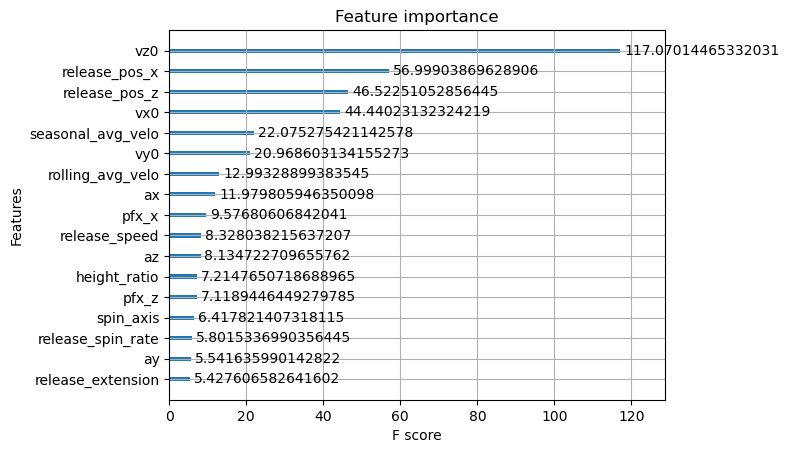

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

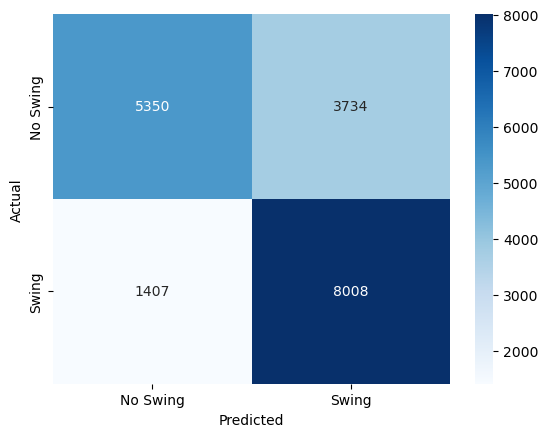

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'last_spin_axis', 'last_pfx_x',
       'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
       'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z',
       'diff_release_speed'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xswing'] = y_pred

In [26]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [27]:
len(testing_identifiers)

188456

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/swing_2022&3_xswing.csv")